# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 2
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.311761        0.189999  0.061382  0.220293  0.099379   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       1.5    0.322371        0.162284  0.086404  0.165641  0.152880   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.200554  0.009227  0.039269  0.049266  0.001492  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       1.5   0.209994  0.005174  0.034993  0.048880  0.006163  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.311761        0.189999  0.061382  0.220293  0.099379   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       1.5    0.322371        0.162284  0.086404  0.165641  0.152880   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.200554  0.009227  0.039269  0.049266  0.001492  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       1.5   0.209994  0.005174  0.034993  0.048880  0.006163  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.311761        0.189999  0.061382  0.220293  0.099379   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       1.5    0.322371        0.162284  0.086404  0.165641  0.152880   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.200554  0.009227  0.039269  0.049266  0.001492  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       1.5   0.209994  0.005174  0.034993  0.048880  0.006163  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.5    0.299893        0.188541  0.068037  0.218933  0.100735   
         1.0    0.288190        0.174077  0.089557  0.183997  0.136357   
         1.5    0.274398        0.158853  0.093482  0.179006  0.157845   
         2.0    0.260551        0.143504  0.080676  0.188562  0.178523   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
         0.5   0.200543  0.009250  0.039268  0.049773  0.000986  
         1.0   0.203716  0.007056  0.036890  0.050678  0.002468  
         1.5   0.209860  0.005463  0.034856  0.051042  0.004139  
         2.0   0.219000  0.004525  0.033388  0.050751  0.005898

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.5   5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         1.0   6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   
         1.5   6.303323e+06  5.167157e+06  546287.047997  3.570656e+06   
         2.0   6.425365e+06  5.499584e+06  591328.783707  3.865639e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.5   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         1.5   1.118956e+06  6.520026e+06  3.935836e+06  9.528769e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          30.341080  
         0.5      286614.273964  
         1.0      398139.231561  
         1.5      457478.291179  
         2.0      494315.467226

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


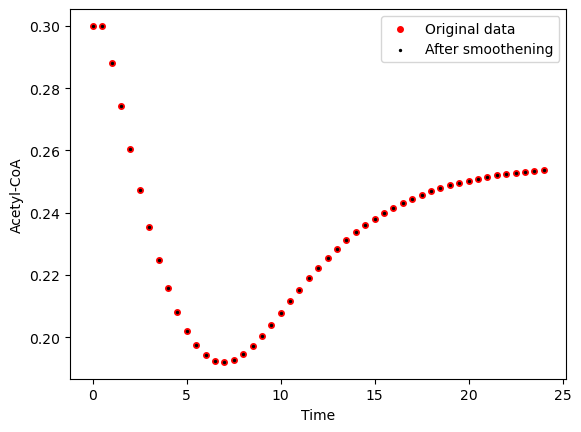

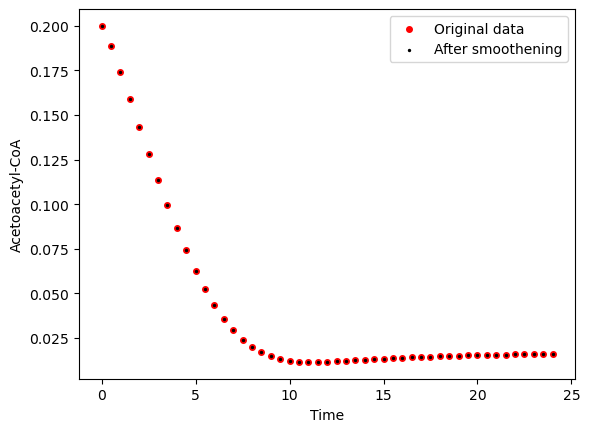

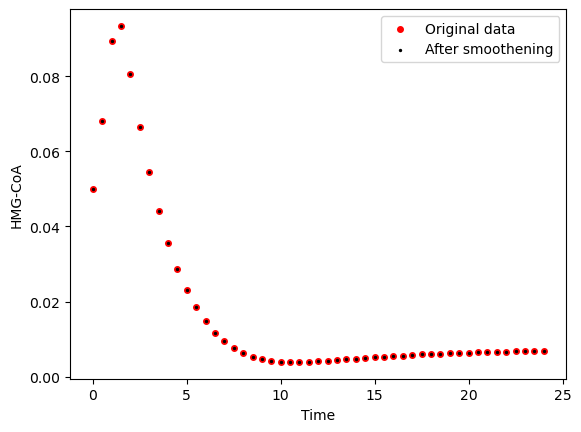

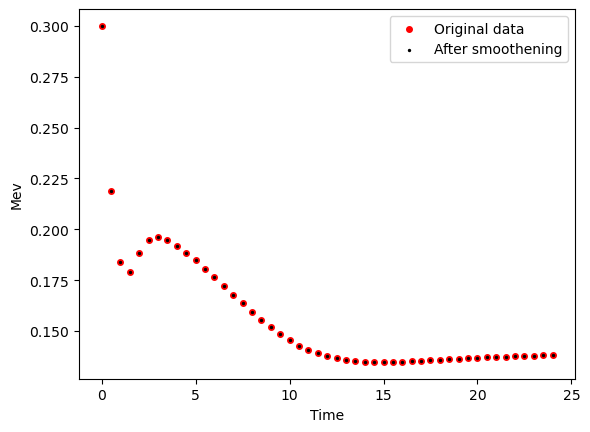

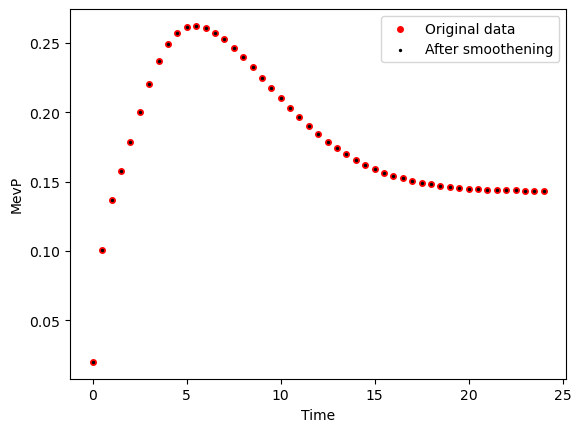

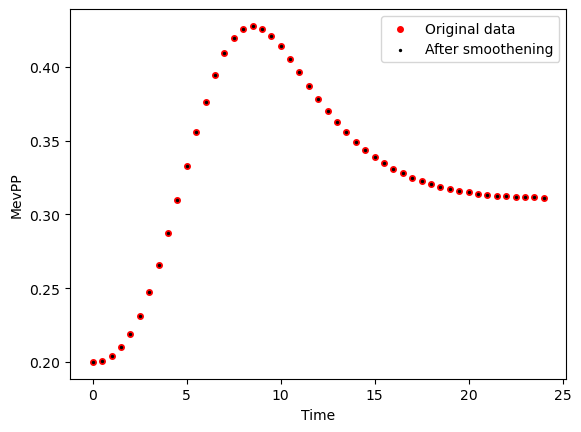

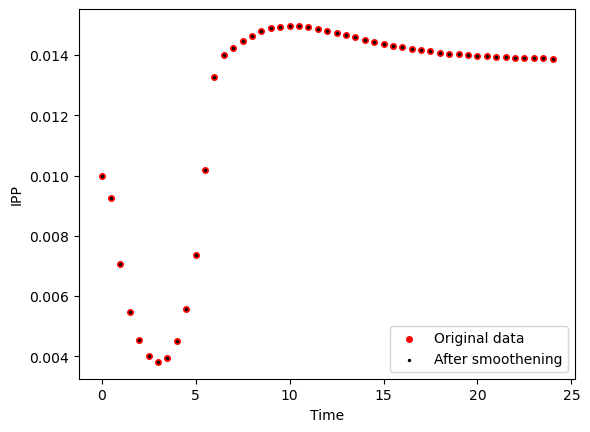

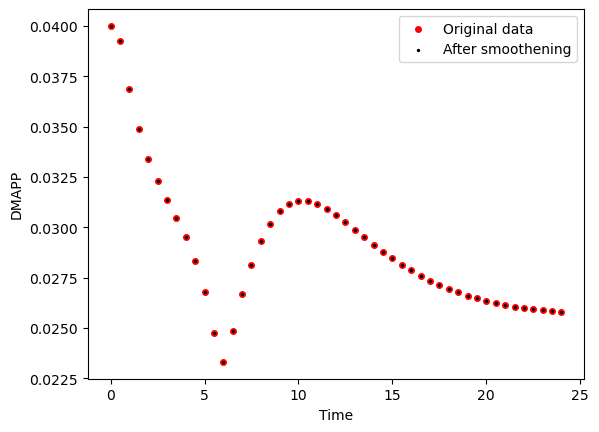

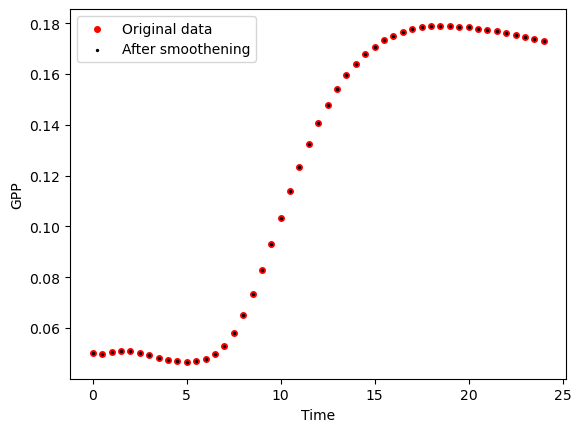

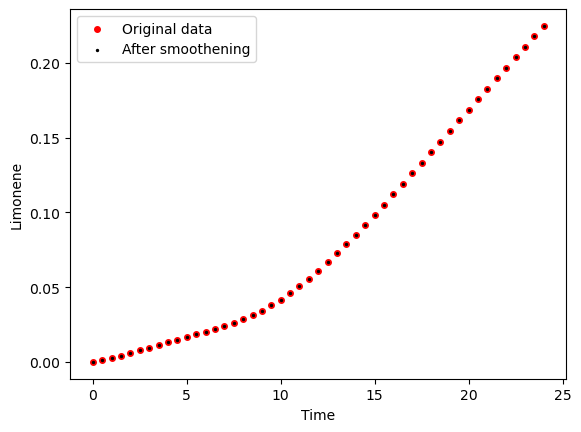

Strain Strain 2


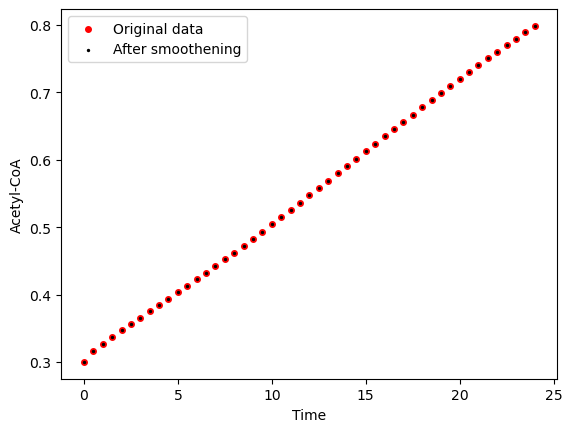

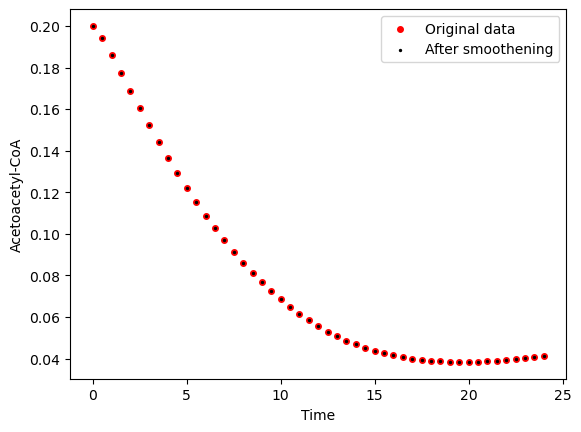

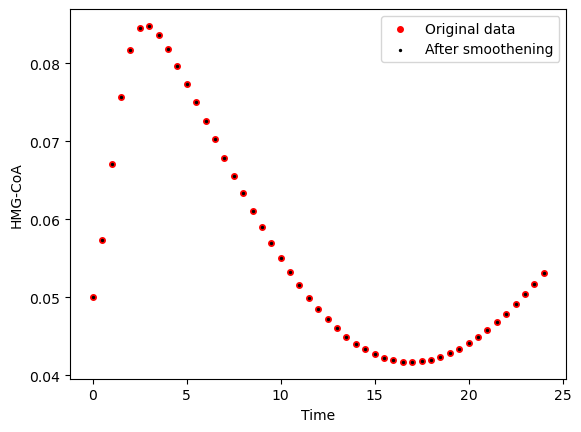

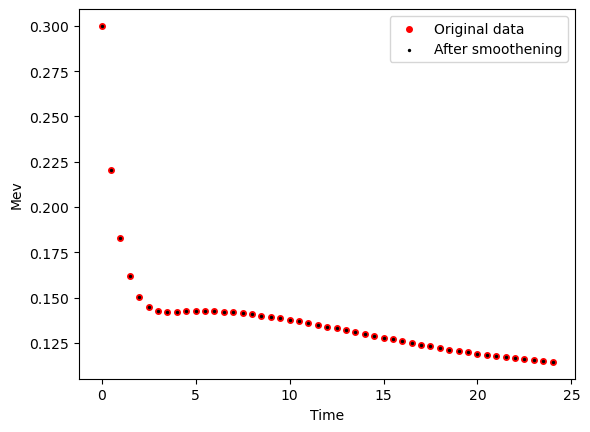

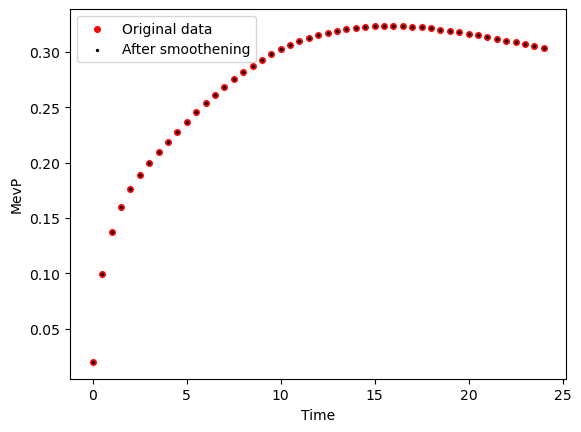

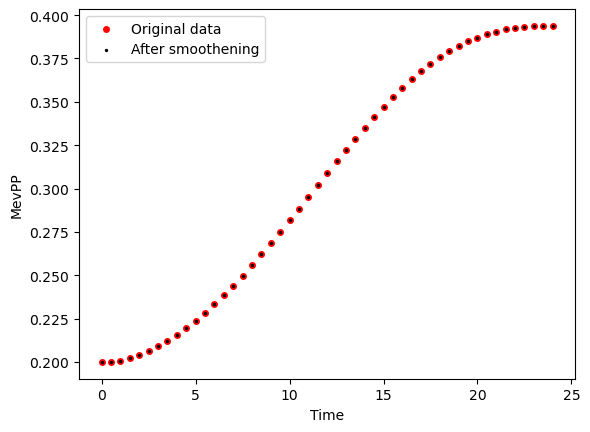

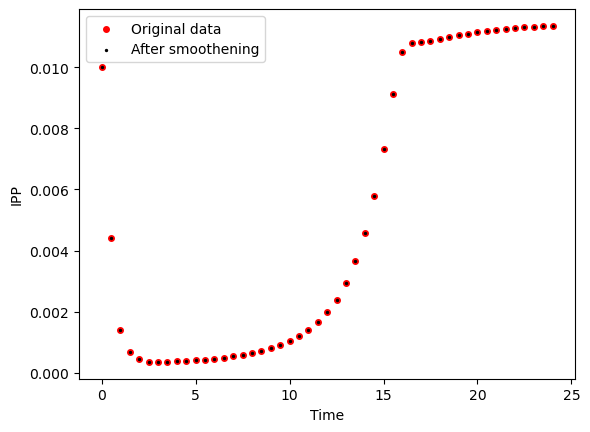

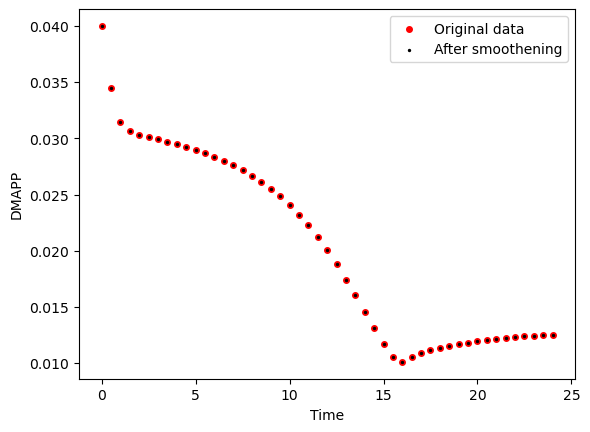

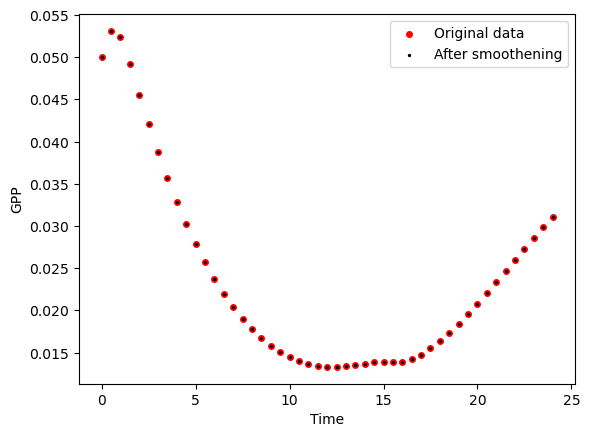

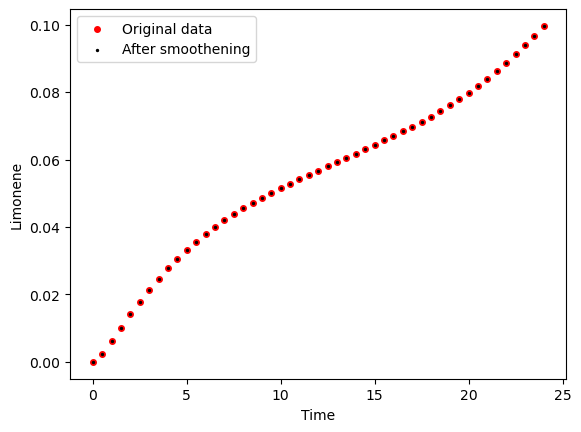

Strain Strain 3


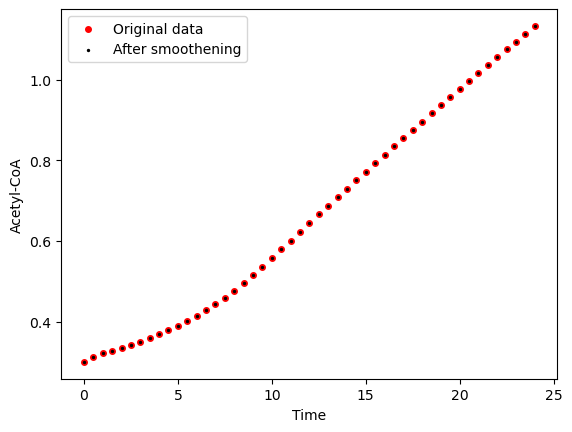

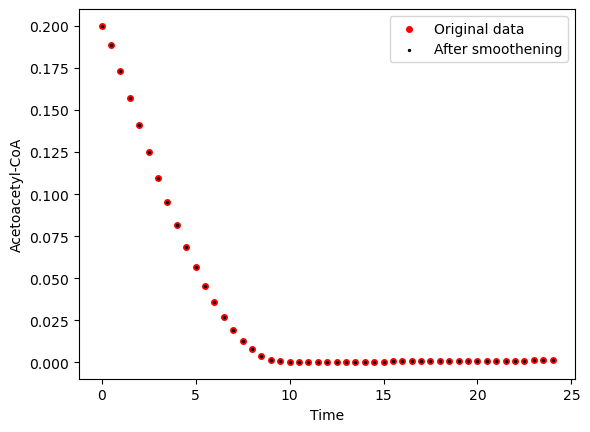

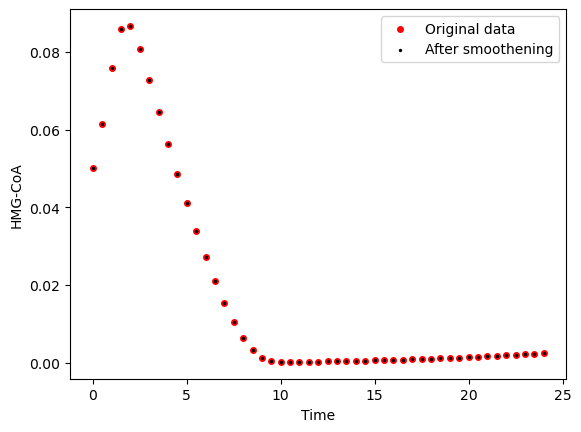

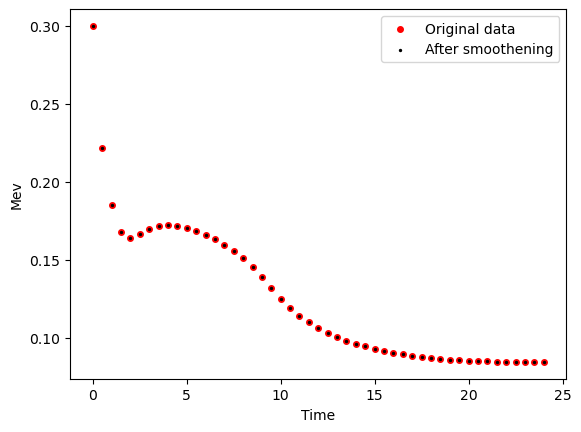

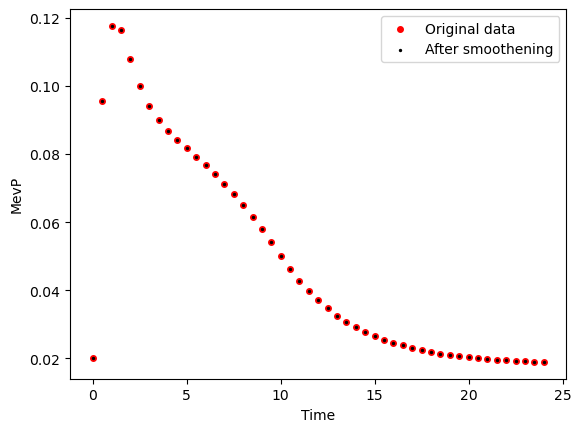

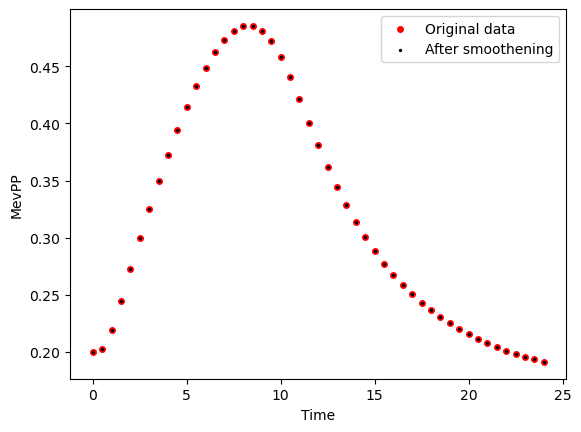

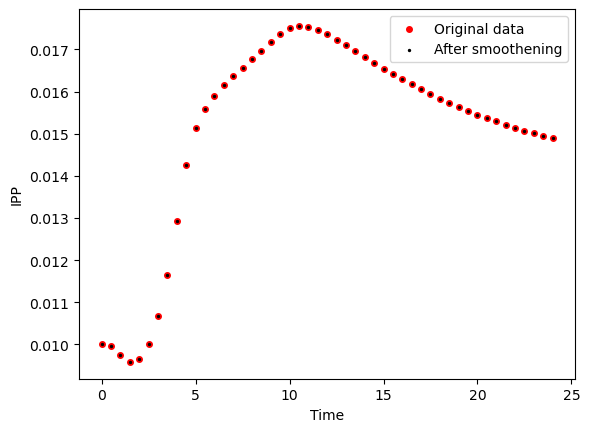

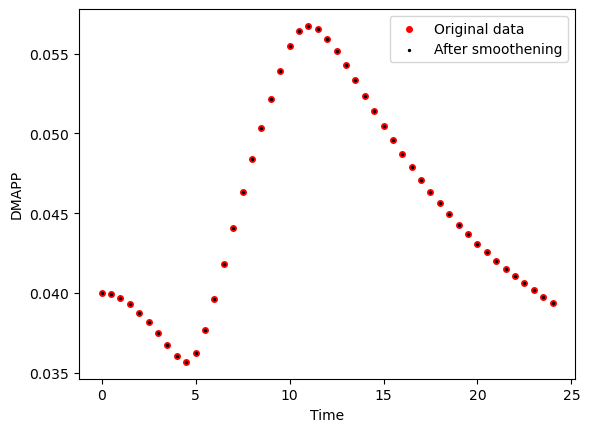

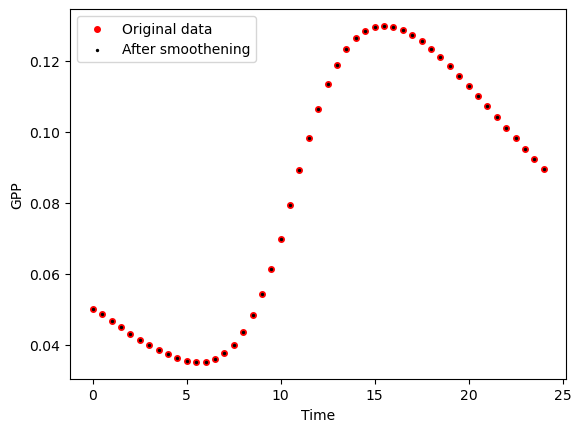

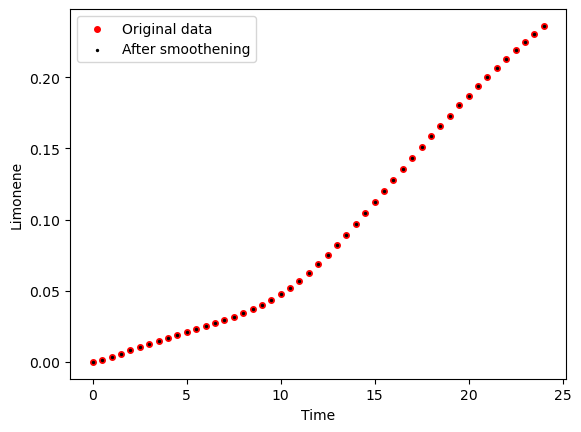

Strain WT


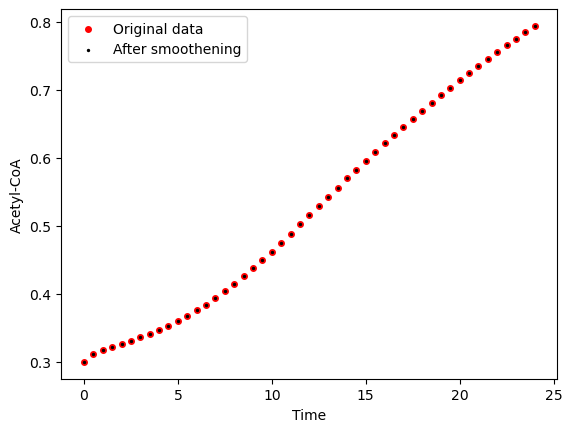

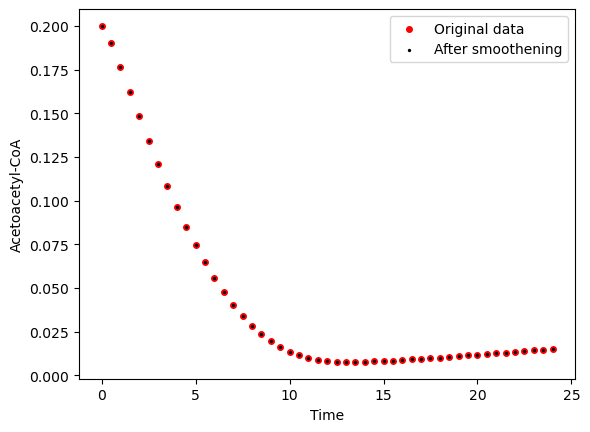

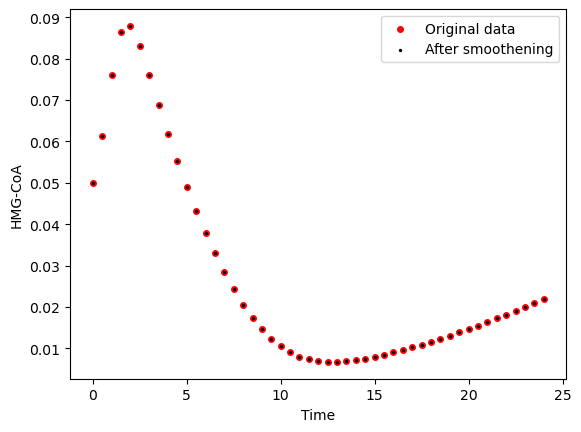

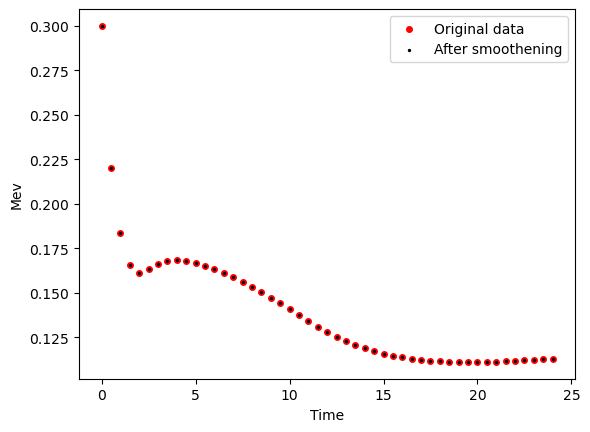

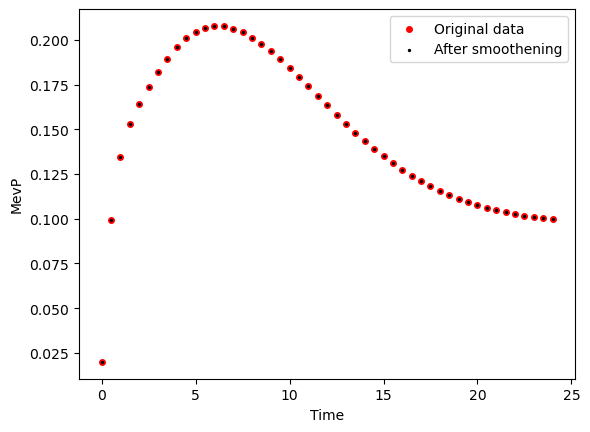

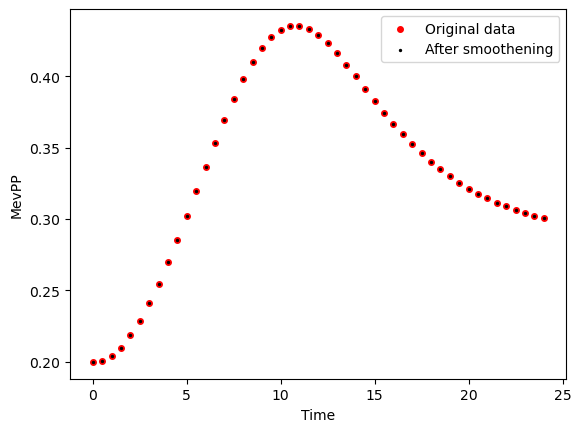

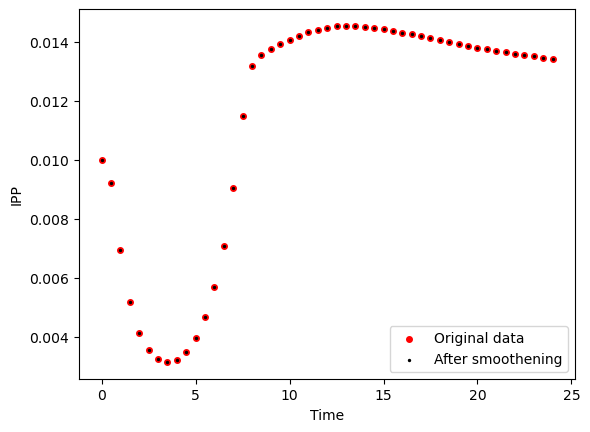

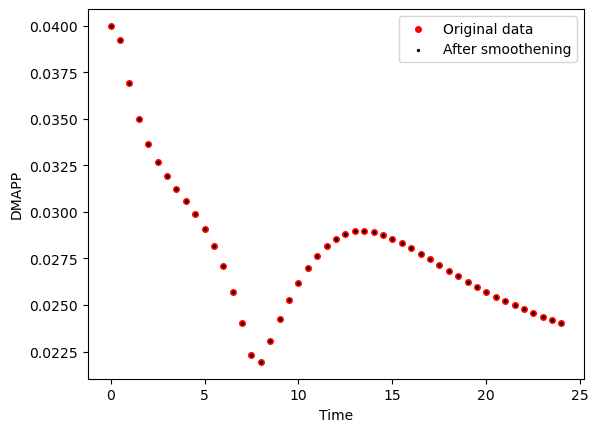

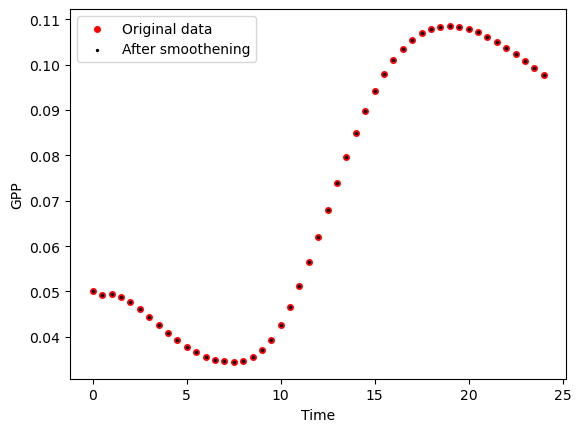

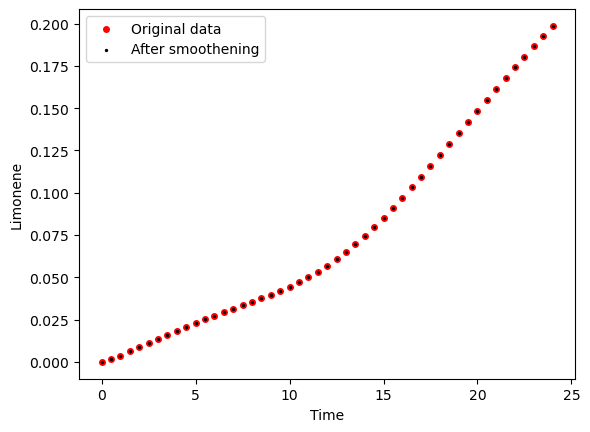

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


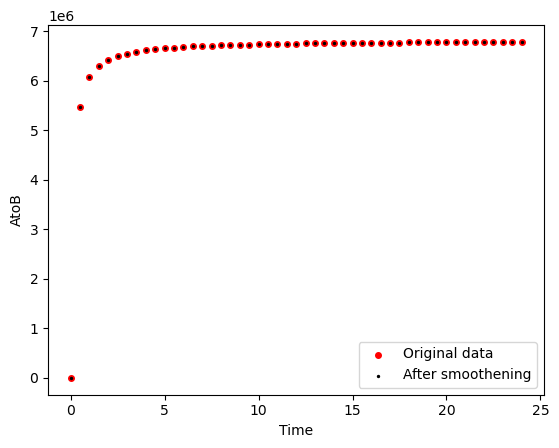

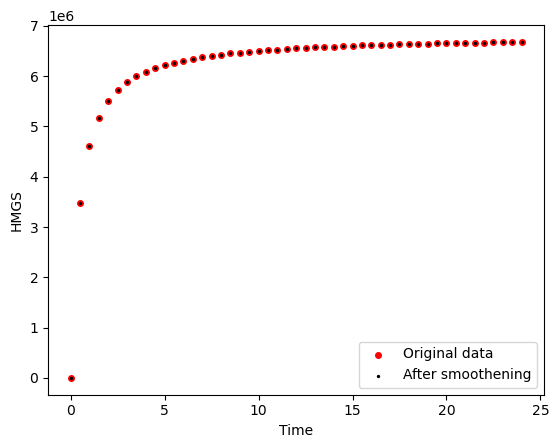

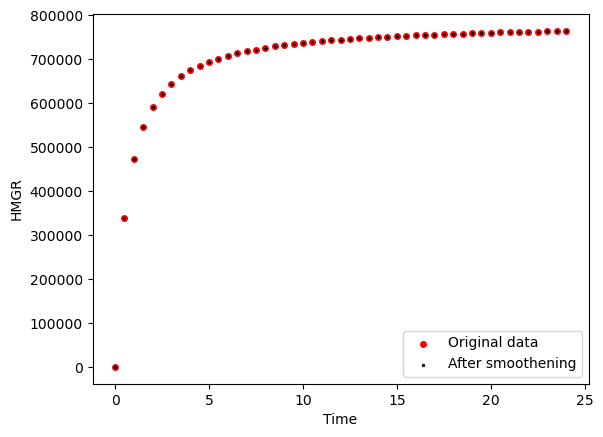

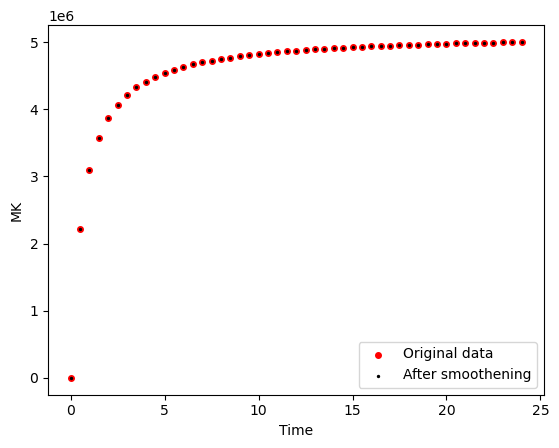

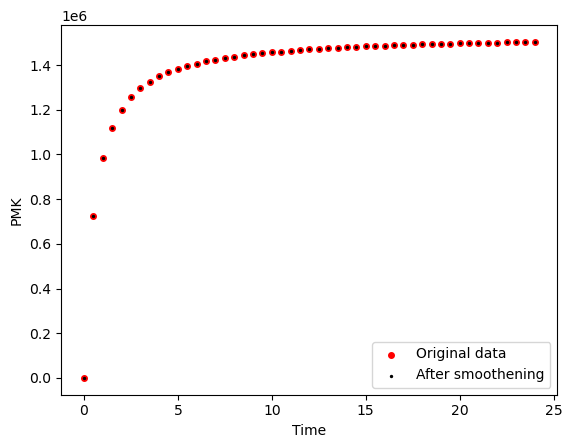

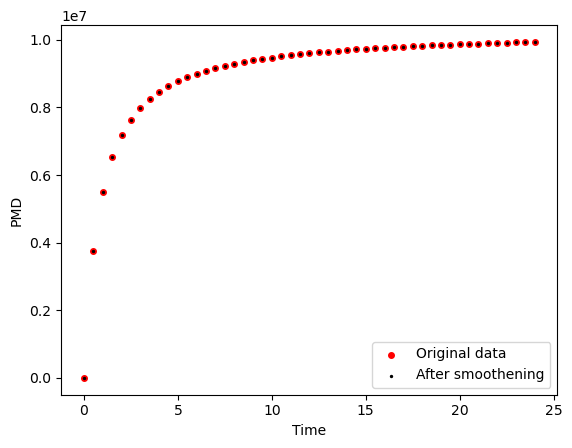

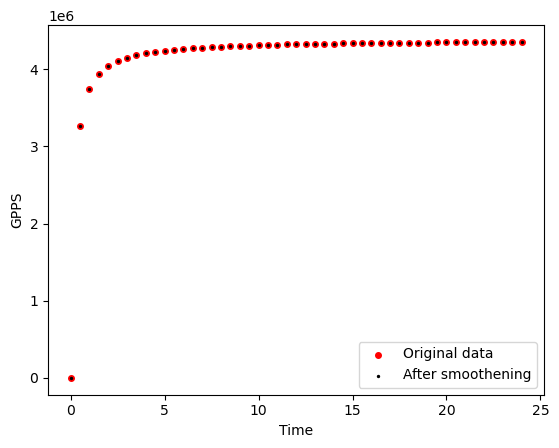

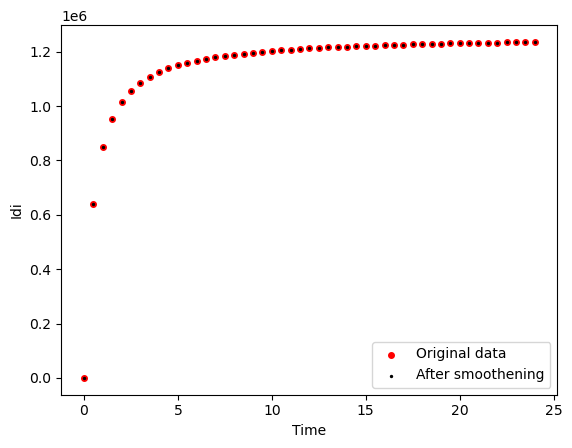

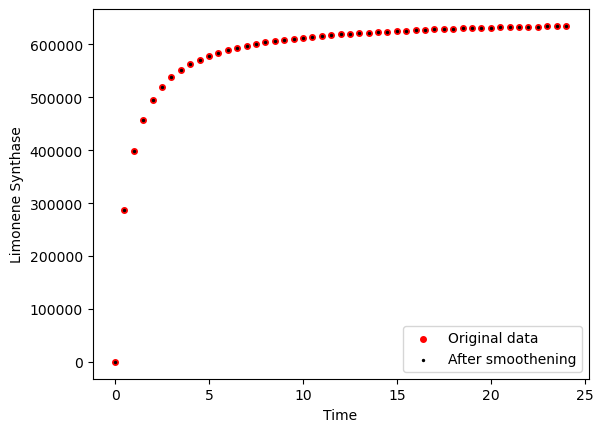

Strain Strain 2


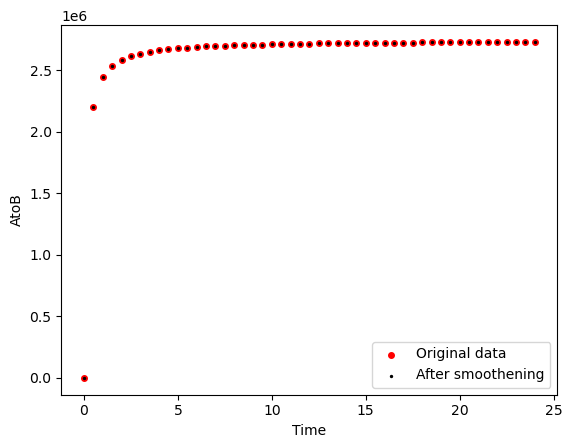

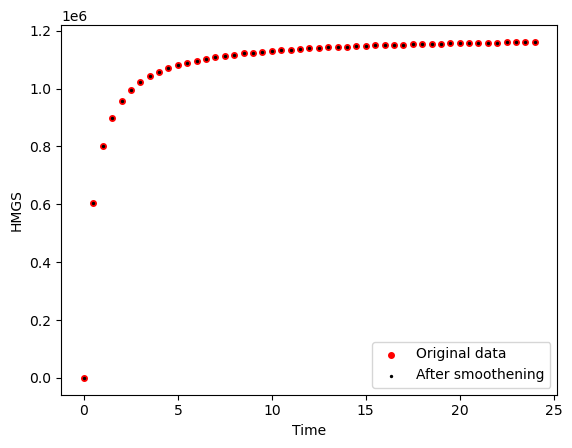

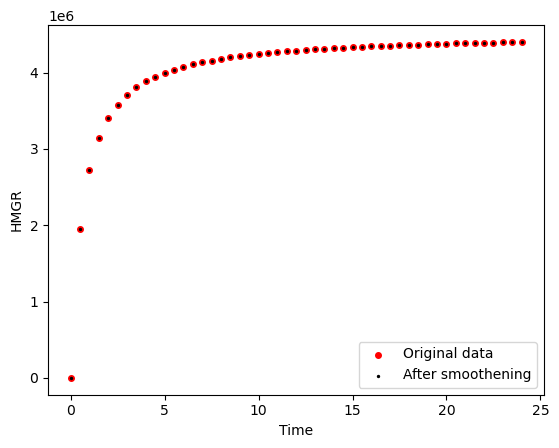

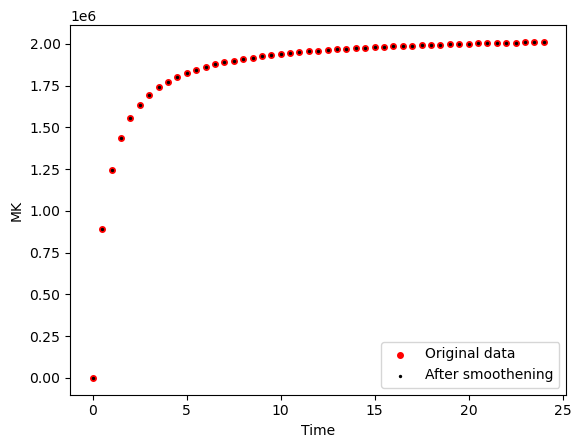

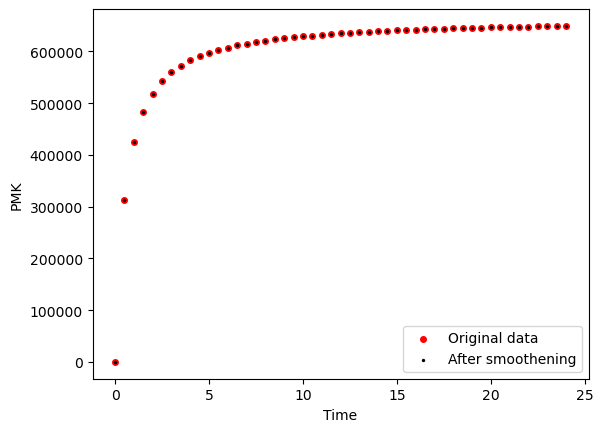

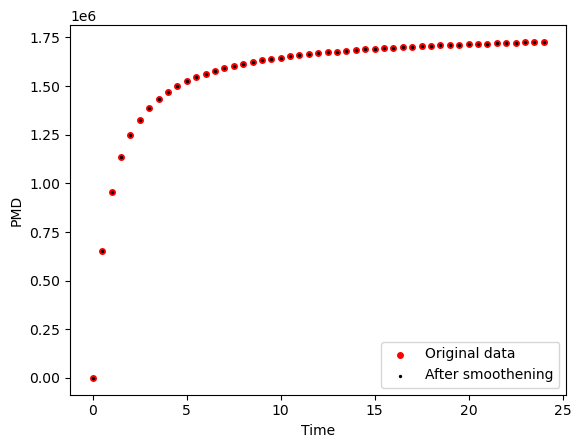

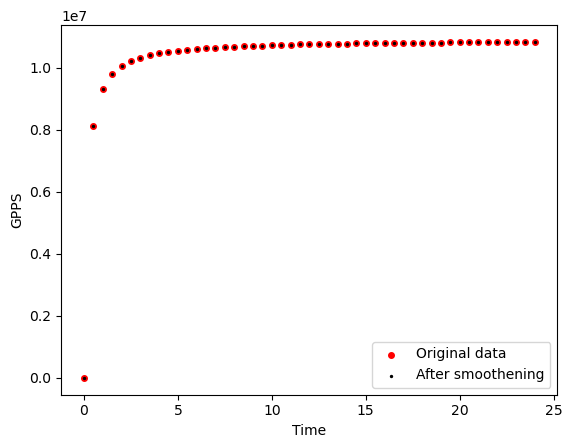

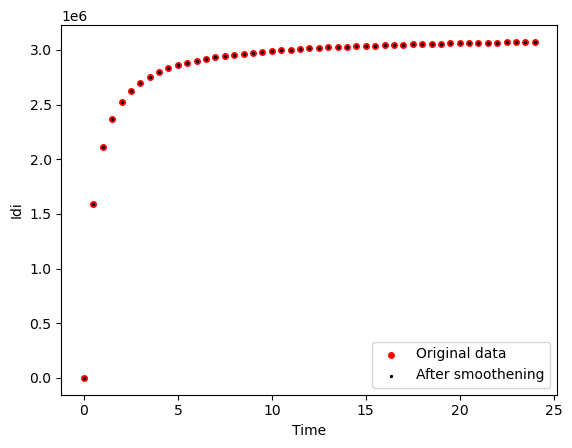

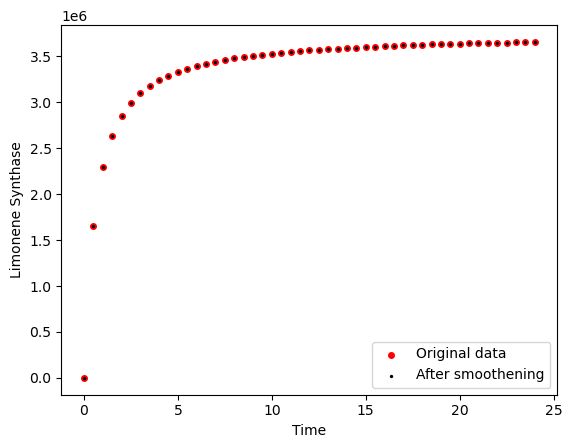

Strain Strain 3


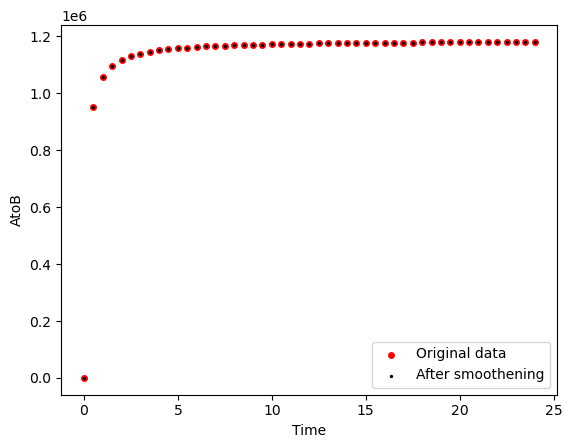

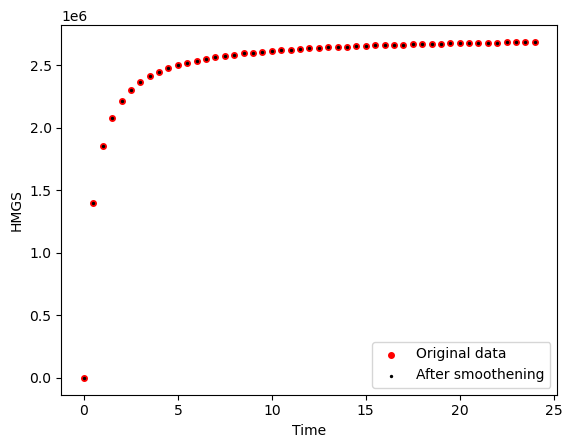

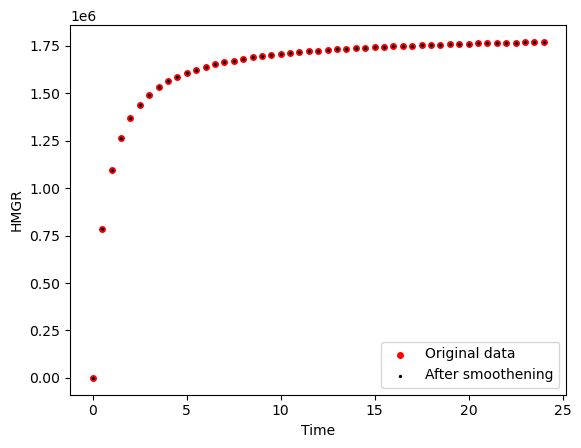

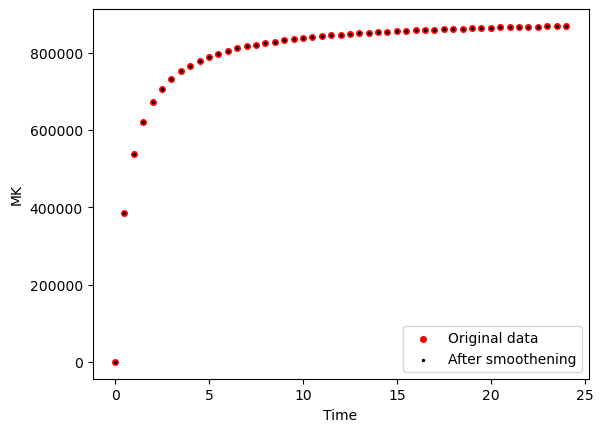

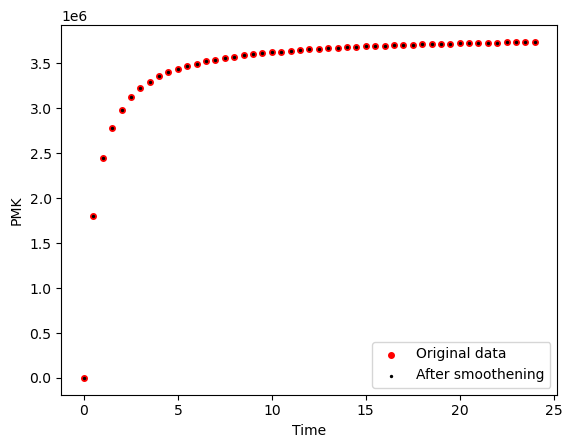

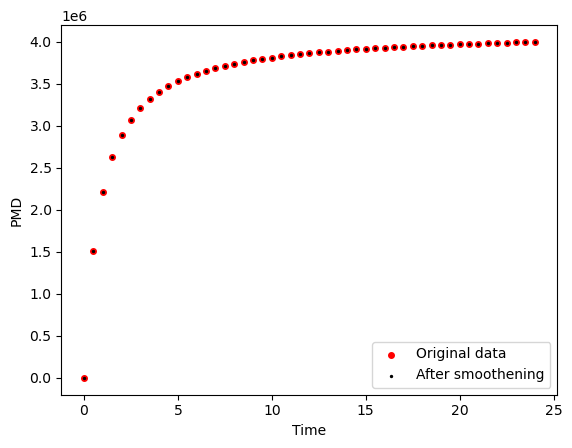

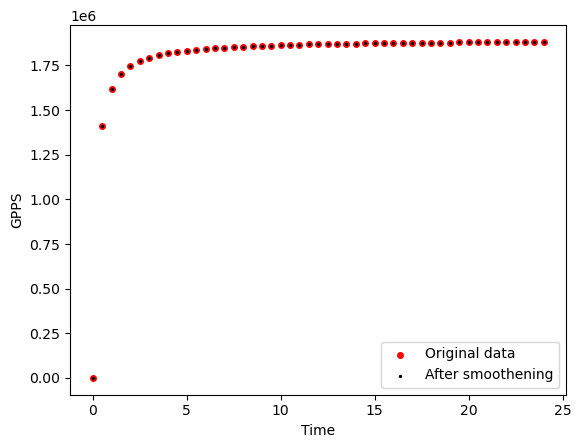

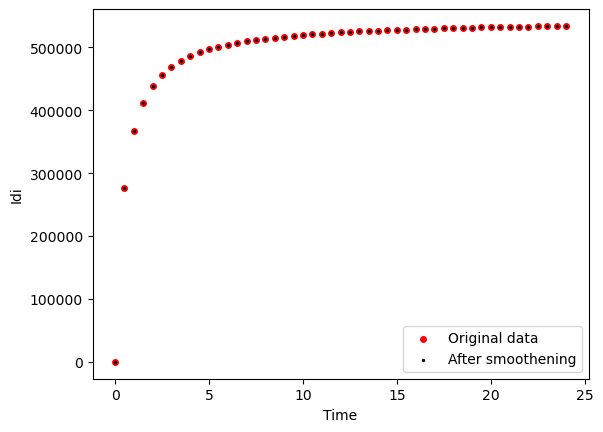

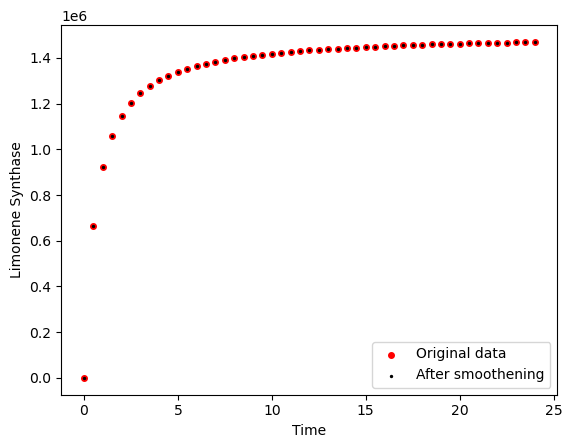

Strain WT


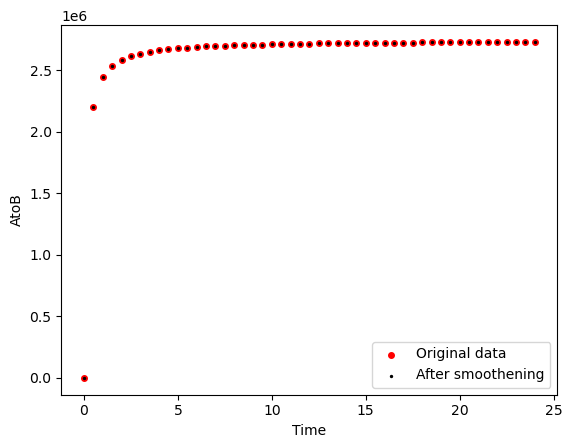

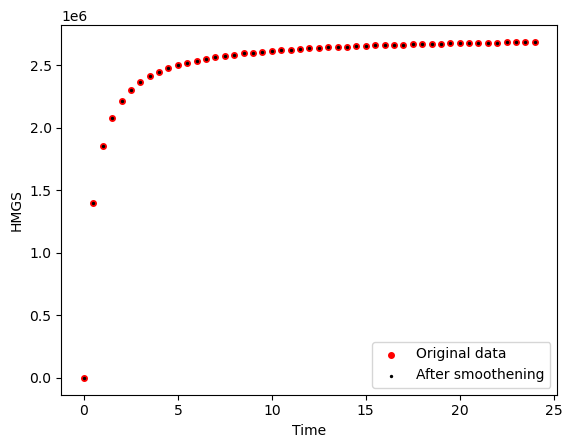

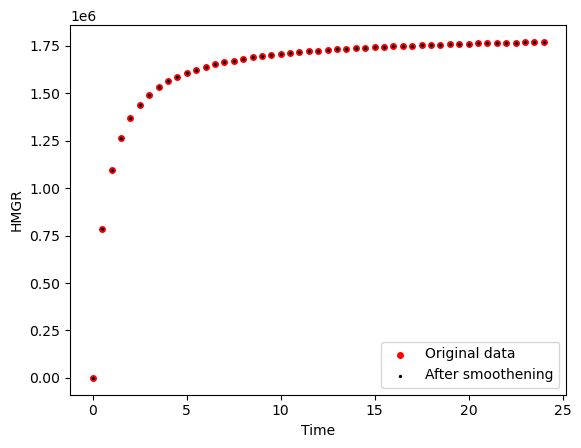

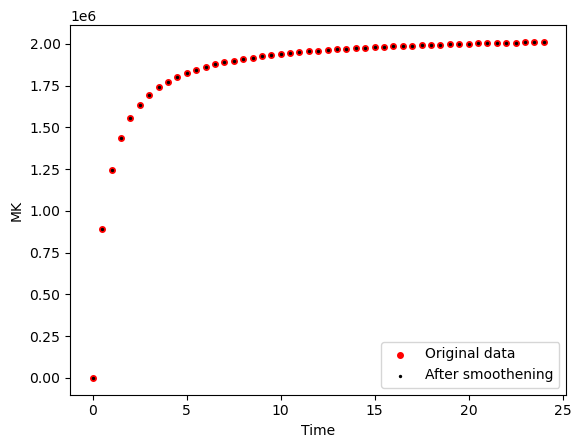

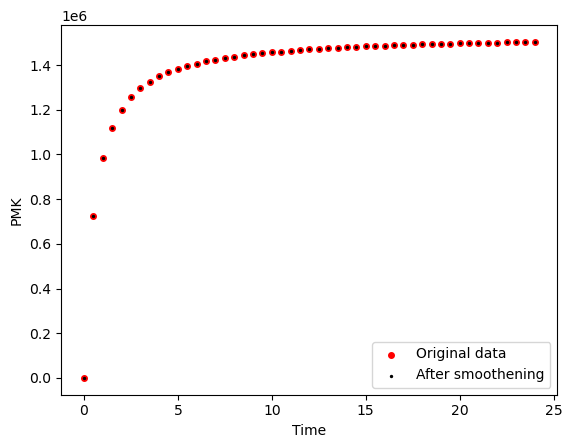

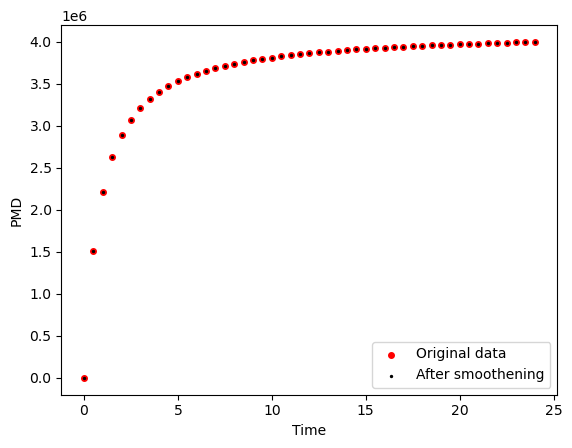

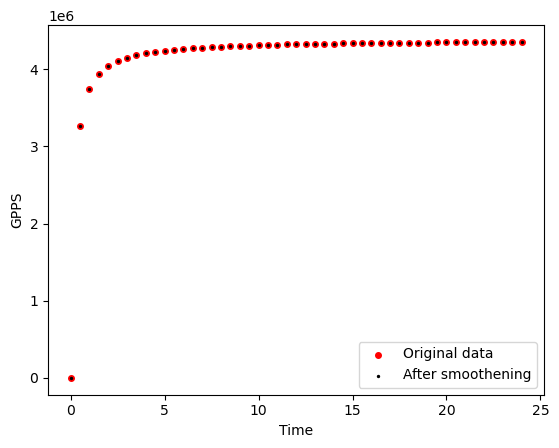

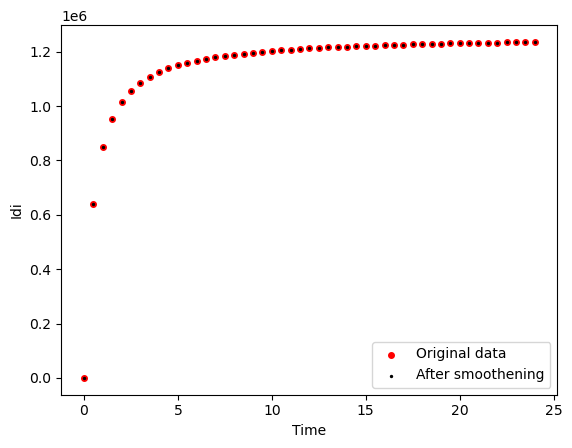

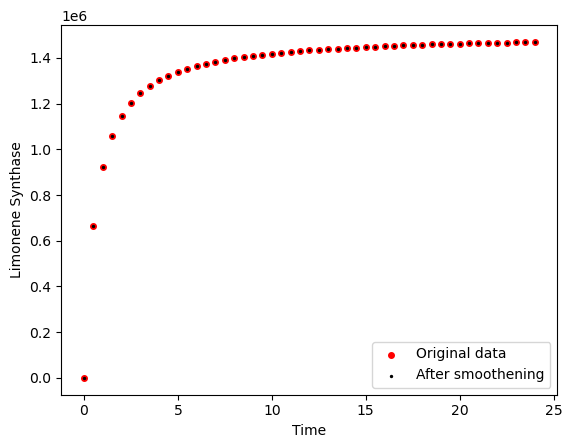

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.5    0.299893        0.188541  0.068037  0.218933  0.100735   
         1.0    0.288190        0.174077  0.089557  0.183997  0.136357   
         1.5    0.274398        0.158853  0.093482  0.179006  0.157845   
         2.0    0.260551        0.143504  0.080676  0.188562  0.178523   
...                  ...             ...       ...       ...       ...   
WT       22.0   0.755407        0.013340  0.018112  0.111883  0.102630   
         22.5   0.765314        0.013753  0.019019  0.112124  0.101762   
         23.0   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.5   0.784584        0.014581  0.020886  0.112676  0.100406   
         24.0   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                 ...  \
                  MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                    ...   
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.5   0.200543  0.009250  0.039268  0.049773  0.000986  ...   
         1.0   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
         1.5   0.209860  0.005463  0.034856  0.051042  0.004139  ...   
         2.0   0.219000  0.004525  0.033388  0.050751  0.005898  ...   
...                 ...       ...       ...       ...       ...  ...   
WT       22.0  0.308770  0.013585  0.024759  0.103766  0.174178  ...   
         22.5  0.306400  0.013541  0.024553  0.102364  0.180419  ...   
         23.0  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.5  0.302440  0.013460  0.024180  0.099296  0.192639  ...   
         24.0  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

              derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0     0.003492       -0.021533  0.068282 -0.211321  0.178788   
         0.5    -0.012643       -0.026167  0.038730 -0.110383  0.112107   
         1.0    -0.023589       -0.029322  0.014092 -0.037507  0.064958   
         1.5    -0.029345       -0.030998 -0.005633  0.007307  0.037341   
         2.0    -0.027331       -0.030617 -0.026914  0.017786  0.040362   
...                   ...             ...       ...       ...       ...   
WT       22.0    0.019998        0.000825  0.001796  0.000453 -0.001872   
         22.5    0.019630        0.000827  0.001832  0.000508 -0.001602   
         23.0    0.019269        0.000828  0.001867  0.000554 -0.001353   
         23.5    0.018914        0.000829  0.001899  0.000591 -0.001124   
         24.0    0.018565        0.000828  0.001930  0.000618 -0.000915   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.001573 -0.002269 -0.001983  0.000353  0.001694  
         0.5   0.003675 -0.003001 -0.003208  0.000738  0.002505  
         1.0   0.009271 -0.003204 -0.003821  0.000731  0.003103  
         1.5   0.015214 -0.002876 -0.003819  0.000331  0.003487  
         2.0   0.021619 -0.001475 -0.002599 -0.000977  0.003575  
...                 ...       ...       ...       ...       ...  
WT       22.0 -0.005021 -0.000092 -0.000424 -0.002691  0.012565  
         22.5 -0.004467 -0.000086 -0.000399 -0.002906  0.012399  
         23.0 -0.003951 -0.000080 -0.000374 -0.003079  0.012223  
         23.5 -0.003476 -0.000075 -0.000349 -0.003204  0.012035  
         24.0 -0.003041 -0.000069 -0.000325 -0.003283  0.011835

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

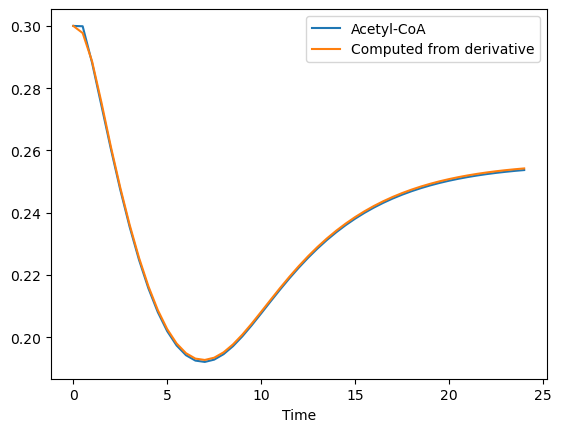

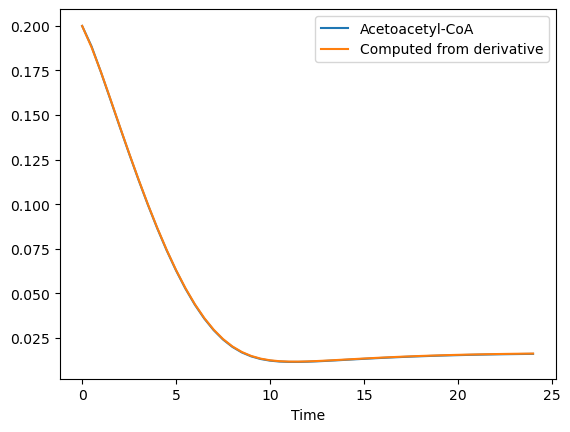

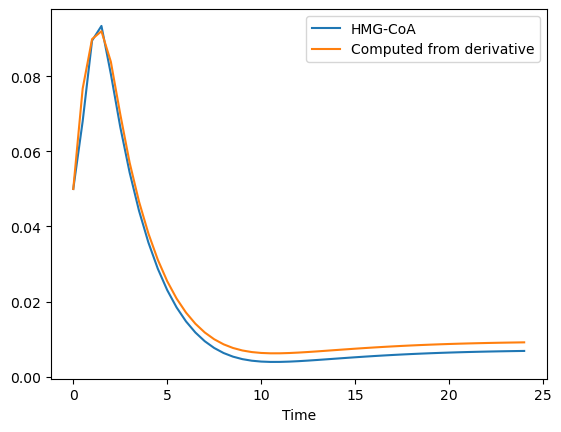

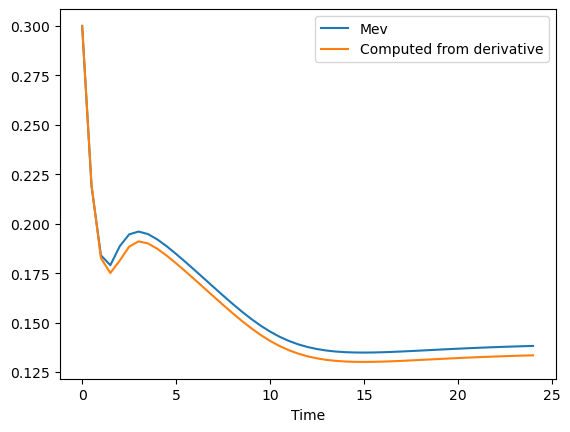

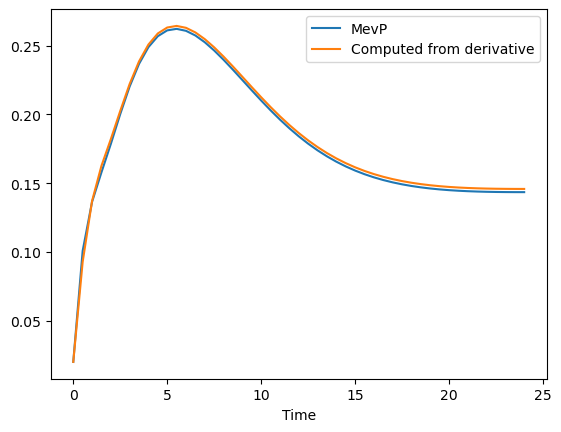

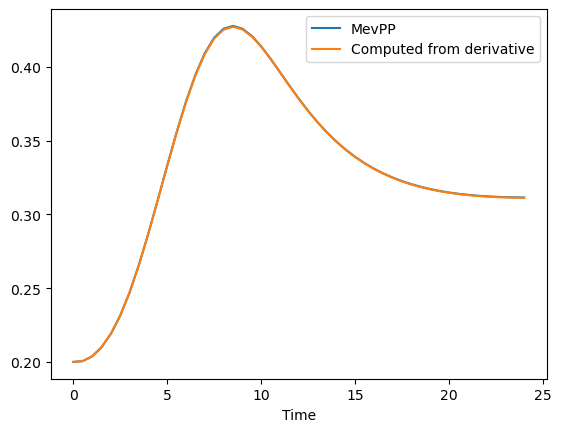

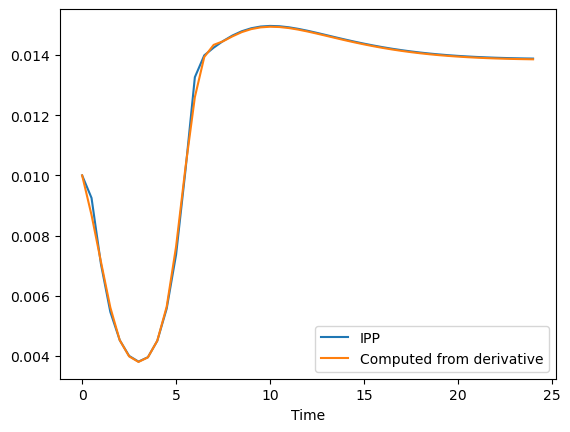

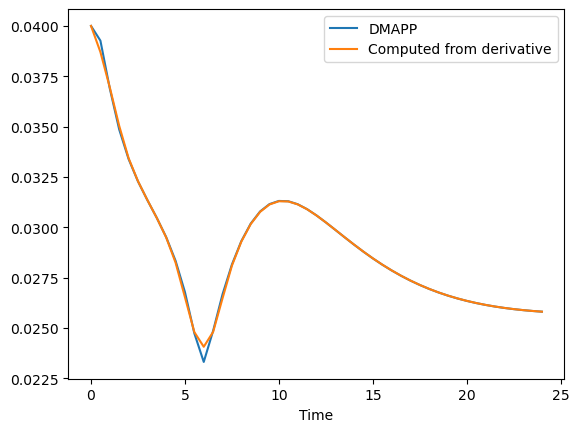

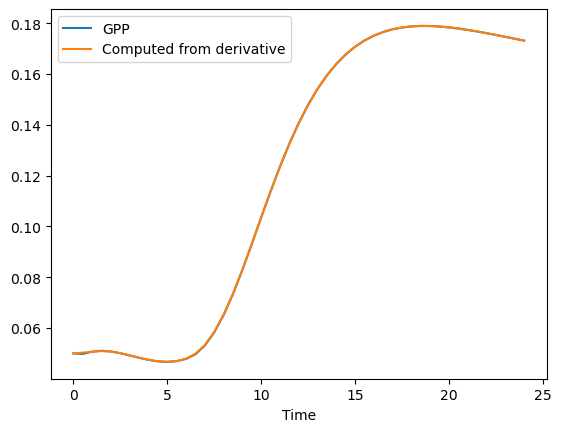

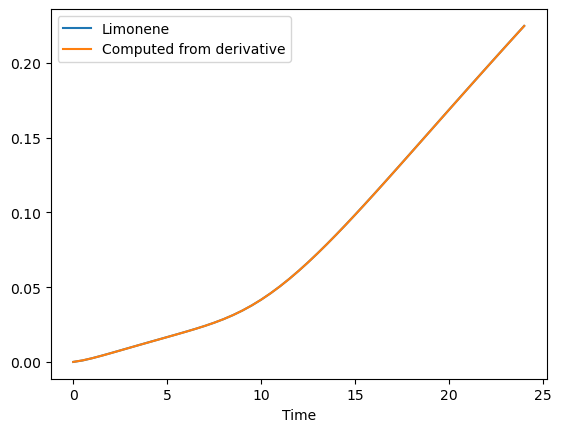

'Time profile from derivative vs. actual profile for Strain 2'

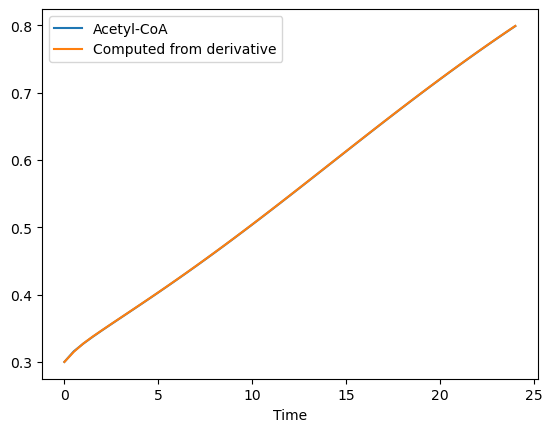

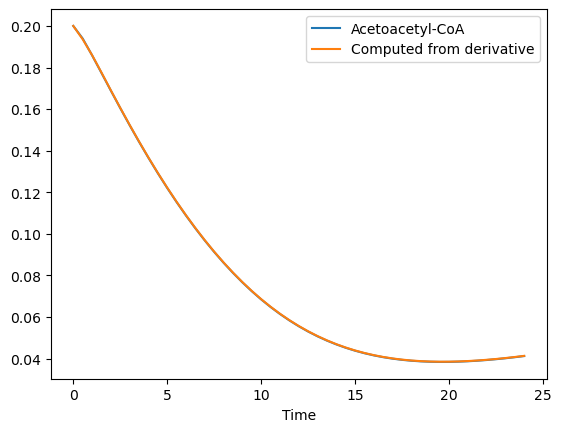

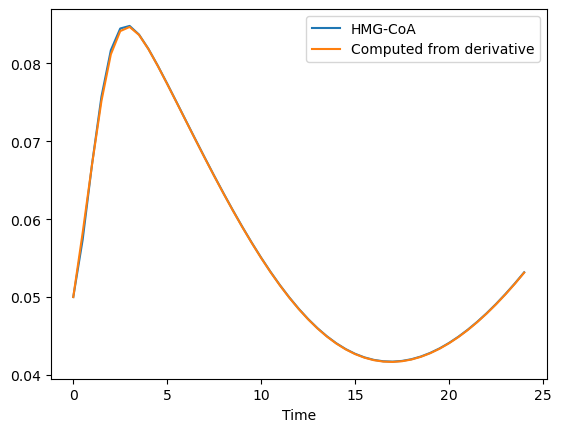

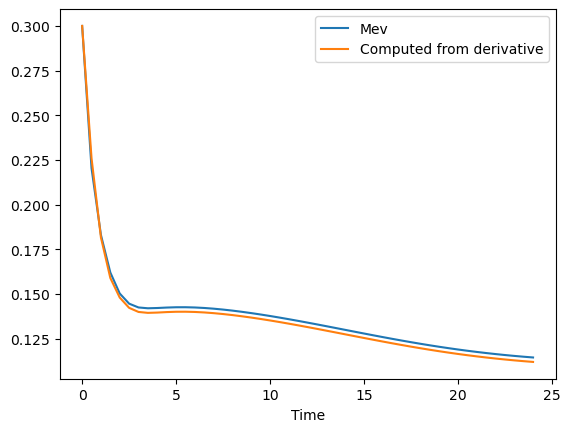

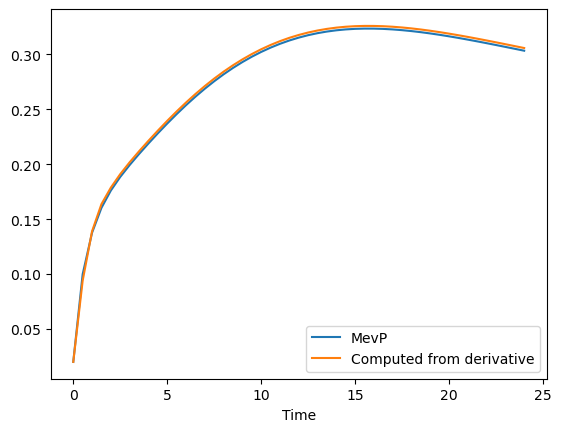

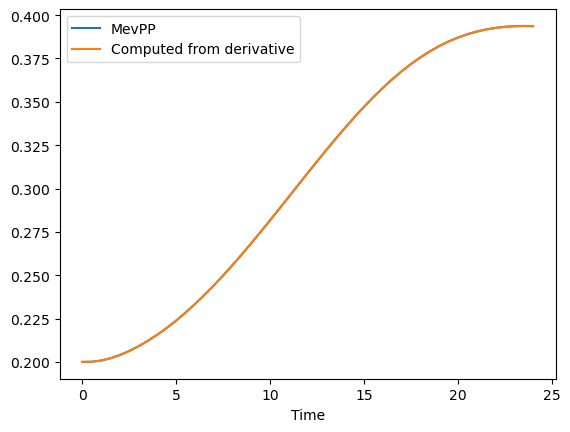

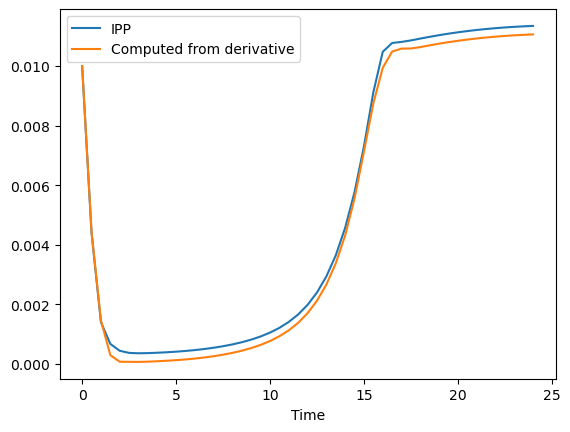

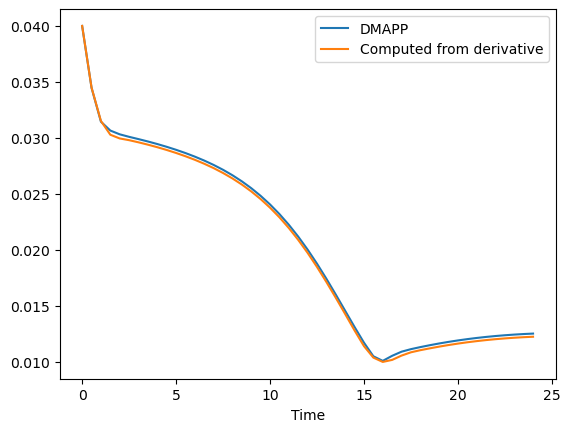

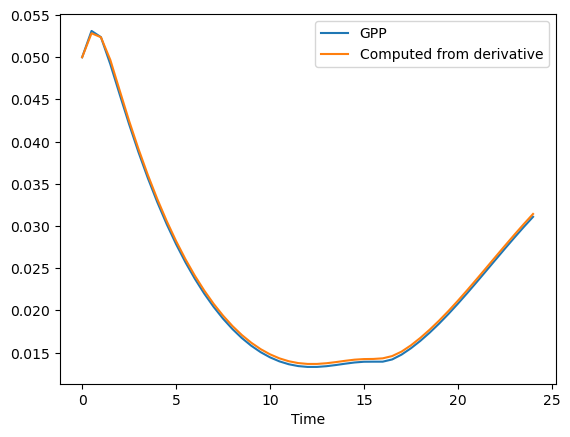

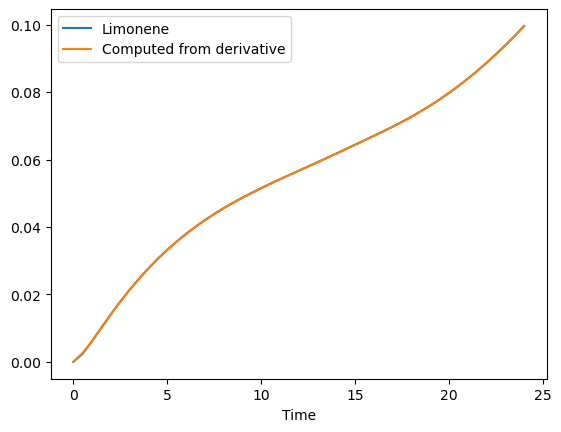

'Time profile from derivative vs. actual profile for Strain 3'

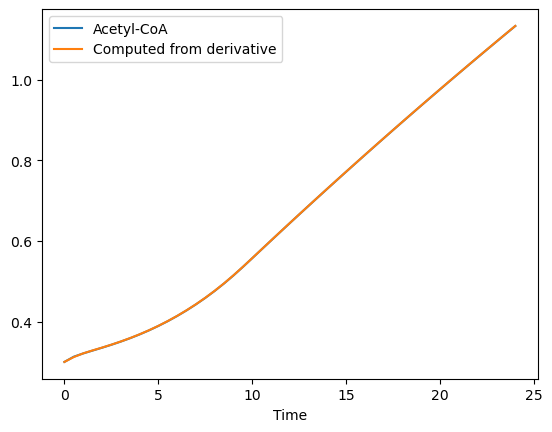

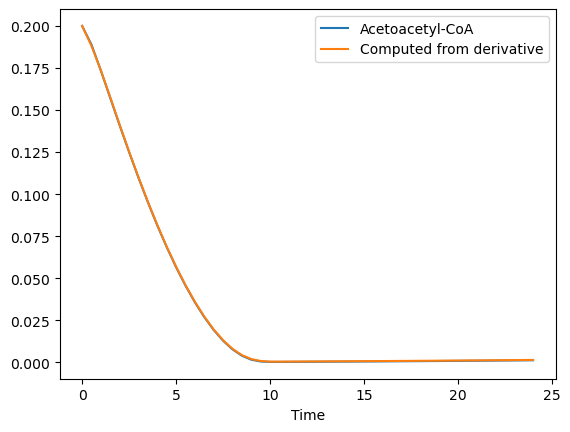

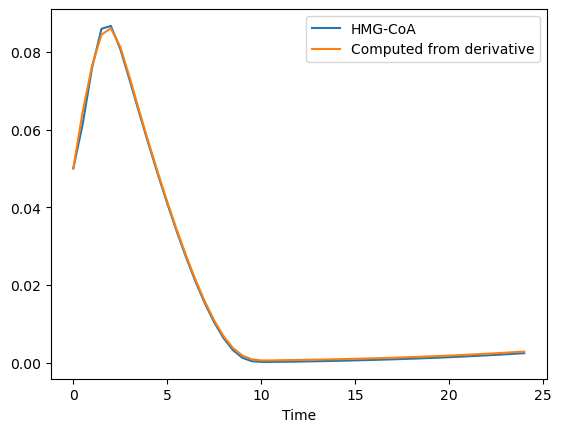

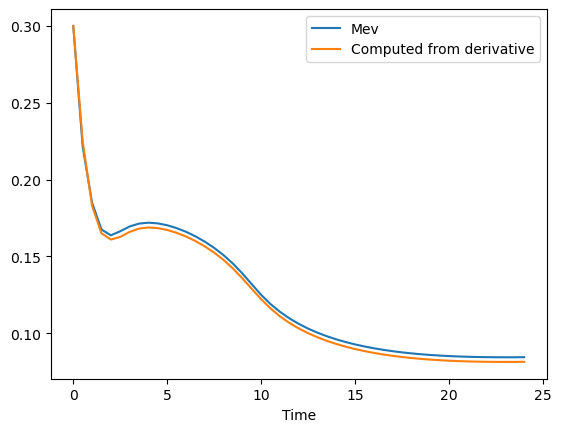

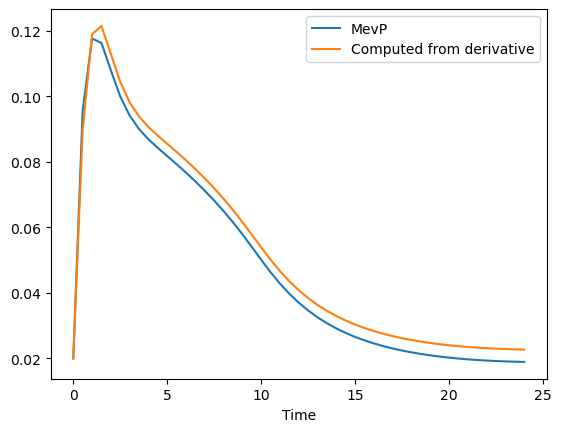

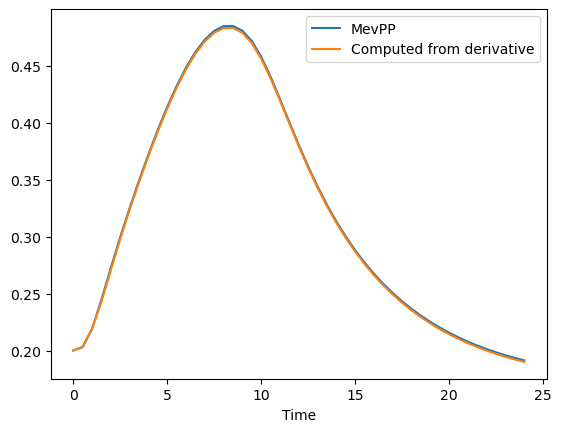

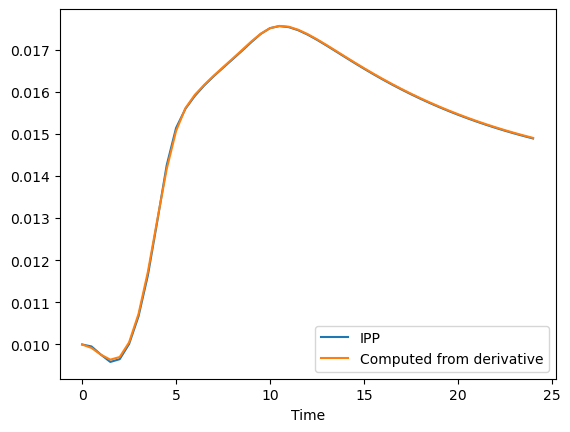

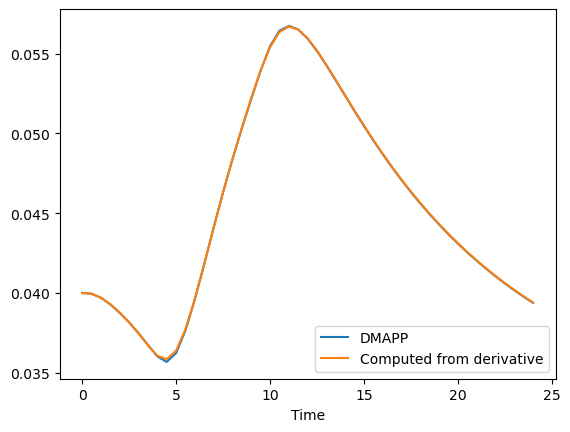

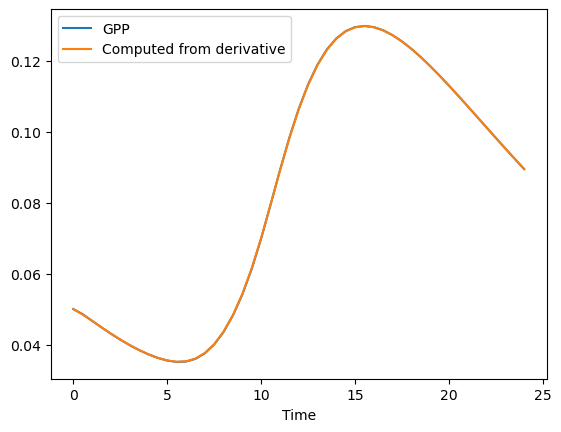

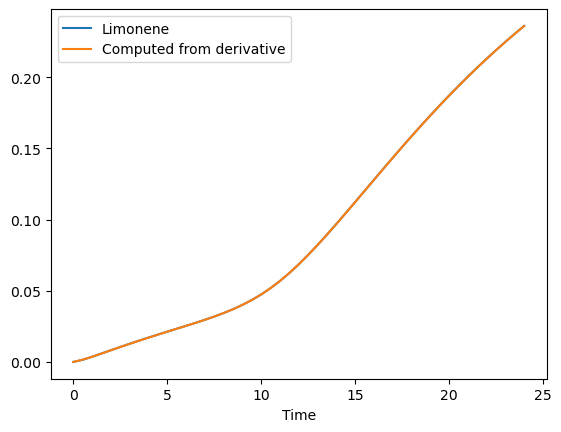

'Time profile from derivative vs. actual profile for WT'

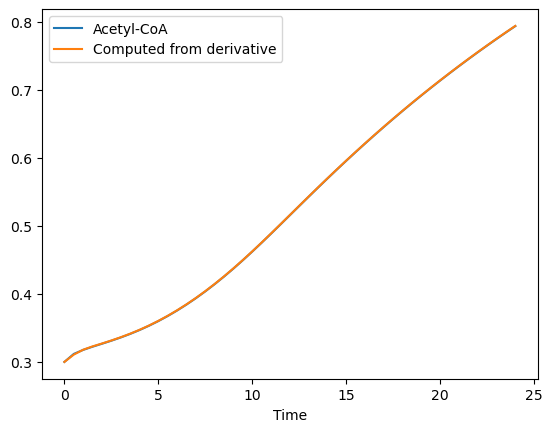

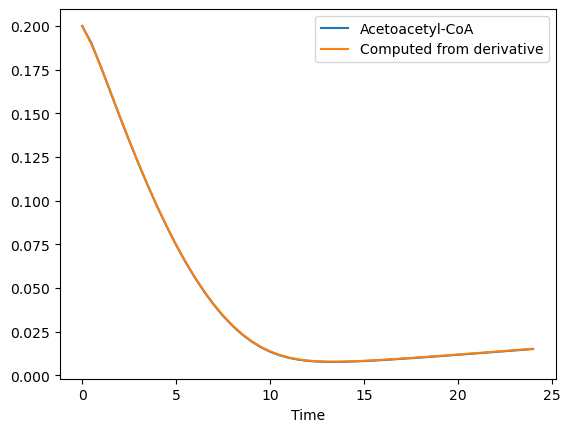

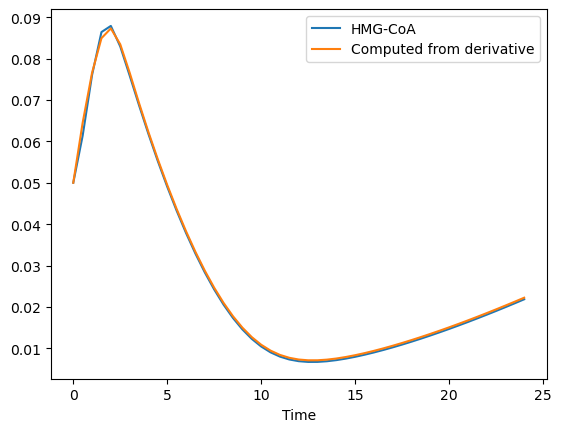

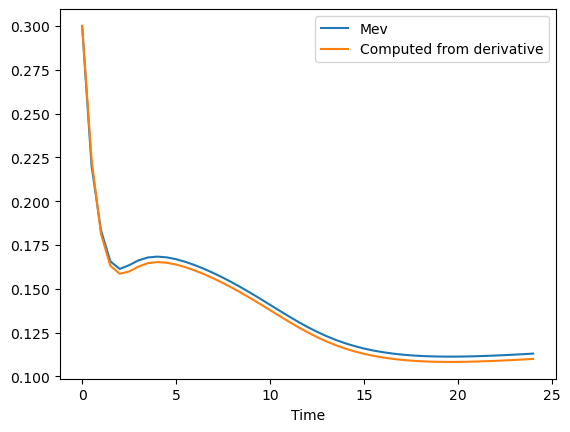

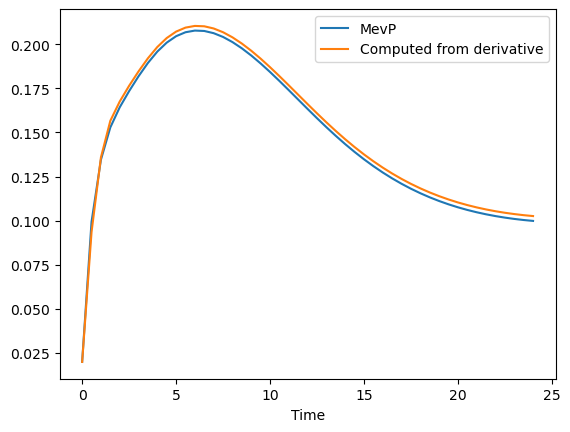

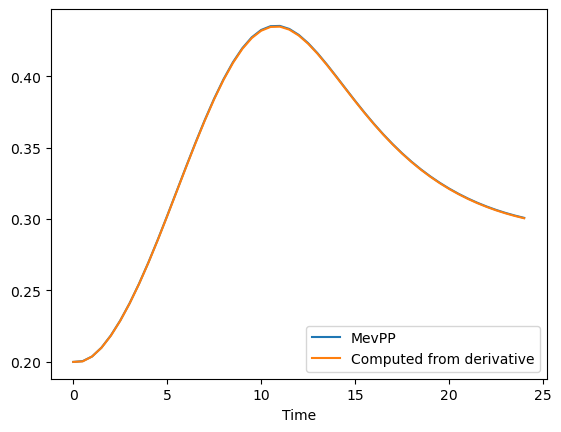

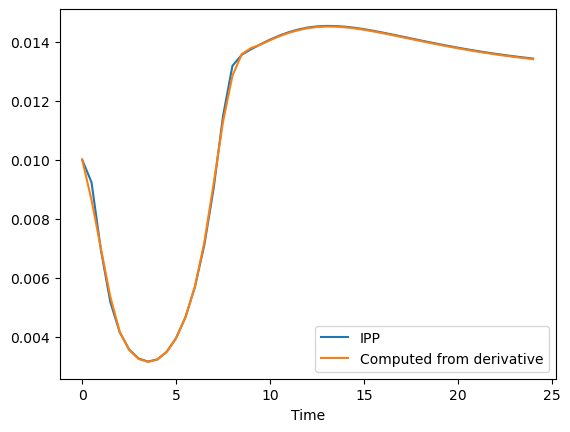

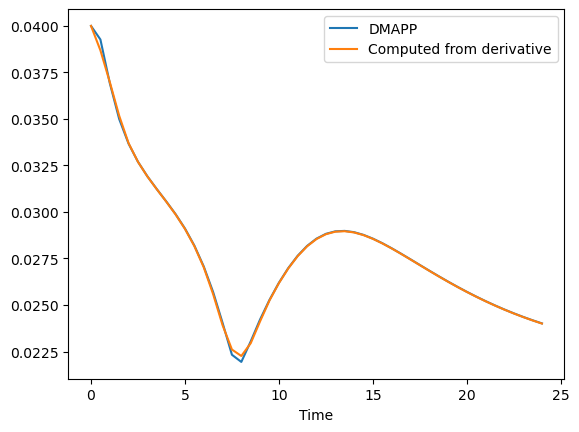

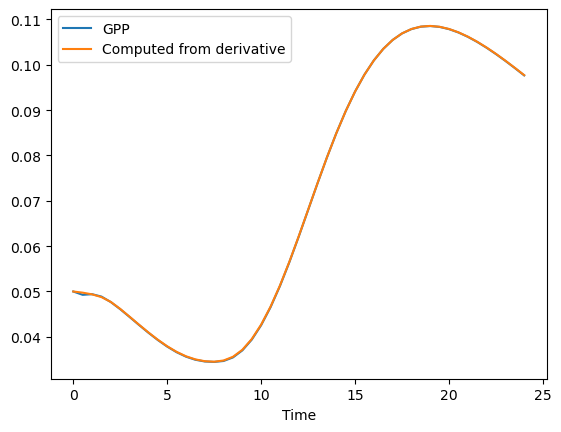

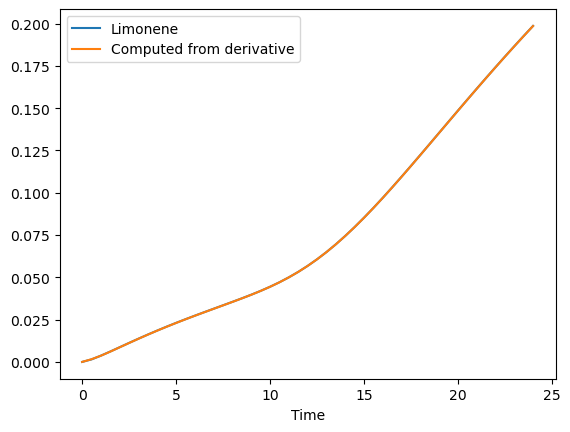

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                       AtoB          HMGS          HMGR            MK   
Strain   Time                                                           
Strain 1 0.0   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.5   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         1.0   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
         1.5   6.303323e+06  5.167157e+06  5.462870e+05  3.570656e+06   
         2.0   6.425365e+06  5.499584e+06  5.913288e+05  3.865639e+06   
...                     ...           ...           ...           ...   
WT       22.0  2.728742e+06  2.682996e+06  1.765870e+06  2.007241e+06   
         22.5  2.729080e+06  2.684265e+06  1.767009e+06  2.008539e+06   
         23.0  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.5  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         24.0  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.5   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         1.5   1.118956e+06  6.520026e+06  3.935836e+06  9.528769e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   
...                     ...           ...           ...           ...   
WT       22.0  1.500014e+06  3.984102e+06  4.352338e+06  1.233945e+06   
         22.5  1.500845e+06  3.987467e+06  4.353087e+06  1.234537e+06   
         23.0  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.5  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         24.0  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                    states                            \
              Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                          
Strain 1 0.0       3.034108e+01   0.300000        0.200000  0.050000   
         0.5       2.866143e+05   0.299893        0.188541  0.068037   
         1.0       3.981392e+05   0.288190        0.174077  0.089557   
         1.5       4.574783e+05   0.274398        0.158853  0.093482   
         2.0       4.943155e+05   0.260551        0.143504  0.080676   
...                         ...        ...             ...       ...   
WT       22.0      1.466213e+06   0.755407        0.013340  0.018112   
         22.5      1.467130e+06   0.765314        0.013753  0.019019   
         23.0      1.468009e+06   0.775039        0.014167  0.019944   
         23.5      1.468851e+06   0.784584        0.014581  0.020886   
         24.0      1.469659e+06   0.793953        0.014996  0.021843   

                                                                           \
                    Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                               
Strain 1 0.0   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.5   0.218933  0.100735  0.200543  0.009250  0.039268  0.049773   
         1.0   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
         1.5   0.179006  0.157845  0.209860  0.005463  0.034856  0.051042   
         2.0   0.188562  0.178523  0.219000  0.004525  0.033388  0.050751   
...                 ...       ...       ...       ...       ...       ...   
WT       22.0  0.111883  0.102630  0.308770  0.013585  0.024759  0.103766   
         22.5  0.112124  0.101762  0.306400  0.013541  0.024553  0.102364   
         23.0  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.5  0.112676  0.100406  0.302

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0     0.003492       -0.021533  0.068282 -0.211321  0.178788   
         0.5    -0.012643       -0.026167  0.038730 -0.110383  0.112107   
         1.0    -0.023589       -0.029322  0.014092 -0.037507  0.064958   
         1.5    -0.029345       -0.030998 -0.005633  0.007307  0.037341   
         2.0    -0.027331       -0.030617 -0.026914  0.017786  0.040362   
...                   ...             ...       ...       ...       ...   
WT       22.0    0.019998        0.000825  0.001796  0.000453 -0.001872   
         22.5    0.019630        0.000827  0.001832  0.000508 -0.001602   
         23.0    0.019269        0.000828  0.001867  0.000554 -0.001353   
         23.5    0.018914        0.000829  0.001899  0.000591 -0.001124   
         24.0    0.018565        0.000828  0.001930  0.000618 -0.000915   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.001573 -0.002269 -0.001983  0.000353  0.001694  
         0.5   0.003675 -0.003001 -0.003208  0.000738  0.002505  
         1.0   0.009271 -0.003204 -0.003821  0.000731  0.003103  
         1.5   0.015214 -0.002876 -0.003819  0.000331  0.003487  
         2.0   0.021619 -0.001475 -0.002599 -0.000977  0.003575  
...                 ...       ...       ...       ...       ...  
WT       22.0 -0.005021 -0.000092 -0.000424 -0.002691  0.012565  
         22.5 -0.004467 -0.000086 -0.000399 -0.002906  0.012399  
         23.0 -0.003951 -0.000080 -0.000374 -0.003079  0.012223  
         23.5 -0.003476 -0.000075 -0.000349 -0.003204  0.012035  
         24.0 -0.003041 -0.000069 -0.000325 -0.003283  0.011835  

[196 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 4.427103E+188 | 7.595163E+113
     2 |       74 | 7.806343E+129 |  3.052104E+84
     3 |      138 |  4.577336E+97 |  9.166712E+81
     4 |      202 |  2.544760E+85 |  1.255472E+71
     5 |      266 |  9.548109E+75 |  1.626664E+55
     6 |      330 |  6.979900E+70 |  2.718835E+53
     7 |      394 |  4.881412E+57 |  2.773164E+47
     8 |      458 |  2.689820E+52 |  8.728066E+31
     9 |      522 |  1.585625E+52 |  8.728066E+31
    10 |      586 |  1.170227E+47 |  8.728066E+31
    11 |      650 |  3.575636E+43 |  6.874062E+30
    12 |      714 |  1.604361E+39 |  3.136918E+26
    13 |      778 |  5.696995E+33 |  3.136918E+26
    14 |      842 |  1.408291E+35 |  7.125210E+21
    15 |      906 |  2.001590E+31 |  7.125210E+21
    16 |      970 |  5.749006E+30 |  7.125210E+21
    17 |     1034 |  1.177051E+27 |  8.654161E+16
    18 |     1098 |  1.342944E+24 |  8.654161E+16
    19 |     1162 |  4.223

   162 |    10314 |  1.700571E+01 |  1.645287E+01
   163 |    10378 |  1.728940E+01 |  1.645287E+01
   164 |    10442 |  1.725893E+01 |  1.645287E+01
   165 |    10506 |  1.747717E+01 |  1.645287E+01
   166 |    10570 |  1.719117E+01 |  1.645287E+01
   167 |    10634 |  1.725181E+01 |  1.622542E+01
   168 |    10698 |  1.734907E+01 |  1.622542E+01
   169 |    10762 |  1.739749E+01 |  1.616530E+01
   170 |    10826 |  1.738456E+01 |  1.616530E+01
   171 |    10890 |  1.714248E+01 |  1.616530E+01
   172 |    10954 |  1.736991E+01 |  1.616530E+01
   173 |    11018 |  1.740013E+01 |  1.616530E+01
   174 |    11082 |  1.692703E+01 |  1.616530E+01
   175 |    11146 |  1.694195E+01 |  1.605883E+01
   176 |    11210 |  1.703197E+01 |  1.605526E+01
   177 |    11274 |  1.715051E+01 |  1.605526E+01
   178 |    11338 |  1.722917E+01 |  1.605526E+01
   179 |    11402 |  1.745351E+01 |  1.605526E+01
   180 |    11466 |  1.715677E+01 |  1.602104E+01
   181 |    11530 |  1.633874E+01 |  1.591521E+01


   326 |    20810 |  1.421433E+01 |  1.404773E+01
   327 |    20874 |  1.417569E+01 |  1.404773E+01
   328 |    20938 |  1.414801E+01 |  1.404773E+01
   329 |    21002 |  1.413296E+01 |  1.401843E+01
   330 |    21066 |  1.415106E+01 |  1.401843E+01
   331 |    21130 |  1.414323E+01 |  1.396659E+01
   332 |    21194 |  1.410397E+01 |  1.396659E+01
   333 |    21258 |  1.410565E+01 |  1.393897E+01
   334 |    21322 |  1.397726E+01 |  1.361593E+01
   335 |    21386 |  1.378987E+01 |  1.354536E+01
   336 |    21450 |  1.376496E+01 |  1.354536E+01
   337 |    21514 |  1.378645E+01 |  1.354536E+01
   338 |    21578 |  1.380051E+01 |  1.354536E+01
   339 |    21642 |  1.389326E+01 |  1.354536E+01
   340 |    21706 |  1.391356E+01 |  1.354536E+01
   341 |    21770 |  1.387527E+01 |  1.354536E+01
   342 |    21834 |  1.391735E+01 |  1.354536E+01
   343 |    21898 |  1.388830E+01 |  1.354536E+01
   344 |    21962 |  1.385704E+01 |  1.354536E+01
   345 |    22026 |  1.378800E+01 |  1.345596E+01


   490 |    31306 |  1.291911E+01 |  1.284711E+01
   491 |    31370 |  1.289415E+01 |  1.284015E+01
   492 |    31434 |  1.288791E+01 |  1.281766E+01
   493 |    31498 |  1.285577E+01 |  1.281342E+01
   494 |    31562 |  1.285211E+01 |  1.279146E+01
   495 |    31626 |  1.283826E+01 |  1.276548E+01
   496 |    31690 |  1.280946E+01 |  1.276548E+01
   497 |    31754 |  1.281122E+01 |  1.275273E+01
   498 |    31818 |  1.280825E+01 |  1.275273E+01
   499 |    31882 |  1.282309E+01 |  1.275273E+01
   500 |    31946 |  1.279279E+01 |  1.275273E+01
   501 |    32010 |  1.278747E+01 |  1.274457E+01
   502 |    32074 |  1.277707E+01 |  1.274457E+01
   503 |    32138 |  1.276057E+01 |  1.274457E+01
   504 |    32202 |  1.276038E+01 |  1.274353E+01
   505 |    32266 |  1.276827E+01 |  1.274353E+01
   506 |    32330 |  1.276258E+01 |  1.274353E+01
   507 |    32394 |  1.277140E+01 |  1.273913E+01
   508 |    32458 |  1.275252E+01 |  1.273132E+01
   509 |    32522 |  1.274849E+01 |  1.273132E+01


   654 |    41802 |  1.259600E+01 |  1.259429E+01
   655 |    41866 |  1.259604E+01 |  1.259429E+01
   656 |    41930 |  1.259494E+01 |  1.259338E+01
   657 |    41994 |  1.259434E+01 |  1.259205E+01
   658 |    42058 |  1.259325E+01 |  1.259191E+01
   659 |    42122 |  1.259254E+01 |  1.259110E+01
   660 |    42186 |  1.259212E+01 |  1.259047E+01
   661 |    42250 |  1.259168E+01 |  1.259047E+01
   662 |    42314 |  1.259133E+01 |  1.258951E+01
   663 |    42378 |  1.259058E+01 |  1.258924E+01
   664 |    42442 |  1.258976E+01 |  1.258810E+01
   665 |    42506 |  1.259021E+01 |  1.258810E+01
   666 |    42570 |  1.258996E+01 |  1.258810E+01
   667 |    42634 |  1.258906E+01 |  1.258810E+01
   668 |    42698 |  1.258823E+01 |  1.258657E+01
   669 |    42762 |  1.258726E+01 |  1.258573E+01
   670 |    42826 |  1.258699E+01 |  1.258573E+01
   671 |    42890 |  1.258691E+01 |  1.258573E+01
   672 |    42954 |  1.258643E+01 |  1.258497E+01
   673 |    43018 |  1.258631E+01 |  1.258497E+01


   818 |    52298 |  1.252481E+01 |  1.252382E+01
   819 |    52362 |  1.252512E+01 |  1.252382E+01
   820 |    52426 |  1.252561E+01 |  1.252382E+01
   821 |    52490 |  1.252541E+01 |  1.252359E+01
   822 |    52554 |  1.252500E+01 |  1.252359E+01
   823 |    52618 |  1.252505E+01 |  1.252359E+01
   824 |    52682 |  1.252463E+01 |  1.252359E+01
   825 |    52746 |  1.252392E+01 |  1.252286E+01
   826 |    52810 |  1.252345E+01 |  1.252216E+01
   827 |    52874 |  1.252293E+01 |  1.252186E+01
   828 |    52938 |  1.252304E+01 |  1.252186E+01
   829 |    53002 |  1.252217E+01 |  1.251959E+01
   830 |    53066 |  1.252145E+01 |  1.251939E+01
   831 |    53130 |  1.252113E+01 |  1.251939E+01
   832 |    53194 |  1.252034E+01 |  1.251924E+01
   833 |    53258 |  1.252013E+01 |  1.251914E+01
   834 |    53322 |  1.251957E+01 |  1.251849E+01
   835 |    53386 |  1.251877E+01 |  1.251781E+01
   836 |    53450 |  1.251757E+01 |  1.251568E+01
   837 |    53514 |  1.251656E+01 |  1.251479E+01


   982 |    62794 |  1.246989E+01 |  1.246951E+01
   983 |    62858 |  1.246979E+01 |  1.246931E+01
   984 |    62922 |  1.246953E+01 |  1.246874E+01
   985 |    62986 |  1.246923E+01 |  1.246860E+01
   986 |    63050 |  1.246888E+01 |  1.246841E+01
   987 |    63114 |  1.246877E+01 |  1.246821E+01
   988 |    63178 |  1.246891E+01 |  1.246781E+01
   989 |    63242 |  1.246863E+01 |  1.246772E+01
   990 |    63306 |  1.246838E+01 |  1.246772E+01
   991 |    63370 |  1.246782E+01 |  1.246697E+01
   992 |    63434 |  1.246781E+01 |  1.246697E+01
   993 |    63498 |  1.246747E+01 |  1.246696E+01
   994 |    63562 |  1.246738E+01 |  1.246642E+01
   995 |    63626 |  1.246730E+01 |  1.246642E+01
   996 |    63690 |  1.246713E+01 |  1.246632E+01
   997 |    63754 |  1.246683E+01 |  1.246626E+01
   998 |    63818 |  1.246660E+01 |  1.246610E+01
   999 |    63882 |  1.246613E+01 |  1.246532E+01
  1000 |    63946 |  1.246574E+01 |  1.246498E+01
  1001 |    64010 |  1.246565E+01 |  1.246498E+01


  1146 |    73290 |  1.242913E+01 |  1.242790E+01
  1147 |    73354 |  1.242840E+01 |  1.242783E+01
  1148 |    73418 |  1.242809E+01 |  1.242738E+01
  1149 |    73482 |  1.242766E+01 |  1.242709E+01
  1150 |    73546 |  1.242740E+01 |  1.242644E+01
  1151 |    73610 |  1.242642E+01 |  1.242558E+01
  1152 |    73674 |  1.242563E+01 |  1.242485E+01
  1153 |    73738 |  1.242524E+01 |  1.242465E+01
  1154 |    73802 |  1.242502E+01 |  1.242407E+01
  1155 |    73866 |  1.242421E+01 |  1.242314E+01
  1156 |    73930 |  1.242313E+01 |  1.242163E+01
  1157 |    73994 |  1.242258E+01 |  1.242119E+01
  1158 |    74058 |  1.242166E+01 |  1.242029E+01
  1159 |    74122 |  1.242103E+01 |  1.241987E+01
  1160 |    74186 |  1.242072E+01 |  1.241973E+01
  1161 |    74250 |  1.242013E+01 |  1.241893E+01
  1162 |    74314 |  1.241970E+01 |  1.241893E+01
  1163 |    74378 |  1.241916E+01 |  1.241774E+01
  1164 |    74442 |  1.241926E+01 |  1.241774E+01
  1165 |    74506 |  1.241897E+01 |  1.241770E+01


  1310 |    83786 |  1.234093E+01 |  1.233891E+01
  1311 |    83850 |  1.234015E+01 |  1.233891E+01
  1312 |    83914 |  1.233935E+01 |  1.233722E+01
  1313 |    83978 |  1.233756E+01 |  1.233597E+01
  1314 |    84042 |  1.233696E+01 |  1.233483E+01
  1315 |    84106 |  1.233606E+01 |  1.233483E+01
  1316 |    84170 |  1.233556E+01 |  1.233461E+01
  1317 |    84234 |  1.233497E+01 |  1.233418E+01
  1318 |    84298 |  1.233482E+01 |  1.233418E+01
  1319 |    84362 |  1.233482E+01 |  1.233378E+01
  1320 |    84426 |  1.233414E+01 |  1.233329E+01
  1321 |    84490 |  1.233401E+01 |  1.233278E+01
  1322 |    84554 |  1.233331E+01 |  1.233235E+01
  1323 |    84618 |  1.233256E+01 |  1.233136E+01
  1324 |    84682 |  1.233192E+01 |  1.233107E+01
  1325 |    84746 |  1.233119E+01 |  1.233008E+01
  1326 |    84810 |  1.233063E+01 |  1.232975E+01
  1327 |    84874 |  1.233034E+01 |  1.232941E+01
  1328 |    84938 |  1.232939E+01 |  1.232833E+01
  1329 |    85002 |  1.232893E+01 |  1.232703E+01


  1474 |    94282 |  1.223654E+01 |  1.223594E+01
  1475 |    94346 |  1.223645E+01 |  1.223523E+01
  1476 |    94410 |  1.223610E+01 |  1.223518E+01
  1477 |    94474 |  1.223608E+01 |  1.223333E+01
  1478 |    94538 |  1.223476E+01 |  1.223324E+01
  1479 |    94602 |  1.223389E+01 |  1.223286E+01
  1480 |    94666 |  1.223312E+01 |  1.223181E+01
  1481 |    94730 |  1.223258E+01 |  1.223068E+01
  1482 |    94794 |  1.223171E+01 |  1.223068E+01
  1483 |    94858 |  1.223094E+01 |  1.223019E+01
  1484 |    94922 |  1.223068E+01 |  1.222951E+01
  1485 |    94986 |  1.223067E+01 |  1.222951E+01
  1486 |    95050 |  1.223006E+01 |  1.222901E+01
  1487 |    95114 |  1.222945E+01 |  1.222850E+01
  1488 |    95178 |  1.222874E+01 |  1.222773E+01
  1489 |    95242 |  1.222812E+01 |  1.222735E+01
  1490 |    95306 |  1.222755E+01 |  1.222674E+01
  1491 |    95370 |  1.222723E+01 |  1.222667E+01
  1492 |    95434 |  1.222670E+01 |  1.222555E+01
  1493 |    95498 |  1.222622E+01 |  1.222555E+01


  1638 |   104778 |  1.214411E+01 |  1.214208E+01
  1639 |   104842 |  1.214319E+01 |  1.213987E+01
  1640 |   104906 |  1.214240E+01 |  1.213987E+01
  1641 |   104970 |  1.214131E+01 |  1.213895E+01
  1642 |   105034 |  1.213993E+01 |  1.213625E+01
  1643 |   105098 |  1.213780E+01 |  1.213625E+01
  1644 |   105162 |  1.213715E+01 |  1.213577E+01
  1645 |   105226 |  1.213591E+01 |  1.213477E+01
  1646 |   105290 |  1.213527E+01 |  1.213415E+01
  1647 |   105354 |  1.213514E+01 |  1.213364E+01
  1648 |   105418 |  1.213459E+01 |  1.213347E+01
  1649 |   105482 |  1.213482E+01 |  1.213347E+01
  1650 |   105546 |  1.213447E+01 |  1.213347E+01
  1651 |   105610 |  1.213366E+01 |  1.213152E+01
  1652 |   105674 |  1.213227E+01 |  1.213108E+01
  1653 |   105738 |  1.213117E+01 |  1.212891E+01
  1654 |   105802 |  1.213071E+01 |  1.212891E+01
  1655 |   105866 |  1.212977E+01 |  1.212891E+01
  1656 |   105930 |  1.212958E+01 |  1.212881E+01
  1657 |   105994 |  1.212912E+01 |  1.212752E+01


  1802 |   115274 |  1.204248E+01 |  1.204108E+01
  1803 |   115338 |  1.204205E+01 |  1.204069E+01
  1804 |   115402 |  1.204097E+01 |  1.204019E+01
  1805 |   115466 |  1.204054E+01 |  1.203993E+01
  1806 |   115530 |  1.204031E+01 |  1.203973E+01
  1807 |   115594 |  1.204013E+01 |  1.203955E+01
  1808 |   115658 |  1.203981E+01 |  1.203907E+01
  1809 |   115722 |  1.203886E+01 |  1.203796E+01
  1810 |   115786 |  1.203837E+01 |  1.203743E+01
  1811 |   115850 |  1.203775E+01 |  1.203631E+01
  1812 |   115914 |  1.203716E+01 |  1.203630E+01
  1813 |   115978 |  1.203691E+01 |  1.203630E+01
  1814 |   116042 |  1.203666E+01 |  1.203600E+01
  1815 |   116106 |  1.203621E+01 |  1.203544E+01
  1816 |   116170 |  1.203614E+01 |  1.203544E+01
  1817 |   116234 |  1.203589E+01 |  1.203544E+01
  1818 |   116298 |  1.203534E+01 |  1.203478E+01
  1819 |   116362 |  1.203493E+01 |  1.203432E+01
  1820 |   116426 |  1.203431E+01 |  1.203353E+01
  1821 |   116490 |  1.203398E+01 |  1.203286E+01


  1966 |   125770 |  1.194777E+01 |  1.194699E+01
  1967 |   125834 |  1.194729E+01 |  1.194668E+01
  1968 |   125898 |  1.194690E+01 |  1.194644E+01
  1969 |   125962 |  1.194654E+01 |  1.194518E+01
  1970 |   126026 |  1.194553E+01 |  1.194412E+01
  1971 |   126090 |  1.194469E+01 |  1.194350E+01
  1972 |   126154 |  1.194408E+01 |  1.194312E+01
  1973 |   126218 |  1.194344E+01 |  1.194244E+01
  1974 |   126282 |  1.194317E+01 |  1.194244E+01
  1975 |   126346 |  1.194288E+01 |  1.194244E+01
  1976 |   126410 |  1.194229E+01 |  1.194160E+01
  1977 |   126474 |  1.194203E+01 |  1.194145E+01
  1978 |   126538 |  1.194167E+01 |  1.194119E+01
  1979 |   126602 |  1.194135E+01 |  1.194068E+01
  1980 |   126666 |  1.194082E+01 |  1.193993E+01
  1981 |   126730 |  1.194027E+01 |  1.193898E+01
  1982 |   126794 |  1.194019E+01 |  1.193898E+01
  1983 |   126858 |  1.193937E+01 |  1.193872E+01
  1984 |   126922 |  1.193872E+01 |  1.193797E+01
  1985 |   126986 |  1.193844E+01 |  1.193769E+01


  2130 |   136266 |  1.180811E+01 |  1.180311E+01
  2131 |   136330 |  1.180734E+01 |  1.180311E+01
  2132 |   136394 |  1.180675E+01 |  1.180311E+01
  2133 |   136458 |  1.180453E+01 |  1.180311E+01
  2134 |   136522 |  1.180430E+01 |  1.180151E+01
  2135 |   136586 |  1.180441E+01 |  1.180151E+01
  2136 |   136650 |  1.180423E+01 |  1.179830E+01
  2137 |   136714 |  1.180453E+01 |  1.179830E+01
  2138 |   136778 |  1.180251E+01 |  1.179381E+01
  2139 |   136842 |  1.180030E+01 |  1.179381E+01
  2140 |   136906 |  1.179992E+01 |  1.179381E+01
  2141 |   136970 |  1.179827E+01 |  1.178967E+01
  2142 |   137034 |  1.179558E+01 |  1.178656E+01
  2143 |   137098 |  1.179309E+01 |  1.178307E+01
  2144 |   137162 |  1.179000E+01 |  1.178098E+01
  2145 |   137226 |  1.178552E+01 |  1.177723E+01
  2146 |   137290 |  1.178378E+01 |  1.177010E+01
  2147 |   137354 |  1.178044E+01 |  1.176885E+01
  2148 |   137418 |  1.177441E+01 |  1.176551E+01
  2149 |   137482 |  1.177389E+01 |  1.176545E+01


  2294 |   146762 |  1.143837E+01 |  1.143224E+01
  2295 |   146826 |  1.143694E+01 |  1.143220E+01
  2296 |   146890 |  1.143452E+01 |  1.142916E+01
  2297 |   146954 |  1.143387E+01 |  1.142492E+01
  2298 |   147018 |  1.142989E+01 |  1.142201E+01
  2299 |   147082 |  1.142475E+01 |  1.141558E+01
  2300 |   147146 |  1.141947E+01 |  1.141026E+01
  2301 |   147210 |  1.141511E+01 |  1.140812E+01
  2302 |   147274 |  1.141174E+01 |  1.140710E+01
  2303 |   147338 |  1.141178E+01 |  1.140710E+01
  2304 |   147402 |  1.141037E+01 |  1.140590E+01
  2305 |   147466 |  1.140499E+01 |  1.140096E+01
  2306 |   147530 |  1.140334E+01 |  1.139800E+01
  2307 |   147594 |  1.139927E+01 |  1.139542E+01
  2308 |   147658 |  1.139898E+01 |  1.139263E+01
  2309 |   147722 |  1.139504E+01 |  1.139118E+01
  2310 |   147786 |  1.139358E+01 |  1.139118E+01
  2311 |   147850 |  1.139088E+01 |  1.138647E+01
  2312 |   147914 |  1.138928E+01 |  1.138647E+01
  2313 |   147978 |  1.138721E+01 |  1.138346E+01


  2458 |   157258 |  1.088202E+01 |  1.086668E+01
  2459 |   157322 |  1.087045E+01 |  1.085235E+01
  2460 |   157386 |  1.085882E+01 |  1.083376E+01
  2461 |   157450 |  1.084652E+01 |  1.083308E+01
  2462 |   157514 |  1.084589E+01 |  1.083308E+01
  2463 |   157578 |  1.083902E+01 |  1.081936E+01
  2464 |   157642 |  1.082644E+01 |  1.081936E+01
  2465 |   157706 |  1.081763E+01 |  1.079658E+01
  2466 |   157770 |  1.080195E+01 |  1.078365E+01
  2467 |   157834 |  1.079746E+01 |  1.078365E+01
  2468 |   157898 |  1.078996E+01 |  1.078212E+01
  2469 |   157962 |  1.078593E+01 |  1.077039E+01
  2470 |   158026 |  1.078217E+01 |  1.076981E+01
  2471 |   158090 |  1.076750E+01 |  1.074965E+01
  2472 |   158154 |  1.075923E+01 |  1.073421E+01
  2473 |   158218 |  1.074437E+01 |  1.071411E+01
  2474 |   158282 |  1.073651E+01 |  1.071411E+01
  2475 |   158346 |  1.072296E+01 |  1.067102E+01
  2476 |   158410 |  1.070681E+01 |  1.067102E+01
  2477 |   158474 |  1.069040E+01 |  1.066374E+01


  2622 |   167754 |  9.4815074744 |  9.4700032178
  2623 |   167818 |  9.4789843505 |  9.4692282572
  2624 |   167882 |  9.4769504837 |  9.4655966230
  2625 |   167946 |  9.4817411191 |  9.4655966230
  2626 |   168010 |  9.4872906923 |  9.4655966230
  2627 |   168074 |  9.4879806432 |  9.4655966230
  2628 |   168138 |  9.4768141550 |  9.4634666586
  2629 |   168202 |  9.4803252723 |  9.4634666586
  2630 |   168266 |  9.4817194540 |  9.4634666586
  2631 |   168330 |  9.4753005733 |  9.4634666586
  2632 |   168394 |  9.4787297693 |  9.4634666586
  2633 |   168458 |  9.4737334841 |  9.4597224947
  2634 |   168522 |  9.4684155101 |  9.4574658730
  2635 |   168586 |  9.4726307530 |  9.4574658730
  2636 |   168650 |  9.4698902186 |  9.4566454538
  2637 |   168714 |  9.4660989766 |  9.4551439212
  2638 |   168778 |  9.4665838568 |  9.4551439212
  2639 |   168842 |  9.4658336813 |  9.4526594793
  2640 |   168906 |  9.4628481270 |  9.4479172256
  2641 |   168970 |  9.4587850191 |  9.4479172256


  2786 |   178250 |  9.3028269710 |  9.3003927941
  2787 |   178314 |  9.3026315908 |  9.3003927941
  2788 |   178378 |  9.3019034661 |  9.3003131235
  2789 |   178442 |  9.3015730379 |  9.2994341382
  2790 |   178506 |  9.3017468901 |  9.2994341382
  2791 |   178570 |  9.3003274091 |  9.2987370590
  2792 |   178634 |  9.3009607701 |  9.2987370590
  2793 |   178698 |  9.3015485637 |  9.2983767583
  2794 |   178762 |  9.2998567309 |  9.2983767583
  2795 |   178826 |  9.2998773592 |  9.2971239628
  2796 |   178890 |  9.2990189210 |  9.2971239628
  2797 |   178954 |  9.2988199630 |  9.2963872187
  2798 |   179018 |  9.2974486734 |  9.2954176735
  2799 |   179082 |  9.2968051380 |  9.2954168583
  2800 |   179146 |  9.2960871718 |  9.2949149144
  2801 |   179210 |  9.2961710236 |  9.2949149144
  2802 |   179274 |  9.2960641721 |  9.2949149144
  2803 |   179338 |  9.2958993018 |  9.2948776976
  2804 |   179402 |  9.2953875103 |  9.2941815307
  2805 |   179466 |  9.2951615849 |  9.2941815307


  2950 |   188746 |  9.2353358259 |  9.2337914921
  2951 |   188810 |  9.2334897294 |  9.2307760748
  2952 |   188874 |  9.2317705877 |  9.2297519584
  2953 |   188938 |  9.2303107524 |  9.2270898760
  2954 |   189002 |  9.2266832420 |  9.2173390375
  2955 |   189066 |  9.2184322570 |  9.2131570361
  2956 |   189130 |  9.2133900954 |  9.2082211252
  2957 |   189194 |  9.2092841696 |  9.2054501853
  2958 |   189258 |  9.2032225099 |  9.1966839435
  2959 |   189322 |  9.1969061122 |  9.1900791971
  2960 |   189386 |  9.1917257322 |  9.1885899033
  2961 |   189450 |  9.1856633440 |  9.1810883181
  2962 |   189514 |  9.1798059260 |  9.1757705267
  2963 |   189578 |  9.1754124054 |  9.1719870609
  2964 |   189642 |  9.1706305418 |  9.1625047282
  2965 |   189706 |  9.1644345291 |  9.1593904372
  2966 |   189770 |  9.1598297048 |  9.1559233412
  2967 |   189834 |  9.1573131971 |  9.1516404351
  2968 |   189898 |  9.1539390074 |  9.1493321124
  2969 |   189962 |  9.1483170711 |  9.1399885303


  3114 |   199242 |  7.6556407324 |  7.6480921576
  3115 |   199306 |  7.6495661895 |  7.6380203853
  3116 |   199370 |  7.6427249622 |  7.6350196229
  3117 |   199434 |  7.6433253783 |  7.6350196229
  3118 |   199498 |  7.6409249439 |  7.6265754527
  3119 |   199562 |  7.6369112327 |  7.6260012815
  3120 |   199626 |  7.6328547600 |  7.6236785723
  3121 |   199690 |  7.6293556026 |  7.6187763929
  3122 |   199754 |  7.6248353087 |  7.6187763929
  3123 |   199818 |  7.6262584534 |  7.6172934552
  3124 |   199882 |  7.6267520637 |  7.6172934552
  3125 |   199946 |  7.6244531527 |  7.6172934552
  3126 |   200010 |  7.6185793111 |  7.6004610875
  3127 |   200074 |  7.6094898848 |  7.6004610875
  3128 |   200138 |  7.6081953107 |  7.6004610875
  3129 |   200202 |  7.6013301762 |  7.5902111038
  3130 |   200266 |  7.5982448733 |  7.5902111038
  3131 |   200330 |  7.5928509137 |  7.5876626797
  3132 |   200394 |  7.5916658838 |  7.5836811803
  3133 |   200458 |  7.5910796534 |  7.5836811803


  3278 |   209738 |  7.0914976688 |  7.0789400574
  3279 |   209802 |  7.0883131147 |  7.0767549990
  3280 |   209866 |  7.0860226079 |  7.0728171907
  3281 |   209930 |  7.0805628329 |  7.0578201190
  3282 |   209994 |  7.0737273405 |  7.0500103615
  3283 |   210058 |  7.0687461034 |  7.0500103615
  3284 |   210122 |  7.0590594261 |  7.0480060620
  3285 |   210186 |  7.0558686407 |  7.0440001662
  3286 |   210250 |  7.0557201173 |  7.0440001662
  3287 |   210314 |  7.0527287533 |  7.0394796193
  3288 |   210378 |  7.0592365880 |  7.0394796193
  3289 |   210442 |  7.0637915498 |  7.0394796193
  3290 |   210506 |  7.0551464864 |  7.0375260599
  3291 |   210570 |  7.0499888710 |  7.0313675041
  3292 |   210634 |  7.0428492022 |  7.0184079463
  3293 |   210698 |  7.0323643260 |  7.0138054803
  3294 |   210762 |  7.0213268781 |  7.0069019071
  3295 |   210826 |  7.0132105514 |  7.0069019071
  3296 |   210890 |  7.0142756079 |  7.0069019071
  3297 |   210954 |  7.0040314350 |  6.9943846051


  3442 |   220234 |  6.7101764000 |  6.7067760231
  3443 |   220298 |  6.7098323192 |  6.7067760231
  3444 |   220362 |  6.7086903804 |  6.7059380257
  3445 |   220426 |  6.7077557836 |  6.7042264904
  3446 |   220490 |  6.7060729072 |  6.6999998610
  3447 |   220554 |  6.7047868978 |  6.6999998610
  3448 |   220618 |  6.7033070387 |  6.6999998610
  3449 |   220682 |  6.7020746275 |  6.6959431413
  3450 |   220746 |  6.6981276221 |  6.6937333126
  3451 |   220810 |  6.6957507573 |  6.6914553052
  3452 |   220874 |  6.6942467154 |  6.6902779724
  3453 |   220938 |  6.6920307570 |  6.6888253307
  3454 |   221002 |  6.6908491561 |  6.6886865361
  3455 |   221066 |  6.6884781352 |  6.6833759030
  3456 |   221130 |  6.6873067104 |  6.6833759030
  3457 |   221194 |  6.6847148878 |  6.6833759030
  3458 |   221258 |  6.6841722653 |  6.6811124142
  3459 |   221322 |  6.6812823987 |  6.6788953838
  3460 |   221386 |  6.6787744809 |  6.6771638770
  3461 |   221450 |  6.6772146616 |  6.6723028058


  3606 |   230730 |  6.5467483043 |  6.5453313521
  3607 |   230794 |  6.5462129763 |  6.5453115319
  3608 |   230858 |  6.5459155523 |  6.5451400252
  3609 |   230922 |  6.5454026371 |  6.5448793553
  3610 |   230986 |  6.5448968125 |  6.5439634006
  3611 |   231050 |  6.5441188293 |  6.5434775688
  3612 |   231114 |  6.5437593040 |  6.5429574719
  3613 |   231178 |  6.5436075504 |  6.5429574719
  3614 |   231242 |  6.5432164954 |  6.5426452645
  3615 |   231306 |  6.5432375058 |  6.5418704562
  3616 |   231370 |  6.5423847481 |  6.5414959318
  3617 |   231434 |  6.5418220735 |  6.5411649580
  3618 |   231498 |  6.5410031074 |  6.5399137454
  3619 |   231562 |  6.5406629414 |  6.5397517673
  3620 |   231626 |  6.5402780027 |  6.5396024724
  3621 |   231690 |  6.5399216289 |  6.5388419429
  3622 |   231754 |  6.5396039929 |  6.5388419429
  3623 |   231818 |  6.5393511638 |  6.5388419429
  3624 |   231882 |  6.5389507964 |  6.5380479100
  3625 |   231946 |  6.5381301622 |  6.5370369708


  3770 |   241226 |  6.4895772213 |  6.4892863068
  3771 |   241290 |  6.4895442893 |  6.4892863068
  3772 |   241354 |  6.4893879049 |  6.4888698006
  3773 |   241418 |  6.4890103061 |  6.4887420036
  3774 |   241482 |  6.4889809031 |  6.4887420036
  3775 |   241546 |  6.4889073075 |  6.4885141003
  3776 |   241610 |  6.4888396954 |  6.4885141003
  3777 |   241674 |  6.4885710380 |  6.4883440565
  3778 |   241738 |  6.4885046669 |  6.4883440565
  3779 |   241802 |  6.4883547449 |  6.4880772845
  3780 |   241866 |  6.4882189998 |  6.4880772845
  3781 |   241930 |  6.4880510486 |  6.4876169384
  3782 |   241994 |  6.4878853162 |  6.4876169384
  3783 |   242058 |  6.4877695803 |  6.4872488403
  3784 |   242122 |  6.4874116270 |  6.4869109199
  3785 |   242186 |  6.4871478219 |  6.4867640276
  3786 |   242250 |  6.4870691403 |  6.4866109295
  3787 |   242314 |  6.4870167898 |  6.4864727353
  3788 |   242378 |  6.4867821867 |  6.4864727353
  3789 |   242442 |  6.4866817450 |  6.4862611263


  3934 |   251722 |  6.4014822540 |  6.3993812210
  3935 |   251786 |  6.4002480401 |  6.3977129486
  3936 |   251850 |  6.3994889849 |  6.3977129486
  3937 |   251914 |  6.3989575000 |  6.3970579300
  3938 |   251978 |  6.3984802010 |  6.3970579300
  3939 |   252042 |  6.3979763750 |  6.3964167242
  3940 |   252106 |  6.3971060574 |  6.3961205907
  3941 |   252170 |  6.3946662886 |  6.3913280936
  3942 |   252234 |  6.3935354802 |  6.3911110076
  3943 |   252298 |  6.3921300175 |  6.3911110076
  3944 |   252362 |  6.3915261637 |  6.3892579339
  3945 |   252426 |  6.3905730242 |  6.3892579339
  3946 |   252490 |  6.3907050470 |  6.3892579339
  3947 |   252554 |  6.3894169350 |  6.3878284225
  3948 |   252618 |  6.3882637444 |  6.3862450165
  3949 |   252682 |  6.3874873143 |  6.3861004828
  3950 |   252746 |  6.3868116477 |  6.3849154474
  3951 |   252810 |  6.3848904973 |  6.3817553660
  3952 |   252874 |  6.3832477561 |  6.3817553660
  3953 |   252938 |  6.3828434860 |  6.3813273238


  4098 |   262218 |  6.2231025238 |  6.2211475702
  4099 |   262282 |  6.2227625215 |  6.2211475702
  4100 |   262346 |  6.2216923166 |  6.2204005359
  4101 |   262410 |  6.2207009123 |  6.2197463058
  4102 |   262474 |  6.2206626756 |  6.2194322694
  4103 |   262538 |  6.2201243910 |  6.2185545017
  4104 |   262602 |  6.2192171679 |  6.2180934205
  4105 |   262666 |  6.2188218578 |  6.2171269054
  4106 |   262730 |  6.2178522155 |  6.2167611593
  4107 |   262794 |  6.2181904377 |  6.2167611593
  4108 |   262858 |  6.2169691124 |  6.2140086002
  4109 |   262922 |  6.2154613535 |  6.2131313739
  4110 |   262986 |  6.2143870273 |  6.2131313739
  4111 |   263050 |  6.2138070033 |  6.2122862676
  4112 |   263114 |  6.2131837243 |  6.2118535765
  4113 |   263178 |  6.2121564910 |  6.2107354461
  4114 |   263242 |  6.2110697361 |  6.2095091927
  4115 |   263306 |  6.2108005033 |  6.2095091927
  4116 |   263370 |  6.2102611686 |  6.2093242645
  4117 |   263434 |  6.2095654129 |  6.2091572237


  4262 |   272714 |  6.0557583727 |  6.0537557653
  4263 |   272778 |  6.0552326884 |  6.0527003091
  4264 |   272842 |  6.0549743161 |  6.0505233528
  4265 |   272906 |  6.0525224129 |  6.0503744846
  4266 |   272970 |  6.0519037032 |  6.0491365088
  4267 |   273034 |  6.0510555202 |  6.0483992137
  4268 |   273098 |  6.0500277653 |  6.0473222131
  4269 |   273162 |  6.0497709384 |  6.0471817799
  4270 |   273226 |  6.0486815371 |  6.0452984297
  4271 |   273290 |  6.0472794073 |  6.0452984297
  4272 |   273354 |  6.0476420399 |  6.0450879726
  4273 |   273418 |  6.0458845219 |  6.0445740766
  4274 |   273482 |  6.0471579242 |  6.0445740766
  4275 |   273546 |  6.0459127023 |  6.0389409899
  4276 |   273610 |  6.0425517256 |  6.0377175275
  4277 |   273674 |  6.0408185370 |  6.0349744703
  4278 |   273738 |  6.0406135922 |  6.0345505711
  4279 |   273802 |  6.0396294414 |  6.0323335819
  4280 |   273866 |  6.0358901840 |  6.0323335819
  4281 |   273930 |  6.0340492821 |  6.0294396325


  4426 |   283210 |  5.8479757241 |  5.8449346584
  4427 |   283274 |  5.8468530831 |  5.8449346584
  4428 |   283338 |  5.8453562406 |  5.8441754910
  4429 |   283402 |  5.8454702178 |  5.8441754910
  4430 |   283466 |  5.8450360301 |  5.8431388806
  4431 |   283530 |  5.8447754310 |  5.8431388806
  4432 |   283594 |  5.8446564328 |  5.8430955315
  4433 |   283658 |  5.8443050627 |  5.8430955315
  4434 |   283722 |  5.8443976307 |  5.8427775819
  4435 |   283786 |  5.8436336842 |  5.8427383267
  4436 |   283850 |  5.8429882375 |  5.8421702045
  4437 |   283914 |  5.8427820872 |  5.8421077923
  4438 |   283978 |  5.8429465150 |  5.8414137567
  4439 |   284042 |  5.8422052170 |  5.8404707259
  4440 |   284106 |  5.8411266941 |  5.8384937869
  4441 |   284170 |  5.8410260469 |  5.8384937869
  4442 |   284234 |  5.8397213093 |  5.8377994748
  4443 |   284298 |  5.8401190490 |  5.8377994748
  4444 |   284362 |  5.8397797217 |  5.8377994748
  4445 |   284426 |  5.8404881421 |  5.8377994748


  4590 |   293706 |  5.7528893819 |  5.7519541809
  4591 |   293770 |  5.7527843552 |  5.7513252038
  4592 |   293834 |  5.7516321129 |  5.7505984384
  4593 |   293898 |  5.7514830409 |  5.7505984384
  4594 |   293962 |  5.7514470452 |  5.7505984384
  4595 |   294026 |  5.7512815563 |  5.7505636485
  4596 |   294090 |  5.7507389941 |  5.7495575789
  4597 |   294154 |  5.7501274725 |  5.7491308833
  4598 |   294218 |  5.7494316783 |  5.7486458995
  4599 |   294282 |  5.7490844869 |  5.7484104043
  4600 |   294346 |  5.7488150588 |  5.7482468324
  4601 |   294410 |  5.7486093064 |  5.7478530229
  4602 |   294474 |  5.7482839559 |  5.7472571815
  4603 |   294538 |  5.7478008478 |  5.7472571815
  4604 |   294602 |  5.7479002016 |  5.7472571815
  4605 |   294666 |  5.7475528782 |  5.7467344341
  4606 |   294730 |  5.7473295567 |  5.7467344341
  4607 |   294794 |  5.7472327954 |  5.7460710787
  4608 |   294858 |  5.7466621246 |  5.7457618676
  4609 |   294922 |  5.7457100772 |  5.7448597904


  4754 |   304202 |  5.6101927025 |  5.6086017135
  4755 |   304266 |  5.6096623449 |  5.6082275852
  4756 |   304330 |  5.6089770491 |  5.6081404747
  4757 |   304394 |  5.6086402298 |  5.6080354514
  4758 |   304458 |  5.6079723463 |  5.6069304668
  4759 |   304522 |  5.6077091243 |  5.6069304668
  4760 |   304586 |  5.6071006045 |  5.6061568418
  4761 |   304650 |  5.6063581308 |  5.6048503314
  4762 |   304714 |  5.6055989276 |  5.6046296414
  4763 |   304778 |  5.6048731673 |  5.6041474989
  4764 |   304842 |  5.6042441403 |  5.6019279229
  4765 |   304906 |  5.6033298172 |  5.6019279229
  4766 |   304970 |  5.6027774222 |  5.6017698831
  4767 |   305034 |  5.6017214893 |  5.6008808372
  4768 |   305098 |  5.6011302764 |  5.5999278680
  4769 |   305162 |  5.6000519377 |  5.5982481526
  4770 |   305226 |  5.5989531718 |  5.5980379565
  4771 |   305290 |  5.5984636029 |  5.5978250336
  4772 |   305354 |  5.5980442100 |  5.5976635458
  4773 |   305418 |  5.5972476094 |  5.5965180911


  4918 |   314698 |  5.3913298094 |  5.3891136643
  4919 |   314762 |  5.3905132667 |  5.3891136643
  4920 |   314826 |  5.3897479848 |  5.3886013170
  4921 |   314890 |  5.3893824474 |  5.3874328253
  4922 |   314954 |  5.3884014780 |  5.3867952324
  4923 |   315018 |  5.3878353760 |  5.3858569208
  4924 |   315082 |  5.3865312953 |  5.3846767425
  4925 |   315146 |  5.3848750982 |  5.3838044550
  4926 |   315210 |  5.3846671659 |  5.3797722931
  4927 |   315274 |  5.3836978160 |  5.3797722931
  4928 |   315338 |  5.3810000713 |  5.3775840454
  4929 |   315402 |  5.3795320326 |  5.3771663804
  4930 |   315466 |  5.3775555923 |  5.3748366399
  4931 |   315530 |  5.3750362632 |  5.3737793584
  4932 |   315594 |  5.3740167903 |  5.3737052205
  4933 |   315658 |  5.3733712502 |  5.3723224908
  4934 |   315722 |  5.3726210032 |  5.3706972745
  4935 |   315786 |  5.3715314570 |  5.3702066761
  4936 |   315850 |  5.3705253961 |  5.3694999778
  4937 |   315914 |  5.3697307181 |  5.3685010956


  5082 |   325194 |  5.3293425959 |  5.3291541104
  5083 |   325258 |  5.3289820595 |  5.3284387430
  5084 |   325322 |  5.3285359994 |  5.3281890763
  5085 |   325386 |  5.3282604519 |  5.3277322989
  5086 |   325450 |  5.3278623175 |  5.3274237586
  5087 |   325514 |  5.3277248398 |  5.3274237586
  5088 |   325578 |  5.3275374001 |  5.3269528218
  5089 |   325642 |  5.3273351278 |  5.3267714293
  5090 |   325706 |  5.3272843647 |  5.3267714293
  5091 |   325770 |  5.3271618904 |  5.3267714293
  5092 |   325834 |  5.3269304271 |  5.3263879586
  5093 |   325898 |  5.3265656873 |  5.3261200407
  5094 |   325962 |  5.3262639554 |  5.3256937554
  5095 |   326026 |  5.3259031032 |  5.3256538937
  5096 |   326090 |  5.3257009689 |  5.3253044681
  5097 |   326154 |  5.3253786415 |  5.3248081482
  5098 |   326218 |  5.3251096776 |  5.3245714370
  5099 |   326282 |  5.3245011293 |  5.3240128847
  5100 |   326346 |  5.3241174126 |  5.3238207709
  5101 |   326410 |  5.3239002542 |  5.3230062150


  5246 |   335690 |  4.9732844756 |  4.9670622462
  5247 |   335754 |  4.9698919234 |  4.9637604025
  5248 |   335818 |  4.9672504358 |  4.9611683209
  5249 |   335882 |  4.9638196270 |  4.9594721063
  5250 |   335946 |  4.9611104086 |  4.9528792404
  5251 |   336010 |  4.9569534981 |  4.9513785828
  5252 |   336074 |  4.9549852373 |  4.9500683456
  5253 |   336138 |  4.9515661301 |  4.9471861319
  5254 |   336202 |  4.9482373845 |  4.9408302746
  5255 |   336266 |  4.9448011780 |  4.9395888580
  5256 |   336330 |  4.9398970776 |  4.9279711059
  5257 |   336394 |  4.9338479268 |  4.9279711059
  5258 |   336458 |  4.9313757662 |  4.9240477565
  5259 |   336522 |  4.9272183516 |  4.9221311870
  5260 |   336586 |  4.9229479120 |  4.9162169762
  5261 |   336650 |  4.9203449678 |  4.9094126004
  5262 |   336714 |  4.9150163585 |  4.9040342726
  5263 |   336778 |  4.9100959514 |  4.9023794869
  5264 |   336842 |  4.9070399213 |  4.9012381280
  5265 |   336906 |  4.9030317633 |  4.8954374859


  5410 |   346186 |  4.5492800108 |  4.5464290115
  5411 |   346250 |  4.5484970224 |  4.5450792945
  5412 |   346314 |  4.5482461368 |  4.5450792945
  5413 |   346378 |  4.5462892686 |  4.5440811081
  5414 |   346442 |  4.5450779960 |  4.5436797568
  5415 |   346506 |  4.5441683708 |  4.5423731278
  5416 |   346570 |  4.5432405266 |  4.5404442478
  5417 |   346634 |  4.5415468960 |  4.5394209408
  5418 |   346698 |  4.5410317102 |  4.5377971718
  5419 |   346762 |  4.5400716999 |  4.5377971718
  5420 |   346826 |  4.5392113688 |  4.5373173413
  5421 |   346890 |  4.5386317929 |  4.5350998821
  5422 |   346954 |  4.5372527604 |  4.5350998821
  5423 |   347018 |  4.5385957027 |  4.5350998821
  5424 |   347082 |  4.5370296187 |  4.5311481478
  5425 |   347146 |  4.5357059300 |  4.5288583225
  5426 |   347210 |  4.5326886191 |  4.5288583225
  5427 |   347274 |  4.5324156617 |  4.5278065240
  5428 |   347338 |  4.5315411921 |  4.5217531911
  5429 |   347402 |  4.5283796708 |  4.5217531911


  5574 |   356682 |  4.3613085978 |  4.3602219377
  5575 |   356746 |  4.3602859320 |  4.3594339781
  5576 |   356810 |  4.3595338154 |  4.3591600057
  5577 |   356874 |  4.3594557091 |  4.3584286560
  5578 |   356938 |  4.3584331051 |  4.3577454583
  5579 |   357002 |  4.3579997773 |  4.3569995241
  5580 |   357066 |  4.3577405600 |  4.3566479325
  5581 |   357130 |  4.3572342058 |  4.3556090923
  5582 |   357194 |  4.3560070786 |  4.3542973438
  5583 |   357258 |  4.3555899351 |  4.3537454061
  5584 |   357322 |  4.3553698466 |  4.3537454061
  5585 |   357386 |  4.3553351871 |  4.3537454061
  5586 |   357450 |  4.3546636583 |  4.3537454061
  5587 |   357514 |  4.3543834248 |  4.3532869346
  5588 |   357578 |  4.3539160494 |  4.3524993533
  5589 |   357642 |  4.3534250582 |  4.3524993533
  5590 |   357706 |  4.3539023895 |  4.3524993533
  5591 |   357770 |  4.3539957798 |  4.3521459727
  5592 |   357834 |  4.3537886244 |  4.3521459727
  5593 |   357898 |  4.3526043724 |  4.3509663197


  5738 |   367178 |  4.0963169396 |  4.0869490575
  5739 |   367242 |  4.0961686343 |  4.0869490575
  5740 |   367306 |  4.0932294791 |  4.0869490575
  5741 |   367370 |  4.0912352824 |  4.0856564888
  5742 |   367434 |  4.0885281145 |  4.0856564888
  5743 |   367498 |  4.0917364006 |  4.0856564888
  5744 |   367562 |  4.0953509422 |  4.0856564888
  5745 |   367626 |  4.0920247109 |  4.0856564888
  5746 |   367690 |  4.0889469184 |  4.0814618767
  5747 |   367754 |  4.0873419484 |  4.0806112842
  5748 |   367818 |  4.0864112060 |  4.0765117216
  5749 |   367882 |  4.0850521595 |  4.0737765564
  5750 |   367946 |  4.0780541950 |  4.0724841941
  5751 |   368010 |  4.0777615468 |  4.0713986530
  5752 |   368074 |  4.0741989976 |  4.0697075033
  5753 |   368138 |  4.0732402563 |  4.0678115721
  5754 |   368202 |  4.0739789203 |  4.0678115721
  5755 |   368266 |  4.0726834388 |  4.0678115721
  5756 |   368330 |  4.0717299839 |  4.0678115721
  5757 |   368394 |  4.0747738650 |  4.0678115721


  5902 |   377674 |  3.9544780473 |  3.9528263216
  5903 |   377738 |  3.9544522094 |  3.9518463605
  5904 |   377802 |  3.9533634654 |  3.9517351728
  5905 |   377866 |  3.9532155932 |  3.9511946220
  5906 |   377930 |  3.9517792708 |  3.9501811386
  5907 |   377994 |  3.9512780330 |  3.9500063221
  5908 |   378058 |  3.9505491811 |  3.9498369222
  5909 |   378122 |  3.9505492081 |  3.9487410561
  5910 |   378186 |  3.9496089319 |  3.9487410561
  5911 |   378250 |  3.9495323108 |  3.9485585026
  5912 |   378314 |  3.9495316017 |  3.9485585026
  5913 |   378378 |  3.9493633929 |  3.9479158423
  5914 |   378442 |  3.9484504437 |  3.9472361886
  5915 |   378506 |  3.9478712144 |  3.9453745434
  5916 |   378570 |  3.9472057893 |  3.9453714821
  5917 |   378634 |  3.9466478681 |  3.9453714821
  5918 |   378698 |  3.9470071480 |  3.9453714821
  5919 |   378762 |  3.9463809118 |  3.9448129969
  5920 |   378826 |  3.9455884290 |  3.9427494397
  5921 |   378890 |  3.9447868479 |  3.9427494397


  6066 |   388170 |  3.8749095855 |  3.8744745637
  6067 |   388234 |  3.8746006553 |  3.8742304673
  6068 |   388298 |  3.8743146932 |  3.8737942852
  6069 |   388362 |  3.8742469832 |  3.8736917624
  6070 |   388426 |  3.8736626618 |  3.8729978146
  6071 |   388490 |  3.8732173746 |  3.8725426615
  6072 |   388554 |  3.8729897612 |  3.8722746938
  6073 |   388618 |  3.8725769687 |  3.8718791202
  6074 |   388682 |  3.8724518195 |  3.8718791202
  6075 |   388746 |  3.8723807258 |  3.8714819432
  6076 |   388810 |  3.8720357123 |  3.8713383287
  6077 |   388874 |  3.8716913750 |  3.8711101503
  6078 |   388938 |  3.8714764694 |  3.8704485813
  6079 |   389002 |  3.8712951381 |  3.8704485813
  6080 |   389066 |  3.8710442532 |  3.8704485813
  6081 |   389130 |  3.8709270778 |  3.8704188576
  6082 |   389194 |  3.8709292263 |  3.8704162309
  6083 |   389258 |  3.8707713288 |  3.8704162309
  6084 |   389322 |  3.8708663296 |  3.8700333816
  6085 |   389386 |  3.8704665214 |  3.8698108270


  6230 |   398666 |  3.7531201728 |  3.7482014633
  6231 |   398730 |  3.7516598079 |  3.7482014633
  6232 |   398794 |  3.7511411869 |  3.7482014633
  6233 |   398858 |  3.7503023892 |  3.7482014633
  6234 |   398922 |  3.7503395627 |  3.7482014633
  6235 |   398986 |  3.7497502973 |  3.7465809905
  6236 |   399050 |  3.7480968449 |  3.7465795452
  6237 |   399114 |  3.7480129439 |  3.7460415913
  6238 |   399178 |  3.7482920889 |  3.7460415913
  6239 |   399242 |  3.7483958858 |  3.7457249995
  6240 |   399306 |  3.7467722643 |  3.7426915123
  6241 |   399370 |  3.7452613085 |  3.7405664715
  6242 |   399434 |  3.7422956958 |  3.7397847528
  6243 |   399498 |  3.7420397723 |  3.7397847528
  6244 |   399562 |  3.7421034485 |  3.7397847528
  6245 |   399626 |  3.7412176015 |  3.7397847528
  6246 |   399690 |  3.7401193098 |  3.7386074886
  6247 |   399754 |  3.7396347410 |  3.7385434816
  6248 |   399818 |  3.7387335197 |  3.7367676991
  6249 |   399882 |  3.7387314346 |  3.7358082466


  6394 |   409162 |  3.6011116198 |  3.5990308087
  6395 |   409226 |  3.5992988925 |  3.5963114503
  6396 |   409290 |  3.5986716891 |  3.5963114503
  6397 |   409354 |  3.5980468395 |  3.5935941844
  6398 |   409418 |  3.5967613943 |  3.5934268190
  6399 |   409482 |  3.5951538121 |  3.5923789801
  6400 |   409546 |  3.5932509661 |  3.5922850488
  6401 |   409610 |  3.5909097183 |  3.5876861055
  6402 |   409674 |  3.5890235412 |  3.5850472457
  6403 |   409738 |  3.5869237490 |  3.5850472457
  6404 |   409802 |  3.5846158879 |  3.5826962802
  6405 |   409866 |  3.5826919846 |  3.5794990454
  6406 |   409930 |  3.5800874833 |  3.5754620844
  6407 |   409994 |  3.5778099332 |  3.5738528185
  6408 |   410058 |  3.5759751432 |  3.5699334042
  6409 |   410122 |  3.5734430849 |  3.5699334042
  6410 |   410186 |  3.5716854394 |  3.5684302583
  6411 |   410250 |  3.5713954063 |  3.5684302583
  6412 |   410314 |  3.5697787358 |  3.5657503175
  6413 |   410378 |  3.5667861266 |  3.5644852022


  6558 |   419658 |  3.3824744804 |  3.3802513120
  6559 |   419722 |  3.3803290023 |  3.3757271524
  6560 |   419786 |  3.3787994142 |  3.3749526264
  6561 |   419850 |  3.3772346816 |  3.3749526264
  6562 |   419914 |  3.3771335703 |  3.3739547967
  6563 |   419978 |  3.3739250663 |  3.3694157314
  6564 |   420042 |  3.3707002688 |  3.3648839953
  6565 |   420106 |  3.3697781359 |  3.3648839953
  6566 |   420170 |  3.3680598743 |  3.3648839953
  6567 |   420234 |  3.3664605421 |  3.3623105858
  6568 |   420298 |  3.3638841843 |  3.3619830585
  6569 |   420362 |  3.3620882353 |  3.3577962747
  6570 |   420426 |  3.3599212211 |  3.3571325357
  6571 |   420490 |  3.3576587291 |  3.3553473582
  6572 |   420554 |  3.3559189393 |  3.3544138088
  6573 |   420618 |  3.3547033178 |  3.3514673757
  6574 |   420682 |  3.3539704861 |  3.3513463774
  6575 |   420746 |  3.3514165792 |  3.3472933443
  6576 |   420810 |  3.3495068919 |  3.3443484738
  6577 |   420874 |  3.3480816415 |  3.3443484738


  6722 |   430154 |  3.2023029018 |  3.2007860124
  6723 |   430218 |  3.2011582116 |  3.1995947651
  6724 |   430282 |  3.2000091589 |  3.1980847836
  6725 |   430346 |  3.1990872082 |  3.1980847836
  6726 |   430410 |  3.1986137898 |  3.1978785640
  6727 |   430474 |  3.1982516376 |  3.1973592065
  6728 |   430538 |  3.1976962587 |  3.1958912344
  6729 |   430602 |  3.1965502419 |  3.1958504360
  6730 |   430666 |  3.1959763479 |  3.1949447026
  6731 |   430730 |  3.1957296456 |  3.1948135857
  6732 |   430794 |  3.1947260328 |  3.1938121837
  6733 |   430858 |  3.1938790073 |  3.1921635915
  6734 |   430922 |  3.1926946210 |  3.1916869600
  6735 |   430986 |  3.1915702459 |  3.1898927121
  6736 |   431050 |  3.1904182048 |  3.1896468302
  6737 |   431114 |  3.1887516437 |  3.1878732977
  6738 |   431178 |  3.1867077194 |  3.1847145879
  6739 |   431242 |  3.1856836962 |  3.1839404400
  6740 |   431306 |  3.1842797267 |  3.1803367808
  6741 |   431370 |  3.1823446787 |  3.1797591885


  6886 |   440650 |  2.9844862894 |  2.9823913936
  6887 |   440714 |  2.9831393306 |  2.9805217114
  6888 |   440778 |  2.9825675367 |  2.9805217114
  6889 |   440842 |  2.9821063293 |  2.9805217114
  6890 |   440906 |  2.9807433423 |  2.9792882115
  6891 |   440970 |  2.9802505194 |  2.9781013018
  6892 |   441034 |  2.9800671471 |  2.9781013018
  6893 |   441098 |  2.9789019330 |  2.9759255971
  6894 |   441162 |  2.9780158104 |  2.9759255971
  6895 |   441226 |  2.9766622331 |  2.9739303728
  6896 |   441290 |  2.9759604802 |  2.9736494885
  6897 |   441354 |  2.9760300407 |  2.9736494885
  6898 |   441418 |  2.9752550037 |  2.9728762175
  6899 |   441482 |  2.9746969222 |  2.9728762175
  6900 |   441546 |  2.9746898527 |  2.9728762175
  6901 |   441610 |  2.9742945261 |  2.9718627827
  6902 |   441674 |  2.9736690730 |  2.9715682769
  6903 |   441738 |  2.9728961520 |  2.9711015617
  6904 |   441802 |  2.9731121258 |  2.9711015617
  6905 |   441866 |  2.9717668463 |  2.9683646513


  7050 |   451146 |  2.8522435121 |  2.8496419483
  7051 |   451210 |  2.8515227602 |  2.8496419483
  7052 |   451274 |  2.8514937315 |  2.8496419483
  7053 |   451338 |  2.8510392330 |  2.8496419483
  7054 |   451402 |  2.8512759468 |  2.8491219625
  7055 |   451466 |  2.8500636100 |  2.8485239420
  7056 |   451530 |  2.8501837565 |  2.8479594433
  7057 |   451594 |  2.8499236240 |  2.8479594433
  7058 |   451658 |  2.8498661313 |  2.8476318034
  7059 |   451722 |  2.8490585450 |  2.8464885652
  7060 |   451786 |  2.8471608906 |  2.8456237046
  7061 |   451850 |  2.8469200739 |  2.8453252693
  7062 |   451914 |  2.8474226977 |  2.8453252693
  7063 |   451978 |  2.8474914216 |  2.8451046354
  7064 |   452042 |  2.8477095830 |  2.8451046354
  7065 |   452106 |  2.8478334448 |  2.8434883187
  7066 |   452170 |  2.8462783491 |  2.8430692617
  7067 |   452234 |  2.8457938896 |  2.8430692617
  7068 |   452298 |  2.8456175708 |  2.8429509182
  7069 |   452362 |  2.8439176483 |  2.8421092976


  7214 |   461642 |  2.7377125496 |  2.7362437544
  7215 |   461706 |  2.7373494599 |  2.7362437544
  7216 |   461770 |  2.7364736508 |  2.7347555928
  7217 |   461834 |  2.7355134662 |  2.7345001318
  7218 |   461898 |  2.7356023029 |  2.7345001318
  7219 |   461962 |  2.7346737713 |  2.7327327698
  7220 |   462026 |  2.7333854970 |  2.7327327698
  7221 |   462090 |  2.7328669500 |  2.7299429150
  7222 |   462154 |  2.7318425104 |  2.7299429150
  7223 |   462218 |  2.7309434725 |  2.7282738757
  7224 |   462282 |  2.7295246339 |  2.7280357056
  7225 |   462346 |  2.7294819521 |  2.7280357056
  7226 |   462410 |  2.7288879044 |  2.7279026061
  7227 |   462474 |  2.7285994154 |  2.7273601034
  7228 |   462538 |  2.7281714412 |  2.7267099946
  7229 |   462602 |  2.7272886910 |  2.7262526074
  7230 |   462666 |  2.7272208054 |  2.7246735030
  7231 |   462730 |  2.7261819789 |  2.7246735030
  7232 |   462794 |  2.7262198579 |  2.7241357298
  7233 |   462858 |  2.7259528937 |  2.7241357298


  7378 |   472138 |  2.6207847852 |  2.6200217006
  7379 |   472202 |  2.6207046393 |  2.6198337326
  7380 |   472266 |  2.6197567382 |  2.6183370827
  7381 |   472330 |  2.6188633747 |  2.6182347893
  7382 |   472394 |  2.6179281858 |  2.6170959124
  7383 |   472458 |  2.6172606442 |  2.6162735523
  7384 |   472522 |  2.6162145012 |  2.6146361262
  7385 |   472586 |  2.6141816244 |  2.6123546024
  7386 |   472650 |  2.6130703689 |  2.6112131592
  7387 |   472714 |  2.6114767664 |  2.6100165065
  7388 |   472778 |  2.6107507669 |  2.6094754643
  7389 |   472842 |  2.6101326263 |  2.6093167994
  7390 |   472906 |  2.6094627688 |  2.6081045260
  7391 |   472970 |  2.6080695947 |  2.6050508905
  7392 |   473034 |  2.6070349508 |  2.6049218838
  7393 |   473098 |  2.6051572031 |  2.6024953159
  7394 |   473162 |  2.6039148304 |  2.6022301028
  7395 |   473226 |  2.6035806171 |  2.6022301028
  7396 |   473290 |  2.6028614721 |  2.6021578203
  7397 |   473354 |  2.6017933064 |  2.5994215239


  7542 |   482634 |  2.3698604256 |  2.3598190453
  7543 |   482698 |  2.3643555791 |  2.3561823087
  7544 |   482762 |  2.3595091489 |  2.3483235224
  7545 |   482826 |  2.3568677634 |  2.3483235224
  7546 |   482890 |  2.3568641653 |  2.3483235224
  7547 |   482954 |  2.3558814003 |  2.3468104605
  7548 |   483018 |  2.3525704466 |  2.3465406400
  7549 |   483082 |  2.3490669967 |  2.3428946857
  7550 |   483146 |  2.3483555916 |  2.3428946857
  7551 |   483210 |  2.3473032263 |  2.3428617444
  7552 |   483274 |  2.3467314055 |  2.3418919126
  7553 |   483338 |  2.3457737638 |  2.3417210789
  7554 |   483402 |  2.3446560359 |  2.3388269847
  7555 |   483466 |  2.3417697059 |  2.3384445339
  7556 |   483530 |  2.3411287308 |  2.3358700618
  7557 |   483594 |  2.3393934861 |  2.3355266380
  7558 |   483658 |  2.3387691900 |  2.3355266380
  7559 |   483722 |  2.3396924817 |  2.3355266380
  7560 |   483786 |  2.3413718017 |  2.3355266380
  7561 |   483850 |  2.3402903638 |  2.3355266380


  7706 |   493130 |  2.1811461459 |  2.1787751698
  7707 |   493194 |  2.1811398868 |  2.1787751698
  7708 |   493258 |  2.1789460340 |  2.1770557928
  7709 |   493322 |  2.1777022027 |  2.1768018165
  7710 |   493386 |  2.1763082145 |  2.1741978816
  7711 |   493450 |  2.1752821325 |  2.1735200770
  7712 |   493514 |  2.1739618390 |  2.1715819514
  7713 |   493578 |  2.1732835361 |  2.1715819514
  7714 |   493642 |  2.1734594447 |  2.1715819514
  7715 |   493706 |  2.1723120814 |  2.1713607392
  7716 |   493770 |  2.1719299644 |  2.1704719510
  7717 |   493834 |  2.1718325245 |  2.1704719510
  7718 |   493898 |  2.1714360649 |  2.1704296426
  7719 |   493962 |  2.1710268940 |  2.1701816817
  7720 |   494026 |  2.1702419556 |  2.1687619822
  7721 |   494090 |  2.1695905465 |  2.1681625698
  7722 |   494154 |  2.1690276260 |  2.1678235140
  7723 |   494218 |  2.1688140731 |  2.1678235140
  7724 |   494282 |  2.1684646251 |  2.1675219219
  7725 |   494346 |  2.1679036472 |  2.1667132142


  7870 |   503626 |  2.1418332248 |  2.1414870991
  7871 |   503690 |  2.1416643549 |  2.1414364363
  7872 |   503754 |  2.1416045997 |  2.1414012187
  7873 |   503818 |  2.1414899577 |  2.1412165851
  7874 |   503882 |  2.1412398122 |  2.1410107895
  7875 |   503946 |  2.1409757889 |  2.1406950260
  7876 |   504010 |  2.1407638807 |  2.1405857419
  7877 |   504074 |  2.1406780782 |  2.1402612147
  7878 |   504138 |  2.1405472785 |  2.1402612147
  7879 |   504202 |  2.1404142166 |  2.1401923056
  7880 |   504266 |  2.1402908169 |  2.1399564932
  7881 |   504330 |  2.1401662025 |  2.1397995266
  7882 |   504394 |  2.1401003487 |  2.1397995266
  7883 |   504458 |  2.1398583274 |  2.1397065096
  7884 |   504522 |  2.1397191747 |  2.1395479957
  7885 |   504586 |  2.1396868686 |  2.1395463643
  7886 |   504650 |  2.1396159147 |  2.1393303585
  7887 |   504714 |  2.1396593814 |  2.1393303585
  7888 |   504778 |  2.1395488152 |  2.1392412962
  7889 |   504842 |  2.1394621829 |  2.1391793616


  8034 |   514122 |  2.1083739681 |  2.1070655857
  8035 |   514186 |  2.1078458217 |  2.1067981532
  8036 |   514250 |  2.1077074937 |  2.1062482079
  8037 |   514314 |  2.1069779862 |  2.1061837843
  8038 |   514378 |  2.1066314059 |  2.1055880520
  8039 |   514442 |  2.1057201302 |  2.1050074991
  8040 |   514506 |  2.1053133978 |  2.1048166194
  8041 |   514570 |  2.1049612994 |  2.1044898665
  8042 |   514634 |  2.1050337454 |  2.1044898665
  8043 |   514698 |  2.1047891564 |  2.1039077249
  8044 |   514762 |  2.1046982655 |  2.1039077249
  8045 |   514826 |  2.1046552168 |  2.1039077249
  8046 |   514890 |  2.1040768452 |  2.1021922834
  8047 |   514954 |  2.1035433731 |  2.1021922834
  8048 |   515018 |  2.1027076030 |  2.1020994467
  8049 |   515082 |  2.1027991716 |  2.1019300322
  8050 |   515146 |  2.1026235566 |  2.1019300322
  8051 |   515210 |  2.1026640524 |  2.1018373817
  8052 |   515274 |  2.1023707034 |  2.1018373817
  8053 |   515338 |  2.1021476575 |  2.1011609098


  8198 |   524618 |  2.0636901707 |  2.0634338416
  8199 |   524682 |  2.0634716620 |  2.0632727546
  8200 |   524746 |  2.0633834349 |  2.0630882424
  8201 |   524810 |  2.0634119051 |  2.0630765905
  8202 |   524874 |  2.0633285574 |  2.0630765905
  8203 |   524938 |  2.0632808301 |  2.0630499336
  8204 |   525002 |  2.0632589397 |  2.0627436329
  8205 |   525066 |  2.0631208448 |  2.0627436329
  8206 |   525130 |  2.0632576260 |  2.0627436329
  8207 |   525194 |  2.0630232868 |  2.0627386872
  8208 |   525258 |  2.0628069950 |  2.0623552574
  8209 |   525322 |  2.0623430461 |  2.0619659457
  8210 |   525386 |  2.0621975688 |  2.0615384867
  8211 |   525450 |  2.0619882165 |  2.0615384867
  8212 |   525514 |  2.0618421563 |  2.0615384867
  8213 |   525578 |  2.0617217689 |  2.0614567190
  8214 |   525642 |  2.0616321626 |  2.0613363803
  8215 |   525706 |  2.0615069984 |  2.0612057179
  8216 |   525770 |  2.0613529917 |  2.0611245807
  8217 |   525834 |  2.0613126007 |  2.0611211161


  8362 |   535114 |  2.0383623398 |  2.0380869871
  8363 |   535178 |  2.0382618443 |  2.0380869871
  8364 |   535242 |  2.0381181779 |  2.0377844694
  8365 |   535306 |  2.0378607677 |  2.0375542932
  8366 |   535370 |  2.0376614532 |  2.0372912281
  8367 |   535434 |  2.0374613971 |  2.0372588149
  8368 |   535498 |  2.0372956581 |  2.0371663418
  8369 |   535562 |  2.0372010228 |  2.0370804494
  8370 |   535626 |  2.0371683351 |  2.0369944898
  8371 |   535690 |  2.0371071993 |  2.0369499470
  8372 |   535754 |  2.0369627774 |  2.0367162636
  8373 |   535818 |  2.0368095681 |  2.0366994006
  8374 |   535882 |  2.0367590344 |  2.0363493097
  8375 |   535946 |  2.0365676598 |  2.0363493097
  8376 |   536010 |  2.0363575806 |  2.0359754284
  8377 |   536074 |  2.0361550500 |  2.0359754284
  8378 |   536138 |  2.0360151902 |  2.0358431215
  8379 |   536202 |  2.0357958238 |  2.0355368414
  8380 |   536266 |  2.0356864825 |  2.0354166549
  8381 |   536330 |  2.0354697827 |  2.0352309808


  8526 |   545610 |  2.0176276022 |  2.0172382558
  8527 |   545674 |  2.0173344485 |  2.0170206886
  8528 |   545738 |  2.0172248508 |  2.0168172491
  8529 |   545802 |  2.0171010117 |  2.0168172491
  8530 |   545866 |  2.0169905884 |  2.0166369936
  8531 |   545930 |  2.0167520169 |  2.0163751963
  8532 |   545994 |  2.0165864411 |  2.0162540808
  8533 |   546058 |  2.0163587644 |  2.0161667743
  8534 |   546122 |  2.0161525895 |  2.0159671662
  8535 |   546186 |  2.0159335793 |  2.0156979575
  8536 |   546250 |  2.0157823856 |  2.0153980796
  8537 |   546314 |  2.0155516329 |  2.0145773538
  8538 |   546378 |  2.0149461274 |  2.0143408052
  8539 |   546442 |  2.0145939798 |  2.0140464033
  8540 |   546506 |  2.0142272365 |  2.0140331726
  8541 |   546570 |  2.0141121907 |  2.0139963581
  8542 |   546634 |  2.0139454855 |  2.0137042411
  8543 |   546698 |  2.0137932055 |  2.0135168271
  8544 |   546762 |  2.0136651165 |  2.0133736934
  8545 |   546826 |  2.0134406886 |  2.0128124087


  8690 |   556106 |  1.9745038040 |  1.9734289159
  8691 |   556170 |  1.9736538292 |  1.9729826902
  8692 |   556234 |  1.9729435776 |  1.9721962453
  8693 |   556298 |  1.9726354347 |  1.9717155668
  8694 |   556362 |  1.9721083662 |  1.9715433244
  8695 |   556426 |  1.9719003366 |  1.9711917797
  8696 |   556490 |  1.9719485226 |  1.9711917797
  8697 |   556554 |  1.9717264723 |  1.9698751218
  8698 |   556618 |  1.9708673027 |  1.9697372892
  8699 |   556682 |  1.9705166851 |  1.9692529226
  8700 |   556746 |  1.9698909071 |  1.9690036566
  8701 |   556810 |  1.9698037428 |  1.9690036566
  8702 |   556874 |  1.9697787096 |  1.9690036566
  8703 |   556938 |  1.9695132299 |  1.9682506447
  8704 |   557002 |  1.9688811590 |  1.9678911952
  8705 |   557066 |  1.9687291951 |  1.9673847441
  8706 |   557130 |  1.9680377464 |  1.9673033657
  8707 |   557194 |  1.9674851114 |  1.9664055527
  8708 |   557258 |  1.9670931659 |  1.9659195977
  8709 |   557322 |  1.9663423879 |  1.9648150643


  8854 |   566602 |  1.9436863161 |  1.9435526013
  8855 |   566666 |  1.9436437491 |  1.9434619569
  8856 |   566730 |  1.9434796805 |  1.9433263433
  8857 |   566794 |  1.9434231785 |  1.9432821602
  8858 |   566858 |  1.9433975566 |  1.9431987562
  8859 |   566922 |  1.9432810106 |  1.9431682330
  8860 |   566986 |  1.9431677126 |  1.9430577614
  8861 |   567050 |  1.9430257497 |  1.9428584100
  8862 |   567114 |  1.9429629759 |  1.9428335023
  8863 |   567178 |  1.9429071589 |  1.9427182104
  8864 |   567242 |  1.9428292371 |  1.9426055225
  8865 |   567306 |  1.9427020515 |  1.9425742772
  8866 |   567370 |  1.9426712119 |  1.9424600786
  8867 |   567434 |  1.9425665368 |  1.9423791578
  8868 |   567498 |  1.9424689292 |  1.9423268322
  8869 |   567562 |  1.9424390392 |  1.9423268322
  8870 |   567626 |  1.9423295168 |  1.9421421579
  8871 |   567690 |  1.9420738703 |  1.9418315622
  8872 |   567754 |  1.9418500179 |  1.9416266663
  8873 |   567818 |  1.9416672731 |  1.9414599302


  9018 |   577098 |  1.9282410605 |  1.9277758302
  9019 |   577162 |  1.9279991420 |  1.9275616400
  9020 |   577226 |  1.9278724104 |  1.9275616400
  9021 |   577290 |  1.9278099009 |  1.9275218304
  9022 |   577354 |  1.9276460841 |  1.9273020153
  9023 |   577418 |  1.9273747092 |  1.9272627943
  9024 |   577482 |  1.9272735117 |  1.9271306278
  9025 |   577546 |  1.9271718149 |  1.9270182342
  9026 |   577610 |  1.9270484094 |  1.9268575528
  9027 |   577674 |  1.9268460889 |  1.9266644874
  9028 |   577738 |  1.9267043697 |  1.9265777566
  9029 |   577802 |  1.9265828097 |  1.9263777539
  9030 |   577866 |  1.9264667322 |  1.9263260829
  9031 |   577930 |  1.9263402265 |  1.9262034023
  9032 |   577994 |  1.9262461239 |  1.9260723701
  9033 |   578058 |  1.9261002485 |  1.9258851851
  9034 |   578122 |  1.9259587993 |  1.9258248116
  9035 |   578186 |  1.9258902018 |  1.9257273255
  9036 |   578250 |  1.9257617571 |  1.9255350508
  9037 |   578314 |  1.9256353157 |  1.9253791064


  9182 |   587594 |  1.9031358331 |  1.9029497464
  9183 |   587658 |  1.9030712305 |  1.9029497464
  9184 |   587722 |  1.9029618839 |  1.9027375282
  9185 |   587786 |  1.9028545091 |  1.9025714798
  9186 |   587850 |  1.9027165043 |  1.9024336657
  9187 |   587914 |  1.9026630180 |  1.9023977598
  9188 |   587978 |  1.9025635711 |  1.9023185342
  9189 |   588042 |  1.9023786932 |  1.9019566023
  9190 |   588106 |  1.9021319522 |  1.9018125742
  9191 |   588170 |  1.9019519452 |  1.9016385842
  9192 |   588234 |  1.9018954904 |  1.9016293480
  9193 |   588298 |  1.9017192139 |  1.9014550045
  9194 |   588362 |  1.9016186474 |  1.9014519482
  9195 |   588426 |  1.9014651998 |  1.9012422655
  9196 |   588490 |  1.9013262359 |  1.9011713537
  9197 |   588554 |  1.9011924861 |  1.9010173773
  9198 |   588618 |  1.9010487785 |  1.9007997302
  9199 |   588682 |  1.9009928973 |  1.9007997302
  9200 |   588746 |  1.9008187976 |  1.9005534314
  9201 |   588810 |  1.9007308252 |  1.9005273422


  9346 |   598090 |  1.8888708022 |  1.8886009065
  9347 |   598154 |  1.8888386280 |  1.8886009065
  9348 |   598218 |  1.8886836098 |  1.8883628544
  9349 |   598282 |  1.8885726505 |  1.8883628544
  9350 |   598346 |  1.8885025166 |  1.8883032039
  9351 |   598410 |  1.8885072455 |  1.8883032039
  9352 |   598474 |  1.8883317233 |  1.8882411817
  9353 |   598538 |  1.8882658870 |  1.8881228060
  9354 |   598602 |  1.8882388999 |  1.8879860551
  9355 |   598666 |  1.8881344137 |  1.8879304653
  9356 |   598730 |  1.8880542011 |  1.8878498412
  9357 |   598794 |  1.8879182258 |  1.8878153560
  9358 |   598858 |  1.8878729621 |  1.8877328653
  9359 |   598922 |  1.8877313311 |  1.8875236260
  9360 |   598986 |  1.8876772328 |  1.8875236260
  9361 |   599050 |  1.8876632561 |  1.8875236260
  9362 |   599114 |  1.8875550735 |  1.8874329761
  9363 |   599178 |  1.8874942482 |  1.8873944392
  9364 |   599242 |  1.8874337956 |  1.8873049415
  9365 |   599306 |  1.8874022455 |  1.8873049415


  9510 |   608586 |  1.8629196816 |  1.8625535725
  9511 |   608650 |  1.8626372112 |  1.8623713090
  9512 |   608714 |  1.8625206116 |  1.8622605804
  9513 |   608778 |  1.8624728646 |  1.8621312856
  9514 |   608842 |  1.8623498131 |  1.8621312856
  9515 |   608906 |  1.8621079807 |  1.8618503217
  9516 |   608970 |  1.8619785921 |  1.8616265776
  9517 |   609034 |  1.8617623745 |  1.8615253533
  9518 |   609098 |  1.8616377946 |  1.8612360469
  9519 |   609162 |  1.8614180015 |  1.8610090513
  9520 |   609226 |  1.8612090997 |  1.8608336316
  9521 |   609290 |  1.8608982961 |  1.8606395298
  9522 |   609354 |  1.8608105428 |  1.8603787126
  9523 |   609418 |  1.8605430743 |  1.8602836544
  9524 |   609482 |  1.8604211904 |  1.8602446035
  9525 |   609546 |  1.8602943861 |  1.8601382276
  9526 |   609610 |  1.8601737291 |  1.8600445443
  9527 |   609674 |  1.8600877638 |  1.8599492867
  9528 |   609738 |  1.8600122029 |  1.8597694484
  9529 |   609802 |  1.8598865098 |  1.8597694484


  9674 |   619082 |  1.8458595578 |  1.8456603171
  9675 |   619146 |  1.8457473193 |  1.8455945722
  9676 |   619210 |  1.8455685412 |  1.8452881167
  9677 |   619274 |  1.8454072037 |  1.8452822847
  9678 |   619338 |  1.8453224918 |  1.8452277108
  9679 |   619402 |  1.8453035702 |  1.8451996552
  9680 |   619466 |  1.8452844954 |  1.8450659741
  9681 |   619530 |  1.8452584933 |  1.8450659741
  9682 |   619594 |  1.8452828022 |  1.8450555275
  9683 |   619658 |  1.8452294522 |  1.8450555275
  9684 |   619722 |  1.8451965432 |  1.8450035146
  9685 |   619786 |  1.8451069682 |  1.8449948705
  9686 |   619850 |  1.8450357444 |  1.8449252957
  9687 |   619914 |  1.8449787674 |  1.8449071433
  9688 |   619978 |  1.8449233232 |  1.8447100847
  9689 |   620042 |  1.8448428279 |  1.8445436748
  9690 |   620106 |  1.8446627659 |  1.8443283743
  9691 |   620170 |  1.8444661834 |  1.8443048960
  9692 |   620234 |  1.8443209179 |  1.8441540827
  9693 |   620298 |  1.8442171455 |  1.8439768741


  9838 |   629578 |  1.8315626634 |  1.8314567845
  9839 |   629642 |  1.8315200595 |  1.8314262482
  9840 |   629706 |  1.8314871226 |  1.8313988242
  9841 |   629770 |  1.8314231273 |  1.8313409374
  9842 |   629834 |  1.8314057719 |  1.8312726817
  9843 |   629898 |  1.8313158383 |  1.8312484623
  9844 |   629962 |  1.8312775085 |  1.8312283916
  9845 |   630026 |  1.8312198050 |  1.8310605043
  9846 |   630090 |  1.8311332393 |  1.8310066317
  9847 |   630154 |  1.8310933249 |  1.8309886362
  9848 |   630218 |  1.8310891122 |  1.8309886362
  9849 |   630282 |  1.8310757488 |  1.8309770821
  9850 |   630346 |  1.8310505444 |  1.8309770821
  9851 |   630410 |  1.8309958601 |  1.8308615438
  9852 |   630474 |  1.8309579299 |  1.8308470755
  9853 |   630538 |  1.8309200524 |  1.8308470755
  9854 |   630602 |  1.8309026852 |  1.8308211025
  9855 |   630666 |  1.8308803092 |  1.8308211025
  9856 |   630730 |  1.8308392541 |  1.8307691965
  9857 |   630794 |  1.8307698896 |  1.8306984449


 10002 |   640074 |  1.8232595071 |  1.8232059294
 10003 |   640138 |  1.8232529325 |  1.8231661610
 10004 |   640202 |  1.8232155067 |  1.8231484816
 10005 |   640266 |  1.8231448992 |  1.8230767883
 10006 |   640330 |  1.8231195864 |  1.8230390668
 10007 |   640394 |  1.8230859309 |  1.8229600833
 10008 |   640458 |  1.8230428502 |  1.8229453614
 10009 |   640522 |  1.8229822319 |  1.8228873505
 10010 |   640586 |  1.8229428317 |  1.8228873505
 10011 |   640650 |  1.8229249840 |  1.8228794556
 10012 |   640714 |  1.8229227769 |  1.8228441405
 10013 |   640778 |  1.8229021092 |  1.8228126637
 10014 |   640842 |  1.8228565319 |  1.8228048936
 10015 |   640906 |  1.8228140222 |  1.8227614174
 10016 |   640970 |  1.8227717246 |  1.8227058283
 10017 |   641034 |  1.8227816292 |  1.8227058283
 10018 |   641098 |  1.8227834944 |  1.8227058283
 10019 |   641162 |  1.8227333200 |  1.8226539802
 10020 |   641226 |  1.8227021244 |  1.8226539802
 10021 |   641290 |  1.8226574669 |  1.8225927239


 10166 |   650570 |  1.8126764030 |  1.8125837720
 10167 |   650634 |  1.8126066877 |  1.8124412255
 10168 |   650698 |  1.8124755685 |  1.8122213865
 10169 |   650762 |  1.8123312284 |  1.8122134190
 10170 |   650826 |  1.8122527237 |  1.8121176059
 10171 |   650890 |  1.8121602257 |  1.8119431136
 10172 |   650954 |  1.8120921020 |  1.8118613631
 10173 |   651018 |  1.8119682188 |  1.8118613631
 10174 |   651082 |  1.8118386637 |  1.8117667606
 10175 |   651146 |  1.8118418609 |  1.8117652328
 10176 |   651210 |  1.8117878684 |  1.8115422867
 10177 |   651274 |  1.8116804283 |  1.8115422867
 10178 |   651338 |  1.8115499944 |  1.8113750730
 10179 |   651402 |  1.8114556190 |  1.8113750730
 10180 |   651466 |  1.8112820415 |  1.8108996566
 10181 |   651530 |  1.8109904456 |  1.8107306224
 10182 |   651594 |  1.8108701073 |  1.8106628258
 10183 |   651658 |  1.8107695829 |  1.8106628258
 10184 |   651722 |  1.8105300640 |  1.8103883452
 10185 |   651786 |  1.8104748700 |  1.8102347659


 10330 |   661066 |  1.7903840735 |  1.7900547681
 10331 |   661130 |  1.7901784420 |  1.7898714918
 10332 |   661194 |  1.7899861419 |  1.7898665023
 10333 |   661258 |  1.7899389758 |  1.7896988985
 10334 |   661322 |  1.7897939787 |  1.7896704120
 10335 |   661386 |  1.7897085295 |  1.7895038606
 10336 |   661450 |  1.7895905958 |  1.7893970352
 10337 |   661514 |  1.7894442307 |  1.7893548441
 10338 |   661578 |  1.7893836167 |  1.7892213445
 10339 |   661642 |  1.7892190748 |  1.7889387638
 10340 |   661706 |  1.7891212133 |  1.7888628321
 10341 |   661770 |  1.7890487582 |  1.7888628321
 10342 |   661834 |  1.7888914935 |  1.7886814333
 10343 |   661898 |  1.7887162638 |  1.7883024537
 10344 |   661962 |  1.7884570979 |  1.7883024537
 10345 |   662026 |  1.7884243077 |  1.7879775617
 10346 |   662090 |  1.7881739665 |  1.7879175527
 10347 |   662154 |  1.7878141414 |  1.7875245469
 10348 |   662218 |  1.7876704976 |  1.7873951671
 10349 |   662282 |  1.7874848446 |  1.7872072353


 10494 |   671562 |  1.7662829386 |  1.7659554210
 10495 |   671626 |  1.7661478040 |  1.7659554210
 10496 |   671690 |  1.7660960233 |  1.7657456572
 10497 |   671754 |  1.7659705774 |  1.7657456572
 10498 |   671818 |  1.7658293762 |  1.7656496463
 10499 |   671882 |  1.7658430947 |  1.7656496463
 10500 |   671946 |  1.7658603645 |  1.7656496463
 10501 |   672010 |  1.7657541957 |  1.7654680741
 10502 |   672074 |  1.7654761505 |  1.7653404957
 10503 |   672138 |  1.7653530229 |  1.7652060752
 10504 |   672202 |  1.7652614785 |  1.7651568859
 10505 |   672266 |  1.7651394048 |  1.7650265408
 10506 |   672330 |  1.7649800152 |  1.7645868151
 10507 |   672394 |  1.7648143469 |  1.7644395401
 10508 |   672458 |  1.7645853252 |  1.7643799152
 10509 |   672522 |  1.7643547521 |  1.7641043785
 10510 |   672586 |  1.7641506765 |  1.7639426066
 10511 |   672650 |  1.7641116512 |  1.7639222114
 10512 |   672714 |  1.7638937539 |  1.7636077177
 10513 |   672778 |  1.7637983622 |  1.7636077177


 10658 |   682058 |  1.7177848975 |  1.7162369004
 10659 |   682122 |  1.7171202509 |  1.7160870714
 10660 |   682186 |  1.7161164721 |  1.7147333163
 10661 |   682250 |  1.7151064307 |  1.7143060011
 10662 |   682314 |  1.7147213616 |  1.7135130581
 10663 |   682378 |  1.7145876346 |  1.7129781756
 10664 |   682442 |  1.7144720554 |  1.7128834033
 10665 |   682506 |  1.7141948849 |  1.7128834033
 10666 |   682570 |  1.7137650465 |  1.7124578487
 10667 |   682634 |  1.7137220017 |  1.7124578487
 10668 |   682698 |  1.7132767976 |  1.7114692626
 10669 |   682762 |  1.7128544042 |  1.7114692626
 10670 |   682826 |  1.7126311653 |  1.7114692626
 10671 |   682890 |  1.7118738483 |  1.7112041225
 10672 |   682954 |  1.7121375515 |  1.7112041225
 10673 |   683018 |  1.7117740922 |  1.7106980898
 10674 |   683082 |  1.7110130781 |  1.7103390120
 10675 |   683146 |  1.7103214160 |  1.7096129581
 10676 |   683210 |  1.7101288052 |  1.7092096308
 10677 |   683274 |  1.7098585596 |  1.7092096308


 10822 |   692554 |  1.6846077140 |  1.6837766725
 10823 |   692618 |  1.6844493690 |  1.6834646620
 10824 |   692682 |  1.6841321112 |  1.6831931616
 10825 |   692746 |  1.6836492211 |  1.6829317717
 10826 |   692810 |  1.6832419367 |  1.6825159704
 10827 |   692874 |  1.6829578651 |  1.6824178237
 10828 |   692938 |  1.6826082687 |  1.6822190885
 10829 |   693002 |  1.6825038415 |  1.6816716963
 10830 |   693066 |  1.6818816868 |  1.6809477275
 10831 |   693130 |  1.6817930985 |  1.6809477275
 10832 |   693194 |  1.6816727605 |  1.6809477275
 10833 |   693258 |  1.6813177200 |  1.6807181783
 10834 |   693322 |  1.6812859556 |  1.6806978001
 10835 |   693386 |  1.6810729424 |  1.6802927681
 10836 |   693450 |  1.6805197262 |  1.6794720349
 10837 |   693514 |  1.6804840505 |  1.6794720349
 10838 |   693578 |  1.6803920547 |  1.6794720349
 10839 |   693642 |  1.6800231975 |  1.6789049410
 10840 |   693706 |  1.6798937188 |  1.6789049410
 10841 |   693770 |  1.6794656566 |  1.6789049410


 10986 |   703050 |  1.6544528763 |  1.6543087442
 10987 |   703114 |  1.6543635293 |  1.6542412013
 10988 |   703178 |  1.6542490299 |  1.6540577352
 10989 |   703242 |  1.6540887216 |  1.6538906246
 10990 |   703306 |  1.6539709764 |  1.6537936418
 10991 |   703370 |  1.6539558597 |  1.6537936418
 10992 |   703434 |  1.6538506050 |  1.6536111491
 10993 |   703498 |  1.6537275107 |  1.6534786885
 10994 |   703562 |  1.6536057061 |  1.6534603208
 10995 |   703626 |  1.6534960626 |  1.6531456608
 10996 |   703690 |  1.6532840671 |  1.6529982756
 10997 |   703754 |  1.6532141302 |  1.6529982756
 10998 |   703818 |  1.6530138706 |  1.6529034059
 10999 |   703882 |  1.6529798651 |  1.6528274054
 11000 |   703946 |  1.6528714883 |  1.6527130761
 11001 |   704010 |  1.6526928580 |  1.6525619946
 11002 |   704074 |  1.6525982395 |  1.6524764185
 11003 |   704138 |  1.6525414539 |  1.6523925130
 11004 |   704202 |  1.6524199502 |  1.6520564731
 11005 |   704266 |  1.6522568544 |  1.6520564731


 11150 |   713546 |  1.6407675474 |  1.6406342208
 11151 |   713610 |  1.6406558841 |  1.6405377320
 11152 |   713674 |  1.6405786331 |  1.6404046946
 11153 |   713738 |  1.6404274829 |  1.6402204867
 11154 |   713802 |  1.6403033964 |  1.6400554417
 11155 |   713866 |  1.6401631318 |  1.6400115392
 11156 |   713930 |  1.6400809411 |  1.6398826566
 11157 |   713994 |  1.6399680836 |  1.6398322748
 11158 |   714058 |  1.6398028028 |  1.6394768857
 11159 |   714122 |  1.6396390447 |  1.6394768857
 11160 |   714186 |  1.6395992148 |  1.6394768857
 11161 |   714250 |  1.6395527390 |  1.6394722352
 11162 |   714314 |  1.6395440782 |  1.6394089856
 11163 |   714378 |  1.6395072545 |  1.6394089856
 11164 |   714442 |  1.6394597228 |  1.6393138494
 11165 |   714506 |  1.6393990241 |  1.6392806792
 11166 |   714570 |  1.6393074118 |  1.6391549191
 11167 |   714634 |  1.6393080232 |  1.6391549191
 11168 |   714698 |  1.6391810615 |  1.6390172220
 11169 |   714762 |  1.6391084566 |  1.6389230601


 11314 |   724042 |  1.6262988018 |  1.6260486865
 11315 |   724106 |  1.6261630642 |  1.6260486865
 11316 |   724170 |  1.6260667220 |  1.6258634797
 11317 |   724234 |  1.6260165364 |  1.6256720556
 11318 |   724298 |  1.6258256904 |  1.6256091093
 11319 |   724362 |  1.6257610994 |  1.6256001179
 11320 |   724426 |  1.6257209784 |  1.6255641918
 11321 |   724490 |  1.6257818434 |  1.6255641918
 11322 |   724554 |  1.6258312213 |  1.6255641918
 11323 |   724618 |  1.6256645238 |  1.6254750189
 11324 |   724682 |  1.6255624886 |  1.6253741977
 11325 |   724746 |  1.6253657278 |  1.6250205353
 11326 |   724810 |  1.6251835342 |  1.6248707125
 11327 |   724874 |  1.6249193998 |  1.6247260912
 11328 |   724938 |  1.6248373906 |  1.6246541514
 11329 |   725002 |  1.6247408719 |  1.6244865662
 11330 |   725066 |  1.6245942172 |  1.6244590571
 11331 |   725130 |  1.6244395721 |  1.6241446807
 11332 |   725194 |  1.6243451260 |  1.6240501522
 11333 |   725258 |  1.6242567299 |  1.6240501522


 11478 |   734538 |  1.6096185059 |  1.6091666978
 11479 |   734602 |  1.6094733443 |  1.6088797780
 11480 |   734666 |  1.6091692015 |  1.6086028743
 11481 |   734730 |  1.6088677980 |  1.6082221672
 11482 |   734794 |  1.6088595071 |  1.6082221672
 11483 |   734858 |  1.6087003461 |  1.6082221672
 11484 |   734922 |  1.6084914330 |  1.6081914089
 11485 |   734986 |  1.6085017858 |  1.6077637628
 11486 |   735050 |  1.6083599927 |  1.6077133437
 11487 |   735114 |  1.6081603300 |  1.6076266989
 11488 |   735178 |  1.6078755044 |  1.6075183264
 11489 |   735242 |  1.6075990091 |  1.6069006556
 11490 |   735306 |  1.6073754506 |  1.6068504363
 11491 |   735370 |  1.6072113837 |  1.6068032561
 11492 |   735434 |  1.6070358438 |  1.6064731050
 11493 |   735498 |  1.6067754959 |  1.6062607405
 11494 |   735562 |  1.6065509555 |  1.6060153755
 11495 |   735626 |  1.6062578035 |  1.6057321380
 11496 |   735690 |  1.6061161108 |  1.6056860115
 11497 |   735754 |  1.6058830955 |  1.6055819053


 11642 |   745034 |  1.5938341641 |  1.5937104298
 11643 |   745098 |  1.5938273158 |  1.5937104298
 11644 |   745162 |  1.5938067224 |  1.5936393714
 11645 |   745226 |  1.5937451029 |  1.5936255545
 11646 |   745290 |  1.5937040501 |  1.5935936030
 11647 |   745354 |  1.5936734838 |  1.5935517316
 11648 |   745418 |  1.5935804270 |  1.5935221427
 11649 |   745482 |  1.5935052624 |  1.5933348004
 11650 |   745546 |  1.5934262230 |  1.5933348004
 11651 |   745610 |  1.5934013251 |  1.5933348004
 11652 |   745674 |  1.5934036174 |  1.5933348004
 11653 |   745738 |  1.5933641552 |  1.5932925139
 11654 |   745802 |  1.5932680882 |  1.5931129851
 11655 |   745866 |  1.5932184628 |  1.5930803858
 11656 |   745930 |  1.5931802475 |  1.5930803858
 11657 |   745994 |  1.5931176590 |  1.5930007486
 11658 |   746058 |  1.5930918234 |  1.5929962779
 11659 |   746122 |  1.5930412984 |  1.5929489861
 11660 |   746186 |  1.5930275225 |  1.5929489861
 11661 |   746250 |  1.5929965622 |  1.5928885073


 11806 |   755530 |  1.5868999595 |  1.5868489836
 11807 |   755594 |  1.5868518836 |  1.5867644805
 11808 |   755658 |  1.5868119844 |  1.5867644805
 11809 |   755722 |  1.5867629529 |  1.5866627516
 11810 |   755786 |  1.5867132029 |  1.5866470627
 11811 |   755850 |  1.5866588707 |  1.5866180731
 11812 |   755914 |  1.5866258211 |  1.5865595502
 11813 |   755978 |  1.5865871370 |  1.5865554743
 11814 |   756042 |  1.5865823058 |  1.5865554571
 11815 |   756106 |  1.5865364033 |  1.5864555524
 11816 |   756170 |  1.5865043860 |  1.5864555524
 11817 |   756234 |  1.5864640671 |  1.5864210060
 11818 |   756298 |  1.5864264362 |  1.5863958464
 11819 |   756362 |  1.5863775199 |  1.5862853298
 11820 |   756426 |  1.5863517252 |  1.5862853298
 11821 |   756490 |  1.5863235913 |  1.5862853298
 11822 |   756554 |  1.5862985672 |  1.5862574276
 11823 |   756618 |  1.5862648336 |  1.5862214763
 11824 |   756682 |  1.5862473587 |  1.5862036718
 11825 |   756746 |  1.5862381061 |  1.5862036718


 11970 |   766026 |  1.5803709465 |  1.5803100681
 11971 |   766090 |  1.5803462334 |  1.5803100681
 11972 |   766154 |  1.5803273869 |  1.5802901158
 11973 |   766218 |  1.5802946875 |  1.5802374773
 11974 |   766282 |  1.5802497756 |  1.5801385030
 11975 |   766346 |  1.5801996778 |  1.5800911231
 11976 |   766410 |  1.5801813415 |  1.5800126817
 11977 |   766474 |  1.5801472980 |  1.5800126817
 11978 |   766538 |  1.5800953622 |  1.5799874022
 11979 |   766602 |  1.5800375256 |  1.5799305703
 11980 |   766666 |  1.5799883604 |  1.5799305703
 11981 |   766730 |  1.5799429120 |  1.5798444115
 11982 |   766794 |  1.5798857424 |  1.5798070356
 11983 |   766858 |  1.5798807980 |  1.5798046708
 11984 |   766922 |  1.5799022475 |  1.5797998210
 11985 |   766986 |  1.5798479587 |  1.5797299387
 11986 |   767050 |  1.5798398752 |  1.5797299387
 11987 |   767114 |  1.5798537081 |  1.5796953319
 11988 |   767178 |  1.5798096730 |  1.5796534621
 11989 |   767242 |  1.5797792723 |  1.5796534621


 12134 |   776522 |  1.5613675701 |  1.5611792430
 12135 |   776586 |  1.5612885543 |  1.5611698070
 12136 |   776650 |  1.5612490415 |  1.5611698070
 12137 |   776714 |  1.5611956553 |  1.5610020216
 12138 |   776778 |  1.5611164752 |  1.5610020216
 12139 |   776842 |  1.5610606240 |  1.5609034517
 12140 |   776906 |  1.5609904953 |  1.5608539460
 12141 |   776970 |  1.5609173568 |  1.5608156268
 12142 |   777034 |  1.5608539265 |  1.5607954634
 12143 |   777098 |  1.5608364851 |  1.5607352623
 12144 |   777162 |  1.5607606817 |  1.5606392604
 12145 |   777226 |  1.5606924584 |  1.5605946204
 12146 |   777290 |  1.5606444362 |  1.5605888722
 12147 |   777354 |  1.5605794002 |  1.5604750098
 12148 |   777418 |  1.5605369155 |  1.5604750098
 12149 |   777482 |  1.5605178473 |  1.5604314541
 12150 |   777546 |  1.5604594274 |  1.5602810901
 12151 |   777610 |  1.5603678386 |  1.5602810901
 12152 |   777674 |  1.5602848602 |  1.5601949310
 12153 |   777738 |  1.5602255383 |  1.5599973917


 12298 |   787018 |  1.5455463952 |  1.5454684435
 12299 |   787082 |  1.5454544062 |  1.5452902877
 12300 |   787146 |  1.5453520220 |  1.5452428454
 12301 |   787210 |  1.5452970591 |  1.5451096479
 12302 |   787274 |  1.5451959243 |  1.5450969308
 12303 |   787338 |  1.5451609097 |  1.5450331045
 12304 |   787402 |  1.5450975130 |  1.5449822135
 12305 |   787466 |  1.5450776363 |  1.5449822135
 12306 |   787530 |  1.5450331635 |  1.5449533028
 12307 |   787594 |  1.5449653072 |  1.5448861950
 12308 |   787658 |  1.5449005557 |  1.5448044752
 12309 |   787722 |  1.5448341629 |  1.5447847070
 12310 |   787786 |  1.5448138107 |  1.5447329166
 12311 |   787850 |  1.5447915070 |  1.5447186846
 12312 |   787914 |  1.5447566581 |  1.5446841620
 12313 |   787978 |  1.5447287596 |  1.5446487566
 12314 |   788042 |  1.5446720093 |  1.5445404281
 12315 |   788106 |  1.5446089468 |  1.5445404281
 12316 |   788170 |  1.5445742551 |  1.5444801099
 12317 |   788234 |  1.5445138992 |  1.5444284035


 12462 |   797514 |  1.5326256657 |  1.5324880824
 12463 |   797578 |  1.5325935999 |  1.5324716082
 12464 |   797642 |  1.5325628962 |  1.5324678825
 12465 |   797706 |  1.5325440272 |  1.5324079495
 12466 |   797770 |  1.5324821594 |  1.5323495368
 12467 |   797834 |  1.5324863606 |  1.5323495368
 12468 |   797898 |  1.5324152231 |  1.5323285377
 12469 |   797962 |  1.5323561998 |  1.5322548178
 12470 |   798026 |  1.5323298277 |  1.5322384263
 12471 |   798090 |  1.5322991641 |  1.5321673238
 12472 |   798154 |  1.5322658845 |  1.5321645530
 12473 |   798218 |  1.5322245524 |  1.5321398207
 12474 |   798282 |  1.5322091719 |  1.5321260874
 12475 |   798346 |  1.5321600519 |  1.5321055627
 12476 |   798410 |  1.5321215963 |  1.5320257299
 12477 |   798474 |  1.5320903254 |  1.5320204603
 12478 |   798538 |  1.5320551902 |  1.5319504654
 12479 |   798602 |  1.5320103600 |  1.5318651964
 12480 |   798666 |  1.5319631716 |  1.5318351840
 12481 |   798730 |  1.5319239934 |  1.5318009271


 12626 |   808010 |  1.5193039872 |  1.5191561602
 12627 |   808074 |  1.5192253708 |  1.5190464111
 12628 |   808138 |  1.5189952869 |  1.5186517996
 12629 |   808202 |  1.5188576208 |  1.5185848427
 12630 |   808266 |  1.5186559677 |  1.5185846598
 12631 |   808330 |  1.5185598717 |  1.5182852835
 12632 |   808394 |  1.5184321894 |  1.5180002449
 12633 |   808458 |  1.5180949112 |  1.5178689664
 12634 |   808522 |  1.5181699700 |  1.5177882611
 12635 |   808586 |  1.5179148480 |  1.5175622934
 12636 |   808650 |  1.5177210579 |  1.5172755783
 12637 |   808714 |  1.5174646324 |  1.5171068911
 12638 |   808778 |  1.5172084421 |  1.5169989730
 12639 |   808842 |  1.5171653269 |  1.5168280830
 12640 |   808906 |  1.5170286771 |  1.5166601189
 12641 |   808970 |  1.5167568084 |  1.5164855287
 12642 |   809034 |  1.5165887884 |  1.5163666989
 12643 |   809098 |  1.5163230438 |  1.5158603431
 12644 |   809162 |  1.5159888214 |  1.5154860743
 12645 |   809226 |  1.5155797269 |  1.5152641769


 12790 |   818506 |  1.5061714433 |  1.5060943891
 12791 |   818570 |  1.5061144563 |  1.5060629829
 12792 |   818634 |  1.5060780618 |  1.5059920469
 12793 |   818698 |  1.5060514662 |  1.5059142948
 12794 |   818762 |  1.5059722759 |  1.5058404053
 12795 |   818826 |  1.5058805377 |  1.5057839575
 12796 |   818890 |  1.5058309527 |  1.5057606915
 12797 |   818954 |  1.5057745582 |  1.5057343755
 12798 |   819018 |  1.5057267045 |  1.5056856528
 12799 |   819082 |  1.5056959822 |  1.5056754387
 12800 |   819146 |  1.5056650161 |  1.5056182733
 12801 |   819210 |  1.5056449207 |  1.5055963116
 12802 |   819274 |  1.5056112880 |  1.5055589403
 12803 |   819338 |  1.5055541799 |  1.5055185370
 12804 |   819402 |  1.5055386890 |  1.5055149454
 12805 |   819466 |  1.5055259813 |  1.5054438389
 12806 |   819530 |  1.5055082412 |  1.5054438389
 12807 |   819594 |  1.5054943419 |  1.5054438389
 12808 |   819658 |  1.5054628268 |  1.5054001669
 12809 |   819722 |  1.5054251872 |  1.5053507496


 12954 |   829002 |  1.4986350608 |  1.4984430502
 12955 |   829066 |  1.4985898495 |  1.4984430502
 12956 |   829130 |  1.4985553277 |  1.4984430502
 12957 |   829194 |  1.4984885795 |  1.4984430502
 12958 |   829258 |  1.4984821634 |  1.4983691041
 12959 |   829322 |  1.4983926432 |  1.4983037372
 12960 |   829386 |  1.4983738858 |  1.4982480389
 12961 |   829450 |  1.4984317252 |  1.4982480389
 12962 |   829514 |  1.4983710811 |  1.4981189041
 12963 |   829578 |  1.4983051455 |  1.4981189041
 12964 |   829642 |  1.4983125682 |  1.4981189041
 12965 |   829706 |  1.4982604829 |  1.4981189041
 12966 |   829770 |  1.4982370540 |  1.4980416713
 12967 |   829834 |  1.4981881267 |  1.4979769538
 12968 |   829898 |  1.4980384293 |  1.4977734516
 12969 |   829962 |  1.4980206336 |  1.4977734516
 12970 |   830026 |  1.4978774005 |  1.4976793472
 12971 |   830090 |  1.4978303372 |  1.4975757484
 12972 |   830154 |  1.4977310010 |  1.4975009860
 12973 |   830218 |  1.4976234063 |  1.4974483529


 13118 |   839498 |  1.4875662541 |  1.4874779918
 13119 |   839562 |  1.4874992435 |  1.4874115611
 13120 |   839626 |  1.4874868423 |  1.4873618563
 13121 |   839690 |  1.4873885156 |  1.4872856455
 13122 |   839754 |  1.4873512913 |  1.4872856455
 13123 |   839818 |  1.4873337133 |  1.4872267102
 13124 |   839882 |  1.4872570324 |  1.4871928942
 13125 |   839946 |  1.4872117383 |  1.4870743451
 13126 |   840010 |  1.4871616947 |  1.4870249393
 13127 |   840074 |  1.4870531789 |  1.4868653175
 13128 |   840138 |  1.4869714064 |  1.4868653175
 13129 |   840202 |  1.4869590066 |  1.4868653175
 13130 |   840266 |  1.4869603380 |  1.4868490612
 13131 |   840330 |  1.4869467729 |  1.4868490612
 13132 |   840394 |  1.4868789609 |  1.4867327214
 13133 |   840458 |  1.4868485012 |  1.4866744564
 13134 |   840522 |  1.4867871589 |  1.4866595130
 13135 |   840586 |  1.4867526051 |  1.4866469962
 13136 |   840650 |  1.4866682412 |  1.4865959935
 13137 |   840714 |  1.4865963735 |  1.4865029547


 13282 |   849994 |  1.4764170551 |  1.4763265211
 13283 |   850058 |  1.4763324488 |  1.4762117600
 13284 |   850122 |  1.4762842939 |  1.4761742084
 13285 |   850186 |  1.4762571499 |  1.4761584529
 13286 |   850250 |  1.4761803686 |  1.4760784800
 13287 |   850314 |  1.4760832675 |  1.4759720167
 13288 |   850378 |  1.4760371978 |  1.4759271628
 13289 |   850442 |  1.4759532984 |  1.4758761858
 13290 |   850506 |  1.4759260372 |  1.4757810696
 13291 |   850570 |  1.4758905133 |  1.4757810696
 13292 |   850634 |  1.4758521155 |  1.4756867720
 13293 |   850698 |  1.4758243471 |  1.4756867720
 13294 |   850762 |  1.4757237521 |  1.4755547811
 13295 |   850826 |  1.4756622219 |  1.4754472664
 13296 |   850890 |  1.4756188505 |  1.4754472664
 13297 |   850954 |  1.4755509754 |  1.4753447873
 13298 |   851018 |  1.4754265802 |  1.4752178845
 13299 |   851082 |  1.4753814283 |  1.4752178845
 13300 |   851146 |  1.4752663158 |  1.4750469734
 13301 |   851210 |  1.4752298432 |  1.4750469734


 13446 |   860490 |  1.4634160927 |  1.4631106320
 13447 |   860554 |  1.4632167997 |  1.4628421095
 13448 |   860618 |  1.4630114633 |  1.4627721227
 13449 |   860682 |  1.4628228358 |  1.4626010525
 13450 |   860746 |  1.4626817233 |  1.4621022421
 13451 |   860810 |  1.4623856233 |  1.4621022421
 13452 |   860874 |  1.4623491471 |  1.4620563998
 13453 |   860938 |  1.4622715349 |  1.4620563998
 13454 |   861002 |  1.4623165763 |  1.4620563998
 13455 |   861066 |  1.4622784448 |  1.4620562508
 13456 |   861130 |  1.4622561613 |  1.4619536664
 13457 |   861194 |  1.4623196398 |  1.4619382351
 13458 |   861258 |  1.4621651797 |  1.4617553244
 13459 |   861322 |  1.4619842556 |  1.4616779733
 13460 |   861386 |  1.4619411976 |  1.4616779733
 13461 |   861450 |  1.4620070377 |  1.4616779733
 13462 |   861514 |  1.4619573047 |  1.4616434506
 13463 |   861578 |  1.4617969983 |  1.4614068396
 13464 |   861642 |  1.4617236918 |  1.4614068396
 13465 |   861706 |  1.4619342836 |  1.4614068396


 13610 |   870986 |  1.4444786741 |  1.4443642627
 13611 |   871050 |  1.4444236310 |  1.4443580575
 13612 |   871114 |  1.4443716508 |  1.4442444767
 13613 |   871178 |  1.4442467299 |  1.4440894505
 13614 |   871242 |  1.4441828372 |  1.4440362437
 13615 |   871306 |  1.4440954414 |  1.4439141233
 13616 |   871370 |  1.4440088474 |  1.4439010353
 13617 |   871434 |  1.4439473232 |  1.4438519944
 13618 |   871498 |  1.4438197399 |  1.4437318453
 13619 |   871562 |  1.4436947866 |  1.4435946047
 13620 |   871626 |  1.4436112647 |  1.4435348441
 13621 |   871690 |  1.4435331640 |  1.4434175058
 13622 |   871754 |  1.4434645513 |  1.4433213490
 13623 |   871818 |  1.4433590591 |  1.4432766919
 13624 |   871882 |  1.4433767100 |  1.4432766919
 13625 |   871946 |  1.4433233902 |  1.4431531564
 13626 |   872010 |  1.4432524350 |  1.4431209064
 13627 |   872074 |  1.4431882306 |  1.4430391594
 13628 |   872138 |  1.4431148056 |  1.4430391594
 13629 |   872202 |  1.4430720801 |  1.4429413115


 13774 |   881482 |  1.4323314477 |  1.4322893728
 13775 |   881546 |  1.4322807290 |  1.4321508177
 13776 |   881610 |  1.4322418788 |  1.4320960781
 13777 |   881674 |  1.4321617659 |  1.4320960781
 13778 |   881738 |  1.4321799486 |  1.4320960781
 13779 |   881802 |  1.4321908243 |  1.4320636710
 13780 |   881866 |  1.4321195056 |  1.4320036592
 13781 |   881930 |  1.4320832673 |  1.4319647964
 13782 |   881994 |  1.4320149100 |  1.4319361751
 13783 |   882058 |  1.4319770394 |  1.4319127748
 13784 |   882122 |  1.4319625771 |  1.4318491435
 13785 |   882186 |  1.4318839178 |  1.4317657551
 13786 |   882250 |  1.4318227948 |  1.4316129980
 13787 |   882314 |  1.4317222190 |  1.4315979772
 13788 |   882378 |  1.4316628324 |  1.4315782865
 13789 |   882442 |  1.4316848481 |  1.4315758765
 13790 |   882506 |  1.4316533447 |  1.4315566896
 13791 |   882570 |  1.4316163348 |  1.4315175878
 13792 |   882634 |  1.4315705476 |  1.4314333643
 13793 |   882698 |  1.4314920308 |  1.4314289278


 13938 |   891978 |  1.4218608662 |  1.4217307100
 13939 |   892042 |  1.4218356599 |  1.4217307100
 13940 |   892106 |  1.4218533282 |  1.4217307100
 13941 |   892170 |  1.4218139752 |  1.4216872410
 13942 |   892234 |  1.4217063368 |  1.4215880281
 13943 |   892298 |  1.4216322874 |  1.4214612790
 13944 |   892362 |  1.4215144956 |  1.4212667482
 13945 |   892426 |  1.4213974769 |  1.4212667482
 13946 |   892490 |  1.4212578880 |  1.4211011137
 13947 |   892554 |  1.4211885662 |  1.4211011137
 13948 |   892618 |  1.4211380457 |  1.4209616014
 13949 |   892682 |  1.4210839177 |  1.4209616014
 13950 |   892746 |  1.4210668545 |  1.4209616014
 13951 |   892810 |  1.4209867543 |  1.4208632909
 13952 |   892874 |  1.4209224287 |  1.4208632909
 13953 |   892938 |  1.4208571397 |  1.4208093858
 13954 |   893002 |  1.4207728917 |  1.4206807839
 13955 |   893066 |  1.4206492299 |  1.4205063588
 13956 |   893130 |  1.4205162368 |  1.4203422011
 13957 |   893194 |  1.4204023239 |  1.4202411212


 14102 |   902474 |  1.4129665319 |  1.4129052485
 14103 |   902538 |  1.4129133636 |  1.4128173539
 14104 |   902602 |  1.4128606467 |  1.4128125629
 14105 |   902666 |  1.4128305692 |  1.4127739512
 14106 |   902730 |  1.4127782434 |  1.4127474685
 14107 |   902794 |  1.4127453881 |  1.4126904285
 14108 |   902858 |  1.4127295538 |  1.4126904285
 14109 |   902922 |  1.4126822848 |  1.4126515785
 14110 |   902986 |  1.4126669047 |  1.4126175794
 14111 |   903050 |  1.4126252368 |  1.4125917243
 14112 |   903114 |  1.4126185843 |  1.4125917243
 14113 |   903178 |  1.4125955629 |  1.4125357465
 14114 |   903242 |  1.4125551391 |  1.4124727181
 14115 |   903306 |  1.4125309870 |  1.4124727181
 14116 |   903370 |  1.4125081133 |  1.4124557219
 14117 |   903434 |  1.4124953491 |  1.4124268322
 14118 |   903498 |  1.4124458486 |  1.4124064779
 14119 |   903562 |  1.4124430995 |  1.4123698527
 14120 |   903626 |  1.4123931825 |  1.4123388267
 14121 |   903690 |  1.4124320697 |  1.4123388267


 14266 |   912970 |  1.4053839434 |  1.4053040381
 14267 |   913034 |  1.4053471068 |  1.4052788765
 14268 |   913098 |  1.4052940318 |  1.4052380767
 14269 |   913162 |  1.4052578981 |  1.4051956304
 14270 |   913226 |  1.4052453819 |  1.4051257496
 14271 |   913290 |  1.4051612218 |  1.4050431143
 14272 |   913354 |  1.4050689494 |  1.4049291506
 14273 |   913418 |  1.4049710853 |  1.4047112555
 14274 |   913482 |  1.4047993167 |  1.4046216254
 14275 |   913546 |  1.4046937726 |  1.4045922302
 14276 |   913610 |  1.4046342011 |  1.4045379362
 14277 |   913674 |  1.4045217143 |  1.4044194571
 14278 |   913738 |  1.4044200834 |  1.4042137285
 14279 |   913802 |  1.4042244257 |  1.4041284533
 14280 |   913866 |  1.4040947327 |  1.4039797730
 14281 |   913930 |  1.4040477711 |  1.4039797730
 14282 |   913994 |  1.4040169257 |  1.4039230185
 14283 |   914058 |  1.4039271389 |  1.4038306937
 14284 |   914122 |  1.4038034189 |  1.4036735572
 14285 |   914186 |  1.4037277714 |  1.4036073823


 14430 |   923466 |  1.3928143564 |  1.3926034978
 14431 |   923530 |  1.3926950799 |  1.3925658075
 14432 |   923594 |  1.3926404271 |  1.3924777711
 14433 |   923658 |  1.3926901972 |  1.3924777711
 14434 |   923722 |  1.3926482660 |  1.3924766742
 14435 |   923786 |  1.3926834661 |  1.3924766742
 14436 |   923850 |  1.3927073356 |  1.3924326808
 14437 |   923914 |  1.3926508130 |  1.3924326808
 14438 |   923978 |  1.3926180431 |  1.3923259493
 14439 |   924042 |  1.3924397633 |  1.3922792255
 14440 |   924106 |  1.3923535716 |  1.3922792255
 14441 |   924170 |  1.3923974615 |  1.3922128466
 14442 |   924234 |  1.3922903986 |  1.3921371673
 14443 |   924298 |  1.3921901129 |  1.3920304100
 14444 |   924362 |  1.3921440523 |  1.3920304100
 14445 |   924426 |  1.3921619567 |  1.3920304100
 14446 |   924490 |  1.3922032671 |  1.3920304100
 14447 |   924554 |  1.3921184334 |  1.3918570546
 14448 |   924618 |  1.3920153004 |  1.3918570546
 14449 |   924682 |  1.3919912133 |  1.3918570546


 14594 |   933962 |  1.3854056884 |  1.3852851119
 14595 |   934026 |  1.3852924956 |  1.3851803561
 14596 |   934090 |  1.3852606283 |  1.3851388647
 14597 |   934154 |  1.3851742185 |  1.3850357535
 14598 |   934218 |  1.3850926447 |  1.3850131369
 14599 |   934282 |  1.3850313374 |  1.3849535070
 14600 |   934346 |  1.3849628524 |  1.3848745532
 14601 |   934410 |  1.3849384877 |  1.3848354778
 14602 |   934474 |  1.3849302982 |  1.3848354778
 14603 |   934538 |  1.3849380976 |  1.3848061122
 14604 |   934602 |  1.3848938295 |  1.3848061122
 14605 |   934666 |  1.3848904194 |  1.3848048222
 14606 |   934730 |  1.3849220405 |  1.3848026408
 14607 |   934794 |  1.3848854556 |  1.3848026408
 14608 |   934858 |  1.3848825710 |  1.3847898027
 14609 |   934922 |  1.3848511751 |  1.3847689308
 14610 |   934986 |  1.3847516527 |  1.3845390695
 14611 |   935050 |  1.3847603305 |  1.3845390695
 14612 |   935114 |  1.3846279080 |  1.3844306191
 14613 |   935178 |  1.3845687750 |  1.3844306191


 14758 |   944458 |  1.3795518829 |  1.3795317194
 14759 |   944522 |  1.3795304242 |  1.3795125839
 14760 |   944586 |  1.3795265616 |  1.3795125839
 14761 |   944650 |  1.3795100998 |  1.3794899433
 14762 |   944714 |  1.3795157915 |  1.3794899433
 14763 |   944778 |  1.3795068995 |  1.3794868060
 14764 |   944842 |  1.3795056703 |  1.3794829642
 14765 |   944906 |  1.3795022044 |  1.3794829642
 14766 |   944970 |  1.3794932476 |  1.3794642867
 14767 |   945034 |  1.3794700322 |  1.3794335803
 14768 |   945098 |  1.3794586933 |  1.3794335803
 14769 |   945162 |  1.3794422426 |  1.3794189331
 14770 |   945226 |  1.3794261043 |  1.3794116752
 14771 |   945290 |  1.3794140503 |  1.3793875764
 14772 |   945354 |  1.3793901923 |  1.3793688288
 14773 |   945418 |  1.3793671872 |  1.3793316767
 14774 |   945482 |  1.3793529417 |  1.3793170679
 14775 |   945546 |  1.3793344252 |  1.3793132089
 14776 |   945610 |  1.3793152345 |  1.3793095834
 14777 |   945674 |  1.3793079070 |  1.3792838892


 14922 |   954954 |  1.3780931291 |  1.3780772289
 14923 |   955018 |  1.3780828695 |  1.3780649191
 14924 |   955082 |  1.3780712482 |  1.3780480709
 14925 |   955146 |  1.3780512647 |  1.3780408937
 14926 |   955210 |  1.3780445862 |  1.3780350069
 14927 |   955274 |  1.3780309226 |  1.3780252989
 14928 |   955338 |  1.3780242886 |  1.3780146537
 14929 |   955402 |  1.3780193275 |  1.3780111370
 14930 |   955466 |  1.3780121357 |  1.3779992757
 14931 |   955530 |  1.3779986067 |  1.3779775433
 14932 |   955594 |  1.3779828272 |  1.3779702458
 14933 |   955658 |  1.3779720489 |  1.3779630575
 14934 |   955722 |  1.3779638637 |  1.3779358507
 14935 |   955786 |  1.3779499932 |  1.3779358507
 14936 |   955850 |  1.3779337645 |  1.3779246372
 14937 |   955914 |  1.3779199593 |  1.3778922959
 14938 |   955978 |  1.3779040814 |  1.3778695137
 14939 |   956042 |  1.3778737521 |  1.3778455764
 14940 |   956106 |  1.3778602825 |  1.3778427238
 14941 |   956170 |  1.3778471222 |  1.3778294255


 15086 |   965450 |  1.3704321948 |  1.3703411525
 15087 |   965514 |  1.3703738202 |  1.3702834945
 15088 |   965578 |  1.3703202003 |  1.3702204225
 15089 |   965642 |  1.3702511876 |  1.3701533508
 15090 |   965706 |  1.3701779418 |  1.3700611528
 15091 |   965770 |  1.3701590795 |  1.3700611528
 15092 |   965834 |  1.3700877684 |  1.3699782671
 15093 |   965898 |  1.3700126965 |  1.3698603358
 15094 |   965962 |  1.3699223449 |  1.3697401318
 15095 |   966026 |  1.3698381200 |  1.3696975084
 15096 |   966090 |  1.3697737511 |  1.3695073421
 15097 |   966154 |  1.3697614817 |  1.3695073421
 15098 |   966218 |  1.3696932166 |  1.3694975423
 15099 |   966282 |  1.3695973403 |  1.3692770818
 15100 |   966346 |  1.3695193434 |  1.3692485264
 15101 |   966410 |  1.3694513226 |  1.3691999073
 15102 |   966474 |  1.3695000310 |  1.3691999073
 15103 |   966538 |  1.3694617460 |  1.3691999073
 15104 |   966602 |  1.3694210748 |  1.3690877571
 15105 |   966666 |  1.3693633836 |  1.3690655410


 15250 |   975946 |  1.3545727325 |  1.3542386939
 15251 |   976010 |  1.3543971109 |  1.3542386939
 15252 |   976074 |  1.3543258610 |  1.3540775675
 15253 |   976138 |  1.3541818058 |  1.3539406074
 15254 |   976202 |  1.3539882582 |  1.3536974339
 15255 |   976266 |  1.3538124772 |  1.3536974339
 15256 |   976330 |  1.3537266045 |  1.3534591313
 15257 |   976394 |  1.3535892825 |  1.3533427263
 15258 |   976458 |  1.3533970852 |  1.3530620330
 15259 |   976522 |  1.3530811301 |  1.3528208178
 15260 |   976586 |  1.3529695541 |  1.3528208178
 15261 |   976650 |  1.3528069766 |  1.3526073471
 15262 |   976714 |  1.3526737156 |  1.3525096519
 15263 |   976778 |  1.3525630161 |  1.3522716455
 15264 |   976842 |  1.3523172621 |  1.3521385592
 15265 |   976906 |  1.3521879517 |  1.3520058155
 15266 |   976970 |  1.3521630493 |  1.3520058155
 15267 |   977034 |  1.3520539961 |  1.3518783938
 15268 |   977098 |  1.3520695090 |  1.3518730498
 15269 |   977162 |  1.3519820164 |  1.3518566127


 15414 |   986442 |  1.3433321091 |  1.3431868048
 15415 |   986506 |  1.3432595134 |  1.3430857539
 15416 |   986570 |  1.3431484644 |  1.3430575070
 15417 |   986634 |  1.3431438425 |  1.3430575070
 15418 |   986698 |  1.3431304430 |  1.3430191934
 15419 |   986762 |  1.3431113158 |  1.3429491308
 15420 |   986826 |  1.3430245938 |  1.3428844623
 15421 |   986890 |  1.3429595998 |  1.3428494225
 15422 |   986954 |  1.3429345706 |  1.3428320508
 15423 |   987018 |  1.3428804711 |  1.3426535786
 15424 |   987082 |  1.3427579352 |  1.3426046644
 15425 |   987146 |  1.3426944400 |  1.3426046644
 15426 |   987210 |  1.3426397732 |  1.3425402358
 15427 |   987274 |  1.3425970625 |  1.3424916579
 15428 |   987338 |  1.3425868931 |  1.3424916579
 15429 |   987402 |  1.3425360915 |  1.3424777667
 15430 |   987466 |  1.3425052226 |  1.3424193043
 15431 |   987530 |  1.3424857198 |  1.3424193043
 15432 |   987594 |  1.3424407307 |  1.3423726714
 15433 |   987658 |  1.3424321295 |  1.3423726714


 15578 |   996938 |  1.3344311512 |  1.3341997500
 15579 |   997002 |  1.3343617303 |  1.3341997500
 15580 |   997066 |  1.3343454931 |  1.3341997500
 15581 |   997130 |  1.3342722170 |  1.3341590264
 15582 |   997194 |  1.3342202862 |  1.3341568756
 15583 |   997258 |  1.3341894670 |  1.3341547593
 15584 |   997322 |  1.3342098128 |  1.3341522427
 15585 |   997386 |  1.3341573967 |  1.3340602387
 15586 |   997450 |  1.3341500084 |  1.3340602387
 15587 |   997514 |  1.3341175620 |  1.3340491266
 15588 |   997578 |  1.3340578810 |  1.3339693030
 15589 |   997642 |  1.3340091551 |  1.3338963182
 15590 |   997706 |  1.3339993018 |  1.3338360412
 15591 |   997770 |  1.3339427735 |  1.3338360412
 15592 |   997834 |  1.3338741988 |  1.3336608182
 15593 |   997898 |  1.3337775447 |  1.3335998052
 15594 |   997962 |  1.3337184365 |  1.3335998052
 15595 |   998026 |  1.3336486556 |  1.3335454733
 15596 |   998090 |  1.3335577303 |  1.3334711609
 15597 |   998154 |  1.3335563518 |  1.3334711609


 15742 |  1007434 |  1.3285662594 |  1.3284948405
 15743 |  1007498 |  1.3285292312 |  1.3284630781
 15744 |  1007562 |  1.3284877237 |  1.3284596798
 15745 |  1007626 |  1.3284951734 |  1.3284596798
 15746 |  1007690 |  1.3284802445 |  1.3284517325
 15747 |  1007754 |  1.3284864234 |  1.3284517325
 15748 |  1007818 |  1.3284637994 |  1.3284233919
 15749 |  1007882 |  1.3284352269 |  1.3283979095
 15750 |  1007946 |  1.3284045533 |  1.3283733866
 15751 |  1008010 |  1.3283897124 |  1.3283439427
 15752 |  1008074 |  1.3283736588 |  1.3283439427
 15753 |  1008138 |  1.3283331796 |  1.3282796036
 15754 |  1008202 |  1.3283067608 |  1.3282151470
 15755 |  1008266 |  1.3282880198 |  1.3282151470
 15756 |  1008330 |  1.3282847998 |  1.3282151470
 15757 |  1008394 |  1.3282435725 |  1.3281705104
 15758 |  1008458 |  1.3282091694 |  1.3281303916
 15759 |  1008522 |  1.3281718065 |  1.3281125133
 15760 |  1008586 |  1.3281624802 |  1.3281125133
 15761 |  1008650 |  1.3281594384 |  1.3280299931


 15906 |  1017930 |  1.3126639569 |  1.3124572619
 15907 |  1017994 |  1.3125793355 |  1.3124247739
 15908 |  1018058 |  1.3124731001 |  1.3122475967
 15909 |  1018122 |  1.3124496480 |  1.3122475967
 15910 |  1018186 |  1.3123445401 |  1.3120686195
 15911 |  1018250 |  1.3123752290 |  1.3120686195
 15912 |  1018314 |  1.3123001037 |  1.3120221329
 15913 |  1018378 |  1.3122890535 |  1.3120221329
 15914 |  1018442 |  1.3123196116 |  1.3120221329
 15915 |  1018506 |  1.3122031455 |  1.3117188261
 15916 |  1018570 |  1.3119202371 |  1.3117188261
 15917 |  1018634 |  1.3118680296 |  1.3117188261
 15918 |  1018698 |  1.3118324653 |  1.3116447907
 15919 |  1018762 |  1.3117754618 |  1.3116333423
 15920 |  1018826 |  1.3117087164 |  1.3115191242
 15921 |  1018890 |  1.3116262224 |  1.3114694450
 15922 |  1018954 |  1.3116036699 |  1.3114694450
 15923 |  1019018 |  1.3114822879 |  1.3112457145
 15924 |  1019082 |  1.3113376537 |  1.3111783798
 15925 |  1019146 |  1.3113282576 |  1.3110885048


 16070 |  1028426 |  1.3051203638 |  1.3050935216
 16071 |  1028490 |  1.3051122597 |  1.3050745475
 16072 |  1028554 |  1.3050967681 |  1.3050636386
 16073 |  1028618 |  1.3050935931 |  1.3050636386
 16074 |  1028682 |  1.3050801340 |  1.3050364948
 16075 |  1028746 |  1.3050586758 |  1.3050335741
 16076 |  1028810 |  1.3050381781 |  1.3050091625
 16077 |  1028874 |  1.3050161416 |  1.3049873757
 16078 |  1028938 |  1.3050022439 |  1.3049677338
 16079 |  1029002 |  1.3049724787 |  1.3049294306
 16080 |  1029066 |  1.3049485018 |  1.3049152549
 16081 |  1029130 |  1.3049412797 |  1.3048936571
 16082 |  1029194 |  1.3049151928 |  1.3048694320
 16083 |  1029258 |  1.3048747973 |  1.3048308504
 16084 |  1029322 |  1.3048378062 |  1.3047799154
 16085 |  1029386 |  1.3048172038 |  1.3047402333
 16086 |  1029450 |  1.3047775494 |  1.3047327619
 16087 |  1029514 |  1.3047595090 |  1.3047327619
 16088 |  1029578 |  1.3047493261 |  1.3046895538
 16089 |  1029642 |  1.3047219861 |  1.3046678749


 16234 |  1038922 |  1.3016743165 |  1.3016396219
 16235 |  1038986 |  1.3016595191 |  1.3016389013
 16236 |  1039050 |  1.3016352771 |  1.3016087177
 16237 |  1039114 |  1.3016312139 |  1.3015994028
 16238 |  1039178 |  1.3016059438 |  1.3015505032
 16239 |  1039242 |  1.3015620429 |  1.3014791648
 16240 |  1039306 |  1.3015207633 |  1.3014546689
 16241 |  1039370 |  1.3014955644 |  1.3014268065
 16242 |  1039434 |  1.3014628680 |  1.3014213356
 16243 |  1039498 |  1.3014320079 |  1.3013691789
 16244 |  1039562 |  1.3013732562 |  1.3013149027
 16245 |  1039626 |  1.3013234604 |  1.3012859932
 16246 |  1039690 |  1.3013018446 |  1.3012329620
 16247 |  1039754 |  1.3012422328 |  1.3011787718
 16248 |  1039818 |  1.3011869685 |  1.3011222142
 16249 |  1039882 |  1.3011405016 |  1.3010813972
 16250 |  1039946 |  1.3011023670 |  1.3009653362
 16251 |  1040010 |  1.3010054755 |  1.3009100337
 16252 |  1040074 |  1.3009086618 |  1.3007772554
 16253 |  1040138 |  1.3008687929 |  1.3007772554


 16398 |  1049418 |  1.2960369494 |  1.2959847362
 16399 |  1049482 |  1.2959996686 |  1.2959529646
 16400 |  1049546 |  1.2959638347 |  1.2958969213
 16401 |  1049610 |  1.2959130321 |  1.2958131758
 16402 |  1049674 |  1.2959053633 |  1.2958131758
 16403 |  1049738 |  1.2958729754 |  1.2957933481
 16404 |  1049802 |  1.2958196524 |  1.2957337755
 16405 |  1049866 |  1.2957963256 |  1.2957337755
 16406 |  1049930 |  1.2957744486 |  1.2957304582
 16407 |  1049994 |  1.2957743798 |  1.2957177578
 16408 |  1050058 |  1.2957599770 |  1.2956747129
 16409 |  1050122 |  1.2957403475 |  1.2956641820
 16410 |  1050186 |  1.2957671061 |  1.2956548800
 16411 |  1050250 |  1.2957805169 |  1.2956548800
 16412 |  1050314 |  1.2956941003 |  1.2955449258
 16413 |  1050378 |  1.2956654102 |  1.2955449258
 16414 |  1050442 |  1.2955532891 |  1.2954530525
 16415 |  1050506 |  1.2955205593 |  1.2954530096
 16416 |  1050570 |  1.2954706370 |  1.2953893849
 16417 |  1050634 |  1.2954782792 |  1.2953893849


 16562 |  1059914 |  1.2902852505 |  1.2902192875
 16563 |  1059978 |  1.2902516931 |  1.2902154287
 16564 |  1060042 |  1.2902132300 |  1.2901754198
 16565 |  1060106 |  1.2901986874 |  1.2901630220
 16566 |  1060170 |  1.2902103761 |  1.2901630220
 16567 |  1060234 |  1.2901943849 |  1.2901417965
 16568 |  1060298 |  1.2901878145 |  1.2901417965
 16569 |  1060362 |  1.2901507738 |  1.2900600825
 16570 |  1060426 |  1.2901033499 |  1.2900600825
 16571 |  1060490 |  1.2900682660 |  1.2900187260
 16572 |  1060554 |  1.2900181019 |  1.2899563188
 16573 |  1060618 |  1.2899977948 |  1.2899218251
 16574 |  1060682 |  1.2899527878 |  1.2899218251
 16575 |  1060746 |  1.2899206354 |  1.2898973573
 16576 |  1060810 |  1.2898910175 |  1.2898499188
 16577 |  1060874 |  1.2898735381 |  1.2898499188
 16578 |  1060938 |  1.2898600028 |  1.2898207146
 16579 |  1061002 |  1.2898526602 |  1.2898170994
 16580 |  1061066 |  1.2898375931 |  1.2897468991
 16581 |  1061130 |  1.2897990001 |  1.2897362775


 16726 |  1070410 |  1.2873751241 |  1.2873459636
 16727 |  1070474 |  1.2873655097 |  1.2873220332
 16728 |  1070538 |  1.2873460386 |  1.2873220332
 16729 |  1070602 |  1.2873437963 |  1.2873077567
 16730 |  1070666 |  1.2873391896 |  1.2872990574
 16731 |  1070730 |  1.2873442711 |  1.2872990574
 16732 |  1070794 |  1.2873543931 |  1.2872990574
 16733 |  1070858 |  1.2873658578 |  1.2872990574
 16734 |  1070922 |  1.2873562355 |  1.2872990574
 16735 |  1070986 |  1.2873474960 |  1.2872990574
 16736 |  1071050 |  1.2873362564 |  1.2872990574
 16737 |  1071114 |  1.2873194429 |  1.2872792408
 16738 |  1071178 |  1.2873006237 |  1.2872678929
 16739 |  1071242 |  1.2872714321 |  1.2872482172
 16740 |  1071306 |  1.2872631094 |  1.2872293514
 16741 |  1071370 |  1.2872694121 |  1.2872293514
 16742 |  1071434 |  1.2872612901 |  1.2872208789
 16743 |  1071498 |  1.2872428331 |  1.2871978641
 16744 |  1071562 |  1.2872234452 |  1.2871978641
 16745 |  1071626 |  1.2872164262 |  1.2871978641


 16890 |  1080906 |  1.2848580138 |  1.2848140815
 16891 |  1080970 |  1.2848019786 |  1.2846658483
 16892 |  1081034 |  1.2847577700 |  1.2846445209
 16893 |  1081098 |  1.2847109611 |  1.2846445209
 16894 |  1081162 |  1.2846363335 |  1.2845697188
 16895 |  1081226 |  1.2845919532 |  1.2845176115
 16896 |  1081290 |  1.2845575967 |  1.2844647392
 16897 |  1081354 |  1.2845359664 |  1.2843995039
 16898 |  1081418 |  1.2844105253 |  1.2842705036
 16899 |  1081482 |  1.2842899524 |  1.2842282021
 16900 |  1081546 |  1.2841833111 |  1.2840462927
 16901 |  1081610 |  1.2841054244 |  1.2840008823
 16902 |  1081674 |  1.2840126706 |  1.2839495884
 16903 |  1081738 |  1.2839389379 |  1.2835625093
 16904 |  1081802 |  1.2837382042 |  1.2834357272
 16905 |  1081866 |  1.2835467453 |  1.2830700690
 16906 |  1081930 |  1.2832873190 |  1.2830364213
 16907 |  1081994 |  1.2831484074 |  1.2829895828
 16908 |  1082058 |  1.2830523966 |  1.2827191586
 16909 |  1082122 |  1.2828771771 |  1.2827191586


 17054 |  1091402 |  1.2665941336 |  1.2663495053
 17055 |  1091466 |  1.2665665580 |  1.2663495053
 17056 |  1091530 |  1.2664239920 |  1.2662983005
 17057 |  1091594 |  1.2665096761 |  1.2662983005
 17058 |  1091658 |  1.2665656945 |  1.2662983005
 17059 |  1091722 |  1.2665747815 |  1.2662983005
 17060 |  1091786 |  1.2664541951 |  1.2662232409
 17061 |  1091850 |  1.2663433712 |  1.2662232409
 17062 |  1091914 |  1.2662683242 |  1.2661448773
 17063 |  1091978 |  1.2662563113 |  1.2661448773
 17064 |  1092042 |  1.2661803439 |  1.2659941641
 17065 |  1092106 |  1.2661655434 |  1.2659941641
 17066 |  1092170 |  1.2660586910 |  1.2659275430
 17067 |  1092234 |  1.2660034555 |  1.2658179870
 17068 |  1092298 |  1.2658628840 |  1.2657370835
 17069 |  1092362 |  1.2658740124 |  1.2656802721
 17070 |  1092426 |  1.2658671889 |  1.2656437227
 17071 |  1092490 |  1.2657684677 |  1.2655545689
 17072 |  1092554 |  1.2657230851 |  1.2655400503
 17073 |  1092618 |  1.2656080822 |  1.2653830682


 17218 |  1101898 |  1.2561529716 |  1.2560674371
 17219 |  1101962 |  1.2560766601 |  1.2560067042
 17220 |  1102026 |  1.2560409588 |  1.2559549371
 17221 |  1102090 |  1.2559943080 |  1.2558926151
 17222 |  1102154 |  1.2559965635 |  1.2558926151
 17223 |  1102218 |  1.2559415122 |  1.2558574041
 17224 |  1102282 |  1.2558710415 |  1.2557453207
 17225 |  1102346 |  1.2558537334 |  1.2557453207
 17226 |  1102410 |  1.2557451319 |  1.2556122225
 17227 |  1102474 |  1.2556311775 |  1.2555025582
 17228 |  1102538 |  1.2555316089 |  1.2554090175
 17229 |  1102602 |  1.2554114887 |  1.2552955816
 17230 |  1102666 |  1.2553224789 |  1.2552413329
 17231 |  1102730 |  1.2552724945 |  1.2551169959
 17232 |  1102794 |  1.2552021537 |  1.2550639846
 17233 |  1102858 |  1.2551846536 |  1.2550520604
 17234 |  1102922 |  1.2550597415 |  1.2549837217
 17235 |  1102986 |  1.2550307357 |  1.2549657989
 17236 |  1103050 |  1.2549652636 |  1.2548533176
 17237 |  1103114 |  1.2549124882 |  1.2548142573


 17382 |  1112394 |  1.2496169977 |  1.2495672341
 17383 |  1112458 |  1.2495613815 |  1.2495057551
 17384 |  1112522 |  1.2495301743 |  1.2494654642
 17385 |  1112586 |  1.2494806167 |  1.2494308114
 17386 |  1112650 |  1.2494317615 |  1.2493703472
 17387 |  1112714 |  1.2493866902 |  1.2493107052
 17388 |  1112778 |  1.2493386437 |  1.2492659889
 17389 |  1112842 |  1.2492882039 |  1.2491754749
 17390 |  1112906 |  1.2492162895 |  1.2491513563
 17391 |  1112970 |  1.2491658762 |  1.2491328909
 17392 |  1113034 |  1.2491019205 |  1.2490220971
 17393 |  1113098 |  1.2490499270 |  1.2489947851
 17394 |  1113162 |  1.2490217491 |  1.2489570016
 17395 |  1113226 |  1.2489683459 |  1.2488355366
 17396 |  1113290 |  1.2489092843 |  1.2488136669
 17397 |  1113354 |  1.2488633623 |  1.2488136669
 17398 |  1113418 |  1.2488540690 |  1.2487772847
 17399 |  1113482 |  1.2488286419 |  1.2487550134
 17400 |  1113546 |  1.2487590554 |  1.2487217593
 17401 |  1113610 |  1.2487215405 |  1.2485710961


 17546 |  1122890 |  1.2415368048 |  1.2414621193
 17547 |  1122954 |  1.2415189487 |  1.2413973817
 17548 |  1123018 |  1.2414850583 |  1.2413926586
 17549 |  1123082 |  1.2414477584 |  1.2413182751
 17550 |  1123146 |  1.2414079884 |  1.2412760860
 17551 |  1123210 |  1.2413316251 |  1.2412332047
 17552 |  1123274 |  1.2413082741 |  1.2412332047
 17553 |  1123338 |  1.2412485189 |  1.2410694947
 17554 |  1123402 |  1.2411703677 |  1.2410694947
 17555 |  1123466 |  1.2411923532 |  1.2410694947
 17556 |  1123530 |  1.2411766166 |  1.2410694947
 17557 |  1123594 |  1.2410587765 |  1.2407712041
 17558 |  1123658 |  1.2409225669 |  1.2407712041
 17559 |  1123722 |  1.2408415220 |  1.2407712041
 17560 |  1123786 |  1.2407886480 |  1.2406406346
 17561 |  1123850 |  1.2407480286 |  1.2406406346
 17562 |  1123914 |  1.2406979728 |  1.2405249203
 17563 |  1123978 |  1.2406259829 |  1.2405249203
 17564 |  1124042 |  1.2405364169 |  1.2404299102
 17565 |  1124106 |  1.2405267287 |  1.2404299102


 17710 |  1133386 |  1.2320283934 |  1.2319310623
 17711 |  1133450 |  1.2319865775 |  1.2318758553
 17712 |  1133514 |  1.2319539034 |  1.2318758553
 17713 |  1133578 |  1.2319424753 |  1.2318758553
 17714 |  1133642 |  1.2319014845 |  1.2318251347
 17715 |  1133706 |  1.2319267162 |  1.2318251347
 17716 |  1133770 |  1.2318714241 |  1.2316787385
 17717 |  1133834 |  1.2318241115 |  1.2316787385
 17718 |  1133898 |  1.2317747940 |  1.2316699914
 17719 |  1133962 |  1.2317635783 |  1.2316699914
 17720 |  1134026 |  1.2317728258 |  1.2316699914
 17721 |  1134090 |  1.2317352122 |  1.2315749263
 17722 |  1134154 |  1.2317242739 |  1.2315749263
 17723 |  1134218 |  1.2316940520 |  1.2315749263
 17724 |  1134282 |  1.2316994660 |  1.2315749263
 17725 |  1134346 |  1.2317024594 |  1.2315749263
 17726 |  1134410 |  1.2316695965 |  1.2315468892
 17727 |  1134474 |  1.2316617891 |  1.2315468892
 17728 |  1134538 |  1.2316263045 |  1.2315220372
 17729 |  1134602 |  1.2315373684 |  1.2314463883


 17874 |  1143882 |  1.2272199085 |  1.2271846124
 17875 |  1143946 |  1.2271942676 |  1.2270861761
 17876 |  1144010 |  1.2271317743 |  1.2270690174
 17877 |  1144074 |  1.2270951741 |  1.2270565892
 17878 |  1144138 |  1.2270942575 |  1.2270147189
 17879 |  1144202 |  1.2270551872 |  1.2269986068
 17880 |  1144266 |  1.2270188552 |  1.2269284075
 17881 |  1144330 |  1.2269609788 |  1.2268696687
 17882 |  1144394 |  1.2269122681 |  1.2268646909
 17883 |  1144458 |  1.2268822852 |  1.2268427130
 17884 |  1144522 |  1.2268536782 |  1.2268190513
 17885 |  1144586 |  1.2268480394 |  1.2268129771
 17886 |  1144650 |  1.2268184889 |  1.2267834922
 17887 |  1144714 |  1.2268165924 |  1.2267450589
 17888 |  1144778 |  1.2267967889 |  1.2267172757
 17889 |  1144842 |  1.2267510806 |  1.2267138745
 17890 |  1144906 |  1.2267440013 |  1.2266731359
 17891 |  1144970 |  1.2267110202 |  1.2266731359
 17892 |  1145034 |  1.2266754118 |  1.2266348555
 17893 |  1145098 |  1.2266553775 |  1.2265918796


 18038 |  1154378 |  1.2208041569 |  1.2207061565
 18039 |  1154442 |  1.2207478587 |  1.2206628442
 18040 |  1154506 |  1.2207028763 |  1.2206469155
 18041 |  1154570 |  1.2206543600 |  1.2206171312
 18042 |  1154634 |  1.2206156569 |  1.2205387256
 18043 |  1154698 |  1.2205790733 |  1.2204766174
 18044 |  1154762 |  1.2205376559 |  1.2204209323
 18045 |  1154826 |  1.2204512974 |  1.2204082090
 18046 |  1154890 |  1.2204296976 |  1.2203397837
 18047 |  1154954 |  1.2203857866 |  1.2202955527
 18048 |  1155018 |  1.2203142820 |  1.2202710644
 18049 |  1155082 |  1.2203024858 |  1.2202530503
 18050 |  1155146 |  1.2202748436 |  1.2202172586
 18051 |  1155210 |  1.2202524070 |  1.2201883377
 18052 |  1155274 |  1.2202083990 |  1.2201320135
 18053 |  1155338 |  1.2201720525 |  1.2201148781
 18054 |  1155402 |  1.2201688533 |  1.2201097223
 18055 |  1155466 |  1.2201569521 |  1.2200858586
 18056 |  1155530 |  1.2201248923 |  1.2200292682
 18057 |  1155594 |  1.2200989859 |  1.2200292682


 18202 |  1164874 |  1.2098973256 |  1.2097992181
 18203 |  1164938 |  1.2097585189 |  1.2095815136
 18204 |  1165002 |  1.2096447808 |  1.2093734093
 18205 |  1165066 |  1.2095553621 |  1.2093734093
 18206 |  1165130 |  1.2094660565 |  1.2092907924
 18207 |  1165194 |  1.2094840384 |  1.2092907924
 18208 |  1165258 |  1.2094537979 |  1.2092907924
 18209 |  1165322 |  1.2094243562 |  1.2092686261
 18210 |  1165386 |  1.2093544545 |  1.2092015357
 18211 |  1165450 |  1.2093509707 |  1.2092015357
 18212 |  1165514 |  1.2092466988 |  1.2090585009
 18213 |  1165578 |  1.2091994595 |  1.2089777441
 18214 |  1165642 |  1.2090360251 |  1.2089764689
 18215 |  1165706 |  1.2089926649 |  1.2089021171
 18216 |  1165770 |  1.2088813222 |  1.2086537512
 18217 |  1165834 |  1.2087919276 |  1.2085757557
 18218 |  1165898 |  1.2087137278 |  1.2085757557
 18219 |  1165962 |  1.2087056994 |  1.2084943326
 18220 |  1166026 |  1.2086267271 |  1.2084943326
 18221 |  1166090 |  1.2085208355 |  1.2084299872


 18366 |  1175370 |  1.2040264425 |  1.2039947899
 18367 |  1175434 |  1.2040118069 |  1.2039918052
 18368 |  1175498 |  1.2040018214 |  1.2039677348
 18369 |  1175562 |  1.2039907590 |  1.2039470950
 18370 |  1175626 |  1.2039714905 |  1.2039461620
 18371 |  1175690 |  1.2039702839 |  1.2039335667
 18372 |  1175754 |  1.2039463674 |  1.2039203386
 18373 |  1175818 |  1.2039303672 |  1.2038948085
 18374 |  1175882 |  1.2038923483 |  1.2038605299
 18375 |  1175946 |  1.2038756575 |  1.2038439587
 18376 |  1176010 |  1.2038627042 |  1.2038325434
 18377 |  1176074 |  1.2038588586 |  1.2038122040
 18378 |  1176138 |  1.2038664765 |  1.2038122040
 18379 |  1176202 |  1.2038542847 |  1.2037909540
 18380 |  1176266 |  1.2038547502 |  1.2037909540
 18381 |  1176330 |  1.2038246261 |  1.2037811897
 18382 |  1176394 |  1.2037804869 |  1.2037422357
 18383 |  1176458 |  1.2037520960 |  1.2037154660
 18384 |  1176522 |  1.2037341124 |  1.2036781151
 18385 |  1176586 |  1.2037464653 |  1.2036781151


 18530 |  1185866 |  1.2006893088 |  1.2006339162
 18531 |  1185930 |  1.2006855278 |  1.2006339162
 18532 |  1185994 |  1.2006454478 |  1.2006045321
 18533 |  1186058 |  1.2006175066 |  1.2005078915
 18534 |  1186122 |  1.2006251304 |  1.2005078915
 18535 |  1186186 |  1.2006070079 |  1.2005078915
 18536 |  1186250 |  1.2006109554 |  1.2005023831
 18537 |  1186314 |  1.2006294792 |  1.2005023831
 18538 |  1186378 |  1.2006498670 |  1.2005023831
 18539 |  1186442 |  1.2006437106 |  1.2005023831
 18540 |  1186506 |  1.2006574115 |  1.2005023831
 18541 |  1186570 |  1.2006348362 |  1.2005023831
 18542 |  1186634 |  1.2005646666 |  1.2004860881
 18543 |  1186698 |  1.2005579241 |  1.2004798436
 18544 |  1186762 |  1.2005617203 |  1.2004798436
 18545 |  1186826 |  1.2005575137 |  1.2004798436
 18546 |  1186890 |  1.2005650416 |  1.2004798436
 18547 |  1186954 |  1.2005796375 |  1.2004798436
 18548 |  1187018 |  1.2005362647 |  1.2004717940
 18549 |  1187082 |  1.2005328732 |  1.2004592440


 18694 |  1196362 |  1.1932199879 |  1.1931127568
 18695 |  1196426 |  1.1931544242 |  1.1931075025
 18696 |  1196490 |  1.1931281455 |  1.1930750800
 18697 |  1196554 |  1.1930881811 |  1.1930004925
 18698 |  1196618 |  1.1930245407 |  1.1929550490
 18699 |  1196682 |  1.1930381861 |  1.1929550490
 18700 |  1196746 |  1.1929802627 |  1.1928615917
 18701 |  1196810 |  1.1929207861 |  1.1927966861
 18702 |  1196874 |  1.1928981804 |  1.1927966861
 18703 |  1196938 |  1.1929039678 |  1.1927966861
 18704 |  1197002 |  1.1928614627 |  1.1927808653
 18705 |  1197066 |  1.1927939660 |  1.1927352082
 18706 |  1197130 |  1.1927517075 |  1.1926814251
 18707 |  1197194 |  1.1927024366 |  1.1925944410
 18708 |  1197258 |  1.1926565707 |  1.1925531268
 18709 |  1197322 |  1.1925895948 |  1.1924636633
 18710 |  1197386 |  1.1925324938 |  1.1924636633
 18711 |  1197450 |  1.1924555093 |  1.1924128323
 18712 |  1197514 |  1.1924556481 |  1.1924083349
 18713 |  1197578 |  1.1924296000 |  1.1923519437


 18858 |  1206858 |  1.1868077467 |  1.1867797504
 18859 |  1206922 |  1.1868042393 |  1.1867797504
 18860 |  1206986 |  1.1867983852 |  1.1867739978
 18861 |  1207050 |  1.1867784319 |  1.1867514991
 18862 |  1207114 |  1.1867723983 |  1.1867233293
 18863 |  1207178 |  1.1867379403 |  1.1867024442
 18864 |  1207242 |  1.1867285760 |  1.1867024442
 18865 |  1207306 |  1.1867182125 |  1.1866996178
 18866 |  1207370 |  1.1867102375 |  1.1866859033
 18867 |  1207434 |  1.1867040266 |  1.1866846164
 18868 |  1207498 |  1.1866990823 |  1.1866846164
 18869 |  1207562 |  1.1867088077 |  1.1866791500
 18870 |  1207626 |  1.1866895414 |  1.1866710943
 18871 |  1207690 |  1.1866813085 |  1.1866681070
 18872 |  1207754 |  1.1866588211 |  1.1866428168
 18873 |  1207818 |  1.1866540246 |  1.1866419177
 18874 |  1207882 |  1.1866432477 |  1.1866269047
 18875 |  1207946 |  1.1866355411 |  1.1866269047
 18876 |  1208010 |  1.1866297850 |  1.1866024986
 18877 |  1208074 |  1.1866122069 |  1.1865807349


 19022 |  1217354 |  1.1851632955 |  1.1851546173
 19023 |  1217418 |  1.1851460204 |  1.1851310006
 19024 |  1217482 |  1.1851327713 |  1.1851204412
 19025 |  1217546 |  1.1851219030 |  1.1851060790
 19026 |  1217610 |  1.1851038229 |  1.1850918696
 19027 |  1217674 |  1.1850921727 |  1.1850785330
 19028 |  1217738 |  1.1850745195 |  1.1850533553
 19029 |  1217802 |  1.1850530312 |  1.1850262671
 19030 |  1217866 |  1.1850319711 |  1.1850154640
 19031 |  1217930 |  1.1850164089 |  1.1850055621
 19032 |  1217994 |  1.1850068702 |  1.1849918338
 19033 |  1218058 |  1.1849962325 |  1.1849823751
 19034 |  1218122 |  1.1849883969 |  1.1849731662
 19035 |  1218186 |  1.1849741564 |  1.1849543590
 19036 |  1218250 |  1.1849614480 |  1.1849540982
 19037 |  1218314 |  1.1849581466 |  1.1849485660
 19038 |  1218378 |  1.1849479782 |  1.1849337235
 19039 |  1218442 |  1.1849375617 |  1.1849325295
 19040 |  1218506 |  1.1849278119 |  1.1849060862
 19041 |  1218570 |  1.1849232747 |  1.1849060862


 19186 |  1227850 |  1.1824869837 |  1.1824303684
 19187 |  1227914 |  1.1824383628 |  1.1824190000
 19188 |  1227978 |  1.1823997775 |  1.1823359379
 19189 |  1228042 |  1.1823605535 |  1.1822734636
 19190 |  1228106 |  1.1823275987 |  1.1822690718
 19191 |  1228170 |  1.1822891770 |  1.1822011210
 19192 |  1228234 |  1.1822585010 |  1.1821920602
 19193 |  1228298 |  1.1822370108 |  1.1821581773
 19194 |  1228362 |  1.1822042715 |  1.1821375396
 19195 |  1228426 |  1.1821764502 |  1.1821204887
 19196 |  1228490 |  1.1821788465 |  1.1821204887
 19197 |  1228554 |  1.1821571536 |  1.1820904749
 19198 |  1228618 |  1.1821181244 |  1.1820176442
 19199 |  1228682 |  1.1820982462 |  1.1820176442
 19200 |  1228746 |  1.1820798220 |  1.1820176442
 19201 |  1228810 |  1.1820694227 |  1.1820162301
 19202 |  1228874 |  1.1820377396 |  1.1819488218
 19203 |  1228938 |  1.1820033122 |  1.1819158712
 19204 |  1229002 |  1.1820200687 |  1.1819158712
 19205 |  1229066 |  1.1819721601 |  1.1819158712


 19350 |  1238346 |  1.1795294484 |  1.1795135106
 19351 |  1238410 |  1.1795145447 |  1.1794954572
 19352 |  1238474 |  1.1795101871 |  1.1794820763
 19353 |  1238538 |  1.1794945684 |  1.1794806844
 19354 |  1238602 |  1.1794779304 |  1.1794618942
 19355 |  1238666 |  1.1794654243 |  1.1794440364
 19356 |  1238730 |  1.1794535987 |  1.1794361349
 19357 |  1238794 |  1.1794434325 |  1.1794337432
 19358 |  1238858 |  1.1794505639 |  1.1794337432
 19359 |  1238922 |  1.1794450772 |  1.1794257844
 19360 |  1238986 |  1.1794259283 |  1.1794090279
 19361 |  1239050 |  1.1794078377 |  1.1793864262
 19362 |  1239114 |  1.1793904859 |  1.1793745804
 19363 |  1239178 |  1.1793801522 |  1.1793598344
 19364 |  1239242 |  1.1793713812 |  1.1793595932
 19365 |  1239306 |  1.1793674277 |  1.1793517854
 19366 |  1239370 |  1.1793608888 |  1.1793401815
 19367 |  1239434 |  1.1793454852 |  1.1793363906
 19368 |  1239498 |  1.1793433276 |  1.1793264432
 19369 |  1239562 |  1.1793320643 |  1.1793181781


 19514 |  1248842 |  1.1775360667 |  1.1775010852
 19515 |  1248906 |  1.1775130597 |  1.1774679897
 19516 |  1248970 |  1.1774976084 |  1.1774367791
 19517 |  1249034 |  1.1774732204 |  1.1774160794
 19518 |  1249098 |  1.1774635496 |  1.1774160794
 19519 |  1249162 |  1.1774550148 |  1.1773985487
 19520 |  1249226 |  1.1774284174 |  1.1773368847
 19521 |  1249290 |  1.1773830547 |  1.1773368847
 19522 |  1249354 |  1.1773650996 |  1.1773114549
 19523 |  1249418 |  1.1773222642 |  1.1772787596
 19524 |  1249482 |  1.1772843293 |  1.1772395787
 19525 |  1249546 |  1.1772547234 |  1.1771686219
 19526 |  1249610 |  1.1771817090 |  1.1771124075
 19527 |  1249674 |  1.1771213512 |  1.1770574584
 19528 |  1249738 |  1.1771086411 |  1.1770370538
 19529 |  1249802 |  1.1770581061 |  1.1770126824
 19530 |  1249866 |  1.1770042721 |  1.1769663768
 19531 |  1249930 |  1.1769727431 |  1.1768978684
 19532 |  1249994 |  1.1769093058 |  1.1768133560
 19533 |  1250058 |  1.1768228216 |  1.1766569510


 19678 |  1259338 |  1.1731004603 |  1.1730650847
 19679 |  1259402 |  1.1730898361 |  1.1730498528
 19680 |  1259466 |  1.1730619377 |  1.1730197072
 19681 |  1259530 |  1.1730275616 |  1.1729982485
 19682 |  1259594 |  1.1730087602 |  1.1729895402
 19683 |  1259658 |  1.1729997660 |  1.1729630437
 19684 |  1259722 |  1.1729696244 |  1.1729500693
 19685 |  1259786 |  1.1729442060 |  1.1729227059
 19686 |  1259850 |  1.1729301014 |  1.1729035404
 19687 |  1259914 |  1.1728978677 |  1.1728802461
 19688 |  1259978 |  1.1728819697 |  1.1728501681
 19689 |  1260042 |  1.1728678587 |  1.1728398138
 19690 |  1260106 |  1.1728485928 |  1.1728287444
 19691 |  1260170 |  1.1728352100 |  1.1728074021
 19692 |  1260234 |  1.1728228734 |  1.1727758418
 19693 |  1260298 |  1.1727962135 |  1.1727562615
 19694 |  1260362 |  1.1727963256 |  1.1727562615
 19695 |  1260426 |  1.1727431000 |  1.1727189589
 19696 |  1260490 |  1.1727061908 |  1.1726620052
 19697 |  1260554 |  1.1726779024 |  1.1726359891


 19842 |  1269834 |  1.1669784753 |  1.1668354060
 19843 |  1269898 |  1.1668692878 |  1.1667696283
 19844 |  1269962 |  1.1668028292 |  1.1667002044
 19845 |  1270026 |  1.1667623656 |  1.1666643793
 19846 |  1270090 |  1.1667457494 |  1.1666643793
 19847 |  1270154 |  1.1667078646 |  1.1666400466
 19848 |  1270218 |  1.1666727861 |  1.1666037155
 19849 |  1270282 |  1.1666393639 |  1.1665636775
 19850 |  1270346 |  1.1666076279 |  1.1665636775
 19851 |  1270410 |  1.1665658476 |  1.1664918837
 19852 |  1270474 |  1.1665018380 |  1.1664163353
 19853 |  1270538 |  1.1664305893 |  1.1663929100
 19854 |  1270602 |  1.1664150826 |  1.1663665042
 19855 |  1270666 |  1.1663707395 |  1.1662733450
 19856 |  1270730 |  1.1663200085 |  1.1662190343
 19857 |  1270794 |  1.1662365918 |  1.1660788453
 19858 |  1270858 |  1.1661649053 |  1.1660753046
 19859 |  1270922 |  1.1661428627 |  1.1660753046
 19860 |  1270986 |  1.1661453443 |  1.1660187520
 19861 |  1271050 |  1.1660241796 |  1.1659597866


 20006 |  1280330 |  1.1611558387 |  1.1610818331
 20007 |  1280394 |  1.1610898077 |  1.1610714222
 20008 |  1280458 |  1.1610413924 |  1.1609743691
 20009 |  1280522 |  1.1610047843 |  1.1609532573
 20010 |  1280586 |  1.1609809983 |  1.1608891368
 20011 |  1280650 |  1.1609347813 |  1.1608891368
 20012 |  1280714 |  1.1608990324 |  1.1608627331
 20013 |  1280778 |  1.1608817938 |  1.1608436276
 20014 |  1280842 |  1.1608587048 |  1.1608192927
 20015 |  1280906 |  1.1608192561 |  1.1607616279
 20016 |  1280970 |  1.1607815520 |  1.1607307972
 20017 |  1281034 |  1.1607437162 |  1.1606774373
 20018 |  1281098 |  1.1606639250 |  1.1606155731
 20019 |  1281162 |  1.1606057641 |  1.1605262001
 20020 |  1281226 |  1.1605673626 |  1.1605217123
 20021 |  1281290 |  1.1605183382 |  1.1604827855
 20022 |  1281354 |  1.1604917064 |  1.1604506058
 20023 |  1281418 |  1.1604485128 |  1.1604247039
 20024 |  1281482 |  1.1604113056 |  1.1603462782
 20025 |  1281546 |  1.1603694398 |  1.1603065601


 20170 |  1290826 |  1.1550838054 |  1.1549250630
 20171 |  1290890 |  1.1549746252 |  1.1547854017
 20172 |  1290954 |  1.1548517649 |  1.1547372018
 20173 |  1291018 |  1.1547774324 |  1.1546761151
 20174 |  1291082 |  1.1547331447 |  1.1546379136
 20175 |  1291146 |  1.1546723179 |  1.1545139986
 20176 |  1291210 |  1.1545833968 |  1.1545139986
 20177 |  1291274 |  1.1545108306 |  1.1543326878
 20178 |  1291338 |  1.1544690861 |  1.1543326878
 20179 |  1291402 |  1.1544314137 |  1.1543326878
 20180 |  1291466 |  1.1543292140 |  1.1542218182
 20181 |  1291530 |  1.1542845860 |  1.1540942871
 20182 |  1291594 |  1.1541824061 |  1.1540942871
 20183 |  1291658 |  1.1540902508 |  1.1540338641
 20184 |  1291722 |  1.1541012176 |  1.1540338641
 20185 |  1291786 |  1.1540611425 |  1.1540068149
 20186 |  1291850 |  1.1540216448 |  1.1539624698
 20187 |  1291914 |  1.1539972702 |  1.1539369748
 20188 |  1291978 |  1.1539162608 |  1.1538493911
 20189 |  1292042 |  1.1538924332 |  1.1538208054


 20334 |  1301322 |  1.1489554889 |  1.1489212100
 20335 |  1301386 |  1.1489377061 |  1.1488858934
 20336 |  1301450 |  1.1489452126 |  1.1488858934
 20337 |  1301514 |  1.1489196032 |  1.1488692296
 20338 |  1301578 |  1.1489006284 |  1.1488374085
 20339 |  1301642 |  1.1488782042 |  1.1488374085
 20340 |  1301706 |  1.1488403166 |  1.1487952693
 20341 |  1301770 |  1.1488092931 |  1.1487812305
 20342 |  1301834 |  1.1487941212 |  1.1487467573
 20343 |  1301898 |  1.1487714603 |  1.1487467573
 20344 |  1301962 |  1.1487420154 |  1.1487072819
 20345 |  1302026 |  1.1487239388 |  1.1486980664
 20346 |  1302090 |  1.1487047490 |  1.1486651537
 20347 |  1302154 |  1.1486766475 |  1.1486222421
 20348 |  1302218 |  1.1486551963 |  1.1485958642
 20349 |  1302282 |  1.1486291372 |  1.1485731988
 20350 |  1302346 |  1.1485933795 |  1.1485708911
 20351 |  1302410 |  1.1485534156 |  1.1485254696
 20352 |  1302474 |  1.1485667948 |  1.1484767090
 20353 |  1302538 |  1.1485317951 |  1.1484418057


 20498 |  1311818 |  1.1445553564 |  1.1445260204
 20499 |  1311882 |  1.1445345348 |  1.1444974571
 20500 |  1311946 |  1.1445069992 |  1.1444686675
 20501 |  1312010 |  1.1444809750 |  1.1444263894
 20502 |  1312074 |  1.1444616177 |  1.1444116562
 20503 |  1312138 |  1.1444202033 |  1.1443956606
 20504 |  1312202 |  1.1443984166 |  1.1443804792
 20505 |  1312266 |  1.1443599065 |  1.1443265436
 20506 |  1312330 |  1.1443243041 |  1.1442432463
 20507 |  1312394 |  1.1443066006 |  1.1442432463
 20508 |  1312458 |  1.1442854134 |  1.1442334510
 20509 |  1312522 |  1.1442479254 |  1.1441796363
 20510 |  1312586 |  1.1441842008 |  1.1441433336
 20511 |  1312650 |  1.1441509327 |  1.1441110091
 20512 |  1312714 |  1.1440931826 |  1.1440382349
 20513 |  1312778 |  1.1440746143 |  1.1440063794
 20514 |  1312842 |  1.1439963746 |  1.1439303851
 20515 |  1312906 |  1.1439638321 |  1.1438859124
 20516 |  1312970 |  1.1439593122 |  1.1438859124
 20517 |  1313034 |  1.1439489491 |  1.1438719038


 20662 |  1322314 |  1.1397951470 |  1.1397647916
 20663 |  1322378 |  1.1397825825 |  1.1397539575
 20664 |  1322442 |  1.1397584945 |  1.1396939213
 20665 |  1322506 |  1.1397259238 |  1.1396477416
 20666 |  1322570 |  1.1396835651 |  1.1396329726
 20667 |  1322634 |  1.1396463654 |  1.1395754289
 20668 |  1322698 |  1.1396177853 |  1.1395754289
 20669 |  1322762 |  1.1396088388 |  1.1395655352
 20670 |  1322826 |  1.1395788196 |  1.1395297669
 20671 |  1322890 |  1.1395469873 |  1.1394598913
 20672 |  1322954 |  1.1394956837 |  1.1394549545
 20673 |  1323018 |  1.1394749023 |  1.1394400589
 20674 |  1323082 |  1.1394586671 |  1.1394003827
 20675 |  1323146 |  1.1393983208 |  1.1392941477
 20676 |  1323210 |  1.1393091599 |  1.1392008213
 20677 |  1323274 |  1.1392514539 |  1.1392008213
 20678 |  1323338 |  1.1392362387 |  1.1391736046
 20679 |  1323402 |  1.1391819682 |  1.1391021094
 20680 |  1323466 |  1.1391036021 |  1.1390344674
 20681 |  1323530 |  1.1390460064 |  1.1390164126


 20826 |  1332810 |  1.1351052814 |  1.1350775126
 20827 |  1332874 |  1.1350730191 |  1.1350353750
 20828 |  1332938 |  1.1350525510 |  1.1350044905
 20829 |  1333002 |  1.1350401064 |  1.1350014064
 20830 |  1333066 |  1.1350330449 |  1.1350014064
 20831 |  1333130 |  1.1350009784 |  1.1349617608
 20832 |  1333194 |  1.1349768321 |  1.1349347335
 20833 |  1333258 |  1.1349522437 |  1.1348994295
 20834 |  1333322 |  1.1349178093 |  1.1348818282
 20835 |  1333386 |  1.1348937494 |  1.1348574048
 20836 |  1333450 |  1.1348673900 |  1.1348137277
 20837 |  1333514 |  1.1348334354 |  1.1348052130
 20838 |  1333578 |  1.1348039682 |  1.1347774663
 20839 |  1333642 |  1.1347790247 |  1.1347029060
 20840 |  1333706 |  1.1347348353 |  1.1347029060
 20841 |  1333770 |  1.1346932598 |  1.1346412675
 20842 |  1333834 |  1.1346721158 |  1.1346412675
 20843 |  1333898 |  1.1346567171 |  1.1346358430
 20844 |  1333962 |  1.1346351528 |  1.1346093023
 20845 |  1334026 |  1.1346221639 |  1.1345860962


 20990 |  1343306 |  1.1327786473 |  1.1327596123
 20991 |  1343370 |  1.1327687582 |  1.1327495455
 20992 |  1343434 |  1.1327587346 |  1.1327495455
 20993 |  1343498 |  1.1327505213 |  1.1327360324
 20994 |  1343562 |  1.1327374875 |  1.1327304407
 20995 |  1343626 |  1.1327334152 |  1.1327209483
 20996 |  1343690 |  1.1327258369 |  1.1327175687
 20997 |  1343754 |  1.1327173091 |  1.1327057147
 20998 |  1343818 |  1.1327047691 |  1.1326970359
 20999 |  1343882 |  1.1326949252 |  1.1326824059
 21000 |  1343946 |  1.1326853884 |  1.1326802428
 21001 |  1344010 |  1.1326810341 |  1.1326673219
 21002 |  1344074 |  1.1326727041 |  1.1326622625
 21003 |  1344138 |  1.1326677771 |  1.1326558018
 21004 |  1344202 |  1.1326620307 |  1.1326523371
 21005 |  1344266 |  1.1326566090 |  1.1326457570
 21006 |  1344330 |  1.1326424260 |  1.1326371428
 21007 |  1344394 |  1.1326394756 |  1.1326327883
 21008 |  1344458 |  1.1326301633 |  1.1326229007
 21009 |  1344522 |  1.1326240153 |  1.1326180466


 21154 |  1353802 |  1.1308817679 |  1.1308276905
 21155 |  1353866 |  1.1308582428 |  1.1308276905
 21156 |  1353930 |  1.1308477242 |  1.1308176359
 21157 |  1353994 |  1.1308245600 |  1.1307857526
 21158 |  1354058 |  1.1307988157 |  1.1307593631
 21159 |  1354122 |  1.1307788814 |  1.1307360506
 21160 |  1354186 |  1.1307591088 |  1.1307169399
 21161 |  1354250 |  1.1307573857 |  1.1306698786
 21162 |  1354314 |  1.1307248685 |  1.1306698786
 21163 |  1354378 |  1.1307106735 |  1.1306698786
 21164 |  1354442 |  1.1306978976 |  1.1306697907
 21165 |  1354506 |  1.1306865668 |  1.1306542413
 21166 |  1354570 |  1.1306796548 |  1.1306425130
 21167 |  1354634 |  1.1306805574 |  1.1306425130
 21168 |  1354698 |  1.1306693297 |  1.1306415936
 21169 |  1354762 |  1.1306503823 |  1.1306039622
 21170 |  1354826 |  1.1306181077 |  1.1305908490
 21171 |  1354890 |  1.1306095903 |  1.1305762612
 21172 |  1354954 |  1.1306031763 |  1.1305762612
 21173 |  1355018 |  1.1306098986 |  1.1305762612


 21318 |  1364298 |  1.1292564837 |  1.1292298061
 21319 |  1364362 |  1.1292418827 |  1.1292264801
 21320 |  1364426 |  1.1292485566 |  1.1292264801
 21321 |  1364490 |  1.1292426911 |  1.1292242173
 21322 |  1364554 |  1.1292259883 |  1.1291979317
 21323 |  1364618 |  1.1292195478 |  1.1291842956
 21324 |  1364682 |  1.1292059444 |  1.1291777227
 21325 |  1364746 |  1.1292061485 |  1.1291757791
 21326 |  1364810 |  1.1291945490 |  1.1291701489
 21327 |  1364874 |  1.1291876099 |  1.1291633472
 21328 |  1364938 |  1.1291678761 |  1.1291527520
 21329 |  1365002 |  1.1291640648 |  1.1291451722
 21330 |  1365066 |  1.1291486120 |  1.1291320747
 21331 |  1365130 |  1.1291340008 |  1.1291182441
 21332 |  1365194 |  1.1291199889 |  1.1291076337
 21333 |  1365258 |  1.1291214516 |  1.1290998504
 21334 |  1365322 |  1.1291125594 |  1.1290823908
 21335 |  1365386 |  1.1291004922 |  1.1290710964
 21336 |  1365450 |  1.1290928120 |  1.1290710964
 21337 |  1365514 |  1.1290784991 |  1.1290496758


 21482 |  1374794 |  1.1274449524 |  1.1273989601
 21483 |  1374858 |  1.1274331753 |  1.1273767455
 21484 |  1374922 |  1.1274171842 |  1.1273767455
 21485 |  1374986 |  1.1274273964 |  1.1273767455
 21486 |  1375050 |  1.1274041276 |  1.1273650382
 21487 |  1375114 |  1.1273951157 |  1.1273630852
 21488 |  1375178 |  1.1273637079 |  1.1273111235
 21489 |  1375242 |  1.1273455016 |  1.1272857476
 21490 |  1375306 |  1.1273338056 |  1.1272857476
 21491 |  1375370 |  1.1273294933 |  1.1272857476
 21492 |  1375434 |  1.1272953481 |  1.1272405133
 21493 |  1375498 |  1.1272790724 |  1.1272222588
 21494 |  1375562 |  1.1272751407 |  1.1272222588
 21495 |  1375626 |  1.1272649740 |  1.1272183249
 21496 |  1375690 |  1.1272674690 |  1.1272183249
 21497 |  1375754 |  1.1272608944 |  1.1272183249
 21498 |  1375818 |  1.1272637573 |  1.1272183249
 21499 |  1375882 |  1.1272657137 |  1.1272183249
 21500 |  1375946 |  1.1272508360 |  1.1272000948
 21501 |  1376010 |  1.1272337094 |  1.1272000948


 21646 |  1385290 |  1.1247884045 |  1.1247595605
 21647 |  1385354 |  1.1247843340 |  1.1247538911
 21648 |  1385418 |  1.1247739463 |  1.1247535661
 21649 |  1385482 |  1.1247715448 |  1.1246999800
 21650 |  1385546 |  1.1247500879 |  1.1246999800
 21651 |  1385610 |  1.1247242873 |  1.1246923842
 21652 |  1385674 |  1.1247130744 |  1.1246545122
 21653 |  1385738 |  1.1246983390 |  1.1246545122
 21654 |  1385802 |  1.1246866505 |  1.1246545122
 21655 |  1385866 |  1.1246926298 |  1.1246389997
 21656 |  1385930 |  1.1246713056 |  1.1246267152
 21657 |  1385994 |  1.1246525256 |  1.1246218304
 21658 |  1386058 |  1.1246348897 |  1.1245903760
 21659 |  1386122 |  1.1246196610 |  1.1245740882
 21660 |  1386186 |  1.1245963788 |  1.1245591833
 21661 |  1386250 |  1.1245807802 |  1.1245591833
 21662 |  1386314 |  1.1245657717 |  1.1245133940
 21663 |  1386378 |  1.1245397385 |  1.1244967208
 21664 |  1386442 |  1.1245300926 |  1.1244870089
 21665 |  1386506 |  1.1245155753 |  1.1244870089


 21810 |  1395786 |  1.1214398953 |  1.1214027803
 21811 |  1395850 |  1.1214186022 |  1.1213705263
 21812 |  1395914 |  1.1213900554 |  1.1213705263
 21813 |  1395978 |  1.1213829260 |  1.1213521566
 21814 |  1396042 |  1.1213581280 |  1.1213260041
 21815 |  1396106 |  1.1213323397 |  1.1212939671
 21816 |  1396170 |  1.1213155598 |  1.1212873600
 21817 |  1396234 |  1.1212983925 |  1.1212742498
 21818 |  1396298 |  1.1212858571 |  1.1212698239
 21819 |  1396362 |  1.1212763225 |  1.1211950856
 21820 |  1396426 |  1.1212274061 |  1.1211758523
 21821 |  1396490 |  1.1212024798 |  1.1211713220
 21822 |  1396554 |  1.1211756116 |  1.1211390584
 21823 |  1396618 |  1.1211653711 |  1.1211390584
 21824 |  1396682 |  1.1211754305 |  1.1211390584
 21825 |  1396746 |  1.1211654313 |  1.1211165389
 21826 |  1396810 |  1.1211650882 |  1.1211165389
 21827 |  1396874 |  1.1211575923 |  1.1211123241
 21828 |  1396938 |  1.1211513183 |  1.1211013857
 21829 |  1397002 |  1.1211352917 |  1.1211013857


 21974 |  1406282 |  1.1188088740 |  1.1187924591
 21975 |  1406346 |  1.1188052394 |  1.1187824228
 21976 |  1406410 |  1.1188043181 |  1.1187824228
 21977 |  1406474 |  1.1187928665 |  1.1187819354
 21978 |  1406538 |  1.1187740808 |  1.1187424745
 21979 |  1406602 |  1.1187535412 |  1.1186980227
 21980 |  1406666 |  1.1187195828 |  1.1186980227
 21981 |  1406730 |  1.1186946269 |  1.1186557555
 21982 |  1406794 |  1.1186792278 |  1.1186220978
 21983 |  1406858 |  1.1186421634 |  1.1186142822
 21984 |  1406922 |  1.1186213553 |  1.1185895791
 21985 |  1406986 |  1.1186205115 |  1.1185739357
 21986 |  1407050 |  1.1186043165 |  1.1185739357
 21987 |  1407114 |  1.1185857918 |  1.1185516035
 21988 |  1407178 |  1.1185696429 |  1.1185100348
 21989 |  1407242 |  1.1185193492 |  1.1184711323
 21990 |  1407306 |  1.1184633139 |  1.1184197915
 21991 |  1407370 |  1.1184554311 |  1.1184121811
 21992 |  1407434 |  1.1184287997 |  1.1183851783
 21993 |  1407498 |  1.1184221188 |  1.1183608309


 22138 |  1416778 |  1.1159429431 |  1.1159268573
 22139 |  1416842 |  1.1159318211 |  1.1159116397
 22140 |  1416906 |  1.1159158725 |  1.1158852495
 22141 |  1416970 |  1.1159111471 |  1.1158852495
 22142 |  1417034 |  1.1159095518 |  1.1158852495
 22143 |  1417098 |  1.1158976505 |  1.1158707142
 22144 |  1417162 |  1.1158874641 |  1.1158606843
 22145 |  1417226 |  1.1158788844 |  1.1158595333
 22146 |  1417290 |  1.1158787535 |  1.1158595333
 22147 |  1417354 |  1.1158682803 |  1.1158434931
 22148 |  1417418 |  1.1158666121 |  1.1158375597
 22149 |  1417482 |  1.1158629249 |  1.1158375597
 22150 |  1417546 |  1.1158473212 |  1.1158239416
 22151 |  1417610 |  1.1158322310 |  1.1158079019
 22152 |  1417674 |  1.1158242396 |  1.1157910344
 22153 |  1417738 |  1.1158108626 |  1.1157910344
 22154 |  1417802 |  1.1158103820 |  1.1157910344
 22155 |  1417866 |  1.1158072211 |  1.1157906223
 22156 |  1417930 |  1.1158033820 |  1.1157862930
 22157 |  1417994 |  1.1157920317 |  1.1157722592


 22302 |  1427274 |  1.1149492182 |  1.1149374411
 22303 |  1427338 |  1.1149450772 |  1.1149303915
 22304 |  1427402 |  1.1149347020 |  1.1149238713
 22305 |  1427466 |  1.1149274188 |  1.1149102457
 22306 |  1427530 |  1.1149167869 |  1.1149058033
 22307 |  1427594 |  1.1149046126 |  1.1148914829
 22308 |  1427658 |  1.1148992960 |  1.1148903506
 22309 |  1427722 |  1.1148895034 |  1.1148769185
 22310 |  1427786 |  1.1148849994 |  1.1148769185
 22311 |  1427850 |  1.1148771647 |  1.1148672152
 22312 |  1427914 |  1.1148735521 |  1.1148637454
 22313 |  1427978 |  1.1148700905 |  1.1148504796
 22314 |  1428042 |  1.1148651717 |  1.1148504796
 22315 |  1428106 |  1.1148527401 |  1.1148450250
 22316 |  1428170 |  1.1148300664 |  1.1148160942
 22317 |  1428234 |  1.1148210166 |  1.1148124751
 22318 |  1428298 |  1.1148179812 |  1.1148063488
 22319 |  1428362 |  1.1148073394 |  1.1147876283
 22320 |  1428426 |  1.1147978313 |  1.1147805732
 22321 |  1428490 |  1.1147886392 |  1.1147762716


 22466 |  1437770 |  1.1128907063 |  1.1128798986
 22467 |  1437834 |  1.1128841501 |  1.1128703466
 22468 |  1437898 |  1.1128795154 |  1.1128610281
 22469 |  1437962 |  1.1128738059 |  1.1128610281
 22470 |  1438026 |  1.1128653525 |  1.1128349279
 22471 |  1438090 |  1.1128462717 |  1.1128268960
 22472 |  1438154 |  1.1128307119 |  1.1128209579
 22473 |  1438218 |  1.1128245629 |  1.1128119262
 22474 |  1438282 |  1.1128140512 |  1.1127891756
 22475 |  1438346 |  1.1128052476 |  1.1127891756
 22476 |  1438410 |  1.1128010532 |  1.1127742887
 22477 |  1438474 |  1.1127871699 |  1.1127739745
 22478 |  1438538 |  1.1127697337 |  1.1127387332
 22479 |  1438602 |  1.1127455533 |  1.1127226895
 22480 |  1438666 |  1.1127255532 |  1.1127085747
 22481 |  1438730 |  1.1127177907 |  1.1126738842
 22482 |  1438794 |  1.1127044334 |  1.1126738842
 22483 |  1438858 |  1.1126919406 |  1.1126644829
 22484 |  1438922 |  1.1126714663 |  1.1126538463
 22485 |  1438986 |  1.1126634190 |  1.1126387436


 22630 |  1448266 |  1.1102470372 |  1.1101683692
 22631 |  1448330 |  1.1102151670 |  1.1101002953
 22632 |  1448394 |  1.1101377007 |  1.1100755422
 22633 |  1448458 |  1.1101173431 |  1.1100755422
 22634 |  1448522 |  1.1101303506 |  1.1100755422
 22635 |  1448586 |  1.1101176869 |  1.1100755422
 22636 |  1448650 |  1.1100843536 |  1.1100240352
 22637 |  1448714 |  1.1100646334 |  1.1100181859
 22638 |  1448778 |  1.1100703049 |  1.1100181859
 22639 |  1448842 |  1.1100492786 |  1.1099752893
 22640 |  1448906 |  1.1100192084 |  1.1099545928
 22641 |  1448970 |  1.1100017212 |  1.1099545928
 22642 |  1449034 |  1.1099526986 |  1.1099276328
 22643 |  1449098 |  1.1099352680 |  1.1098997811
 22644 |  1449162 |  1.1099198706 |  1.1098850370
 22645 |  1449226 |  1.1099120095 |  1.1098430440
 22646 |  1449290 |  1.1098800274 |  1.1098416006
 22647 |  1449354 |  1.1098585157 |  1.1097756009
 22648 |  1449418 |  1.1098157797 |  1.1097518225
 22649 |  1449482 |  1.1097867513 |  1.1097518225


 22794 |  1458762 |  1.1056894083 |  1.1055632401
 22795 |  1458826 |  1.1056540956 |  1.1054834258
 22796 |  1458890 |  1.1055853683 |  1.1054319852
 22797 |  1458954 |  1.1055569689 |  1.1054319852
 22798 |  1459018 |  1.1055424372 |  1.1054134909
 22799 |  1459082 |  1.1054810822 |  1.1053205436
 22800 |  1459146 |  1.1054379794 |  1.1052484933
 22801 |  1459210 |  1.1053794331 |  1.1051763920
 22802 |  1459274 |  1.1053030118 |  1.1051757921
 22803 |  1459338 |  1.1051824336 |  1.1050931190
 22804 |  1459402 |  1.1051307206 |  1.1049642641
 22805 |  1459466 |  1.1050507918 |  1.1049130153
 22806 |  1459530 |  1.1050009839 |  1.1048997786
 22807 |  1459594 |  1.1049657468 |  1.1048488207
 22808 |  1459658 |  1.1049757260 |  1.1048316015
 22809 |  1459722 |  1.1049757150 |  1.1048316015
 22810 |  1459786 |  1.1048997729 |  1.1047725415
 22811 |  1459850 |  1.1049121630 |  1.1047725415
 22812 |  1459914 |  1.1048661555 |  1.1047299797
 22813 |  1459978 |  1.1048314092 |  1.1047092015


 22958 |  1469258 |  1.1000660375 |  1.1000307955
 22959 |  1469322 |  1.1000608052 |  1.1000307455
 22960 |  1469386 |  1.1000576047 |  1.1000307455
 22961 |  1469450 |  1.1000496153 |  1.1000260957
 22962 |  1469514 |  1.1000589518 |  1.1000260957
 22963 |  1469578 |  1.1000306943 |  1.1000030874
 22964 |  1469642 |  1.1000221086 |  1.1000029911
 22965 |  1469706 |  1.1000176146 |  1.0999678221
 22966 |  1469770 |  1.0999913272 |  1.0999587166
 22967 |  1469834 |  1.0999880791 |  1.0999580170
 22968 |  1469898 |  1.0999679179 |  1.0999411133
 22969 |  1469962 |  1.0999638283 |  1.0999411133
 22970 |  1470026 |  1.0999494317 |  1.0999101922
 22971 |  1470090 |  1.0999419067 |  1.0999101922
 22972 |  1470154 |  1.0999340319 |  1.0999101922
 22973 |  1470218 |  1.0999317804 |  1.0998762826
 22974 |  1470282 |  1.0999207742 |  1.0998762826
 22975 |  1470346 |  1.0999055261 |  1.0998603209
 22976 |  1470410 |  1.0999002473 |  1.0998603209
 22977 |  1470474 |  1.0998952075 |  1.0998603209


 23122 |  1479754 |  1.0979511422 |  1.0979074057
 23123 |  1479818 |  1.0979206076 |  1.0978850288
 23124 |  1479882 |  1.0978671221 |  1.0978301924
 23125 |  1479946 |  1.0978476487 |  1.0978272985
 23126 |  1480010 |  1.0978232362 |  1.0977862426
 23127 |  1480074 |  1.0977935268 |  1.0977322546
 23128 |  1480138 |  1.0977391298 |  1.0976926145
 23129 |  1480202 |  1.0977093893 |  1.0976643620
 23130 |  1480266 |  1.0976978688 |  1.0976643620
 23131 |  1480330 |  1.0976603824 |  1.0975995082
 23132 |  1480394 |  1.0976382940 |  1.0975995082
 23133 |  1480458 |  1.0976097519 |  1.0975691117
 23134 |  1480522 |  1.0975843834 |  1.0975443505
 23135 |  1480586 |  1.0975670955 |  1.0975335590
 23136 |  1480650 |  1.0975412280 |  1.0975100094
 23137 |  1480714 |  1.0974953615 |  1.0974645162
 23138 |  1480778 |  1.0974788484 |  1.0974537955
 23139 |  1480842 |  1.0974608573 |  1.0974076566
 23140 |  1480906 |  1.0974255766 |  1.0973809259
 23141 |  1480970 |  1.0973969517 |  1.0973694337


 23286 |  1490250 |  1.0943431281 |  1.0943163262
 23287 |  1490314 |  1.0943297301 |  1.0943080011
 23288 |  1490378 |  1.0943240161 |  1.0943080011
 23289 |  1490442 |  1.0943220939 |  1.0942988383
 23290 |  1490506 |  1.0943171966 |  1.0942951140
 23291 |  1490570 |  1.0943146986 |  1.0942951140
 23292 |  1490634 |  1.0943083817 |  1.0942876231
 23293 |  1490698 |  1.0943021981 |  1.0942861988
 23294 |  1490762 |  1.0942854587 |  1.0942591988
 23295 |  1490826 |  1.0942600830 |  1.0942398104
 23296 |  1490890 |  1.0942521007 |  1.0942390386
 23297 |  1490954 |  1.0942425406 |  1.0942259651
 23298 |  1491018 |  1.0942364073 |  1.0942106535
 23299 |  1491082 |  1.0942320612 |  1.0942106535
 23300 |  1491146 |  1.0942299282 |  1.0942063121
 23301 |  1491210 |  1.0942182010 |  1.0942063121
 23302 |  1491274 |  1.0942106895 |  1.0941999699
 23303 |  1491338 |  1.0941982340 |  1.0941873170
 23304 |  1491402 |  1.0941911724 |  1.0941849330
 23305 |  1491466 |  1.0941859403 |  1.0941791356


 23450 |  1500746 |  1.0924537910 |  1.0924383119
 23451 |  1500810 |  1.0924487519 |  1.0924362658
 23452 |  1500874 |  1.0924519055 |  1.0924362658
 23453 |  1500938 |  1.0924537613 |  1.0924362658
 23454 |  1501002 |  1.0924395703 |  1.0924217606
 23455 |  1501066 |  1.0924348778 |  1.0924217606
 23456 |  1501130 |  1.0924338180 |  1.0924085915
 23457 |  1501194 |  1.0924282607 |  1.0924085915
 23458 |  1501258 |  1.0924222084 |  1.0924085915
 23459 |  1501322 |  1.0924168016 |  1.0923967400
 23460 |  1501386 |  1.0924018761 |  1.0923865146
 23461 |  1501450 |  1.0923891477 |  1.0923600982
 23462 |  1501514 |  1.0923777621 |  1.0923481670
 23463 |  1501578 |  1.0923664715 |  1.0923481670
 23464 |  1501642 |  1.0923637913 |  1.0923432818
 23465 |  1501706 |  1.0923740212 |  1.0923432818
 23466 |  1501770 |  1.0923716892 |  1.0923432818
 23467 |  1501834 |  1.0923422143 |  1.0923226135
 23468 |  1501898 |  1.0923156346 |  1.0922643800
 23469 |  1501962 |  1.0923031089 |  1.0922643800


 23614 |  1511242 |  1.0905438989 |  1.0905383022
 23615 |  1511306 |  1.0905404638 |  1.0905354780
 23616 |  1511370 |  1.0905399101 |  1.0905354780
 23617 |  1511434 |  1.0905369373 |  1.0905236614
 23618 |  1511498 |  1.0905329694 |  1.0905205052
 23619 |  1511562 |  1.0905266518 |  1.0905189009
 23620 |  1511626 |  1.0905217459 |  1.0905093536
 23621 |  1511690 |  1.0905141797 |  1.0905091179
 23622 |  1511754 |  1.0905106109 |  1.0905034884
 23623 |  1511818 |  1.0905037904 |  1.0904915395
 23624 |  1511882 |  1.0904990713 |  1.0904913139
 23625 |  1511946 |  1.0904909254 |  1.0904789290
 23626 |  1512010 |  1.0904829554 |  1.0904748136
 23627 |  1512074 |  1.0904758889 |  1.0904642229
 23628 |  1512138 |  1.0904725511 |  1.0904642229
 23629 |  1512202 |  1.0904708784 |  1.0904632509
 23630 |  1512266 |  1.0904680364 |  1.0904595162
 23631 |  1512330 |  1.0904609730 |  1.0904488169
 23632 |  1512394 |  1.0904535062 |  1.0904368803
 23633 |  1512458 |  1.0904433487 |  1.0904279066


 23778 |  1521738 |  1.0890550025 |  1.0890103432
 23779 |  1521802 |  1.0890496257 |  1.0890022083
 23780 |  1521866 |  1.0890247932 |  1.0889972967
 23781 |  1521930 |  1.0890019840 |  1.0889643181
 23782 |  1521994 |  1.0889808607 |  1.0889488910
 23783 |  1522058 |  1.0889846646 |  1.0889411702
 23784 |  1522122 |  1.0889666686 |  1.0889344848
 23785 |  1522186 |  1.0889524635 |  1.0889334210
 23786 |  1522250 |  1.0889489646 |  1.0889258099
 23787 |  1522314 |  1.0889403373 |  1.0889190493
 23788 |  1522378 |  1.0889298599 |  1.0888918802
 23789 |  1522442 |  1.0889234765 |  1.0888826727
 23790 |  1522506 |  1.0889143971 |  1.0888552866
 23791 |  1522570 |  1.0889092244 |  1.0888552866
 23792 |  1522634 |  1.0888790895 |  1.0888091841
 23793 |  1522698 |  1.0888654011 |  1.0888091841
 23794 |  1522762 |  1.0888693419 |  1.0888091841
 23795 |  1522826 |  1.0888276347 |  1.0887727622
 23796 |  1522890 |  1.0888174419 |  1.0887703783
 23797 |  1522954 |  1.0887993430 |  1.0887690242


 23942 |  1532234 |  1.0869268827 |  1.0869057823
 23943 |  1532298 |  1.0869161481 |  1.0868867413
 23944 |  1532362 |  1.0869020746 |  1.0868867413
 23945 |  1532426 |  1.0868784681 |  1.0868445603
 23946 |  1532490 |  1.0868756937 |  1.0868445603
 23947 |  1532554 |  1.0868544740 |  1.0868274922
 23948 |  1532618 |  1.0868458584 |  1.0868269726
 23949 |  1532682 |  1.0868233926 |  1.0867867194
 23950 |  1532746 |  1.0868046000 |  1.0867772148
 23951 |  1532810 |  1.0867883700 |  1.0867696987
 23952 |  1532874 |  1.0867695878 |  1.0867576278
 23953 |  1532938 |  1.0867543212 |  1.0867309427
 23954 |  1533002 |  1.0867414308 |  1.0867165530
 23955 |  1533066 |  1.0867226980 |  1.0867066798
 23956 |  1533130 |  1.0867163727 |  1.0866868762
 23957 |  1533194 |  1.0867050536 |  1.0866684434
 23958 |  1533258 |  1.0866953613 |  1.0866523793
 23959 |  1533322 |  1.0866716252 |  1.0866523793
 23960 |  1533386 |  1.0866459419 |  1.0866042382
 23961 |  1533450 |  1.0866198207 |  1.0865814500


 24106 |  1542730 |  1.0846993546 |  1.0846853464
 24107 |  1542794 |  1.0846896198 |  1.0846759918
 24108 |  1542858 |  1.0846657336 |  1.0846506262
 24109 |  1542922 |  1.0846525345 |  1.0846328414
 24110 |  1542986 |  1.0846418618 |  1.0846190394
 24111 |  1543050 |  1.0846317060 |  1.0846086283
 24112 |  1543114 |  1.0846194543 |  1.0846086283
 24113 |  1543178 |  1.0846080438 |  1.0846010020
 24114 |  1543242 |  1.0845948827 |  1.0845780996
 24115 |  1543306 |  1.0845858941 |  1.0845657865
 24116 |  1543370 |  1.0845731437 |  1.0845593543
 24117 |  1543434 |  1.0845623856 |  1.0845488449
 24118 |  1543498 |  1.0845493218 |  1.0845182570
 24119 |  1543562 |  1.0845412884 |  1.0845182570
 24120 |  1543626 |  1.0845371026 |  1.0845182570
 24121 |  1543690 |  1.0845240814 |  1.0845046597
 24122 |  1543754 |  1.0845063889 |  1.0844840672
 24123 |  1543818 |  1.0844961215 |  1.0844697796
 24124 |  1543882 |  1.0844886862 |  1.0844697796
 24125 |  1543946 |  1.0844778601 |  1.0844562170


 24270 |  1553226 |  1.0820378056 |  1.0820162762
 24271 |  1553290 |  1.0820309698 |  1.0819830828
 24272 |  1553354 |  1.0819957718 |  1.0819375987
 24273 |  1553418 |  1.0819508908 |  1.0819127448
 24274 |  1553482 |  1.0819532527 |  1.0819127448
 24275 |  1553546 |  1.0819578742 |  1.0819127448
 24276 |  1553610 |  1.0819533441 |  1.0818804875
 24277 |  1553674 |  1.0819167961 |  1.0818276658
 24278 |  1553738 |  1.0818857670 |  1.0818276658
 24279 |  1553802 |  1.0818496728 |  1.0818094202
 24280 |  1553866 |  1.0818268959 |  1.0817735346
 24281 |  1553930 |  1.0817734720 |  1.0816914255
 24282 |  1553994 |  1.0817026337 |  1.0816376569
 24283 |  1554058 |  1.0816666870 |  1.0816239971
 24284 |  1554122 |  1.0816410963 |  1.0815951996
 24285 |  1554186 |  1.0816150100 |  1.0815512306
 24286 |  1554250 |  1.0815924924 |  1.0815512306
 24287 |  1554314 |  1.0816101395 |  1.0815021521
 24288 |  1554378 |  1.0815666623 |  1.0815021521
 24289 |  1554442 |  1.0815435098 |  1.0815021521


 24434 |  1563722 |  1.0782069891 |  1.0781780853
 24435 |  1563786 |  1.0782058994 |  1.0781780853
 24436 |  1563850 |  1.0782112346 |  1.0781755611
 24437 |  1563914 |  1.0781806952 |  1.0781327271
 24438 |  1563978 |  1.0781705727 |  1.0781166570
 24439 |  1564042 |  1.0781475241 |  1.0781166570
 24440 |  1564106 |  1.0781447464 |  1.0781166570
 24441 |  1564170 |  1.0781396188 |  1.0780855757
 24442 |  1564234 |  1.0781181592 |  1.0780855757
 24443 |  1564298 |  1.0781232546 |  1.0780852612
 24444 |  1564362 |  1.0780964223 |  1.0780735633
 24445 |  1564426 |  1.0780644477 |  1.0780292092
 24446 |  1564490 |  1.0780448843 |  1.0780292092
 24447 |  1564554 |  1.0780211562 |  1.0779446583
 24448 |  1564618 |  1.0779949598 |  1.0779349299
 24449 |  1564682 |  1.0779737613 |  1.0779116037
 24450 |  1564746 |  1.0779237426 |  1.0778898424
 24451 |  1564810 |  1.0778952016 |  1.0778673720
 24452 |  1564874 |  1.0778813487 |  1.0778673720
 24453 |  1564938 |  1.0778719556 |  1.0778390923


 24598 |  1574218 |  1.0746091549 |  1.0745541074
 24599 |  1574282 |  1.0745996605 |  1.0745302205
 24600 |  1574346 |  1.0745965105 |  1.0745302205
 24601 |  1574410 |  1.0745870377 |  1.0745302205
 24602 |  1574474 |  1.0745986584 |  1.0745302205
 24603 |  1574538 |  1.0745872842 |  1.0745302205
 24604 |  1574602 |  1.0745715636 |  1.0745302205
 24605 |  1574666 |  1.0745262520 |  1.0744853574
 24606 |  1574730 |  1.0745112094 |  1.0744443870
 24607 |  1574794 |  1.0744753542 |  1.0744316797
 24608 |  1574858 |  1.0744672865 |  1.0744248818
 24609 |  1574922 |  1.0744679801 |  1.0744130421
 24610 |  1574986 |  1.0744466406 |  1.0743967930
 24611 |  1575050 |  1.0744332592 |  1.0743863182
 24612 |  1575114 |  1.0744173898 |  1.0743793764
 24613 |  1575178 |  1.0743849491 |  1.0743457487
 24614 |  1575242 |  1.0743665450 |  1.0743079392
 24615 |  1575306 |  1.0743456488 |  1.0743079392
 24616 |  1575370 |  1.0743517632 |  1.0743059706
 24617 |  1575434 |  1.0743364884 |  1.0743059706


 24762 |  1584714 |  1.0731653988 |  1.0731570872
 24763 |  1584778 |  1.0731621849 |  1.0731488058
 24764 |  1584842 |  1.0731612097 |  1.0731461797
 24765 |  1584906 |  1.0731603292 |  1.0731461797
 24766 |  1584970 |  1.0731572513 |  1.0731443679
 24767 |  1585034 |  1.0731525383 |  1.0731443679
 24768 |  1585098 |  1.0731461121 |  1.0731343549
 24769 |  1585162 |  1.0731379611 |  1.0731295749
 24770 |  1585226 |  1.0731287245 |  1.0731224676
 24771 |  1585290 |  1.0731316188 |  1.0731199105
 24772 |  1585354 |  1.0731253195 |  1.0731199105
 24773 |  1585418 |  1.0731231714 |  1.0731119432
 24774 |  1585482 |  1.0731183643 |  1.0731083309
 24775 |  1585546 |  1.0731150354 |  1.0731067577
 24776 |  1585610 |  1.0731094271 |  1.0731020599
 24777 |  1585674 |  1.0731062597 |  1.0730981450
 24778 |  1585738 |  1.0731062524 |  1.0730969924
 24779 |  1585802 |  1.0731023747 |  1.0730936879
 24780 |  1585866 |  1.0730989374 |  1.0730932760
 24781 |  1585930 |  1.0730945292 |  1.0730924867


 24926 |  1595210 |  1.0717237647 |  1.0717043453
 24927 |  1595274 |  1.0717113444 |  1.0716879643
 24928 |  1595338 |  1.0716955159 |  1.0716754248
 24929 |  1595402 |  1.0716957789 |  1.0716682791
 24930 |  1595466 |  1.0716909815 |  1.0716631354
 24931 |  1595530 |  1.0716699197 |  1.0716545624
 24932 |  1595594 |  1.0716596383 |  1.0716498211
 24933 |  1595658 |  1.0716428845 |  1.0716088007
 24934 |  1595722 |  1.0716242797 |  1.0716045367
 24935 |  1595786 |  1.0716131374 |  1.0715955489
 24936 |  1595850 |  1.0715912444 |  1.0715771349
 24937 |  1595914 |  1.0715726420 |  1.0715529396
 24938 |  1595978 |  1.0715553489 |  1.0715289171
 24939 |  1596042 |  1.0715506523 |  1.0715124909
 24940 |  1596106 |  1.0715354655 |  1.0715124909
 24941 |  1596170 |  1.0715382125 |  1.0715124909
 24942 |  1596234 |  1.0715234193 |  1.0715121137
 24943 |  1596298 |  1.0715171604 |  1.0714860447
 24944 |  1596362 |  1.0715042949 |  1.0714796697
 24945 |  1596426 |  1.0714824064 |  1.0714575677


 25090 |  1605706 |  1.0685703680 |  1.0685160397
 25091 |  1605770 |  1.0685715298 |  1.0685160397
 25092 |  1605834 |  1.0685271556 |  1.0684368266
 25093 |  1605898 |  1.0684988134 |  1.0684238518
 25094 |  1605962 |  1.0684550582 |  1.0683860984
 25095 |  1606026 |  1.0684280196 |  1.0683750778
 25096 |  1606090 |  1.0683947967 |  1.0683358396
 25097 |  1606154 |  1.0683883838 |  1.0683338812
 25098 |  1606218 |  1.0683628881 |  1.0683192003
 25099 |  1606282 |  1.0683341502 |  1.0682807112
 25100 |  1606346 |  1.0683212286 |  1.0682603908
 25101 |  1606410 |  1.0682778234 |  1.0682360230
 25102 |  1606474 |  1.0682566097 |  1.0681942939
 25103 |  1606538 |  1.0682191249 |  1.0681838170
 25104 |  1606602 |  1.0681860170 |  1.0681461895
 25105 |  1606666 |  1.0681687172 |  1.0681232952
 25106 |  1606730 |  1.0681296157 |  1.0680464336
 25107 |  1606794 |  1.0681118235 |  1.0680464336
 25108 |  1606858 |  1.0680803775 |  1.0680429965
 25109 |  1606922 |  1.0680626467 |  1.0679783362


 25254 |  1616202 |  1.0658949157 |  1.0658835917
 25255 |  1616266 |  1.0658873398 |  1.0658756566
 25256 |  1616330 |  1.0658762280 |  1.0658627423
 25257 |  1616394 |  1.0658671425 |  1.0658578859
 25258 |  1616458 |  1.0658575596 |  1.0658435093
 25259 |  1616522 |  1.0658504110 |  1.0658393142
 25260 |  1616586 |  1.0658486909 |  1.0658374553
 25261 |  1616650 |  1.0658436693 |  1.0658374553
 25262 |  1616714 |  1.0658370714 |  1.0658254596
 25263 |  1616778 |  1.0658356828 |  1.0658254596
 25264 |  1616842 |  1.0658322655 |  1.0658219952
 25265 |  1616906 |  1.0658252203 |  1.0657968666
 25266 |  1616970 |  1.0658121740 |  1.0657968666
 25267 |  1617034 |  1.0658036618 |  1.0657968666
 25268 |  1617098 |  1.0658001818 |  1.0657899856
 25269 |  1617162 |  1.0657940193 |  1.0657809381
 25270 |  1617226 |  1.0657919955 |  1.0657809381
 25271 |  1617290 |  1.0657846434 |  1.0657762916
 25272 |  1617354 |  1.0657859976 |  1.0657751479
 25273 |  1617418 |  1.0657782962 |  1.0657718042


 25418 |  1626698 |  1.0642830621 |  1.0642665797
 25419 |  1626762 |  1.0642763175 |  1.0642579885
 25420 |  1626826 |  1.0642725818 |  1.0642579885
 25421 |  1626890 |  1.0642704126 |  1.0642444572
 25422 |  1626954 |  1.0642632736 |  1.0642444572
 25423 |  1627018 |  1.0642550009 |  1.0642366710
 25424 |  1627082 |  1.0642484754 |  1.0642366710
 25425 |  1627146 |  1.0642399832 |  1.0642266505
 25426 |  1627210 |  1.0642373210 |  1.0642266505
 25427 |  1627274 |  1.0642316263 |  1.0642058764
 25428 |  1627338 |  1.0642267608 |  1.0642058764
 25429 |  1627402 |  1.0642235968 |  1.0642012981
 25430 |  1627466 |  1.0642179980 |  1.0641908924
 25431 |  1627530 |  1.0642143178 |  1.0641908924
 25432 |  1627594 |  1.0642140374 |  1.0641908924
 25433 |  1627658 |  1.0642095055 |  1.0641876557
 25434 |  1627722 |  1.0641982939 |  1.0641810132
 25435 |  1627786 |  1.0641944839 |  1.0641810132
 25436 |  1627850 |  1.0641838240 |  1.0641620168
 25437 |  1627914 |  1.0641803460 |  1.0641620168


 25582 |  1637194 |  1.0626876228 |  1.0626364231
 25583 |  1637258 |  1.0626700419 |  1.0625953538
 25584 |  1637322 |  1.0626573014 |  1.0625953538
 25585 |  1637386 |  1.0626396734 |  1.0625636426
 25586 |  1637450 |  1.0626097479 |  1.0625497734
 25587 |  1637514 |  1.0625864929 |  1.0625434328
 25588 |  1637578 |  1.0625820389 |  1.0625434328
 25589 |  1637642 |  1.0625802109 |  1.0625434328
 25590 |  1637706 |  1.0625493493 |  1.0625249006
 25591 |  1637770 |  1.0625409188 |  1.0624957679
 25592 |  1637834 |  1.0625312724 |  1.0624865759
 25593 |  1637898 |  1.0625202112 |  1.0624865759
 25594 |  1637962 |  1.0625095573 |  1.0624485486
 25595 |  1638026 |  1.0624755630 |  1.0624377844
 25596 |  1638090 |  1.0624548571 |  1.0624353252
 25597 |  1638154 |  1.0624444106 |  1.0624316251
 25598 |  1638218 |  1.0624351329 |  1.0624200014
 25599 |  1638282 |  1.0624178397 |  1.0624038240
 25600 |  1638346 |  1.0624092413 |  1.0623750289
 25601 |  1638410 |  1.0623968570 |  1.0623743259


 25746 |  1647690 |  1.0611019268 |  1.0610838442
 25747 |  1647754 |  1.0610984388 |  1.0610816852
 25748 |  1647818 |  1.0610919279 |  1.0610695776
 25749 |  1647882 |  1.0610976548 |  1.0610695776
 25750 |  1647946 |  1.0610817813 |  1.0610632765
 25751 |  1648010 |  1.0610788384 |  1.0610579635
 25752 |  1648074 |  1.0610671176 |  1.0610398336
 25753 |  1648138 |  1.0610646239 |  1.0609982227
 25754 |  1648202 |  1.0610361456 |  1.0609919441
 25755 |  1648266 |  1.0610095309 |  1.0609919441
 25756 |  1648330 |  1.0610052051 |  1.0609717417
 25757 |  1648394 |  1.0609923156 |  1.0609590555
 25758 |  1648458 |  1.0609754043 |  1.0609406969
 25759 |  1648522 |  1.0609401443 |  1.0608973259
 25760 |  1648586 |  1.0609230096 |  1.0608854495
 25761 |  1648650 |  1.0609072758 |  1.0608746062
 25762 |  1648714 |  1.0608889411 |  1.0608431599
 25763 |  1648778 |  1.0608576419 |  1.0608269405
 25764 |  1648842 |  1.0608506016 |  1.0608235978
 25765 |  1648906 |  1.0608316058 |  1.0608016123


 25910 |  1658186 |  1.0595166897 |  1.0594983426
 25911 |  1658250 |  1.0595104616 |  1.0594983426
 25912 |  1658314 |  1.0595047168 |  1.0594951816
 25913 |  1658378 |  1.0595044218 |  1.0594946767
 25914 |  1658442 |  1.0594965782 |  1.0594795999
 25915 |  1658506 |  1.0594918005 |  1.0594749921
 25916 |  1658570 |  1.0594832089 |  1.0594749921
 25917 |  1658634 |  1.0594762443 |  1.0594669016
 25918 |  1658698 |  1.0594694935 |  1.0594542098
 25919 |  1658762 |  1.0594642308 |  1.0594542098
 25920 |  1658826 |  1.0594664077 |  1.0594542098
 25921 |  1658890 |  1.0594623682 |  1.0594444099
 25922 |  1658954 |  1.0594561965 |  1.0594444099
 25923 |  1659018 |  1.0594506931 |  1.0594397770
 25924 |  1659082 |  1.0594458037 |  1.0594383614
 25925 |  1659146 |  1.0594406083 |  1.0594244648
 25926 |  1659210 |  1.0594334541 |  1.0594221137
 25927 |  1659274 |  1.0594299642 |  1.0594221137
 25928 |  1659338 |  1.0594228553 |  1.0594135826
 25929 |  1659402 |  1.0594230109 |  1.0594135826


 26074 |  1668682 |  1.0583014968 |  1.0582332280
 26075 |  1668746 |  1.0582717338 |  1.0582332280
 26076 |  1668810 |  1.0582533819 |  1.0582285776
 26077 |  1668874 |  1.0582435638 |  1.0582217762
 26078 |  1668938 |  1.0582342208 |  1.0581983815
 26079 |  1669002 |  1.0582293211 |  1.0581919197
 26080 |  1669066 |  1.0582166218 |  1.0581667960
 26081 |  1669130 |  1.0582054884 |  1.0581667960
 26082 |  1669194 |  1.0581935936 |  1.0581555992
 26083 |  1669258 |  1.0581632586 |  1.0581293427
 26084 |  1669322 |  1.0581254048 |  1.0580914680
 26085 |  1669386 |  1.0581140515 |  1.0580671534
 26086 |  1669450 |  1.0581071071 |  1.0580671534
 26087 |  1669514 |  1.0580951527 |  1.0580671534
 26088 |  1669578 |  1.0580935724 |  1.0580383733
 26089 |  1669642 |  1.0580919939 |  1.0580383733
 26090 |  1669706 |  1.0580712006 |  1.0580341584
 26091 |  1669770 |  1.0580576860 |  1.0580341584
 26092 |  1669834 |  1.0580347651 |  1.0579952484
 26093 |  1669898 |  1.0580248688 |  1.0579772243


 26238 |  1679178 |  1.0570767883 |  1.0570532254
 26239 |  1679242 |  1.0570687037 |  1.0570481534
 26240 |  1679306 |  1.0570616354 |  1.0570481534
 26241 |  1679370 |  1.0570521041 |  1.0570396518
 26242 |  1679434 |  1.0570488003 |  1.0570281620
 26243 |  1679498 |  1.0570439923 |  1.0570226290
 26244 |  1679562 |  1.0570374660 |  1.0570106178
 26245 |  1679626 |  1.0570401488 |  1.0570106178
 26246 |  1679690 |  1.0570398116 |  1.0570106178
 26247 |  1679754 |  1.0570313764 |  1.0570106178
 26248 |  1679818 |  1.0570289259 |  1.0570106178
 26249 |  1679882 |  1.0570228589 |  1.0570044597
 26250 |  1679946 |  1.0570018853 |  1.0569919528
 26251 |  1680010 |  1.0569927492 |  1.0569821182
 26252 |  1680074 |  1.0569841557 |  1.0569591460
 26253 |  1680138 |  1.0569802610 |  1.0569591460
 26254 |  1680202 |  1.0569712193 |  1.0569457817
 26255 |  1680266 |  1.0569590039 |  1.0569457817
 26256 |  1680330 |  1.0569512732 |  1.0569369348
 26257 |  1680394 |  1.0569319944 |  1.0569064079


 26402 |  1689674 |  1.0554233531 |  1.0554062606
 26403 |  1689738 |  1.0554136350 |  1.0553906125
 26404 |  1689802 |  1.0553896603 |  1.0553646345
 26405 |  1689866 |  1.0553717718 |  1.0553385570
 26406 |  1689930 |  1.0553550944 |  1.0553385570
 26407 |  1689994 |  1.0553409273 |  1.0553256211
 26408 |  1690058 |  1.0553282402 |  1.0553168722
 26409 |  1690122 |  1.0553165381 |  1.0552981065
 26410 |  1690186 |  1.0552997868 |  1.0552901133
 26411 |  1690250 |  1.0552917107 |  1.0552682330
 26412 |  1690314 |  1.0552750549 |  1.0552413588
 26413 |  1690378 |  1.0552485963 |  1.0552193971
 26414 |  1690442 |  1.0552323517 |  1.0552164850
 26415 |  1690506 |  1.0552245156 |  1.0552097643
 26416 |  1690570 |  1.0552061653 |  1.0551816367
 26417 |  1690634 |  1.0551830892 |  1.0551730325
 26418 |  1690698 |  1.0551721089 |  1.0551520469
 26419 |  1690762 |  1.0551570685 |  1.0551367632
 26420 |  1690826 |  1.0551389523 |  1.0551291390
 26421 |  1690890 |  1.0551267940 |  1.0550784699


 26566 |  1700170 |  1.0528262196 |  1.0528101772
 26567 |  1700234 |  1.0528221763 |  1.0527984925
 26568 |  1700298 |  1.0528122821 |  1.0527984925
 26569 |  1700362 |  1.0528117147 |  1.0527954646
 26570 |  1700426 |  1.0527988519 |  1.0527831476
 26571 |  1700490 |  1.0527979300 |  1.0527753023
 26572 |  1700554 |  1.0527962241 |  1.0527715857
 26573 |  1700618 |  1.0527944108 |  1.0527715857
 26574 |  1700682 |  1.0527895619 |  1.0527715857
 26575 |  1700746 |  1.0527848628 |  1.0527669728
 26576 |  1700810 |  1.0527766426 |  1.0527612731
 26577 |  1700874 |  1.0527735169 |  1.0527539451
 26578 |  1700938 |  1.0527615002 |  1.0527536102
 26579 |  1701002 |  1.0527668599 |  1.0527503164
 26580 |  1701066 |  1.0527596270 |  1.0527469032
 26581 |  1701130 |  1.0527507919 |  1.0527336243
 26582 |  1701194 |  1.0527450138 |  1.0527081621
 26583 |  1701258 |  1.0527280352 |  1.0526925688
 26584 |  1701322 |  1.0527132992 |  1.0526883146
 26585 |  1701386 |  1.0526935238 |  1.0526765387


 26730 |  1710666 |  1.0515847008 |  1.0515756597
 26731 |  1710730 |  1.0515753439 |  1.0515621470
 26732 |  1710794 |  1.0515674963 |  1.0515446345
 26733 |  1710858 |  1.0515500993 |  1.0515260490
 26734 |  1710922 |  1.0515442683 |  1.0515260490
 26735 |  1710986 |  1.0515347708 |  1.0515148801
 26736 |  1711050 |  1.0515297642 |  1.0515113130
 26737 |  1711114 |  1.0515158530 |  1.0514959395
 26738 |  1711178 |  1.0515023196 |  1.0514884387
 26739 |  1711242 |  1.0515004691 |  1.0514884387
 26740 |  1711306 |  1.0514927076 |  1.0514835465
 26741 |  1711370 |  1.0514911653 |  1.0514754419
 26742 |  1711434 |  1.0514768229 |  1.0514512975
 26743 |  1711498 |  1.0514604611 |  1.0514512975
 26744 |  1711562 |  1.0514577764 |  1.0514343993
 26745 |  1711626 |  1.0514466127 |  1.0514343993
 26746 |  1711690 |  1.0514389252 |  1.0514265578
 26747 |  1711754 |  1.0514348415 |  1.0514246884
 26748 |  1711818 |  1.0514272956 |  1.0514188775
 26749 |  1711882 |  1.0514208657 |  1.0513926762


 26894 |  1721162 |  1.0500145566 |  1.0500044110
 26895 |  1721226 |  1.0500079444 |  1.0500028766
 26896 |  1721290 |  1.0499963453 |  1.0499671111
 26897 |  1721354 |  1.0499748735 |  1.0499521801
 26898 |  1721418 |  1.0499628263 |  1.0499521801
 26899 |  1721482 |  1.0499514344 |  1.0499253422
 26900 |  1721546 |  1.0499469424 |  1.0499253422
 26901 |  1721610 |  1.0499364112 |  1.0499220270
 26902 |  1721674 |  1.0499237081 |  1.0499018884
 26903 |  1721738 |  1.0499109234 |  1.0499018884
 26904 |  1721802 |  1.0498922037 |  1.0498660581
 26905 |  1721866 |  1.0498695281 |  1.0498532740
 26906 |  1721930 |  1.0498645617 |  1.0498460720
 26907 |  1721994 |  1.0498595213 |  1.0498370750
 26908 |  1722058 |  1.0498506936 |  1.0498370750
 26909 |  1722122 |  1.0498438588 |  1.0498268807
 26910 |  1722186 |  1.0498320947 |  1.0498185881
 26911 |  1722250 |  1.0498266614 |  1.0498106804
 26912 |  1722314 |  1.0498207416 |  1.0498106804
 26913 |  1722378 |  1.0498201737 |  1.0498057008


 27058 |  1731658 |  1.0477456492 |  1.0476905644
 27059 |  1731722 |  1.0477465400 |  1.0476905644
 27060 |  1731786 |  1.0477257293 |  1.0476814118
 27061 |  1731850 |  1.0477047500 |  1.0476701450
 27062 |  1731914 |  1.0476910620 |  1.0476410632
 27063 |  1731978 |  1.0476740964 |  1.0476404779
 27064 |  1732042 |  1.0476711051 |  1.0476307435
 27065 |  1732106 |  1.0476888294 |  1.0476307435
 27066 |  1732170 |  1.0476837951 |  1.0476307435
 27067 |  1732234 |  1.0476672596 |  1.0476276255
 27068 |  1732298 |  1.0476477102 |  1.0476105768
 27069 |  1732362 |  1.0476335562 |  1.0475925566
 27070 |  1732426 |  1.0476163258 |  1.0475925566
 27071 |  1732490 |  1.0476041251 |  1.0475817770
 27072 |  1732554 |  1.0475987238 |  1.0475658021
 27073 |  1732618 |  1.0475792840 |  1.0475551141
 27074 |  1732682 |  1.0475689793 |  1.0475529398
 27075 |  1732746 |  1.0475676042 |  1.0475529398
 27076 |  1732810 |  1.0475678826 |  1.0475529398
 27077 |  1732874 |  1.0475529093 |  1.0475294670


 27222 |  1742154 |  1.0460467177 |  1.0460390045
 27223 |  1742218 |  1.0460419308 |  1.0460318069
 27224 |  1742282 |  1.0460383621 |  1.0460278091
 27225 |  1742346 |  1.0460294517 |  1.0460162443
 27226 |  1742410 |  1.0460189044 |  1.0460018633
 27227 |  1742474 |  1.0460128609 |  1.0459973161
 27228 |  1742538 |  1.0460155816 |  1.0459904711
 27229 |  1742602 |  1.0460111326 |  1.0459904711
 27230 |  1742666 |  1.0460130779 |  1.0459827808
 27231 |  1742730 |  1.0459989735 |  1.0459827808
 27232 |  1742794 |  1.0459964136 |  1.0459749218
 27233 |  1742858 |  1.0459918833 |  1.0459749218
 27234 |  1742922 |  1.0459916273 |  1.0459749218
 27235 |  1742986 |  1.0459917259 |  1.0459673521
 27236 |  1743050 |  1.0459742865 |  1.0459389440
 27237 |  1743114 |  1.0459538915 |  1.0459389440
 27238 |  1743178 |  1.0459467710 |  1.0459364725
 27239 |  1743242 |  1.0459474680 |  1.0459263571
 27240 |  1743306 |  1.0459284262 |  1.0459060566
 27241 |  1743370 |  1.0459178048 |  1.0459037145


 27386 |  1752650 |  1.0438902040 |  1.0438345307
 27387 |  1752714 |  1.0438961759 |  1.0438345307
 27388 |  1752778 |  1.0438671434 |  1.0438345307
 27389 |  1752842 |  1.0438531762 |  1.0438224727
 27390 |  1752906 |  1.0438443163 |  1.0437917527
 27391 |  1752970 |  1.0438333697 |  1.0437917527
 27392 |  1753034 |  1.0438344602 |  1.0437917527
 27393 |  1753098 |  1.0438331943 |  1.0437917527
 27394 |  1753162 |  1.0438228594 |  1.0437917527
 27395 |  1753226 |  1.0438249528 |  1.0437917527
 27396 |  1753290 |  1.0438178135 |  1.0437731197
 27397 |  1753354 |  1.0437990378 |  1.0437725985
 27398 |  1753418 |  1.0437968906 |  1.0437725985
 27399 |  1753482 |  1.0437911754 |  1.0437697039
 27400 |  1753546 |  1.0437902331 |  1.0437697039
 27401 |  1753610 |  1.0438046646 |  1.0437697039
 27402 |  1753674 |  1.0437925926 |  1.0437697039
 27403 |  1753738 |  1.0438005439 |  1.0437697039
 27404 |  1753802 |  1.0437905107 |  1.0437445208
 27405 |  1753866 |  1.0437741429 |  1.0437242104


 27550 |  1763146 |  1.0429643662 |  1.0429472297
 27551 |  1763210 |  1.0429588755 |  1.0429472297
 27552 |  1763274 |  1.0429583925 |  1.0429472297
 27553 |  1763338 |  1.0429532730 |  1.0429387756
 27554 |  1763402 |  1.0429453600 |  1.0429294718
 27555 |  1763466 |  1.0429383750 |  1.0429294718
 27556 |  1763530 |  1.0429421166 |  1.0429294718
 27557 |  1763594 |  1.0429332799 |  1.0429266980
 27558 |  1763658 |  1.0429275469 |  1.0429152003
 27559 |  1763722 |  1.0429207444 |  1.0429152003
 27560 |  1763786 |  1.0429145363 |  1.0428995196
 27561 |  1763850 |  1.0429021658 |  1.0428897856
 27562 |  1763914 |  1.0428925670 |  1.0428827886
 27563 |  1763978 |  1.0428889279 |  1.0428820678
 27564 |  1764042 |  1.0428865834 |  1.0428764586
 27565 |  1764106 |  1.0428817860 |  1.0428655942
 27566 |  1764170 |  1.0428792896 |  1.0428655942
 27567 |  1764234 |  1.0428734664 |  1.0428616170
 27568 |  1764298 |  1.0428682310 |  1.0428598253
 27569 |  1764362 |  1.0428663739 |  1.0428584952


 27714 |  1773642 |  1.0422605179 |  1.0422519892
 27715 |  1773706 |  1.0422527600 |  1.0422429195
 27716 |  1773770 |  1.0422462394 |  1.0422358549
 27717 |  1773834 |  1.0422387684 |  1.0422343870
 27718 |  1773898 |  1.0422346729 |  1.0422271927
 27719 |  1773962 |  1.0422265541 |  1.0422210460
 27720 |  1774026 |  1.0422223010 |  1.0422150559
 27721 |  1774090 |  1.0422116919 |  1.0422040605
 27722 |  1774154 |  1.0422086546 |  1.0421984563
 27723 |  1774218 |  1.0422052409 |  1.0421962382
 27724 |  1774282 |  1.0421991372 |  1.0421882667
 27725 |  1774346 |  1.0421939189 |  1.0421862056
 27726 |  1774410 |  1.0421897693 |  1.0421713957
 27727 |  1774474 |  1.0421810214 |  1.0421608616
 27728 |  1774538 |  1.0421673051 |  1.0421561942
 27729 |  1774602 |  1.0421621656 |  1.0421499216
 27730 |  1774666 |  1.0421554442 |  1.0421372397
 27731 |  1774730 |  1.0421407022 |  1.0421294682
 27732 |  1774794 |  1.0421265043 |  1.0421050996
 27733 |  1774858 |  1.0421192580 |  1.0421050996


 27878 |  1784138 |  1.0398542665 |  1.0398120838
 27879 |  1784202 |  1.0398483515 |  1.0398120838
 27880 |  1784266 |  1.0398361219 |  1.0398012640
 27881 |  1784330 |  1.0398151849 |  1.0397531724
 27882 |  1784394 |  1.0398126495 |  1.0397531724
 27883 |  1784458 |  1.0398086020 |  1.0397527392
 27884 |  1784522 |  1.0398038646 |  1.0397527392
 27885 |  1784586 |  1.0397868028 |  1.0397308461
 27886 |  1784650 |  1.0397695831 |  1.0397088597
 27887 |  1784714 |  1.0397672222 |  1.0397088597
 27888 |  1784778 |  1.0397526594 |  1.0396472379
 27889 |  1784842 |  1.0397116491 |  1.0396472379
 27890 |  1784906 |  1.0397133019 |  1.0396432330
 27891 |  1784970 |  1.0396910766 |  1.0396039175
 27892 |  1785034 |  1.0396529755 |  1.0395813827
 27893 |  1785098 |  1.0396449264 |  1.0395772796
 27894 |  1785162 |  1.0395944159 |  1.0395208332
 27895 |  1785226 |  1.0395634723 |  1.0395090894
 27896 |  1785290 |  1.0395642860 |  1.0394948027
 27897 |  1785354 |  1.0395363309 |  1.0394947894


 28042 |  1794634 |  1.0383777832 |  1.0383583326
 28043 |  1794698 |  1.0383698064 |  1.0383583326
 28044 |  1794762 |  1.0383633505 |  1.0383480782
 28045 |  1794826 |  1.0383566264 |  1.0383421116
 28046 |  1794890 |  1.0383501642 |  1.0383421116
 28047 |  1794954 |  1.0383409506 |  1.0383232549
 28048 |  1795018 |  1.0383332568 |  1.0383224626
 28049 |  1795082 |  1.0383250844 |  1.0383190393
 28050 |  1795146 |  1.0383227880 |  1.0383091449
 28051 |  1795210 |  1.0383172323 |  1.0383091449
 28052 |  1795274 |  1.0383123025 |  1.0383006722
 28053 |  1795338 |  1.0383063997 |  1.0382983109
 28054 |  1795402 |  1.0382989962 |  1.0382932443
 28055 |  1795466 |  1.0382964614 |  1.0382876093
 28056 |  1795530 |  1.0382897776 |  1.0382849028
 28057 |  1795594 |  1.0382873894 |  1.0382801497
 28058 |  1795658 |  1.0382821671 |  1.0382762018
 28059 |  1795722 |  1.0382787899 |  1.0382729646
 28060 |  1795786 |  1.0382770749 |  1.0382694921
 28061 |  1795850 |  1.0382714243 |  1.0382594634


 28206 |  1805130 |  1.0376854994 |  1.0376758277
 28207 |  1805194 |  1.0376781783 |  1.0376751625
 28208 |  1805258 |  1.0376752378 |  1.0376711841
 28209 |  1805322 |  1.0376723693 |  1.0376694016
 28210 |  1805386 |  1.0376687083 |  1.0376640804
 28211 |  1805450 |  1.0376654057 |  1.0376620264
 28212 |  1805514 |  1.0376641701 |  1.0376600495
 28213 |  1805578 |  1.0376632583 |  1.0376588195
 28214 |  1805642 |  1.0376603223 |  1.0376574551
 28215 |  1805706 |  1.0376598681 |  1.0376572076
 28216 |  1805770 |  1.0376584254 |  1.0376552231
 28217 |  1805834 |  1.0376514752 |  1.0376433718
 28218 |  1805898 |  1.0376475072 |  1.0376433718
 28219 |  1805962 |  1.0376451414 |  1.0376383118
 28220 |  1806026 |  1.0376403388 |  1.0376368385
 28221 |  1806090 |  1.0376387859 |  1.0376318703
 28222 |  1806154 |  1.0376367836 |  1.0376318703
 28223 |  1806218 |  1.0376332518 |  1.0376285314
 28224 |  1806282 |  1.0376293346 |  1.0376234360
 28225 |  1806346 |  1.0376280559 |  1.0376234360


 28370 |  1815626 |  1.0366472827 |  1.0366344452
 28371 |  1815690 |  1.0366399982 |  1.0366253126
 28372 |  1815754 |  1.0366312418 |  1.0366210004
 28373 |  1815818 |  1.0366295332 |  1.0366128502
 28374 |  1815882 |  1.0366232741 |  1.0366128502
 28375 |  1815946 |  1.0366121648 |  1.0366039535
 28376 |  1816010 |  1.0366043444 |  1.0365978414
 28377 |  1816074 |  1.0365993699 |  1.0365834292
 28378 |  1816138 |  1.0365896270 |  1.0365792422
 28379 |  1816202 |  1.0365832353 |  1.0365757260
 28380 |  1816266 |  1.0365794062 |  1.0365742293
 28381 |  1816330 |  1.0365752844 |  1.0365689104
 28382 |  1816394 |  1.0365707231 |  1.0365528367
 28383 |  1816458 |  1.0365589689 |  1.0365491060
 28384 |  1816522 |  1.0365522215 |  1.0365457236
 28385 |  1816586 |  1.0365466944 |  1.0365360252
 28386 |  1816650 |  1.0365435145 |  1.0365360252
 28387 |  1816714 |  1.0365358210 |  1.0365317554
 28388 |  1816778 |  1.0365294791 |  1.0365165939
 28389 |  1816842 |  1.0365251795 |  1.0365165939


 28534 |  1826122 |  1.0354410658 |  1.0354261539
 28535 |  1826186 |  1.0354306278 |  1.0354026205
 28536 |  1826250 |  1.0354214225 |  1.0353929483
 28537 |  1826314 |  1.0353983581 |  1.0353782832
 28538 |  1826378 |  1.0353821912 |  1.0353481987
 28539 |  1826442 |  1.0353690229 |  1.0353428287
 28540 |  1826506 |  1.0353525402 |  1.0353428287
 28541 |  1826570 |  1.0353522295 |  1.0353307319
 28542 |  1826634 |  1.0353445911 |  1.0353191337
 28543 |  1826698 |  1.0353274833 |  1.0353166559
 28544 |  1826762 |  1.0353329926 |  1.0353166559
 28545 |  1826826 |  1.0353240035 |  1.0352932943
 28546 |  1826890 |  1.0353111887 |  1.0352862127
 28547 |  1826954 |  1.0353027597 |  1.0352646324
 28548 |  1827018 |  1.0352883597 |  1.0352646324
 28549 |  1827082 |  1.0352795855 |  1.0352646324
 28550 |  1827146 |  1.0352696877 |  1.0352529769
 28551 |  1827210 |  1.0352643870 |  1.0352529769
 28552 |  1827274 |  1.0352613476 |  1.0352230919
 28553 |  1827338 |  1.0352562196 |  1.0352230919


 28698 |  1836618 |  1.0340841625 |  1.0340723415
 28699 |  1836682 |  1.0340759529 |  1.0340639016
 28700 |  1836746 |  1.0340710963 |  1.0340606103
 28701 |  1836810 |  1.0340663096 |  1.0340592726
 28702 |  1836874 |  1.0340601543 |  1.0340500489
 28703 |  1836938 |  1.0340514377 |  1.0340410768
 28704 |  1837002 |  1.0340420037 |  1.0340275866
 28705 |  1837066 |  1.0340279033 |  1.0340102649
 28706 |  1837130 |  1.0340205419 |  1.0340102649
 28707 |  1837194 |  1.0340164060 |  1.0340007184
 28708 |  1837258 |  1.0340111978 |  1.0339915608
 28709 |  1837322 |  1.0340022188 |  1.0339915608
 28710 |  1837386 |  1.0339953390 |  1.0339795374
 28711 |  1837450 |  1.0339862465 |  1.0339679359
 28712 |  1837514 |  1.0339843416 |  1.0339679359
 28713 |  1837578 |  1.0339725459 |  1.0339628940
 28714 |  1837642 |  1.0339653552 |  1.0339496931
 28715 |  1837706 |  1.0339648661 |  1.0339496931
 28716 |  1837770 |  1.0339530883 |  1.0339344691
 28717 |  1837834 |  1.0339400606 |  1.0339278893


 28862 |  1847114 |  1.0318178284 |  1.0317961202
 28863 |  1847178 |  1.0318035295 |  1.0317861267
 28864 |  1847242 |  1.0317945447 |  1.0317839439
 28865 |  1847306 |  1.0317875464 |  1.0317756646
 28866 |  1847370 |  1.0317807696 |  1.0317749982
 28867 |  1847434 |  1.0317736147 |  1.0317597990
 28868 |  1847498 |  1.0317625313 |  1.0317574956
 28869 |  1847562 |  1.0317607823 |  1.0317574956
 28870 |  1847626 |  1.0317576500 |  1.0317472524
 28871 |  1847690 |  1.0317479732 |  1.0317384338
 28872 |  1847754 |  1.0317434326 |  1.0317371875
 28873 |  1847818 |  1.0317345533 |  1.0317214067
 28874 |  1847882 |  1.0317303194 |  1.0317214067
 28875 |  1847946 |  1.0317253366 |  1.0317190743
 28876 |  1848010 |  1.0317189256 |  1.0317077649
 28877 |  1848074 |  1.0317112100 |  1.0317043572
 28878 |  1848138 |  1.0316974489 |  1.0316864417
 28879 |  1848202 |  1.0316883737 |  1.0316693159
 28880 |  1848266 |  1.0316777680 |  1.0316637719
 28881 |  1848330 |  1.0316683509 |  1.0316593270


 29026 |  1857610 |  1.0300523960 |  1.0300147301
 29027 |  1857674 |  1.0300493320 |  1.0300038935
 29028 |  1857738 |  1.0300192749 |  1.0299709858
 29029 |  1857802 |  1.0300082574 |  1.0299709858
 29030 |  1857866 |  1.0299950765 |  1.0299709858
 29031 |  1857930 |  1.0299824497 |  1.0299378241
 29032 |  1857994 |  1.0299697396 |  1.0299374319
 29033 |  1858058 |  1.0299681920 |  1.0299200602
 29034 |  1858122 |  1.0299666877 |  1.0299200602
 29035 |  1858186 |  1.0299573742 |  1.0299200602
 29036 |  1858250 |  1.0299658750 |  1.0299200602
 29037 |  1858314 |  1.0299816925 |  1.0299200602
 29038 |  1858378 |  1.0299767285 |  1.0299200602
 29039 |  1858442 |  1.0299597420 |  1.0299094178
 29040 |  1858506 |  1.0299340186 |  1.0298960266
 29041 |  1858570 |  1.0299387836 |  1.0298882889
 29042 |  1858634 |  1.0299224425 |  1.0298798623
 29043 |  1858698 |  1.0298790868 |  1.0298421043
 29044 |  1858762 |  1.0298710081 |  1.0298182407
 29045 |  1858826 |  1.0298659930 |  1.0298102301


 29190 |  1868106 |  1.0277611652 |  1.0277346875
 29191 |  1868170 |  1.0277509593 |  1.0277346875
 29192 |  1868234 |  1.0277543616 |  1.0277265438
 29193 |  1868298 |  1.0277416577 |  1.0276974365
 29194 |  1868362 |  1.0277248522 |  1.0276974365
 29195 |  1868426 |  1.0277105345 |  1.0276948766
 29196 |  1868490 |  1.0277022455 |  1.0276698377
 29197 |  1868554 |  1.0276914711 |  1.0276493090
 29198 |  1868618 |  1.0276747545 |  1.0276423319
 29199 |  1868682 |  1.0276579540 |  1.0276296441
 29200 |  1868746 |  1.0276403283 |  1.0276239782
 29201 |  1868810 |  1.0276366037 |  1.0276181047
 29202 |  1868874 |  1.0276304010 |  1.0276181047
 29203 |  1868938 |  1.0276277995 |  1.0276111099
 29204 |  1869002 |  1.0276199951 |  1.0276005548
 29205 |  1869066 |  1.0276116481 |  1.0275940137
 29206 |  1869130 |  1.0276009306 |  1.0275832813
 29207 |  1869194 |  1.0275966960 |  1.0275791802
 29208 |  1869258 |  1.0275914003 |  1.0275736894
 29209 |  1869322 |  1.0275860540 |  1.0275736894


 29354 |  1878602 |  1.0251603612 |  1.0251436105
 29355 |  1878666 |  1.0251545838 |  1.0251331765
 29356 |  1878730 |  1.0251505275 |  1.0251235920
 29357 |  1878794 |  1.0251481183 |  1.0251235920
 29358 |  1878858 |  1.0251471324 |  1.0251235920
 29359 |  1878922 |  1.0251402959 |  1.0251123662
 29360 |  1878986 |  1.0251312480 |  1.0251123662
 29361 |  1879050 |  1.0251281785 |  1.0251044585
 29362 |  1879114 |  1.0251172766 |  1.0251032413
 29363 |  1879178 |  1.0251069784 |  1.0250819742
 29364 |  1879242 |  1.0250898594 |  1.0250619731
 29365 |  1879306 |  1.0250824855 |  1.0250619731
 29366 |  1879370 |  1.0250781607 |  1.0250619731
 29367 |  1879434 |  1.0250719219 |  1.0250574687
 29368 |  1879498 |  1.0250678100 |  1.0250574687
 29369 |  1879562 |  1.0250582743 |  1.0250335164
 29370 |  1879626 |  1.0250383282 |  1.0250110932
 29371 |  1879690 |  1.0250265878 |  1.0250110932
 29372 |  1879754 |  1.0250267831 |  1.0250070015
 29373 |  1879818 |  1.0250193735 |  1.0250002222


 29518 |  1889098 |  1.0240405105 |  1.0240195799
 29519 |  1889162 |  1.0240280520 |  1.0240073446
 29520 |  1889226 |  1.0240115012 |  1.0239941472
 29521 |  1889290 |  1.0239990480 |  1.0239894422
 29522 |  1889354 |  1.0239979309 |  1.0239845109
 29523 |  1889418 |  1.0239978361 |  1.0239814105
 29524 |  1889482 |  1.0239843377 |  1.0239737523
 29525 |  1889546 |  1.0239722149 |  1.0239618836
 29526 |  1889610 |  1.0239670669 |  1.0239607048
 29527 |  1889674 |  1.0239625021 |  1.0239573988
 29528 |  1889738 |  1.0239558178 |  1.0239440315
 29529 |  1889802 |  1.0239500004 |  1.0239242347
 29530 |  1889866 |  1.0239394216 |  1.0239219702
 29531 |  1889930 |  1.0239302634 |  1.0238989796
 29532 |  1889994 |  1.0239193225 |  1.0238956020
 29533 |  1890058 |  1.0239132034 |  1.0238948686
 29534 |  1890122 |  1.0239031514 |  1.0238818430
 29535 |  1890186 |  1.0238876356 |  1.0238499947
 29536 |  1890250 |  1.0238763435 |  1.0238499947
 29537 |  1890314 |  1.0238604400 |  1.0238397162


 29682 |  1899594 |  1.0226909622 |  1.0226810371
 29683 |  1899658 |  1.0226836583 |  1.0226695111
 29684 |  1899722 |  1.0226802270 |  1.0226695111
 29685 |  1899786 |  1.0226764455 |  1.0226640235
 29686 |  1899850 |  1.0226722347 |  1.0226569096
 29687 |  1899914 |  1.0226665436 |  1.0226567687
 29688 |  1899978 |  1.0226648672 |  1.0226524689
 29689 |  1900042 |  1.0226606785 |  1.0226369232
 29690 |  1900106 |  1.0226578521 |  1.0226369232
 29691 |  1900170 |  1.0226519584 |  1.0226347180
 29692 |  1900234 |  1.0226453111 |  1.0226347180
 29693 |  1900298 |  1.0226419417 |  1.0226292035
 29694 |  1900362 |  1.0226383811 |  1.0226222594
 29695 |  1900426 |  1.0226353126 |  1.0226222594
 29696 |  1900490 |  1.0226312325 |  1.0226222594
 29697 |  1900554 |  1.0226284166 |  1.0226222594
 29698 |  1900618 |  1.0226228620 |  1.0226132687
 29699 |  1900682 |  1.0226179768 |  1.0226103338
 29700 |  1900746 |  1.0226132326 |  1.0226011596
 29701 |  1900810 |  1.0226102748 |  1.0226011596


 29846 |  1910090 |  1.0218968697 |  1.0218870665
 29847 |  1910154 |  1.0218961154 |  1.0218870665
 29848 |  1910218 |  1.0218853393 |  1.0218709813
 29849 |  1910282 |  1.0218775658 |  1.0218631337
 29850 |  1910346 |  1.0218704653 |  1.0218554743
 29851 |  1910410 |  1.0218679951 |  1.0218554743
 29852 |  1910474 |  1.0218638486 |  1.0218549057
 29853 |  1910538 |  1.0218587228 |  1.0218505487
 29854 |  1910602 |  1.0218570161 |  1.0218462683
 29855 |  1910666 |  1.0218510296 |  1.0218415002
 29856 |  1910730 |  1.0218438439 |  1.0218380386
 29857 |  1910794 |  1.0218411124 |  1.0218356720
 29858 |  1910858 |  1.0218365589 |  1.0218267247
 29859 |  1910922 |  1.0218301010 |  1.0218233504
 29860 |  1910986 |  1.0218255299 |  1.0218135445
 29861 |  1911050 |  1.0218199283 |  1.0218117728
 29862 |  1911114 |  1.0218190924 |  1.0218117728
 29863 |  1911178 |  1.0218210399 |  1.0218117728
 29864 |  1911242 |  1.0218162411 |  1.0218077486
 29865 |  1911306 |  1.0218100364 |  1.0218068744


 30010 |  1920586 |  1.0205688775 |  1.0205454415
 30011 |  1920650 |  1.0205710332 |  1.0205302335
 30012 |  1920714 |  1.0205667809 |  1.0205117377
 30013 |  1920778 |  1.0205379638 |  1.0204945368
 30014 |  1920842 |  1.0204969998 |  1.0204540846
 30015 |  1920906 |  1.0204855488 |  1.0204540846
 30016 |  1920970 |  1.0204851928 |  1.0204540846
 30017 |  1921034 |  1.0204667040 |  1.0204136626
 30018 |  1921098 |  1.0204391270 |  1.0203300759
 30019 |  1921162 |  1.0203798348 |  1.0203220609
 30020 |  1921226 |  1.0203739718 |  1.0203197789
 30021 |  1921290 |  1.0203831015 |  1.0203197789
 30022 |  1921354 |  1.0203773937 |  1.0203081523
 30023 |  1921418 |  1.0203385883 |  1.0202907501
 30024 |  1921482 |  1.0203320536 |  1.0202852897
 30025 |  1921546 |  1.0203289410 |  1.0202852897
 30026 |  1921610 |  1.0203100423 |  1.0202587181
 30027 |  1921674 |  1.0202966025 |  1.0202587181
 30028 |  1921738 |  1.0202776338 |  1.0202474190
 30029 |  1921802 |  1.0202454743 |  1.0202072486


 30174 |  1931082 |  1.0190714278 |  1.0190643677
 30175 |  1931146 |  1.0190666457 |  1.0190592663
 30176 |  1931210 |  1.0190588764 |  1.0190385784
 30177 |  1931274 |  1.0190517864 |  1.0190385784
 30178 |  1931338 |  1.0190493400 |  1.0190385784
 30179 |  1931402 |  1.0190453240 |  1.0190314277
 30180 |  1931466 |  1.0190379163 |  1.0190295354
 30181 |  1931530 |  1.0190301313 |  1.0190227815
 30182 |  1931594 |  1.0190227766 |  1.0190089084
 30183 |  1931658 |  1.0190157143 |  1.0190022324
 30184 |  1931722 |  1.0190082687 |  1.0189976202
 30185 |  1931786 |  1.0189965268 |  1.0189824181
 30186 |  1931850 |  1.0189873862 |  1.0189730418
 30187 |  1931914 |  1.0189810788 |  1.0189638950
 30188 |  1931978 |  1.0189763556 |  1.0189574280
 30189 |  1932042 |  1.0189694877 |  1.0189539377
 30190 |  1932106 |  1.0189572987 |  1.0189329518
 30191 |  1932170 |  1.0189488226 |  1.0189308894
 30192 |  1932234 |  1.0189375466 |  1.0189308894
 30193 |  1932298 |  1.0189346975 |  1.0189300036


 30338 |  1941578 |  1.0177730520 |  1.0177555519
 30339 |  1941642 |  1.0177726320 |  1.0177555519
 30340 |  1941706 |  1.0177645267 |  1.0177516432
 30341 |  1941770 |  1.0177649448 |  1.0177516432
 30342 |  1941834 |  1.0177557059 |  1.0177420342
 30343 |  1941898 |  1.0177480176 |  1.0177343470
 30344 |  1941962 |  1.0177406022 |  1.0177319237
 30345 |  1942026 |  1.0177317459 |  1.0177086100
 30346 |  1942090 |  1.0177156896 |  1.0177022363
 30347 |  1942154 |  1.0177083723 |  1.0176891042
 30348 |  1942218 |  1.0176961839 |  1.0176807211
 30349 |  1942282 |  1.0176835912 |  1.0176703256
 30350 |  1942346 |  1.0176790431 |  1.0176606697
 30351 |  1942410 |  1.0176792290 |  1.0176606697
 30352 |  1942474 |  1.0176754004 |  1.0176566226
 30353 |  1942538 |  1.0176739202 |  1.0176539979
 30354 |  1942602 |  1.0176673669 |  1.0176366122
 30355 |  1942666 |  1.0176547350 |  1.0176331399
 30356 |  1942730 |  1.0176447558 |  1.0176276020
 30357 |  1942794 |  1.0176401817 |  1.0176175846


 30502 |  1952074 |  1.0168081507 |  1.0167917915
 30503 |  1952138 |  1.0168004603 |  1.0167783434
 30504 |  1952202 |  1.0167878424 |  1.0167714088
 30505 |  1952266 |  1.0167769047 |  1.0167630627
 30506 |  1952330 |  1.0167682902 |  1.0167630627
 30507 |  1952394 |  1.0167635393 |  1.0167519465
 30508 |  1952458 |  1.0167577105 |  1.0167470766
 30509 |  1952522 |  1.0167551516 |  1.0167399046
 30510 |  1952586 |  1.0167502955 |  1.0167399046
 30511 |  1952650 |  1.0167504522 |  1.0167399046
 30512 |  1952714 |  1.0167519183 |  1.0167399046
 30513 |  1952778 |  1.0167481170 |  1.0167386764
 30514 |  1952842 |  1.0167436728 |  1.0167339926
 30515 |  1952906 |  1.0167397371 |  1.0167330973
 30516 |  1952970 |  1.0167367346 |  1.0167292793
 30517 |  1953034 |  1.0167294484 |  1.0167167318
 30518 |  1953098 |  1.0167233531 |  1.0167156482
 30519 |  1953162 |  1.0167239027 |  1.0167145306
 30520 |  1953226 |  1.0167208656 |  1.0166981256
 30521 |  1953290 |  1.0167063139 |  1.0166907501


 30666 |  1962570 |  1.0160555970 |  1.0160517972
 30667 |  1962634 |  1.0160531124 |  1.0160507950
 30668 |  1962698 |  1.0160483399 |  1.0160445481
 30669 |  1962762 |  1.0160458586 |  1.0160413682
 30670 |  1962826 |  1.0160430278 |  1.0160413682
 30671 |  1962890 |  1.0160407113 |  1.0160396738
 30672 |  1962954 |  1.0160385168 |  1.0160318851
 30673 |  1963018 |  1.0160330880 |  1.0160304324
 30674 |  1963082 |  1.0160291154 |  1.0160208125
 30675 |  1963146 |  1.0160261139 |  1.0160208125
 30676 |  1963210 |  1.0160213001 |  1.0160172189
 30677 |  1963274 |  1.0160184585 |  1.0160075607
 30678 |  1963338 |  1.0160133494 |  1.0160033941
 30679 |  1963402 |  1.0160057672 |  1.0160011315
 30680 |  1963466 |  1.0160016402 |  1.0159959949
 30681 |  1963530 |  1.0159996517 |  1.0159929727
 30682 |  1963594 |  1.0159930686 |  1.0159823568
 30683 |  1963658 |  1.0159898393 |  1.0159785740
 30684 |  1963722 |  1.0159875491 |  1.0159741058
 30685 |  1963786 |  1.0159810724 |  1.0159612595


 30830 |  1973066 |  1.0154231533 |  1.0154154244
 30831 |  1973130 |  1.0154185704 |  1.0154024844
 30832 |  1973194 |  1.0154132846 |  1.0154024844
 30833 |  1973258 |  1.0154047000 |  1.0153916408
 30834 |  1973322 |  1.0153976097 |  1.0153916408
 30835 |  1973386 |  1.0153939970 |  1.0153868389
 30836 |  1973450 |  1.0153929941 |  1.0153832504
 30837 |  1973514 |  1.0153921643 |  1.0153832504
 30838 |  1973578 |  1.0153906910 |  1.0153832504
 30839 |  1973642 |  1.0153908117 |  1.0153832504
 30840 |  1973706 |  1.0153896811 |  1.0153832504
 30841 |  1973770 |  1.0153876880 |  1.0153824677
 30842 |  1973834 |  1.0153847437 |  1.0153795940
 30843 |  1973898 |  1.0153810044 |  1.0153759508
 30844 |  1973962 |  1.0153763737 |  1.0153723798
 30845 |  1974026 |  1.0153750569 |  1.0153694439
 30846 |  1974090 |  1.0153741439 |  1.0153694439
 30847 |  1974154 |  1.0153720037 |  1.0153644115
 30848 |  1974218 |  1.0153667710 |  1.0153618284
 30849 |  1974282 |  1.0153641712 |  1.0153593002


 30994 |  1983562 |  1.0150110639 |  1.0150054653
 30995 |  1983626 |  1.0150073841 |  1.0150021192
 30996 |  1983690 |  1.0150062805 |  1.0150000206
 30997 |  1983754 |  1.0150048773 |  1.0149994259
 30998 |  1983818 |  1.0150038644 |  1.0149994259
 30999 |  1983882 |  1.0150023116 |  1.0149985542
 31000 |  1983946 |  1.0149968508 |  1.0149908373
 31001 |  1984010 |  1.0149926441 |  1.0149795462
 31002 |  1984074 |  1.0149858654 |  1.0149782670
 31003 |  1984138 |  1.0149821278 |  1.0149746575
 31004 |  1984202 |  1.0149829196 |  1.0149746575
 31005 |  1984266 |  1.0149797818 |  1.0149741994
 31006 |  1984330 |  1.0149749079 |  1.0149683525
 31007 |  1984394 |  1.0149708272 |  1.0149682245
 31008 |  1984458 |  1.0149668977 |  1.0149628093
 31009 |  1984522 |  1.0149664891 |  1.0149628093
 31010 |  1984586 |  1.0149639572 |  1.0149560902
 31011 |  1984650 |  1.0149624941 |  1.0149552552
 31012 |  1984714 |  1.0149580056 |  1.0149544962
 31013 |  1984778 |  1.0149505900 |  1.0149396969


 31158 |  1994058 |  1.0143038274 |  1.0142986688
 31159 |  1994122 |  1.0142989280 |  1.0142920592
 31160 |  1994186 |  1.0142952853 |  1.0142868924
 31161 |  1994250 |  1.0142947619 |  1.0142857276
 31162 |  1994314 |  1.0142888391 |  1.0142804208
 31163 |  1994378 |  1.0142852571 |  1.0142771082
 31164 |  1994442 |  1.0142802219 |  1.0142751304
 31165 |  1994506 |  1.0142798574 |  1.0142674322
 31166 |  1994570 |  1.0142754395 |  1.0142627065
 31167 |  1994634 |  1.0142685657 |  1.0142537416
 31168 |  1994698 |  1.0142649737 |  1.0142536282
 31169 |  1994762 |  1.0142559401 |  1.0142465122
 31170 |  1994826 |  1.0142551438 |  1.0142465122
 31171 |  1994890 |  1.0142480719 |  1.0142379897
 31172 |  1994954 |  1.0142450120 |  1.0142379897
 31173 |  1995018 |  1.0142362211 |  1.0142266007
 31174 |  1995082 |  1.0142306717 |  1.0142198369
 31175 |  1995146 |  1.0142264704 |  1.0142198369
 31176 |  1995210 |  1.0142217003 |  1.0142120502
 31177 |  1995274 |  1.0142183519 |  1.0142108499


 31322 |  2004554 |  1.0135209549 |  1.0135077080
 31323 |  2004618 |  1.0135091412 |  1.0135007570
 31324 |  2004682 |  1.0135007155 |  1.0134924549
 31325 |  2004746 |  1.0135015019 |  1.0134924549
 31326 |  2004810 |  1.0134964655 |  1.0134887032
 31327 |  2004874 |  1.0134999574 |  1.0134887032
 31328 |  2004938 |  1.0134966740 |  1.0134887032
 31329 |  2005002 |  1.0134857793 |  1.0134701767
 31330 |  2005066 |  1.0134721900 |  1.0134594295
 31331 |  2005130 |  1.0134689449 |  1.0134553604
 31332 |  2005194 |  1.0134627662 |  1.0134524805
 31333 |  2005258 |  1.0134564933 |  1.0134446788
 31334 |  2005322 |  1.0134472241 |  1.0134399764
 31335 |  2005386 |  1.0134468124 |  1.0134399764
 31336 |  2005450 |  1.0134454591 |  1.0134398492
 31337 |  2005514 |  1.0134405008 |  1.0134337129
 31338 |  2005578 |  1.0134372123 |  1.0134316562
 31339 |  2005642 |  1.0134289792 |  1.0134182584
 31340 |  2005706 |  1.0134250650 |  1.0134137218
 31341 |  2005770 |  1.0134189153 |  1.0134133826


 31486 |  2015050 |  1.0126211427 |  1.0126135094
 31487 |  2015114 |  1.0126130670 |  1.0126050751
 31488 |  2015178 |  1.0126098884 |  1.0125980953
 31489 |  2015242 |  1.0126035908 |  1.0125980953
 31490 |  2015306 |  1.0126003624 |  1.0125933407
 31491 |  2015370 |  1.0125973375 |  1.0125933407
 31492 |  2015434 |  1.0125908932 |  1.0125863917
 31493 |  2015498 |  1.0125878493 |  1.0125844623
 31494 |  2015562 |  1.0125850199 |  1.0125736866
 31495 |  2015626 |  1.0125761749 |  1.0125628082
 31496 |  2015690 |  1.0125662500 |  1.0125575617
 31497 |  2015754 |  1.0125573953 |  1.0125477200
 31498 |  2015818 |  1.0125518314 |  1.0125461480
 31499 |  2015882 |  1.0125465133 |  1.0125405966
 31500 |  2015946 |  1.0125404910 |  1.0125321703
 31501 |  2016010 |  1.0125346701 |  1.0125299283
 31502 |  2016074 |  1.0125316721 |  1.0125244774
 31503 |  2016138 |  1.0125232271 |  1.0125093781
 31504 |  2016202 |  1.0125144887 |  1.0125074514
 31505 |  2016266 |  1.0125065745 |  1.0124997799


 31650 |  2025546 |  1.0113301532 |  1.0112940381
 31651 |  2025610 |  1.0113038942 |  1.0112579025
 31652 |  2025674 |  1.0112885135 |  1.0112579025
 31653 |  2025738 |  1.0112675742 |  1.0112511810
 31654 |  2025802 |  1.0112520216 |  1.0112104850
 31655 |  2025866 |  1.0112452448 |  1.0112104850
 31656 |  2025930 |  1.0112199700 |  1.0112067928
 31657 |  2025994 |  1.0112198783 |  1.0111915372
 31658 |  2026058 |  1.0112140001 |  1.0111915372
 31659 |  2026122 |  1.0112058737 |  1.0111915372
 31660 |  2026186 |  1.0112051096 |  1.0111683522
 31661 |  2026250 |  1.0111735924 |  1.0111538925
 31662 |  2026314 |  1.0111670320 |  1.0111473295
 31663 |  2026378 |  1.0111623302 |  1.0111433733
 31664 |  2026442 |  1.0111453941 |  1.0111146968
 31665 |  2026506 |  1.0111338953 |  1.0111146968
 31666 |  2026570 |  1.0111203111 |  1.0111017779
 31667 |  2026634 |  1.0111221053 |  1.0111007473
 31668 |  2026698 |  1.0111108814 |  1.0110829090
 31669 |  2026762 |  1.0110950178 |  1.0110600734


 31814 |  2036042 |  1.0097243683 |  1.0096880843
 31815 |  2036106 |  1.0097027583 |  1.0096858160
 31816 |  2036170 |  1.0097107536 |  1.0096858160
 31817 |  2036234 |  1.0097000492 |  1.0096854943
 31818 |  2036298 |  1.0096973028 |  1.0096854943
 31819 |  2036362 |  1.0096830168 |  1.0096593089
 31820 |  2036426 |  1.0096802057 |  1.0096593089
 31821 |  2036490 |  1.0096702742 |  1.0096492469
 31822 |  2036554 |  1.0096618885 |  1.0096374359
 31823 |  2036618 |  1.0096491805 |  1.0096212798
 31824 |  2036682 |  1.0096260152 |  1.0096115621
 31825 |  2036746 |  1.0096177255 |  1.0096086725
 31826 |  2036810 |  1.0096068518 |  1.0095987727
 31827 |  2036874 |  1.0096021758 |  1.0095904312
 31828 |  2036938 |  1.0095986329 |  1.0095893216
 31829 |  2037002 |  1.0095970593 |  1.0095838216
 31830 |  2037066 |  1.0095899014 |  1.0095783849
 31831 |  2037130 |  1.0095854992 |  1.0095774751
 31832 |  2037194 |  1.0095861356 |  1.0095774751
 31833 |  2037258 |  1.0095843084 |  1.0095734266


 31978 |  2046538 |  1.0087314027 |  1.0087083562
 31979 |  2046602 |  1.0087252234 |  1.0087083562
 31980 |  2046666 |  1.0087213436 |  1.0086985386
 31981 |  2046730 |  1.0087187494 |  1.0086985386
 31982 |  2046794 |  1.0087115283 |  1.0086914303
 31983 |  2046858 |  1.0086922085 |  1.0086789724
 31984 |  2046922 |  1.0086829051 |  1.0086670789
 31985 |  2046986 |  1.0086798780 |  1.0086670789
 31986 |  2047050 |  1.0086770444 |  1.0086654535
 31987 |  2047114 |  1.0086780983 |  1.0086646284
 31988 |  2047178 |  1.0086671533 |  1.0086498914
 31989 |  2047242 |  1.0086682578 |  1.0086456359
 31990 |  2047306 |  1.0086626358 |  1.0086362930
 31991 |  2047370 |  1.0086525519 |  1.0086362930
 31992 |  2047434 |  1.0086422505 |  1.0086284327
 31993 |  2047498 |  1.0086427541 |  1.0086284327
 31994 |  2047562 |  1.0086392658 |  1.0086272217
 31995 |  2047626 |  1.0086277710 |  1.0085997820
 31996 |  2047690 |  1.0086198587 |  1.0085996894
 31997 |  2047754 |  1.0086107609 |  1.0085989508


 32142 |  2057034 |  1.0074951733 |  1.0074778188
 32143 |  2057098 |  1.0074839051 |  1.0074701187
 32144 |  2057162 |  1.0074733992 |  1.0074517717
 32145 |  2057226 |  1.0074593267 |  1.0074476775
 32146 |  2057290 |  1.0074504186 |  1.0074393619
 32147 |  2057354 |  1.0074426421 |  1.0074175423
 32148 |  2057418 |  1.0074355705 |  1.0074175423
 32149 |  2057482 |  1.0074351136 |  1.0074113091
 32150 |  2057546 |  1.0074277777 |  1.0074113091
 32151 |  2057610 |  1.0074143823 |  1.0074055268
 32152 |  2057674 |  1.0074146583 |  1.0073979159
 32153 |  2057738 |  1.0074189770 |  1.0073934368
 32154 |  2057802 |  1.0074103000 |  1.0073934368
 32155 |  2057866 |  1.0074099049 |  1.0073934368
 32156 |  2057930 |  1.0073984607 |  1.0073901539
 32157 |  2057994 |  1.0073957555 |  1.0073849236
 32158 |  2058058 |  1.0073860809 |  1.0073742308
 32159 |  2058122 |  1.0073803806 |  1.0073621057
 32160 |  2058186 |  1.0073791796 |  1.0073514054
 32161 |  2058250 |  1.0073663481 |  1.0073514054


 32306 |  2067530 |  1.0066689169 |  1.0066595172
 32307 |  2067594 |  1.0066635875 |  1.0066489147
 32308 |  2067658 |  1.0066576128 |  1.0066489147
 32309 |  2067722 |  1.0066568641 |  1.0066464955
 32310 |  2067786 |  1.0066565924 |  1.0066464955
 32311 |  2067850 |  1.0066545201 |  1.0066395529
 32312 |  2067914 |  1.0066462067 |  1.0066336924
 32313 |  2067978 |  1.0066376473 |  1.0066263791
 32314 |  2068042 |  1.0066322005 |  1.0066246486
 32315 |  2068106 |  1.0066293306 |  1.0066199541
 32316 |  2068170 |  1.0066255002 |  1.0066190566
 32317 |  2068234 |  1.0066206284 |  1.0066112498
 32318 |  2068298 |  1.0066153534 |  1.0066085067
 32319 |  2068362 |  1.0066132738 |  1.0066023881
 32320 |  2068426 |  1.0066094124 |  1.0065976085
 32321 |  2068490 |  1.0066037496 |  1.0065858962
 32322 |  2068554 |  1.0065953775 |  1.0065710807
 32323 |  2068618 |  1.0065892844 |  1.0065710807
 32324 |  2068682 |  1.0065775119 |  1.0065636754
 32325 |  2068746 |  1.0065681042 |  1.0065508412


 32470 |  2078026 |  1.0058952662 |  1.0058875090
 32471 |  2078090 |  1.0058977885 |  1.0058875090
 32472 |  2078154 |  1.0058933844 |  1.0058771168
 32473 |  2078218 |  1.0058873005 |  1.0058771168
 32474 |  2078282 |  1.0058823992 |  1.0058755187
 32475 |  2078346 |  1.0058823234 |  1.0058733204
 32476 |  2078410 |  1.0058764095 |  1.0058707118
 32477 |  2078474 |  1.0058749270 |  1.0058616629
 32478 |  2078538 |  1.0058714795 |  1.0058616629
 32479 |  2078602 |  1.0058695623 |  1.0058607440
 32480 |  2078666 |  1.0058611259 |  1.0058344917
 32481 |  2078730 |  1.0058496964 |  1.0058344917
 32482 |  2078794 |  1.0058514755 |  1.0058344917
 32483 |  2078858 |  1.0058479548 |  1.0058107089
 32484 |  2078922 |  1.0058317292 |  1.0058107089
 32485 |  2078986 |  1.0058222173 |  1.0057947370
 32486 |  2079050 |  1.0058168321 |  1.0057881782
 32487 |  2079114 |  1.0058060897 |  1.0057881782
 32488 |  2079178 |  1.0057974024 |  1.0057785284
 32489 |  2079242 |  1.0057912301 |  1.0057785284


 32634 |  2088522 |  1.0049771413 |  1.0049664097
 32635 |  2088586 |  1.0049741088 |  1.0049664097
 32636 |  2088650 |  1.0049720565 |  1.0049664097
 32637 |  2088714 |  1.0049696549 |  1.0049635839
 32638 |  2088778 |  1.0049661975 |  1.0049605592
 32639 |  2088842 |  1.0049623811 |  1.0049489170
 32640 |  2088906 |  1.0049574386 |  1.0049489170
 32641 |  2088970 |  1.0049572390 |  1.0049489170
 32642 |  2089034 |  1.0049519271 |  1.0049457567
 32643 |  2089098 |  1.0049496184 |  1.0049421391
 32644 |  2089162 |  1.0049456710 |  1.0049395452
 32645 |  2089226 |  1.0049448847 |  1.0049395452
 32646 |  2089290 |  1.0049417435 |  1.0049350664
 32647 |  2089354 |  1.0049387869 |  1.0049216411
 32648 |  2089418 |  1.0049319224 |  1.0049101532
 32649 |  2089482 |  1.0049198867 |  1.0049101532
 32650 |  2089546 |  1.0049164467 |  1.0049101532
 32651 |  2089610 |  1.0049146922 |  1.0049101532
 32652 |  2089674 |  1.0049108837 |  1.0049003561
 32653 |  2089738 |  1.0049055597 |  1.0048987540


 32798 |  2099018 |  1.0042959972 |  1.0042908805
 32799 |  2099082 |  1.0042936152 |  1.0042879695
 32800 |  2099146 |  1.0042920433 |  1.0042879695
 32801 |  2099210 |  1.0042880454 |  1.0042813838
 32802 |  2099274 |  1.0042824467 |  1.0042784175
 32803 |  2099338 |  1.0042814739 |  1.0042769286
 32804 |  2099402 |  1.0042820511 |  1.0042769286
 32805 |  2099466 |  1.0042781968 |  1.0042766556
 32806 |  2099530 |  1.0042749521 |  1.0042705313
 32807 |  2099594 |  1.0042718462 |  1.0042670094
 32808 |  2099658 |  1.0042707060 |  1.0042664452
 32809 |  2099722 |  1.0042673587 |  1.0042603023
 32810 |  2099786 |  1.0042655422 |  1.0042603023
 32811 |  2099850 |  1.0042646616 |  1.0042516360
 32812 |  2099914 |  1.0042591243 |  1.0042516360
 32813 |  2099978 |  1.0042561845 |  1.0042476064
 32814 |  2100042 |  1.0042517827 |  1.0042475335
 32815 |  2100106 |  1.0042471328 |  1.0042419327
 32816 |  2100170 |  1.0042404571 |  1.0042258256
 32817 |  2100234 |  1.0042285301 |  1.0042156225


 32962 |  2109514 |  1.0037399944 |  1.0037374758
 32963 |  2109578 |  1.0037383739 |  1.0037343022
 32964 |  2109642 |  1.0037375027 |  1.0037282445
 32965 |  2109706 |  1.0037342035 |  1.0037282445
 32966 |  2109770 |  1.0037311001 |  1.0037268966
 32967 |  2109834 |  1.0037278850 |  1.0037190288
 32968 |  2109898 |  1.0037213562 |  1.0037164451
 32969 |  2109962 |  1.0037193052 |  1.0037161100
 32970 |  2110026 |  1.0037180158 |  1.0037071472
 32971 |  2110090 |  1.0037144669 |  1.0037071472
 32972 |  2110154 |  1.0037108049 |  1.0037036439
 32973 |  2110218 |  1.0037073353 |  1.0037036439
 32974 |  2110282 |  1.0037031402 |  1.0036958665
 32975 |  2110346 |  1.0037006266 |  1.0036958665
 32976 |  2110410 |  1.0036967283 |  1.0036863611
 32977 |  2110474 |  1.0036893872 |  1.0036811485
 32978 |  2110538 |  1.0036862263 |  1.0036811485
 32979 |  2110602 |  1.0036831391 |  1.0036752793
 32980 |  2110666 |  1.0036793161 |  1.0036740903
 32981 |  2110730 |  1.0036730297 |  1.0036582067


 33126 |  2120010 |  1.0028312507 |  1.0028258043
 33127 |  2120074 |  1.0028254445 |  1.0028190395
 33128 |  2120138 |  1.0028207441 |  1.0028160929
 33129 |  2120202 |  1.0028168306 |  1.0028123913
 33130 |  2120266 |  1.0028132292 |  1.0028083985
 33131 |  2120330 |  1.0028110181 |  1.0028050805
 33132 |  2120394 |  1.0028074562 |  1.0028034250
 33133 |  2120458 |  1.0028041468 |  1.0027936913
 33134 |  2120522 |  1.0028001057 |  1.0027921493
 33135 |  2120586 |  1.0027950380 |  1.0027887319
 33136 |  2120650 |  1.0027906171 |  1.0027830630
 33137 |  2120714 |  1.0027890263 |  1.0027797851
 33138 |  2120778 |  1.0027855732 |  1.0027797851
 33139 |  2120842 |  1.0027837699 |  1.0027797851
 33140 |  2120906 |  1.0027846000 |  1.0027793621
 33141 |  2120970 |  1.0027839861 |  1.0027745535
 33142 |  2121034 |  1.0027789123 |  1.0027745535
 33143 |  2121098 |  1.0027764226 |  1.0027718320
 33144 |  2121162 |  1.0027750901 |  1.0027718320
 33145 |  2121226 |  1.0027737222 |  1.0027710291


 33290 |  2130506 |  1.0025560291 |  1.0025514217
 33291 |  2130570 |  1.0025539812 |  1.0025503699
 33292 |  2130634 |  1.0025518053 |  1.0025496723
 33293 |  2130698 |  1.0025492492 |  1.0025473383
 33294 |  2130762 |  1.0025482801 |  1.0025457059
 33295 |  2130826 |  1.0025460469 |  1.0025450163
 33296 |  2130890 |  1.0025453392 |  1.0025423255
 33297 |  2130954 |  1.0025434739 |  1.0025391346
 33298 |  2131018 |  1.0025416446 |  1.0025391346
 33299 |  2131082 |  1.0025369715 |  1.0025324673
 33300 |  2131146 |  1.0025336817 |  1.0025301859
 33301 |  2131210 |  1.0025322680 |  1.0025294198
 33302 |  2131274 |  1.0025289732 |  1.0025255403
 33303 |  2131338 |  1.0025256618 |  1.0025223054
 33304 |  2131402 |  1.0025242855 |  1.0025200852
 33305 |  2131466 |  1.0025216420 |  1.0025160829
 33306 |  2131530 |  1.0025192364 |  1.0025157021
 33307 |  2131594 |  1.0025167844 |  1.0025139908
 33308 |  2131658 |  1.0025148282 |  1.0025117377
 33309 |  2131722 |  1.0025122439 |  1.0025098138


 33454 |  2141002 |  1.0021277839 |  1.0021227228
 33455 |  2141066 |  1.0021237493 |  1.0021171195
 33456 |  2141130 |  1.0021208774 |  1.0021171195
 33457 |  2141194 |  1.0021177298 |  1.0021126116
 33458 |  2141258 |  1.0021131179 |  1.0021091706
 33459 |  2141322 |  1.0021087000 |  1.0021015461
 33460 |  2141386 |  1.0021066505 |  1.0020985138
 33461 |  2141450 |  1.0021030436 |  1.0020958088
 33462 |  2141514 |  1.0020998120 |  1.0020958088
 33463 |  2141578 |  1.0020993835 |  1.0020852494
 33464 |  2141642 |  1.0020935975 |  1.0020852494
 33465 |  2141706 |  1.0020909526 |  1.0020849625
 33466 |  2141770 |  1.0020848623 |  1.0020795107
 33467 |  2141834 |  1.0020798550 |  1.0020722732
 33468 |  2141898 |  1.0020765394 |  1.0020682201
 33469 |  2141962 |  1.0020740777 |  1.0020634752
 33470 |  2142026 |  1.0020709522 |  1.0020628049
 33471 |  2142090 |  1.0020658628 |  1.0020496087
 33472 |  2142154 |  1.0020590281 |  1.0020379878
 33473 |  2142218 |  1.0020542572 |  1.0020374770


 33618 |  2151498 |  1.0015114237 |  1.0014985728
 33619 |  2151562 |  1.0015064722 |  1.0014985728
 33620 |  2151626 |  1.0015055340 |  1.0014985728
 33621 |  2151690 |  1.0015028942 |  1.0014955996
 33622 |  2151754 |  1.0015008437 |  1.0014955996
 33623 |  2151818 |  1.0014979986 |  1.0014935847
 33624 |  2151882 |  1.0014973929 |  1.0014932128
 33625 |  2151946 |  1.0014942842 |  1.0014884255
 33626 |  2152010 |  1.0014919127 |  1.0014872463
 33627 |  2152074 |  1.0014881843 |  1.0014845944
 33628 |  2152138 |  1.0014858900 |  1.0014795970
 33629 |  2152202 |  1.0014804947 |  1.0014735888
 33630 |  2152266 |  1.0014763129 |  1.0014721742
 33631 |  2152330 |  1.0014722175 |  1.0014696981
 33632 |  2152394 |  1.0014713289 |  1.0014656941
 33633 |  2152458 |  1.0014681259 |  1.0014610570
 33634 |  2152522 |  1.0014643245 |  1.0014610570
 33635 |  2152586 |  1.0014620002 |  1.0014578514
 33636 |  2152650 |  1.0014608662 |  1.0014558224
 33637 |  2152714 |  1.0014591261 |  1.0014541677


 33782 |  2161994 |  1.0010152121 |  1.0009979364
 33783 |  2162058 |  1.0010098725 |  1.0009979364
 33784 |  2162122 |  1.0010069937 |  1.0009930160
 33785 |  2162186 |  1.0010015603 |  1.0009881814
 33786 |  2162250 |  1.0009914604 |  1.0009814828
 33787 |  2162314 |  1.0009877500 |  1.0009580511
 33788 |  2162378 |  1.0009771755 |  1.0009580511
 33789 |  2162442 |  1.0009718938 |  1.0009580511
 33790 |  2162506 |  1.0009656029 |  1.0009580511
 33791 |  2162570 |  1.0009633740 |  1.0009505401
 33792 |  2162634 |  1.0009498596 |  1.0009276652
 33793 |  2162698 |  1.0009444702 |  1.0009276652
 33794 |  2162762 |  1.0009395008 |  1.0009232368
 33795 |  2162826 |  1.0009405358 |  1.0009232368
 33796 |  2162890 |  1.0009348401 |  1.0009175206
 33797 |  2162954 |  1.0009284957 |  1.0009094126
 33798 |  2163018 |  1.0009165398 |  1.0009049840
 33799 |  2163082 |  1.0009095012 |  1.0008905490
 33800 |  2163146 |  1.0009015517 |  1.0008865750
 33801 |  2163210 |  1.0009009125 |  1.0008843425


 33946 |  2172490 |  1.0001793602 |  1.0001621021
 33947 |  2172554 |  1.0001805617 |  1.0001547269
 33948 |  2172618 |  1.0001658141 |  1.0001547269
 33949 |  2172682 |  1.0001607339 |  1.0001454386
 33950 |  2172746 |  1.0001554275 |  1.0001454386
 33951 |  2172810 |  1.0001515125 |  1.0001448588
 33952 |  2172874 |  1.0001419582 |  1.0001326362
 33953 |  2172938 |  1.0001398643 |  1.0001255975
 33954 |  2173002 |  1.0001322680 |  1.0001255975
 33955 |  2173066 |  1.0001334297 |  1.0001255975
 33956 |  2173130 |  1.0001254650 |  1.0001089837
 33957 |  2173194 |  1.0001164776 |  1.0001074401
 33958 |  2173258 |  1.0001135977 |  1.0000984500
 33959 |  2173322 |  1.0001094106 |  1.0000984500
 33960 |  2173386 |  1.0001069141 |  1.0000984500
 33961 |  2173450 |  1.0001070170 |  1.0000984500
 33962 |  2173514 |  1.0001050726 |  1.0000984500
 33963 |  2173578 |  1.0000998453 |  1.0000830498
 33964 |  2173642 |  1.0000929048 |  1.0000783234
 33965 |  2173706 |  1.0000927875 |  1.0000783234


 34110 |  2182986 |  0.9991949452 |  0.9991841431
 34111 |  2183050 |  0.9991919111 |  0.9991784158
 34112 |  2183114 |  0.9991867253 |  0.9991776327
 34113 |  2183178 |  0.9991887183 |  0.9991776327
 34114 |  2183242 |  0.9991881454 |  0.9991776327
 34115 |  2183306 |  0.9991809465 |  0.9991626904
 34116 |  2183370 |  0.9991746030 |  0.9991626904
 34117 |  2183434 |  0.9991684784 |  0.9991529428
 34118 |  2183498 |  0.9991606395 |  0.9991529428
 34119 |  2183562 |  0.9991599929 |  0.9991406415
 34120 |  2183626 |  0.9991542863 |  0.9991406415
 34121 |  2183690 |  0.9991462522 |  0.9991361144
 34122 |  2183754 |  0.9991441675 |  0.9991286784
 34123 |  2183818 |  0.9991388523 |  0.9991250605
 34124 |  2183882 |  0.9991388903 |  0.9991250605
 34125 |  2183946 |  0.9991321504 |  0.9991162805
 34126 |  2184010 |  0.9991229030 |  0.9991092236
 34127 |  2184074 |  0.9991126660 |  0.9990990209
 34128 |  2184138 |  0.9991070339 |  0.9990990209
 34129 |  2184202 |  0.9991026277 |  0.9990939765


 34274 |  2193482 |  0.9984401358 |  0.9984317838
 34275 |  2193546 |  0.9984366383 |  0.9984315810
 34276 |  2193610 |  0.9984328623 |  0.9984294718
 34277 |  2193674 |  0.9984303296 |  0.9984247822
 34278 |  2193738 |  0.9984293130 |  0.9984194960
 34279 |  2193802 |  0.9984287562 |  0.9984194960
 34280 |  2193866 |  0.9984261959 |  0.9984194960
 34281 |  2193930 |  0.9984267642 |  0.9984194960
 34282 |  2193994 |  0.9984215640 |  0.9984132100
 34283 |  2194058 |  0.9984185494 |  0.9984109184
 34284 |  2194122 |  0.9984154850 |  0.9984090285
 34285 |  2194186 |  0.9984114268 |  0.9984083726
 34286 |  2194250 |  0.9984073068 |  0.9983998790
 34287 |  2194314 |  0.9984071778 |  0.9983998790
 34288 |  2194378 |  0.9984037127 |  0.9983998790
 34289 |  2194442 |  0.9984013934 |  0.9983947673
 34290 |  2194506 |  0.9983971354 |  0.9983883396
 34291 |  2194570 |  0.9983924149 |  0.9983764666
 34292 |  2194634 |  0.9983864744 |  0.9983763923
 34293 |  2194698 |  0.9983852987 |  0.9983763923


 34438 |  2203978 |  0.9974510903 |  0.9974350786
 34439 |  2204042 |  0.9974399527 |  0.9974297115
 34440 |  2204106 |  0.9974308079 |  0.9973940143
 34441 |  2204170 |  0.9974015936 |  0.9973714633
 34442 |  2204234 |  0.9973812691 |  0.9973590557
 34443 |  2204298 |  0.9973727873 |  0.9973477831
 34444 |  2204362 |  0.9973637373 |  0.9973471078
 34445 |  2204426 |  0.9973516763 |  0.9973431074
 34446 |  2204490 |  0.9973481728 |  0.9973307280
 34447 |  2204554 |  0.9973375768 |  0.9973165071
 34448 |  2204618 |  0.9973270909 |  0.9973121205
 34449 |  2204682 |  0.9973167612 |  0.9972993357
 34450 |  2204746 |  0.9973085258 |  0.9972887049
 34451 |  2204810 |  0.9972976972 |  0.9972887049
 34452 |  2204874 |  0.9972858098 |  0.9972605023
 34453 |  2204938 |  0.9972746926 |  0.9972605023
 34454 |  2205002 |  0.9972657985 |  0.9972441890
 34455 |  2205066 |  0.9972607769 |  0.9972441890
 34456 |  2205130 |  0.9972628925 |  0.9972441890
 34457 |  2205194 |  0.9972586586 |  0.9972397090


 34602 |  2214474 |  0.9964141378 |  0.9963858273
 34603 |  2214538 |  0.9964002590 |  0.9963858273
 34604 |  2214602 |  0.9963929301 |  0.9963779637
 34605 |  2214666 |  0.9963825361 |  0.9963774725
 34606 |  2214730 |  0.9963754543 |  0.9963666607
 34607 |  2214794 |  0.9963713817 |  0.9963457530
 34608 |  2214858 |  0.9963614325 |  0.9963457530
 34609 |  2214922 |  0.9963535055 |  0.9963393695
 34610 |  2214986 |  0.9963453774 |  0.9963285072
 34611 |  2215050 |  0.9963396964 |  0.9963285072
 34612 |  2215114 |  0.9963322257 |  0.9963187288
 34613 |  2215178 |  0.9963237004 |  0.9963145399
 34614 |  2215242 |  0.9963216202 |  0.9963072721
 34615 |  2215306 |  0.9963192866 |  0.9963035931
 34616 |  2215370 |  0.9963104988 |  0.9963025174
 34617 |  2215434 |  0.9963001820 |  0.9962875291
 34618 |  2215498 |  0.9962958469 |  0.9962870261
 34619 |  2215562 |  0.9962871156 |  0.9962752460
 34620 |  2215626 |  0.9962834309 |  0.9962733720
 34621 |  2215690 |  0.9962847650 |  0.9962733720


 34766 |  2224970 |  0.9954109262 |  0.9954033506
 34767 |  2225034 |  0.9954070827 |  0.9954033506
 34768 |  2225098 |  0.9954050761 |  0.9954008735
 34769 |  2225162 |  0.9954037736 |  0.9953978525
 34770 |  2225226 |  0.9954018763 |  0.9953978525
 34771 |  2225290 |  0.9953958636 |  0.9953890645
 34772 |  2225354 |  0.9953911809 |  0.9953862974
 34773 |  2225418 |  0.9953860686 |  0.9953806422
 34774 |  2225482 |  0.9953816466 |  0.9953740308
 34775 |  2225546 |  0.9953758927 |  0.9953672285
 34776 |  2225610 |  0.9953703786 |  0.9953598776
 34777 |  2225674 |  0.9953655238 |  0.9953591750
 34778 |  2225738 |  0.9953645301 |  0.9953591664
 34779 |  2225802 |  0.9953620488 |  0.9953590795
 34780 |  2225866 |  0.9953601357 |  0.9953546118
 34781 |  2225930 |  0.9953574318 |  0.9953541387
 34782 |  2225994 |  0.9953573048 |  0.9953476066
 34783 |  2226058 |  0.9953522667 |  0.9953418850
 34784 |  2226122 |  0.9953436698 |  0.9953359061
 34785 |  2226186 |  0.9953406655 |  0.9953359061


 34930 |  2235466 |  0.9946776213 |  0.9946699801
 34931 |  2235530 |  0.9946729067 |  0.9946662670
 34932 |  2235594 |  0.9946724661 |  0.9946651520
 34933 |  2235658 |  0.9946650430 |  0.9946531692
 34934 |  2235722 |  0.9946588395 |  0.9946531692
 34935 |  2235786 |  0.9946559209 |  0.9946409042
 34936 |  2235850 |  0.9946485811 |  0.9946398968
 34937 |  2235914 |  0.9946466833 |  0.9946398968
 34938 |  2235978 |  0.9946455887 |  0.9946390721
 34939 |  2236042 |  0.9946465343 |  0.9946390721
 34940 |  2236106 |  0.9946434535 |  0.9946390721
 34941 |  2236170 |  0.9946362644 |  0.9946227337
 34942 |  2236234 |  0.9946340744 |  0.9946225141
 34943 |  2236298 |  0.9946316144 |  0.9946225141
 34944 |  2236362 |  0.9946289113 |  0.9946154462
 34945 |  2236426 |  0.9946269302 |  0.9946154462
 34946 |  2236490 |  0.9946251341 |  0.9946070227
 34947 |  2236554 |  0.9946154790 |  0.9946007663
 34948 |  2236618 |  0.9946096789 |  0.9946001536
 34949 |  2236682 |  0.9946041375 |  0.9945871506


 35094 |  2245962 |  0.9938587616 |  0.9938375370
 35095 |  2246026 |  0.9938522037 |  0.9938071558
 35096 |  2246090 |  0.9938392395 |  0.9938071558
 35097 |  2246154 |  0.9938127851 |  0.9938049558
 35098 |  2246218 |  0.9938042386 |  0.9937858045
 35099 |  2246282 |  0.9937918007 |  0.9937765090
 35100 |  2246346 |  0.9937784112 |  0.9937695007
 35101 |  2246410 |  0.9937667575 |  0.9937429647
 35102 |  2246474 |  0.9937570104 |  0.9937332003
 35103 |  2246538 |  0.9937386266 |  0.9937227920
 35104 |  2246602 |  0.9937283696 |  0.9936958501
 35105 |  2246666 |  0.9937175125 |  0.9936950157
 35106 |  2246730 |  0.9937124837 |  0.9936950157
 35107 |  2246794 |  0.9937022430 |  0.9936950157
 35108 |  2246858 |  0.9936888575 |  0.9936699099
 35109 |  2246922 |  0.9936774634 |  0.9936482639
 35110 |  2246986 |  0.9936691764 |  0.9936448467
 35111 |  2247050 |  0.9936587861 |  0.9936448467
 35112 |  2247114 |  0.9936595306 |  0.9936376625
 35113 |  2247178 |  0.9936528584 |  0.9936336379


 35258 |  2256458 |  0.9925180081 |  0.9924992341
 35259 |  2256522 |  0.9925093239 |  0.9924992341
 35260 |  2256586 |  0.9925120408 |  0.9924992341
 35261 |  2256650 |  0.9925099353 |  0.9924918522
 35262 |  2256714 |  0.9924996051 |  0.9924803515
 35263 |  2256778 |  0.9924942389 |  0.9924803515
 35264 |  2256842 |  0.9924886104 |  0.9924799061
 35265 |  2256906 |  0.9924861232 |  0.9924711199
 35266 |  2256970 |  0.9924803045 |  0.9924711199
 35267 |  2257034 |  0.9924781907 |  0.9924609999
 35268 |  2257098 |  0.9924710192 |  0.9924597509
 35269 |  2257162 |  0.9924690655 |  0.9924581694
 35270 |  2257226 |  0.9924637569 |  0.9924570051
 35271 |  2257290 |  0.9924600614 |  0.9924539918
 35272 |  2257354 |  0.9924581893 |  0.9924524248
 35273 |  2257418 |  0.9924511828 |  0.9924412638
 35274 |  2257482 |  0.9924447977 |  0.9924375167
 35275 |  2257546 |  0.9924414281 |  0.9924340978
 35276 |  2257610 |  0.9924395544 |  0.9924250566
 35277 |  2257674 |  0.9924289681 |  0.9924206544


 35422 |  2266954 |  0.9919225868 |  0.9919027751
 35423 |  2267018 |  0.9919119091 |  0.9919027751
 35424 |  2267082 |  0.9919057957 |  0.9918977740
 35425 |  2267146 |  0.9918998292 |  0.9918853053
 35426 |  2267210 |  0.9918983171 |  0.9918853053
 35427 |  2267274 |  0.9918949523 |  0.9918842930
 35428 |  2267338 |  0.9918925917 |  0.9918835677
 35429 |  2267402 |  0.9918818678 |  0.9918550031
 35430 |  2267466 |  0.9918653332 |  0.9918550031
 35431 |  2267530 |  0.9918581603 |  0.9918404622
 35432 |  2267594 |  0.9918505553 |  0.9918278938
 35433 |  2267658 |  0.9918403897 |  0.9918153370
 35434 |  2267722 |  0.9918266672 |  0.9918153370
 35435 |  2267786 |  0.9918215870 |  0.9918114829
 35436 |  2267850 |  0.9918070352 |  0.9917984983
 35437 |  2267914 |  0.9918027508 |  0.9917872454
 35438 |  2267978 |  0.9918034256 |  0.9917872454
 35439 |  2268042 |  0.9918004432 |  0.9917869341
 35440 |  2268106 |  0.9918001959 |  0.9917869341
 35441 |  2268170 |  0.9917974977 |  0.9917800012


 35586 |  2277450 |  0.9912530154 |  0.9912493019
 35587 |  2277514 |  0.9912499509 |  0.9912444636
 35588 |  2277578 |  0.9912458659 |  0.9912431501
 35589 |  2277642 |  0.9912432027 |  0.9912411048
 35590 |  2277706 |  0.9912415666 |  0.9912401049
 35591 |  2277770 |  0.9912401325 |  0.9912369701
 35592 |  2277834 |  0.9912378899 |  0.9912354563
 35593 |  2277898 |  0.9912358459 |  0.9912308304
 35594 |  2277962 |  0.9912339153 |  0.9912308304
 35595 |  2278026 |  0.9912318832 |  0.9912279650
 35596 |  2278090 |  0.9912283865 |  0.9912252002
 35597 |  2278154 |  0.9912250907 |  0.9912230963
 35598 |  2278218 |  0.9912233805 |  0.9912188180
 35599 |  2278282 |  0.9912201909 |  0.9912169899
 35600 |  2278346 |  0.9912181827 |  0.9912145620
 35601 |  2278410 |  0.9912165881 |  0.9912100923
 35602 |  2278474 |  0.9912138304 |  0.9912100923
 35603 |  2278538 |  0.9912100445 |  0.9912062874
 35604 |  2278602 |  0.9912067728 |  0.9912017994
 35605 |  2278666 |  0.9912014969 |  0.9911998182


 35750 |  2287946 |  0.9908114478 |  0.9908077721
 35751 |  2288010 |  0.9908098836 |  0.9908054935
 35752 |  2288074 |  0.9908083670 |  0.9908041284
 35753 |  2288138 |  0.9908055685 |  0.9908021487
 35754 |  2288202 |  0.9908026346 |  0.9908015546
 35755 |  2288266 |  0.9908014900 |  0.9907975296
 35756 |  2288330 |  0.9907995975 |  0.9907960170
 35757 |  2288394 |  0.9907969519 |  0.9907947941
 35758 |  2288458 |  0.9907953519 |  0.9907932699
 35759 |  2288522 |  0.9907937417 |  0.9907926394
 35760 |  2288586 |  0.9907918239 |  0.9907905779
 35761 |  2288650 |  0.9907909833 |  0.9907863121
 35762 |  2288714 |  0.9907882106 |  0.9907859154
 35763 |  2288778 |  0.9907866939 |  0.9907820582
 35764 |  2288842 |  0.9907850322 |  0.9907820582
 35765 |  2288906 |  0.9907840522 |  0.9907809324
 35766 |  2288970 |  0.9907798438 |  0.9907776168
 35767 |  2289034 |  0.9907781618 |  0.9907722334
 35768 |  2289098 |  0.9907745578 |  0.9907722334
 35769 |  2289162 |  0.9907725832 |  0.9907674750


 35914 |  2298442 |  0.9903322657 |  0.9903299232
 35915 |  2298506 |  0.9903316685 |  0.9903276800
 35916 |  2298570 |  0.9903303054 |  0.9903237776
 35917 |  2298634 |  0.9903234139 |  0.9903193650
 35918 |  2298698 |  0.9903198076 |  0.9903134692
 35919 |  2298762 |  0.9903178774 |  0.9903086548
 35920 |  2298826 |  0.9903125003 |  0.9903085834
 35921 |  2298890 |  0.9903117777 |  0.9903085834
 35922 |  2298954 |  0.9903112468 |  0.9903053016
 35923 |  2299018 |  0.9903092853 |  0.9903021709
 35924 |  2299082 |  0.9903059638 |  0.9903020996
 35925 |  2299146 |  0.9903042531 |  0.9903009252
 35926 |  2299210 |  0.9903030794 |  0.9902999931
 35927 |  2299274 |  0.9903019182 |  0.9902974219
 35928 |  2299338 |  0.9903020164 |  0.9902940052
 35929 |  2299402 |  0.9902990147 |  0.9902940052
 35930 |  2299466 |  0.9902990749 |  0.9902940052
 35931 |  2299530 |  0.9902983099 |  0.9902922379
 35932 |  2299594 |  0.9902965524 |  0.9902922379
 35933 |  2299658 |  0.9902965371 |  0.9902893284


 36078 |  2308938 |  0.9897689477 |  0.9897556326
 36079 |  2309002 |  0.9897717135 |  0.9897556326
 36080 |  2309066 |  0.9897627580 |  0.9897492610
 36081 |  2309130 |  0.9897562127 |  0.9897425428
 36082 |  2309194 |  0.9897494169 |  0.9897311649
 36083 |  2309258 |  0.9897413226 |  0.9897231558
 36084 |  2309322 |  0.9897254626 |  0.9897130952
 36085 |  2309386 |  0.9897183122 |  0.9897002320
 36086 |  2309450 |  0.9897070382 |  0.9896865023
 36087 |  2309514 |  0.9896947489 |  0.9896636615
 36088 |  2309578 |  0.9896754300 |  0.9896619448
 36089 |  2309642 |  0.9896645387 |  0.9896513702
 36090 |  2309706 |  0.9896651916 |  0.9896513702
 36091 |  2309770 |  0.9896550695 |  0.9896408492
 36092 |  2309834 |  0.9896423978 |  0.9896179897
 36093 |  2309898 |  0.9896309561 |  0.9896156265
 36094 |  2309962 |  0.9896208923 |  0.9896040048
 36095 |  2310026 |  0.9896085809 |  0.9895963208
 36096 |  2310090 |  0.9896010002 |  0.9895822552
 36097 |  2310154 |  0.9895940058 |  0.9895755185


 36242 |  2319434 |  0.9887849482 |  0.9887762433
 36243 |  2319498 |  0.9887800019 |  0.9887748416
 36244 |  2319562 |  0.9887745546 |  0.9887692077
 36245 |  2319626 |  0.9887685609 |  0.9887624130
 36246 |  2319690 |  0.9887612763 |  0.9887485795
 36247 |  2319754 |  0.9887500447 |  0.9887410928
 36248 |  2319818 |  0.9887473893 |  0.9887410928
 36249 |  2319882 |  0.9887353010 |  0.9887236626
 36250 |  2319946 |  0.9887307428 |  0.9887236626
 36251 |  2320010 |  0.9887279590 |  0.9887090992
 36252 |  2320074 |  0.9887190513 |  0.9887062984
 36253 |  2320138 |  0.9887142954 |  0.9886983453
 36254 |  2320202 |  0.9887063497 |  0.9886874566
 36255 |  2320266 |  0.9886810999 |  0.9886653107
 36256 |  2320330 |  0.9886706469 |  0.9886552411
 36257 |  2320394 |  0.9886615057 |  0.9886549726
 36258 |  2320458 |  0.9886560563 |  0.9886404499
 36259 |  2320522 |  0.9886481309 |  0.9886346076
 36260 |  2320586 |  0.9886396490 |  0.9886316607
 36261 |  2320650 |  0.9886333414 |  0.9886220986


 36406 |  2329930 |  0.9879821629 |  0.9879724354
 36407 |  2329994 |  0.9879769073 |  0.9879678877
 36408 |  2330058 |  0.9879746451 |  0.9879606181
 36409 |  2330122 |  0.9879686560 |  0.9879527430
 36410 |  2330186 |  0.9879596798 |  0.9879458504
 36411 |  2330250 |  0.9879505037 |  0.9879422396
 36412 |  2330314 |  0.9879478892 |  0.9879421723
 36413 |  2330378 |  0.9879500133 |  0.9879409914
 36414 |  2330442 |  0.9879501006 |  0.9879409914
 36415 |  2330506 |  0.9879462820 |  0.9879378593
 36416 |  2330570 |  0.9879451830 |  0.9879366513
 36417 |  2330634 |  0.9879375590 |  0.9879307268
 36418 |  2330698 |  0.9879330225 |  0.9879247891
 36419 |  2330762 |  0.9879327672 |  0.9879247891
 36420 |  2330826 |  0.9879269897 |  0.9879171586
 36421 |  2330890 |  0.9879236185 |  0.9879145598
 36422 |  2330954 |  0.9879194805 |  0.9879135944
 36423 |  2331018 |  0.9879131327 |  0.9879038618
 36424 |  2331082 |  0.9879055990 |  0.9878985223
 36425 |  2331146 |  0.9879026241 |  0.9878985223


 36570 |  2340426 |  0.9873248122 |  0.9873135480
 36571 |  2340490 |  0.9873230215 |  0.9873135480
 36572 |  2340554 |  0.9873214057 |  0.9873135480
 36573 |  2340618 |  0.9873207219 |  0.9873135480
 36574 |  2340682 |  0.9873166774 |  0.9873115015
 36575 |  2340746 |  0.9873156007 |  0.9873115015
 36576 |  2340810 |  0.9873162213 |  0.9873115015
 36577 |  2340874 |  0.9873122485 |  0.9873084946
 36578 |  2340938 |  0.9873105035 |  0.9873052977
 36579 |  2341002 |  0.9873093569 |  0.9873052977
 36580 |  2341066 |  0.9873075214 |  0.9873050318
 36581 |  2341130 |  0.9873033612 |  0.9872938955
 36582 |  2341194 |  0.9873023485 |  0.9872938955
 36583 |  2341258 |  0.9872995872 |  0.9872938955
 36584 |  2341322 |  0.9873002473 |  0.9872935656
 36585 |  2341386 |  0.9872957193 |  0.9872820382
 36586 |  2341450 |  0.9872907837 |  0.9872820382
 36587 |  2341514 |  0.9872880397 |  0.9872820382
 36588 |  2341578 |  0.9872863446 |  0.9872794955
 36589 |  2341642 |  0.9872832344 |  0.9872794955


 36734 |  2350922 |  0.9868889814 |  0.9868837526
 36735 |  2350986 |  0.9868862347 |  0.9868830239
 36736 |  2351050 |  0.9868831700 |  0.9868799132
 36737 |  2351114 |  0.9868811870 |  0.9868775927
 36738 |  2351178 |  0.9868773810 |  0.9868735870
 36739 |  2351242 |  0.9868754269 |  0.9868723289
 36740 |  2351306 |  0.9868718146 |  0.9868676646
 36741 |  2351370 |  0.9868716133 |  0.9868676646
 36742 |  2351434 |  0.9868692103 |  0.9868649360
 36743 |  2351498 |  0.9868670874 |  0.9868629119
 36744 |  2351562 |  0.9868640014 |  0.9868603891
 36745 |  2351626 |  0.9868627991 |  0.9868595587
 36746 |  2351690 |  0.9868610645 |  0.9868569148
 36747 |  2351754 |  0.9868587560 |  0.9868530785
 36748 |  2351818 |  0.9868550035 |  0.9868488973
 36749 |  2351882 |  0.9868537342 |  0.9868488973
 36750 |  2351946 |  0.9868506589 |  0.9868449370
 36751 |  2352010 |  0.9868476104 |  0.9868406905
 36752 |  2352074 |  0.9868463720 |  0.9868400076
 36753 |  2352138 |  0.9868420630 |  0.9868379929


 36898 |  2361418 |  0.9861409423 |  0.9861353610
 36899 |  2361482 |  0.9861387399 |  0.9861349115
 36900 |  2361546 |  0.9861349595 |  0.9861299987
 36901 |  2361610 |  0.9861295843 |  0.9861262102
 36902 |  2361674 |  0.9861277824 |  0.9861239395
 36903 |  2361738 |  0.9861250025 |  0.9861217849
 36904 |  2361802 |  0.9861227990 |  0.9861195106
 36905 |  2361866 |  0.9861191481 |  0.9861172156
 36906 |  2361930 |  0.9861158674 |  0.9861110124
 36907 |  2361994 |  0.9861125576 |  0.9861085608
 36908 |  2362058 |  0.9861077336 |  0.9861040644
 36909 |  2362122 |  0.9861021944 |  0.9860972356
 36910 |  2362186 |  0.9860956837 |  0.9860846925
 36911 |  2362250 |  0.9860908590 |  0.9860846925
 36912 |  2362314 |  0.9860863287 |  0.9860783455
 36913 |  2362378 |  0.9860792468 |  0.9860734580
 36914 |  2362442 |  0.9860745925 |  0.9860721900
 36915 |  2362506 |  0.9860692749 |  0.9860629314
 36916 |  2362570 |  0.9860639535 |  0.9860530926
 36917 |  2362634 |  0.9860542860 |  0.9860416914


 37062 |  2371914 |  0.9849893135 |  0.9849707427
 37063 |  2371978 |  0.9849862696 |  0.9849707427
 37064 |  2372042 |  0.9849804484 |  0.9849581222
 37065 |  2372106 |  0.9849807997 |  0.9849581222
 37066 |  2372170 |  0.9849711750 |  0.9849556134
 37067 |  2372234 |  0.9849634646 |  0.9849528162
 37068 |  2372298 |  0.9849631022 |  0.9849481488
 37069 |  2372362 |  0.9849647126 |  0.9849481488
 37070 |  2372426 |  0.9849676806 |  0.9849481488
 37071 |  2372490 |  0.9849574876 |  0.9849312002
 37072 |  2372554 |  0.9849618980 |  0.9849312002
 37073 |  2372618 |  0.9849520442 |  0.9849155154
 37074 |  2372682 |  0.9849387071 |  0.9849079289
 37075 |  2372746 |  0.9849278812 |  0.9849079289
 37076 |  2372810 |  0.9849220094 |  0.9849079289
 37077 |  2372874 |  0.9849186478 |  0.9848997853
 37078 |  2372938 |  0.9849050722 |  0.9848933673
 37079 |  2373002 |  0.9849053817 |  0.9848868396
 37080 |  2373066 |  0.9849012600 |  0.9848868396
 37081 |  2373130 |  0.9848932185 |  0.9848715068


 37226 |  2382410 |  0.9842559365 |  0.9842514642
 37227 |  2382474 |  0.9842566111 |  0.9842501628
 37228 |  2382538 |  0.9842535697 |  0.9842485932
 37229 |  2382602 |  0.9842510506 |  0.9842433514
 37230 |  2382666 |  0.9842500798 |  0.9842433514
 37231 |  2382730 |  0.9842483339 |  0.9842433514
 37232 |  2382794 |  0.9842453401 |  0.9842384141
 37233 |  2382858 |  0.9842420398 |  0.9842384141
 37234 |  2382922 |  0.9842384235 |  0.9842343821
 37235 |  2382986 |  0.9842357102 |  0.9842281470
 37236 |  2383050 |  0.9842313101 |  0.9842255203
 37237 |  2383114 |  0.9842327771 |  0.9842255203
 37238 |  2383178 |  0.9842339490 |  0.9842255203
 37239 |  2383242 |  0.9842264056 |  0.9842219488
 37240 |  2383306 |  0.9842223515 |  0.9842160738
 37241 |  2383370 |  0.9842160678 |  0.9842102286
 37242 |  2383434 |  0.9842114079 |  0.9841986990
 37243 |  2383498 |  0.9842088816 |  0.9841974441
 37244 |  2383562 |  0.9842021884 |  0.9841974441
 37245 |  2383626 |  0.9841961496 |  0.9841903623


 37390 |  2392906 |  0.9833529146 |  0.9833420248
 37391 |  2392970 |  0.9833489172 |  0.9833315675
 37392 |  2393034 |  0.9833451188 |  0.9833315675
 37393 |  2393098 |  0.9833358281 |  0.9833145887
 37394 |  2393162 |  0.9833338392 |  0.9833145887
 37395 |  2393226 |  0.9833300195 |  0.9833145887
 37396 |  2393290 |  0.9833249891 |  0.9833145887
 37397 |  2393354 |  0.9833186379 |  0.9833099149
 37398 |  2393418 |  0.9833121515 |  0.9832948707
 37399 |  2393482 |  0.9833061178 |  0.9832933817
 37400 |  2393546 |  0.9832967668 |  0.9832853450
 37401 |  2393610 |  0.9832940933 |  0.9832853450
 37402 |  2393674 |  0.9832888909 |  0.9832733823
 37403 |  2393738 |  0.9832842640 |  0.9832725420
 37404 |  2393802 |  0.9832810904 |  0.9832696621
 37405 |  2393866 |  0.9832699404 |  0.9832618833
 37406 |  2393930 |  0.9832710488 |  0.9832571577
 37407 |  2393994 |  0.9832691958 |  0.9832534202
 37408 |  2394058 |  0.9832657966 |  0.9832534202
 37409 |  2394122 |  0.9832622290 |  0.9832456676


 37554 |  2403402 |  0.9824849971 |  0.9824805763
 37555 |  2403466 |  0.9824790375 |  0.9824698397
 37556 |  2403530 |  0.9824756220 |  0.9824681872
 37557 |  2403594 |  0.9824700339 |  0.9824662921
 37558 |  2403658 |  0.9824643234 |  0.9824579924
 37559 |  2403722 |  0.9824599555 |  0.9824560357
 37560 |  2403786 |  0.9824591391 |  0.9824502322
 37561 |  2403850 |  0.9824567992 |  0.9824495965
 37562 |  2403914 |  0.9824539582 |  0.9824449574
 37563 |  2403978 |  0.9824527907 |  0.9824386659
 37564 |  2404042 |  0.9824464528 |  0.9824386659
 37565 |  2404106 |  0.9824444021 |  0.9824386080
 37566 |  2404170 |  0.9824444327 |  0.9824341028
 37567 |  2404234 |  0.9824354290 |  0.9824295695
 37568 |  2404298 |  0.9824288577 |  0.9824150771
 37569 |  2404362 |  0.9824258288 |  0.9824150771
 37570 |  2404426 |  0.9824212868 |  0.9824108227
 37571 |  2404490 |  0.9824137636 |  0.9824050832
 37572 |  2404554 |  0.9824065867 |  0.9824016892
 37573 |  2404618 |  0.9824022950 |  0.9823959808


 37718 |  2413898 |  0.9816158666 |  0.9815870248
 37719 |  2413962 |  0.9816011134 |  0.9815779010
 37720 |  2414026 |  0.9815854024 |  0.9815412287
 37721 |  2414090 |  0.9815839344 |  0.9815412287
 37722 |  2414154 |  0.9815818437 |  0.9815412287
 37723 |  2414218 |  0.9815821339 |  0.9815412287
 37724 |  2414282 |  0.9815660481 |  0.9815295244
 37725 |  2414346 |  0.9815678821 |  0.9815295244
 37726 |  2414410 |  0.9815477661 |  0.9815087366
 37727 |  2414474 |  0.9815416111 |  0.9815087366
 37728 |  2414538 |  0.9815262878 |  0.9815042890
 37729 |  2414602 |  0.9815157380 |  0.9814993182
 37730 |  2414666 |  0.9815014120 |  0.9814794316
 37731 |  2414730 |  0.9814834730 |  0.9814579355
 37732 |  2414794 |  0.9814704376 |  0.9814566419
 37733 |  2414858 |  0.9814662442 |  0.9814401101
 37734 |  2414922 |  0.9814491549 |  0.9814252715
 37735 |  2414986 |  0.9814498502 |  0.9814252715
 37736 |  2415050 |  0.9814328390 |  0.9814164769
 37737 |  2415114 |  0.9814173984 |  0.9813944560


 37882 |  2424394 |  0.9808014727 |  0.9807901434
 37883 |  2424458 |  0.9808007289 |  0.9807901434
 37884 |  2424522 |  0.9807977769 |  0.9807893223
 37885 |  2424586 |  0.9807939998 |  0.9807861518
 37886 |  2424650 |  0.9807941071 |  0.9807852645
 37887 |  2424714 |  0.9807913146 |  0.9807849100
 37888 |  2424778 |  0.9807874425 |  0.9807812996
 37889 |  2424842 |  0.9807853873 |  0.9807772085
 37890 |  2424906 |  0.9807852633 |  0.9807771414
 37891 |  2424970 |  0.9807809802 |  0.9807719190
 37892 |  2425034 |  0.9807795869 |  0.9807661322
 37893 |  2425098 |  0.9807791342 |  0.9807661322
 37894 |  2425162 |  0.9807754144 |  0.9807644454
 37895 |  2425226 |  0.9807711960 |  0.9807486761
 37896 |  2425290 |  0.9807620084 |  0.9807439504
 37897 |  2425354 |  0.9807546706 |  0.9807439504
 37898 |  2425418 |  0.9807574372 |  0.9807439504
 37899 |  2425482 |  0.9807593437 |  0.9807439504
 37900 |  2425546 |  0.9807561570 |  0.9807439504
 37901 |  2425610 |  0.9807510110 |  0.9807411215


 38046 |  2434890 |  0.9802445912 |  0.9802410942
 38047 |  2434954 |  0.9802429818 |  0.9802361118
 38048 |  2435018 |  0.9802362427 |  0.9802320403
 38049 |  2435082 |  0.9802343063 |  0.9802290204
 38050 |  2435146 |  0.9802295498 |  0.9802247317
 38051 |  2435210 |  0.9802250768 |  0.9802222073
 38052 |  2435274 |  0.9802224754 |  0.9802185374
 38053 |  2435338 |  0.9802185533 |  0.9802112159
 38054 |  2435402 |  0.9802154644 |  0.9802112159
 38055 |  2435466 |  0.9802115410 |  0.9802002257
 38056 |  2435530 |  0.9802030954 |  0.9801955615
 38057 |  2435594 |  0.9802014136 |  0.9801899143
 38058 |  2435658 |  0.9801984256 |  0.9801826243
 38059 |  2435722 |  0.9801866592 |  0.9801801201
 38060 |  2435786 |  0.9801860791 |  0.9801801201
 38061 |  2435850 |  0.9801803220 |  0.9801673012
 38062 |  2435914 |  0.9801715023 |  0.9801661299
 38063 |  2435978 |  0.9801678237 |  0.9801623060
 38064 |  2436042 |  0.9801624859 |  0.9801549066
 38065 |  2436106 |  0.9801565257 |  0.9801532045


 38210 |  2445386 |  0.9793938063 |  0.9793811799
 38211 |  2445450 |  0.9793833290 |  0.9793709811
 38212 |  2445514 |  0.9793762014 |  0.9793688063
 38213 |  2445578 |  0.9793697256 |  0.9793616843
 38214 |  2445642 |  0.9793680850 |  0.9793616843
 38215 |  2445706 |  0.9793642849 |  0.9793564195
 38216 |  2445770 |  0.9793614651 |  0.9793510387
 38217 |  2445834 |  0.9793543415 |  0.9793359372
 38218 |  2445898 |  0.9793453835 |  0.9793356067
 38219 |  2445962 |  0.9793385438 |  0.9793301363
 38220 |  2446026 |  0.9793321506 |  0.9793228232
 38221 |  2446090 |  0.9793256922 |  0.9793122897
 38222 |  2446154 |  0.9793185361 |  0.9793122897
 38223 |  2446218 |  0.9793155801 |  0.9793095386
 38224 |  2446282 |  0.9793117662 |  0.9792989871
 38225 |  2446346 |  0.9793069403 |  0.9792909980
 38226 |  2446410 |  0.9792983782 |  0.9792880378
 38227 |  2446474 |  0.9792946751 |  0.9792863099
 38228 |  2446538 |  0.9792923625 |  0.9792861785
 38229 |  2446602 |  0.9792883653 |  0.9792782391


 38374 |  2455882 |  0.9785668302 |  0.9785595141
 38375 |  2455946 |  0.9785604261 |  0.9785542480
 38376 |  2456010 |  0.9785573983 |  0.9785542089
 38377 |  2456074 |  0.9785555549 |  0.9785511423
 38378 |  2456138 |  0.9785581522 |  0.9785511423
 38379 |  2456202 |  0.9785558751 |  0.9785465663
 38380 |  2456266 |  0.9785520138 |  0.9785443600
 38381 |  2456330 |  0.9785499913 |  0.9785443600
 38382 |  2456394 |  0.9785469733 |  0.9785357652
 38383 |  2456458 |  0.9785441952 |  0.9785357652
 38384 |  2456522 |  0.9785415297 |  0.9785357652
 38385 |  2456586 |  0.9785416152 |  0.9785357652
 38386 |  2456650 |  0.9785370540 |  0.9785319141
 38387 |  2456714 |  0.9785334919 |  0.9785258601
 38388 |  2456778 |  0.9785316166 |  0.9785258601
 38389 |  2456842 |  0.9785301093 |  0.9785258601
 38390 |  2456906 |  0.9785280916 |  0.9785182446
 38391 |  2456970 |  0.9785251150 |  0.9785182446
 38392 |  2457034 |  0.9785198422 |  0.9785147872
 38393 |  2457098 |  0.9785157742 |  0.9785109468


 38538 |  2466378 |  0.9783674077 |  0.9783656491
 38539 |  2466442 |  0.9783673160 |  0.9783656491
 38540 |  2466506 |  0.9783674965 |  0.9783656491
 38541 |  2466570 |  0.9783671221 |  0.9783656491
 38542 |  2466634 |  0.9783669631 |  0.9783656491
 38543 |  2466698 |  0.9783672291 |  0.9783656491
 38544 |  2466762 |  0.9783670147 |  0.9783656491
 38545 |  2466826 |  0.9783657911 |  0.9783648704
 38546 |  2466890 |  0.9783650098 |  0.9783630642
 38547 |  2466954 |  0.9783644212 |  0.9783626865
 38548 |  2467018 |  0.9783632217 |  0.9783606604
 38549 |  2467082 |  0.9783629219 |  0.9783606604
 38550 |  2467146 |  0.9783624928 |  0.9783598496
 38551 |  2467210 |  0.9783614218 |  0.9783581899
 38552 |  2467274 |  0.9783605134 |  0.9783570674
 38553 |  2467338 |  0.9783597534 |  0.9783570674
 38554 |  2467402 |  0.9783593287 |  0.9783570674
 38555 |  2467466 |  0.9783589716 |  0.9783563165
 38556 |  2467530 |  0.9783577742 |  0.9783555370
 38557 |  2467594 |  0.9783560118 |  0.9783546513


 38702 |  2476874 |  0.9781860125 |  0.9781836457
 38703 |  2476938 |  0.9781849335 |  0.9781836457
 38704 |  2477002 |  0.9781837006 |  0.9781784454
 38705 |  2477066 |  0.9781809515 |  0.9781777995
 38706 |  2477130 |  0.9781779755 |  0.9781760794
 38707 |  2477194 |  0.9781761967 |  0.9781748470
 38708 |  2477258 |  0.9781758374 |  0.9781713253
 38709 |  2477322 |  0.9781728333 |  0.9781692171
 38710 |  2477386 |  0.9781714959 |  0.9781689949
 38711 |  2477450 |  0.9781697596 |  0.9781629089
 38712 |  2477514 |  0.9781669473 |  0.9781609880
 38713 |  2477578 |  0.9781637820 |  0.9781599088
 38714 |  2477642 |  0.9781626155 |  0.9781590788
 38715 |  2477706 |  0.9781598731 |  0.9781540184
 38716 |  2477770 |  0.9781561698 |  0.9781515590
 38717 |  2477834 |  0.9781539022 |  0.9781512478
 38718 |  2477898 |  0.9781532744 |  0.9781512478
 38719 |  2477962 |  0.9781519830 |  0.9781502850
 38720 |  2478026 |  0.9781516360 |  0.9781496460
 38721 |  2478090 |  0.9781515291 |  0.9781484410


 38866 |  2487370 |  0.9778632782 |  0.9778603173
 38867 |  2487434 |  0.9778631782 |  0.9778603173
 38868 |  2487498 |  0.9778610976 |  0.9778584273
 38869 |  2487562 |  0.9778593813 |  0.9778555274
 38870 |  2487626 |  0.9778590461 |  0.9778555274
 38871 |  2487690 |  0.9778571508 |  0.9778543650
 38872 |  2487754 |  0.9778560713 |  0.9778526147
 38873 |  2487818 |  0.9778542664 |  0.9778516265
 38874 |  2487882 |  0.9778542512 |  0.9778510819
 38875 |  2487946 |  0.9778531680 |  0.9778507039
 38876 |  2488010 |  0.9778524252 |  0.9778487496
 38877 |  2488074 |  0.9778490952 |  0.9778433594
 38878 |  2488138 |  0.9778449724 |  0.9778418423
 38879 |  2488202 |  0.9778439220 |  0.9778399584
 38880 |  2488266 |  0.9778418250 |  0.9778399584
 38881 |  2488330 |  0.9778411321 |  0.9778388717
 38882 |  2488394 |  0.9778414447 |  0.9778374593
 38883 |  2488458 |  0.9778394958 |  0.9778347128
 38884 |  2488522 |  0.9778358462 |  0.9778309093
 38885 |  2488586 |  0.9778337384 |  0.9778271540


 39030 |  2497866 |  0.9776207658 |  0.9776167830
 39031 |  2497930 |  0.9776180927 |  0.9776128456
 39032 |  2497994 |  0.9776149551 |  0.9776099942
 39033 |  2498058 |  0.9776127453 |  0.9776099942
 39034 |  2498122 |  0.9776116624 |  0.9776070366
 39035 |  2498186 |  0.9776075034 |  0.9776053826
 39036 |  2498250 |  0.9776065852 |  0.9776046379
 39037 |  2498314 |  0.9776064073 |  0.9776034168
 39038 |  2498378 |  0.9776032209 |  0.9776001442
 39039 |  2498442 |  0.9776003856 |  0.9775967717
 39040 |  2498506 |  0.9775984232 |  0.9775939712
 39041 |  2498570 |  0.9775960952 |  0.9775921207
 39042 |  2498634 |  0.9775945082 |  0.9775917148
 39043 |  2498698 |  0.9775924513 |  0.9775896043
 39044 |  2498762 |  0.9775911594 |  0.9775891109
 39045 |  2498826 |  0.9775899486 |  0.9775878447
 39046 |  2498890 |  0.9775875856 |  0.9775835802
 39047 |  2498954 |  0.9775853967 |  0.9775831819
 39048 |  2499018 |  0.9775826712 |  0.9775742337
 39049 |  2499082 |  0.9775776156 |  0.9775731910


 39194 |  2508362 |  0.9772164330 |  0.9772149550
 39195 |  2508426 |  0.9772162345 |  0.9772140749
 39196 |  2508490 |  0.9772144295 |  0.9772105207
 39197 |  2508554 |  0.9772131207 |  0.9772100315
 39198 |  2508618 |  0.9772107071 |  0.9772084447
 39199 |  2508682 |  0.9772089751 |  0.9772071708
 39200 |  2508746 |  0.9772075476 |  0.9772065533
 39201 |  2508810 |  0.9772066905 |  0.9772054446
 39202 |  2508874 |  0.9772058810 |  0.9772049309
 39203 |  2508938 |  0.9772046608 |  0.9772020565
 39204 |  2509002 |  0.9772031325 |  0.9772020565
 39205 |  2509066 |  0.9772012615 |  0.9771994379
 39206 |  2509130 |  0.9771999022 |  0.9771982136
 39207 |  2509194 |  0.9771980649 |  0.9771951667
 39208 |  2509258 |  0.9771953152 |  0.9771944263
 39209 |  2509322 |  0.9771940374 |  0.9771926898
 39210 |  2509386 |  0.9771926249 |  0.9771914639
 39211 |  2509450 |  0.9771919747 |  0.9771911940
 39212 |  2509514 |  0.9771911334 |  0.9771897371
 39213 |  2509578 |  0.9771907034 |  0.9771878182


 39358 |  2518858 |  0.9768118511 |  0.9768041335
 39359 |  2518922 |  0.9768066684 |  0.9767977757
 39360 |  2518986 |  0.9768045621 |  0.9767977757
 39361 |  2519050 |  0.9768028493 |  0.9767977757
 39362 |  2519114 |  0.9768007644 |  0.9767960634
 39363 |  2519178 |  0.9767969593 |  0.9767921846
 39364 |  2519242 |  0.9767946107 |  0.9767868603
 39365 |  2519306 |  0.9767890265 |  0.9767839057
 39366 |  2519370 |  0.9767868971 |  0.9767839057
 39367 |  2519434 |  0.9767854213 |  0.9767831179
 39368 |  2519498 |  0.9767818827 |  0.9767774056
 39369 |  2519562 |  0.9767824898 |  0.9767764090
 39370 |  2519626 |  0.9767790072 |  0.9767761176
 39371 |  2519690 |  0.9767777398 |  0.9767745515
 39372 |  2519754 |  0.9767744988 |  0.9767712376
 39373 |  2519818 |  0.9767725935 |  0.9767683331
 39374 |  2519882 |  0.9767703798 |  0.9767646320
 39375 |  2519946 |  0.9767685651 |  0.9767588677
 39376 |  2520010 |  0.9767652754 |  0.9767588677
 39377 |  2520074 |  0.9767592332 |  0.9767509904


 39522 |  2529354 |  0.9762420429 |  0.9762362706
 39523 |  2529418 |  0.9762399015 |  0.9762362706
 39524 |  2529482 |  0.9762374003 |  0.9762357578
 39525 |  2529546 |  0.9762380130 |  0.9762341293
 39526 |  2529610 |  0.9762367307 |  0.9762323442
 39527 |  2529674 |  0.9762363986 |  0.9762301358
 39528 |  2529738 |  0.9762324325 |  0.9762237782
 39529 |  2529802 |  0.9762286936 |  0.9762221309
 39530 |  2529866 |  0.9762265089 |  0.9762199864
 39531 |  2529930 |  0.9762240152 |  0.9762199864
 39532 |  2529994 |  0.9762230646 |  0.9762186463
 39533 |  2530058 |  0.9762215390 |  0.9762179193
 39534 |  2530122 |  0.9762195183 |  0.9762174180
 39535 |  2530186 |  0.9762196657 |  0.9762174180
 39536 |  2530250 |  0.9762204781 |  0.9762174180
 39537 |  2530314 |  0.9762197422 |  0.9762165973
 39538 |  2530378 |  0.9762194754 |  0.9762107619
 39539 |  2530442 |  0.9762161569 |  0.9762107619
 39540 |  2530506 |  0.9762153164 |  0.9762107619
 39541 |  2530570 |  0.9762136445 |  0.9762107619


 39686 |  2539850 |  0.9757200632 |  0.9757150060
 39687 |  2539914 |  0.9757152567 |  0.9757106431
 39688 |  2539978 |  0.9757134641 |  0.9757098576
 39689 |  2540042 |  0.9757088121 |  0.9757049157
 39690 |  2540106 |  0.9757036671 |  0.9756985769
 39691 |  2540170 |  0.9756963362 |  0.9756880622
 39692 |  2540234 |  0.9756898560 |  0.9756870749
 39693 |  2540298 |  0.9756848641 |  0.9756806146
 39694 |  2540362 |  0.9756819829 |  0.9756758906
 39695 |  2540426 |  0.9756791362 |  0.9756739267
 39696 |  2540490 |  0.9756760202 |  0.9756706087
 39697 |  2540554 |  0.9756729743 |  0.9756677079
 39698 |  2540618 |  0.9756687746 |  0.9756611170
 39699 |  2540682 |  0.9756620108 |  0.9756503612
 39700 |  2540746 |  0.9756559917 |  0.9756497254
 39701 |  2540810 |  0.9756496222 |  0.9756417162
 39702 |  2540874 |  0.9756458910 |  0.9756363162
 39703 |  2540938 |  0.9756399388 |  0.9756339130
 39704 |  2541002 |  0.9756376795 |  0.9756326375
 39705 |  2541066 |  0.9756337808 |  0.9756266352


 39850 |  2550346 |  0.9750526352 |  0.9750406030
 39851 |  2550410 |  0.9750459256 |  0.9750376685
 39852 |  2550474 |  0.9750408585 |  0.9750323951
 39853 |  2550538 |  0.9750396705 |  0.9750265598
 39854 |  2550602 |  0.9750335378 |  0.9750228588
 39855 |  2550666 |  0.9750279443 |  0.9750207505
 39856 |  2550730 |  0.9750222909 |  0.9750121138
 39857 |  2550794 |  0.9750195689 |  0.9750075693
 39858 |  2550858 |  0.9750155077 |  0.9750049246
 39859 |  2550922 |  0.9750037186 |  0.9749910034
 39860 |  2550986 |  0.9749956826 |  0.9749815126
 39861 |  2551050 |  0.9749898922 |  0.9749815126
 39862 |  2551114 |  0.9749872427 |  0.9749783884
 39863 |  2551178 |  0.9749862564 |  0.9749736445
 39864 |  2551242 |  0.9749824434 |  0.9749736445
 39865 |  2551306 |  0.9749782345 |  0.9749647574
 39866 |  2551370 |  0.9749758005 |  0.9749647574
 39867 |  2551434 |  0.9749754505 |  0.9749647574
 39868 |  2551498 |  0.9749705849 |  0.9749620427
 39869 |  2551562 |  0.9749644574 |  0.9749561237


 40014 |  2560842 |  0.9742182216 |  0.9742107155
 40015 |  2560906 |  0.9742138552 |  0.9742081433
 40016 |  2560970 |  0.9742122671 |  0.9742081433
 40017 |  2561034 |  0.9742090368 |  0.9742037464
 40018 |  2561098 |  0.9742051501 |  0.9741961541
 40019 |  2561162 |  0.9742001620 |  0.9741930144
 40020 |  2561226 |  0.9741974721 |  0.9741930144
 40021 |  2561290 |  0.9741949647 |  0.9741862958
 40022 |  2561354 |  0.9741917000 |  0.9741764444
 40023 |  2561418 |  0.9741886100 |  0.9741764235
 40024 |  2561482 |  0.9741822539 |  0.9741728921
 40025 |  2561546 |  0.9741762077 |  0.9741618957
 40026 |  2561610 |  0.9741659826 |  0.9741607264
 40027 |  2561674 |  0.9741615598 |  0.9741558878
 40028 |  2561738 |  0.9741585570 |  0.9741537762
 40029 |  2561802 |  0.9741573560 |  0.9741529070
 40030 |  2561866 |  0.9741551218 |  0.9741526035
 40031 |  2561930 |  0.9741540404 |  0.9741470246
 40032 |  2561994 |  0.9741493970 |  0.9741416170
 40033 |  2562058 |  0.9741398277 |  0.9741313385


 40178 |  2571338 |  0.9737086788 |  0.9736988150
 40179 |  2571402 |  0.9737051552 |  0.9736920035
 40180 |  2571466 |  0.9736995781 |  0.9736906059
 40181 |  2571530 |  0.9736969866 |  0.9736906059
 40182 |  2571594 |  0.9736942778 |  0.9736875499
 40183 |  2571658 |  0.9736938801 |  0.9736875499
 40184 |  2571722 |  0.9736909541 |  0.9736851521
 40185 |  2571786 |  0.9736871242 |  0.9736849063
 40186 |  2571850 |  0.9736863465 |  0.9736833258
 40187 |  2571914 |  0.9736851108 |  0.9736808664
 40188 |  2571978 |  0.9736836431 |  0.9736787759
 40189 |  2572042 |  0.9736850691 |  0.9736787759
 40190 |  2572106 |  0.9736807257 |  0.9736761122
 40191 |  2572170 |  0.9736779781 |  0.9736729385
 40192 |  2572234 |  0.9736748960 |  0.9736674819
 40193 |  2572298 |  0.9736717559 |  0.9736566234
 40194 |  2572362 |  0.9736682660 |  0.9736566234
 40195 |  2572426 |  0.9736651141 |  0.9736566234
 40196 |  2572490 |  0.9736654368 |  0.9736566234
 40197 |  2572554 |  0.9736659383 |  0.9736566234


 40342 |  2581834 |  0.9729393861 |  0.9729314654
 40343 |  2581898 |  0.9729352121 |  0.9729223199
 40344 |  2581962 |  0.9729274949 |  0.9729223199
 40345 |  2582026 |  0.9729231211 |  0.9729117317
 40346 |  2582090 |  0.9729164116 |  0.9729020752
 40347 |  2582154 |  0.9729086311 |  0.9728957552
 40348 |  2582218 |  0.9729037546 |  0.9728919927
 40349 |  2582282 |  0.9728970785 |  0.9728895155
 40350 |  2582346 |  0.9728909957 |  0.9728833510
 40351 |  2582410 |  0.9728889899 |  0.9728833510
 40352 |  2582474 |  0.9728892863 |  0.9728824169
 40353 |  2582538 |  0.9728845701 |  0.9728705469
 40354 |  2582602 |  0.9728710817 |  0.9728646580
 40355 |  2582666 |  0.9728687099 |  0.9728614155
 40356 |  2582730 |  0.9728564778 |  0.9728464176
 40357 |  2582794 |  0.9728510613 |  0.9728439805
 40358 |  2582858 |  0.9728500021 |  0.9728439805
 40359 |  2582922 |  0.9728493760 |  0.9728417836
 40360 |  2582986 |  0.9728494061 |  0.9728375112
 40361 |  2583050 |  0.9728451596 |  0.9728323098


 40506 |  2592330 |  0.9724884545 |  0.9724836772
 40507 |  2592394 |  0.9724872773 |  0.9724836772
 40508 |  2592458 |  0.9724869851 |  0.9724836772
 40509 |  2592522 |  0.9724868484 |  0.9724836772
 40510 |  2592586 |  0.9724871724 |  0.9724836772
 40511 |  2592650 |  0.9724859438 |  0.9724828020
 40512 |  2592714 |  0.9724843281 |  0.9724822667
 40513 |  2592778 |  0.9724843898 |  0.9724822667
 40514 |  2592842 |  0.9724835054 |  0.9724802637
 40515 |  2592906 |  0.9724819600 |  0.9724786020
 40516 |  2592970 |  0.9724792774 |  0.9724755737
 40517 |  2593034 |  0.9724776727 |  0.9724751445
 40518 |  2593098 |  0.9724755813 |  0.9724740040
 40519 |  2593162 |  0.9724741692 |  0.9724721208
 40520 |  2593226 |  0.9724732434 |  0.9724711406
 40521 |  2593290 |  0.9724729262 |  0.9724698730
 40522 |  2593354 |  0.9724723989 |  0.9724698730
 40523 |  2593418 |  0.9724708110 |  0.9724682046
 40524 |  2593482 |  0.9724697448 |  0.9724682046
 40525 |  2593546 |  0.9724692317 |  0.9724670237


 40670 |  2602826 |  0.9721690988 |  0.9721669573
 40671 |  2602890 |  0.9721677066 |  0.9721648623
 40672 |  2602954 |  0.9721643083 |  0.9721568560
 40673 |  2603018 |  0.9721604707 |  0.9721568560
 40674 |  2603082 |  0.9721589944 |  0.9721523575
 40675 |  2603146 |  0.9721560208 |  0.9721509609
 40676 |  2603210 |  0.9721540691 |  0.9721493420
 40677 |  2603274 |  0.9721484263 |  0.9721412072
 40678 |  2603338 |  0.9721445372 |  0.9721382473
 40679 |  2603402 |  0.9721383611 |  0.9721356853
 40680 |  2603466 |  0.9721350059 |  0.9721298395
 40681 |  2603530 |  0.9721314927 |  0.9721278807
 40682 |  2603594 |  0.9721270292 |  0.9721167073
 40683 |  2603658 |  0.9721241356 |  0.9721167073
 40684 |  2603722 |  0.9721221739 |  0.9721106859
 40685 |  2603786 |  0.9721149972 |  0.9721079585
 40686 |  2603850 |  0.9721084810 |  0.9721001793
 40687 |  2603914 |  0.9721084591 |  0.9721001793
 40688 |  2603978 |  0.9721023926 |  0.9720940971
 40689 |  2604042 |  0.9721004776 |  0.9720938007


 40834 |  2613322 |  0.9717649894 |  0.9717552601
 40835 |  2613386 |  0.9717620075 |  0.9717538219
 40836 |  2613450 |  0.9717535690 |  0.9717453285
 40837 |  2613514 |  0.9717508402 |  0.9717435045
 40838 |  2613578 |  0.9717465393 |  0.9717428692
 40839 |  2613642 |  0.9717449964 |  0.9717396960
 40840 |  2613706 |  0.9717415215 |  0.9717387968
 40841 |  2613770 |  0.9717391323 |  0.9717370015
 40842 |  2613834 |  0.9717358275 |  0.9717320294
 40843 |  2613898 |  0.9717351906 |  0.9717320294
 40844 |  2613962 |  0.9717319659 |  0.9717266939
 40845 |  2614026 |  0.9717285601 |  0.9717220546
 40846 |  2614090 |  0.9717233162 |  0.9717201815
 40847 |  2614154 |  0.9717197811 |  0.9717172806
 40848 |  2614218 |  0.9717176212 |  0.9717160311
 40849 |  2614282 |  0.9717163160 |  0.9717138714
 40850 |  2614346 |  0.9717141560 |  0.9717128072
 40851 |  2614410 |  0.9717132250 |  0.9717110733
 40852 |  2614474 |  0.9717120971 |  0.9717110483
 40853 |  2614538 |  0.9717102323 |  0.9717087089


 40998 |  2623818 |  0.9713182139 |  0.9713134817
 40999 |  2623882 |  0.9713135671 |  0.9713084620
 41000 |  2623946 |  0.9713096967 |  0.9713051936
 41001 |  2624010 |  0.9713101280 |  0.9713044918
 41002 |  2624074 |  0.9713028605 |  0.9712982500
 41003 |  2624138 |  0.9712984339 |  0.9712940706
 41004 |  2624202 |  0.9712965548 |  0.9712897398
 41005 |  2624266 |  0.9712964021 |  0.9712874908
 41006 |  2624330 |  0.9712951831 |  0.9712874908
 41007 |  2624394 |  0.9712893832 |  0.9712848580
 41008 |  2624458 |  0.9712867106 |  0.9712797085
 41009 |  2624522 |  0.9712831981 |  0.9712732019
 41010 |  2624586 |  0.9712798006 |  0.9712732019
 41011 |  2624650 |  0.9712769129 |  0.9712713045
 41012 |  2624714 |  0.9712767585 |  0.9712713045
 41013 |  2624778 |  0.9712721970 |  0.9712672576
 41014 |  2624842 |  0.9712674484 |  0.9712639057
 41015 |  2624906 |  0.9712645220 |  0.9712613075
 41016 |  2624970 |  0.9712642133 |  0.9712599064
 41017 |  2625034 |  0.9712625805 |  0.9712587191


 41162 |  2634314 |  0.9702876846 |  0.9702823442
 41163 |  2634378 |  0.9702848009 |  0.9702718288
 41164 |  2634442 |  0.9702750829 |  0.9702654668
 41165 |  2634506 |  0.9702677671 |  0.9702636498
 41166 |  2634570 |  0.9702590142 |  0.9702457592
 41167 |  2634634 |  0.9702498577 |  0.9702355515
 41168 |  2634698 |  0.9702421332 |  0.9702341641
 41169 |  2634762 |  0.9702326461 |  0.9702216446
 41170 |  2634826 |  0.9702277007 |  0.9702216446
 41171 |  2634890 |  0.9702250623 |  0.9702181005
 41172 |  2634954 |  0.9702214532 |  0.9702077131
 41173 |  2635018 |  0.9702133824 |  0.9701985435
 41174 |  2635082 |  0.9702062959 |  0.9701933443
 41175 |  2635146 |  0.9702041122 |  0.9701933443
 41176 |  2635210 |  0.9701990258 |  0.9701877044
 41177 |  2635274 |  0.9701943269 |  0.9701802193
 41178 |  2635338 |  0.9701922883 |  0.9701746279
 41179 |  2635402 |  0.9701847866 |  0.9701679347
 41180 |  2635466 |  0.9701803741 |  0.9701661996
 41181 |  2635530 |  0.9701794336 |  0.9701661996


 41326 |  2644810 |  0.9698125310 |  0.9698109117
 41327 |  2644874 |  0.9698110488 |  0.9698097501
 41328 |  2644938 |  0.9698097667 |  0.9698084738
 41329 |  2645002 |  0.9698083812 |  0.9698064633
 41330 |  2645066 |  0.9698055904 |  0.9698029075
 41331 |  2645130 |  0.9698037255 |  0.9698025156
 41332 |  2645194 |  0.9698020487 |  0.9698004142
 41333 |  2645258 |  0.9698013259 |  0.9698001815
 41334 |  2645322 |  0.9698005687 |  0.9697975603
 41335 |  2645386 |  0.9697974476 |  0.9697932508
 41336 |  2645450 |  0.9697947834 |  0.9697916741
 41337 |  2645514 |  0.9697923830 |  0.9697898134
 41338 |  2645578 |  0.9697906837 |  0.9697885309
 41339 |  2645642 |  0.9697890069 |  0.9697868873
 41340 |  2645706 |  0.9697864776 |  0.9697851761
 41341 |  2645770 |  0.9697848326 |  0.9697834961
 41342 |  2645834 |  0.9697840926 |  0.9697813547
 41343 |  2645898 |  0.9697831316 |  0.9697805986
 41344 |  2645962 |  0.9697816399 |  0.9697796987
 41345 |  2646026 |  0.9697801364 |  0.9697774587


 41490 |  2655306 |  0.9694437185 |  0.9694407542
 41491 |  2655370 |  0.9694420013 |  0.9694390833
 41492 |  2655434 |  0.9694392697 |  0.9694369640
 41493 |  2655498 |  0.9694383606 |  0.9694359028
 41494 |  2655562 |  0.9694374318 |  0.9694339777
 41495 |  2655626 |  0.9694359779 |  0.9694303461
 41496 |  2655690 |  0.9694329726 |  0.9694303461
 41497 |  2655754 |  0.9694303699 |  0.9694277823
 41498 |  2655818 |  0.9694302779 |  0.9694260755
 41499 |  2655882 |  0.9694303360 |  0.9694260755
 41500 |  2655946 |  0.9694279615 |  0.9694249004
 41501 |  2656010 |  0.9694255776 |  0.9694238696
 41502 |  2656074 |  0.9694232959 |  0.9694204753
 41503 |  2656138 |  0.9694230818 |  0.9694204753
 41504 |  2656202 |  0.9694197510 |  0.9694170118
 41505 |  2656266 |  0.9694180232 |  0.9694155817
 41506 |  2656330 |  0.9694160111 |  0.9694138715
 41507 |  2656394 |  0.9694135072 |  0.9694108756
 41508 |  2656458 |  0.9694094033 |  0.9694056758
 41509 |  2656522 |  0.9694088551 |  0.9694053756


 41654 |  2665802 |  0.9691414481 |  0.9691392896
 41655 |  2665866 |  0.9691401893 |  0.9691372377
 41656 |  2665930 |  0.9691393428 |  0.9691372377
 41657 |  2665994 |  0.9691380647 |  0.9691359046
 41658 |  2666058 |  0.9691365372 |  0.9691335561
 41659 |  2666122 |  0.9691355416 |  0.9691327481
 41660 |  2666186 |  0.9691338487 |  0.9691315525
 41661 |  2666250 |  0.9691319415 |  0.9691306508
 41662 |  2666314 |  0.9691314145 |  0.9691295335
 41663 |  2666378 |  0.9691298481 |  0.9691259487
 41664 |  2666442 |  0.9691283356 |  0.9691259487
 41665 |  2666506 |  0.9691280743 |  0.9691256015
 41666 |  2666570 |  0.9691266273 |  0.9691244415
 41667 |  2666634 |  0.9691252469 |  0.9691233363
 41668 |  2666698 |  0.9691240116 |  0.9691215659
 41669 |  2666762 |  0.9691228165 |  0.9691210697
 41670 |  2666826 |  0.9691224216 |  0.9691210697
 41671 |  2666890 |  0.9691208413 |  0.9691196273
 41672 |  2666954 |  0.9691193378 |  0.9691170732
 41673 |  2667018 |  0.9691189003 |  0.9691170732


 41818 |  2676298 |  0.9688733812 |  0.9688710572
 41819 |  2676362 |  0.9688734694 |  0.9688710572
 41820 |  2676426 |  0.9688728674 |  0.9688704209
 41821 |  2676490 |  0.9688714906 |  0.9688690530
 41822 |  2676554 |  0.9688708727 |  0.9688679567
 41823 |  2676618 |  0.9688695618 |  0.9688649968
 41824 |  2676682 |  0.9688659886 |  0.9688627344
 41825 |  2676746 |  0.9688643066 |  0.9688611644
 41826 |  2676810 |  0.9688622450 |  0.9688588806
 41827 |  2676874 |  0.9688599350 |  0.9688580193
 41828 |  2676938 |  0.9688592152 |  0.9688554663
 41829 |  2677002 |  0.9688578536 |  0.9688534602
 41830 |  2677066 |  0.9688578939 |  0.9688528510
 41831 |  2677130 |  0.9688592583 |  0.9688528510
 41832 |  2677194 |  0.9688543238 |  0.9688488740
 41833 |  2677258 |  0.9688502169 |  0.9688483117
 41834 |  2677322 |  0.9688468797 |  0.9688422404
 41835 |  2677386 |  0.9688447998 |  0.9688422404
 41836 |  2677450 |  0.9688443220 |  0.9688422404
 41837 |  2677514 |  0.9688426671 |  0.9688381767


 41982 |  2686794 |  0.9686112707 |  0.9686069760
 41983 |  2686858 |  0.9686095013 |  0.9686021388
 41984 |  2686922 |  0.9686032776 |  0.9686001825
 41985 |  2686986 |  0.9686010185 |  0.9686001825
 41986 |  2687050 |  0.9685990328 |  0.9685978727
 41987 |  2687114 |  0.9685969861 |  0.9685937662
 41988 |  2687178 |  0.9685959006 |  0.9685890904
 41989 |  2687242 |  0.9685913139 |  0.9685890904
 41990 |  2687306 |  0.9685905307 |  0.9685875071
 41991 |  2687370 |  0.9685860688 |  0.9685813731
 41992 |  2687434 |  0.9685840267 |  0.9685802582
 41993 |  2687498 |  0.9685814297 |  0.9685765260
 41994 |  2687562 |  0.9685796155 |  0.9685765260
 41995 |  2687626 |  0.9685765613 |  0.9685737617
 41996 |  2687690 |  0.9685733410 |  0.9685660103
 41997 |  2687754 |  0.9685677095 |  0.9685599984
 41998 |  2687818 |  0.9685617530 |  0.9685562427
 41999 |  2687882 |  0.9685569923 |  0.9685499704
 42000 |  2687946 |  0.9685522737 |  0.9685481647
 42001 |  2688010 |  0.9685487131 |  0.9685452069


 42146 |  2697290 |  0.9682448986 |  0.9682412296
 42147 |  2697354 |  0.9682449285 |  0.9682412296
 42148 |  2697418 |  0.9682450459 |  0.9682412296
 42149 |  2697482 |  0.9682438673 |  0.9682399824
 42150 |  2697546 |  0.9682414865 |  0.9682387136
 42151 |  2697610 |  0.9682405846 |  0.9682383408
 42152 |  2697674 |  0.9682391250 |  0.9682369511
 42153 |  2697738 |  0.9682380063 |  0.9682361576
 42154 |  2697802 |  0.9682369333 |  0.9682346399
 42155 |  2697866 |  0.9682362560 |  0.9682340341
 42156 |  2697930 |  0.9682354648 |  0.9682340341
 42157 |  2697994 |  0.9682343041 |  0.9682323794
 42158 |  2698058 |  0.9682333480 |  0.9682305815
 42159 |  2698122 |  0.9682316613 |  0.9682285114
 42160 |  2698186 |  0.9682319980 |  0.9682285114
 42161 |  2698250 |  0.9682316818 |  0.9682276698
 42162 |  2698314 |  0.9682312846 |  0.9682273850
 42163 |  2698378 |  0.9682278037 |  0.9682250576
 42164 |  2698442 |  0.9682251166 |  0.9682199192
 42165 |  2698506 |  0.9682219178 |  0.9682194395


 42310 |  2707786 |  0.9679618422 |  0.9679583164
 42311 |  2707850 |  0.9679604522 |  0.9679583164
 42312 |  2707914 |  0.9679575980 |  0.9679536650
 42313 |  2707978 |  0.9679554524 |  0.9679526129
 42314 |  2708042 |  0.9679528128 |  0.9679502508
 42315 |  2708106 |  0.9679507436 |  0.9679495328
 42316 |  2708170 |  0.9679496503 |  0.9679456210
 42317 |  2708234 |  0.9679478928 |  0.9679446289
 42318 |  2708298 |  0.9679453430 |  0.9679426201
 42319 |  2708362 |  0.9679442387 |  0.9679426201
 42320 |  2708426 |  0.9679424612 |  0.9679411180
 42321 |  2708490 |  0.9679419018 |  0.9679401380
 42322 |  2708554 |  0.9679397325 |  0.9679369434
 42323 |  2708618 |  0.9679366912 |  0.9679327314
 42324 |  2708682 |  0.9679336907 |  0.9679300875
 42325 |  2708746 |  0.9679313854 |  0.9679250206
 42326 |  2708810 |  0.9679262760 |  0.9679231819
 42327 |  2708874 |  0.9679223212 |  0.9679199923
 42328 |  2708938 |  0.9679203542 |  0.9679190263
 42329 |  2709002 |  0.9679197895 |  0.9679173725


 42474 |  2718282 |  0.9674316650 |  0.9674242127
 42475 |  2718346 |  0.9674276584 |  0.9674183091
 42476 |  2718410 |  0.9674245536 |  0.9674181721
 42477 |  2718474 |  0.9674179792 |  0.9674058604
 42478 |  2718538 |  0.9674198606 |  0.9674058604
 42479 |  2718602 |  0.9674168525 |  0.9674021012
 42480 |  2718666 |  0.9674152117 |  0.9674021012
 42481 |  2718730 |  0.9674159967 |  0.9674021012
 42482 |  2718794 |  0.9674159450 |  0.9674021012
 42483 |  2718858 |  0.9674136350 |  0.9674021012
 42484 |  2718922 |  0.9674103172 |  0.9673987012
 42485 |  2718986 |  0.9674062139 |  0.9673982139
 42486 |  2719050 |  0.9674016682 |  0.9673949164
 42487 |  2719114 |  0.9673984900 |  0.9673880104
 42488 |  2719178 |  0.9673961489 |  0.9673880104
 42489 |  2719242 |  0.9673928928 |  0.9673861730
 42490 |  2719306 |  0.9673902069 |  0.9673841738
 42491 |  2719370 |  0.9673863749 |  0.9673758382
 42492 |  2719434 |  0.9673838750 |  0.9673758382
 42493 |  2719498 |  0.9673820790 |  0.9673758382


 42638 |  2728778 |  0.9668167989 |  0.9668085619
 42639 |  2728842 |  0.9668145576 |  0.9668075043
 42640 |  2728906 |  0.9668133378 |  0.9668012144
 42641 |  2728970 |  0.9668074113 |  0.9667991611
 42642 |  2729034 |  0.9668030243 |  0.9667845798
 42643 |  2729098 |  0.9667931923 |  0.9667831760
 42644 |  2729162 |  0.9667874787 |  0.9667773424
 42645 |  2729226 |  0.9667857084 |  0.9667773424
 42646 |  2729290 |  0.9667851128 |  0.9667773424
 42647 |  2729354 |  0.9667797311 |  0.9667708712
 42648 |  2729418 |  0.9667779086 |  0.9667702083
 42649 |  2729482 |  0.9667764666 |  0.9667652900
 42650 |  2729546 |  0.9667713878 |  0.9667634272
 42651 |  2729610 |  0.9667658990 |  0.9667586804
 42652 |  2729674 |  0.9667570354 |  0.9667489381
 42653 |  2729738 |  0.9667563166 |  0.9667478872
 42654 |  2729802 |  0.9667527990 |  0.9667432663
 42655 |  2729866 |  0.9667486957 |  0.9667428888
 42656 |  2729930 |  0.9667447538 |  0.9667279613
 42657 |  2729994 |  0.9667393879 |  0.9667279613


 42802 |  2739274 |  0.9660380379 |  0.9660167895
 42803 |  2739338 |  0.9660368674 |  0.9660167895
 42804 |  2739402 |  0.9660348516 |  0.9660167895
 42805 |  2739466 |  0.9660293505 |  0.9660167895
 42806 |  2739530 |  0.9660262094 |  0.9660167895
 42807 |  2739594 |  0.9660211636 |  0.9660128695
 42808 |  2739658 |  0.9660177365 |  0.9660096932
 42809 |  2739722 |  0.9660177528 |  0.9660085696
 42810 |  2739786 |  0.9660132245 |  0.9660085696
 42811 |  2739850 |  0.9660079071 |  0.9659949612
 42812 |  2739914 |  0.9660041793 |  0.9659949612
 42813 |  2739978 |  0.9659982977 |  0.9659889492
 42814 |  2740042 |  0.9659945951 |  0.9659829153
 42815 |  2740106 |  0.9659906703 |  0.9659818916
 42816 |  2740170 |  0.9659854003 |  0.9659753165
 42817 |  2740234 |  0.9659771907 |  0.9659668534
 42818 |  2740298 |  0.9659734172 |  0.9659610054
 42819 |  2740362 |  0.9659683070 |  0.9659610054
 42820 |  2740426 |  0.9659644828 |  0.9659588325
 42821 |  2740490 |  0.9659623379 |  0.9659504034


 42966 |  2749770 |  0.9653434672 |  0.9653390048
 42967 |  2749834 |  0.9653404934 |  0.9653329673
 42968 |  2749898 |  0.9653372433 |  0.9653260635
 42969 |  2749962 |  0.9653337921 |  0.9653260635
 42970 |  2750026 |  0.9653340643 |  0.9653260635
 42971 |  2750090 |  0.9653291620 |  0.9653242888
 42972 |  2750154 |  0.9653257110 |  0.9653232062
 42973 |  2750218 |  0.9653237586 |  0.9653203336
 42974 |  2750282 |  0.9653221378 |  0.9653160283
 42975 |  2750346 |  0.9653212162 |  0.9653100182
 42976 |  2750410 |  0.9653162318 |  0.9653046239
 42977 |  2750474 |  0.9653109902 |  0.9653038745
 42978 |  2750538 |  0.9653086623 |  0.9653038745
 42979 |  2750602 |  0.9653054240 |  0.9652881733
 42980 |  2750666 |  0.9652948121 |  0.9652847024
 42981 |  2750730 |  0.9652900472 |  0.9652786239
 42982 |  2750794 |  0.9652850146 |  0.9652752145
 42983 |  2750858 |  0.9652814976 |  0.9652731478
 42984 |  2750922 |  0.9652784103 |  0.9652697923
 42985 |  2750986 |  0.9652777038 |  0.9652649894


 43130 |  2760266 |  0.9649724029 |  0.9649660135
 43131 |  2760330 |  0.9649692876 |  0.9649623536
 43132 |  2760394 |  0.9649652715 |  0.9649616297
 43133 |  2760458 |  0.9649660552 |  0.9649589869
 43134 |  2760522 |  0.9649651526 |  0.9649584785
 43135 |  2760586 |  0.9649641520 |  0.9649584785
 43136 |  2760650 |  0.9649602234 |  0.9649557140
 43137 |  2760714 |  0.9649594244 |  0.9649513055
 43138 |  2760778 |  0.9649591008 |  0.9649513055
 43139 |  2760842 |  0.9649577205 |  0.9649513055
 43140 |  2760906 |  0.9649559720 |  0.9649513055
 43141 |  2760970 |  0.9649545700 |  0.9649511182
 43142 |  2761034 |  0.9649530165 |  0.9649488524
 43143 |  2761098 |  0.9649512368 |  0.9649487417
 43144 |  2761162 |  0.9649511604 |  0.9649481247
 43145 |  2761226 |  0.9649492259 |  0.9649454626
 43146 |  2761290 |  0.9649475581 |  0.9649428552
 43147 |  2761354 |  0.9649447115 |  0.9649418757
 43148 |  2761418 |  0.9649447903 |  0.9649386939
 43149 |  2761482 |  0.9649439786 |  0.9649382223


 43294 |  2770762 |  0.9645895956 |  0.9645824265
 43295 |  2770826 |  0.9645869808 |  0.9645719253
 43296 |  2770890 |  0.9645835340 |  0.9645719253
 43297 |  2770954 |  0.9645781955 |  0.9645709446
 43298 |  2771018 |  0.9645740706 |  0.9645643609
 43299 |  2771082 |  0.9645707922 |  0.9645643609
 43300 |  2771146 |  0.9645675863 |  0.9645567118
 43301 |  2771210 |  0.9645599839 |  0.9645567118
 43302 |  2771274 |  0.9645563836 |  0.9645513922
 43303 |  2771338 |  0.9645512236 |  0.9645466445
 43304 |  2771402 |  0.9645492425 |  0.9645466445
 43305 |  2771466 |  0.9645462191 |  0.9645352473
 43306 |  2771530 |  0.9645375994 |  0.9645292356
 43307 |  2771594 |  0.9645339195 |  0.9645287298
 43308 |  2771658 |  0.9645296442 |  0.9645205006
 43309 |  2771722 |  0.9645271899 |  0.9645200463
 43310 |  2771786 |  0.9645237867 |  0.9645171620
 43311 |  2771850 |  0.9645196669 |  0.9645144216
 43312 |  2771914 |  0.9645191155 |  0.9645144216
 43313 |  2771978 |  0.9645182743 |  0.9645144216


 43458 |  2781258 |  0.9641132625 |  0.9641051098
 43459 |  2781322 |  0.9641134274 |  0.9641033988
 43460 |  2781386 |  0.9641092294 |  0.9640927448
 43461 |  2781450 |  0.9640993862 |  0.9640847347
 43462 |  2781514 |  0.9640925859 |  0.9640832524
 43463 |  2781578 |  0.9640854568 |  0.9640785115
 43464 |  2781642 |  0.9640759297 |  0.9640699661
 43465 |  2781706 |  0.9640760621 |  0.9640649262
 43466 |  2781770 |  0.9640797528 |  0.9640649262
 43467 |  2781834 |  0.9640745686 |  0.9640610555
 43468 |  2781898 |  0.9640702376 |  0.9640610555
 43469 |  2781962 |  0.9640697585 |  0.9640536765
 43470 |  2782026 |  0.9640658215 |  0.9640536765
 43471 |  2782090 |  0.9640679495 |  0.9640535785
 43472 |  2782154 |  0.9640626021 |  0.9640535785
 43473 |  2782218 |  0.9640588062 |  0.9640480850
 43474 |  2782282 |  0.9640500593 |  0.9640411428
 43475 |  2782346 |  0.9640475254 |  0.9640365198
 43476 |  2782410 |  0.9640365911 |  0.9640283634
 43477 |  2782474 |  0.9640310841 |  0.9640230399


 43622 |  2791754 |  0.9638092652 |  0.9638080348
 43623 |  2791818 |  0.9638087891 |  0.9638080348
 43624 |  2791882 |  0.9638077198 |  0.9638051280
 43625 |  2791946 |  0.9638069142 |  0.9638051280
 43626 |  2792010 |  0.9638061440 |  0.9638044361
 43627 |  2792074 |  0.9638054382 |  0.9638039178
 43628 |  2792138 |  0.9638046125 |  0.9638035120
 43629 |  2792202 |  0.9638035430 |  0.9638015000
 43630 |  2792266 |  0.9638027126 |  0.9638009400
 43631 |  2792330 |  0.9638025540 |  0.9638009400
 43632 |  2792394 |  0.9638014257 |  0.9637996166
 43633 |  2792458 |  0.9638001539 |  0.9637985412
 43634 |  2792522 |  0.9638001526 |  0.9637985412
 43635 |  2792586 |  0.9637999929 |  0.9637976406
 43636 |  2792650 |  0.9637990933 |  0.9637951285
 43637 |  2792714 |  0.9637968243 |  0.9637947634
 43638 |  2792778 |  0.9637966583 |  0.9637947634
 43639 |  2792842 |  0.9637951139 |  0.9637921331
 43640 |  2792906 |  0.9637934456 |  0.9637910836
 43641 |  2792970 |  0.9637930976 |  0.9637910836


 43786 |  2802250 |  0.9635529484 |  0.9635478457
 43787 |  2802314 |  0.9635511643 |  0.9635478457
 43788 |  2802378 |  0.9635492467 |  0.9635457144
 43789 |  2802442 |  0.9635457911 |  0.9635434308
 43790 |  2802506 |  0.9635444370 |  0.9635382878
 43791 |  2802570 |  0.9635388284 |  0.9635343485
 43792 |  2802634 |  0.9635360638 |  0.9635298151
 43793 |  2802698 |  0.9635313649 |  0.9635268655
 43794 |  2802762 |  0.9635302823 |  0.9635268655
 43795 |  2802826 |  0.9635276442 |  0.9635218340
 43796 |  2802890 |  0.9635227748 |  0.9635172436
 43797 |  2802954 |  0.9635197148 |  0.9635164307
 43798 |  2803018 |  0.9635138556 |  0.9635051104
 43799 |  2803082 |  0.9635093789 |  0.9635018883
 43800 |  2803146 |  0.9635056588 |  0.9634988335
 43801 |  2803210 |  0.9635028262 |  0.9634979300
 43802 |  2803274 |  0.9634996129 |  0.9634962420
 43803 |  2803338 |  0.9634974182 |  0.9634927872
 43804 |  2803402 |  0.9634931602 |  0.9634880258
 43805 |  2803466 |  0.9634920810 |  0.9634880258


 43950 |  2812746 |  0.9632099392 |  0.9632035212
 43951 |  2812810 |  0.9632077835 |  0.9632030067
 43952 |  2812874 |  0.9632058062 |  0.9632021950
 43953 |  2812938 |  0.9632055530 |  0.9632021950
 43954 |  2813002 |  0.9632032666 |  0.9632007889
 43955 |  2813066 |  0.9632038031 |  0.9631988794
 43956 |  2813130 |  0.9632034883 |  0.9631988794
 43957 |  2813194 |  0.9632007584 |  0.9631979574
 43958 |  2813258 |  0.9631966737 |  0.9631910511
 43959 |  2813322 |  0.9631951280 |  0.9631901616
 43960 |  2813386 |  0.9631939612 |  0.9631901616
 43961 |  2813450 |  0.9631912260 |  0.9631870257
 43962 |  2813514 |  0.9631849054 |  0.9631781862
 43963 |  2813578 |  0.9631823697 |  0.9631762826
 43964 |  2813642 |  0.9631786471 |  0.9631671471
 43965 |  2813706 |  0.9631739705 |  0.9631671064
 43966 |  2813770 |  0.9631693979 |  0.9631658323
 43967 |  2813834 |  0.9631701484 |  0.9631637074
 43968 |  2813898 |  0.9631666531 |  0.9631637074
 43969 |  2813962 |  0.9631645669 |  0.9631584775


 44114 |  2823242 |  0.9629374733 |  0.9629330457
 44115 |  2823306 |  0.9629361823 |  0.9629303449
 44116 |  2823370 |  0.9629332361 |  0.9629302350
 44117 |  2823434 |  0.9629302139 |  0.9629267862
 44118 |  2823498 |  0.9629283603 |  0.9629265728
 44119 |  2823562 |  0.9629286773 |  0.9629256882
 44120 |  2823626 |  0.9629285445 |  0.9629256882
 44121 |  2823690 |  0.9629279116 |  0.9629243524
 44122 |  2823754 |  0.9629262334 |  0.9629217640
 44123 |  2823818 |  0.9629254723 |  0.9629204725
 44124 |  2823882 |  0.9629234470 |  0.9629203099
 44125 |  2823946 |  0.9629227073 |  0.9629178938
 44126 |  2824010 |  0.9629181060 |  0.9629112928
 44127 |  2824074 |  0.9629149276 |  0.9629081025
 44128 |  2824138 |  0.9629126160 |  0.9629066495
 44129 |  2824202 |  0.9629103904 |  0.9629061820
 44130 |  2824266 |  0.9629098954 |  0.9629061820
 44131 |  2824330 |  0.9629097946 |  0.9629061820
 44132 |  2824394 |  0.9629085175 |  0.9629059217
 44133 |  2824458 |  0.9629088357 |  0.9629046972


 44278 |  2833738 |  0.9626062091 |  0.9625858544
 44279 |  2833802 |  0.9625969365 |  0.9625858544
 44280 |  2833866 |  0.9625928138 |  0.9625802334
 44281 |  2833930 |  0.9625905450 |  0.9625797848
 44282 |  2833994 |  0.9625915485 |  0.9625797848
 44283 |  2834058 |  0.9625822959 |  0.9625647012
 44284 |  2834122 |  0.9625779731 |  0.9625647012
 44285 |  2834186 |  0.9625788738 |  0.9625647012
 44286 |  2834250 |  0.9625758497 |  0.9625647012
 44287 |  2834314 |  0.9625754334 |  0.9625647012
 44288 |  2834378 |  0.9625700881 |  0.9625606231
 44289 |  2834442 |  0.9625725381 |  0.9625606231
 44290 |  2834506 |  0.9625710262 |  0.9625519387
 44291 |  2834570 |  0.9625658761 |  0.9625519387
 44292 |  2834634 |  0.9625682023 |  0.9625519387
 44293 |  2834698 |  0.9625674891 |  0.9625509859
 44294 |  2834762 |  0.9625622764 |  0.9625498363
 44295 |  2834826 |  0.9625627382 |  0.9625459921
 44296 |  2834890 |  0.9625624994 |  0.9625459921
 44297 |  2834954 |  0.9625634743 |  0.9625459921


 44442 |  2844234 |  0.9619599444 |  0.9619521982
 44443 |  2844298 |  0.9619557027 |  0.9619503555
 44444 |  2844362 |  0.9619523396 |  0.9619488956
 44445 |  2844426 |  0.9619519320 |  0.9619481690
 44446 |  2844490 |  0.9619483437 |  0.9619428377
 44447 |  2844554 |  0.9619477343 |  0.9619428377
 44448 |  2844618 |  0.9619458406 |  0.9619401531
 44449 |  2844682 |  0.9619436349 |  0.9619401531
 44450 |  2844746 |  0.9619443453 |  0.9619358178
 44451 |  2844810 |  0.9619392712 |  0.9619358178
 44452 |  2844874 |  0.9619381655 |  0.9619348540
 44453 |  2844938 |  0.9619383932 |  0.9619344301
 44454 |  2845002 |  0.9619376054 |  0.9619325618
 44455 |  2845066 |  0.9619355981 |  0.9619314575
 44456 |  2845130 |  0.9619330051 |  0.9619228734
 44457 |  2845194 |  0.9619299949 |  0.9619206487
 44458 |  2845258 |  0.9619259145 |  0.9619184670
 44459 |  2845322 |  0.9619253425 |  0.9619184670
 44460 |  2845386 |  0.9619232083 |  0.9619184670
 44461 |  2845450 |  0.9619241561 |  0.9619149083


 44606 |  2854730 |  0.9615775507 |  0.9615709501
 44607 |  2854794 |  0.9615757909 |  0.9615707795
 44608 |  2854858 |  0.9615722903 |  0.9615638911
 44609 |  2854922 |  0.9615666217 |  0.9615593569
 44610 |  2854986 |  0.9615623649 |  0.9615574739
 44611 |  2855050 |  0.9615605637 |  0.9615548273
 44612 |  2855114 |  0.9615584564 |  0.9615528197
 44613 |  2855178 |  0.9615529346 |  0.9615457656
 44614 |  2855242 |  0.9615476771 |  0.9615442452
 44615 |  2855306 |  0.9615467895 |  0.9615419942
 44616 |  2855370 |  0.9615455428 |  0.9615419942
 44617 |  2855434 |  0.9615433016 |  0.9615383743
 44618 |  2855498 |  0.9615417405 |  0.9615383743
 44619 |  2855562 |  0.9615399784 |  0.9615367175
 44620 |  2855626 |  0.9615371684 |  0.9615296383
 44621 |  2855690 |  0.9615351803 |  0.9615296383
 44622 |  2855754 |  0.9615330712 |  0.9615282795
 44623 |  2855818 |  0.9615325305 |  0.9615278343
 44624 |  2855882 |  0.9615317451 |  0.9615263219
 44625 |  2855946 |  0.9615317970 |  0.9615263219


 44770 |  2865226 |  0.9613385876 |  0.9613353481
 44771 |  2865290 |  0.9613367490 |  0.9613344009
 44772 |  2865354 |  0.9613364331 |  0.9613344009
 44773 |  2865418 |  0.9613353441 |  0.9613330455
 44774 |  2865482 |  0.9613341863 |  0.9613319138
 44775 |  2865546 |  0.9613341015 |  0.9613310104
 44776 |  2865610 |  0.9613327718 |  0.9613288940
 44777 |  2865674 |  0.9613322278 |  0.9613288940
 44778 |  2865738 |  0.9613326797 |  0.9613288940
 44779 |  2865802 |  0.9613319428 |  0.9613283947
 44780 |  2865866 |  0.9613309305 |  0.9613271596
 44781 |  2865930 |  0.9613274851 |  0.9613254227
 44782 |  2865994 |  0.9613270290 |  0.9613228996
 44783 |  2866058 |  0.9613239782 |  0.9613218390
 44784 |  2866122 |  0.9613225447 |  0.9613199367
 44785 |  2866186 |  0.9613211509 |  0.9613174730
 44786 |  2866250 |  0.9613203772 |  0.9613174730
 44787 |  2866314 |  0.9613195693 |  0.9613154042
 44788 |  2866378 |  0.9613175045 |  0.9613140437
 44789 |  2866442 |  0.9613180412 |  0.9613138872


 44934 |  2875722 |  0.9609856064 |  0.9609779338
 44935 |  2875786 |  0.9609813384 |  0.9609755723
 44936 |  2875850 |  0.9609770262 |  0.9609713764
 44937 |  2875914 |  0.9609750556 |  0.9609695449
 44938 |  2875978 |  0.9609725614 |  0.9609671583
 44939 |  2876042 |  0.9609692099 |  0.9609557395
 44940 |  2876106 |  0.9609609990 |  0.9609480782
 44941 |  2876170 |  0.9609542299 |  0.9609436383
 44942 |  2876234 |  0.9609543303 |  0.9609436383
 44943 |  2876298 |  0.9609485949 |  0.9609406902
 44944 |  2876362 |  0.9609436457 |  0.9609357905
 44945 |  2876426 |  0.9609405504 |  0.9609327510
 44946 |  2876490 |  0.9609338500 |  0.9609272279
 44947 |  2876554 |  0.9609297753 |  0.9609271320
 44948 |  2876618 |  0.9609267027 |  0.9609214648
 44949 |  2876682 |  0.9609237730 |  0.9609153526
 44950 |  2876746 |  0.9609180121 |  0.9609047236
 44951 |  2876810 |  0.9609087140 |  0.9608882042
 44952 |  2876874 |  0.9608955778 |  0.9608858696
 44953 |  2876938 |  0.9608865269 |  0.9608642812


 45098 |  2886218 |  0.9600808659 |  0.9600725875
 45099 |  2886282 |  0.9600742768 |  0.9600686912
 45100 |  2886346 |  0.9600720157 |  0.9600667095
 45101 |  2886410 |  0.9600703141 |  0.9600630301
 45102 |  2886474 |  0.9600675951 |  0.9600581193
 45103 |  2886538 |  0.9600641137 |  0.9600574626
 45104 |  2886602 |  0.9600583921 |  0.9600469807
 45105 |  2886666 |  0.9600505888 |  0.9600396362
 45106 |  2886730 |  0.9600473030 |  0.9600394722
 45107 |  2886794 |  0.9600495885 |  0.9600394722
 45108 |  2886858 |  0.9600411694 |  0.9600347432
 45109 |  2886922 |  0.9600417198 |  0.9600343490
 45110 |  2886986 |  0.9600378080 |  0.9600340059
 45111 |  2887050 |  0.9600334516 |  0.9600280220
 45112 |  2887114 |  0.9600313165 |  0.9600132787
 45113 |  2887178 |  0.9600251681 |  0.9600069065
 45114 |  2887242 |  0.9600146444 |  0.9600069065
 45115 |  2887306 |  0.9600139713 |  0.9600043977
 45116 |  2887370 |  0.9600100501 |  0.9600025412
 45117 |  2887434 |  0.9600045101 |  0.9599918141


 45262 |  2896714 |  0.9597818257 |  0.9597805089
 45263 |  2896778 |  0.9597803218 |  0.9597787835
 45264 |  2896842 |  0.9597785068 |  0.9597772604
 45265 |  2896906 |  0.9597767276 |  0.9597754731
 45266 |  2896970 |  0.9597762288 |  0.9597741950
 45267 |  2897034 |  0.9597750841 |  0.9597736604
 45268 |  2897098 |  0.9597731104 |  0.9597723249
 45269 |  2897162 |  0.9597725624 |  0.9597707142
 45270 |  2897226 |  0.9597703780 |  0.9597660387
 45271 |  2897290 |  0.9597689390 |  0.9597660387
 45272 |  2897354 |  0.9597681542 |  0.9597645803
 45273 |  2897418 |  0.9597642700 |  0.9597601197
 45274 |  2897482 |  0.9597613880 |  0.9597584462
 45275 |  2897546 |  0.9597575992 |  0.9597524456
 45276 |  2897610 |  0.9597538684 |  0.9597491588
 45277 |  2897674 |  0.9597511038 |  0.9597462962
 45278 |  2897738 |  0.9597464855 |  0.9597382024
 45279 |  2897802 |  0.9597422457 |  0.9597382024
 45280 |  2897866 |  0.9597394668 |  0.9597357894
 45281 |  2897930 |  0.9597401430 |  0.9597321888


 45426 |  2907210 |  0.9593205202 |  0.9593167547
 45427 |  2907274 |  0.9593182382 |  0.9593071634
 45428 |  2907338 |  0.9593116105 |  0.9593051465
 45429 |  2907402 |  0.9593070314 |  0.9593042620
 45430 |  2907466 |  0.9593055019 |  0.9593035378
 45431 |  2907530 |  0.9593032563 |  0.9592954438
 45432 |  2907594 |  0.9592990006 |  0.9592953037
 45433 |  2907658 |  0.9592975676 |  0.9592929869
 45434 |  2907722 |  0.9592950220 |  0.9592912920
 45435 |  2907786 |  0.9592922748 |  0.9592885423
 45436 |  2907850 |  0.9592888850 |  0.9592851257
 45437 |  2907914 |  0.9592878287 |  0.9592836409
 45438 |  2907978 |  0.9592857765 |  0.9592825520
 45439 |  2908042 |  0.9592827979 |  0.9592811231
 45440 |  2908106 |  0.9592817102 |  0.9592789249
 45441 |  2908170 |  0.9592774321 |  0.9592739960
 45442 |  2908234 |  0.9592761143 |  0.9592734382
 45443 |  2908298 |  0.9592744629 |  0.9592724436
 45444 |  2908362 |  0.9592730489 |  0.9592702559
 45445 |  2908426 |  0.9592725137 |  0.9592702559


 45590 |  2917706 |  0.9588832757 |  0.9588775730
 45591 |  2917770 |  0.9588806012 |  0.9588698280
 45592 |  2917834 |  0.9588769425 |  0.9588675837
 45593 |  2917898 |  0.9588743004 |  0.9588675837
 45594 |  2917962 |  0.9588697675 |  0.9588608652
 45595 |  2918026 |  0.9588653348 |  0.9588608441
 45596 |  2918090 |  0.9588638254 |  0.9588546803
 45597 |  2918154 |  0.9588620014 |  0.9588546803
 45598 |  2918218 |  0.9588598946 |  0.9588544842
 45599 |  2918282 |  0.9588598137 |  0.9588540752
 45600 |  2918346 |  0.9588560986 |  0.9588427337
 45601 |  2918410 |  0.9588479526 |  0.9588403182
 45602 |  2918474 |  0.9588458050 |  0.9588403182
 45603 |  2918538 |  0.9588467773 |  0.9588385325
 45604 |  2918602 |  0.9588410270 |  0.9588328854
 45605 |  2918666 |  0.9588356016 |  0.9588272814
 45606 |  2918730 |  0.9588288734 |  0.9588225662
 45607 |  2918794 |  0.9588309669 |  0.9588225662
 45608 |  2918858 |  0.9588251352 |  0.9588157802
 45609 |  2918922 |  0.9588212263 |  0.9588149758


 45754 |  2928202 |  0.9585081417 |  0.9585043725
 45755 |  2928266 |  0.9585081818 |  0.9585029421
 45756 |  2928330 |  0.9585065462 |  0.9585029421
 45757 |  2928394 |  0.9585048143 |  0.9585019044
 45758 |  2928458 |  0.9585034308 |  0.9584992373
 45759 |  2928522 |  0.9585028927 |  0.9584983184
 45760 |  2928586 |  0.9585014821 |  0.9584883581
 45761 |  2928650 |  0.9584954768 |  0.9584880347
 45762 |  2928714 |  0.9584924410 |  0.9584880347
 45763 |  2928778 |  0.9584936489 |  0.9584880347
 45764 |  2928842 |  0.9584924246 |  0.9584878854
 45765 |  2928906 |  0.9584931603 |  0.9584878854
 45766 |  2928970 |  0.9584904347 |  0.9584866388
 45767 |  2929034 |  0.9584878119 |  0.9584838208
 45768 |  2929098 |  0.9584858690 |  0.9584803044
 45769 |  2929162 |  0.9584808262 |  0.9584757995
 45770 |  2929226 |  0.9584777078 |  0.9584722869
 45771 |  2929290 |  0.9584752680 |  0.9584719061
 45772 |  2929354 |  0.9584778710 |  0.9584719061
 45773 |  2929418 |  0.9584777836 |  0.9584719061


 45918 |  2938698 |  0.9580684493 |  0.9580545225
 45919 |  2938762 |  0.9580585682 |  0.9580516753
 45920 |  2938826 |  0.9580589399 |  0.9580494795
 45921 |  2938890 |  0.9580554699 |  0.9580435612
 45922 |  2938954 |  0.9580488843 |  0.9580389450
 45923 |  2939018 |  0.9580447509 |  0.9580378072
 45924 |  2939082 |  0.9580387888 |  0.9580321041
 45925 |  2939146 |  0.9580330750 |  0.9580187680
 45926 |  2939210 |  0.9580312915 |  0.9580187680
 45927 |  2939274 |  0.9580265049 |  0.9580137845
 45928 |  2939338 |  0.9580178569 |  0.9580096332
 45929 |  2939402 |  0.9580058140 |  0.9579889838
 45930 |  2939466 |  0.9579987130 |  0.9579889838
 45931 |  2939530 |  0.9579920183 |  0.9579790002
 45932 |  2939594 |  0.9579880925 |  0.9579790002
 45933 |  2939658 |  0.9579757647 |  0.9579619203
 45934 |  2939722 |  0.9579643457 |  0.9579504224
 45935 |  2939786 |  0.9579580417 |  0.9579497447
 45936 |  2939850 |  0.9579515436 |  0.9579337653
 45937 |  2939914 |  0.9579459948 |  0.9579337653


 46082 |  2949194 |  0.9572863167 |  0.9572749818
 46083 |  2949258 |  0.9572846118 |  0.9572749818
 46084 |  2949322 |  0.9572837315 |  0.9572749818
 46085 |  2949386 |  0.9572852198 |  0.9572749818
 46086 |  2949450 |  0.9572788930 |  0.9572726318
 46087 |  2949514 |  0.9572785170 |  0.9572726318
 46088 |  2949578 |  0.9572761972 |  0.9572685306
 46089 |  2949642 |  0.9572728842 |  0.9572672539
 46090 |  2949706 |  0.9572733602 |  0.9572654462
 46091 |  2949770 |  0.9572702745 |  0.9572627878
 46092 |  2949834 |  0.9572682888 |  0.9572608361
 46093 |  2949898 |  0.9572642463 |  0.9572603853
 46094 |  2949962 |  0.9572631556 |  0.9572571508
 46095 |  2950026 |  0.9572608464 |  0.9572529272
 46096 |  2950090 |  0.9572564849 |  0.9572511182
 46097 |  2950154 |  0.9572534653 |  0.9572417645
 46098 |  2950218 |  0.9572502534 |  0.9572411784
 46099 |  2950282 |  0.9572483729 |  0.9572411784
 46100 |  2950346 |  0.9572451797 |  0.9572365741
 46101 |  2950410 |  0.9572426849 |  0.9572333094


 46246 |  2959690 |  0.9568081739 |  0.9567853593
 46247 |  2959754 |  0.9567963223 |  0.9567823743
 46248 |  2959818 |  0.9567886000 |  0.9567823743
 46249 |  2959882 |  0.9567889917 |  0.9567823743
 46250 |  2959946 |  0.9567844504 |  0.9567783857
 46251 |  2960010 |  0.9567826037 |  0.9567736706
 46252 |  2960074 |  0.9567814114 |  0.9567732258
 46253 |  2960138 |  0.9567740213 |  0.9567586399
 46254 |  2960202 |  0.9567742451 |  0.9567586399
 46255 |  2960266 |  0.9567651115 |  0.9567552415
 46256 |  2960330 |  0.9567587256 |  0.9567552415
 46257 |  2960394 |  0.9567544420 |  0.9567481205
 46258 |  2960458 |  0.9567511430 |  0.9567433598
 46259 |  2960522 |  0.9567458429 |  0.9567365904
 46260 |  2960586 |  0.9567396535 |  0.9567320371
 46261 |  2960650 |  0.9567349524 |  0.9567245922
 46262 |  2960714 |  0.9567316718 |  0.9567208034
 46263 |  2960778 |  0.9567299589 |  0.9567208034
 46264 |  2960842 |  0.9567305371 |  0.9567124206
 46265 |  2960906 |  0.9567291694 |  0.9567124206


 46410 |  2970186 |  0.9562849878 |  0.9562785393
 46411 |  2970250 |  0.9562822102 |  0.9562744025
 46412 |  2970314 |  0.9562780763 |  0.9562721147
 46413 |  2970378 |  0.9562795972 |  0.9562721147
 46414 |  2970442 |  0.9562766573 |  0.9562719391
 46415 |  2970506 |  0.9562731442 |  0.9562654569
 46416 |  2970570 |  0.9562674605 |  0.9562498283
 46417 |  2970634 |  0.9562568156 |  0.9562482757
 46418 |  2970698 |  0.9562536532 |  0.9562482757
 46419 |  2970762 |  0.9562517518 |  0.9562460799
 46420 |  2970826 |  0.9562450815 |  0.9562382030
 46421 |  2970890 |  0.9562441647 |  0.9562382030
 46422 |  2970954 |  0.9562420355 |  0.9562309936
 46423 |  2971018 |  0.9562392274 |  0.9562219943
 46424 |  2971082 |  0.9562321034 |  0.9562156911
 46425 |  2971146 |  0.9562254503 |  0.9562130611
 46426 |  2971210 |  0.9562196210 |  0.9562058285
 46427 |  2971274 |  0.9562128766 |  0.9562033982
 46428 |  2971338 |  0.9562090049 |  0.9561997748
 46429 |  2971402 |  0.9562044662 |  0.9561997748


 46574 |  2980682 |  0.9559070608 |  0.9559046265
 46575 |  2980746 |  0.9559042188 |  0.9559005222
 46576 |  2980810 |  0.9559019948 |  0.9558975804
 46577 |  2980874 |  0.9558998450 |  0.9558975804
 46578 |  2980938 |  0.9558995790 |  0.9558939639
 46579 |  2981002 |  0.9558979225 |  0.9558939639
 46580 |  2981066 |  0.9558971599 |  0.9558939639
 46581 |  2981130 |  0.9558953010 |  0.9558921203
 46582 |  2981194 |  0.9558936856 |  0.9558899034
 46583 |  2981258 |  0.9558902281 |  0.9558886923
 46584 |  2981322 |  0.9558888289 |  0.9558849988
 46585 |  2981386 |  0.9558879141 |  0.9558849988
 46586 |  2981450 |  0.9558858588 |  0.9558834687
 46587 |  2981514 |  0.9558833419 |  0.9558812945
 46588 |  2981578 |  0.9558822126 |  0.9558770529
 46589 |  2981642 |  0.9558794263 |  0.9558768899
 46590 |  2981706 |  0.9558767913 |  0.9558745760
 46591 |  2981770 |  0.9558756852 |  0.9558743405
 46592 |  2981834 |  0.9558733139 |  0.9558679751
 46593 |  2981898 |  0.9558735902 |  0.9558679751


 46738 |  2991178 |  0.9554265944 |  0.9554208382
 46739 |  2991242 |  0.9554216315 |  0.9554139943
 46740 |  2991306 |  0.9554166906 |  0.9554134798
 46741 |  2991370 |  0.9554141777 |  0.9554107933
 46742 |  2991434 |  0.9554125751 |  0.9554053752
 46743 |  2991498 |  0.9554089444 |  0.9554022073
 46744 |  2991562 |  0.9554059605 |  0.9554022073
 46745 |  2991626 |  0.9554052417 |  0.9553997927
 46746 |  2991690 |  0.9554029635 |  0.9553997927
 46747 |  2991754 |  0.9554006544 |  0.9553994493
 46748 |  2991818 |  0.9553999736 |  0.9553971922
 46749 |  2991882 |  0.9553971638 |  0.9553937790
 46750 |  2991946 |  0.9553952842 |  0.9553909473
 46751 |  2992010 |  0.9553932270 |  0.9553882411
 46752 |  2992074 |  0.9553909660 |  0.9553878206
 46753 |  2992138 |  0.9553902008 |  0.9553864652
 46754 |  2992202 |  0.9553888323 |  0.9553864652
 46755 |  2992266 |  0.9553870015 |  0.9553823846
 46756 |  2992330 |  0.9553836195 |  0.9553799429
 46757 |  2992394 |  0.9553807361 |  0.9553768228


 46902 |  3001674 |  0.9550697646 |  0.9550668974
 46903 |  3001738 |  0.9550664142 |  0.9550642793
 46904 |  3001802 |  0.9550646305 |  0.9550631381
 46905 |  3001866 |  0.9550627282 |  0.9550591747
 46906 |  3001930 |  0.9550612674 |  0.9550591747
 46907 |  3001994 |  0.9550598904 |  0.9550576648
 46908 |  3002058 |  0.9550580501 |  0.9550546208
 46909 |  3002122 |  0.9550557482 |  0.9550526947
 46910 |  3002186 |  0.9550526989 |  0.9550480654
 46911 |  3002250 |  0.9550518920 |  0.9550480654
 46912 |  3002314 |  0.9550503116 |  0.9550474362
 46913 |  3002378 |  0.9550484649 |  0.9550457706
 46914 |  3002442 |  0.9550467929 |  0.9550453399
 46915 |  3002506 |  0.9550458881 |  0.9550421480
 46916 |  3002570 |  0.9550448624 |  0.9550421480
 46917 |  3002634 |  0.9550438987 |  0.9550421480
 46918 |  3002698 |  0.9550423916 |  0.9550408701
 46919 |  3002762 |  0.9550404299 |  0.9550396090
 46920 |  3002826 |  0.9550390947 |  0.9550373215
 46921 |  3002890 |  0.9550378074 |  0.9550352225


 47066 |  3012170 |  0.9544673656 |  0.9544595418
 47067 |  3012234 |  0.9544648076 |  0.9544595418
 47068 |  3012298 |  0.9544619907 |  0.9544573967
 47069 |  3012362 |  0.9544571402 |  0.9544516084
 47070 |  3012426 |  0.9544561285 |  0.9544476768
 47071 |  3012490 |  0.9544524743 |  0.9544438323
 47072 |  3012554 |  0.9544488632 |  0.9544371712
 47073 |  3012618 |  0.9544439420 |  0.9544371712
 47074 |  3012682 |  0.9544396111 |  0.9544360236
 47075 |  3012746 |  0.9544372691 |  0.9544327217
 47076 |  3012810 |  0.9544333757 |  0.9544290829
 47077 |  3012874 |  0.9544311851 |  0.9544253555
 47078 |  3012938 |  0.9544293807 |  0.9544233705
 47079 |  3013002 |  0.9544264119 |  0.9544198924
 47080 |  3013066 |  0.9544233923 |  0.9544195176
 47081 |  3013130 |  0.9544222592 |  0.9544159367
 47082 |  3013194 |  0.9544199800 |  0.9544141976
 47083 |  3013258 |  0.9544196376 |  0.9544072651
 47084 |  3013322 |  0.9544129340 |  0.9544052565
 47085 |  3013386 |  0.9544058203 |  0.9544026825


 47230 |  3022666 |  0.9541774317 |  0.9541764167
 47231 |  3022730 |  0.9541770087 |  0.9541752253
 47232 |  3022794 |  0.9541759387 |  0.9541737023
 47233 |  3022858 |  0.9541744084 |  0.9541725137
 47234 |  3022922 |  0.9541724929 |  0.9541695667
 47235 |  3022986 |  0.9541699839 |  0.9541672190
 47236 |  3023050 |  0.9541687164 |  0.9541660682
 47237 |  3023114 |  0.9541669930 |  0.9541657297
 47238 |  3023178 |  0.9541656861 |  0.9541638723
 47239 |  3023242 |  0.9541653203 |  0.9541629823
 47240 |  3023306 |  0.9541634961 |  0.9541614529
 47241 |  3023370 |  0.9541632709 |  0.9541610826
 47242 |  3023434 |  0.9541627562 |  0.9541601669
 47243 |  3023498 |  0.9541626902 |  0.9541596371
 47244 |  3023562 |  0.9541610928 |  0.9541595472
 47245 |  3023626 |  0.9541602616 |  0.9541579133
 47246 |  3023690 |  0.9541599230 |  0.9541579133
 47247 |  3023754 |  0.9541589298 |  0.9541567190
 47248 |  3023818 |  0.9541579710 |  0.9541561932
 47249 |  3023882 |  0.9541570638 |  0.9541554073


 47394 |  3033162 |  0.9539220019 |  0.9539160262
 47395 |  3033226 |  0.9539206534 |  0.9539160262
 47396 |  3033290 |  0.9539167166 |  0.9539138481
 47397 |  3033354 |  0.9539156027 |  0.9539123641
 47398 |  3033418 |  0.9539140365 |  0.9539108422
 47399 |  3033482 |  0.9539107316 |  0.9539067639
 47400 |  3033546 |  0.9539087505 |  0.9539051212
 47401 |  3033610 |  0.9539063023 |  0.9539040961
 47402 |  3033674 |  0.9539033421 |  0.9539010049
 47403 |  3033738 |  0.9538998275 |  0.9538952928
 47404 |  3033802 |  0.9538971140 |  0.9538934337
 47405 |  3033866 |  0.9538945898 |  0.9538922820
 47406 |  3033930 |  0.9538927843 |  0.9538888987
 47407 |  3033994 |  0.9538910967 |  0.9538880585
 47408 |  3034058 |  0.9538896597 |  0.9538849809
 47409 |  3034122 |  0.9538869259 |  0.9538816954
 47410 |  3034186 |  0.9538851397 |  0.9538816954
 47411 |  3034250 |  0.9538841803 |  0.9538816954
 47412 |  3034314 |  0.9538831617 |  0.9538808092
 47413 |  3034378 |  0.9538817629 |  0.9538775692


 47558 |  3043658 |  0.9537015715 |  0.9537005775
 47559 |  3043722 |  0.9537007983 |  0.9536999897
 47560 |  3043786 |  0.9536999778 |  0.9536991550
 47561 |  3043850 |  0.9536998188 |  0.9536988176
 47562 |  3043914 |  0.9536995477 |  0.9536977970
 47563 |  3043978 |  0.9536987755 |  0.9536969760
 47564 |  3044042 |  0.9536980523 |  0.9536962166
 47565 |  3044106 |  0.9536964355 |  0.9536950238
 47566 |  3044170 |  0.9536957887 |  0.9536950238
 47567 |  3044234 |  0.9536954324 |  0.9536947097
 47568 |  3044298 |  0.9536945972 |  0.9536920801
 47569 |  3044362 |  0.9536936311 |  0.9536920483
 47570 |  3044426 |  0.9536930250 |  0.9536915153
 47571 |  3044490 |  0.9536925118 |  0.9536915153
 47572 |  3044554 |  0.9536922460 |  0.9536910762
 47573 |  3044618 |  0.9536913989 |  0.9536901460
 47574 |  3044682 |  0.9536903876 |  0.9536895832
 47575 |  3044746 |  0.9536899511 |  0.9536886013
 47576 |  3044810 |  0.9536883052 |  0.9536867993
 47577 |  3044874 |  0.9536874401 |  0.9536867993


 47722 |  3054154 |  0.9532689236 |  0.9532639939
 47723 |  3054218 |  0.9532669333 |  0.9532629691
 47724 |  3054282 |  0.9532655592 |  0.9532617731
 47725 |  3054346 |  0.9532645092 |  0.9532567838
 47726 |  3054410 |  0.9532607852 |  0.9532528826
 47727 |  3054474 |  0.9532579423 |  0.9532528826
 47728 |  3054538 |  0.9532566312 |  0.9532521413
 47729 |  3054602 |  0.9532573934 |  0.9532521413
 47730 |  3054666 |  0.9532543208 |  0.9532489976
 47731 |  3054730 |  0.9532533247 |  0.9532489976
 47732 |  3054794 |  0.9532517312 |  0.9532432805
 47733 |  3054858 |  0.9532499760 |  0.9532432805
 47734 |  3054922 |  0.9532482862 |  0.9532432805
 47735 |  3054986 |  0.9532452349 |  0.9532395172
 47736 |  3055050 |  0.9532423650 |  0.9532395172
 47737 |  3055114 |  0.9532418150 |  0.9532394315
 47738 |  3055178 |  0.9532424555 |  0.9532394315
 47739 |  3055242 |  0.9532448570 |  0.9532394315
 47740 |  3055306 |  0.9532447330 |  0.9532391070
 47741 |  3055370 |  0.9532447231 |  0.9532374648


 47886 |  3064650 |  0.9529980647 |  0.9529927140
 47887 |  3064714 |  0.9529965713 |  0.9529837798
 47888 |  3064778 |  0.9529901516 |  0.9529807447
 47889 |  3064842 |  0.9529852020 |  0.9529748850
 47890 |  3064906 |  0.9529820072 |  0.9529748850
 47891 |  3064970 |  0.9529783912 |  0.9529747762
 47892 |  3065034 |  0.9529768749 |  0.9529701099
 47893 |  3065098 |  0.9529728212 |  0.9529696597
 47894 |  3065162 |  0.9529703717 |  0.9529621566
 47895 |  3065226 |  0.9529651072 |  0.9529604729
 47896 |  3065290 |  0.9529626095 |  0.9529602005
 47897 |  3065354 |  0.9529622278 |  0.9529572695
 47898 |  3065418 |  0.9529590643 |  0.9529539453
 47899 |  3065482 |  0.9529552035 |  0.9529515099
 47900 |  3065546 |  0.9529534567 |  0.9529478359
 47901 |  3065610 |  0.9529502138 |  0.9529434762
 47902 |  3065674 |  0.9529459463 |  0.9529430025
 47903 |  3065738 |  0.9529452169 |  0.9529394147
 47904 |  3065802 |  0.9529425477 |  0.9529378491
 47905 |  3065866 |  0.9529377844 |  0.9529332275


 48050 |  3075146 |  0.9523670725 |  0.9523539900
 48051 |  3075210 |  0.9523649006 |  0.9523539900
 48052 |  3075274 |  0.9523575075 |  0.9523508709
 48053 |  3075338 |  0.9523543091 |  0.9523400273
 48054 |  3075402 |  0.9523503285 |  0.9523392394
 48055 |  3075466 |  0.9523453943 |  0.9523344192
 48056 |  3075530 |  0.9523400522 |  0.9523281966
 48057 |  3075594 |  0.9523355551 |  0.9523258698
 48058 |  3075658 |  0.9523323555 |  0.9523171822
 48059 |  3075722 |  0.9523269846 |  0.9523114521
 48060 |  3075786 |  0.9523235818 |  0.9523114521
 48061 |  3075850 |  0.9523148269 |  0.9523044420
 48062 |  3075914 |  0.9523033515 |  0.9522914002
 48063 |  3075978 |  0.9522992480 |  0.9522859997
 48064 |  3076042 |  0.9522944906 |  0.9522848311
 48065 |  3076106 |  0.9522859204 |  0.9522675711
 48066 |  3076170 |  0.9522831290 |  0.9522675711
 48067 |  3076234 |  0.9522827135 |  0.9522675711
 48068 |  3076298 |  0.9522745301 |  0.9522605954
 48069 |  3076362 |  0.9522740035 |  0.9522605954


 48214 |  3085642 |  0.9519593516 |  0.9519558356
 48215 |  3085706 |  0.9519565749 |  0.9519538312
 48216 |  3085770 |  0.9519556675 |  0.9519528493
 48217 |  3085834 |  0.9519551932 |  0.9519508213
 48218 |  3085898 |  0.9519543506 |  0.9519500781
 48219 |  3085962 |  0.9519519160 |  0.9519488007
 48220 |  3086026 |  0.9519500750 |  0.9519479952
 48221 |  3086090 |  0.9519496584 |  0.9519430134
 48222 |  3086154 |  0.9519472132 |  0.9519395394
 48223 |  3086218 |  0.9519441912 |  0.9519395297
 48224 |  3086282 |  0.9519432675 |  0.9519393863
 48225 |  3086346 |  0.9519409372 |  0.9519393863
 48226 |  3086410 |  0.9519391427 |  0.9519343349
 48227 |  3086474 |  0.9519363604 |  0.9519339716
 48228 |  3086538 |  0.9519349072 |  0.9519317575
 48229 |  3086602 |  0.9519335440 |  0.9519300591
 48230 |  3086666 |  0.9519327384 |  0.9519300591
 48231 |  3086730 |  0.9519315443 |  0.9519244847
 48232 |  3086794 |  0.9519286471 |  0.9519244847
 48233 |  3086858 |  0.9519260382 |  0.9519232492


 48378 |  3096138 |  0.9515421624 |  0.9515384514
 48379 |  3096202 |  0.9515400619 |  0.9515362642
 48380 |  3096266 |  0.9515375524 |  0.9515356033
 48381 |  3096330 |  0.9515370462 |  0.9515333170
 48382 |  3096394 |  0.9515357708 |  0.9515323668
 48383 |  3096458 |  0.9515343746 |  0.9515309366
 48384 |  3096522 |  0.9515323707 |  0.9515304010
 48385 |  3096586 |  0.9515305753 |  0.9515277231
 48386 |  3096650 |  0.9515288602 |  0.9515256968
 48387 |  3096714 |  0.9515273298 |  0.9515250651
 48388 |  3096778 |  0.9515255309 |  0.9515234136
 48389 |  3096842 |  0.9515253479 |  0.9515214924
 48390 |  3096906 |  0.9515236171 |  0.9515209557
 48391 |  3096970 |  0.9515230149 |  0.9515173359
 48392 |  3097034 |  0.9515202649 |  0.9515173359
 48393 |  3097098 |  0.9515204952 |  0.9515173359
 48394 |  3097162 |  0.9515211052 |  0.9515173359
 48395 |  3097226 |  0.9515187252 |  0.9515134670
 48396 |  3097290 |  0.9515173773 |  0.9515122360
 48397 |  3097354 |  0.9515159683 |  0.9515093409


 48542 |  3106634 |  0.9507501032 |  0.9507460842
 48543 |  3106698 |  0.9507477620 |  0.9507445614
 48544 |  3106762 |  0.9507439345 |  0.9507374643
 48545 |  3106826 |  0.9507413916 |  0.9507370652
 48546 |  3106890 |  0.9507397701 |  0.9507370652
 48547 |  3106954 |  0.9507391859 |  0.9507332939
 48548 |  3107018 |  0.9507359900 |  0.9507322945
 48549 |  3107082 |  0.9507321638 |  0.9507302660
 48550 |  3107146 |  0.9507311230 |  0.9507271358
 48551 |  3107210 |  0.9507285092 |  0.9507236120
 48552 |  3107274 |  0.9507288607 |  0.9507225925
 48553 |  3107338 |  0.9507267903 |  0.9507200559
 48554 |  3107402 |  0.9507232240 |  0.9507184154
 48555 |  3107466 |  0.9507220763 |  0.9507139411
 48556 |  3107530 |  0.9507190243 |  0.9507139411
 48557 |  3107594 |  0.9507184091 |  0.9507117255
 48558 |  3107658 |  0.9507148373 |  0.9507086684
 48559 |  3107722 |  0.9507140200 |  0.9507086684
 48560 |  3107786 |  0.9507128769 |  0.9507048527
 48561 |  3107850 |  0.9507112405 |  0.9507048527


 48706 |  3117130 |  0.9503435116 |  0.9503405769
 48707 |  3117194 |  0.9503421209 |  0.9503401647
 48708 |  3117258 |  0.9503376640 |  0.9503279195
 48709 |  3117322 |  0.9503350074 |  0.9503279195
 48710 |  3117386 |  0.9503331505 |  0.9503271549
 48711 |  3117450 |  0.9503292013 |  0.9503244575
 48712 |  3117514 |  0.9503282560 |  0.9503209475
 48713 |  3117578 |  0.9503237950 |  0.9503209475
 48714 |  3117642 |  0.9503208960 |  0.9503147122
 48715 |  3117706 |  0.9503164688 |  0.9503132395
 48716 |  3117770 |  0.9503143433 |  0.9503125656
 48717 |  3117834 |  0.9503135506 |  0.9503110175
 48718 |  3117898 |  0.9503118630 |  0.9503076527
 48719 |  3117962 |  0.9503074926 |  0.9503024546
 48720 |  3118026 |  0.9503061975 |  0.9503024546
 48721 |  3118090 |  0.9503033421 |  0.9503002002
 48722 |  3118154 |  0.9503010966 |  0.9502943744
 48723 |  3118218 |  0.9502996242 |  0.9502943744
 48724 |  3118282 |  0.9502953563 |  0.9502905483
 48725 |  3118346 |  0.9502937754 |  0.9502896297


 48870 |  3127626 |  0.9495024272 |  0.9494984513
 48871 |  3127690 |  0.9495003955 |  0.9494971826
 48872 |  3127754 |  0.9494967165 |  0.9494909900
 48873 |  3127818 |  0.9494940249 |  0.9494880206
 48874 |  3127882 |  0.9494892820 |  0.9494865352
 48875 |  3127946 |  0.9494855357 |  0.9494821181
 48876 |  3128010 |  0.9494846045 |  0.9494761708
 48877 |  3128074 |  0.9494808030 |  0.9494744208
 48878 |  3128138 |  0.9494801564 |  0.9494744208
 48879 |  3128202 |  0.9494735292 |  0.9494644261
 48880 |  3128266 |  0.9494685449 |  0.9494614365
 48881 |  3128330 |  0.9494659813 |  0.9494500600
 48882 |  3128394 |  0.9494640656 |  0.9494500600
 48883 |  3128458 |  0.9494643487 |  0.9494500600
 48884 |  3128522 |  0.9494562150 |  0.9494488551
 48885 |  3128586 |  0.9494470702 |  0.9494416659
 48886 |  3128650 |  0.9494414750 |  0.9494329260
 48887 |  3128714 |  0.9494408573 |  0.9494329260
 48888 |  3128778 |  0.9494400546 |  0.9494329260
 48889 |  3128842 |  0.9494368294 |  0.9494272665


 49034 |  3138122 |  0.9488723366 |  0.9488502713
 49035 |  3138186 |  0.9488745739 |  0.9488502713
 49036 |  3138250 |  0.9488710157 |  0.9488497568
 49037 |  3138314 |  0.9488657411 |  0.9488497568
 49038 |  3138378 |  0.9488606751 |  0.9488497568
 49039 |  3138442 |  0.9488623404 |  0.9488497568
 49040 |  3138506 |  0.9488636713 |  0.9488497568
 49041 |  3138570 |  0.9488626591 |  0.9488497568
 49042 |  3138634 |  0.9488612442 |  0.9488497568
 49043 |  3138698 |  0.9488559226 |  0.9488370902
 49044 |  3138762 |  0.9488505521 |  0.9488370902
 49045 |  3138826 |  0.9488466822 |  0.9488266362
 49046 |  3138890 |  0.9488411987 |  0.9488266362
 49047 |  3138954 |  0.9488357473 |  0.9488266362
 49048 |  3139018 |  0.9488343473 |  0.9488261160
 49049 |  3139082 |  0.9488325442 |  0.9488243664
 49050 |  3139146 |  0.9488294559 |  0.9488234968
 49051 |  3139210 |  0.9488305362 |  0.9488234968
 49052 |  3139274 |  0.9488307264 |  0.9488234968
 49053 |  3139338 |  0.9488278649 |  0.9488225203


 49198 |  3148618 |  0.9486034751 |  0.9485968883
 49199 |  3148682 |  0.9486014902 |  0.9485964327
 49200 |  3148746 |  0.9486009342 |  0.9485964327
 49201 |  3148810 |  0.9485997161 |  0.9485946327
 49202 |  3148874 |  0.9485986380 |  0.9485946327
 49203 |  3148938 |  0.9485982337 |  0.9485946327
 49204 |  3149002 |  0.9485976947 |  0.9485946327
 49205 |  3149066 |  0.9485955557 |  0.9485907531
 49206 |  3149130 |  0.9485922450 |  0.9485896907
 49207 |  3149194 |  0.9485907351 |  0.9485869451
 49208 |  3149258 |  0.9485886337 |  0.9485843816
 49209 |  3149322 |  0.9485868190 |  0.9485840779
 49210 |  3149386 |  0.9485872643 |  0.9485825057
 49211 |  3149450 |  0.9485854764 |  0.9485804635
 49212 |  3149514 |  0.9485845106 |  0.9485800739
 49213 |  3149578 |  0.9485833578 |  0.9485784018
 49214 |  3149642 |  0.9485819192 |  0.9485763818
 49215 |  3149706 |  0.9485773371 |  0.9485710386
 49216 |  3149770 |  0.9485755141 |  0.9485710386
 49217 |  3149834 |  0.9485735198 |  0.9485710386


 49362 |  3159114 |  0.9481991692 |  0.9481967256
 49363 |  3159178 |  0.9481992342 |  0.9481966933
 49364 |  3159242 |  0.9481954318 |  0.9481926472
 49365 |  3159306 |  0.9481925830 |  0.9481907569
 49366 |  3159370 |  0.9481917764 |  0.9481884376
 49367 |  3159434 |  0.9481914874 |  0.9481874533
 49368 |  3159498 |  0.9481908367 |  0.9481874533
 49369 |  3159562 |  0.9481872895 |  0.9481847977
 49370 |  3159626 |  0.9481855675 |  0.9481808363
 49371 |  3159690 |  0.9481833621 |  0.9481798460
 49372 |  3159754 |  0.9481817912 |  0.9481768430
 49373 |  3159818 |  0.9481807843 |  0.9481768430
 49374 |  3159882 |  0.9481795346 |  0.9481760023
 49375 |  3159946 |  0.9481779432 |  0.9481743906
 49376 |  3160010 |  0.9481772120 |  0.9481743906
 49377 |  3160074 |  0.9481775669 |  0.9481734479
 49378 |  3160138 |  0.9481758267 |  0.9481709974
 49379 |  3160202 |  0.9481732821 |  0.9481695800
 49380 |  3160266 |  0.9481703119 |  0.9481643493
 49381 |  3160330 |  0.9481655066 |  0.9481616125


 49526 |  3169610 |  0.9478474651 |  0.9478435103
 49527 |  3169674 |  0.9478457170 |  0.9478418132
 49528 |  3169738 |  0.9478432263 |  0.9478374648
 49529 |  3169802 |  0.9478396592 |  0.9478349687
 49530 |  3169866 |  0.9478392991 |  0.9478349687
 49531 |  3169930 |  0.9478410347 |  0.9478330274
 49532 |  3169994 |  0.9478394676 |  0.9478330274
 49533 |  3170058 |  0.9478384080 |  0.9478327881
 49534 |  3170122 |  0.9478307950 |  0.9478224104
 49535 |  3170186 |  0.9478298737 |  0.9478224104
 49536 |  3170250 |  0.9478256527 |  0.9478197542
 49537 |  3170314 |  0.9478219671 |  0.9478171949
 49538 |  3170378 |  0.9478203632 |  0.9478166171
 49539 |  3170442 |  0.9478203190 |  0.9478070274
 49540 |  3170506 |  0.9478125701 |  0.9478070274
 49541 |  3170570 |  0.9478115871 |  0.9478060872
 49542 |  3170634 |  0.9478092017 |  0.9478058479
 49543 |  3170698 |  0.9478067166 |  0.9478021898
 49544 |  3170762 |  0.9478057026 |  0.9478010498
 49545 |  3170826 |  0.9478042863 |  0.9478010498


 49690 |  3180106 |  0.9475035415 |  0.9475010968
 49691 |  3180170 |  0.9475019331 |  0.9474972547
 49692 |  3180234 |  0.9474987501 |  0.9474944014
 49693 |  3180298 |  0.9474955196 |  0.9474937000
 49694 |  3180362 |  0.9474939604 |  0.9474894973
 49695 |  3180426 |  0.9474924369 |  0.9474883098
 49696 |  3180490 |  0.9474892397 |  0.9474834167
 49697 |  3180554 |  0.9474870426 |  0.9474824410
 49698 |  3180618 |  0.9474836382 |  0.9474786543
 49699 |  3180682 |  0.9474815765 |  0.9474781867
 49700 |  3180746 |  0.9474809210 |  0.9474781867
 49701 |  3180810 |  0.9474790634 |  0.9474750121
 49702 |  3180874 |  0.9474767445 |  0.9474742653
 49703 |  3180938 |  0.9474752778 |  0.9474717299
 49704 |  3181002 |  0.9474733527 |  0.9474632699
 49705 |  3181066 |  0.9474655107 |  0.9474616434
 49706 |  3181130 |  0.9474634875 |  0.9474592180
 49707 |  3181194 |  0.9474600664 |  0.9474574441
 49708 |  3181258 |  0.9474572338 |  0.9474523860
 49709 |  3181322 |  0.9474535165 |  0.9474503700


 49854 |  3190602 |  0.9470228405 |  0.9470154764
 49855 |  3190666 |  0.9470191595 |  0.9470105799
 49856 |  3190730 |  0.9470164581 |  0.9470082811
 49857 |  3190794 |  0.9470194473 |  0.9470082811
 49858 |  3190858 |  0.9470185590 |  0.9470082811
 49859 |  3190922 |  0.9470165712 |  0.9470082811
 49860 |  3190986 |  0.9470117685 |  0.9470013714
 49861 |  3191050 |  0.9470040565 |  0.9469925166
 49862 |  3191114 |  0.9469983344 |  0.9469925166
 49863 |  3191178 |  0.9469945075 |  0.9469843667
 49864 |  3191242 |  0.9469908067 |  0.9469840766
 49865 |  3191306 |  0.9469857793 |  0.9469789952
 49866 |  3191370 |  0.9469809453 |  0.9469767903
 49867 |  3191434 |  0.9469795347 |  0.9469755751
 49868 |  3191498 |  0.9469786520 |  0.9469719471
 49869 |  3191562 |  0.9469762229 |  0.9469719471
 49870 |  3191626 |  0.9469734103 |  0.9469669380
 49871 |  3191690 |  0.9469706346 |  0.9469665700
 49872 |  3191754 |  0.9469685169 |  0.9469652333
 49873 |  3191818 |  0.9469659871 |  0.9469605854


 50018 |  3201098 |  0.9466635153 |  0.9466590223
 50019 |  3201162 |  0.9466640774 |  0.9466579915
 50020 |  3201226 |  0.9466592933 |  0.9466527347
 50021 |  3201290 |  0.9466528866 |  0.9466489796
 50022 |  3201354 |  0.9466498055 |  0.9466443642
 50023 |  3201418 |  0.9466460905 |  0.9466428407
 50024 |  3201482 |  0.9466422650 |  0.9466380505
 50025 |  3201546 |  0.9466382941 |  0.9466318524
 50026 |  3201610 |  0.9466351457 |  0.9466307096
 50027 |  3201674 |  0.9466306517 |  0.9466238139
 50028 |  3201738 |  0.9466284136 |  0.9466238139
 50029 |  3201802 |  0.9466244907 |  0.9466206850
 50030 |  3201866 |  0.9466217260 |  0.9466184376
 50031 |  3201930 |  0.9466187427 |  0.9466128536
 50032 |  3201994 |  0.9466166556 |  0.9466128536
 50033 |  3202058 |  0.9466138659 |  0.9466077786
 50034 |  3202122 |  0.9466122647 |  0.9466073544
 50035 |  3202186 |  0.9466091498 |  0.9466037834
 50036 |  3202250 |  0.9466084037 |  0.9466037834
 50037 |  3202314 |  0.9466061849 |  0.9466027564


 50182 |  3211594 |  0.9462241914 |  0.9462206753
 50183 |  3211658 |  0.9462210204 |  0.9462170838
 50184 |  3211722 |  0.9462216229 |  0.9462135483
 50185 |  3211786 |  0.9462171865 |  0.9462135483
 50186 |  3211850 |  0.9462151206 |  0.9462109971
 50187 |  3211914 |  0.9462125566 |  0.9462105125
 50188 |  3211978 |  0.9462117625 |  0.9462073079
 50189 |  3212042 |  0.9462094528 |  0.9462051003
 50190 |  3212106 |  0.9462070482 |  0.9462029849
 50191 |  3212170 |  0.9462065717 |  0.9462029849
 50192 |  3212234 |  0.9462045725 |  0.9461994786
 50193 |  3212298 |  0.9462044899 |  0.9461994786
 50194 |  3212362 |  0.9462030786 |  0.9461992080
 50195 |  3212426 |  0.9462011746 |  0.9461953627
 50196 |  3212490 |  0.9461938125 |  0.9461837982
 50197 |  3212554 |  0.9461892437 |  0.9461837982
 50198 |  3212618 |  0.9461895512 |  0.9461818946
 50199 |  3212682 |  0.9461858000 |  0.9461818946
 50200 |  3212746 |  0.9461832353 |  0.9461789936
 50201 |  3212810 |  0.9461790402 |  0.9461765092


 50346 |  3222090 |  0.9459166689 |  0.9459134279
 50347 |  3222154 |  0.9459140341 |  0.9459123937
 50348 |  3222218 |  0.9459136744 |  0.9459114441
 50349 |  3222282 |  0.9459116127 |  0.9459086601
 50350 |  3222346 |  0.9459105178 |  0.9459086601
 50351 |  3222410 |  0.9459104519 |  0.9459086601
 50352 |  3222474 |  0.9459101435 |  0.9459079390
 50353 |  3222538 |  0.9459083242 |  0.9459048255
 50354 |  3222602 |  0.9459062047 |  0.9459046121
 50355 |  3222666 |  0.9459066053 |  0.9459045298
 50356 |  3222730 |  0.9459049912 |  0.9459032761
 50357 |  3222794 |  0.9459028767 |  0.9459014647
 50358 |  3222858 |  0.9459014529 |  0.9458993043
 50359 |  3222922 |  0.9458999943 |  0.9458989190
 50360 |  3222986 |  0.9458990549 |  0.9458982353
 50361 |  3223050 |  0.9458985414 |  0.9458972510
 50362 |  3223114 |  0.9458978845 |  0.9458964337
 50363 |  3223178 |  0.9458975658 |  0.9458953503
 50364 |  3223242 |  0.9458960236 |  0.9458950394
 50365 |  3223306 |  0.9458951857 |  0.9458940855


 50510 |  3232586 |  0.9455974202 |  0.9455931477
 50511 |  3232650 |  0.9455968469 |  0.9455905587
 50512 |  3232714 |  0.9455909344 |  0.9455859201
 50513 |  3232778 |  0.9455860818 |  0.9455839956
 50514 |  3232842 |  0.9455853396 |  0.9455801506
 50515 |  3232906 |  0.9455815623 |  0.9455768644
 50516 |  3232970 |  0.9455808162 |  0.9455748303
 50517 |  3233034 |  0.9455790476 |  0.9455734892
 50518 |  3233098 |  0.9455764349 |  0.9455713126
 50519 |  3233162 |  0.9455725634 |  0.9455661836
 50520 |  3233226 |  0.9455701902 |  0.9455634739
 50521 |  3233290 |  0.9455645654 |  0.9455586050
 50522 |  3233354 |  0.9455610704 |  0.9455565537
 50523 |  3233418 |  0.9455574108 |  0.9455486103
 50524 |  3233482 |  0.9455550568 |  0.9455486103
 50525 |  3233546 |  0.9455518786 |  0.9455474933
 50526 |  3233610 |  0.9455505745 |  0.9455449942
 50527 |  3233674 |  0.9455485434 |  0.9455432127
 50528 |  3233738 |  0.9455450518 |  0.9455413306
 50529 |  3233802 |  0.9455417341 |  0.9455339260


 50674 |  3243082 |  0.9452760641 |  0.9452716510
 50675 |  3243146 |  0.9452738159 |  0.9452712923
 50676 |  3243210 |  0.9452736017 |  0.9452708198
 50677 |  3243274 |  0.9452718189 |  0.9452664089
 50678 |  3243338 |  0.9452699244 |  0.9452658699
 50679 |  3243402 |  0.9452688007 |  0.9452658699
 50680 |  3243466 |  0.9452674536 |  0.9452636478
 50681 |  3243530 |  0.9452655639 |  0.9452636478
 50682 |  3243594 |  0.9452640501 |  0.9452610000
 50683 |  3243658 |  0.9452634198 |  0.9452610000
 50684 |  3243722 |  0.9452627923 |  0.9452584498
 50685 |  3243786 |  0.9452617036 |  0.9452584498
 50686 |  3243850 |  0.9452611358 |  0.9452581865
 50687 |  3243914 |  0.9452603602 |  0.9452575374
 50688 |  3243978 |  0.9452598697 |  0.9452563334
 50689 |  3244042 |  0.9452584551 |  0.9452561422
 50690 |  3244106 |  0.9452571578 |  0.9452553341
 50691 |  3244170 |  0.9452566904 |  0.9452521411
 50692 |  3244234 |  0.9452558797 |  0.9452521411
 50693 |  3244298 |  0.9452545092 |  0.9452521411


 50838 |  3253578 |  0.9450611605 |  0.9450557914
 50839 |  3253642 |  0.9450609826 |  0.9450546000
 50840 |  3253706 |  0.9450581426 |  0.9450531729
 50841 |  3253770 |  0.9450571184 |  0.9450524647
 50842 |  3253834 |  0.9450579219 |  0.9450524647
 50843 |  3253898 |  0.9450564325 |  0.9450524647
 50844 |  3253962 |  0.9450570101 |  0.9450524647
 50845 |  3254026 |  0.9450556084 |  0.9450500452
 50846 |  3254090 |  0.9450538527 |  0.9450478702
 50847 |  3254154 |  0.9450522993 |  0.9450478702
 50848 |  3254218 |  0.9450504084 |  0.9450478702
 50849 |  3254282 |  0.9450480021 |  0.9450426039
 50850 |  3254346 |  0.9450482399 |  0.9450426039
 50851 |  3254410 |  0.9450455429 |  0.9450426039
 50852 |  3254474 |  0.9450440996 |  0.9450405172
 50853 |  3254538 |  0.9450436688 |  0.9450391678
 50854 |  3254602 |  0.9450433786 |  0.9450391678
 50855 |  3254666 |  0.9450426290 |  0.9450391678
 50856 |  3254730 |  0.9450413206 |  0.9450379916
 50857 |  3254794 |  0.9450410063 |  0.9450368598


 51002 |  3264074 |  0.9448231804 |  0.9448218828
 51003 |  3264138 |  0.9448226714 |  0.9448217575
 51004 |  3264202 |  0.9448219605 |  0.9448194797
 51005 |  3264266 |  0.9448210804 |  0.9448187923
 51006 |  3264330 |  0.9448203955 |  0.9448187923
 51007 |  3264394 |  0.9448198186 |  0.9448185727
 51008 |  3264458 |  0.9448193311 |  0.9448180929
 51009 |  3264522 |  0.9448185918 |  0.9448177875
 51010 |  3264586 |  0.9448176387 |  0.9448164023
 51011 |  3264650 |  0.9448168097 |  0.9448146796
 51012 |  3264714 |  0.9448155681 |  0.9448146796
 51013 |  3264778 |  0.9448155201 |  0.9448142198
 51014 |  3264842 |  0.9448154648 |  0.9448136903
 51015 |  3264906 |  0.9448139942 |  0.9448124517
 51016 |  3264970 |  0.9448131157 |  0.9448101713
 51017 |  3265034 |  0.9448115633 |  0.9448090756
 51018 |  3265098 |  0.9448103416 |  0.9448085787
 51019 |  3265162 |  0.9448104249 |  0.9448085787
 51020 |  3265226 |  0.9448093619 |  0.9448063262
 51021 |  3265290 |  0.9448080457 |  0.9448054778


 51166 |  3274570 |  0.9446090586 |  0.9446050336
 51167 |  3274634 |  0.9446063431 |  0.9446019919
 51168 |  3274698 |  0.9446042912 |  0.9446003646
 51169 |  3274762 |  0.9446029215 |  0.9445998471
 51170 |  3274826 |  0.9446011135 |  0.9445988701
 51171 |  3274890 |  0.9446003772 |  0.9445980752
 51172 |  3274954 |  0.9445984108 |  0.9445941581
 51173 |  3275018 |  0.9445964139 |  0.9445938447
 51174 |  3275082 |  0.9445950279 |  0.9445893153
 51175 |  3275146 |  0.9445923662 |  0.9445893153
 51176 |  3275210 |  0.9445902980 |  0.9445804999
 51177 |  3275274 |  0.9445893230 |  0.9445804999
 51178 |  3275338 |  0.9445842716 |  0.9445731135
 51179 |  3275402 |  0.9445779973 |  0.9445721023
 51180 |  3275466 |  0.9445715160 |  0.9445636543
 51181 |  3275530 |  0.9445673660 |  0.9445622626
 51182 |  3275594 |  0.9445635469 |  0.9445578187
 51183 |  3275658 |  0.9445595160 |  0.9445542658
 51184 |  3275722 |  0.9445578595 |  0.9445542658
 51185 |  3275786 |  0.9445547327 |  0.9445487257


 51330 |  3285066 |  0.9439889252 |  0.9439864613
 51331 |  3285130 |  0.9439845385 |  0.9439801048
 51332 |  3285194 |  0.9439820480 |  0.9439792586
 51333 |  3285258 |  0.9439800363 |  0.9439767701
 51334 |  3285322 |  0.9439759917 |  0.9439724686
 51335 |  3285386 |  0.9439754270 |  0.9439708055
 51336 |  3285450 |  0.9439713039 |  0.9439683359
 51337 |  3285514 |  0.9439672913 |  0.9439620634
 51338 |  3285578 |  0.9439643514 |  0.9439620634
 51339 |  3285642 |  0.9439636995 |  0.9439614049
 51340 |  3285706 |  0.9439619228 |  0.9439592228
 51341 |  3285770 |  0.9439588823 |  0.9439563975
 51342 |  3285834 |  0.9439577990 |  0.9439544444
 51343 |  3285898 |  0.9439551984 |  0.9439512623
 51344 |  3285962 |  0.9439527480 |  0.9439511702
 51345 |  3286026 |  0.9439518886 |  0.9439498581
 51346 |  3286090 |  0.9439496475 |  0.9439450998
 51347 |  3286154 |  0.9439453625 |  0.9439432966
 51348 |  3286218 |  0.9439436199 |  0.9439411981
 51349 |  3286282 |  0.9439423350 |  0.9439385425


 51494 |  3295562 |  0.9435947182 |  0.9435791603
 51495 |  3295626 |  0.9435947140 |  0.9435791603
 51496 |  3295690 |  0.9435934759 |  0.9435791603
 51497 |  3295754 |  0.9435926304 |  0.9435791603
 51498 |  3295818 |  0.9435888894 |  0.9435789296
 51499 |  3295882 |  0.9435884784 |  0.9435789296
 51500 |  3295946 |  0.9435849014 |  0.9435789296
 51501 |  3296010 |  0.9435836968 |  0.9435786975
 51502 |  3296074 |  0.9435821235 |  0.9435786975
 51503 |  3296138 |  0.9435805096 |  0.9435734170
 51504 |  3296202 |  0.9435803352 |  0.9435734170
 51505 |  3296266 |  0.9435773775 |  0.9435702078
 51506 |  3296330 |  0.9435751505 |  0.9435666891
 51507 |  3296394 |  0.9435712769 |  0.9435654047
 51508 |  3296458 |  0.9435695904 |  0.9435616081
 51509 |  3296522 |  0.9435654651 |  0.9435616081
 51510 |  3296586 |  0.9435657707 |  0.9435612042
 51511 |  3296650 |  0.9435634182 |  0.9435561492
 51512 |  3296714 |  0.9435628386 |  0.9435528837
 51513 |  3296778 |  0.9435584276 |  0.9435528837


 51658 |  3306058 |  0.9433705535 |  0.9433667497
 51659 |  3306122 |  0.9433705440 |  0.9433667497
 51660 |  3306186 |  0.9433691362 |  0.9433667497
 51661 |  3306250 |  0.9433677895 |  0.9433650577
 51662 |  3306314 |  0.9433655412 |  0.9433639598
 51663 |  3306378 |  0.9433641682 |  0.9433618179
 51664 |  3306442 |  0.9433626195 |  0.9433598693
 51665 |  3306506 |  0.9433599890 |  0.9433561066
 51666 |  3306570 |  0.9433580597 |  0.9433556435
 51667 |  3306634 |  0.9433565045 |  0.9433514556
 51668 |  3306698 |  0.9433544111 |  0.9433502196
 51669 |  3306762 |  0.9433527086 |  0.9433495667
 51670 |  3306826 |  0.9433497646 |  0.9433444093
 51671 |  3306890 |  0.9433481493 |  0.9433444093
 51672 |  3306954 |  0.9433479487 |  0.9433444093
 51673 |  3307018 |  0.9433477508 |  0.9433444093
 51674 |  3307082 |  0.9433472844 |  0.9433433787
 51675 |  3307146 |  0.9433463966 |  0.9433407757
 51676 |  3307210 |  0.9433432594 |  0.9433400861
 51677 |  3307274 |  0.9433404864 |  0.9433364654


 51822 |  3316554 |  0.9431309513 |  0.9431282236
 51823 |  3316618 |  0.9431292339 |  0.9431277252
 51824 |  3316682 |  0.9431275798 |  0.9431250201
 51825 |  3316746 |  0.9431274719 |  0.9431243870
 51826 |  3316810 |  0.9431282047 |  0.9431226460
 51827 |  3316874 |  0.9431244261 |  0.9431216997
 51828 |  3316938 |  0.9431221420 |  0.9431169914
 51829 |  3317002 |  0.9431212588 |  0.9431169914
 51830 |  3317066 |  0.9431191871 |  0.9431125198
 51831 |  3317130 |  0.9431149568 |  0.9431088844
 51832 |  3317194 |  0.9431102660 |  0.9431007653
 51833 |  3317258 |  0.9431047229 |  0.9431007653
 51834 |  3317322 |  0.9431043784 |  0.9431007615
 51835 |  3317386 |  0.9431028466 |  0.9431007080
 51836 |  3317450 |  0.9431003339 |  0.9430957406
 51837 |  3317514 |  0.9430962351 |  0.9430924722
 51838 |  3317578 |  0.9430936683 |  0.9430922019
 51839 |  3317642 |  0.9430908844 |  0.9430864312
 51840 |  3317706 |  0.9430887188 |  0.9430815760
 51841 |  3317770 |  0.9430855270 |  0.9430815760


 51986 |  3327050 |  0.9426224710 |  0.9426126523
 51987 |  3327114 |  0.9426173644 |  0.9426098319
 51988 |  3327178 |  0.9426152520 |  0.9426098319
 51989 |  3327242 |  0.9426142162 |  0.9426034066
 51990 |  3327306 |  0.9426081037 |  0.9425995734
 51991 |  3327370 |  0.9425992197 |  0.9425921549
 51992 |  3327434 |  0.9425953664 |  0.9425877205
 51993 |  3327498 |  0.9425935832 |  0.9425867341
 51994 |  3327562 |  0.9425877809 |  0.9425815212
 51995 |  3327626 |  0.9425854632 |  0.9425784398
 51996 |  3327690 |  0.9425819164 |  0.9425696700
 51997 |  3327754 |  0.9425739707 |  0.9425547159
 51998 |  3327818 |  0.9425625694 |  0.9425523510
 51999 |  3327882 |  0.9425543966 |  0.9425494245
 52000 |  3327946 |  0.9425508087 |  0.9425450159
 52001 |  3328010 |  0.9425481252 |  0.9425436314
 52002 |  3328074 |  0.9425445237 |  0.9425391320
 52003 |  3328138 |  0.9425389145 |  0.9425281897
 52004 |  3328202 |  0.9425337688 |  0.9425281897
 52005 |  3328266 |  0.9425271737 |  0.9425118382


 52150 |  3337546 |  0.9421925014 |  0.9421893365
 52151 |  3337610 |  0.9421917303 |  0.9421885523
 52152 |  3337674 |  0.9421892262 |  0.9421810128
 52153 |  3337738 |  0.9421846814 |  0.9421792938
 52154 |  3337802 |  0.9421823573 |  0.9421792530
 52155 |  3337866 |  0.9421825931 |  0.9421791399
 52156 |  3337930 |  0.9421816177 |  0.9421791399
 52157 |  3337994 |  0.9421808565 |  0.9421788637
 52158 |  3338058 |  0.9421783072 |  0.9421751070
 52159 |  3338122 |  0.9421765395 |  0.9421740803
 52160 |  3338186 |  0.9421734624 |  0.9421708810
 52161 |  3338250 |  0.9421721943 |  0.9421695210
 52162 |  3338314 |  0.9421710406 |  0.9421671723
 52163 |  3338378 |  0.9421700400 |  0.9421668661
 52164 |  3338442 |  0.9421682384 |  0.9421653576
 52165 |  3338506 |  0.9421668958 |  0.9421648818
 52166 |  3338570 |  0.9421660225 |  0.9421621786
 52167 |  3338634 |  0.9421640192 |  0.9421590551
 52168 |  3338698 |  0.9421613915 |  0.9421580190
 52169 |  3338762 |  0.9421602411 |  0.9421576037


 52314 |  3348042 |  0.9419004171 |  0.9418963967
 52315 |  3348106 |  0.9419010023 |  0.9418963967
 52316 |  3348170 |  0.9418971759 |  0.9418915741
 52317 |  3348234 |  0.9418970556 |  0.9418891546
 52318 |  3348298 |  0.9418941962 |  0.9418876494
 52319 |  3348362 |  0.9418918227 |  0.9418855165
 52320 |  3348426 |  0.9418920997 |  0.9418855165
 52321 |  3348490 |  0.9418907305 |  0.9418855165
 52322 |  3348554 |  0.9418893566 |  0.9418855165
 52323 |  3348618 |  0.9418881347 |  0.9418855165
 52324 |  3348682 |  0.9418885006 |  0.9418821370
 52325 |  3348746 |  0.9418879714 |  0.9418821370
 52326 |  3348810 |  0.9418877278 |  0.9418821370
 52327 |  3348874 |  0.9418874005 |  0.9418821370
 52328 |  3348938 |  0.9418860384 |  0.9418793912
 52329 |  3349002 |  0.9418847411 |  0.9418793912
 52330 |  3349066 |  0.9418827761 |  0.9418758539
 52331 |  3349130 |  0.9418801771 |  0.9418758539
 52332 |  3349194 |  0.9418794719 |  0.9418723268
 52333 |  3349258 |  0.9418787553 |  0.9418723268


 52478 |  3358538 |  0.9416675214 |  0.9416630552
 52479 |  3358602 |  0.9416673172 |  0.9416630552
 52480 |  3358666 |  0.9416654254 |  0.9416616515
 52481 |  3358730 |  0.9416635067 |  0.9416600452
 52482 |  3358794 |  0.9416628700 |  0.9416573623
 52483 |  3358858 |  0.9416614985 |  0.9416549100
 52484 |  3358922 |  0.9416600477 |  0.9416549100
 52485 |  3358986 |  0.9416580831 |  0.9416510807
 52486 |  3359050 |  0.9416556709 |  0.9416494092
 52487 |  3359114 |  0.9416513377 |  0.9416464891
 52488 |  3359178 |  0.9416497154 |  0.9416455319
 52489 |  3359242 |  0.9416497814 |  0.9416451590
 52490 |  3359306 |  0.9416440227 |  0.9416393963
 52491 |  3359370 |  0.9416414359 |  0.9416378120
 52492 |  3359434 |  0.9416394715 |  0.9416343349
 52493 |  3359498 |  0.9416367387 |  0.9416331348
 52494 |  3359562 |  0.9416333586 |  0.9416264010
 52495 |  3359626 |  0.9416309423 |  0.9416264010
 52496 |  3359690 |  0.9416285209 |  0.9416244615
 52497 |  3359754 |  0.9416254171 |  0.9416204018


 52642 |  3369034 |  0.9409787778 |  0.9409682124
 52643 |  3369098 |  0.9409685443 |  0.9409532105
 52644 |  3369162 |  0.9409651100 |  0.9409532105
 52645 |  3369226 |  0.9409591848 |  0.9409488293
 52646 |  3369290 |  0.9409546420 |  0.9409488293
 52647 |  3369354 |  0.9409504626 |  0.9409447505
 52648 |  3369418 |  0.9409545642 |  0.9409427057
 52649 |  3369482 |  0.9409445085 |  0.9409369892
 52650 |  3369546 |  0.9409399858 |  0.9409309102
 52651 |  3369610 |  0.9409355895 |  0.9409261777
 52652 |  3369674 |  0.9409311313 |  0.9409245241
 52653 |  3369738 |  0.9409310032 |  0.9409191875
 52654 |  3369802 |  0.9409239815 |  0.9409160093
 52655 |  3369866 |  0.9409161880 |  0.9409060700
 52656 |  3369930 |  0.9409067862 |  0.9408981286
 52657 |  3369994 |  0.9409042734 |  0.9408981100
 52658 |  3370058 |  0.9408992752 |  0.9408805574
 52659 |  3370122 |  0.9408912712 |  0.9408805574
 52660 |  3370186 |  0.9408888765 |  0.9408805574
 52661 |  3370250 |  0.9408881536 |  0.9408758738


 52806 |  3379530 |  0.9405884596 |  0.9405835386
 52807 |  3379594 |  0.9405899080 |  0.9405835386
 52808 |  3379658 |  0.9405880968 |  0.9405807281
 52809 |  3379722 |  0.9405848742 |  0.9405785594
 52810 |  3379786 |  0.9405846297 |  0.9405785594
 52811 |  3379850 |  0.9405852678 |  0.9405785594
 52812 |  3379914 |  0.9405851319 |  0.9405785594
 52813 |  3379978 |  0.9405872031 |  0.9405785594
 52814 |  3380042 |  0.9405895489 |  0.9405785594
 52815 |  3380106 |  0.9405872949 |  0.9405757371
 52816 |  3380170 |  0.9405830255 |  0.9405757371
 52817 |  3380234 |  0.9405844888 |  0.9405757371
 52818 |  3380298 |  0.9405847959 |  0.9405757371
 52819 |  3380362 |  0.9405830410 |  0.9405757371
 52820 |  3380426 |  0.9405829039 |  0.9405757371
 52821 |  3380490 |  0.9405835794 |  0.9405757371
 52822 |  3380554 |  0.9405822944 |  0.9405757371
 52823 |  3380618 |  0.9405827196 |  0.9405757371
 52824 |  3380682 |  0.9405809857 |  0.9405730603
 52825 |  3380746 |  0.9405767088 |  0.9405712609


 52970 |  3390026 |  0.9403825589 |  0.9403785712
 52971 |  3390090 |  0.9403823625 |  0.9403785712
 52972 |  3390154 |  0.9403815079 |  0.9403785712
 52973 |  3390218 |  0.9403797044 |  0.9403778971
 52974 |  3390282 |  0.9403795303 |  0.9403760156
 52975 |  3390346 |  0.9403764599 |  0.9403746692
 52976 |  3390410 |  0.9403752128 |  0.9403731271
 52977 |  3390474 |  0.9403750068 |  0.9403731271
 52978 |  3390538 |  0.9403732590 |  0.9403712812
 52979 |  3390602 |  0.9403720611 |  0.9403700486
 52980 |  3390666 |  0.9403705697 |  0.9403672565
 52981 |  3390730 |  0.9403689987 |  0.9403665382
 52982 |  3390794 |  0.9403692191 |  0.9403665382
 52983 |  3390858 |  0.9403674821 |  0.9403660047
 52984 |  3390922 |  0.9403666670 |  0.9403644410
 52985 |  3390986 |  0.9403663425 |  0.9403580504
 52986 |  3391050 |  0.9403623375 |  0.9403574089
 52987 |  3391114 |  0.9403582169 |  0.9403565280
 52988 |  3391178 |  0.9403573192 |  0.9403559205
 52989 |  3391242 |  0.9403564088 |  0.9403537703


 53134 |  3400522 |  0.9401118031 |  0.9401068763
 53135 |  3400586 |  0.9401096743 |  0.9401068763
 53136 |  3400650 |  0.9401076534 |  0.9401044717
 53137 |  3400714 |  0.9401069448 |  0.9401038422
 53138 |  3400778 |  0.9401067717 |  0.9400998489
 53139 |  3400842 |  0.9401013105 |  0.9400980381
 53140 |  3400906 |  0.9400998089 |  0.9400959013
 53141 |  3400970 |  0.9400979989 |  0.9400954168
 53142 |  3401034 |  0.9400961602 |  0.9400907919
 53143 |  3401098 |  0.9400937875 |  0.9400904472
 53144 |  3401162 |  0.9400929509 |  0.9400904472
 53145 |  3401226 |  0.9400924147 |  0.9400899482
 53146 |  3401290 |  0.9400906695 |  0.9400866396
 53147 |  3401354 |  0.9400895813 |  0.9400850802
 53148 |  3401418 |  0.9400859372 |  0.9400829001
 53149 |  3401482 |  0.9400840890 |  0.9400822684
 53150 |  3401546 |  0.9400847654 |  0.9400819543
 53151 |  3401610 |  0.9400846760 |  0.9400804937
 53152 |  3401674 |  0.9400815381 |  0.9400788791
 53153 |  3401738 |  0.9400780793 |  0.9400759345


 53298 |  3411018 |  0.9398784257 |  0.9398741239
 53299 |  3411082 |  0.9398767877 |  0.9398722529
 53300 |  3411146 |  0.9398742694 |  0.9398705311
 53301 |  3411210 |  0.9398735240 |  0.9398705311
 53302 |  3411274 |  0.9398724322 |  0.9398693643
 53303 |  3411338 |  0.9398717367 |  0.9398693643
 53304 |  3411402 |  0.9398714828 |  0.9398693643
 53305 |  3411466 |  0.9398701882 |  0.9398677530
 53306 |  3411530 |  0.9398695208 |  0.9398647811
 53307 |  3411594 |  0.9398661705 |  0.9398625092
 53308 |  3411658 |  0.9398635554 |  0.9398572602
 53309 |  3411722 |  0.9398610838 |  0.9398553026
 53310 |  3411786 |  0.9398551848 |  0.9398520205
 53311 |  3411850 |  0.9398545331 |  0.9398520205
 53312 |  3411914 |  0.9398539202 |  0.9398515028
 53313 |  3411978 |  0.9398516316 |  0.9398494473
 53314 |  3412042 |  0.9398503186 |  0.9398491852
 53315 |  3412106 |  0.9398500546 |  0.9398489926
 53316 |  3412170 |  0.9398481433 |  0.9398457211
 53317 |  3412234 |  0.9398469650 |  0.9398453910


 53462 |  3421514 |  0.9396495131 |  0.9396462031
 53463 |  3421578 |  0.9396462319 |  0.9396421568
 53464 |  3421642 |  0.9396450280 |  0.9396413474
 53465 |  3421706 |  0.9396429217 |  0.9396412197
 53466 |  3421770 |  0.9396409235 |  0.9396394885
 53467 |  3421834 |  0.9396403286 |  0.9396367059
 53468 |  3421898 |  0.9396395871 |  0.9396367059
 53469 |  3421962 |  0.9396396091 |  0.9396367059
 53470 |  3422026 |  0.9396373894 |  0.9396327260
 53471 |  3422090 |  0.9396370465 |  0.9396318203
 53472 |  3422154 |  0.9396367664 |  0.9396318203
 53473 |  3422218 |  0.9396359506 |  0.9396287069
 53474 |  3422282 |  0.9396337788 |  0.9396287069
 53475 |  3422346 |  0.9396317089 |  0.9396256653
 53476 |  3422410 |  0.9396274205 |  0.9396234249
 53477 |  3422474 |  0.9396248929 |  0.9396233732
 53478 |  3422538 |  0.9396224886 |  0.9396184257
 53479 |  3422602 |  0.9396229880 |  0.9396184257
 53480 |  3422666 |  0.9396205227 |  0.9396184257
 53481 |  3422730 |  0.9396192719 |  0.9396169821


 53626 |  3432010 |  0.9392921799 |  0.9392830030
 53627 |  3432074 |  0.9392880447 |  0.9392810485
 53628 |  3432138 |  0.9392846696 |  0.9392770830
 53629 |  3432202 |  0.9392789114 |  0.9392726201
 53630 |  3432266 |  0.9392739489 |  0.9392705231
 53631 |  3432330 |  0.9392705757 |  0.9392624555
 53632 |  3432394 |  0.9392671534 |  0.9392619074
 53633 |  3432458 |  0.9392630870 |  0.9392530361
 53634 |  3432522 |  0.9392594380 |  0.9392444821
 53635 |  3432586 |  0.9392516487 |  0.9392444821
 53636 |  3432650 |  0.9392501265 |  0.9392444821
 53637 |  3432714 |  0.9392461327 |  0.9392424718
 53638 |  3432778 |  0.9392429599 |  0.9392379633
 53639 |  3432842 |  0.9392437586 |  0.9392379633
 53640 |  3432906 |  0.9392380908 |  0.9392328325
 53641 |  3432970 |  0.9392352475 |  0.9392273561
 53642 |  3433034 |  0.9392308062 |  0.9392238532
 53643 |  3433098 |  0.9392310813 |  0.9392233517
 53644 |  3433162 |  0.9392282404 |  0.9392213556
 53645 |  3433226 |  0.9392238409 |  0.9392147888


 53790 |  3442506 |  0.9387782598 |  0.9387724185
 53791 |  3442570 |  0.9387789063 |  0.9387719244
 53792 |  3442634 |  0.9387766966 |  0.9387666702
 53793 |  3442698 |  0.9387745651 |  0.9387653156
 53794 |  3442762 |  0.9387710662 |  0.9387653156
 53795 |  3442826 |  0.9387689374 |  0.9387653156
 53796 |  3442890 |  0.9387654827 |  0.9387612223
 53797 |  3442954 |  0.9387658733 |  0.9387612223
 53798 |  3443018 |  0.9387674406 |  0.9387612223
 53799 |  3443082 |  0.9387641886 |  0.9387608436
 53800 |  3443146 |  0.9387635662 |  0.9387598839
 53801 |  3443210 |  0.9387614221 |  0.9387567456
 53802 |  3443274 |  0.9387597153 |  0.9387521573
 53803 |  3443338 |  0.9387571501 |  0.9387503110
 53804 |  3443402 |  0.9387541791 |  0.9387474814
 53805 |  3443466 |  0.9387480744 |  0.9387410560
 53806 |  3443530 |  0.9387448177 |  0.9387395704
 53807 |  3443594 |  0.9387456174 |  0.9387354808
 53808 |  3443658 |  0.9387424113 |  0.9387354808
 53809 |  3443722 |  0.9387369623 |  0.9387310277


 53954 |  3453002 |  0.9385090792 |  0.9385074647
 53955 |  3453066 |  0.9385083226 |  0.9385070920
 53956 |  3453130 |  0.9385071115 |  0.9385036930
 53957 |  3453194 |  0.9385055709 |  0.9385035527
 53958 |  3453258 |  0.9385059123 |  0.9385032632
 53959 |  3453322 |  0.9385027591 |  0.9385003548
 53960 |  3453386 |  0.9385010694 |  0.9384994495
 53961 |  3453450 |  0.9385006273 |  0.9384984108
 53962 |  3453514 |  0.9384987342 |  0.9384968960
 53963 |  3453578 |  0.9384978311 |  0.9384959286
 53964 |  3453642 |  0.9384968310 |  0.9384943250
 53965 |  3453706 |  0.9384932243 |  0.9384907219
 53966 |  3453770 |  0.9384908666 |  0.9384882313
 53967 |  3453834 |  0.9384896775 |  0.9384882313
 53968 |  3453898 |  0.9384881165 |  0.9384856578
 53969 |  3453962 |  0.9384870696 |  0.9384846369
 53970 |  3454026 |  0.9384843909 |  0.9384821552
 53971 |  3454090 |  0.9384817163 |  0.9384781858
 53972 |  3454154 |  0.9384792715 |  0.9384773374
 53973 |  3454218 |  0.9384794313 |  0.9384758771


 54118 |  3463498 |  0.9382150558 |  0.9382095094
 54119 |  3463562 |  0.9382170400 |  0.9382095094
 54120 |  3463626 |  0.9382132654 |  0.9382079947
 54121 |  3463690 |  0.9382123861 |  0.9382002256
 54122 |  3463754 |  0.9382061018 |  0.9382002256
 54123 |  3463818 |  0.9382021466 |  0.9381964851
 54124 |  3463882 |  0.9381989226 |  0.9381914619
 54125 |  3463946 |  0.9381953511 |  0.9381913043
 54126 |  3464010 |  0.9381930390 |  0.9381873429
 54127 |  3464074 |  0.9381909516 |  0.9381844086
 54128 |  3464138 |  0.9381895582 |  0.9381830195
 54129 |  3464202 |  0.9381855278 |  0.9381830195
 54130 |  3464266 |  0.9381844988 |  0.9381811082
 54131 |  3464330 |  0.9381833285 |  0.9381779810
 54132 |  3464394 |  0.9381812432 |  0.9381755331
 54133 |  3464458 |  0.9381787681 |  0.9381747745
 54134 |  3464522 |  0.9381779562 |  0.9381746246
 54135 |  3464586 |  0.9381767933 |  0.9381706938
 54136 |  3464650 |  0.9381770318 |  0.9381706938
 54137 |  3464714 |  0.9381747378 |  0.9381694263


 54282 |  3473994 |  0.9379198775 |  0.9379179946
 54283 |  3474058 |  0.9379170174 |  0.9379148852
 54284 |  3474122 |  0.9379162337 |  0.9379111098
 54285 |  3474186 |  0.9379138310 |  0.9379098029
 54286 |  3474250 |  0.9379129002 |  0.9379081225
 54287 |  3474314 |  0.9379121046 |  0.9379063841
 54288 |  3474378 |  0.9379101149 |  0.9379063841
 54289 |  3474442 |  0.9379088949 |  0.9379020415
 54290 |  3474506 |  0.9379055042 |  0.9378971212
 54291 |  3474570 |  0.9379047859 |  0.9378971212
 54292 |  3474634 |  0.9379066264 |  0.9378971212
 54293 |  3474698 |  0.9379037701 |  0.9378958175
 54294 |  3474762 |  0.9378985869 |  0.9378945463
 54295 |  3474826 |  0.9378967882 |  0.9378939170
 54296 |  3474890 |  0.9378950765 |  0.9378873001
 54297 |  3474954 |  0.9378927115 |  0.9378865709
 54298 |  3475018 |  0.9378889408 |  0.9378838086
 54299 |  3475082 |  0.9378894410 |  0.9378832018
 54300 |  3475146 |  0.9378873658 |  0.9378821482
 54301 |  3475210 |  0.9378834584 |  0.9378754531


 54446 |  3484490 |  0.9374783716 |  0.9374725543
 54447 |  3484554 |  0.9374773173 |  0.9374724182
 54448 |  3484618 |  0.9374754067 |  0.9374724182
 54449 |  3484682 |  0.9374735698 |  0.9374691821
 54450 |  3484746 |  0.9374713756 |  0.9374676600
 54451 |  3484810 |  0.9374690844 |  0.9374649507
 54452 |  3484874 |  0.9374682306 |  0.9374597861
 54453 |  3484938 |  0.9374657461 |  0.9374597861
 54454 |  3485002 |  0.9374634191 |  0.9374597861
 54455 |  3485066 |  0.9374620234 |  0.9374543625
 54456 |  3485130 |  0.9374571972 |  0.9374461740
 54457 |  3485194 |  0.9374498969 |  0.9374416989
 54458 |  3485258 |  0.9374443370 |  0.9374365681
 54459 |  3485322 |  0.9374409941 |  0.9374340924
 54460 |  3485386 |  0.9374409479 |  0.9374340300
 54461 |  3485450 |  0.9374386178 |  0.9374278074
 54462 |  3485514 |  0.9374296958 |  0.9374210406
 54463 |  3485578 |  0.9374267270 |  0.9374158613
 54464 |  3485642 |  0.9374223580 |  0.9374158613
 54465 |  3485706 |  0.9374198107 |  0.9374151232


 54610 |  3494986 |  0.9371748433 |  0.9371739216
 54611 |  3495050 |  0.9371742399 |  0.9371733727
 54612 |  3495114 |  0.9371736459 |  0.9371725810
 54613 |  3495178 |  0.9371731026 |  0.9371723072
 54614 |  3495242 |  0.9371724992 |  0.9371719893
 54615 |  3495306 |  0.9371720488 |  0.9371709399
 54616 |  3495370 |  0.9371710810 |  0.9371701248
 54617 |  3495434 |  0.9371705090 |  0.9371695138
 54618 |  3495498 |  0.9371693875 |  0.9371687311
 54619 |  3495562 |  0.9371688068 |  0.9371677191
 54620 |  3495626 |  0.9371685017 |  0.9371673914
 54621 |  3495690 |  0.9371678441 |  0.9371670376
 54622 |  3495754 |  0.9371665922 |  0.9371655486
 54623 |  3495818 |  0.9371658767 |  0.9371643969
 54624 |  3495882 |  0.9371648940 |  0.9371642741
 54625 |  3495946 |  0.9371642810 |  0.9371635588
 54626 |  3496010 |  0.9371636184 |  0.9371629274
 54627 |  3496074 |  0.9371633280 |  0.9371627748
 54628 |  3496138 |  0.9371626792 |  0.9371619422
 54629 |  3496202 |  0.9371623347 |  0.9371616790


 54774 |  3505482 |  0.9370060277 |  0.9370003290
 54775 |  3505546 |  0.9370017521 |  0.9369993820
 54776 |  3505610 |  0.9370005534 |  0.9369984155
 54777 |  3505674 |  0.9370008040 |  0.9369964952
 54778 |  3505738 |  0.9369996889 |  0.9369964952
 54779 |  3505802 |  0.9369978305 |  0.9369947060
 54780 |  3505866 |  0.9369961214 |  0.9369932473
 54781 |  3505930 |  0.9369950273 |  0.9369932473
 54782 |  3505994 |  0.9369948068 |  0.9369923572
 54783 |  3506058 |  0.9369918486 |  0.9369894364
 54784 |  3506122 |  0.9369893341 |  0.9369859539
 54785 |  3506186 |  0.9369879919 |  0.9369857120
 54786 |  3506250 |  0.9369878421 |  0.9369809983
 54787 |  3506314 |  0.9369844851 |  0.9369805941
 54788 |  3506378 |  0.9369835574 |  0.9369800788
 54789 |  3506442 |  0.9369837987 |  0.9369800788
 54790 |  3506506 |  0.9369818354 |  0.9369746083
 54791 |  3506570 |  0.9369789647 |  0.9369744569
 54792 |  3506634 |  0.9369776106 |  0.9369744569
 54793 |  3506698 |  0.9369752434 |  0.9369719513


 54938 |  3515978 |  0.9366574766 |  0.9366532765
 54939 |  3516042 |  0.9366560044 |  0.9366516925
 54940 |  3516106 |  0.9366555947 |  0.9366501645
 54941 |  3516170 |  0.9366519456 |  0.9366501645
 54942 |  3516234 |  0.9366519147 |  0.9366478012
 54943 |  3516298 |  0.9366496452 |  0.9366442186
 54944 |  3516362 |  0.9366469506 |  0.9366426500
 54945 |  3516426 |  0.9366457346 |  0.9366426500
 54946 |  3516490 |  0.9366433999 |  0.9366409989
 54947 |  3516554 |  0.9366416555 |  0.9366387278
 54948 |  3516618 |  0.9366401194 |  0.9366387278
 54949 |  3516682 |  0.9366392054 |  0.9366372473
 54950 |  3516746 |  0.9366375500 |  0.9366340408
 54951 |  3516810 |  0.9366356373 |  0.9366316618
 54952 |  3516874 |  0.9366342833 |  0.9366307633
 54953 |  3516938 |  0.9366329315 |  0.9366306810
 54954 |  3517002 |  0.9366319138 |  0.9366279129
 54955 |  3517066 |  0.9366299171 |  0.9366251738
 54956 |  3517130 |  0.9366250732 |  0.9366109433
 54957 |  3517194 |  0.9366207164 |  0.9366109433


 55102 |  3526474 |  0.9361821840 |  0.9361794039
 55103 |  3526538 |  0.9361789666 |  0.9361767772
 55104 |  3526602 |  0.9361784788 |  0.9361711190
 55105 |  3526666 |  0.9361742391 |  0.9361651194
 55106 |  3526730 |  0.9361689508 |  0.9361632303
 55107 |  3526794 |  0.9361667230 |  0.9361631332
 55108 |  3526858 |  0.9361648383 |  0.9361576730
 55109 |  3526922 |  0.9361635580 |  0.9361569093
 55110 |  3526986 |  0.9361600577 |  0.9361538847
 55111 |  3527050 |  0.9361553001 |  0.9361485716
 55112 |  3527114 |  0.9361522497 |  0.9361475587
 55113 |  3527178 |  0.9361518902 |  0.9361444803
 55114 |  3527242 |  0.9361492971 |  0.9361444803
 55115 |  3527306 |  0.9361487741 |  0.9361444803
 55116 |  3527370 |  0.9361468353 |  0.9361426035
 55117 |  3527434 |  0.9361450699 |  0.9361389114
 55118 |  3527498 |  0.9361445469 |  0.9361389114
 55119 |  3527562 |  0.9361435756 |  0.9361389114
 55120 |  3527626 |  0.9361405976 |  0.9361293929
 55121 |  3527690 |  0.9361381285 |  0.9361293929


 55266 |  3536970 |  0.9359227667 |  0.9359194280
 55267 |  3537034 |  0.9359236450 |  0.9359193086
 55268 |  3537098 |  0.9359218615 |  0.9359146602
 55269 |  3537162 |  0.9359192052 |  0.9359143091
 55270 |  3537226 |  0.9359176633 |  0.9359143091
 55271 |  3537290 |  0.9359180897 |  0.9359108280
 55272 |  3537354 |  0.9359153855 |  0.9359108280
 55273 |  3537418 |  0.9359161777 |  0.9359108280
 55274 |  3537482 |  0.9359137989 |  0.9359106843
 55275 |  3537546 |  0.9359143851 |  0.9359079372
 55276 |  3537610 |  0.9359124425 |  0.9359069451
 55277 |  3537674 |  0.9359138190 |  0.9359069451
 55278 |  3537738 |  0.9359100976 |  0.9359026450
 55279 |  3537802 |  0.9359090852 |  0.9358984804
 55280 |  3537866 |  0.9359044052 |  0.9358965133
 55281 |  3537930 |  0.9359031355 |  0.9358965133
 55282 |  3537994 |  0.9359016921 |  0.9358965133
 55283 |  3538058 |  0.9358996648 |  0.9358959115
 55284 |  3538122 |  0.9358999189 |  0.9358958728
 55285 |  3538186 |  0.9358969014 |  0.9358942040


 55430 |  3547466 |  0.9356565079 |  0.9356544499
 55431 |  3547530 |  0.9356545857 |  0.9356511282
 55432 |  3547594 |  0.9356530992 |  0.9356502841
 55433 |  3547658 |  0.9356500675 |  0.9356471734
 55434 |  3547722 |  0.9356478438 |  0.9356449290
 55435 |  3547786 |  0.9356451785 |  0.9356419266
 55436 |  3547850 |  0.9356429845 |  0.9356413865
 55437 |  3547914 |  0.9356414217 |  0.9356391713
 55438 |  3547978 |  0.9356395438 |  0.9356374525
 55439 |  3548042 |  0.9356367560 |  0.9356356945
 55440 |  3548106 |  0.9356353415 |  0.9356266961
 55441 |  3548170 |  0.9356297930 |  0.9356266961
 55442 |  3548234 |  0.9356268895 |  0.9356246382
 55443 |  3548298 |  0.9356224884 |  0.9356196841
 55444 |  3548362 |  0.9356201070 |  0.9356161535
 55445 |  3548426 |  0.9356178219 |  0.9356143803
 55446 |  3548490 |  0.9356138461 |  0.9356121161
 55447 |  3548554 |  0.9356123975 |  0.9356106921
 55448 |  3548618 |  0.9356109841 |  0.9356094955
 55449 |  3548682 |  0.9356083730 |  0.9356053687


 55594 |  3557962 |  0.9352999341 |  0.9352976196
 55595 |  3558026 |  0.9352988792 |  0.9352965657
 55596 |  3558090 |  0.9352972697 |  0.9352962310
 55597 |  3558154 |  0.9352945718 |  0.9352883376
 55598 |  3558218 |  0.9352899871 |  0.9352860153
 55599 |  3558282 |  0.9352864446 |  0.9352825121
 55600 |  3558346 |  0.9352852826 |  0.9352804438
 55601 |  3558410 |  0.9352845477 |  0.9352800435
 55602 |  3558474 |  0.9352829148 |  0.9352787594
 55603 |  3558538 |  0.9352808527 |  0.9352783688
 55604 |  3558602 |  0.9352775947 |  0.9352703479
 55605 |  3558666 |  0.9352727252 |  0.9352703479
 55606 |  3558730 |  0.9352709791 |  0.9352687816
 55607 |  3558794 |  0.9352699475 |  0.9352681716
 55608 |  3558858 |  0.9352678432 |  0.9352642142
 55609 |  3558922 |  0.9352665923 |  0.9352642142
 55610 |  3558986 |  0.9352646699 |  0.9352621717
 55611 |  3559050 |  0.9352632625 |  0.9352619714
 55612 |  3559114 |  0.9352613120 |  0.9352565472
 55613 |  3559178 |  0.9352601258 |  0.9352565215


 55758 |  3568458 |  0.9349111655 |  0.9349049218
 55759 |  3568522 |  0.9349067168 |  0.9348974008
 55760 |  3568586 |  0.9349035309 |  0.9348974008
 55761 |  3568650 |  0.9349031206 |  0.9348973979
 55762 |  3568714 |  0.9349011222 |  0.9348903452
 55763 |  3568778 |  0.9348949766 |  0.9348862953
 55764 |  3568842 |  0.9348931442 |  0.9348862953
 55765 |  3568906 |  0.9348925327 |  0.9348862752
 55766 |  3568970 |  0.9348892438 |  0.9348817290
 55767 |  3569034 |  0.9348818907 |  0.9348692690
 55768 |  3569098 |  0.9348746615 |  0.9348617321
 55769 |  3569162 |  0.9348673215 |  0.9348574642
 55770 |  3569226 |  0.9348633684 |  0.9348574642
 55771 |  3569290 |  0.9348597775 |  0.9348545420
 55772 |  3569354 |  0.9348580932 |  0.9348503433
 55773 |  3569418 |  0.9348527994 |  0.9348490316
 55774 |  3569482 |  0.9348541072 |  0.9348490316
 55775 |  3569546 |  0.9348522115 |  0.9348486230
 55776 |  3569610 |  0.9348532715 |  0.9348486230
 55777 |  3569674 |  0.9348538715 |  0.9348486230


 55922 |  3578954 |  0.9345123302 |  0.9345020684
 55923 |  3579018 |  0.9345099488 |  0.9345020684
 55924 |  3579082 |  0.9345082065 |  0.9345020684
 55925 |  3579146 |  0.9345078845 |  0.9345020684
 55926 |  3579210 |  0.9345026439 |  0.9344903017
 55927 |  3579274 |  0.9344951266 |  0.9344903017
 55928 |  3579338 |  0.9344892764 |  0.9344828790
 55929 |  3579402 |  0.9344870246 |  0.9344828790
 55930 |  3579466 |  0.9344848298 |  0.9344805382
 55931 |  3579530 |  0.9344805403 |  0.9344723427
 55932 |  3579594 |  0.9344763162 |  0.9344723427
 55933 |  3579658 |  0.9344738358 |  0.9344678236
 55934 |  3579722 |  0.9344703467 |  0.9344635890
 55935 |  3579786 |  0.9344682095 |  0.9344635890
 55936 |  3579850 |  0.9344629438 |  0.9344589682
 55937 |  3579914 |  0.9344618005 |  0.9344528440
 55938 |  3579978 |  0.9344567525 |  0.9344518700
 55939 |  3580042 |  0.9344515458 |  0.9344472071
 55940 |  3580106 |  0.9344482571 |  0.9344429422
 55941 |  3580170 |  0.9344448065 |  0.9344396792


 56086 |  3589450 |  0.9340611390 |  0.9340353355
 56087 |  3589514 |  0.9340487571 |  0.9340310742
 56088 |  3589578 |  0.9340515585 |  0.9340310742
 56089 |  3589642 |  0.9340508959 |  0.9340310742
 56090 |  3589706 |  0.9340494441 |  0.9340310742
 56091 |  3589770 |  0.9340437369 |  0.9340255426
 56092 |  3589834 |  0.9340302558 |  0.9340101593
 56093 |  3589898 |  0.9340279664 |  0.9340051137
 56094 |  3589962 |  0.9340282337 |  0.9340051137
 56095 |  3590026 |  0.9340247020 |  0.9340051137
 56096 |  3590090 |  0.9340225480 |  0.9340051137
 56097 |  3590154 |  0.9340197958 |  0.9340051137
 56098 |  3590218 |  0.9340158635 |  0.9340051137
 56099 |  3590282 |  0.9340174746 |  0.9339985438
 56100 |  3590346 |  0.9340120844 |  0.9339900965
 56101 |  3590410 |  0.9340082167 |  0.9339900965
 56102 |  3590474 |  0.9339998527 |  0.9339884309
 56103 |  3590538 |  0.9339966013 |  0.9339857506
 56104 |  3590602 |  0.9339931143 |  0.9339814644
 56105 |  3590666 |  0.9339918019 |  0.9339814644


 56250 |  3599946 |  0.9336827707 |  0.9336736301
 56251 |  3600010 |  0.9336806966 |  0.9336717542
 56252 |  3600074 |  0.9336796354 |  0.9336701300
 56253 |  3600138 |  0.9336708323 |  0.9336597493
 56254 |  3600202 |  0.9336613585 |  0.9336544633
 56255 |  3600266 |  0.9336586168 |  0.9336503662
 56256 |  3600330 |  0.9336501364 |  0.9336425654
 56257 |  3600394 |  0.9336459436 |  0.9336393990
 56258 |  3600458 |  0.9336405031 |  0.9336303428
 56259 |  3600522 |  0.9336359097 |  0.9336303428
 56260 |  3600586 |  0.9336317348 |  0.9336233313
 56261 |  3600650 |  0.9336292769 |  0.9336191208
 56262 |  3600714 |  0.9336300126 |  0.9336191208
 56263 |  3600778 |  0.9336270827 |  0.9336170892
 56264 |  3600842 |  0.9336224675 |  0.9336104152
 56265 |  3600906 |  0.9336164148 |  0.9336087579
 56266 |  3600970 |  0.9336141965 |  0.9336010333
 56267 |  3601034 |  0.9336080100 |  0.9336010333
 56268 |  3601098 |  0.9336063344 |  0.9335983962
 56269 |  3601162 |  0.9336045022 |  0.9335961414


 56414 |  3610442 |  0.9331941428 |  0.9331910508
 56415 |  3610506 |  0.9331908106 |  0.9331851053
 56416 |  3610570 |  0.9331883140 |  0.9331841370
 56417 |  3610634 |  0.9331863293 |  0.9331834878
 56418 |  3610698 |  0.9331845065 |  0.9331830154
 56419 |  3610762 |  0.9331834550 |  0.9331807278
 56420 |  3610826 |  0.9331823719 |  0.9331804959
 56421 |  3610890 |  0.9331809866 |  0.9331791815
 56422 |  3610954 |  0.9331797967 |  0.9331770514
 56423 |  3611018 |  0.9331777281 |  0.9331736866
 56424 |  3611082 |  0.9331771595 |  0.9331722771
 56425 |  3611146 |  0.9331761872 |  0.9331713221
 56426 |  3611210 |  0.9331748245 |  0.9331713221
 56427 |  3611274 |  0.9331722743 |  0.9331686657
 56428 |  3611338 |  0.9331704886 |  0.9331669077
 56429 |  3611402 |  0.9331680323 |  0.9331657358
 56430 |  3611466 |  0.9331670264 |  0.9331649183
 56431 |  3611530 |  0.9331657604 |  0.9331643587
 56432 |  3611594 |  0.9331647039 |  0.9331629036
 56433 |  3611658 |  0.9331632193 |  0.9331600484


 56578 |  3620938 |  0.9330042478 |  0.9330027017
 56579 |  3621002 |  0.9330028706 |  0.9330009773
 56580 |  3621066 |  0.9330028206 |  0.9330007288
 56581 |  3621130 |  0.9330020618 |  0.9330007288
 56582 |  3621194 |  0.9330007342 |  0.9329995276
 56583 |  3621258 |  0.9330004842 |  0.9329981581
 56584 |  3621322 |  0.9329994057 |  0.9329974445
 56585 |  3621386 |  0.9329983135 |  0.9329967219
 56586 |  3621450 |  0.9329973419 |  0.9329950880
 56587 |  3621514 |  0.9329952940 |  0.9329930910
 56588 |  3621578 |  0.9329936291 |  0.9329917238
 56589 |  3621642 |  0.9329920693 |  0.9329908648
 56590 |  3621706 |  0.9329911135 |  0.9329892026
 56591 |  3621770 |  0.9329904955 |  0.9329886886
 56592 |  3621834 |  0.9329899923 |  0.9329877841
 56593 |  3621898 |  0.9329891306 |  0.9329868148
 56594 |  3621962 |  0.9329888399 |  0.9329868148
 56595 |  3622026 |  0.9329876252 |  0.9329863787
 56596 |  3622090 |  0.9329866772 |  0.9329803613
 56597 |  3622154 |  0.9329841751 |  0.9329803613


 56742 |  3631434 |  0.9327669079 |  0.9327635084
 56743 |  3631498 |  0.9327647828 |  0.9327622160
 56744 |  3631562 |  0.9327640437 |  0.9327592334
 56745 |  3631626 |  0.9327621937 |  0.9327582188
 56746 |  3631690 |  0.9327604550 |  0.9327582188
 56747 |  3631754 |  0.9327592025 |  0.9327541057
 56748 |  3631818 |  0.9327589471 |  0.9327541057
 56749 |  3631882 |  0.9327589909 |  0.9327541057
 56750 |  3631946 |  0.9327548406 |  0.9327506658
 56751 |  3632010 |  0.9327543620 |  0.9327504517
 56752 |  3632074 |  0.9327515985 |  0.9327460887
 56753 |  3632138 |  0.9327489660 |  0.9327460887
 56754 |  3632202 |  0.9327489445 |  0.9327403144
 56755 |  3632266 |  0.9327468835 |  0.9327403144
 56756 |  3632330 |  0.9327430524 |  0.9327364080
 56757 |  3632394 |  0.9327420245 |  0.9327362746
 56758 |  3632458 |  0.9327410261 |  0.9327347254
 56759 |  3632522 |  0.9327397640 |  0.9327315615
 56760 |  3632586 |  0.9327357495 |  0.9327315615
 56761 |  3632650 |  0.9327331711 |  0.9327262855


 56906 |  3641930 |  0.9325270474 |  0.9325249686
 56907 |  3641994 |  0.9325250257 |  0.9325235700
 56908 |  3642058 |  0.9325236932 |  0.9325226442
 56909 |  3642122 |  0.9325231206 |  0.9325219822
 56910 |  3642186 |  0.9325221027 |  0.9325209586
 56911 |  3642250 |  0.9325219466 |  0.9325192665
 56912 |  3642314 |  0.9325201021 |  0.9325188183
 56913 |  3642378 |  0.9325188616 |  0.9325166546
 56914 |  3642442 |  0.9325185047 |  0.9325166546
 56915 |  3642506 |  0.9325180496 |  0.9325140154
 56916 |  3642570 |  0.9325164775 |  0.9325133444
 56917 |  3642634 |  0.9325150889 |  0.9325133444
 56918 |  3642698 |  0.9325150447 |  0.9325131284
 56919 |  3642762 |  0.9325132475 |  0.9325104261
 56920 |  3642826 |  0.9325125507 |  0.9325086477
 56921 |  3642890 |  0.9325106705 |  0.9325076183
 56922 |  3642954 |  0.9325085750 |  0.9325046367
 56923 |  3643018 |  0.9325059432 |  0.9325036602
 56924 |  3643082 |  0.9325048010 |  0.9325022980
 56925 |  3643146 |  0.9325014828 |  0.9324959999


 57070 |  3652426 |  0.9323129436 |  0.9323110285
 57071 |  3652490 |  0.9323113462 |  0.9323090481
 57072 |  3652554 |  0.9323104171 |  0.9323078390
 57073 |  3652618 |  0.9323090824 |  0.9323070959
 57074 |  3652682 |  0.9323094409 |  0.9323066885
 57075 |  3652746 |  0.9323066440 |  0.9323041560
 57076 |  3652810 |  0.9323057680 |  0.9323030477
 57077 |  3652874 |  0.9323041205 |  0.9323025645
 57078 |  3652938 |  0.9323034122 |  0.9322996675
 57079 |  3653002 |  0.9323029753 |  0.9322996675
 57080 |  3653066 |  0.9323017626 |  0.9322996675
 57081 |  3653130 |  0.9322988957 |  0.9322977194
 57082 |  3653194 |  0.9322981067 |  0.9322961809
 57083 |  3653258 |  0.9322974383 |  0.9322946892
 57084 |  3653322 |  0.9322959303 |  0.9322944706
 57085 |  3653386 |  0.9322952584 |  0.9322930681
 57086 |  3653450 |  0.9322934981 |  0.9322900840
 57087 |  3653514 |  0.9322922060 |  0.9322897574
 57088 |  3653578 |  0.9322910588 |  0.9322895220
 57089 |  3653642 |  0.9322903653 |  0.9322878193


 57234 |  3662922 |  0.9321413906 |  0.9321396136
 57235 |  3662986 |  0.9321404881 |  0.9321392626
 57236 |  3663050 |  0.9321397275 |  0.9321370934
 57237 |  3663114 |  0.9321387166 |  0.9321370934
 57238 |  3663178 |  0.9321378935 |  0.9321355646
 57239 |  3663242 |  0.9321361626 |  0.9321349008
 57240 |  3663306 |  0.9321355347 |  0.9321325065
 57241 |  3663370 |  0.9321335961 |  0.9321307119
 57242 |  3663434 |  0.9321329251 |  0.9321289464
 57243 |  3663498 |  0.9321317444 |  0.9321289464
 57244 |  3663562 |  0.9321300744 |  0.9321256899
 57245 |  3663626 |  0.9321274256 |  0.9321250724
 57246 |  3663690 |  0.9321258552 |  0.9321232243
 57247 |  3663754 |  0.9321233686 |  0.9321224171
 57248 |  3663818 |  0.9321227009 |  0.9321217302
 57249 |  3663882 |  0.9321215663 |  0.9321201509
 57250 |  3663946 |  0.9321201200 |  0.9321180368
 57251 |  3664010 |  0.9321180228 |  0.9321154885
 57252 |  3664074 |  0.9321162074 |  0.9321148848
 57253 |  3664138 |  0.9321154650 |  0.9321128734


 57398 |  3673418 |  0.9320178585 |  0.9320155527
 57399 |  3673482 |  0.9320172396 |  0.9320155527
 57400 |  3673546 |  0.9320160079 |  0.9320137882
 57401 |  3673610 |  0.9320145019 |  0.9320133881
 57402 |  3673674 |  0.9320142325 |  0.9320124484
 57403 |  3673738 |  0.9320136852 |  0.9320124484
 57404 |  3673802 |  0.9320129649 |  0.9320119438
 57405 |  3673866 |  0.9320125583 |  0.9320110801
 57406 |  3673930 |  0.9320115789 |  0.9320101200
 57407 |  3673994 |  0.9320105374 |  0.9320077545
 57408 |  3674058 |  0.9320093673 |  0.9320073432
 57409 |  3674122 |  0.9320087608 |  0.9320067997
 57410 |  3674186 |  0.9320069145 |  0.9320050847
 57411 |  3674250 |  0.9320053153 |  0.9320034630
 57412 |  3674314 |  0.9320037668 |  0.9320014283
 57413 |  3674378 |  0.9320024057 |  0.9320009441
 57414 |  3674442 |  0.9320011771 |  0.9319987956
 57415 |  3674506 |  0.9319995382 |  0.9319981142
 57416 |  3674570 |  0.9319991063 |  0.9319977153
 57417 |  3674634 |  0.9319978897 |  0.9319959403


 57562 |  3683914 |  0.9318105434 |  0.9318095289
 57563 |  3683978 |  0.9318097244 |  0.9318080171
 57564 |  3684042 |  0.9318087879 |  0.9318073778
 57565 |  3684106 |  0.9318078288 |  0.9318068816
 57566 |  3684170 |  0.9318067088 |  0.9318044275
 57567 |  3684234 |  0.9318057471 |  0.9318042441
 57568 |  3684298 |  0.9318050973 |  0.9318028750
 57569 |  3684362 |  0.9318038841 |  0.9318026945
 57570 |  3684426 |  0.9318033862 |  0.9318020486
 57571 |  3684490 |  0.9318029731 |  0.9318010860
 57572 |  3684554 |  0.9318021803 |  0.9318003991
 57573 |  3684618 |  0.9318012303 |  0.9317995232
 57574 |  3684682 |  0.9318002047 |  0.9317975468
 57575 |  3684746 |  0.9317992374 |  0.9317975468
 57576 |  3684810 |  0.9317984569 |  0.9317972098
 57577 |  3684874 |  0.9317977564 |  0.9317956857
 57578 |  3684938 |  0.9317977122 |  0.9317956857
 57579 |  3685002 |  0.9317978369 |  0.9317956857
 57580 |  3685066 |  0.9317969109 |  0.9317950912
 57581 |  3685130 |  0.9317956735 |  0.9317930232


 57726 |  3694410 |  0.9316508692 |  0.9316478397
 57727 |  3694474 |  0.9316479694 |  0.9316461864
 57728 |  3694538 |  0.9316471922 |  0.9316445845
 57729 |  3694602 |  0.9316447221 |  0.9316397118
 57730 |  3694666 |  0.9316430420 |  0.9316397118
 57731 |  3694730 |  0.9316418584 |  0.9316380477
 57732 |  3694794 |  0.9316391945 |  0.9316333770
 57733 |  3694858 |  0.9316395506 |  0.9316333770
 57734 |  3694922 |  0.9316395775 |  0.9316333770
 57735 |  3694986 |  0.9316378804 |  0.9316315674
 57736 |  3695050 |  0.9316331189 |  0.9316275263
 57737 |  3695114 |  0.9316295296 |  0.9316265084
 57738 |  3695178 |  0.9316265093 |  0.9316240198
 57739 |  3695242 |  0.9316262177 |  0.9316235467
 57740 |  3695306 |  0.9316235389 |  0.9316208521
 57741 |  3695370 |  0.9316229084 |  0.9316208521
 57742 |  3695434 |  0.9316226140 |  0.9316202105
 57743 |  3695498 |  0.9316200419 |  0.9316173696
 57744 |  3695562 |  0.9316188377 |  0.9316170464
 57745 |  3695626 |  0.9316169146 |  0.9316139846


 57890 |  3704906 |  0.9314493846 |  0.9314464704
 57891 |  3704970 |  0.9314487181 |  0.9314454539
 57892 |  3705034 |  0.9314468328 |  0.9314444392
 57893 |  3705098 |  0.9314454220 |  0.9314434219
 57894 |  3705162 |  0.9314452487 |  0.9314419971
 57895 |  3705226 |  0.9314439316 |  0.9314414868
 57896 |  3705290 |  0.9314434009 |  0.9314414868
 57897 |  3705354 |  0.9314420264 |  0.9314406774
 57898 |  3705418 |  0.9314412103 |  0.9314395881
 57899 |  3705482 |  0.9314400534 |  0.9314376327
 57900 |  3705546 |  0.9314382843 |  0.9314348498
 57901 |  3705610 |  0.9314368705 |  0.9314345092
 57902 |  3705674 |  0.9314370752 |  0.9314345092
 57903 |  3705738 |  0.9314361766 |  0.9314345092
 57904 |  3705802 |  0.9314343848 |  0.9314332169
 57905 |  3705866 |  0.9314341190 |  0.9314332169
 57906 |  3705930 |  0.9314329926 |  0.9314321075
 57907 |  3705994 |  0.9314325596 |  0.9314310378
 57908 |  3706058 |  0.9314325154 |  0.9314296965
 57909 |  3706122 |  0.9314313168 |  0.9314296965


 58054 |  3715402 |  0.9312668752 |  0.9312641912
 58055 |  3715466 |  0.9312656367 |  0.9312628987
 58056 |  3715530 |  0.9312649120 |  0.9312628987
 58057 |  3715594 |  0.9312642758 |  0.9312623351
 58058 |  3715658 |  0.9312642156 |  0.9312623351
 58059 |  3715722 |  0.9312641167 |  0.9312623351
 58060 |  3715786 |  0.9312640239 |  0.9312623351
 58061 |  3715850 |  0.9312640064 |  0.9312622858
 58062 |  3715914 |  0.9312641276 |  0.9312622858
 58063 |  3715978 |  0.9312639466 |  0.9312622858
 58064 |  3716042 |  0.9312633357 |  0.9312619752
 58065 |  3716106 |  0.9312633037 |  0.9312619752
 58066 |  3716170 |  0.9312623595 |  0.9312609258
 58067 |  3716234 |  0.9312617052 |  0.9312595621
 58068 |  3716298 |  0.9312616351 |  0.9312595621
 58069 |  3716362 |  0.9312615448 |  0.9312595621
 58070 |  3716426 |  0.9312614698 |  0.9312595621
 58071 |  3716490 |  0.9312609073 |  0.9312593927
 58072 |  3716554 |  0.9312602043 |  0.9312578318
 58073 |  3716618 |  0.9312592679 |  0.9312573764


 58218 |  3725898 |  0.9311306258 |  0.9311280775
 58219 |  3725962 |  0.9311302635 |  0.9311280775
 58220 |  3726026 |  0.9311300343 |  0.9311257776
 58221 |  3726090 |  0.9311284464 |  0.9311238928
 58222 |  3726154 |  0.9311269748 |  0.9311238928
 58223 |  3726218 |  0.9311265285 |  0.9311238928
 58224 |  3726282 |  0.9311245525 |  0.9311232814
 58225 |  3726346 |  0.9311232268 |  0.9311217907
 58226 |  3726410 |  0.9311219999 |  0.9311200276
 58227 |  3726474 |  0.9311210769 |  0.9311191122
 58228 |  3726538 |  0.9311194933 |  0.9311159605
 58229 |  3726602 |  0.9311185470 |  0.9311159413
 58230 |  3726666 |  0.9311176124 |  0.9311144385
 58231 |  3726730 |  0.9311170722 |  0.9311129299
 58232 |  3726794 |  0.9311152765 |  0.9311104881
 58233 |  3726858 |  0.9311138751 |  0.9311104881
 58234 |  3726922 |  0.9311115390 |  0.9311067737
 58235 |  3726986 |  0.9311105943 |  0.9311067737
 58236 |  3727050 |  0.9311089888 |  0.9311044287
 58237 |  3727114 |  0.9311087676 |  0.9311044287


 58382 |  3736394 |  0.9308183150 |  0.9308155164
 58383 |  3736458 |  0.9308169089 |  0.9308149138
 58384 |  3736522 |  0.9308170606 |  0.9308130198
 58385 |  3736586 |  0.9308143708 |  0.9308098440
 58386 |  3736650 |  0.9308096749 |  0.9308075662
 58387 |  3736714 |  0.9308075138 |  0.9308040490
 58388 |  3736778 |  0.9308049734 |  0.9308017396
 58389 |  3736842 |  0.9308037633 |  0.9308010051
 58390 |  3736906 |  0.9308021294 |  0.9308007742
 58391 |  3736970 |  0.9308013931 |  0.9307980520
 58392 |  3737034 |  0.9307983070 |  0.9307951131
 58393 |  3737098 |  0.9307969351 |  0.9307942211
 58394 |  3737162 |  0.9307960626 |  0.9307939755
 58395 |  3737226 |  0.9307972809 |  0.9307939755
 58396 |  3737290 |  0.9307955233 |  0.9307886793
 58397 |  3737354 |  0.9307931147 |  0.9307886793
 58398 |  3737418 |  0.9307927174 |  0.9307886793
 58399 |  3737482 |  0.9307910760 |  0.9307863085
 58400 |  3737546 |  0.9307907206 |  0.9307863085
 58401 |  3737610 |  0.9307914591 |  0.9307863085


 58546 |  3746890 |  0.9305499214 |  0.9305470946
 58547 |  3746954 |  0.9305494018 |  0.9305465450
 58548 |  3747018 |  0.9305470376 |  0.9305450210
 58549 |  3747082 |  0.9305463140 |  0.9305450210
 58550 |  3747146 |  0.9305455264 |  0.9305414190
 58551 |  3747210 |  0.9305440988 |  0.9305414190
 58552 |  3747274 |  0.9305426641 |  0.9305413024
 58553 |  3747338 |  0.9305409960 |  0.9305376266
 58554 |  3747402 |  0.9305398479 |  0.9305376266
 58555 |  3747466 |  0.9305377864 |  0.9305334796
 58556 |  3747530 |  0.9305364211 |  0.9305333460
 58557 |  3747594 |  0.9305357407 |  0.9305314245
 58558 |  3747658 |  0.9305343921 |  0.9305314245
 58559 |  3747722 |  0.9305342009 |  0.9305314089
 58560 |  3747786 |  0.9305336613 |  0.9305305042
 58561 |  3747850 |  0.9305319272 |  0.9305273851
 58562 |  3747914 |  0.9305298109 |  0.9305273851
 58563 |  3747978 |  0.9305291224 |  0.9305260815
 58564 |  3748042 |  0.9305279923 |  0.9305244653
 58565 |  3748106 |  0.9305253964 |  0.9305222284


 58710 |  3757386 |  0.9302554273 |  0.9302537162
 58711 |  3757450 |  0.9302547444 |  0.9302530669
 58712 |  3757514 |  0.9302532726 |  0.9302501337
 58713 |  3757578 |  0.9302513567 |  0.9302485885
 58714 |  3757642 |  0.9302490362 |  0.9302447873
 58715 |  3757706 |  0.9302460451 |  0.9302436401
 58716 |  3757770 |  0.9302454636 |  0.9302436401
 58717 |  3757834 |  0.9302444612 |  0.9302436363
 58718 |  3757898 |  0.9302431654 |  0.9302419818
 58719 |  3757962 |  0.9302425392 |  0.9302387708
 58720 |  3758026 |  0.9302418288 |  0.9302384340
 58721 |  3758090 |  0.9302402025 |  0.9302377819
 58722 |  3758154 |  0.9302379231 |  0.9302360597
 58723 |  3758218 |  0.9302367482 |  0.9302345816
 58724 |  3758282 |  0.9302356785 |  0.9302344479
 58725 |  3758346 |  0.9302348200 |  0.9302327447
 58726 |  3758410 |  0.9302348503 |  0.9302327447
 58727 |  3758474 |  0.9302345167 |  0.9302327447
 58728 |  3758538 |  0.9302328815 |  0.9302296281
 58729 |  3758602 |  0.9302324617 |  0.9302293035


 58874 |  3767882 |  0.9300296582 |  0.9300261701
 58875 |  3767946 |  0.9300282981 |  0.9300247134
 58876 |  3768010 |  0.9300262229 |  0.9300224212
 58877 |  3768074 |  0.9300254979 |  0.9300224212
 58878 |  3768138 |  0.9300249983 |  0.9300212113
 58879 |  3768202 |  0.9300232930 |  0.9300211793
 58880 |  3768266 |  0.9300221798 |  0.9300198676
 58881 |  3768330 |  0.9300225914 |  0.9300198676
 58882 |  3768394 |  0.9300211192 |  0.9300195667
 58883 |  3768458 |  0.9300190729 |  0.9300177109
 58884 |  3768522 |  0.9300175849 |  0.9300155027
 58885 |  3768586 |  0.9300164876 |  0.9300145195
 58886 |  3768650 |  0.9300152793 |  0.9300137475
 58887 |  3768714 |  0.9300143186 |  0.9300124905
 58888 |  3768778 |  0.9300130377 |  0.9300116511
 58889 |  3768842 |  0.9300123354 |  0.9300091454
 58890 |  3768906 |  0.9300106272 |  0.9300076984
 58891 |  3768970 |  0.9300089254 |  0.9300058721
 58892 |  3769034 |  0.9300075790 |  0.9300048817
 58893 |  3769098 |  0.9300057714 |  0.9300039602


 59038 |  3778378 |  0.9297674286 |  0.9297665670
 59039 |  3778442 |  0.9297661863 |  0.9297639451
 59040 |  3778506 |  0.9297650728 |  0.9297632642
 59041 |  3778570 |  0.9297637835 |  0.9297625780
 59042 |  3778634 |  0.9297630246 |  0.9297617388
 59043 |  3778698 |  0.9297619027 |  0.9297594560
 59044 |  3778762 |  0.9297603554 |  0.9297587148
 59045 |  3778826 |  0.9297589440 |  0.9297572291
 59046 |  3778890 |  0.9297577233 |  0.9297564704
 59047 |  3778954 |  0.9297559149 |  0.9297536515
 59048 |  3779018 |  0.9297544624 |  0.9297522340
 59049 |  3779082 |  0.9297535381 |  0.9297522340
 59050 |  3779146 |  0.9297526091 |  0.9297510527
 59051 |  3779210 |  0.9297518780 |  0.9297486058
 59052 |  3779274 |  0.9297511287 |  0.9297486058
 59053 |  3779338 |  0.9297503289 |  0.9297484962
 59054 |  3779402 |  0.9297479835 |  0.9297465272
 59055 |  3779466 |  0.9297461776 |  0.9297431969
 59056 |  3779530 |  0.9297445940 |  0.9297425684
 59057 |  3779594 |  0.9297432195 |  0.9297392781


 59202 |  3788874 |  0.9296102569 |  0.9296088453
 59203 |  3788938 |  0.9296103293 |  0.9296072264
 59204 |  3789002 |  0.9296093412 |  0.9296064277
 59205 |  3789066 |  0.9296076690 |  0.9296060733
 59206 |  3789130 |  0.9296066323 |  0.9296052678
 59207 |  3789194 |  0.9296044627 |  0.9296018519
 59208 |  3789258 |  0.9296038653 |  0.9296018519
 59209 |  3789322 |  0.9296034534 |  0.9296012706
 59210 |  3789386 |  0.9296011615 |  0.9295982033
 59211 |  3789450 |  0.9295994267 |  0.9295982033
 59212 |  3789514 |  0.9295983735 |  0.9295960968
 59213 |  3789578 |  0.9295972716 |  0.9295954351
 59214 |  3789642 |  0.9295961360 |  0.9295936148
 59215 |  3789706 |  0.9295946891 |  0.9295918741
 59216 |  3789770 |  0.9295933411 |  0.9295918105
 59217 |  3789834 |  0.9295930984 |  0.9295902822
 59218 |  3789898 |  0.9295919505 |  0.9295885099
 59219 |  3789962 |  0.9295900941 |  0.9295845092
 59220 |  3790026 |  0.9295874738 |  0.9295845092
 59221 |  3790090 |  0.9295868917 |  0.9295844736


 59366 |  3799370 |  0.9294243768 |  0.9294214633
 59367 |  3799434 |  0.9294231982 |  0.9294210829
 59368 |  3799498 |  0.9294211232 |  0.9294189622
 59369 |  3799562 |  0.9294196144 |  0.9294175375
 59370 |  3799626 |  0.9294182092 |  0.9294163931
 59371 |  3799690 |  0.9294162064 |  0.9294142199
 59372 |  3799754 |  0.9294162825 |  0.9294142199
 59373 |  3799818 |  0.9294149494 |  0.9294114599
 59374 |  3799882 |  0.9294121818 |  0.9294079959
 59375 |  3799946 |  0.9294085028 |  0.9294045605
 59376 |  3800010 |  0.9294061935 |  0.9294039546
 59377 |  3800074 |  0.9294058277 |  0.9294039546
 59378 |  3800138 |  0.9294056685 |  0.9294022195
 59379 |  3800202 |  0.9294048507 |  0.9294020431
 59380 |  3800266 |  0.9294048496 |  0.9294013113
 59381 |  3800330 |  0.9294043243 |  0.9294010547
 59382 |  3800394 |  0.9294028070 |  0.9293994496
 59383 |  3800458 |  0.9294021662 |  0.9293950349
 59384 |  3800522 |  0.9294000789 |  0.9293941759
 59385 |  3800586 |  0.9293979629 |  0.9293932689


 59530 |  3809866 |  0.9292438729 |  0.9292416157
 59531 |  3809930 |  0.9292439741 |  0.9292416157
 59532 |  3809994 |  0.9292428953 |  0.9292403070
 59533 |  3810058 |  0.9292412721 |  0.9292399670
 59534 |  3810122 |  0.9292405809 |  0.9292390112
 59535 |  3810186 |  0.9292395554 |  0.9292374191
 59536 |  3810250 |  0.9292391543 |  0.9292374191
 59537 |  3810314 |  0.9292384880 |  0.9292341754
 59538 |  3810378 |  0.9292366069 |  0.9292319013
 59539 |  3810442 |  0.9292343373 |  0.9292319013
 59540 |  3810506 |  0.9292340431 |  0.9292299352
 59541 |  3810570 |  0.9292330269 |  0.9292299352
 59542 |  3810634 |  0.9292324018 |  0.9292286165
 59543 |  3810698 |  0.9292302577 |  0.9292281743
 59544 |  3810762 |  0.9292290664 |  0.9292276047
 59545 |  3810826 |  0.9292274321 |  0.9292259114
 59546 |  3810890 |  0.9292260174 |  0.9292240483
 59547 |  3810954 |  0.9292246515 |  0.9292227533
 59548 |  3811018 |  0.9292238736 |  0.9292210139
 59549 |  3811082 |  0.9292228163 |  0.9292210139


 59694 |  3820362 |  0.9289652867 |  0.9289605878
 59695 |  3820426 |  0.9289649826 |  0.9289605878
 59696 |  3820490 |  0.9289630223 |  0.9289567010
 59697 |  3820554 |  0.9289598042 |  0.9289504656
 59698 |  3820618 |  0.9289563793 |  0.9289504656
 59699 |  3820682 |  0.9289551085 |  0.9289477709
 59700 |  3820746 |  0.9289540705 |  0.9289465501
 59701 |  3820810 |  0.9289526124 |  0.9289465501
 59702 |  3820874 |  0.9289522284 |  0.9289465501
 59703 |  3820938 |  0.9289496480 |  0.9289445018
 59704 |  3821002 |  0.9289468589 |  0.9289434808
 59705 |  3821066 |  0.9289454792 |  0.9289430961
 59706 |  3821130 |  0.9289460293 |  0.9289421203
 59707 |  3821194 |  0.9289441317 |  0.9289382275
 59708 |  3821258 |  0.9289416327 |  0.9289374696
 59709 |  3821322 |  0.9289402773 |  0.9289359353
 59710 |  3821386 |  0.9289389898 |  0.9289359353
 59711 |  3821450 |  0.9289383333 |  0.9289359353
 59712 |  3821514 |  0.9289372425 |  0.9289338771
 59713 |  3821578 |  0.9289356293 |  0.9289311220


 59858 |  3830858 |  0.9286729403 |  0.9286709489
 59859 |  3830922 |  0.9286714613 |  0.9286673476
 59860 |  3830986 |  0.9286706252 |  0.9286666144
 59861 |  3831050 |  0.9286702984 |  0.9286666144
 59862 |  3831114 |  0.9286692691 |  0.9286646498
 59863 |  3831178 |  0.9286667584 |  0.9286638827
 59864 |  3831242 |  0.9286664019 |  0.9286638827
 59865 |  3831306 |  0.9286662314 |  0.9286638827
 59866 |  3831370 |  0.9286651417 |  0.9286638827
 59867 |  3831434 |  0.9286644444 |  0.9286623405
 59868 |  3831498 |  0.9286638372 |  0.9286623405
 59869 |  3831562 |  0.9286634233 |  0.9286612047
 59870 |  3831626 |  0.9286621070 |  0.9286598072
 59871 |  3831690 |  0.9286609124 |  0.9286575101
 59872 |  3831754 |  0.9286604419 |  0.9286575101
 59873 |  3831818 |  0.9286586718 |  0.9286575055
 59874 |  3831882 |  0.9286574189 |  0.9286564207
 59875 |  3831946 |  0.9286567088 |  0.9286553839
 59876 |  3832010 |  0.9286565175 |  0.9286553839
 59877 |  3832074 |  0.9286565304 |  0.9286553839


 60022 |  3841354 |  0.9285778232 |  0.9285764195
 60023 |  3841418 |  0.9285772564 |  0.9285758887
 60024 |  3841482 |  0.9285760501 |  0.9285751001
 60025 |  3841546 |  0.9285757310 |  0.9285746485
 60026 |  3841610 |  0.9285751107 |  0.9285738569
 60027 |  3841674 |  0.9285754914 |  0.9285738569
 60028 |  3841738 |  0.9285752046 |  0.9285727259
 60029 |  3841802 |  0.9285749569 |  0.9285727259
 60030 |  3841866 |  0.9285750897 |  0.9285727259
 60031 |  3841930 |  0.9285744780 |  0.9285727259
 60032 |  3841994 |  0.9285735737 |  0.9285727259
 60033 |  3842058 |  0.9285728169 |  0.9285702189
 60034 |  3842122 |  0.9285703366 |  0.9285672276
 60035 |  3842186 |  0.9285695569 |  0.9285672276
 60036 |  3842250 |  0.9285692216 |  0.9285664701
 60037 |  3842314 |  0.9285678840 |  0.9285658248
 60038 |  3842378 |  0.9285664926 |  0.9285654793
 60039 |  3842442 |  0.9285655524 |  0.9285647763
 60040 |  3842506 |  0.9285653413 |  0.9285641940
 60041 |  3842570 |  0.9285651646 |  0.9285635261


 60186 |  3851850 |  0.9283998495 |  0.9283965916
 60187 |  3851914 |  0.9283993595 |  0.9283965916
 60188 |  3851978 |  0.9283983428 |  0.9283957880
 60189 |  3852042 |  0.9283969378 |  0.9283943232
 60190 |  3852106 |  0.9283948726 |  0.9283912900
 60191 |  3852170 |  0.9283922337 |  0.9283905025
 60192 |  3852234 |  0.9283921085 |  0.9283895975
 60193 |  3852298 |  0.9283900673 |  0.9283888128
 60194 |  3852362 |  0.9283886873 |  0.9283847420
 60195 |  3852426 |  0.9283862584 |  0.9283840062
 60196 |  3852490 |  0.9283855257 |  0.9283831150
 60197 |  3852554 |  0.9283843115 |  0.9283788586
 60198 |  3852618 |  0.9283823759 |  0.9283765390
 60199 |  3852682 |  0.9283796671 |  0.9283762886
 60200 |  3852746 |  0.9283761065 |  0.9283740498
 60201 |  3852810 |  0.9283745445 |  0.9283719512
 60202 |  3852874 |  0.9283731626 |  0.9283704958
 60203 |  3852938 |  0.9283716734 |  0.9283684164
 60204 |  3853002 |  0.9283706189 |  0.9283676100
 60205 |  3853066 |  0.9283688427 |  0.9283673101


 60350 |  3862346 |  0.9280662225 |  0.9280642801
 60351 |  3862410 |  0.9280654483 |  0.9280642801
 60352 |  3862474 |  0.9280645456 |  0.9280628185
 60353 |  3862538 |  0.9280634525 |  0.9280612024
 60354 |  3862602 |  0.9280621453 |  0.9280610303
 60355 |  3862666 |  0.9280619276 |  0.9280608625
 60356 |  3862730 |  0.9280611113 |  0.9280602484
 60357 |  3862794 |  0.9280607015 |  0.9280598342
 60358 |  3862858 |  0.9280594389 |  0.9280579367
 60359 |  3862922 |  0.9280586564 |  0.9280572767
 60360 |  3862986 |  0.9280573891 |  0.9280553077
 60361 |  3863050 |  0.9280560371 |  0.9280551991
 60362 |  3863114 |  0.9280547423 |  0.9280533880
 60363 |  3863178 |  0.9280535602 |  0.9280521977
 60364 |  3863242 |  0.9280525625 |  0.9280518690
 60365 |  3863306 |  0.9280517169 |  0.9280506726
 60366 |  3863370 |  0.9280507775 |  0.9280498033
 60367 |  3863434 |  0.9280495676 |  0.9280490207
 60368 |  3863498 |  0.9280490469 |  0.9280464614
 60369 |  3863562 |  0.9280470167 |  0.9280454761


 60514 |  3872842 |  0.9277208869 |  0.9277171394
 60515 |  3872906 |  0.9277192278 |  0.9277171394
 60516 |  3872970 |  0.9277178183 |  0.9277134196
 60517 |  3873034 |  0.9277155980 |  0.9277130346
 60518 |  3873098 |  0.9277142781 |  0.9277126761
 60519 |  3873162 |  0.9277128858 |  0.9277114752
 60520 |  3873226 |  0.9277114438 |  0.9277099887
 60521 |  3873290 |  0.9277098211 |  0.9277086030
 60522 |  3873354 |  0.9277087387 |  0.9277065791
 60523 |  3873418 |  0.9277072334 |  0.9277053610
 60524 |  3873482 |  0.9277062787 |  0.9277053610
 60525 |  3873546 |  0.9277052541 |  0.9277032644
 60526 |  3873610 |  0.9277045214 |  0.9277022285
 60527 |  3873674 |  0.9277024400 |  0.9277015872
 60528 |  3873738 |  0.9277012000 |  0.9276993534
 60529 |  3873802 |  0.9277004379 |  0.9276985994
 60530 |  3873866 |  0.9276988356 |  0.9276960014
 60531 |  3873930 |  0.9276969313 |  0.9276956200
 60532 |  3873994 |  0.9276953746 |  0.9276943869
 60533 |  3874058 |  0.9276930342 |  0.9276899151


 60678 |  3883338 |  0.9274013381 |  0.9273950414
 60679 |  3883402 |  0.9273986772 |  0.9273944319
 60680 |  3883466 |  0.9273983121 |  0.9273892274
 60681 |  3883530 |  0.9273958575 |  0.9273892274
 60682 |  3883594 |  0.9273947799 |  0.9273869633
 60683 |  3883658 |  0.9273929621 |  0.9273869633
 60684 |  3883722 |  0.9273928298 |  0.9273869633
 60685 |  3883786 |  0.9273909613 |  0.9273856459
 60686 |  3883850 |  0.9273903531 |  0.9273856459
 60687 |  3883914 |  0.9273870033 |  0.9273822397
 60688 |  3883978 |  0.9273880047 |  0.9273822397
 60689 |  3884042 |  0.9273880247 |  0.9273822397
 60690 |  3884106 |  0.9273878736 |  0.9273810145
 60691 |  3884170 |  0.9273847391 |  0.9273810145
 60692 |  3884234 |  0.9273849780 |  0.9273808837
 60693 |  3884298 |  0.9273831569 |  0.9273789759
 60694 |  3884362 |  0.9273826280 |  0.9273789759
 60695 |  3884426 |  0.9273827330 |  0.9273788095
 60696 |  3884490 |  0.9273814460 |  0.9273770082
 60697 |  3884554 |  0.9273800009 |  0.9273754078


 60842 |  3893834 |  0.9272482943 |  0.9272447538
 60843 |  3893898 |  0.9272452823 |  0.9272417334
 60844 |  3893962 |  0.9272429453 |  0.9272407533
 60845 |  3894026 |  0.9272409738 |  0.9272382903
 60846 |  3894090 |  0.9272397056 |  0.9272361718
 60847 |  3894154 |  0.9272380623 |  0.9272358887
 60848 |  3894218 |  0.9272369499 |  0.9272341225
 60849 |  3894282 |  0.9272353404 |  0.9272286657
 60850 |  3894346 |  0.9272328813 |  0.9272286657
 60851 |  3894410 |  0.9272322160 |  0.9272286657
 60852 |  3894474 |  0.9272301029 |  0.9272282779
 60853 |  3894538 |  0.9272286244 |  0.9272265407
 60854 |  3894602 |  0.9272266815 |  0.9272233988
 60855 |  3894666 |  0.9272239880 |  0.9272213637
 60856 |  3894730 |  0.9272224055 |  0.9272198427
 60857 |  3894794 |  0.9272203983 |  0.9272166718
 60858 |  3894858 |  0.9272170943 |  0.9272143525
 60859 |  3894922 |  0.9272162258 |  0.9272143525
 60860 |  3894986 |  0.9272149081 |  0.9272124828
 60861 |  3895050 |  0.9272135923 |  0.9272116419


 61006 |  3904330 |  0.9269287095 |  0.9269251505
 61007 |  3904394 |  0.9269240956 |  0.9269187510
 61008 |  3904458 |  0.9269191063 |  0.9269129381
 61009 |  3904522 |  0.9269167430 |  0.9269049091
 61010 |  3904586 |  0.9269131840 |  0.9269002561
 61011 |  3904650 |  0.9269064963 |  0.9268987721
 61012 |  3904714 |  0.9269029635 |  0.9268987721
 61013 |  3904778 |  0.9268973841 |  0.9268929426
 61014 |  3904842 |  0.9268954195 |  0.9268858576
 61015 |  3904906 |  0.9268891593 |  0.9268811043
 61016 |  3904970 |  0.9268826536 |  0.9268722879
 61017 |  3905034 |  0.9268757921 |  0.9268698837
 61018 |  3905098 |  0.9268702756 |  0.9268653507
 61019 |  3905162 |  0.9268692438 |  0.9268653507
 61020 |  3905226 |  0.9268667118 |  0.9268621151
 61021 |  3905290 |  0.9268616588 |  0.9268538871
 61022 |  3905354 |  0.9268571746 |  0.9268510905
 61023 |  3905418 |  0.9268527337 |  0.9268475689
 61024 |  3905482 |  0.9268493687 |  0.9268446605
 61025 |  3905546 |  0.9268476699 |  0.9268425387


 61170 |  3914826 |  0.9262733955 |  0.9262680986
 61171 |  3914890 |  0.9262728366 |  0.9262638889
 61172 |  3914954 |  0.9262704188 |  0.9262638889
 61173 |  3915018 |  0.9262688482 |  0.9262609758
 61174 |  3915082 |  0.9262648432 |  0.9262560486
 61175 |  3915146 |  0.9262620263 |  0.9262510893
 61176 |  3915210 |  0.9262579791 |  0.9262510893
 61177 |  3915274 |  0.9262553397 |  0.9262457160
 61178 |  3915338 |  0.9262536494 |  0.9262457160
 61179 |  3915402 |  0.9262501267 |  0.9262431541
 61180 |  3915466 |  0.9262511672 |  0.9262431541
 61181 |  3915530 |  0.9262490406 |  0.9262431541
 61182 |  3915594 |  0.9262465526 |  0.9262403580
 61183 |  3915658 |  0.9262415612 |  0.9262335550
 61184 |  3915722 |  0.9262389130 |  0.9262326948
 61185 |  3915786 |  0.9262349668 |  0.9262275237
 61186 |  3915850 |  0.9262321460 |  0.9262275237
 61187 |  3915914 |  0.9262314298 |  0.9262275237
 61188 |  3915978 |  0.9262288624 |  0.9262221070
 61189 |  3916042 |  0.9262251069 |  0.9262209081


 61334 |  3925322 |  0.9260081613 |  0.9260055473
 61335 |  3925386 |  0.9260075551 |  0.9260055473
 61336 |  3925450 |  0.9260076790 |  0.9260051368
 61337 |  3925514 |  0.9260055517 |  0.9260023873
 61338 |  3925578 |  0.9260051590 |  0.9260023873
 61339 |  3925642 |  0.9260039368 |  0.9260020773
 61340 |  3925706 |  0.9260025317 |  0.9260008282
 61341 |  3925770 |  0.9260032124 |  0.9260008282
 61342 |  3925834 |  0.9260016094 |  0.9259994800
 61343 |  3925898 |  0.9259999924 |  0.9259956331
 61344 |  3925962 |  0.9259963729 |  0.9259929808
 61345 |  3926026 |  0.9259950421 |  0.9259920534
 61346 |  3926090 |  0.9259935987 |  0.9259920524
 61347 |  3926154 |  0.9259933629 |  0.9259907075
 61348 |  3926218 |  0.9259923631 |  0.9259899668
 61349 |  3926282 |  0.9259912015 |  0.9259897359
 61350 |  3926346 |  0.9259905860 |  0.9259889910
 61351 |  3926410 |  0.9259899573 |  0.9259885023
 61352 |  3926474 |  0.9259901525 |  0.9259872884
 61353 |  3926538 |  0.9259897784 |  0.9259872884


 61498 |  3935818 |  0.9258683636 |  0.9258671013
 61499 |  3935882 |  0.9258671766 |  0.9258663010
 61500 |  3935946 |  0.9258654294 |  0.9258641436
 61501 |  3936010 |  0.9258649633 |  0.9258630722
 61502 |  3936074 |  0.9258642400 |  0.9258629344
 61503 |  3936138 |  0.9258634724 |  0.9258617565
 61504 |  3936202 |  0.9258622723 |  0.9258604771
 61505 |  3936266 |  0.9258619057 |  0.9258591821
 61506 |  3936330 |  0.9258607091 |  0.9258582253
 61507 |  3936394 |  0.9258603294 |  0.9258582253
 61508 |  3936458 |  0.9258589459 |  0.9258579081
 61509 |  3936522 |  0.9258579523 |  0.9258567882
 61510 |  3936586 |  0.9258561713 |  0.9258542207
 61511 |  3936650 |  0.9258540915 |  0.9258510689
 61512 |  3936714 |  0.9258516880 |  0.9258482667
 61513 |  3936778 |  0.9258500624 |  0.9258481576
 61514 |  3936842 |  0.9258496649 |  0.9258481576
 61515 |  3936906 |  0.9258486372 |  0.9258477845
 61516 |  3936970 |  0.9258475718 |  0.9258466575
 61517 |  3937034 |  0.9258466161 |  0.9258459894


 61662 |  3946314 |  0.9256690754 |  0.9256674790
 61663 |  3946378 |  0.9256690137 |  0.9256674790
 61664 |  3946442 |  0.9256670776 |  0.9256638071
 61665 |  3946506 |  0.9256649471 |  0.9256635676
 61666 |  3946570 |  0.9256646734 |  0.9256635676
 61667 |  3946634 |  0.9256651379 |  0.9256635676
 61668 |  3946698 |  0.9256649161 |  0.9256621957
 61669 |  3946762 |  0.9256624683 |  0.9256594003
 61670 |  3946826 |  0.9256604273 |  0.9256554359
 61671 |  3946890 |  0.9256590219 |  0.9256554359
 61672 |  3946954 |  0.9256565323 |  0.9256543457
 61673 |  3947018 |  0.9256542595 |  0.9256509547
 61674 |  3947082 |  0.9256529220 |  0.9256500538
 61675 |  3947146 |  0.9256519687 |  0.9256500538
 61676 |  3947210 |  0.9256518765 |  0.9256498587
 61677 |  3947274 |  0.9256497739 |  0.9256471065
 61678 |  3947338 |  0.9256490067 |  0.9256471065
 61679 |  3947402 |  0.9256481455 |  0.9256457998
 61680 |  3947466 |  0.9256471820 |  0.9256457998
 61681 |  3947530 |  0.9256468612 |  0.9256457998


 61826 |  3956810 |  0.9254717364 |  0.9254705030
 61827 |  3956874 |  0.9254714046 |  0.9254695088
 61828 |  3956938 |  0.9254703012 |  0.9254684120
 61829 |  3957002 |  0.9254694581 |  0.9254674178
 61830 |  3957066 |  0.9254674672 |  0.9254662397
 61831 |  3957130 |  0.9254660036 |  0.9254648239
 61832 |  3957194 |  0.9254656554 |  0.9254648239
 61833 |  3957258 |  0.9254651530 |  0.9254640354
 61834 |  3957322 |  0.9254647806 |  0.9254640354
 61835 |  3957386 |  0.9254641725 |  0.9254627578
 61836 |  3957450 |  0.9254633589 |  0.9254626600
 61837 |  3957514 |  0.9254628206 |  0.9254615346
 61838 |  3957578 |  0.9254624923 |  0.9254611635
 61839 |  3957642 |  0.9254621776 |  0.9254607164
 61840 |  3957706 |  0.9254613317 |  0.9254599928
 61841 |  3957770 |  0.9254607378 |  0.9254596186
 61842 |  3957834 |  0.9254603328 |  0.9254595799
 61843 |  3957898 |  0.9254603941 |  0.9254595799
 61844 |  3957962 |  0.9254599723 |  0.9254589682
 61845 |  3958026 |  0.9254592367 |  0.9254580793


 61990 |  3967306 |  0.9252000735 |  0.9251941757
 61991 |  3967370 |  0.9251973252 |  0.9251939641
 61992 |  3967434 |  0.9251962194 |  0.9251926671
 61993 |  3967498 |  0.9251932697 |  0.9251912746
 61994 |  3967562 |  0.9251924241 |  0.9251902377
 61995 |  3967626 |  0.9251922159 |  0.9251890376
 61996 |  3967690 |  0.9251900392 |  0.9251853782
 61997 |  3967754 |  0.9251891970 |  0.9251851090
 61998 |  3967818 |  0.9251893496 |  0.9251851090
 61999 |  3967882 |  0.9251884217 |  0.9251851090
 62000 |  3967946 |  0.9251874721 |  0.9251803590
 62001 |  3968010 |  0.9251857649 |  0.9251803590
 62002 |  3968074 |  0.9251853014 |  0.9251801440
 62003 |  3968138 |  0.9251838877 |  0.9251751089
 62004 |  3968202 |  0.9251798503 |  0.9251717156
 62005 |  3968266 |  0.9251768677 |  0.9251717156
 62006 |  3968330 |  0.9251742776 |  0.9251645684
 62007 |  3968394 |  0.9251717370 |  0.9251638733
 62008 |  3968458 |  0.9251679667 |  0.9251638733
 62009 |  3968522 |  0.9251656973 |  0.9251621863


 62154 |  3977802 |  0.9246762320 |  0.9246718683
 62155 |  3977866 |  0.9246737113 |  0.9246657129
 62156 |  3977930 |  0.9246717732 |  0.9246657129
 62157 |  3977994 |  0.9246684810 |  0.9246634531
 62158 |  3978058 |  0.9246670307 |  0.9246634531
 62159 |  3978122 |  0.9246658482 |  0.9246634531
 62160 |  3978186 |  0.9246656410 |  0.9246604484
 62161 |  3978250 |  0.9246624141 |  0.9246591097
 62162 |  3978314 |  0.9246603850 |  0.9246576971
 62163 |  3978378 |  0.9246579785 |  0.9246553049
 62164 |  3978442 |  0.9246580360 |  0.9246553049
 62165 |  3978506 |  0.9246580552 |  0.9246511695
 62166 |  3978570 |  0.9246554262 |  0.9246511695
 62167 |  3978634 |  0.9246542562 |  0.9246511695
 62168 |  3978698 |  0.9246535356 |  0.9246492441
 62169 |  3978762 |  0.9246522065 |  0.9246492441
 62170 |  3978826 |  0.9246500548 |  0.9246483376
 62171 |  3978890 |  0.9246501275 |  0.9246463789
 62172 |  3978954 |  0.9246487876 |  0.9246447058
 62173 |  3979018 |  0.9246473783 |  0.9246444478


 62318 |  3988298 |  0.9244607375 |  0.9244589943
 62319 |  3988362 |  0.9244589446 |  0.9244565534
 62320 |  3988426 |  0.9244586226 |  0.9244560772
 62321 |  3988490 |  0.9244580542 |  0.9244554170
 62322 |  3988554 |  0.9244563492 |  0.9244529576
 62323 |  3988618 |  0.9244557363 |  0.9244529576
 62324 |  3988682 |  0.9244558245 |  0.9244529576
 62325 |  3988746 |  0.9244562059 |  0.9244528441
 62326 |  3988810 |  0.9244551309 |  0.9244524989
 62327 |  3988874 |  0.9244522892 |  0.9244462896
 62328 |  3988938 |  0.9244496890 |  0.9244448729
 62329 |  3989002 |  0.9244485416 |  0.9244448729
 62330 |  3989066 |  0.9244468910 |  0.9244446897
 62331 |  3989130 |  0.9244459919 |  0.9244431083
 62332 |  3989194 |  0.9244449996 |  0.9244426228
 62333 |  3989258 |  0.9244451947 |  0.9244426228
 62334 |  3989322 |  0.9244429449 |  0.9244389108
 62335 |  3989386 |  0.9244412600 |  0.9244378195
 62336 |  3989450 |  0.9244405582 |  0.9244347074
 62337 |  3989514 |  0.9244381143 |  0.9244325169


 62482 |  3998794 |  0.9241858524 |  0.9241805043
 62483 |  3998858 |  0.9241861783 |  0.9241805043
 62484 |  3998922 |  0.9241865567 |  0.9241805043
 62485 |  3998986 |  0.9241840472 |  0.9241785020
 62486 |  3999050 |  0.9241853126 |  0.9241785020
 62487 |  3999114 |  0.9241821749 |  0.9241765542
 62488 |  3999178 |  0.9241799122 |  0.9241756717
 62489 |  3999242 |  0.9241783645 |  0.9241729139
 62490 |  3999306 |  0.9241785211 |  0.9241729139
 62491 |  3999370 |  0.9241767922 |  0.9241729139
 62492 |  3999434 |  0.9241770065 |  0.9241725991
 62493 |  3999498 |  0.9241727816 |  0.9241644928
 62494 |  3999562 |  0.9241730151 |  0.9241644928
 62495 |  3999626 |  0.9241705088 |  0.9241638103
 62496 |  3999690 |  0.9241667349 |  0.9241625797
 62497 |  3999754 |  0.9241661424 |  0.9241613703
 62498 |  3999818 |  0.9241648705 |  0.9241603076
 62499 |  3999882 |  0.9241623956 |  0.9241575074
 62500 |  3999946 |  0.9241600418 |  0.9241536851
 62501 |  4000010 |  0.9241596422 |  0.9241536851


 62646 |  4009290 |  0.9239892950 |  0.9239877188
 62647 |  4009354 |  0.9239888382 |  0.9239877188
 62648 |  4009418 |  0.9239885374 |  0.9239868893
 62649 |  4009482 |  0.9239871146 |  0.9239858944
 62650 |  4009546 |  0.9239859535 |  0.9239840436
 62651 |  4009610 |  0.9239847867 |  0.9239838538
 62652 |  4009674 |  0.9239839222 |  0.9239830388
 62653 |  4009738 |  0.9239833750 |  0.9239817049
 62654 |  4009802 |  0.9239822889 |  0.9239804726
 62655 |  4009866 |  0.9239813812 |  0.9239804133
 62656 |  4009930 |  0.9239811438 |  0.9239804133
 62657 |  4009994 |  0.9239797704 |  0.9239771512
 62658 |  4010058 |  0.9239797659 |  0.9239771512
 62659 |  4010122 |  0.9239793585 |  0.9239771512
 62660 |  4010186 |  0.9239792411 |  0.9239771512
 62661 |  4010250 |  0.9239789289 |  0.9239771512
 62662 |  4010314 |  0.9239778571 |  0.9239767627
 62663 |  4010378 |  0.9239769982 |  0.9239760504
 62664 |  4010442 |  0.9239768880 |  0.9239745738
 62665 |  4010506 |  0.9239762771 |  0.9239740506


 62810 |  4019786 |  0.9238377559 |  0.9238337439
 62811 |  4019850 |  0.9238369956 |  0.9238337439
 62812 |  4019914 |  0.9238360361 |  0.9238337439
 62813 |  4019978 |  0.9238354537 |  0.9238337439
 62814 |  4020042 |  0.9238348430 |  0.9238317819
 62815 |  4020106 |  0.9238334587 |  0.9238301890
 62816 |  4020170 |  0.9238307223 |  0.9238278289
 62817 |  4020234 |  0.9238294190 |  0.9238240813
 62818 |  4020298 |  0.9238274758 |  0.9238240813
 62819 |  4020362 |  0.9238262461 |  0.9238214866
 62820 |  4020426 |  0.9238248493 |  0.9238214866
 62821 |  4020490 |  0.9238236730 |  0.9238214866
 62822 |  4020554 |  0.9238227292 |  0.9238214478
 62823 |  4020618 |  0.9238224208 |  0.9238209110
 62824 |  4020682 |  0.9238226633 |  0.9238209110
 62825 |  4020746 |  0.9238222564 |  0.9238208053
 62826 |  4020810 |  0.9238217416 |  0.9238195015
 62827 |  4020874 |  0.9238216118 |  0.9238195015
 62828 |  4020938 |  0.9238210260 |  0.9238187470
 62829 |  4021002 |  0.9238212402 |  0.9238187069


 62974 |  4030282 |  0.9237044270 |  0.9237039908
 62975 |  4030346 |  0.9237040558 |  0.9237033759
 62976 |  4030410 |  0.9237036971 |  0.9237032773
 62977 |  4030474 |  0.9237034384 |  0.9237025543
 62978 |  4030538 |  0.9237029606 |  0.9237014957
 62979 |  4030602 |  0.9237020665 |  0.9237010528
 62980 |  4030666 |  0.9237014656 |  0.9237009091
 62981 |  4030730 |  0.9237008028 |  0.9237003973
 62982 |  4030794 |  0.9237005103 |  0.9236999931
 62983 |  4030858 |  0.9237001956 |  0.9236995893
 62984 |  4030922 |  0.9236995801 |  0.9236989181
 62985 |  4030986 |  0.9236991073 |  0.9236985009
 62986 |  4031050 |  0.9236983555 |  0.9236978340
 62987 |  4031114 |  0.9236977262 |  0.9236966223
 62988 |  4031178 |  0.9236972348 |  0.9236961297
 62989 |  4031242 |  0.9236969945 |  0.9236961297
 62990 |  4031306 |  0.9236969508 |  0.9236958417
 62991 |  4031370 |  0.9236961678 |  0.9236948560
 62992 |  4031434 |  0.9236951405 |  0.9236938411
 62993 |  4031498 |  0.9236940399 |  0.9236935602


 63138 |  4040778 |  0.9233323059 |  0.9233275474
 63139 |  4040842 |  0.9233280349 |  0.9233219249
 63140 |  4040906 |  0.9233242475 |  0.9233194050
 63141 |  4040970 |  0.9233204876 |  0.9233166076
 63142 |  4041034 |  0.9233182914 |  0.9233156300
 63143 |  4041098 |  0.9233160944 |  0.9233148025
 63144 |  4041162 |  0.9233155751 |  0.9233137191
 63145 |  4041226 |  0.9233130734 |  0.9233080051
 63146 |  4041290 |  0.9233112044 |  0.9233076438
 63147 |  4041354 |  0.9233096754 |  0.9233061572
 63148 |  4041418 |  0.9233063901 |  0.9233032473
 63149 |  4041482 |  0.9233059453 |  0.9233023171
 63150 |  4041546 |  0.9233057311 |  0.9233023171
 63151 |  4041610 |  0.9233051949 |  0.9233017248
 63152 |  4041674 |  0.9233050825 |  0.9233016069
 63153 |  4041738 |  0.9233034355 |  0.9233016069
 63154 |  4041802 |  0.9233031937 |  0.9233016069
 63155 |  4041866 |  0.9233041961 |  0.9233016069
 63156 |  4041930 |  0.9233021234 |  0.9232986496
 63157 |  4041994 |  0.9233007286 |  0.9232986496


 63302 |  4051274 |  0.9229972975 |  0.9229956318
 63303 |  4051338 |  0.9229964420 |  0.9229952105
 63304 |  4051402 |  0.9229957330 |  0.9229936904
 63305 |  4051466 |  0.9229945054 |  0.9229934422
 63306 |  4051530 |  0.9229924465 |  0.9229900906
 63307 |  4051594 |  0.9229904732 |  0.9229879765
 63308 |  4051658 |  0.9229888793 |  0.9229870280
 63309 |  4051722 |  0.9229877137 |  0.9229870130
 63310 |  4051786 |  0.9229872948 |  0.9229870130
 63311 |  4051850 |  0.9229864015 |  0.9229855972
 63312 |  4051914 |  0.9229855594 |  0.9229843780
 63313 |  4051978 |  0.9229845584 |  0.9229833916
 63314 |  4052042 |  0.9229842223 |  0.9229831001
 63315 |  4052106 |  0.9229838359 |  0.9229820938
 63316 |  4052170 |  0.9229830337 |  0.9229820938
 63317 |  4052234 |  0.9229824677 |  0.9229816397
 63318 |  4052298 |  0.9229826429 |  0.9229814670
 63319 |  4052362 |  0.9229818522 |  0.9229805074
 63320 |  4052426 |  0.9229812000 |  0.9229802586
 63321 |  4052490 |  0.9229811477 |  0.9229799785


 63466 |  4061770 |  0.9227158736 |  0.9227097122
 63467 |  4061834 |  0.9227142448 |  0.9227097122
 63468 |  4061898 |  0.9227114347 |  0.9227058144
 63469 |  4061962 |  0.9227089614 |  0.9227027178
 63470 |  4062026 |  0.9227059343 |  0.9226977585
 63471 |  4062090 |  0.9227011754 |  0.9226962952
 63472 |  4062154 |  0.9226991626 |  0.9226948534
 63473 |  4062218 |  0.9226951735 |  0.9226917674
 63474 |  4062282 |  0.9226939673 |  0.9226915328
 63475 |  4062346 |  0.9226929318 |  0.9226891729
 63476 |  4062410 |  0.9226909278 |  0.9226883234
 63477 |  4062474 |  0.9226876610 |  0.9226810155
 63478 |  4062538 |  0.9226848324 |  0.9226805523
 63479 |  4062602 |  0.9226830524 |  0.9226805523
 63480 |  4062666 |  0.9226826235 |  0.9226798849
 63481 |  4062730 |  0.9226835861 |  0.9226770043
 63482 |  4062794 |  0.9226812851 |  0.9226754559
 63483 |  4062858 |  0.9226794726 |  0.9226752077
 63484 |  4062922 |  0.9226783371 |  0.9226729493
 63485 |  4062986 |  0.9226747923 |  0.9226691444


 63630 |  4072266 |  0.9222800000 |  0.9222595933
 63631 |  4072330 |  0.9222801368 |  0.9222595933
 63632 |  4072394 |  0.9222770452 |  0.9222595933
 63633 |  4072458 |  0.9222759063 |  0.9222595933
 63634 |  4072522 |  0.9222731813 |  0.9222595933
 63635 |  4072586 |  0.9222763552 |  0.9222595933
 63636 |  4072650 |  0.9222736859 |  0.9222595933
 63637 |  4072714 |  0.9222733908 |  0.9222595933
 63638 |  4072778 |  0.9222664816 |  0.9222514004
 63639 |  4072842 |  0.9222641842 |  0.9222461235
 63640 |  4072906 |  0.9222668159 |  0.9222461235
 63641 |  4072970 |  0.9222624380 |  0.9222461235
 63642 |  4073034 |  0.9222675106 |  0.9222461235
 63643 |  4073098 |  0.9222631890 |  0.9222461235
 63644 |  4073162 |  0.9222611775 |  0.9222461235
 63645 |  4073226 |  0.9222545268 |  0.9222423639
 63646 |  4073290 |  0.9222491612 |  0.9222341170
 63647 |  4073354 |  0.9222461142 |  0.9222341170
 63648 |  4073418 |  0.9222478958 |  0.9222341170
 63649 |  4073482 |  0.9222427777 |  0.9222304088


 63794 |  4082762 |  0.9220944732 |  0.9220933827
 63795 |  4082826 |  0.9220942162 |  0.9220914579
 63796 |  4082890 |  0.9220923755 |  0.9220883569
 63797 |  4082954 |  0.9220895775 |  0.9220866255
 63798 |  4083018 |  0.9220884667 |  0.9220859800
 63799 |  4083082 |  0.9220891013 |  0.9220859800
 63800 |  4083146 |  0.9220882628 |  0.9220859800
 63801 |  4083210 |  0.9220865359 |  0.9220849917
 63802 |  4083274 |  0.9220855369 |  0.9220846001
 63803 |  4083338 |  0.9220847326 |  0.9220823863
 63804 |  4083402 |  0.9220844905 |  0.9220823863
 63805 |  4083466 |  0.9220845520 |  0.9220823863
 63806 |  4083530 |  0.9220826437 |  0.9220809972
 63807 |  4083594 |  0.9220814601 |  0.9220792007
 63808 |  4083658 |  0.9220809722 |  0.9220792007
 63809 |  4083722 |  0.9220802267 |  0.9220785995
 63810 |  4083786 |  0.9220798906 |  0.9220773880
 63811 |  4083850 |  0.9220797053 |  0.9220764553
 63812 |  4083914 |  0.9220792220 |  0.9220764553
 63813 |  4083978 |  0.9220787144 |  0.9220764553


 63958 |  4093258 |  0.9219833868 |  0.9219828296
 63959 |  4093322 |  0.9219828838 |  0.9219821798
 63960 |  4093386 |  0.9219824991 |  0.9219811372
 63961 |  4093450 |  0.9219817425 |  0.9219811372
 63962 |  4093514 |  0.9219811602 |  0.9219802727
 63963 |  4093578 |  0.9219802703 |  0.9219781912
 63964 |  4093642 |  0.9219796064 |  0.9219781912
 63965 |  4093706 |  0.9219786651 |  0.9219773663
 63966 |  4093770 |  0.9219783894 |  0.9219773663
 63967 |  4093834 |  0.9219779388 |  0.9219773663
 63968 |  4093898 |  0.9219773805 |  0.9219762517
 63969 |  4093962 |  0.9219768714 |  0.9219762517
 63970 |  4094026 |  0.9219769870 |  0.9219762517
 63971 |  4094090 |  0.9219762148 |  0.9219755163
 63972 |  4094154 |  0.9219758779 |  0.9219747370
 63973 |  4094218 |  0.9219756794 |  0.9219740507
 63974 |  4094282 |  0.9219747675 |  0.9219739420
 63975 |  4094346 |  0.9219735949 |  0.9219722722
 63976 |  4094410 |  0.9219727173 |  0.9219722203
 63977 |  4094474 |  0.9219723036 |  0.9219716031


 64122 |  4103754 |  0.9218753815 |  0.9218723312
 64123 |  4103818 |  0.9218746640 |  0.9218723312
 64124 |  4103882 |  0.9218728497 |  0.9218699243
 64125 |  4103946 |  0.9218723054 |  0.9218655685
 64126 |  4104010 |  0.9218701486 |  0.9218652747
 64127 |  4104074 |  0.9218674687 |  0.9218620378
 64128 |  4104138 |  0.9218653578 |  0.9218598473
 64129 |  4104202 |  0.9218628779 |  0.9218598473
 64130 |  4104266 |  0.9218623762 |  0.9218586171
 64131 |  4104330 |  0.9218610472 |  0.9218563031
 64132 |  4104394 |  0.9218595493 |  0.9218563031
 64133 |  4104458 |  0.9218589774 |  0.9218563031
 64134 |  4104522 |  0.9218577092 |  0.9218545457
 64135 |  4104586 |  0.9218561931 |  0.9218545457
 64136 |  4104650 |  0.9218555530 |  0.9218528646
 64137 |  4104714 |  0.9218540808 |  0.9218514157
 64138 |  4104778 |  0.9218537955 |  0.9218514157
 64139 |  4104842 |  0.9218541283 |  0.9218514157
 64140 |  4104906 |  0.9218527458 |  0.9218513470
 64141 |  4104970 |  0.9218516040 |  0.9218501881


 64286 |  4114250 |  0.9217717176 |  0.9217709000
 64287 |  4114314 |  0.9217713224 |  0.9217707376
 64288 |  4114378 |  0.9217705205 |  0.9217691127
 64289 |  4114442 |  0.9217705340 |  0.9217691127
 64290 |  4114506 |  0.9217694019 |  0.9217659875
 64291 |  4114570 |  0.9217668926 |  0.9217651700
 64292 |  4114634 |  0.9217665516 |  0.9217651700
 64293 |  4114698 |  0.9217669811 |  0.9217651700
 64294 |  4114762 |  0.9217665604 |  0.9217650407
 64295 |  4114826 |  0.9217661232 |  0.9217635891
 64296 |  4114890 |  0.9217654588 |  0.9217635891
 64297 |  4114954 |  0.9217640282 |  0.9217615939
 64298 |  4115018 |  0.9217634768 |  0.9217615939
 64299 |  4115082 |  0.9217616598 |  0.9217605302
 64300 |  4115146 |  0.9217601695 |  0.9217575528
 64301 |  4115210 |  0.9217582456 |  0.9217568643
 64302 |  4115274 |  0.9217575113 |  0.9217554196
 64303 |  4115338 |  0.9217556498 |  0.9217528761
 64304 |  4115402 |  0.9217546827 |  0.9217528761
 64305 |  4115466 |  0.9217537219 |  0.9217525432


 64450 |  4124746 |  0.9215657734 |  0.9215616376
 64451 |  4124810 |  0.9215654211 |  0.9215616376
 64452 |  4124874 |  0.9215642599 |  0.9215616376
 64453 |  4124938 |  0.9215628836 |  0.9215605440
 64454 |  4125002 |  0.9215631931 |  0.9215605440
 64455 |  4125066 |  0.9215615548 |  0.9215582198
 64456 |  4125130 |  0.9215599780 |  0.9215567749
 64457 |  4125194 |  0.9215574329 |  0.9215535512
 64458 |  4125258 |  0.9215554679 |  0.9215510282
 64459 |  4125322 |  0.9215541310 |  0.9215510282
 64460 |  4125386 |  0.9215515920 |  0.9215490978
 64461 |  4125450 |  0.9215494513 |  0.9215474664
 64462 |  4125514 |  0.9215483331 |  0.9215472631
 64463 |  4125578 |  0.9215462737 |  0.9215431807
 64464 |  4125642 |  0.9215442302 |  0.9215422652
 64465 |  4125706 |  0.9215422697 |  0.9215405552
 64466 |  4125770 |  0.9215399786 |  0.9215366541
 64467 |  4125834 |  0.9215375079 |  0.9215352880
 64468 |  4125898 |  0.9215350944 |  0.9215325910
 64469 |  4125962 |  0.9215331732 |  0.9215307397


 64614 |  4135242 |  0.9212456620 |  0.9212408481
 64615 |  4135306 |  0.9212434845 |  0.9212380032
 64616 |  4135370 |  0.9212406622 |  0.9212349104
 64617 |  4135434 |  0.9212361927 |  0.9212329582
 64618 |  4135498 |  0.9212325453 |  0.9212227404
 64619 |  4135562 |  0.9212290274 |  0.9212227404
 64620 |  4135626 |  0.9212261837 |  0.9212171674
 64621 |  4135690 |  0.9212210148 |  0.9212165093
 64622 |  4135754 |  0.9212191003 |  0.9212165093
 64623 |  4135818 |  0.9212172253 |  0.9212153190
 64624 |  4135882 |  0.9212161639 |  0.9212144257
 64625 |  4135946 |  0.9212154162 |  0.9212110886
 64626 |  4136010 |  0.9212135151 |  0.9212110886
 64627 |  4136074 |  0.9212133770 |  0.9212110886
 64628 |  4136138 |  0.9212113125 |  0.9212077302
 64629 |  4136202 |  0.9212098625 |  0.9212061843
 64630 |  4136266 |  0.9212081707 |  0.9212035065
 64631 |  4136330 |  0.9212076992 |  0.9212035065
 64632 |  4136394 |  0.9212052060 |  0.9212034871
 64633 |  4136458 |  0.9212075258 |  0.9212034871


 64778 |  4145738 |  0.9209842282 |  0.9209799723
 64779 |  4145802 |  0.9209793470 |  0.9209743319
 64780 |  4145866 |  0.9209768747 |  0.9209730282
 64781 |  4145930 |  0.9209737119 |  0.9209693983
 64782 |  4145994 |  0.9209711390 |  0.9209677971
 64783 |  4146058 |  0.9209701253 |  0.9209665565
 64784 |  4146122 |  0.9209679497 |  0.9209637499
 64785 |  4146186 |  0.9209652990 |  0.9209621811
 64786 |  4146250 |  0.9209641598 |  0.9209621811
 64787 |  4146314 |  0.9209629826 |  0.9209609673
 64788 |  4146378 |  0.9209611203 |  0.9209583119
 64789 |  4146442 |  0.9209595713 |  0.9209573645
 64790 |  4146506 |  0.9209583670 |  0.9209535156
 64791 |  4146570 |  0.9209540754 |  0.9209500245
 64792 |  4146634 |  0.9209499073 |  0.9209473660
 64793 |  4146698 |  0.9209477952 |  0.9209443269
 64794 |  4146762 |  0.9209466373 |  0.9209397074
 64795 |  4146826 |  0.9209439391 |  0.9209397074
 64796 |  4146890 |  0.9209421779 |  0.9209397074
 64797 |  4146954 |  0.9209400420 |  0.9209369940


 64942 |  4156234 |  0.9206706497 |  0.9206654586
 64943 |  4156298 |  0.9206680834 |  0.9206648386
 64944 |  4156362 |  0.9206672015 |  0.9206634104
 64945 |  4156426 |  0.9206653606 |  0.9206634104
 64946 |  4156490 |  0.9206634643 |  0.9206587933
 64947 |  4156554 |  0.9206608275 |  0.9206571222
 64948 |  4156618 |  0.9206572234 |  0.9206544939
 64949 |  4156682 |  0.9206557074 |  0.9206544320
 64950 |  4156746 |  0.9206552412 |  0.9206530206
 64951 |  4156810 |  0.9206535144 |  0.9206485863
 64952 |  4156874 |  0.9206511738 |  0.9206442417
 64953 |  4156938 |  0.9206480876 |  0.9206438057
 64954 |  4157002 |  0.9206440918 |  0.9206384431
 64955 |  4157066 |  0.9206419054 |  0.9206384431
 64956 |  4157130 |  0.9206427100 |  0.9206384431
 64957 |  4157194 |  0.9206389616 |  0.9206359158
 64958 |  4157258 |  0.9206373716 |  0.9206337809
 64959 |  4157322 |  0.9206367597 |  0.9206337475
 64960 |  4157386 |  0.9206357009 |  0.9206335442
 64961 |  4157450 |  0.9206325553 |  0.9206300359


 65106 |  4166730 |  0.9204238996 |  0.9204183293
 65107 |  4166794 |  0.9204220456 |  0.9204167519
 65108 |  4166858 |  0.9204189436 |  0.9204161833
 65109 |  4166922 |  0.9204159578 |  0.9204129568
 65110 |  4166986 |  0.9204126461 |  0.9204075013
 65111 |  4167050 |  0.9204109531 |  0.9204071898
 65112 |  4167114 |  0.9204099411 |  0.9204064962
 65113 |  4167178 |  0.9204093436 |  0.9204047204
 65114 |  4167242 |  0.9204060679 |  0.9203988920
 65115 |  4167306 |  0.9203995407 |  0.9203900736
 65116 |  4167370 |  0.9203952886 |  0.9203900736
 65117 |  4167434 |  0.9203932503 |  0.9203900736
 65118 |  4167498 |  0.9203909838 |  0.9203879490
 65119 |  4167562 |  0.9203905533 |  0.9203872902
 65120 |  4167626 |  0.9203891954 |  0.9203848188
 65121 |  4167690 |  0.9203895849 |  0.9203848188
 65122 |  4167754 |  0.9203855445 |  0.9203810418
 65123 |  4167818 |  0.9203838913 |  0.9203769429
 65124 |  4167882 |  0.9203807183 |  0.9203751443
 65125 |  4167946 |  0.9203793478 |  0.9203714106


 65270 |  4177226 |  0.9201947922 |  0.9201926463
 65271 |  4177290 |  0.9201937216 |  0.9201913462
 65272 |  4177354 |  0.9201921948 |  0.9201912911
 65273 |  4177418 |  0.9201908580 |  0.9201884147
 65274 |  4177482 |  0.9201905599 |  0.9201884147
 65275 |  4177546 |  0.9201903347 |  0.9201881190
 65276 |  4177610 |  0.9201892161 |  0.9201862432
 65277 |  4177674 |  0.9201882516 |  0.9201862432
 65278 |  4177738 |  0.9201870697 |  0.9201842564
 65279 |  4177802 |  0.9201864231 |  0.9201842564
 65280 |  4177866 |  0.9201869740 |  0.9201842564
 65281 |  4177930 |  0.9201853944 |  0.9201828359
 65282 |  4177994 |  0.9201847140 |  0.9201825477
 65283 |  4178058 |  0.9201841155 |  0.9201817461
 65284 |  4178122 |  0.9201825337 |  0.9201781746
 65285 |  4178186 |  0.9201807003 |  0.9201781746
 65286 |  4178250 |  0.9201804089 |  0.9201781746
 65287 |  4178314 |  0.9201792937 |  0.9201747936
 65288 |  4178378 |  0.9201775027 |  0.9201737246
 65289 |  4178442 |  0.9201773411 |  0.9201737246


 65434 |  4187722 |  0.9200270590 |  0.9200245300
 65435 |  4187786 |  0.9200262319 |  0.9200240086
 65436 |  4187850 |  0.9200258245 |  0.9200231062
 65437 |  4187914 |  0.9200247659 |  0.9200198888
 65438 |  4187978 |  0.9200236703 |  0.9200198888
 65439 |  4188042 |  0.9200232169 |  0.9200198888
 65440 |  4188106 |  0.9200237619 |  0.9200198888
 65441 |  4188170 |  0.9200238107 |  0.9200198888
 65442 |  4188234 |  0.9200230668 |  0.9200198888
 65443 |  4188298 |  0.9200219388 |  0.9200171584
 65444 |  4188362 |  0.9200195860 |  0.9200171584
 65445 |  4188426 |  0.9200173323 |  0.9200127295
 65446 |  4188490 |  0.9200165194 |  0.9200116341
 65447 |  4188554 |  0.9200159266 |  0.9200116341
 65448 |  4188618 |  0.9200150414 |  0.9200116341
 65449 |  4188682 |  0.9200140068 |  0.9200116341
 65450 |  4188746 |  0.9200126200 |  0.9200071815
 65451 |  4188810 |  0.9200098923 |  0.9200071815
 65452 |  4188874 |  0.9200101192 |  0.9200071815
 65453 |  4188938 |  0.9200098733 |  0.9200048007


 65598 |  4198218 |  0.9198858248 |  0.9198846305
 65599 |  4198282 |  0.9198851378 |  0.9198840065
 65600 |  4198346 |  0.9198843257 |  0.9198831943
 65601 |  4198410 |  0.9198835970 |  0.9198823870
 65602 |  4198474 |  0.9198829720 |  0.9198814578
 65603 |  4198538 |  0.9198824416 |  0.9198814578
 65604 |  4198602 |  0.9198821154 |  0.9198812422
 65605 |  4198666 |  0.9198821074 |  0.9198811087
 65606 |  4198730 |  0.9198813744 |  0.9198803583
 65607 |  4198794 |  0.9198813553 |  0.9198795827
 65608 |  4198858 |  0.9198802292 |  0.9198795655
 65609 |  4198922 |  0.9198797207 |  0.9198785742
 65610 |  4198986 |  0.9198794267 |  0.9198785742
 65611 |  4199050 |  0.9198786072 |  0.9198779525
 65612 |  4199114 |  0.9198780473 |  0.9198768718
 65613 |  4199178 |  0.9198772152 |  0.9198761575
 65614 |  4199242 |  0.9198769931 |  0.9198761017
 65615 |  4199306 |  0.9198767229 |  0.9198758491
 65616 |  4199370 |  0.9198762218 |  0.9198758465
 65617 |  4199434 |  0.9198757269 |  0.9198752974


 65762 |  4208714 |  0.9196232793 |  0.9196212529
 65763 |  4208778 |  0.9196221108 |  0.9196187677
 65764 |  4208842 |  0.9196191008 |  0.9196154516
 65765 |  4208906 |  0.9196172387 |  0.9196154516
 65766 |  4208970 |  0.9196151628 |  0.9196133949
 65767 |  4209034 |  0.9196139346 |  0.9196119084
 65768 |  4209098 |  0.9196133304 |  0.9196109011
 65769 |  4209162 |  0.9196113237 |  0.9196085148
 65770 |  4209226 |  0.9196101119 |  0.9196067357
 65771 |  4209290 |  0.9196095731 |  0.9196067357
 65772 |  4209354 |  0.9196090078 |  0.9196067357
 65773 |  4209418 |  0.9196082708 |  0.9196061714
 65774 |  4209482 |  0.9196068542 |  0.9196052295
 65775 |  4209546 |  0.9196052302 |  0.9196041482
 65776 |  4209610 |  0.9196051414 |  0.9196039137
 65777 |  4209674 |  0.9196033719 |  0.9196002718
 65778 |  4209738 |  0.9196034975 |  0.9196002718
 65779 |  4209802 |  0.9196030263 |  0.9196002718
 65780 |  4209866 |  0.9196011183 |  0.9195954814
 65781 |  4209930 |  0.9195986646 |  0.9195943089


 65926 |  4219210 |  0.9193858369 |  0.9193850426
 65927 |  4219274 |  0.9193850297 |  0.9193840099
 65928 |  4219338 |  0.9193845776 |  0.9193833238
 65929 |  4219402 |  0.9193837753 |  0.9193830593
 65930 |  4219466 |  0.9193828133 |  0.9193815794
 65931 |  4219530 |  0.9193818588 |  0.9193802359
 65932 |  4219594 |  0.9193807689 |  0.9193794844
 65933 |  4219658 |  0.9193799635 |  0.9193786350
 65934 |  4219722 |  0.9193795627 |  0.9193784878
 65935 |  4219786 |  0.9193788107 |  0.9193772639
 65936 |  4219850 |  0.9193780727 |  0.9193772639
 65937 |  4219914 |  0.9193771788 |  0.9193767248
 65938 |  4219978 |  0.9193764302 |  0.9193754915
 65939 |  4220042 |  0.9193760211 |  0.9193747250
 65940 |  4220106 |  0.9193754321 |  0.9193742084
 65941 |  4220170 |  0.9193746771 |  0.9193730852
 65942 |  4220234 |  0.9193738943 |  0.9193722626
 65943 |  4220298 |  0.9193728819 |  0.9193722078
 65944 |  4220362 |  0.9193722928 |  0.9193714490
 65945 |  4220426 |  0.9193716290 |  0.9193693804


 66090 |  4229706 |  0.9192662738 |  0.9192632307
 66091 |  4229770 |  0.9192640302 |  0.9192624381
 66092 |  4229834 |  0.9192618780 |  0.9192596459
 66093 |  4229898 |  0.9192612544 |  0.9192592537
 66094 |  4229962 |  0.9192595950 |  0.9192579130
 66095 |  4230026 |  0.9192589041 |  0.9192567063
 66096 |  4230090 |  0.9192585375 |  0.9192567063
 66097 |  4230154 |  0.9192568752 |  0.9192553254
 66098 |  4230218 |  0.9192559695 |  0.9192546641
 66099 |  4230282 |  0.9192550074 |  0.9192534108
 66100 |  4230346 |  0.9192544923 |  0.9192528465
 66101 |  4230410 |  0.9192524084 |  0.9192498411
 66102 |  4230474 |  0.9192506993 |  0.9192472510
 66103 |  4230538 |  0.9192484595 |  0.9192461434
 66104 |  4230602 |  0.9192473679 |  0.9192446301
 66105 |  4230666 |  0.9192453205 |  0.9192419212
 66106 |  4230730 |  0.9192434993 |  0.9192419212
 66107 |  4230794 |  0.9192431611 |  0.9192416051
 66108 |  4230858 |  0.9192418138 |  0.9192389357
 66109 |  4230922 |  0.9192393090 |  0.9192356442


 66254 |  4240202 |  0.9190152706 |  0.9190112584
 66255 |  4240266 |  0.9190119899 |  0.9190079842
 66256 |  4240330 |  0.9190111841 |  0.9190079842
 66257 |  4240394 |  0.9190094117 |  0.9190056504
 66258 |  4240458 |  0.9190076834 |  0.9190045865
 66259 |  4240522 |  0.9190062918 |  0.9190031322
 66260 |  4240586 |  0.9190072139 |  0.9190029765
 66261 |  4240650 |  0.9190058741 |  0.9189993528
 66262 |  4240714 |  0.9190058513 |  0.9189993528
 66263 |  4240778 |  0.9190038797 |  0.9189993528
 66264 |  4240842 |  0.9190031159 |  0.9189990004
 66265 |  4240906 |  0.9190025737 |  0.9189990004
 66266 |  4240970 |  0.9190011550 |  0.9189989404
 66267 |  4241034 |  0.9190003516 |  0.9189976683
 66268 |  4241098 |  0.9190006443 |  0.9189976683
 66269 |  4241162 |  0.9190007125 |  0.9189976683
 66270 |  4241226 |  0.9189991195 |  0.9189974249
 66271 |  4241290 |  0.9189992738 |  0.9189969683
 66272 |  4241354 |  0.9189985125 |  0.9189969683
 66273 |  4241418 |  0.9189978408 |  0.9189961116


 66418 |  4250698 |  0.9188605627 |  0.9188583583
 66419 |  4250762 |  0.9188585644 |  0.9188554064
 66420 |  4250826 |  0.9188576992 |  0.9188545120
 66421 |  4250890 |  0.9188557641 |  0.9188533738
 66422 |  4250954 |  0.9188545168 |  0.9188503354
 66423 |  4251018 |  0.9188515720 |  0.9188490408
 66424 |  4251082 |  0.9188493010 |  0.9188457644
 66425 |  4251146 |  0.9188463260 |  0.9188443888
 66426 |  4251210 |  0.9188452563 |  0.9188429357
 66427 |  4251274 |  0.9188437254 |  0.9188429357
 66428 |  4251338 |  0.9188430401 |  0.9188416815
 66429 |  4251402 |  0.9188410766 |  0.9188387069
 66430 |  4251466 |  0.9188410038 |  0.9188387069
 66431 |  4251530 |  0.9188376523 |  0.9188323635
 66432 |  4251594 |  0.9188349964 |  0.9188323272
 66433 |  4251658 |  0.9188313649 |  0.9188283303
 66434 |  4251722 |  0.9188293145 |  0.9188269785
 66435 |  4251786 |  0.9188280104 |  0.9188252755
 66436 |  4251850 |  0.9188269166 |  0.9188236378
 66437 |  4251914 |  0.9188246775 |  0.9188191092


 66582 |  4261194 |  0.9184693840 |  0.9184681793
 66583 |  4261258 |  0.9184688192 |  0.9184681793
 66584 |  4261322 |  0.9184685114 |  0.9184663864
 66585 |  4261386 |  0.9184682746 |  0.9184663864
 66586 |  4261450 |  0.9184677783 |  0.9184660684
 66587 |  4261514 |  0.9184665958 |  0.9184646540
 66588 |  4261578 |  0.9184665083 |  0.9184646540
 66589 |  4261642 |  0.9184652981 |  0.9184640256
 66590 |  4261706 |  0.9184648229 |  0.9184621831
 66591 |  4261770 |  0.9184643120 |  0.9184619429
 66592 |  4261834 |  0.9184636778 |  0.9184591003
 66593 |  4261898 |  0.9184618949 |  0.9184586490
 66594 |  4261962 |  0.9184599219 |  0.9184573005
 66595 |  4262026 |  0.9184595648 |  0.9184562148
 66596 |  4262090 |  0.9184583046 |  0.9184554211
 66597 |  4262154 |  0.9184569762 |  0.9184538870
 66598 |  4262218 |  0.9184554496 |  0.9184527751
 66599 |  4262282 |  0.9184541076 |  0.9184522661
 66600 |  4262346 |  0.9184526673 |  0.9184499120
 66601 |  4262410 |  0.9184520513 |  0.9184496787


 66746 |  4271690 |  0.9182595873 |  0.9182545303
 66747 |  4271754 |  0.9182598347 |  0.9182534135
 66748 |  4271818 |  0.9182576190 |  0.9182529538
 66749 |  4271882 |  0.9182534912 |  0.9182485698
 66750 |  4271946 |  0.9182508973 |  0.9182481917
 66751 |  4272010 |  0.9182501672 |  0.9182437162
 66752 |  4272074 |  0.9182477931 |  0.9182436619
 66753 |  4272138 |  0.9182474205 |  0.9182429153
 66754 |  4272202 |  0.9182469139 |  0.9182416653
 66755 |  4272266 |  0.9182422087 |  0.9182336238
 66756 |  4272330 |  0.9182415952 |  0.9182336238
 66757 |  4272394 |  0.9182376799 |  0.9182323748
 66758 |  4272458 |  0.9182348899 |  0.9182280118
 66759 |  4272522 |  0.9182314820 |  0.9182280118
 66760 |  4272586 |  0.9182287575 |  0.9182222617
 66761 |  4272650 |  0.9182271038 |  0.9182222617
 66762 |  4272714 |  0.9182245323 |  0.9182177008
 66763 |  4272778 |  0.9182216786 |  0.9182175984
 66764 |  4272842 |  0.9182206536 |  0.9182156314
 66765 |  4272906 |  0.9182188702 |  0.9182156314


 66910 |  4282186 |  0.9180059088 |  0.9179944020
 66911 |  4282250 |  0.9179988611 |  0.9179909367
 66912 |  4282314 |  0.9179947761 |  0.9179909367
 66913 |  4282378 |  0.9179921351 |  0.9179859944
 66914 |  4282442 |  0.9179900641 |  0.9179829009
 66915 |  4282506 |  0.9179879477 |  0.9179829009
 66916 |  4282570 |  0.9179872738 |  0.9179829009
 66917 |  4282634 |  0.9179846108 |  0.9179818294
 66918 |  4282698 |  0.9179829616 |  0.9179784833
 66919 |  4282762 |  0.9179816184 |  0.9179774274
 66920 |  4282826 |  0.9179792851 |  0.9179735628
 66921 |  4282890 |  0.9179751685 |  0.9179731045
 66922 |  4282954 |  0.9179735553 |  0.9179685766
 66923 |  4283018 |  0.9179708894 |  0.9179677764
 66924 |  4283082 |  0.9179696029 |  0.9179674081
 66925 |  4283146 |  0.9179687081 |  0.9179645749
 66926 |  4283210 |  0.9179661946 |  0.9179630053
 66927 |  4283274 |  0.9179651188 |  0.9179608343
 66928 |  4283338 |  0.9179624238 |  0.9179597574
 66929 |  4283402 |  0.9179620338 |  0.9179590602


 67074 |  4292682 |  0.9178253308 |  0.9178223649
 67075 |  4292746 |  0.9178262223 |  0.9178223649
 67076 |  4292810 |  0.9178257353 |  0.9178223649
 67077 |  4292874 |  0.9178249464 |  0.9178223649
 67078 |  4292938 |  0.9178256027 |  0.9178223649
 67079 |  4293002 |  0.9178245739 |  0.9178223649
 67080 |  4293066 |  0.9178241701 |  0.9178223649
 67081 |  4293130 |  0.9178234400 |  0.9178216114
 67082 |  4293194 |  0.9178237087 |  0.9178216114
 67083 |  4293258 |  0.9178229080 |  0.9178216114
 67084 |  4293322 |  0.9178215337 |  0.9178197972
 67085 |  4293386 |  0.9178209113 |  0.9178185600
 67086 |  4293450 |  0.9178215313 |  0.9178185600
 67087 |  4293514 |  0.9178212431 |  0.9178185600
 67088 |  4293578 |  0.9178201612 |  0.9178177597
 67089 |  4293642 |  0.9178184056 |  0.9178156783
 67090 |  4293706 |  0.9178169180 |  0.9178150319
 67091 |  4293770 |  0.9178164549 |  0.9178150319
 67092 |  4293834 |  0.9178163304 |  0.9178145520
 67093 |  4293898 |  0.9178147787 |  0.9178123089


 67238 |  4303178 |  0.9177312322 |  0.9177300242
 67239 |  4303242 |  0.9177303358 |  0.9177293404
 67240 |  4303306 |  0.9177298610 |  0.9177284398
 67241 |  4303370 |  0.9177293306 |  0.9177284398
 67242 |  4303434 |  0.9177288874 |  0.9177283615
 67243 |  4303498 |  0.9177287284 |  0.9177281489
 67244 |  4303562 |  0.9177282742 |  0.9177279863
 67245 |  4303626 |  0.9177278531 |  0.9177274410
 67246 |  4303690 |  0.9177273046 |  0.9177267642
 67247 |  4303754 |  0.9177269573 |  0.9177264786
 67248 |  4303818 |  0.9177268662 |  0.9177264020
 67249 |  4303882 |  0.9177268498 |  0.9177264020
 67250 |  4303946 |  0.9177268277 |  0.9177261139
 67251 |  4304010 |  0.9177266443 |  0.9177257622
 67252 |  4304074 |  0.9177262765 |  0.9177257622
 67253 |  4304138 |  0.9177257070 |  0.9177252411
 67254 |  4304202 |  0.9177254671 |  0.9177248035
 67255 |  4304266 |  0.9177252406 |  0.9177245466
 67256 |  4304330 |  0.9177249240 |  0.9177245466
 67257 |  4304394 |  0.9177248190 |  0.9177242538


 67402 |  4313674 |  0.9176076477 |  0.9176048805
 67403 |  4313738 |  0.9176072492 |  0.9176048805
 67404 |  4313802 |  0.9176074282 |  0.9176048805
 67405 |  4313866 |  0.9176067657 |  0.9176027534
 67406 |  4313930 |  0.9176042475 |  0.9176004085
 67407 |  4313994 |  0.9176036461 |  0.9176004085
 67408 |  4314058 |  0.9176028637 |  0.9176002477
 67409 |  4314122 |  0.9176024254 |  0.9175996306
 67410 |  4314186 |  0.9176011004 |  0.9175982263
 67411 |  4314250 |  0.9176013569 |  0.9175982263
 67412 |  4314314 |  0.9176006973 |  0.9175982077
 67413 |  4314378 |  0.9176002496 |  0.9175982077
 67414 |  4314442 |  0.9176003160 |  0.9175976779
 67415 |  4314506 |  0.9176000826 |  0.9175976779
 67416 |  4314570 |  0.9175990523 |  0.9175972101
 67417 |  4314634 |  0.9175982073 |  0.9175955025
 67418 |  4314698 |  0.9175969361 |  0.9175951920
 67419 |  4314762 |  0.9175956021 |  0.9175943379
 67420 |  4314826 |  0.9175951208 |  0.9175934620
 67421 |  4314890 |  0.9175947649 |  0.9175930693


 67566 |  4324170 |  0.9174074052 |  0.9174050953
 67567 |  4324234 |  0.9174060379 |  0.9174048394
 67568 |  4324298 |  0.9174054337 |  0.9174041866
 67569 |  4324362 |  0.9174039108 |  0.9174028396
 67570 |  4324426 |  0.9174028347 |  0.9173993000
 67571 |  4324490 |  0.9174008986 |  0.9173981815
 67572 |  4324554 |  0.9173992926 |  0.9173969047
 67573 |  4324618 |  0.9173986883 |  0.9173969047
 67574 |  4324682 |  0.9173966690 |  0.9173941466
 67575 |  4324746 |  0.9173953401 |  0.9173941123
 67576 |  4324810 |  0.9173942844 |  0.9173924123
 67577 |  4324874 |  0.9173925304 |  0.9173914116
 67578 |  4324938 |  0.9173923131 |  0.9173896058
 67579 |  4325002 |  0.9173907652 |  0.9173881022
 67580 |  4325066 |  0.9173896413 |  0.9173871539
 67581 |  4325130 |  0.9173883619 |  0.9173869068
 67582 |  4325194 |  0.9173874779 |  0.9173853299
 67583 |  4325258 |  0.9173858247 |  0.9173831311
 67584 |  4325322 |  0.9173838394 |  0.9173814666
 67585 |  4325386 |  0.9173828891 |  0.9173800369


 67730 |  4334666 |  0.9171882070 |  0.9171845634
 67731 |  4334730 |  0.9171872697 |  0.9171839392
 67732 |  4334794 |  0.9171860333 |  0.9171810611
 67733 |  4334858 |  0.9171843275 |  0.9171810611
 67734 |  4334922 |  0.9171832605 |  0.9171810611
 67735 |  4334986 |  0.9171822864 |  0.9171767215
 67736 |  4335050 |  0.9171808374 |  0.9171767215
 67737 |  4335114 |  0.9171798049 |  0.9171764305
 67738 |  4335178 |  0.9171782110 |  0.9171750238
 67739 |  4335242 |  0.9171742973 |  0.9171709438
 67740 |  4335306 |  0.9171714279 |  0.9171669386
 67741 |  4335370 |  0.9171686988 |  0.9171656587
 67742 |  4335434 |  0.9171666045 |  0.9171608956
 67743 |  4335498 |  0.9171657370 |  0.9171591235
 67744 |  4335562 |  0.9171652541 |  0.9171579952
 67745 |  4335626 |  0.9171617676 |  0.9171551745
 67746 |  4335690 |  0.9171598927 |  0.9171551745
 67747 |  4335754 |  0.9171592243 |  0.9171551745
 67748 |  4335818 |  0.9171587157 |  0.9171530226
 67749 |  4335882 |  0.9171597369 |  0.9171508668


 67894 |  4345162 |  0.9169253977 |  0.9169216694
 67895 |  4345226 |  0.9169263630 |  0.9169216694
 67896 |  4345290 |  0.9169258629 |  0.9169210548
 67897 |  4345354 |  0.9169242650 |  0.9169200724
 67898 |  4345418 |  0.9169221848 |  0.9169198857
 67899 |  4345482 |  0.9169200876 |  0.9169161657
 67900 |  4345546 |  0.9169187198 |  0.9169161657
 67901 |  4345610 |  0.9169188056 |  0.9169151491
 67902 |  4345674 |  0.9169161535 |  0.9169134895
 67903 |  4345738 |  0.9169145410 |  0.9169114623
 67904 |  4345802 |  0.9169131318 |  0.9169107134
 67905 |  4345866 |  0.9169118947 |  0.9169088147
 67906 |  4345930 |  0.9169106909 |  0.9169069114
 67907 |  4345994 |  0.9169104109 |  0.9169069114
 67908 |  4346058 |  0.9169098670 |  0.9169069114
 67909 |  4346122 |  0.9169099142 |  0.9169069114
 67910 |  4346186 |  0.9169090924 |  0.9169059242
 67911 |  4346250 |  0.9169079958 |  0.9169059242
 67912 |  4346314 |  0.9169075295 |  0.9169054524
 67913 |  4346378 |  0.9169062472 |  0.9169032312


 68058 |  4355658 |  0.9167247946 |  0.9167244480
 68059 |  4355722 |  0.9167245620 |  0.9167228414
 68060 |  4355786 |  0.9167232563 |  0.9167206116
 68061 |  4355850 |  0.9167215100 |  0.9167203093
 68062 |  4355914 |  0.9167205770 |  0.9167188319
 68063 |  4355978 |  0.9167193232 |  0.9167181301
 68064 |  4356042 |  0.9167193972 |  0.9167171792
 68065 |  4356106 |  0.9167184270 |  0.9167170774
 68066 |  4356170 |  0.9167171886 |  0.9167160953
 68067 |  4356234 |  0.9167174043 |  0.9167160953
 68068 |  4356298 |  0.9167167754 |  0.9167151957
 68069 |  4356362 |  0.9167151267 |  0.9167140491
 68070 |  4356426 |  0.9167147450 |  0.9167125704
 68071 |  4356490 |  0.9167128744 |  0.9167108978
 68072 |  4356554 |  0.9167123227 |  0.9167108978
 68073 |  4356618 |  0.9167115334 |  0.9167108714
 68074 |  4356682 |  0.9167105587 |  0.9167093242
 68075 |  4356746 |  0.9167096372 |  0.9167083987
 68076 |  4356810 |  0.9167092332 |  0.9167075733
 68077 |  4356874 |  0.9167085751 |  0.9167074050


 68222 |  4366154 |  0.9165258863 |  0.9165181925
 68223 |  4366218 |  0.9165219688 |  0.9165177828
 68224 |  4366282 |  0.9165204817 |  0.9165177828
 68225 |  4366346 |  0.9165192399 |  0.9165168571
 68226 |  4366410 |  0.9165194238 |  0.9165152624
 68227 |  4366474 |  0.9165180932 |  0.9165152624
 68228 |  4366538 |  0.9165150138 |  0.9165103216
 68229 |  4366602 |  0.9165104618 |  0.9165067799
 68230 |  4366666 |  0.9165085288 |  0.9165059379
 68231 |  4366730 |  0.9165059609 |  0.9165033290
 68232 |  4366794 |  0.9165056579 |  0.9165015929
 68233 |  4366858 |  0.9165047986 |  0.9165011214
 68234 |  4366922 |  0.9165006723 |  0.9164953505
 68235 |  4366986 |  0.9164986704 |  0.9164950001
 68236 |  4367050 |  0.9164989732 |  0.9164950001
 68237 |  4367114 |  0.9164965996 |  0.9164914398
 68238 |  4367178 |  0.9164946727 |  0.9164914398
 68239 |  4367242 |  0.9164917288 |  0.9164896815
 68240 |  4367306 |  0.9164908816 |  0.9164858307
 68241 |  4367370 |  0.9164888195 |  0.9164838270


 68386 |  4376650 |  0.9162922827 |  0.9162882400
 68387 |  4376714 |  0.9162908234 |  0.9162878401
 68388 |  4376778 |  0.9162892722 |  0.9162863943
 68389 |  4376842 |  0.9162887959 |  0.9162814715
 68390 |  4376906 |  0.9162868935 |  0.9162814715
 68391 |  4376970 |  0.9162843178 |  0.9162806780
 68392 |  4377034 |  0.9162819065 |  0.9162757394
 68393 |  4377098 |  0.9162770066 |  0.9162728522
 68394 |  4377162 |  0.9162761091 |  0.9162718817
 68395 |  4377226 |  0.9162742626 |  0.9162683613
 68396 |  4377290 |  0.9162713353 |  0.9162653491
 68397 |  4377354 |  0.9162670869 |  0.9162644161
 68398 |  4377418 |  0.9162656806 |  0.9162605912
 68399 |  4377482 |  0.9162626757 |  0.9162570992
 68400 |  4377546 |  0.9162589362 |  0.9162540470
 68401 |  4377610 |  0.9162565941 |  0.9162518292
 68402 |  4377674 |  0.9162557188 |  0.9162518292
 68403 |  4377738 |  0.9162540576 |  0.9162518292
 68404 |  4377802 |  0.9162518487 |  0.9162468551
 68405 |  4377866 |  0.9162495424 |  0.9162468080


 68550 |  4387146 |  0.9159288906 |  0.9159239674
 68551 |  4387210 |  0.9159256098 |  0.9159198141
 68552 |  4387274 |  0.9159222970 |  0.9159198141
 68553 |  4387338 |  0.9159214744 |  0.9159139361
 68554 |  4387402 |  0.9159179693 |  0.9159130116
 68555 |  4387466 |  0.9159155843 |  0.9159119519
 68556 |  4387530 |  0.9159126392 |  0.9159091770
 68557 |  4387594 |  0.9159095876 |  0.9159063860
 68558 |  4387658 |  0.9159083356 |  0.9159063860
 68559 |  4387722 |  0.9159091838 |  0.9159050573
 68560 |  4387786 |  0.9159073015 |  0.9159040591
 68561 |  4387850 |  0.9159070183 |  0.9159040591
 68562 |  4387914 |  0.9159059868 |  0.9159033759
 68563 |  4387978 |  0.9159075780 |  0.9159033759
 68564 |  4388042 |  0.9159067304 |  0.9159023981
 68565 |  4388106 |  0.9159049230 |  0.9159018889
 68566 |  4388170 |  0.9159020557 |  0.9158959413
 68567 |  4388234 |  0.9158976084 |  0.9158940227
 68568 |  4388298 |  0.9158935833 |  0.9158882988
 68569 |  4388362 |  0.9158920064 |  0.9158864601


 68714 |  4397642 |  0.9156255499 |  0.9156218535
 68715 |  4397706 |  0.9156249663 |  0.9156211681
 68716 |  4397770 |  0.9156224208 |  0.9156192810
 68717 |  4397834 |  0.9156238208 |  0.9156192810
 68718 |  4397898 |  0.9156252393 |  0.9156192810
 68719 |  4397962 |  0.9156233542 |  0.9156186494
 68720 |  4398026 |  0.9156220589 |  0.9156186494
 68721 |  4398090 |  0.9156212479 |  0.9156175803
 68722 |  4398154 |  0.9156199018 |  0.9156175803
 68723 |  4398218 |  0.9156188827 |  0.9156158285
 68724 |  4398282 |  0.9156194551 |  0.9156131679
 68725 |  4398346 |  0.9156173512 |  0.9156131679
 68726 |  4398410 |  0.9156171715 |  0.9156131679
 68727 |  4398474 |  0.9156172985 |  0.9156124207
 68728 |  4398538 |  0.9156131573 |  0.9156087200
 68729 |  4398602 |  0.9156106894 |  0.9156079532
 68730 |  4398666 |  0.9156099758 |  0.9156079532
 68731 |  4398730 |  0.9156080988 |  0.9156044680
 68732 |  4398794 |  0.9156059538 |  0.9156041488
 68733 |  4398858 |  0.9156053721 |  0.9156034348


 68878 |  4408138 |  0.9154382919 |  0.9154354263
 68879 |  4408202 |  0.9154370547 |  0.9154335443
 68880 |  4408266 |  0.9154350554 |  0.9154327320
 68881 |  4408330 |  0.9154333119 |  0.9154295459
 68882 |  4408394 |  0.9154307407 |  0.9154274028
 68883 |  4408458 |  0.9154283120 |  0.9154257434
 68884 |  4408522 |  0.9154279361 |  0.9154257434
 68885 |  4408586 |  0.9154272730 |  0.9154223148
 68886 |  4408650 |  0.9154254965 |  0.9154218660
 68887 |  4408714 |  0.9154236568 |  0.9154218660
 68888 |  4408778 |  0.9154215624 |  0.9154195860
 68889 |  4408842 |  0.9154191574 |  0.9154171877
 68890 |  4408906 |  0.9154185804 |  0.9154169812
 68891 |  4408970 |  0.9154178254 |  0.9154142505
 68892 |  4409034 |  0.9154162834 |  0.9154124720
 68893 |  4409098 |  0.9154138509 |  0.9154117600
 68894 |  4409162 |  0.9154136442 |  0.9154117600
 68895 |  4409226 |  0.9154120015 |  0.9154089578
 68896 |  4409290 |  0.9154107698 |  0.9154089578
 68897 |  4409354 |  0.9154099174 |  0.9154079036


 69042 |  4418634 |  0.9151506095 |  0.9151469628
 69043 |  4418698 |  0.9151494294 |  0.9151469628
 69044 |  4418762 |  0.9151487172 |  0.9151469434
 69045 |  4418826 |  0.9151465007 |  0.9151370339
 69046 |  4418890 |  0.9151410057 |  0.9151322360
 69047 |  4418954 |  0.9151352195 |  0.9151308117
 69048 |  4419018 |  0.9151303718 |  0.9151259955
 69049 |  4419082 |  0.9151292836 |  0.9151254364
 69050 |  4419146 |  0.9151249510 |  0.9151182883
 69051 |  4419210 |  0.9151226434 |  0.9151174039
 69052 |  4419274 |  0.9151204557 |  0.9151162004
 69053 |  4419338 |  0.9151155650 |  0.9151068143
 69054 |  4419402 |  0.9151131241 |  0.9151063261
 69055 |  4419466 |  0.9151096340 |  0.9151037300
 69056 |  4419530 |  0.9151077050 |  0.9151009587
 69057 |  4419594 |  0.9151063254 |  0.9151004848
 69058 |  4419658 |  0.9151039293 |  0.9150984058
 69059 |  4419722 |  0.9151022896 |  0.9150984058
 69060 |  4419786 |  0.9150994160 |  0.9150881108
 69061 |  4419850 |  0.9150968428 |  0.9150881108


 69206 |  4429130 |  0.9148777833 |  0.9148746361
 69207 |  4429194 |  0.9148757294 |  0.9148728909
 69208 |  4429258 |  0.9148745098 |  0.9148720107
 69209 |  4429322 |  0.9148731329 |  0.9148697048
 69210 |  4429386 |  0.9148709652 |  0.9148695018
 69211 |  4429450 |  0.9148707986 |  0.9148687296
 69212 |  4429514 |  0.9148701110 |  0.9148681512
 69213 |  4429578 |  0.9148697368 |  0.9148681512
 69214 |  4429642 |  0.9148693723 |  0.9148672633
 69215 |  4429706 |  0.9148681923 |  0.9148655636
 69216 |  4429770 |  0.9148669533 |  0.9148651268
 69217 |  4429834 |  0.9148656323 |  0.9148636394
 69218 |  4429898 |  0.9148634660 |  0.9148601809
 69219 |  4429962 |  0.9148622433 |  0.9148578763
 69220 |  4430026 |  0.9148605619 |  0.9148578763
 69221 |  4430090 |  0.9148601302 |  0.9148572179
 69222 |  4430154 |  0.9148581351 |  0.9148546481
 69223 |  4430218 |  0.9148566536 |  0.9148543166
 69224 |  4430282 |  0.9148556410 |  0.9148533370
 69225 |  4430346 |  0.9148554549 |  0.9148530816


 69370 |  4439626 |  0.9145531708 |  0.9145504072
 69371 |  4439690 |  0.9145524458 |  0.9145489318
 69372 |  4439754 |  0.9145491236 |  0.9145416178
 69373 |  4439818 |  0.9145476538 |  0.9145416178
 69374 |  4439882 |  0.9145459778 |  0.9145414785
 69375 |  4439946 |  0.9145438051 |  0.9145392440
 69376 |  4440010 |  0.9145417125 |  0.9145323647
 69377 |  4440074 |  0.9145400480 |  0.9145323647
 69378 |  4440138 |  0.9145389436 |  0.9145304190
 69379 |  4440202 |  0.9145385907 |  0.9145304190
 69380 |  4440266 |  0.9145386791 |  0.9145304190
 69381 |  4440330 |  0.9145360635 |  0.9145304190
 69382 |  4440394 |  0.9145331522 |  0.9145300938
 69383 |  4440458 |  0.9145302590 |  0.9145276771
 69384 |  4440522 |  0.9145301669 |  0.9145266327
 69385 |  4440586 |  0.9145280848 |  0.9145248311
 69386 |  4440650 |  0.9145254015 |  0.9145237505
 69387 |  4440714 |  0.9145248748 |  0.9145209486
 69388 |  4440778 |  0.9145235324 |  0.9145207104
 69389 |  4440842 |  0.9145215745 |  0.9145168385


 69534 |  4450122 |  0.9142712399 |  0.9142631146
 69535 |  4450186 |  0.9142667448 |  0.9142631146
 69536 |  4450250 |  0.9142650306 |  0.9142590193
 69537 |  4450314 |  0.9142634001 |  0.9142548752
 69538 |  4450378 |  0.9142600144 |  0.9142548752
 69539 |  4450442 |  0.9142573930 |  0.9142523145
 69540 |  4450506 |  0.9142543275 |  0.9142505989
 69541 |  4450570 |  0.9142533822 |  0.9142482389
 69542 |  4450634 |  0.9142516753 |  0.9142463071
 69543 |  4450698 |  0.9142506822 |  0.9142463071
 69544 |  4450762 |  0.9142495701 |  0.9142443141
 69545 |  4450826 |  0.9142486649 |  0.9142439639
 69546 |  4450890 |  0.9142471170 |  0.9142379704
 69547 |  4450954 |  0.9142408832 |  0.9142322186
 69548 |  4451018 |  0.9142364679 |  0.9142306625
 69549 |  4451082 |  0.9142336396 |  0.9142259312
 69550 |  4451146 |  0.9142288127 |  0.9142237100
 69551 |  4451210 |  0.9142259475 |  0.9142233169
 69552 |  4451274 |  0.9142254154 |  0.9142233169
 69553 |  4451338 |  0.9142262575 |  0.9142219555


 69698 |  4460618 |  0.9139771989 |  0.9139683362
 69699 |  4460682 |  0.9139747503 |  0.9139678487
 69700 |  4460746 |  0.9139729072 |  0.9139678487
 69701 |  4460810 |  0.9139751899 |  0.9139678487
 69702 |  4460874 |  0.9139739137 |  0.9139657729
 69703 |  4460938 |  0.9139733887 |  0.9139644934
 69704 |  4461002 |  0.9139711232 |  0.9139644934
 69705 |  4461066 |  0.9139684864 |  0.9139606868
 69706 |  4461130 |  0.9139669384 |  0.9139606868
 69707 |  4461194 |  0.9139637751 |  0.9139519768
 69708 |  4461258 |  0.9139622022 |  0.9139519768
 69709 |  4461322 |  0.9139575326 |  0.9139519768
 69710 |  4461386 |  0.9139560339 |  0.9139491420
 69711 |  4461450 |  0.9139515136 |  0.9139401002
 69712 |  4461514 |  0.9139467075 |  0.9139370109
 69713 |  4461578 |  0.9139465363 |  0.9139370109
 69714 |  4461642 |  0.9139488197 |  0.9139370109
 69715 |  4461706 |  0.9139449741 |  0.9139359240
 69716 |  4461770 |  0.9139430047 |  0.9139336330
 69717 |  4461834 |  0.9139388618 |  0.9139319283


 69862 |  4471114 |  0.9136238313 |  0.9136137420
 69863 |  4471178 |  0.9136216435 |  0.9136136476
 69864 |  4471242 |  0.9136199780 |  0.9136119097
 69865 |  4471306 |  0.9136185363 |  0.9136119097
 69866 |  4471370 |  0.9136145808 |  0.9136104508
 69867 |  4471434 |  0.9136142772 |  0.9136104508
 69868 |  4471498 |  0.9136077354 |  0.9136046506
 69869 |  4471562 |  0.9136038318 |  0.9135987209
 69870 |  4471626 |  0.9136015637 |  0.9135946893
 69871 |  4471690 |  0.9136002073 |  0.9135946893
 69872 |  4471754 |  0.9135958254 |  0.9135869435
 69873 |  4471818 |  0.9135903042 |  0.9135835065
 69874 |  4471882 |  0.9135870940 |  0.9135834255
 69875 |  4471946 |  0.9135847010 |  0.9135789428
 69876 |  4472010 |  0.9135818761 |  0.9135784121
 69877 |  4472074 |  0.9135798205 |  0.9135757369
 69878 |  4472138 |  0.9135785220 |  0.9135719295
 69879 |  4472202 |  0.9135739670 |  0.9135666886
 69880 |  4472266 |  0.9135699447 |  0.9135644036
 69881 |  4472330 |  0.9135683463 |  0.9135627334


 70026 |  4481610 |  0.9132655934 |  0.9132633810
 70027 |  4481674 |  0.9132651879 |  0.9132627481
 70028 |  4481738 |  0.9132635764 |  0.9132608301
 70029 |  4481802 |  0.9132598427 |  0.9132576048
 70030 |  4481866 |  0.9132592308 |  0.9132576048
 70031 |  4481930 |  0.9132580332 |  0.9132545950
 70032 |  4481994 |  0.9132562823 |  0.9132536696
 70033 |  4482058 |  0.9132552512 |  0.9132533439
 70034 |  4482122 |  0.9132544428 |  0.9132532111
 70035 |  4482186 |  0.9132530349 |  0.9132497045
 70036 |  4482250 |  0.9132514228 |  0.9132488575
 70037 |  4482314 |  0.9132500728 |  0.9132485453
 70038 |  4482378 |  0.9132490425 |  0.9132483762
 70039 |  4482442 |  0.9132480761 |  0.9132464752
 70040 |  4482506 |  0.9132475180 |  0.9132462781
 70041 |  4482570 |  0.9132464964 |  0.9132447120
 70042 |  4482634 |  0.9132450671 |  0.9132432711
 70043 |  4482698 |  0.9132431137 |  0.9132396615
 70044 |  4482762 |  0.9132409290 |  0.9132396615
 70045 |  4482826 |  0.9132410006 |  0.9132390847


 70190 |  4492106 |  0.9130416962 |  0.9130386236
 70191 |  4492170 |  0.9130408527 |  0.9130381287
 70192 |  4492234 |  0.9130392374 |  0.9130349172
 70193 |  4492298 |  0.9130372651 |  0.9130349172
 70194 |  4492362 |  0.9130356841 |  0.9130341037
 70195 |  4492426 |  0.9130336972 |  0.9130325981
 70196 |  4492490 |  0.9130331804 |  0.9130317284
 70197 |  4492554 |  0.9130322624 |  0.9130309645
 70198 |  4492618 |  0.9130307594 |  0.9130295718
 70199 |  4492682 |  0.9130290791 |  0.9130261978
 70200 |  4492746 |  0.9130268281 |  0.9130244780
 70201 |  4492810 |  0.9130258853 |  0.9130241380
 70202 |  4492874 |  0.9130249258 |  0.9130221779
 70203 |  4492938 |  0.9130224455 |  0.9130192957
 70204 |  4493002 |  0.9130207637 |  0.9130174852
 70205 |  4493066 |  0.9130198051 |  0.9130173634
 70206 |  4493130 |  0.9130181490 |  0.9130145218
 70207 |  4493194 |  0.9130153632 |  0.9130126094
 70208 |  4493258 |  0.9130145633 |  0.9130121053
 70209 |  4493322 |  0.9130126800 |  0.9130080241


 70354 |  4502602 |  0.9127999723 |  0.9127942391
 70355 |  4502666 |  0.9128009299 |  0.9127942391
 70356 |  4502730 |  0.9127976187 |  0.9127910961
 70357 |  4502794 |  0.9127984413 |  0.9127910961
 70358 |  4502858 |  0.9127960025 |  0.9127889212
 70359 |  4502922 |  0.9127936338 |  0.9127882400
 70360 |  4502986 |  0.9127924012 |  0.9127874847
 70361 |  4503050 |  0.9127916141 |  0.9127861282
 70362 |  4503114 |  0.9127898815 |  0.9127857530
 70363 |  4503178 |  0.9127894035 |  0.9127856729
 70364 |  4503242 |  0.9127891492 |  0.9127856729
 70365 |  4503306 |  0.9127900933 |  0.9127856729
 70366 |  4503370 |  0.9127902017 |  0.9127856729
 70367 |  4503434 |  0.9127885380 |  0.9127808186
 70368 |  4503498 |  0.9127871775 |  0.9127808186
 70369 |  4503562 |  0.9127848068 |  0.9127797843
 70370 |  4503626 |  0.9127840680 |  0.9127762008
 70371 |  4503690 |  0.9127825956 |  0.9127762008
 70372 |  4503754 |  0.9127788586 |  0.9127726144
 70373 |  4503818 |  0.9127762493 |  0.9127726144


 70518 |  4513098 |  0.9123587932 |  0.9123541750
 70519 |  4513162 |  0.9123567033 |  0.9123505451
 70520 |  4513226 |  0.9123534689 |  0.9123486908
 70521 |  4513290 |  0.9123517660 |  0.9123483617
 70522 |  4513354 |  0.9123514809 |  0.9123483617
 70523 |  4513418 |  0.9123481590 |  0.9123441163
 70524 |  4513482 |  0.9123467809 |  0.9123401731
 70525 |  4513546 |  0.9123441027 |  0.9123377695
 70526 |  4513610 |  0.9123412670 |  0.9123349171
 70527 |  4513674 |  0.9123378737 |  0.9123315318
 70528 |  4513738 |  0.9123358484 |  0.9123315318
 70529 |  4513802 |  0.9123339641 |  0.9123281013
 70530 |  4513866 |  0.9123302737 |  0.9123241235
 70531 |  4513930 |  0.9123261893 |  0.9123230806
 70532 |  4513994 |  0.9123256406 |  0.9123230806
 70533 |  4514058 |  0.9123250965 |  0.9123222816
 70534 |  4514122 |  0.9123229356 |  0.9123200428
 70535 |  4514186 |  0.9123236799 |  0.9123200428
 70536 |  4514250 |  0.9123218335 |  0.9123168418
 70537 |  4514314 |  0.9123171083 |  0.9123117743


 70682 |  4523594 |  0.9120714925 |  0.9120688130
 70683 |  4523658 |  0.9120726201 |  0.9120638443
 70684 |  4523722 |  0.9120683211 |  0.9120617423
 70685 |  4523786 |  0.9120645159 |  0.9120601778
 70686 |  4523850 |  0.9120608104 |  0.9120566715
 70687 |  4523914 |  0.9120612369 |  0.9120566715
 70688 |  4523978 |  0.9120584474 |  0.9120540162
 70689 |  4524042 |  0.9120549445 |  0.9120441341
 70690 |  4524106 |  0.9120498114 |  0.9120425336
 70691 |  4524170 |  0.9120467236 |  0.9120400590
 70692 |  4524234 |  0.9120458391 |  0.9120400590
 70693 |  4524298 |  0.9120422979 |  0.9120322585
 70694 |  4524362 |  0.9120357931 |  0.9120249995
 70695 |  4524426 |  0.9120312610 |  0.9120211979
 70696 |  4524490 |  0.9120272967 |  0.9120202845
 70697 |  4524554 |  0.9120221540 |  0.9120154144
 70698 |  4524618 |  0.9120189493 |  0.9120141762
 70699 |  4524682 |  0.9120170064 |  0.9120071300
 70700 |  4524746 |  0.9120166179 |  0.9120071300
 70701 |  4524810 |  0.9120143832 |  0.9120059381


 70846 |  4534090 |  0.9117242682 |  0.9117180951
 70847 |  4534154 |  0.9117235358 |  0.9117154753
 70848 |  4534218 |  0.9117199786 |  0.9117145368
 70849 |  4534282 |  0.9117173714 |  0.9117092228
 70850 |  4534346 |  0.9117148295 |  0.9117061713
 70851 |  4534410 |  0.9117104498 |  0.9117005943
 70852 |  4534474 |  0.9117057550 |  0.9117005943
 70853 |  4534538 |  0.9117050255 |  0.9116984786
 70854 |  4534602 |  0.9117016472 |  0.9116936166
 70855 |  4534666 |  0.9116988690 |  0.9116904552
 70856 |  4534730 |  0.9116935232 |  0.9116904552
 70857 |  4534794 |  0.9116920771 |  0.9116809840
 70858 |  4534858 |  0.9116887721 |  0.9116809840
 70859 |  4534922 |  0.9116886118 |  0.9116797891
 70860 |  4534986 |  0.9116864974 |  0.9116765738
 70861 |  4535050 |  0.9116853410 |  0.9116765738
 70862 |  4535114 |  0.9116830663 |  0.9116765738
 70863 |  4535178 |  0.9116790799 |  0.9116752948
 70864 |  4535242 |  0.9116769680 |  0.9116736798
 70865 |  4535306 |  0.9116771375 |  0.9116736798


 71010 |  4544586 |  0.9115277006 |  0.9115255980
 71011 |  4544650 |  0.9115263889 |  0.9115245544
 71012 |  4544714 |  0.9115250984 |  0.9115237734
 71013 |  4544778 |  0.9115236824 |  0.9115221024
 71014 |  4544842 |  0.9115219265 |  0.9115199979
 71015 |  4544906 |  0.9115214022 |  0.9115184043
 71016 |  4544970 |  0.9115187130 |  0.9115168933
 71017 |  4545034 |  0.9115177799 |  0.9115168694
 71018 |  4545098 |  0.9115170490 |  0.9115151570
 71019 |  4545162 |  0.9115161163 |  0.9115145982
 71020 |  4545226 |  0.9115156452 |  0.9115134949
 71021 |  4545290 |  0.9115139028 |  0.9115128097
 71022 |  4545354 |  0.9115124291 |  0.9115095386
 71023 |  4545418 |  0.9115109892 |  0.9115086934
 71024 |  4545482 |  0.9115103370 |  0.9115086934
 71025 |  4545546 |  0.9115087180 |  0.9115075544
 71026 |  4545610 |  0.9115080765 |  0.9115063655
 71027 |  4545674 |  0.9115072602 |  0.9115054277
 71028 |  4545738 |  0.9115072698 |  0.9115043097
 71029 |  4545802 |  0.9115065182 |  0.9115028416


 71174 |  4555082 |  0.9112833199 |  0.9112763216
 71175 |  4555146 |  0.9112809803 |  0.9112763216
 71176 |  4555210 |  0.9112827913 |  0.9112763216
 71177 |  4555274 |  0.9112790290 |  0.9112731770
 71178 |  4555338 |  0.9112755021 |  0.9112691386
 71179 |  4555402 |  0.9112757646 |  0.9112691386
 71180 |  4555466 |  0.9112780568 |  0.9112691386
 71181 |  4555530 |  0.9112734856 |  0.9112655886
 71182 |  4555594 |  0.9112685864 |  0.9112607379
 71183 |  4555658 |  0.9112675653 |  0.9112607379
 71184 |  4555722 |  0.9112670651 |  0.9112607379
 71185 |  4555786 |  0.9112639484 |  0.9112524470
 71186 |  4555850 |  0.9112611110 |  0.9112507694
 71187 |  4555914 |  0.9112595710 |  0.9112507694
 71188 |  4555978 |  0.9112578050 |  0.9112507694
 71189 |  4556042 |  0.9112575813 |  0.9112507694
 71190 |  4556106 |  0.9112597408 |  0.9112507694
 71191 |  4556170 |  0.9112656108 |  0.9112507694
 71192 |  4556234 |  0.9112678993 |  0.9112507694
 71193 |  4556298 |  0.9112724846 |  0.9112507694


 71338 |  4565578 |  0.9110882813 |  0.9110857912
 71339 |  4565642 |  0.9110882589 |  0.9110857912
 71340 |  4565706 |  0.9110876911 |  0.9110848394
 71341 |  4565770 |  0.9110861745 |  0.9110838538
 71342 |  4565834 |  0.9110851765 |  0.9110822120
 71343 |  4565898 |  0.9110840084 |  0.9110822120
 71344 |  4565962 |  0.9110840829 |  0.9110822120
 71345 |  4566026 |  0.9110839540 |  0.9110822120
 71346 |  4566090 |  0.9110827192 |  0.9110810646
 71347 |  4566154 |  0.9110821485 |  0.9110810646
 71348 |  4566218 |  0.9110814791 |  0.9110805874
 71349 |  4566282 |  0.9110807847 |  0.9110797036
 71350 |  4566346 |  0.9110805303 |  0.9110791817
 71351 |  4566410 |  0.9110792174 |  0.9110784163
 71352 |  4566474 |  0.9110784031 |  0.9110765012
 71353 |  4566538 |  0.9110774953 |  0.9110765012
 71354 |  4566602 |  0.9110765659 |  0.9110748989
 71355 |  4566666 |  0.9110757699 |  0.9110738469
 71356 |  4566730 |  0.9110747388 |  0.9110738469
 71357 |  4566794 |  0.9110744455 |  0.9110738469


 71502 |  4576074 |  0.9109027407 |  0.9108978121
 71503 |  4576138 |  0.9109009736 |  0.9108970038
 71504 |  4576202 |  0.9108989680 |  0.9108917435
 71505 |  4576266 |  0.9108970481 |  0.9108917435
 71506 |  4576330 |  0.9108944943 |  0.9108910342
 71507 |  4576394 |  0.9108929954 |  0.9108852248
 71508 |  4576458 |  0.9108889195 |  0.9108843387
 71509 |  4576522 |  0.9108875277 |  0.9108814375
 71510 |  4576586 |  0.9108852222 |  0.9108814375
 71511 |  4576650 |  0.9108853909 |  0.9108812507
 71512 |  4576714 |  0.9108846921 |  0.9108805248
 71513 |  4576778 |  0.9108840118 |  0.9108805248
 71514 |  4576842 |  0.9108821236 |  0.9108796101
 71515 |  4576906 |  0.9108811175 |  0.9108758285
 71516 |  4576970 |  0.9108793830 |  0.9108758285
 71517 |  4577034 |  0.9108769432 |  0.9108745990
 71518 |  4577098 |  0.9108768711 |  0.9108724635
 71519 |  4577162 |  0.9108742819 |  0.9108713828
 71520 |  4577226 |  0.9108732399 |  0.9108682024
 71521 |  4577290 |  0.9108715545 |  0.9108672611


 71666 |  4586570 |  0.9106465948 |  0.9106429600
 71667 |  4586634 |  0.9106465086 |  0.9106409882
 71668 |  4586698 |  0.9106441613 |  0.9106378769
 71669 |  4586762 |  0.9106405904 |  0.9106371285
 71670 |  4586826 |  0.9106402132 |  0.9106365903
 71671 |  4586890 |  0.9106395316 |  0.9106365903
 71672 |  4586954 |  0.9106390750 |  0.9106350557
 71673 |  4587018 |  0.9106360518 |  0.9106308452
 71674 |  4587082 |  0.9106340764 |  0.9106294929
 71675 |  4587146 |  0.9106309481 |  0.9106278096
 71676 |  4587210 |  0.9106266711 |  0.9106241781
 71677 |  4587274 |  0.9106253220 |  0.9106226522
 71678 |  4587338 |  0.9106226839 |  0.9106166363
 71679 |  4587402 |  0.9106203777 |  0.9106166363
 71680 |  4587466 |  0.9106180194 |  0.9106152729
 71681 |  4587530 |  0.9106158183 |  0.9106107515
 71682 |  4587594 |  0.9106123214 |  0.9106094514
 71683 |  4587658 |  0.9106105600 |  0.9106077183
 71684 |  4587722 |  0.9106072191 |  0.9106001621
 71685 |  4587786 |  0.9106022761 |  0.9105971121


 71830 |  4597066 |  0.9102884680 |  0.9102851138
 71831 |  4597130 |  0.9102885326 |  0.9102851138
 71832 |  4597194 |  0.9102875304 |  0.9102851138
 71833 |  4597258 |  0.9102861336 |  0.9102842792
 71834 |  4597322 |  0.9102852453 |  0.9102836726
 71835 |  4597386 |  0.9102835027 |  0.9102804869
 71836 |  4597450 |  0.9102823383 |  0.9102794823
 71837 |  4597514 |  0.9102809533 |  0.9102784470
 71838 |  4597578 |  0.9102806359 |  0.9102779891
 71839 |  4597642 |  0.9102794547 |  0.9102777618
 71840 |  4597706 |  0.9102784354 |  0.9102767212
 71841 |  4597770 |  0.9102783974 |  0.9102767212
 71842 |  4597834 |  0.9102778707 |  0.9102736601
 71843 |  4597898 |  0.9102771634 |  0.9102736601
 71844 |  4597962 |  0.9102777660 |  0.9102736601
 71845 |  4598026 |  0.9102766718 |  0.9102736601
 71846 |  4598090 |  0.9102750656 |  0.9102720201
 71847 |  4598154 |  0.9102730091 |  0.9102688857
 71848 |  4598218 |  0.9102720921 |  0.9102687698
 71849 |  4598282 |  0.9102709217 |  0.9102676925


 71994 |  4607562 |  0.9101501843 |  0.9101484004
 71995 |  4607626 |  0.9101485321 |  0.9101468134
 71996 |  4607690 |  0.9101463041 |  0.9101442472
 71997 |  4607754 |  0.9101434845 |  0.9101411199
 71998 |  4607818 |  0.9101426764 |  0.9101400636
 71999 |  4607882 |  0.9101420803 |  0.9101400636
 72000 |  4607946 |  0.9101389377 |  0.9101356633
 72001 |  4608010 |  0.9101340022 |  0.9101291191
 72002 |  4608074 |  0.9101316889 |  0.9101291191
 72003 |  4608138 |  0.9101305344 |  0.9101283340
 72004 |  4608202 |  0.9101276203 |  0.9101245888
 72005 |  4608266 |  0.9101264183 |  0.9101230164
 72006 |  4608330 |  0.9101240137 |  0.9101203334
 72007 |  4608394 |  0.9101233654 |  0.9101193264
 72008 |  4608458 |  0.9101199061 |  0.9101161230
 72009 |  4608522 |  0.9101182865 |  0.9101161230
 72010 |  4608586 |  0.9101143718 |  0.9101112651
 72011 |  4608650 |  0.9101099548 |  0.9101062895
 72012 |  4608714 |  0.9101089311 |  0.9101044377
 72013 |  4608778 |  0.9101081635 |  0.9101028032


 72158 |  4618058 |  0.9099807777 |  0.9099787689
 72159 |  4618122 |  0.9099802045 |  0.9099773475
 72160 |  4618186 |  0.9099785777 |  0.9099753883
 72161 |  4618250 |  0.9099773333 |  0.9099744886
 72162 |  4618314 |  0.9099760863 |  0.9099743717
 72163 |  4618378 |  0.9099740361 |  0.9099713120
 72164 |  4618442 |  0.9099739056 |  0.9099713120
 72165 |  4618506 |  0.9099731243 |  0.9099700033
 72166 |  4618570 |  0.9099718826 |  0.9099700033
 72167 |  4618634 |  0.9099717279 |  0.9099700033
 72168 |  4618698 |  0.9099696649 |  0.9099678559
 72169 |  4618762 |  0.9099686452 |  0.9099671570
 72170 |  4618826 |  0.9099689664 |  0.9099671570
 72171 |  4618890 |  0.9099688173 |  0.9099663710
 72172 |  4618954 |  0.9099668907 |  0.9099655009
 72173 |  4619018 |  0.9099669139 |  0.9099652401
 72174 |  4619082 |  0.9099658386 |  0.9099641204
 72175 |  4619146 |  0.9099650818 |  0.9099634850
 72176 |  4619210 |  0.9099640343 |  0.9099630537
 72177 |  4619274 |  0.9099639500 |  0.9099621322


 72322 |  4628554 |  0.9098068989 |  0.9098054676
 72323 |  4628618 |  0.9098062593 |  0.9098047828
 72324 |  4628682 |  0.9098055321 |  0.9098041908
 72325 |  4628746 |  0.9098054075 |  0.9098041019
 72326 |  4628810 |  0.9098048659 |  0.9098021438
 72327 |  4628874 |  0.9098048928 |  0.9098021438
 72328 |  4628938 |  0.9098031049 |  0.9098009227
 72329 |  4629002 |  0.9098017094 |  0.9097993234
 72330 |  4629066 |  0.9097989154 |  0.9097967815
 72331 |  4629130 |  0.9097987434 |  0.9097967815
 72332 |  4629194 |  0.9097974334 |  0.9097960463
 72333 |  4629258 |  0.9097964969 |  0.9097956196
 72334 |  4629322 |  0.9097959694 |  0.9097951445
 72335 |  4629386 |  0.9097948391 |  0.9097905959
 72336 |  4629450 |  0.9097936316 |  0.9097905959
 72337 |  4629514 |  0.9097928134 |  0.9097905022
 72338 |  4629578 |  0.9097911444 |  0.9097893103
 72339 |  4629642 |  0.9097899378 |  0.9097857945
 72340 |  4629706 |  0.9097891553 |  0.9097857945
 72341 |  4629770 |  0.9097885397 |  0.9097857046


 72486 |  4639050 |  0.9094271613 |  0.9094231803
 72487 |  4639114 |  0.9094257525 |  0.9094221356
 72488 |  4639178 |  0.9094238861 |  0.9094218087
 72489 |  4639242 |  0.9094239252 |  0.9094218087
 72490 |  4639306 |  0.9094233430 |  0.9094198514
 72491 |  4639370 |  0.9094219987 |  0.9094198514
 72492 |  4639434 |  0.9094205427 |  0.9094181893
 72493 |  4639498 |  0.9094194633 |  0.9094181893
 72494 |  4639562 |  0.9094196363 |  0.9094180763
 72495 |  4639626 |  0.9094200707 |  0.9094180763
 72496 |  4639690 |  0.9094199765 |  0.9094180763
 72497 |  4639754 |  0.9094188861 |  0.9094172266
 72498 |  4639818 |  0.9094173713 |  0.9094156626
 72499 |  4639882 |  0.9094160679 |  0.9094132966
 72500 |  4639946 |  0.9094148515 |  0.9094132795
 72501 |  4640010 |  0.9094142733 |  0.9094131212
 72502 |  4640074 |  0.9094138730 |  0.9094122888
 72503 |  4640138 |  0.9094131233 |  0.9094109937
 72504 |  4640202 |  0.9094121849 |  0.9094099575
 72505 |  4640266 |  0.9094109361 |  0.9094095746


 72650 |  4649546 |  0.9091794960 |  0.9091763176
 72651 |  4649610 |  0.9091781238 |  0.9091750061
 72652 |  4649674 |  0.9091768402 |  0.9091749047
 72653 |  4649738 |  0.9091756859 |  0.9091745843
 72654 |  4649802 |  0.9091745859 |  0.9091723413
 72655 |  4649866 |  0.9091732498 |  0.9091715475
 72656 |  4649930 |  0.9091732533 |  0.9091715475
 72657 |  4649994 |  0.9091722571 |  0.9091702835
 72658 |  4650058 |  0.9091716334 |  0.9091702835
 72659 |  4650122 |  0.9091700259 |  0.9091678772
 72660 |  4650186 |  0.9091687853 |  0.9091666118
 72661 |  4650250 |  0.9091660802 |  0.9091642154
 72662 |  4650314 |  0.9091651630 |  0.9091629669
 72663 |  4650378 |  0.9091641391 |  0.9091629169
 72664 |  4650442 |  0.9091623625 |  0.9091599294
 72665 |  4650506 |  0.9091621116 |  0.9091599294
 72666 |  4650570 |  0.9091614038 |  0.9091599294
 72667 |  4650634 |  0.9091606474 |  0.9091588499
 72668 |  4650698 |  0.9091593295 |  0.9091580032
 72669 |  4650762 |  0.9091584546 |  0.9091562958


 72814 |  4660042 |  0.9090361700 |  0.9090340538
 72815 |  4660106 |  0.9090355286 |  0.9090338858
 72816 |  4660170 |  0.9090341576 |  0.9090316785
 72817 |  4660234 |  0.9090324580 |  0.9090303872
 72818 |  4660298 |  0.9090327911 |  0.9090303872
 72819 |  4660362 |  0.9090319956 |  0.9090298629
 72820 |  4660426 |  0.9090314877 |  0.9090293825
 72821 |  4660490 |  0.9090308640 |  0.9090293825
 72822 |  4660554 |  0.9090302007 |  0.9090275909
 72823 |  4660618 |  0.9090287192 |  0.9090272255
 72824 |  4660682 |  0.9090275102 |  0.9090253833
 72825 |  4660746 |  0.9090262144 |  0.9090233362
 72826 |  4660810 |  0.9090256956 |  0.9090207648
 72827 |  4660874 |  0.9090228488 |  0.9090181052
 72828 |  4660938 |  0.9090210330 |  0.9090180890
 72829 |  4661002 |  0.9090193914 |  0.9090166168
 72830 |  4661066 |  0.9090191684 |  0.9090163921
 72831 |  4661130 |  0.9090190403 |  0.9090163921
 72832 |  4661194 |  0.9090185725 |  0.9090155529
 72833 |  4661258 |  0.9090168147 |  0.9090143516


 72978 |  4670538 |  0.9089023369 |  0.9088989084
 72979 |  4670602 |  0.9089012764 |  0.9088989084
 72980 |  4670666 |  0.9089000196 |  0.9088980749
 72981 |  4670730 |  0.9088997901 |  0.9088980628
 72982 |  4670794 |  0.9088988355 |  0.9088980628
 72983 |  4670858 |  0.9088977847 |  0.9088954357
 72984 |  4670922 |  0.9088975998 |  0.9088950755
 72985 |  4670986 |  0.9088966115 |  0.9088950755
 72986 |  4671050 |  0.9088960805 |  0.9088949954
 72987 |  4671114 |  0.9088958062 |  0.9088928023
 72988 |  4671178 |  0.9088955597 |  0.9088928023
 72989 |  4671242 |  0.9088948128 |  0.9088928023
 72990 |  4671306 |  0.9088944064 |  0.9088911150
 72991 |  4671370 |  0.9088929626 |  0.9088907902
 72992 |  4671434 |  0.9088922984 |  0.9088894785
 72993 |  4671498 |  0.9088911625 |  0.9088894785
 72994 |  4671562 |  0.9088910107 |  0.9088886858
 72995 |  4671626 |  0.9088901388 |  0.9088872886
 72996 |  4671690 |  0.9088886383 |  0.9088872886
 72997 |  4671754 |  0.9088884237 |  0.9088862246


 73142 |  4681034 |  0.9086925869 |  0.9086889288
 73143 |  4681098 |  0.9086891931 |  0.9086852639
 73144 |  4681162 |  0.9086877848 |  0.9086823191
 73145 |  4681226 |  0.9086873879 |  0.9086823191
 73146 |  4681290 |  0.9086875585 |  0.9086823191
 73147 |  4681354 |  0.9086862454 |  0.9086823191
 73148 |  4681418 |  0.9086836684 |  0.9086821295
 73149 |  4681482 |  0.9086828181 |  0.9086799571
 73150 |  4681546 |  0.9086820119 |  0.9086794482
 73151 |  4681610 |  0.9086815586 |  0.9086794482
 73152 |  4681674 |  0.9086805129 |  0.9086790671
 73153 |  4681738 |  0.9086786112 |  0.9086747547
 73154 |  4681802 |  0.9086773893 |  0.9086744979
 73155 |  4681866 |  0.9086758436 |  0.9086738455
 73156 |  4681930 |  0.9086745385 |  0.9086727025
 73157 |  4681994 |  0.9086731466 |  0.9086708782
 73158 |  4682058 |  0.9086711511 |  0.9086673165
 73159 |  4682122 |  0.9086693996 |  0.9086612953
 73160 |  4682186 |  0.9086655944 |  0.9086612953
 73161 |  4682250 |  0.9086657029 |  0.9086612953


 73306 |  4691530 |  0.9083614444 |  0.9083547605
 73307 |  4691594 |  0.9083571805 |  0.9083515052
 73308 |  4691658 |  0.9083544996 |  0.9083502826
 73309 |  4691722 |  0.9083512945 |  0.9083468368
 73310 |  4691786 |  0.9083503346 |  0.9083468368
 73311 |  4691850 |  0.9083497079 |  0.9083440380
 73312 |  4691914 |  0.9083466477 |  0.9083410739
 73313 |  4691978 |  0.9083438271 |  0.9083410739
 73314 |  4692042 |  0.9083425839 |  0.9083410694
 73315 |  4692106 |  0.9083411566 |  0.9083365640
 73316 |  4692170 |  0.9083399385 |  0.9083365640
 73317 |  4692234 |  0.9083391087 |  0.9083365640
 73318 |  4692298 |  0.9083381033 |  0.9083304129
 73319 |  4692362 |  0.9083339497 |  0.9083303656
 73320 |  4692426 |  0.9083308621 |  0.9083283576
 73321 |  4692490 |  0.9083288213 |  0.9083262374
 73322 |  4692554 |  0.9083262768 |  0.9083216321
 73323 |  4692618 |  0.9083245601 |  0.9083216321
 73324 |  4692682 |  0.9083234607 |  0.9083209840
 73325 |  4692746 |  0.9083216063 |  0.9083190698


 73470 |  4702026 |  0.9080934750 |  0.9080891029
 73471 |  4702090 |  0.9080945844 |  0.9080891029
 73472 |  4702154 |  0.9080926295 |  0.9080879412
 73473 |  4702218 |  0.9080942160 |  0.9080879412
 73474 |  4702282 |  0.9080948291 |  0.9080879412
 73475 |  4702346 |  0.9080931395 |  0.9080879412
 73476 |  4702410 |  0.9080935359 |  0.9080868794
 73477 |  4702474 |  0.9080949943 |  0.9080868794
 73478 |  4702538 |  0.9080977576 |  0.9080868794
 73479 |  4702602 |  0.9080917524 |  0.9080836321
 73480 |  4702666 |  0.9080884619 |  0.9080811870
 73481 |  4702730 |  0.9080837040 |  0.9080762274
 73482 |  4702794 |  0.9080804110 |  0.9080740253
 73483 |  4702858 |  0.9080793644 |  0.9080740253
 73484 |  4702922 |  0.9080740570 |  0.9080650688
 73485 |  4702986 |  0.9080672135 |  0.9080588360
 73486 |  4703050 |  0.9080635659 |  0.9080588360
 73487 |  4703114 |  0.9080604443 |  0.9080545099
 73488 |  4703178 |  0.9080601634 |  0.9080530635
 73489 |  4703242 |  0.9080562345 |  0.9080508368


 73634 |  4712522 |  0.9077974003 |  0.9077944693
 73635 |  4712586 |  0.9077965000 |  0.9077924486
 73636 |  4712650 |  0.9077971389 |  0.9077924486
 73637 |  4712714 |  0.9077954570 |  0.9077917289
 73638 |  4712778 |  0.9077933677 |  0.9077863996
 73639 |  4712842 |  0.9077899203 |  0.9077861273
 73640 |  4712906 |  0.9077873743 |  0.9077847076
 73641 |  4712970 |  0.9077853546 |  0.9077808002
 73642 |  4713034 |  0.9077836472 |  0.9077782828
 73643 |  4713098 |  0.9077815826 |  0.9077780051
 73644 |  4713162 |  0.9077791232 |  0.9077763125
 73645 |  4713226 |  0.9077784548 |  0.9077758363
 73646 |  4713290 |  0.9077773741 |  0.9077736416
 73647 |  4713354 |  0.9077760788 |  0.9077730348
 73648 |  4713418 |  0.9077734938 |  0.9077698117
 73649 |  4713482 |  0.9077707120 |  0.9077681905
 73650 |  4713546 |  0.9077691190 |  0.9077655473
 73651 |  4713610 |  0.9077680267 |  0.9077645012
 73652 |  4713674 |  0.9077667300 |  0.9077645012
 73653 |  4713738 |  0.9077650340 |  0.9077631100


 73798 |  4723018 |  0.9075808422 |  0.9075765032
 73799 |  4723082 |  0.9075782226 |  0.9075744780
 73800 |  4723146 |  0.9075753062 |  0.9075727100
 73801 |  4723210 |  0.9075732077 |  0.9075665242
 73802 |  4723274 |  0.9075693629 |  0.9075658399
 73803 |  4723338 |  0.9075674724 |  0.9075633146
 73804 |  4723402 |  0.9075672793 |  0.9075633146
 73805 |  4723466 |  0.9075649365 |  0.9075625317
 73806 |  4723530 |  0.9075620127 |  0.9075594806
 73807 |  4723594 |  0.9075590838 |  0.9075497403
 73808 |  4723658 |  0.9075546212 |  0.9075480833
 73809 |  4723722 |  0.9075507270 |  0.9075480833
 73810 |  4723786 |  0.9075466905 |  0.9075437058
 73811 |  4723850 |  0.9075446560 |  0.9075409138
 73812 |  4723914 |  0.9075410239 |  0.9075379734
 73813 |  4723978 |  0.9075405793 |  0.9075376023
 73814 |  4724042 |  0.9075377414 |  0.9075314966
 73815 |  4724106 |  0.9075349595 |  0.9075314966
 73816 |  4724170 |  0.9075335916 |  0.9075307297
 73817 |  4724234 |  0.9075320448 |  0.9075285816


 73962 |  4733514 |  0.9071297661 |  0.9071246970
 73963 |  4733578 |  0.9071302066 |  0.9071246970
 73964 |  4733642 |  0.9071296651 |  0.9071246970
 73965 |  4733706 |  0.9071271797 |  0.9071213085
 73966 |  4733770 |  0.9071260391 |  0.9071208571
 73967 |  4733834 |  0.9071249806 |  0.9071193664
 73968 |  4733898 |  0.9071242254 |  0.9071183705
 73969 |  4733962 |  0.9071217031 |  0.9071175972
 73970 |  4734026 |  0.9071192920 |  0.9071126533
 73971 |  4734090 |  0.9071184411 |  0.9071126533
 73972 |  4734154 |  0.9071167407 |  0.9071081234
 73973 |  4734218 |  0.9071153125 |  0.9071081234
 73974 |  4734282 |  0.9071155871 |  0.9071081234
 73975 |  4734346 |  0.9071147118 |  0.9071081234
 73976 |  4734410 |  0.9071115846 |  0.9071081234
 73977 |  4734474 |  0.9071092581 |  0.9071066542
 73978 |  4734538 |  0.9071094606 |  0.9071066542
 73979 |  4734602 |  0.9071104788 |  0.9071065866
 73980 |  4734666 |  0.9071096639 |  0.9071050614
 73981 |  4734730 |  0.9071092589 |  0.9071050614


 74126 |  4744010 |  0.9069812121 |  0.9069786234
 74127 |  4744074 |  0.9069806128 |  0.9069786234
 74128 |  4744138 |  0.9069796498 |  0.9069770810
 74129 |  4744202 |  0.9069789544 |  0.9069760262
 74130 |  4744266 |  0.9069783716 |  0.9069757554
 74131 |  4744330 |  0.9069776037 |  0.9069737643
 74132 |  4744394 |  0.9069754718 |  0.9069737643
 74133 |  4744458 |  0.9069750684 |  0.9069734313
 74134 |  4744522 |  0.9069746254 |  0.9069730989
 74135 |  4744586 |  0.9069729546 |  0.9069716540
 74136 |  4744650 |  0.9069718963 |  0.9069693883
 74137 |  4744714 |  0.9069705578 |  0.9069688968
 74138 |  4744778 |  0.9069700603 |  0.9069688294
 74139 |  4744842 |  0.9069693289 |  0.9069680298
 74140 |  4744906 |  0.9069679573 |  0.9069666533
 74141 |  4744970 |  0.9069665813 |  0.9069656804
 74142 |  4745034 |  0.9069664104 |  0.9069652494
 74143 |  4745098 |  0.9069658577 |  0.9069649911
 74144 |  4745162 |  0.9069651644 |  0.9069634121
 74145 |  4745226 |  0.9069641050 |  0.9069630987


 74290 |  4754506 |  0.9067704249 |  0.9067657769
 74291 |  4754570 |  0.9067689294 |  0.9067641720
 74292 |  4754634 |  0.9067665367 |  0.9067596253
 74293 |  4754698 |  0.9067638298 |  0.9067596253
 74294 |  4754762 |  0.9067598604 |  0.9067567694
 74295 |  4754826 |  0.9067592426 |  0.9067563942
 74296 |  4754890 |  0.9067575316 |  0.9067538809
 74297 |  4754954 |  0.9067563387 |  0.9067523967
 74298 |  4755018 |  0.9067533696 |  0.9067510515
 74299 |  4755082 |  0.9067528755 |  0.9067497189
 74300 |  4755146 |  0.9067501336 |  0.9067451121
 74301 |  4755210 |  0.9067475238 |  0.9067441214
 74302 |  4755274 |  0.9067457258 |  0.9067399920
 74303 |  4755338 |  0.9067423904 |  0.9067381836
 74304 |  4755402 |  0.9067399897 |  0.9067362544
 74305 |  4755466 |  0.9067388773 |  0.9067346292
 74306 |  4755530 |  0.9067371534 |  0.9067324611
 74307 |  4755594 |  0.9067329508 |  0.9067276695
 74308 |  4755658 |  0.9067304339 |  0.9067269873
 74309 |  4755722 |  0.9067307783 |  0.9067259770


 74454 |  4765002 |  0.9065884469 |  0.9065871353
 74455 |  4765066 |  0.9065876718 |  0.9065865693
 74456 |  4765130 |  0.9065873211 |  0.9065862158
 74457 |  4765194 |  0.9065868935 |  0.9065862158
 74458 |  4765258 |  0.9065864094 |  0.9065843951
 74459 |  4765322 |  0.9065859432 |  0.9065841870
 74460 |  4765386 |  0.9065856310 |  0.9065841870
 74461 |  4765450 |  0.9065850815 |  0.9065841870
 74462 |  4765514 |  0.9065853294 |  0.9065841870
 74463 |  4765578 |  0.9065851230 |  0.9065823233
 74464 |  4765642 |  0.9065841109 |  0.9065815434
 74465 |  4765706 |  0.9065832207 |  0.9065815434
 74466 |  4765770 |  0.9065827866 |  0.9065815434
 74467 |  4765834 |  0.9065826556 |  0.9065815434
 74468 |  4765898 |  0.9065818392 |  0.9065809243
 74469 |  4765962 |  0.9065812600 |  0.9065796485
 74470 |  4766026 |  0.9065806518 |  0.9065796485
 74471 |  4766090 |  0.9065806083 |  0.9065796024
 74472 |  4766154 |  0.9065799113 |  0.9065790170
 74473 |  4766218 |  0.9065795082 |  0.9065788826


 74618 |  4775498 |  0.9064026226 |  0.9064012348
 74619 |  4775562 |  0.9064025267 |  0.9064012348
 74620 |  4775626 |  0.9064017603 |  0.9063993973
 74621 |  4775690 |  0.9063996110 |  0.9063971219
 74622 |  4775754 |  0.9063973906 |  0.9063960217
 74623 |  4775818 |  0.9063970684 |  0.9063960217
 74624 |  4775882 |  0.9063960287 |  0.9063942920
 74625 |  4775946 |  0.9063951446 |  0.9063942129
 74626 |  4776010 |  0.9063940400 |  0.9063924880
 74627 |  4776074 |  0.9063932922 |  0.9063921493
 74628 |  4776138 |  0.9063927002 |  0.9063908810
 74629 |  4776202 |  0.9063912542 |  0.9063877015
 74630 |  4776266 |  0.9063893010 |  0.9063877015
 74631 |  4776330 |  0.9063881238 |  0.9063858082
 74632 |  4776394 |  0.9063882480 |  0.9063858082
 74633 |  4776458 |  0.9063879466 |  0.9063855343
 74634 |  4776522 |  0.9063877012 |  0.9063855343
 74635 |  4776586 |  0.9063870481 |  0.9063855343
 74636 |  4776650 |  0.9063856764 |  0.9063834227
 74637 |  4776714 |  0.9063845278 |  0.9063830576


 74782 |  4785994 |  0.9061804772 |  0.9061764700
 74783 |  4786058 |  0.9061783689 |  0.9061717179
 74784 |  4786122 |  0.9061761077 |  0.9061704916
 74785 |  4786186 |  0.9061738595 |  0.9061669088
 74786 |  4786250 |  0.9061720415 |  0.9061667240
 74787 |  4786314 |  0.9061687380 |  0.9061642276
 74788 |  4786378 |  0.9061655020 |  0.9061601631
 74789 |  4786442 |  0.9061632194 |  0.9061580338
 74790 |  4786506 |  0.9061629422 |  0.9061576689
 74791 |  4786570 |  0.9061589707 |  0.9061532873
 74792 |  4786634 |  0.9061577893 |  0.9061532873
 74793 |  4786698 |  0.9061581218 |  0.9061532873
 74794 |  4786762 |  0.9061564146 |  0.9061522217
 74795 |  4786826 |  0.9061551006 |  0.9061522217
 74796 |  4786890 |  0.9061560207 |  0.9061522084
 74797 |  4786954 |  0.9061543964 |  0.9061498987
 74798 |  4787018 |  0.9061526401 |  0.9061498987
 74799 |  4787082 |  0.9061515529 |  0.9061487074
 74800 |  4787146 |  0.9061517422 |  0.9061459071
 74801 |  4787210 |  0.9061492473 |  0.9061454851


 74946 |  4796490 |  0.9059927429 |  0.9059900275
 74947 |  4796554 |  0.9059899768 |  0.9059865409
 74948 |  4796618 |  0.9059877920 |  0.9059858358
 74949 |  4796682 |  0.9059865759 |  0.9059838009
 74950 |  4796746 |  0.9059846771 |  0.9059823860
 74951 |  4796810 |  0.9059830137 |  0.9059797587
 74952 |  4796874 |  0.9059818408 |  0.9059797587
 74953 |  4796938 |  0.9059807577 |  0.9059786034
 74954 |  4797002 |  0.9059791587 |  0.9059760919
 74955 |  4797066 |  0.9059770404 |  0.9059748296
 74956 |  4797130 |  0.9059767367 |  0.9059748296
 74957 |  4797194 |  0.9059764072 |  0.9059745658
 74958 |  4797258 |  0.9059756010 |  0.9059742347
 74959 |  4797322 |  0.9059746407 |  0.9059726240
 74960 |  4797386 |  0.9059734162 |  0.9059720682
 74961 |  4797450 |  0.9059719167 |  0.9059692347
 74962 |  4797514 |  0.9059700923 |  0.9059684106
 74963 |  4797578 |  0.9059688999 |  0.9059683200
 74964 |  4797642 |  0.9059689985 |  0.9059655953
 74965 |  4797706 |  0.9059681959 |  0.9059654186


 75110 |  4806986 |  0.9058055777 |  0.9058005171
 75111 |  4807050 |  0.9058032991 |  0.9057975626
 75112 |  4807114 |  0.9058009282 |  0.9057975626
 75113 |  4807178 |  0.9058009778 |  0.9057975626
 75114 |  4807242 |  0.9057966083 |  0.9057919192
 75115 |  4807306 |  0.9057954264 |  0.9057909733
 75116 |  4807370 |  0.9057934995 |  0.9057867230
 75117 |  4807434 |  0.9057913868 |  0.9057858377
 75118 |  4807498 |  0.9057889958 |  0.9057852370
 75119 |  4807562 |  0.9057886997 |  0.9057843729
 75120 |  4807626 |  0.9057890424 |  0.9057833290
 75121 |  4807690 |  0.9057877730 |  0.9057833182
 75122 |  4807754 |  0.9057893840 |  0.9057833182
 75123 |  4807818 |  0.9057877459 |  0.9057833182
 75124 |  4807882 |  0.9057866468 |  0.9057823301
 75125 |  4807946 |  0.9057851189 |  0.9057807689
 75126 |  4808010 |  0.9057860807 |  0.9057807689
 75127 |  4808074 |  0.9057866512 |  0.9057807689
 75128 |  4808138 |  0.9057869597 |  0.9057807689
 75129 |  4808202 |  0.9057867085 |  0.9057807689


 75274 |  4817482 |  0.9056185872 |  0.9056167165
 75275 |  4817546 |  0.9056177454 |  0.9056155337
 75276 |  4817610 |  0.9056163936 |  0.9056138544
 75277 |  4817674 |  0.9056155990 |  0.9056138544
 75278 |  4817738 |  0.9056140823 |  0.9056126171
 75279 |  4817802 |  0.9056135894 |  0.9056113857
 75280 |  4817866 |  0.9056124709 |  0.9056093395
 75281 |  4817930 |  0.9056113185 |  0.9056093395
 75282 |  4817994 |  0.9056103980 |  0.9056074530
 75283 |  4818058 |  0.9056088634 |  0.9056068276
 75284 |  4818122 |  0.9056075471 |  0.9056027602
 75285 |  4818186 |  0.9056064212 |  0.9056027602
 75286 |  4818250 |  0.9056051327 |  0.9056027602
 75287 |  4818314 |  0.9056048121 |  0.9056027602
 75288 |  4818378 |  0.9056034269 |  0.9056023407
 75289 |  4818442 |  0.9056019733 |  0.9056004288
 75290 |  4818506 |  0.9056017860 |  0.9056004285
 75291 |  4818570 |  0.9056000963 |  0.9055981275
 75292 |  4818634 |  0.9055992870 |  0.9055975528
 75293 |  4818698 |  0.9055983736 |  0.9055970596


 75438 |  4827978 |  0.9054258833 |  0.9054228814
 75439 |  4828042 |  0.9054244863 |  0.9054228814
 75440 |  4828106 |  0.9054227756 |  0.9054191821
 75441 |  4828170 |  0.9054202905 |  0.9054151094
 75442 |  4828234 |  0.9054176266 |  0.9054144814
 75443 |  4828298 |  0.9054157120 |  0.9054127831
 75444 |  4828362 |  0.9054142580 |  0.9054114389
 75445 |  4828426 |  0.9054137553 |  0.9054088560
 75446 |  4828490 |  0.9054115242 |  0.9054056006
 75447 |  4828554 |  0.9054077569 |  0.9054055365
 75448 |  4828618 |  0.9054058862 |  0.9054032064
 75449 |  4828682 |  0.9054054795 |  0.9054032064
 75450 |  4828746 |  0.9054053270 |  0.9054030385
 75451 |  4828810 |  0.9054031690 |  0.9054003211
 75452 |  4828874 |  0.9054019393 |  0.9053996226
 75453 |  4828938 |  0.9054009856 |  0.9053981453
 75454 |  4829002 |  0.9054004379 |  0.9053959228
 75455 |  4829066 |  0.9053983065 |  0.9053953733
 75456 |  4829130 |  0.9053967019 |  0.9053914146
 75457 |  4829194 |  0.9053954880 |  0.9053914146


 75602 |  4838474 |  0.9052555265 |  0.9052533373
 75603 |  4838538 |  0.9052541981 |  0.9052483122
 75604 |  4838602 |  0.9052533431 |  0.9052483122
 75605 |  4838666 |  0.9052528434 |  0.9052483122
 75606 |  4838730 |  0.9052523669 |  0.9052483122
 75607 |  4838794 |  0.9052524895 |  0.9052483122
 75608 |  4838858 |  0.9052513329 |  0.9052483122
 75609 |  4838922 |  0.9052506669 |  0.9052483122
 75610 |  4838986 |  0.9052485143 |  0.9052453843
 75611 |  4839050 |  0.9052471445 |  0.9052420596
 75612 |  4839114 |  0.9052446273 |  0.9052411615
 75613 |  4839178 |  0.9052420868 |  0.9052392632
 75614 |  4839242 |  0.9052399926 |  0.9052360666
 75615 |  4839306 |  0.9052378826 |  0.9052360666
 75616 |  4839370 |  0.9052352536 |  0.9052334279
 75617 |  4839434 |  0.9052334835 |  0.9052316764
 75618 |  4839498 |  0.9052307054 |  0.9052253280
 75619 |  4839562 |  0.9052273032 |  0.9052230549
 75620 |  4839626 |  0.9052257403 |  0.9052230549
 75621 |  4839690 |  0.9052249089 |  0.9052229038


 75766 |  4848970 |  0.9051126582 |  0.9051110482
 75767 |  4849034 |  0.9051128447 |  0.9051109972
 75768 |  4849098 |  0.9051116438 |  0.9051095343
 75769 |  4849162 |  0.9051104666 |  0.9051089973
 75770 |  4849226 |  0.9051105746 |  0.9051089973
 75771 |  4849290 |  0.9051104537 |  0.9051089973
 75772 |  4849354 |  0.9051101843 |  0.9051085757
 75773 |  4849418 |  0.9051085957 |  0.9051075527
 75774 |  4849482 |  0.9051080357 |  0.9051049473
 75775 |  4849546 |  0.9051065324 |  0.9051049473
 75776 |  4849610 |  0.9051054790 |  0.9051045039
 75777 |  4849674 |  0.9051049720 |  0.9051040309
 75778 |  4849738 |  0.9051046546 |  0.9051032917
 75779 |  4849802 |  0.9051041651 |  0.9051029916
 75780 |  4849866 |  0.9051036098 |  0.9051024735
 75781 |  4849930 |  0.9051022941 |  0.9051010704
 75782 |  4849994 |  0.9051016984 |  0.9050994973
 75783 |  4850058 |  0.9051005385 |  0.9050991502
 75784 |  4850122 |  0.9050998495 |  0.9050981665
 75785 |  4850186 |  0.9050983643 |  0.9050966142


 75930 |  4859466 |  0.9049615648 |  0.9049586460
 75931 |  4859530 |  0.9049604814 |  0.9049570824
 75932 |  4859594 |  0.9049592191 |  0.9049570824
 75933 |  4859658 |  0.9049590582 |  0.9049549794
 75934 |  4859722 |  0.9049576029 |  0.9049549794
 75935 |  4859786 |  0.9049563579 |  0.9049548010
 75936 |  4859850 |  0.9049542023 |  0.9049524212
 75937 |  4859914 |  0.9049553903 |  0.9049524212
 75938 |  4859978 |  0.9049555619 |  0.9049490592
 75939 |  4860042 |  0.9049516074 |  0.9049465972
 75940 |  4860106 |  0.9049505939 |  0.9049462039
 75941 |  4860170 |  0.9049491156 |  0.9049447422
 75942 |  4860234 |  0.9049469337 |  0.9049447422
 75943 |  4860298 |  0.9049473711 |  0.9049437182
 75944 |  4860362 |  0.9049470368 |  0.9049432094
 75945 |  4860426 |  0.9049459413 |  0.9049432094
 75946 |  4860490 |  0.9049444262 |  0.9049425239
 75947 |  4860554 |  0.9049402971 |  0.9049372959
 75948 |  4860618 |  0.9049393197 |  0.9049372959
 75949 |  4860682 |  0.9049383571 |  0.9049358865


 76094 |  4869962 |  0.9047212205 |  0.9047182276
 76095 |  4870026 |  0.9047183111 |  0.9047149509
 76096 |  4870090 |  0.9047171611 |  0.9047138264
 76097 |  4870154 |  0.9047157115 |  0.9047080910
 76098 |  4870218 |  0.9047130399 |  0.9047080910
 76099 |  4870282 |  0.9047103160 |  0.9047041978
 76100 |  4870346 |  0.9047072555 |  0.9047041978
 76101 |  4870410 |  0.9047048581 |  0.9047005760
 76102 |  4870474 |  0.9047045273 |  0.9047005760
 76103 |  4870538 |  0.9047024645 |  0.9046945100
 76104 |  4870602 |  0.9046977689 |  0.9046941707
 76105 |  4870666 |  0.9046954480 |  0.9046931356
 76106 |  4870730 |  0.9046926888 |  0.9046909300
 76107 |  4870794 |  0.9046914119 |  0.9046891341
 76108 |  4870858 |  0.9046911859 |  0.9046856509
 76109 |  4870922 |  0.9046901963 |  0.9046856509
 76110 |  4870986 |  0.9046863883 |  0.9046845616
 76111 |  4871050 |  0.9046858608 |  0.9046834673
 76112 |  4871114 |  0.9046838068 |  0.9046817726
 76113 |  4871178 |  0.9046822807 |  0.9046788940


 76258 |  4880458 |  0.9045488364 |  0.9045479398
 76259 |  4880522 |  0.9045478115 |  0.9045458441
 76260 |  4880586 |  0.9045466208 |  0.9045458441
 76261 |  4880650 |  0.9045453108 |  0.9045441194
 76262 |  4880714 |  0.9045439894 |  0.9045415605
 76263 |  4880778 |  0.9045429531 |  0.9045415605
 76264 |  4880842 |  0.9045422781 |  0.9045412893
 76265 |  4880906 |  0.9045421364 |  0.9045412322
 76266 |  4880970 |  0.9045407025 |  0.9045380328
 76267 |  4881034 |  0.9045385044 |  0.9045364282
 76268 |  4881098 |  0.9045378511 |  0.9045358110
 76269 |  4881162 |  0.9045375983 |  0.9045358110
 76270 |  4881226 |  0.9045362625 |  0.9045337122
 76271 |  4881290 |  0.9045343964 |  0.9045322477
 76272 |  4881354 |  0.9045334917 |  0.9045315298
 76273 |  4881418 |  0.9045325835 |  0.9045301876
 76274 |  4881482 |  0.9045310345 |  0.9045301876
 76275 |  4881546 |  0.9045299567 |  0.9045288761
 76276 |  4881610 |  0.9045295091 |  0.9045280217
 76277 |  4881674 |  0.9045291219 |  0.9045279820


 76422 |  4890954 |  0.9043874054 |  0.9043860735
 76423 |  4891018 |  0.9043868625 |  0.9043847163
 76424 |  4891082 |  0.9043839331 |  0.9043798473
 76425 |  4891146 |  0.9043816795 |  0.9043791992
 76426 |  4891210 |  0.9043811360 |  0.9043791992
 76427 |  4891274 |  0.9043814701 |  0.9043791992
 76428 |  4891338 |  0.9043808465 |  0.9043764037
 76429 |  4891402 |  0.9043779199 |  0.9043764037
 76430 |  4891466 |  0.9043775551 |  0.9043744096
 76431 |  4891530 |  0.9043769260 |  0.9043744096
 76432 |  4891594 |  0.9043758981 |  0.9043724112
 76433 |  4891658 |  0.9043739232 |  0.9043709539
 76434 |  4891722 |  0.9043742102 |  0.9043709539
 76435 |  4891786 |  0.9043745645 |  0.9043709539
 76436 |  4891850 |  0.9043738448 |  0.9043707951
 76437 |  4891914 |  0.9043720930 |  0.9043688855
 76438 |  4891978 |  0.9043714644 |  0.9043686335
 76439 |  4892042 |  0.9043706105 |  0.9043686335
 76440 |  4892106 |  0.9043705455 |  0.9043686335
 76441 |  4892170 |  0.9043713800 |  0.9043686335


 76586 |  4901450 |  0.9042812627 |  0.9042800322
 76587 |  4901514 |  0.9042805370 |  0.9042795298
 76588 |  4901578 |  0.9042801977 |  0.9042792690
 76589 |  4901642 |  0.9042800557 |  0.9042792690
 76590 |  4901706 |  0.9042796747 |  0.9042788802
 76591 |  4901770 |  0.9042794241 |  0.9042785864
 76592 |  4901834 |  0.9042792663 |  0.9042785781
 76593 |  4901898 |  0.9042789665 |  0.9042780984
 76594 |  4901962 |  0.9042783889 |  0.9042779214
 76595 |  4902026 |  0.9042778035 |  0.9042769361
 76596 |  4902090 |  0.9042776438 |  0.9042769361
 76597 |  4902154 |  0.9042775607 |  0.9042754546
 76598 |  4902218 |  0.9042765456 |  0.9042751408
 76599 |  4902282 |  0.9042765339 |  0.9042751408
 76600 |  4902346 |  0.9042767133 |  0.9042751408
 76601 |  4902410 |  0.9042762182 |  0.9042747266
 76602 |  4902474 |  0.9042762556 |  0.9042746448
 76603 |  4902538 |  0.9042763465 |  0.9042746448
 76604 |  4902602 |  0.9042764093 |  0.9042738798
 76605 |  4902666 |  0.9042754175 |  0.9042738798


 76750 |  4911946 |  0.9042162885 |  0.9042136613
 76751 |  4912010 |  0.9042152338 |  0.9042136613
 76752 |  4912074 |  0.9042151222 |  0.9042130933
 76753 |  4912138 |  0.9042162338 |  0.9042130933
 76754 |  4912202 |  0.9042158334 |  0.9042130933
 76755 |  4912266 |  0.9042144370 |  0.9042124174
 76756 |  4912330 |  0.9042129407 |  0.9042093337
 76757 |  4912394 |  0.9042108449 |  0.9042065873
 76758 |  4912458 |  0.9042090607 |  0.9042065873
 76759 |  4912522 |  0.9042087785 |  0.9042059692
 76760 |  4912586 |  0.9042076837 |  0.9042052657
 76761 |  4912650 |  0.9042073035 |  0.9042044963
 76762 |  4912714 |  0.9042062858 |  0.9042039245
 76763 |  4912778 |  0.9042049699 |  0.9042033627
 76764 |  4912842 |  0.9042035705 |  0.9042015696
 76765 |  4912906 |  0.9042021562 |  0.9042010403
 76766 |  4912970 |  0.9042014840 |  0.9042000832
 76767 |  4913034 |  0.9042012751 |  0.9041995927
 76768 |  4913098 |  0.9042006242 |  0.9041993491
 76769 |  4913162 |  0.9041997122 |  0.9041987874


 76914 |  4922442 |  0.9041029695 |  0.9040999495
 76915 |  4922506 |  0.9041019005 |  0.9040999495
 76916 |  4922570 |  0.9041013936 |  0.9040967753
 76917 |  4922634 |  0.9040986269 |  0.9040952931
 76918 |  4922698 |  0.9040978057 |  0.9040951343
 76919 |  4922762 |  0.9040981416 |  0.9040923286
 76920 |  4922826 |  0.9040967974 |  0.9040918346
 76921 |  4922890 |  0.9040922053 |  0.9040845539
 76922 |  4922954 |  0.9040917393 |  0.9040845539
 76923 |  4923018 |  0.9040899851 |  0.9040845539
 76924 |  4923082 |  0.9040881680 |  0.9040845539
 76925 |  4923146 |  0.9040852090 |  0.9040819404
 76926 |  4923210 |  0.9040830320 |  0.9040787333
 76927 |  4923274 |  0.9040805245 |  0.9040787333
 76928 |  4923338 |  0.9040785591 |  0.9040762457
 76929 |  4923402 |  0.9040768596 |  0.9040741823
 76930 |  4923466 |  0.9040745194 |  0.9040725181
 76931 |  4923530 |  0.9040746466 |  0.9040683036
 76932 |  4923594 |  0.9040739586 |  0.9040683036
 76933 |  4923658 |  0.9040725347 |  0.9040678741


 77078 |  4932938 |  0.9038942090 |  0.9038897528
 77079 |  4933002 |  0.9038941555 |  0.9038896757
 77080 |  4933066 |  0.9038937559 |  0.9038896757
 77081 |  4933130 |  0.9038936596 |  0.9038896757
 77082 |  4933194 |  0.9038942384 |  0.9038896757
 77083 |  4933258 |  0.9038941993 |  0.9038896757
 77084 |  4933322 |  0.9038932450 |  0.9038896757
 77085 |  4933386 |  0.9038930068 |  0.9038886904
 77086 |  4933450 |  0.9038922264 |  0.9038886904
 77087 |  4933514 |  0.9038920319 |  0.9038886904
 77088 |  4933578 |  0.9038910946 |  0.9038879231
 77089 |  4933642 |  0.9038905632 |  0.9038873386
 77090 |  4933706 |  0.9038896239 |  0.9038871300
 77091 |  4933770 |  0.9038895803 |  0.9038866918
 77092 |  4933834 |  0.9038896183 |  0.9038855120
 77093 |  4933898 |  0.9038876861 |  0.9038827376
 77094 |  4933962 |  0.9038848413 |  0.9038819362
 77095 |  4934026 |  0.9038836938 |  0.9038798895
 77096 |  4934090 |  0.9038815061 |  0.9038782083
 77097 |  4934154 |  0.9038799632 |  0.9038749286


 77242 |  4943434 |  0.9037473080 |  0.9037425040
 77243 |  4943498 |  0.9037455910 |  0.9037404520
 77244 |  4943562 |  0.9037427023 |  0.9037351672
 77245 |  4943626 |  0.9037362605 |  0.9037316820
 77246 |  4943690 |  0.9037348348 |  0.9037256207
 77247 |  4943754 |  0.9037325588 |  0.9037256207
 77248 |  4943818 |  0.9037310066 |  0.9037256207
 77249 |  4943882 |  0.9037285795 |  0.9037244391
 77250 |  4943946 |  0.9037265051 |  0.9037207887
 77251 |  4944010 |  0.9037244611 |  0.9037204787
 77252 |  4944074 |  0.9037246101 |  0.9037204787
 77253 |  4944138 |  0.9037234314 |  0.9037191623
 77254 |  4944202 |  0.9037206371 |  0.9037188596
 77255 |  4944266 |  0.9037183664 |  0.9037138903
 77256 |  4944330 |  0.9037162700 |  0.9037134967
 77257 |  4944394 |  0.9037159230 |  0.9037067538
 77258 |  4944458 |  0.9037119761 |  0.9037039848
 77259 |  4944522 |  0.9037086099 |  0.9037029133
 77260 |  4944586 |  0.9037055626 |  0.9037021394
 77261 |  4944650 |  0.9037042855 |  0.9036998755


 77406 |  4953930 |  0.9035241207 |  0.9035189675
 77407 |  4953994 |  0.9035246663 |  0.9035189675
 77408 |  4954058 |  0.9035228959 |  0.9035189675
 77409 |  4954122 |  0.9035212380 |  0.9035148827
 77410 |  4954186 |  0.9035200588 |  0.9035148827
 77411 |  4954250 |  0.9035182263 |  0.9035148827
 77412 |  4954314 |  0.9035199274 |  0.9035148827
 77413 |  4954378 |  0.9035177282 |  0.9035127856
 77414 |  4954442 |  0.9035177809 |  0.9035098687
 77415 |  4954506 |  0.9035168440 |  0.9035098687
 77416 |  4954570 |  0.9035151967 |  0.9035098687
 77417 |  4954634 |  0.9035129636 |  0.9035098687
 77418 |  4954698 |  0.9035135438 |  0.9035094797
 77419 |  4954762 |  0.9035109332 |  0.9035077283
 77420 |  4954826 |  0.9035072007 |  0.9035033342
 77421 |  4954890 |  0.9035056412 |  0.9035003974
 77422 |  4954954 |  0.9035040036 |  0.9035003974
 77423 |  4955018 |  0.9035041068 |  0.9035003974
 77424 |  4955082 |  0.9035034913 |  0.9035003974
 77425 |  4955146 |  0.9035015095 |  0.9035003974


 77570 |  4964426 |  0.9033261639 |  0.9033248900
 77571 |  4964490 |  0.9033248272 |  0.9033226651
 77572 |  4964554 |  0.9033243307 |  0.9033221788
 77573 |  4964618 |  0.9033220322 |  0.9033202916
 77574 |  4964682 |  0.9033209997 |  0.9033177042
 77575 |  4964746 |  0.9033198350 |  0.9033177042
 77576 |  4964810 |  0.9033176584 |  0.9033147574
 77577 |  4964874 |  0.9033164827 |  0.9033146012
 77578 |  4964938 |  0.9033152136 |  0.9033108660
 77579 |  4965002 |  0.9033122920 |  0.9033085136
 77580 |  4965066 |  0.9033086936 |  0.9033061868
 77581 |  4965130 |  0.9033059311 |  0.9033033558
 77582 |  4965194 |  0.9033033856 |  0.9033004433
 77583 |  4965258 |  0.9033012732 |  0.9032992701
 77584 |  4965322 |  0.9032997800 |  0.9032983328
 77585 |  4965386 |  0.9032984459 |  0.9032968409
 77586 |  4965450 |  0.9032967379 |  0.9032948315
 77587 |  4965514 |  0.9032970871 |  0.9032948315
 77588 |  4965578 |  0.9032949587 |  0.9032914062
 77589 |  4965642 |  0.9032928729 |  0.9032885503


 77734 |  4974922 |  0.9030741892 |  0.9030725522
 77735 |  4974986 |  0.9030735085 |  0.9030701079
 77736 |  4975050 |  0.9030715989 |  0.9030693626
 77737 |  4975114 |  0.9030703448 |  0.9030670840
 77738 |  4975178 |  0.9030699882 |  0.9030670840
 77739 |  4975242 |  0.9030695054 |  0.9030670840
 77740 |  4975306 |  0.9030681253 |  0.9030664542
 77741 |  4975370 |  0.9030664635 |  0.9030645895
 77742 |  4975434 |  0.9030655942 |  0.9030637591
 77743 |  4975498 |  0.9030651649 |  0.9030635261
 77744 |  4975562 |  0.9030643094 |  0.9030612245
 77745 |  4975626 |  0.9030624671 |  0.9030604981
 77746 |  4975690 |  0.9030605974 |  0.9030570794
 77747 |  4975754 |  0.9030571446 |  0.9030546988
 77748 |  4975818 |  0.9030567208 |  0.9030535659
 77749 |  4975882 |  0.9030545813 |  0.9030505622
 77750 |  4975946 |  0.9030526735 |  0.9030496723
 77751 |  4976010 |  0.9030528761 |  0.9030496723
 77752 |  4976074 |  0.9030506381 |  0.9030471659
 77753 |  4976138 |  0.9030504111 |  0.9030471659


 77898 |  4985418 |  0.9028955939 |  0.9028930588
 77899 |  4985482 |  0.9028939391 |  0.9028902603
 77900 |  4985546 |  0.9028918305 |  0.9028902603
 77901 |  4985610 |  0.9028920573 |  0.9028895201
 77902 |  4985674 |  0.9028888158 |  0.9028862739
 77903 |  4985738 |  0.9028878309 |  0.9028856176
 77904 |  4985802 |  0.9028868319 |  0.9028836754
 77905 |  4985866 |  0.9028864207 |  0.9028834982
 77906 |  4985930 |  0.9028851667 |  0.9028819213
 77907 |  4985994 |  0.9028830573 |  0.9028794673
 77908 |  4986058 |  0.9028815544 |  0.9028794673
 77909 |  4986122 |  0.9028806839 |  0.9028792528
 77910 |  4986186 |  0.9028805988 |  0.9028792528
 77911 |  4986250 |  0.9028795930 |  0.9028768722
 77912 |  4986314 |  0.9028791890 |  0.9028768722
 77913 |  4986378 |  0.9028780572 |  0.9028740980
 77914 |  4986442 |  0.9028773202 |  0.9028734073
 77915 |  4986506 |  0.9028744122 |  0.9028682316
 77916 |  4986570 |  0.9028716144 |  0.9028682316
 77917 |  4986634 |  0.9028698636 |  0.9028668102


 78062 |  4995914 |  0.9027191509 |  0.9027153654
 78063 |  4995978 |  0.9027159275 |  0.9027135221
 78064 |  4996042 |  0.9027141683 |  0.9027117967
 78065 |  4996106 |  0.9027115914 |  0.9027073690
 78066 |  4996170 |  0.9027084182 |  0.9027069589
 78067 |  4996234 |  0.9027075453 |  0.9027062263
 78068 |  4996298 |  0.9027062906 |  0.9027045583
 78069 |  4996362 |  0.9027041173 |  0.9027007444
 78070 |  4996426 |  0.9027020885 |  0.9026994818
 78071 |  4996490 |  0.9026979266 |  0.9026953466
 78072 |  4996554 |  0.9026967622 |  0.9026946257
 78073 |  4996618 |  0.9026949165 |  0.9026926482
 78074 |  4996682 |  0.9026946876 |  0.9026925794
 78075 |  4996746 |  0.9026937047 |  0.9026883755
 78076 |  4996810 |  0.9026904021 |  0.9026851138
 78077 |  4996874 |  0.9026875755 |  0.9026851138
 78078 |  4996938 |  0.9026868440 |  0.9026836872
 78079 |  4997002 |  0.9026852284 |  0.9026824317
 78080 |  4997066 |  0.9026826340 |  0.9026793273
 78081 |  4997130 |  0.9026800009 |  0.9026768221


 78226 |  5006410 |  0.9024785447 |  0.9024764587
 78227 |  5006474 |  0.9024771887 |  0.9024744636
 78228 |  5006538 |  0.9024753598 |  0.9024744636
 78229 |  5006602 |  0.9024735570 |  0.9024716440
 78230 |  5006666 |  0.9024717813 |  0.9024687104
 78231 |  5006730 |  0.9024694491 |  0.9024680283
 78232 |  5006794 |  0.9024681233 |  0.9024667743
 78233 |  5006858 |  0.9024669537 |  0.9024652604
 78234 |  5006922 |  0.9024648292 |  0.9024632961
 78235 |  5006986 |  0.9024636571 |  0.9024606636
 78236 |  5007050 |  0.9024615602 |  0.9024522922
 78237 |  5007114 |  0.9024582887 |  0.9024522922
 78238 |  5007178 |  0.9024537008 |  0.9024512350
 78239 |  5007242 |  0.9024519698 |  0.9024439235
 78240 |  5007306 |  0.9024489192 |  0.9024439235
 78241 |  5007370 |  0.9024467240 |  0.9024408639
 78242 |  5007434 |  0.9024450625 |  0.9024408639
 78243 |  5007498 |  0.9024421243 |  0.9024282280
 78244 |  5007562 |  0.9024329900 |  0.9024267645
 78245 |  5007626 |  0.9024287303 |  0.9024253822


 78390 |  5016906 |  0.9022186386 |  0.9022158131
 78391 |  5016970 |  0.9022177023 |  0.9022149562
 78392 |  5017034 |  0.9022150971 |  0.9022115965
 78393 |  5017098 |  0.9022128810 |  0.9022099014
 78394 |  5017162 |  0.9022118429 |  0.9022089295
 78395 |  5017226 |  0.9022111222 |  0.9022089295
 78396 |  5017290 |  0.9022114340 |  0.9022089295
 78397 |  5017354 |  0.9022096953 |  0.9022071008
 78398 |  5017418 |  0.9022087775 |  0.9022043504
 78399 |  5017482 |  0.9022072451 |  0.9022043504
 78400 |  5017546 |  0.9022048617 |  0.9022017906
 78401 |  5017610 |  0.9022041513 |  0.9022013234
 78402 |  5017674 |  0.9022034609 |  0.9022005482
 78403 |  5017738 |  0.9022017828 |  0.9021974353
 78404 |  5017802 |  0.9022012640 |  0.9021974353
 78405 |  5017866 |  0.9021992743 |  0.9021962059
 78406 |  5017930 |  0.9021983062 |  0.9021953428
 78407 |  5017994 |  0.9021964318 |  0.9021927345
 78408 |  5018058 |  0.9021954876 |  0.9021890319
 78409 |  5018122 |  0.9021935493 |  0.9021876727


 78554 |  5027402 |  0.9020051369 |  0.9020042466
 78555 |  5027466 |  0.9020042548 |  0.9020034092
 78556 |  5027530 |  0.9020037448 |  0.9020025508
 78557 |  5027594 |  0.9020030716 |  0.9020010836
 78558 |  5027658 |  0.9020018868 |  0.9020003745
 78559 |  5027722 |  0.9020011488 |  0.9019999975
 78560 |  5027786 |  0.9020005860 |  0.9019993071
 78561 |  5027850 |  0.9019996792 |  0.9019973445
 78562 |  5027914 |  0.9019993919 |  0.9019973445
 78563 |  5027978 |  0.9019979784 |  0.9019973445
 78564 |  5028042 |  0.9019959655 |  0.9019937480
 78565 |  5028106 |  0.9019948197 |  0.9019918974
 78566 |  5028170 |  0.9019928218 |  0.9019897211
 78567 |  5028234 |  0.9019913904 |  0.9019897211
 78568 |  5028298 |  0.9019906865 |  0.9019885884
 78569 |  5028362 |  0.9019887643 |  0.9019873262
 78570 |  5028426 |  0.9019880974 |  0.9019873262
 78571 |  5028490 |  0.9019874868 |  0.9019853187
 78572 |  5028554 |  0.9019864065 |  0.9019847617
 78573 |  5028618 |  0.9019862063 |  0.9019847617


 78718 |  5037898 |  0.9018148847 |  0.9018088459
 78719 |  5037962 |  0.9018117498 |  0.9018088459
 78720 |  5038026 |  0.9018099026 |  0.9018046462
 78721 |  5038090 |  0.9018076398 |  0.9018014637
 78722 |  5038154 |  0.9018031065 |  0.9017984876
 78723 |  5038218 |  0.9018009506 |  0.9017981913
 78724 |  5038282 |  0.9018012308 |  0.9017979583
 78725 |  5038346 |  0.9017988325 |  0.9017957586
 78726 |  5038410 |  0.9017948198 |  0.9017895822
 78727 |  5038474 |  0.9017931589 |  0.9017877421
 78728 |  5038538 |  0.9017906223 |  0.9017877421
 78729 |  5038602 |  0.9017894482 |  0.9017860016
 78730 |  5038666 |  0.9017863996 |  0.9017820677
 78731 |  5038730 |  0.9017856063 |  0.9017820677
 78732 |  5038794 |  0.9017834542 |  0.9017792055
 78733 |  5038858 |  0.9017793665 |  0.9017754934
 78734 |  5038922 |  0.9017760674 |  0.9017713047
 78735 |  5038986 |  0.9017745012 |  0.9017664846
 78736 |  5039050 |  0.9017722604 |  0.9017657654
 78737 |  5039114 |  0.9017706912 |  0.9017657654


 78882 |  5048394 |  0.9012127811 |  0.9011869184
 78883 |  5048458 |  0.9011990539 |  0.9011784019
 78884 |  5048522 |  0.9011911888 |  0.9011784019
 78885 |  5048586 |  0.9011880198 |  0.9011770319
 78886 |  5048650 |  0.9011801919 |  0.9011686119
 78887 |  5048714 |  0.9011749204 |  0.9011686119
 78888 |  5048778 |  0.9011762947 |  0.9011686119
 78889 |  5048842 |  0.9011690512 |  0.9011606696
 78890 |  5048906 |  0.9011683675 |  0.9011606696
 78891 |  5048970 |  0.9011643236 |  0.9011606696
 78892 |  5049034 |  0.9011607129 |  0.9011544199
 78893 |  5049098 |  0.9011580549 |  0.9011523212
 78894 |  5049162 |  0.9011572719 |  0.9011507380
 78895 |  5049226 |  0.9011558908 |  0.9011507380
 78896 |  5049290 |  0.9011510309 |  0.9011445671
 78897 |  5049354 |  0.9011483782 |  0.9011417676
 78898 |  5049418 |  0.9011474064 |  0.9011417676
 78899 |  5049482 |  0.9011471333 |  0.9011417676
 78900 |  5049546 |  0.9011443851 |  0.9011394881
 78901 |  5049610 |  0.9011438325 |  0.9011394881


 79046 |  5058890 |  0.9008944563 |  0.9008916645
 79047 |  5058954 |  0.9008937943 |  0.9008916645
 79048 |  5059018 |  0.9008931554 |  0.9008903126
 79049 |  5059082 |  0.9008922487 |  0.9008903126
 79050 |  5059146 |  0.9008915709 |  0.9008900718
 79051 |  5059210 |  0.9008907859 |  0.9008900225
 79052 |  5059274 |  0.9008893529 |  0.9008880815
 79053 |  5059338 |  0.9008888686 |  0.9008863482
 79054 |  5059402 |  0.9008881690 |  0.9008863482
 79055 |  5059466 |  0.9008882361 |  0.9008863482
 79056 |  5059530 |  0.9008877662 |  0.9008863482
 79057 |  5059594 |  0.9008872141 |  0.9008856162
 79058 |  5059658 |  0.9008864673 |  0.9008849667
 79059 |  5059722 |  0.9008853819 |  0.9008825628
 79060 |  5059786 |  0.9008842356 |  0.9008825628
 79061 |  5059850 |  0.9008832553 |  0.9008800349
 79062 |  5059914 |  0.9008819838 |  0.9008800349
 79063 |  5059978 |  0.9008818716 |  0.9008800349
 79064 |  5060042 |  0.9008811613 |  0.9008796448
 79065 |  5060106 |  0.9008805425 |  0.9008794637


 79210 |  5069386 |  0.9007301287 |  0.9007286018
 79211 |  5069450 |  0.9007289362 |  0.9007272110
 79212 |  5069514 |  0.9007282101 |  0.9007272110
 79213 |  5069578 |  0.9007270111 |  0.9007260217
 79214 |  5069642 |  0.9007265593 |  0.9007250770
 79215 |  5069706 |  0.9007257666 |  0.9007240940
 79216 |  5069770 |  0.9007248293 |  0.9007238262
 79217 |  5069834 |  0.9007243797 |  0.9007222790
 79218 |  5069898 |  0.9007235267 |  0.9007216860
 79219 |  5069962 |  0.9007234920 |  0.9007216860
 79220 |  5070026 |  0.9007223963 |  0.9007197629
 79221 |  5070090 |  0.9007207248 |  0.9007197493
 79222 |  5070154 |  0.9007207268 |  0.9007190684
 79223 |  5070218 |  0.9007193369 |  0.9007182198
 79224 |  5070282 |  0.9007184657 |  0.9007164326
 79225 |  5070346 |  0.9007174334 |  0.9007154898
 79226 |  5070410 |  0.9007165436 |  0.9007141939
 79227 |  5070474 |  0.9007172515 |  0.9007141939
 79228 |  5070538 |  0.9007156979 |  0.9007138546
 79229 |  5070602 |  0.9007152133 |  0.9007131186


 79374 |  5079882 |  0.9005517451 |  0.9005506596
 79375 |  5079946 |  0.9005509317 |  0.9005495544
 79376 |  5080010 |  0.9005508107 |  0.9005495544
 79377 |  5080074 |  0.9005505875 |  0.9005495544
 79378 |  5080138 |  0.9005497707 |  0.9005490957
 79379 |  5080202 |  0.9005491473 |  0.9005480363
 79380 |  5080266 |  0.9005487137 |  0.9005480363
 79381 |  5080330 |  0.9005475544 |  0.9005458816
 79382 |  5080394 |  0.9005469061 |  0.9005458816
 79383 |  5080458 |  0.9005465437 |  0.9005454931
 79384 |  5080522 |  0.9005462707 |  0.9005448320
 79385 |  5080586 |  0.9005454302 |  0.9005442411
 79386 |  5080650 |  0.9005449803 |  0.9005430455
 79387 |  5080714 |  0.9005441167 |  0.9005428732
 79388 |  5080778 |  0.9005431729 |  0.9005412602
 79389 |  5080842 |  0.9005424005 |  0.9005412602
 79390 |  5080906 |  0.9005419770 |  0.9005412602
 79391 |  5080970 |  0.9005416577 |  0.9005406665
 79392 |  5081034 |  0.9005415683 |  0.9005404431
 79393 |  5081098 |  0.9005410096 |  0.9005404144


 79538 |  5090378 |  0.9004501020 |  0.9004490609
 79539 |  5090442 |  0.9004504030 |  0.9004489011
 79540 |  5090506 |  0.9004498591 |  0.9004488983
 79541 |  5090570 |  0.9004486071 |  0.9004463678
 79542 |  5090634 |  0.9004469020 |  0.9004457265
 79543 |  5090698 |  0.9004454490 |  0.9004431482
 79544 |  5090762 |  0.9004434908 |  0.9004422475
 79545 |  5090826 |  0.9004426745 |  0.9004413788
 79546 |  5090890 |  0.9004422801 |  0.9004413788
 79547 |  5090954 |  0.9004419071 |  0.9004405169
 79548 |  5091018 |  0.9004407877 |  0.9004401060
 79549 |  5091082 |  0.9004403559 |  0.9004392087
 79550 |  5091146 |  0.9004396524 |  0.9004390499
 79551 |  5091210 |  0.9004392804 |  0.9004384270
 79552 |  5091274 |  0.9004389622 |  0.9004375515
 79553 |  5091338 |  0.9004381992 |  0.9004367805
 79554 |  5091402 |  0.9004372854 |  0.9004360995
 79555 |  5091466 |  0.9004363536 |  0.9004343113
 79556 |  5091530 |  0.9004350260 |  0.9004329400
 79557 |  5091594 |  0.9004344711 |  0.9004329400


 79702 |  5100874 |  0.9002926743 |  0.9002914900
 79703 |  5100938 |  0.9002927181 |  0.9002906972
 79704 |  5101002 |  0.9002923896 |  0.9002898182
 79705 |  5101066 |  0.9002918920 |  0.9002898182
 79706 |  5101130 |  0.9002909682 |  0.9002896528
 79707 |  5101194 |  0.9002900163 |  0.9002876697
 79708 |  5101258 |  0.9002882894 |  0.9002861564
 79709 |  5101322 |  0.9002876439 |  0.9002861564
 79710 |  5101386 |  0.9002863227 |  0.9002844995
 79711 |  5101450 |  0.9002863783 |  0.9002844995
 79712 |  5101514 |  0.9002856996 |  0.9002840173
 79713 |  5101578 |  0.9002857002 |  0.9002840173
 79714 |  5101642 |  0.9002847676 |  0.9002829410
 79715 |  5101706 |  0.9002841945 |  0.9002819021
 79716 |  5101770 |  0.9002828392 |  0.9002813470
 79717 |  5101834 |  0.9002824794 |  0.9002804160
 79718 |  5101898 |  0.9002829600 |  0.9002786843
 79719 |  5101962 |  0.9002835154 |  0.9002786843
 79720 |  5102026 |  0.9002824904 |  0.9002786843
 79721 |  5102090 |  0.9002807194 |  0.9002772524


 79866 |  5111370 |  0.9001328974 |  0.9001288065
 79867 |  5111434 |  0.9001311906 |  0.9001258307
 79868 |  5111498 |  0.9001278475 |  0.9001258307
 79869 |  5111562 |  0.9001273167 |  0.9001256148
 79870 |  5111626 |  0.9001270787 |  0.9001216751
 79871 |  5111690 |  0.9001257528 |  0.9001216751
 79872 |  5111754 |  0.9001267129 |  0.9001216751
 79873 |  5111818 |  0.9001261901 |  0.9001216751
 79874 |  5111882 |  0.9001255446 |  0.9001215554
 79875 |  5111946 |  0.9001248252 |  0.9001215554
 79876 |  5112010 |  0.9001255927 |  0.9001214775
 79877 |  5112074 |  0.9001238269 |  0.9001214775
 79878 |  5112138 |  0.9001228045 |  0.9001207715
 79879 |  5112202 |  0.9001230782 |  0.9001207715
 79880 |  5112266 |  0.9001221611 |  0.9001171911
 79881 |  5112330 |  0.9001215542 |  0.9001171911
 79882 |  5112394 |  0.9001214867 |  0.9001171911
 79883 |  5112458 |  0.9001214881 |  0.9001171911
 79884 |  5112522 |  0.9001218408 |  0.9001171911
 79885 |  5112586 |  0.9001177382 |  0.9001128216


 80030 |  5121866 |  0.8999573322 |  0.8999476643
 80031 |  5121930 |  0.8999559258 |  0.8999449855
 80032 |  5121994 |  0.8999521279 |  0.8999413442
 80033 |  5122058 |  0.8999527359 |  0.8999413442
 80034 |  5122122 |  0.8999516339 |  0.8999413442
 80035 |  5122186 |  0.8999503040 |  0.8999413442
 80036 |  5122250 |  0.8999497355 |  0.8999413442
 80037 |  5122314 |  0.8999510768 |  0.8999413442
 80038 |  5122378 |  0.8999519084 |  0.8999399022
 80039 |  5122442 |  0.8999506275 |  0.8999399022
 80040 |  5122506 |  0.8999488490 |  0.8999399022
 80041 |  5122570 |  0.8999478662 |  0.8999371361
 80042 |  5122634 |  0.8999448705 |  0.8999371361
 80043 |  5122698 |  0.8999379157 |  0.8999313431
 80044 |  5122762 |  0.8999385847 |  0.8999313431
 80045 |  5122826 |  0.8999393055 |  0.8999313431
 80046 |  5122890 |  0.8999374425 |  0.8999267695
 80047 |  5122954 |  0.8999364779 |  0.8999267695
 80048 |  5123018 |  0.8999322594 |  0.8999219973
 80049 |  5123082 |  0.8999287280 |  0.8999219973


 80194 |  5132362 |  0.8998185693 |  0.8998171248
 80195 |  5132426 |  0.8998179836 |  0.8998171248
 80196 |  5132490 |  0.8998171664 |  0.8998164857
 80197 |  5132554 |  0.8998172970 |  0.8998164857
 80198 |  5132618 |  0.8998166186 |  0.8998160039
 80199 |  5132682 |  0.8998162100 |  0.8998155984
 80200 |  5132746 |  0.8998156183 |  0.8998139365
 80201 |  5132810 |  0.8998148573 |  0.8998139365
 80202 |  5132874 |  0.8998147255 |  0.8998134047
 80203 |  5132938 |  0.8998141004 |  0.8998127669
 80204 |  5133002 |  0.8998138362 |  0.8998127669
 80205 |  5133066 |  0.8998134592 |  0.8998126767
 80206 |  5133130 |  0.8998129776 |  0.8998118503
 80207 |  5133194 |  0.8998122390 |  0.8998107977
 80208 |  5133258 |  0.8998116577 |  0.8998107403
 80209 |  5133322 |  0.8998113854 |  0.8998107403
 80210 |  5133386 |  0.8998115239 |  0.8998107403
 80211 |  5133450 |  0.8998106836 |  0.8998102773
 80212 |  5133514 |  0.8998103831 |  0.8998099582
 80213 |  5133578 |  0.8998102309 |  0.8998097834


 80358 |  5142858 |  0.8996750950 |  0.8996717621
 80359 |  5142922 |  0.8996732362 |  0.8996711780
 80360 |  5142986 |  0.8996732481 |  0.8996703829
 80361 |  5143050 |  0.8996714905 |  0.8996686707
 80362 |  5143114 |  0.8996709297 |  0.8996686707
 80363 |  5143178 |  0.8996715261 |  0.8996686707
 80364 |  5143242 |  0.8996704247 |  0.8996670269
 80365 |  5143306 |  0.8996693868 |  0.8996670269
 80366 |  5143370 |  0.8996681504 |  0.8996652379
 80367 |  5143434 |  0.8996665971 |  0.8996649487
 80368 |  5143498 |  0.8996654563 |  0.8996636486
 80369 |  5143562 |  0.8996648857 |  0.8996634309
 80370 |  5143626 |  0.8996645427 |  0.8996628406
 80371 |  5143690 |  0.8996640456 |  0.8996614700
 80372 |  5143754 |  0.8996624260 |  0.8996605476
 80373 |  5143818 |  0.8996608783 |  0.8996579552
 80374 |  5143882 |  0.8996607289 |  0.8996579552
 80375 |  5143946 |  0.8996604933 |  0.8996579552
 80376 |  5144010 |  0.8996596532 |  0.8996558551
 80377 |  5144074 |  0.8996571214 |  0.8996537117


 80522 |  5153354 |  0.8994509215 |  0.8994491485
 80523 |  5153418 |  0.8994495988 |  0.8994472277
 80524 |  5153482 |  0.8994485224 |  0.8994468934
 80525 |  5153546 |  0.8994469899 |  0.8994449249
 80526 |  5153610 |  0.8994450536 |  0.8994409835
 80527 |  5153674 |  0.8994421002 |  0.8994398215
 80528 |  5153738 |  0.8994414706 |  0.8994390367
 80529 |  5153802 |  0.8994410126 |  0.8994362812
 80530 |  5153866 |  0.8994383044 |  0.8994331546
 80531 |  5153930 |  0.8994358315 |  0.8994331546
 80532 |  5153994 |  0.8994333166 |  0.8994312736
 80533 |  5154058 |  0.8994324375 |  0.8994308608
 80534 |  5154122 |  0.8994310065 |  0.8994290316
 80535 |  5154186 |  0.8994297849 |  0.8994280745
 80536 |  5154250 |  0.8994287856 |  0.8994276112
 80537 |  5154314 |  0.8994290292 |  0.8994276112
 80538 |  5154378 |  0.8994280040 |  0.8994255714
 80539 |  5154442 |  0.8994268978 |  0.8994244792
 80540 |  5154506 |  0.8994265378 |  0.8994234203
 80541 |  5154570 |  0.8994238266 |  0.8994214752


 80686 |  5163850 |  0.8993150985 |  0.8993131505
 80687 |  5163914 |  0.8993140053 |  0.8993129177
 80688 |  5163978 |  0.8993139001 |  0.8993129177
 80689 |  5164042 |  0.8993127835 |  0.8993097500
 80690 |  5164106 |  0.8993103356 |  0.8993086816
 80691 |  5164170 |  0.8993102379 |  0.8993086816
 80692 |  5164234 |  0.8993096952 |  0.8993077463
 80693 |  5164298 |  0.8993081321 |  0.8993067554
 80694 |  5164362 |  0.8993071201 |  0.8993061706
 80695 |  5164426 |  0.8993065245 |  0.8993027111
 80696 |  5164490 |  0.8993041738 |  0.8993014205
 80697 |  5164554 |  0.8993022794 |  0.8993011627
 80698 |  5164618 |  0.8993009073 |  0.8992992269
 80699 |  5164682 |  0.8992997602 |  0.8992986887
 80700 |  5164746 |  0.8992994064 |  0.8992977609
 80701 |  5164810 |  0.8992994542 |  0.8992977609
 80702 |  5164874 |  0.8992983342 |  0.8992971620
 80703 |  5164938 |  0.8992972870 |  0.8992956533
 80704 |  5165002 |  0.8992965607 |  0.8992945939
 80705 |  5165066 |  0.8992957466 |  0.8992945939


 80850 |  5174346 |  0.8991267263 |  0.8991244606
 80851 |  5174410 |  0.8991254881 |  0.8991244606
 80852 |  5174474 |  0.8991249162 |  0.8991238060
 80853 |  5174538 |  0.8991244973 |  0.8991224537
 80854 |  5174602 |  0.8991239226 |  0.8991215278
 80855 |  5174666 |  0.8991232052 |  0.8991215278
 80856 |  5174730 |  0.8991222185 |  0.8991212026
 80857 |  5174794 |  0.8991213213 |  0.8991204744
 80858 |  5174858 |  0.8991208042 |  0.8991196343
 80859 |  5174922 |  0.8991194510 |  0.8991174511
 80860 |  5174986 |  0.8991177375 |  0.8991156656
 80861 |  5175050 |  0.8991174053 |  0.8991156656
 80862 |  5175114 |  0.8991168127 |  0.8991156656
 80863 |  5175178 |  0.8991162761 |  0.8991154373
 80864 |  5175242 |  0.8991158645 |  0.8991132777
 80865 |  5175306 |  0.8991147272 |  0.8991121446
 80866 |  5175370 |  0.8991135194 |  0.8991121446
 80867 |  5175434 |  0.8991123142 |  0.8991093222
 80868 |  5175498 |  0.8991101643 |  0.8991078329
 80869 |  5175562 |  0.8991096347 |  0.8991078329


 81014 |  5184842 |  0.8989229566 |  0.8989217347
 81015 |  5184906 |  0.8989218759 |  0.8989209763
 81016 |  5184970 |  0.8989216533 |  0.8989208699
 81017 |  5185034 |  0.8989211502 |  0.8989196394
 81018 |  5185098 |  0.8989205338 |  0.8989196394
 81019 |  5185162 |  0.8989198099 |  0.8989188799
 81020 |  5185226 |  0.8989189731 |  0.8989172677
 81021 |  5185290 |  0.8989179190 |  0.8989166114
 81022 |  5185354 |  0.8989171950 |  0.8989165493
 81023 |  5185418 |  0.8989167068 |  0.8989155574
 81024 |  5185482 |  0.8989162878 |  0.8989155574
 81025 |  5185546 |  0.8989151446 |  0.8989137530
 81026 |  5185610 |  0.8989154168 |  0.8989125291
 81027 |  5185674 |  0.8989139308 |  0.8989121712
 81028 |  5185738 |  0.8989129340 |  0.8989101923
 81029 |  5185802 |  0.8989113025 |  0.8989090759
 81030 |  5185866 |  0.8989106703 |  0.8989087420
 81031 |  5185930 |  0.8989102485 |  0.8989087420
 81032 |  5185994 |  0.8989103282 |  0.8989087420
 81033 |  5186058 |  0.8989092215 |  0.8989045898


 81178 |  5195338 |  0.8988051890 |  0.8988034482
 81179 |  5195402 |  0.8988042547 |  0.8988025357
 81180 |  5195466 |  0.8988037141 |  0.8988024328
 81181 |  5195530 |  0.8988030417 |  0.8988015246
 81182 |  5195594 |  0.8988025402 |  0.8988012662
 81183 |  5195658 |  0.8988013912 |  0.8988001173
 81184 |  5195722 |  0.8988006238 |  0.8987984152
 81185 |  5195786 |  0.8987998478 |  0.8987984152
 81186 |  5195850 |  0.8987989560 |  0.8987972513
 81187 |  5195914 |  0.8987980474 |  0.8987958572
 81188 |  5195978 |  0.8987966658 |  0.8987952078
 81189 |  5196042 |  0.8987954175 |  0.8987938531
 81190 |  5196106 |  0.8987948150 |  0.8987938531
 81191 |  5196170 |  0.8987939246 |  0.8987931459
 81192 |  5196234 |  0.8987936931 |  0.8987925269
 81193 |  5196298 |  0.8987925869 |  0.8987914364
 81194 |  5196362 |  0.8987920721 |  0.8987914301
 81195 |  5196426 |  0.8987922848 |  0.8987898123
 81196 |  5196490 |  0.8987909328 |  0.8987890806
 81197 |  5196554 |  0.8987904867 |  0.8987886710


 81342 |  5205834 |  0.8986601183 |  0.8986575599
 81343 |  5205898 |  0.8986585023 |  0.8986570595
 81344 |  5205962 |  0.8986572497 |  0.8986551337
 81345 |  5206026 |  0.8986557145 |  0.8986534504
 81346 |  5206090 |  0.8986548652 |  0.8986533900
 81347 |  5206154 |  0.8986537081 |  0.8986506254
 81348 |  5206218 |  0.8986519929 |  0.8986501875
 81349 |  5206282 |  0.8986498232 |  0.8986472099
 81350 |  5206346 |  0.8986481190 |  0.8986459260
 81351 |  5206410 |  0.8986474315 |  0.8986448059
 81352 |  5206474 |  0.8986465330 |  0.8986439305
 81353 |  5206538 |  0.8986459197 |  0.8986439305
 81354 |  5206602 |  0.8986459860 |  0.8986439305
 81355 |  5206666 |  0.8986450666 |  0.8986431984
 81356 |  5206730 |  0.8986445417 |  0.8986416283
 81357 |  5206794 |  0.8986444938 |  0.8986413073
 81358 |  5206858 |  0.8986448284 |  0.8986413073
 81359 |  5206922 |  0.8986454390 |  0.8986394265
 81360 |  5206986 |  0.8986434200 |  0.8986374815
 81361 |  5207050 |  0.8986416902 |  0.8986348229


 81506 |  5216330 |  0.8984418140 |  0.8984402679
 81507 |  5216394 |  0.8984404129 |  0.8984380552
 81508 |  5216458 |  0.8984397797 |  0.8984380552
 81509 |  5216522 |  0.8984390191 |  0.8984370274
 81510 |  5216586 |  0.8984376124 |  0.8984355656
 81511 |  5216650 |  0.8984362525 |  0.8984342597
 81512 |  5216714 |  0.8984355560 |  0.8984339318
 81513 |  5216778 |  0.8984344146 |  0.8984332086
 81514 |  5216842 |  0.8984334337 |  0.8984317199
 81515 |  5216906 |  0.8984319620 |  0.8984306251
 81516 |  5216970 |  0.8984314505 |  0.8984302642
 81517 |  5217034 |  0.8984303806 |  0.8984296103
 81518 |  5217098 |  0.8984302208 |  0.8984294694
 81519 |  5217162 |  0.8984293536 |  0.8984284952
 81520 |  5217226 |  0.8984290373 |  0.8984283100
 81521 |  5217290 |  0.8984285234 |  0.8984277795
 81522 |  5217354 |  0.8984281005 |  0.8984268251
 81523 |  5217418 |  0.8984269617 |  0.8984247456
 81524 |  5217482 |  0.8984260253 |  0.8984246616
 81525 |  5217546 |  0.8984247585 |  0.8984230559


 81670 |  5226826 |  0.8982765755 |  0.8982751894
 81671 |  5226890 |  0.8982759693 |  0.8982732114
 81672 |  5226954 |  0.8982748119 |  0.8982729422
 81673 |  5227018 |  0.8982737708 |  0.8982727071
 81674 |  5227082 |  0.8982735587 |  0.8982722974
 81675 |  5227146 |  0.8982727972 |  0.8982676778
 81676 |  5227210 |  0.8982698191 |  0.8982673348
 81677 |  5227274 |  0.8982692786 |  0.8982670530
 81678 |  5227338 |  0.8982679943 |  0.8982665497
 81679 |  5227402 |  0.8982676223 |  0.8982665497
 81680 |  5227466 |  0.8982676714 |  0.8982653574
 81681 |  5227530 |  0.8982661242 |  0.8982641929
 81682 |  5227594 |  0.8982647394 |  0.8982629769
 81683 |  5227658 |  0.8982639252 |  0.8982613051
 81684 |  5227722 |  0.8982620313 |  0.8982604968
 81685 |  5227786 |  0.8982606270 |  0.8982582851
 81686 |  5227850 |  0.8982598850 |  0.8982578445
 81687 |  5227914 |  0.8982590963 |  0.8982574634
 81688 |  5227978 |  0.8982581137 |  0.8982563886
 81689 |  5228042 |  0.8982583897 |  0.8982559855


 81834 |  5237322 |  0.8980364797 |  0.8980306018
 81835 |  5237386 |  0.8980352431 |  0.8980273578
 81836 |  5237450 |  0.8980281724 |  0.8980194123
 81837 |  5237514 |  0.8980242725 |  0.8980182686
 81838 |  5237578 |  0.8980200848 |  0.8980161511
 81839 |  5237642 |  0.8980158758 |  0.8980086404
 81840 |  5237706 |  0.8980152493 |  0.8980086404
 81841 |  5237770 |  0.8980089094 |  0.8980016059
 81842 |  5237834 |  0.8980013955 |  0.8979907878
 81843 |  5237898 |  0.8979966386 |  0.8979907878
 81844 |  5237962 |  0.8979986022 |  0.8979907878
 81845 |  5238026 |  0.8979939160 |  0.8979871238
 81846 |  5238090 |  0.8979937358 |  0.8979871238
 81847 |  5238154 |  0.8979914129 |  0.8979861062
 81848 |  5238218 |  0.8979896358 |  0.8979784781
 81849 |  5238282 |  0.8979863605 |  0.8979784781
 81850 |  5238346 |  0.8979857542 |  0.8979761646
 81851 |  5238410 |  0.8979839017 |  0.8979761646
 81852 |  5238474 |  0.8979802628 |  0.8979743769
 81853 |  5238538 |  0.8979820851 |  0.8979743769


 81998 |  5247818 |  0.8977435866 |  0.8977417602
 81999 |  5247882 |  0.8977409215 |  0.8977376995
 82000 |  5247946 |  0.8977393640 |  0.8977359643
 82001 |  5248010 |  0.8977373987 |  0.8977359643
 82002 |  5248074 |  0.8977375764 |  0.8977357162
 82003 |  5248138 |  0.8977347606 |  0.8977331297
 82004 |  5248202 |  0.8977343632 |  0.8977331297
 82005 |  5248266 |  0.8977327578 |  0.8977313808
 82006 |  5248330 |  0.8977325614 |  0.8977305073
 82007 |  5248394 |  0.8977304853 |  0.8977275997
 82008 |  5248458 |  0.8977292139 |  0.8977261532
 82009 |  5248522 |  0.8977274957 |  0.8977249460
 82010 |  5248586 |  0.8977247706 |  0.8977234239
 82011 |  5248650 |  0.8977236983 |  0.8977199420
 82012 |  5248714 |  0.8977215941 |  0.8977199420
 82013 |  5248778 |  0.8977212075 |  0.8977193171
 82014 |  5248842 |  0.8977210254 |  0.8977193171
 82015 |  5248906 |  0.8977198717 |  0.8977182205
 82016 |  5248970 |  0.8977185112 |  0.8977148703
 82017 |  5249034 |  0.8977165798 |  0.8977128407


 82162 |  5258314 |  0.8975559064 |  0.8975527537
 82163 |  5258378 |  0.8975537652 |  0.8975516044
 82164 |  5258442 |  0.8975530790 |  0.8975514774
 82165 |  5258506 |  0.8975517827 |  0.8975497958
 82166 |  5258570 |  0.8975504099 |  0.8975475254
 82167 |  5258634 |  0.8975485900 |  0.8975471843
 82168 |  5258698 |  0.8975472850 |  0.8975455150
 82169 |  5258762 |  0.8975461993 |  0.8975453858
 82170 |  5258826 |  0.8975453603 |  0.8975440085
 82171 |  5258890 |  0.8975449181 |  0.8975427356
 82172 |  5258954 |  0.8975434258 |  0.8975413908
 82173 |  5259018 |  0.8975421189 |  0.8975407435
 82174 |  5259082 |  0.8975411967 |  0.8975384807
 82175 |  5259146 |  0.8975401514 |  0.8975368854
 82176 |  5259210 |  0.8975383876 |  0.8975349046
 82177 |  5259274 |  0.8975357759 |  0.8975330908
 82178 |  5259338 |  0.8975329813 |  0.8975313793
 82179 |  5259402 |  0.8975327425 |  0.8975310380
 82180 |  5259466 |  0.8975322994 |  0.8975300663
 82181 |  5259530 |  0.8975313530 |  0.8975300663


 82326 |  5268810 |  0.8974084417 |  0.8974069707
 82327 |  5268874 |  0.8974079019 |  0.8974064175
 82328 |  5268938 |  0.8974073891 |  0.8974042442
 82329 |  5269002 |  0.8974072017 |  0.8974026948
 82330 |  5269066 |  0.8974061130 |  0.8974026948
 82331 |  5269130 |  0.8974046884 |  0.8974026948
 82332 |  5269194 |  0.8974042691 |  0.8974022223
 82333 |  5269258 |  0.8974024980 |  0.8973996757
 82334 |  5269322 |  0.8974014689 |  0.8973996757
 82335 |  5269386 |  0.8974016397 |  0.8973996757
 82336 |  5269450 |  0.8974016021 |  0.8973995571
 82337 |  5269514 |  0.8974018910 |  0.8973995571
 82338 |  5269578 |  0.8974010315 |  0.8973995060
 82339 |  5269642 |  0.8974010045 |  0.8973994941
 82340 |  5269706 |  0.8974001362 |  0.8973990076
 82341 |  5269770 |  0.8974004925 |  0.8973989398
 82342 |  5269834 |  0.8973989640 |  0.8973970038
 82343 |  5269898 |  0.8973986446 |  0.8973970038
 82344 |  5269962 |  0.8973972738 |  0.8973961385
 82345 |  5270026 |  0.8973970641 |  0.8973948937


 82490 |  5279306 |  0.8972965866 |  0.8972958907
 82491 |  5279370 |  0.8972960033 |  0.8972949375
 82492 |  5279434 |  0.8972952895 |  0.8972943001
 82493 |  5279498 |  0.8972949816 |  0.8972937783
 82494 |  5279562 |  0.8972947493 |  0.8972934948
 82495 |  5279626 |  0.8972945461 |  0.8972931410
 82496 |  5279690 |  0.8972939964 |  0.8972925032
 82497 |  5279754 |  0.8972929415 |  0.8972916712
 82498 |  5279818 |  0.8972927042 |  0.8972916712
 82499 |  5279882 |  0.8972914308 |  0.8972903014
 82500 |  5279946 |  0.8972907829 |  0.8972898579
 82501 |  5280010 |  0.8972907105 |  0.8972897980
 82502 |  5280074 |  0.8972904746 |  0.8972891397
 82503 |  5280138 |  0.8972896034 |  0.8972886052
 82504 |  5280202 |  0.8972884296 |  0.8972872276
 82505 |  5280266 |  0.8972877629 |  0.8972864059
 82506 |  5280330 |  0.8972871109 |  0.8972861721
 82507 |  5280394 |  0.8972867393 |  0.8972854655
 82508 |  5280458 |  0.8972858646 |  0.8972846926
 82509 |  5280522 |  0.8972851195 |  0.8972839407


 82654 |  5289802 |  0.8971949684 |  0.8971930299
 82655 |  5289866 |  0.8971942418 |  0.8971929722
 82656 |  5289930 |  0.8971933164 |  0.8971915343
 82657 |  5289994 |  0.8971925335 |  0.8971915343
 82658 |  5290058 |  0.8971919903 |  0.8971909171
 82659 |  5290122 |  0.8971914679 |  0.8971904235
 82660 |  5290186 |  0.8971909612 |  0.8971897842
 82661 |  5290250 |  0.8971903763 |  0.8971885842
 82662 |  5290314 |  0.8971898889 |  0.8971885842
 82663 |  5290378 |  0.8971896897 |  0.8971885842
 82664 |  5290442 |  0.8971888782 |  0.8971881523
 82665 |  5290506 |  0.8971881231 |  0.8971874605
 82666 |  5290570 |  0.8971880484 |  0.8971873225
 82667 |  5290634 |  0.8971877862 |  0.8971863838
 82668 |  5290698 |  0.8971870602 |  0.8971860795
 82669 |  5290762 |  0.8971865682 |  0.8971860795
 82670 |  5290826 |  0.8971869122 |  0.8971860795
 82671 |  5290890 |  0.8971865277 |  0.8971860774
 82672 |  5290954 |  0.8971862714 |  0.8971847079
 82673 |  5291018 |  0.8971856869 |  0.8971847079


 82818 |  5300298 |  0.8970538615 |  0.8970483528
 82819 |  5300362 |  0.8970533238 |  0.8970483528
 82820 |  5300426 |  0.8970503784 |  0.8970483528
 82821 |  5300490 |  0.8970486026 |  0.8970452455
 82822 |  5300554 |  0.8970470832 |  0.8970435989
 82823 |  5300618 |  0.8970460118 |  0.8970422761
 82824 |  5300682 |  0.8970448218 |  0.8970422761
 82825 |  5300746 |  0.8970431407 |  0.8970404432
 82826 |  5300810 |  0.8970414087 |  0.8970371935
 82827 |  5300874 |  0.8970390361 |  0.8970359748
 82828 |  5300938 |  0.8970379851 |  0.8970349082
 82829 |  5301002 |  0.8970358834 |  0.8970330145
 82830 |  5301066 |  0.8970337595 |  0.8970306934
 82831 |  5301130 |  0.8970338465 |  0.8970306934
 82832 |  5301194 |  0.8970312676 |  0.8970292716
 82833 |  5301258 |  0.8970301021 |  0.8970282989
 82834 |  5301322 |  0.8970292103 |  0.8970279619
 82835 |  5301386 |  0.8970282539 |  0.8970240561
 82836 |  5301450 |  0.8970289426 |  0.8970240561
 82837 |  5301514 |  0.8970271512 |  0.8970237981


 82982 |  5310794 |  0.8968875350 |  0.8968862624
 82983 |  5310858 |  0.8968873252 |  0.8968859153
 82984 |  5310922 |  0.8968863756 |  0.8968842849
 82985 |  5310986 |  0.8968847534 |  0.8968827842
 82986 |  5311050 |  0.8968830923 |  0.8968818122
 82987 |  5311114 |  0.8968825100 |  0.8968809835
 82988 |  5311178 |  0.8968814211 |  0.8968798203
 82989 |  5311242 |  0.8968810363 |  0.8968798203
 82990 |  5311306 |  0.8968803238 |  0.8968795934
 82991 |  5311370 |  0.8968798240 |  0.8968787158
 82992 |  5311434 |  0.8968795747 |  0.8968778933
 82993 |  5311498 |  0.8968786291 |  0.8968776148
 82994 |  5311562 |  0.8968777276 |  0.8968763939
 82995 |  5311626 |  0.8968766544 |  0.8968753543
 82996 |  5311690 |  0.8968761452 |  0.8968744809
 82997 |  5311754 |  0.8968755025 |  0.8968739327
 82998 |  5311818 |  0.8968747866 |  0.8968739327
 82999 |  5311882 |  0.8968745982 |  0.8968739327
 83000 |  5311946 |  0.8968738864 |  0.8968727087
 83001 |  5312010 |  0.8968737614 |  0.8968727087


 83146 |  5321290 |  0.8967053960 |  0.8967020609
 83147 |  5321354 |  0.8967032788 |  0.8967012374
 83148 |  5321418 |  0.8967032760 |  0.8967012374
 83149 |  5321482 |  0.8967022425 |  0.8966993610
 83150 |  5321546 |  0.8967020348 |  0.8966993610
 83151 |  5321610 |  0.8967006091 |  0.8966963314
 83152 |  5321674 |  0.8966987523 |  0.8966918241
 83153 |  5321738 |  0.8966952183 |  0.8966913182
 83154 |  5321802 |  0.8966929930 |  0.8966897676
 83155 |  5321866 |  0.8966902471 |  0.8966816345
 83156 |  5321930 |  0.8966874924 |  0.8966816345
 83157 |  5321994 |  0.8966856166 |  0.8966813304
 83158 |  5322058 |  0.8966844070 |  0.8966791804
 83159 |  5322122 |  0.8966830232 |  0.8966791804
 83160 |  5322186 |  0.8966814394 |  0.8966790184
 83161 |  5322250 |  0.8966804270 |  0.8966790184
 83162 |  5322314 |  0.8966797722 |  0.8966788160
 83163 |  5322378 |  0.8966801553 |  0.8966778663
 83164 |  5322442 |  0.8966783876 |  0.8966760840
 83165 |  5322506 |  0.8966776410 |  0.8966760745


 83310 |  5331786 |  0.8965076859 |  0.8965059545
 83311 |  5331850 |  0.8965070101 |  0.8965049546
 83312 |  5331914 |  0.8965063264 |  0.8965049546
 83313 |  5331978 |  0.8965057708 |  0.8965038154
 83314 |  5332042 |  0.8965053260 |  0.8965034569
 83315 |  5332106 |  0.8965030072 |  0.8965011366
 83316 |  5332170 |  0.8965011322 |  0.8964992229
 83317 |  5332234 |  0.8964988734 |  0.8964969971
 83318 |  5332298 |  0.8964977413 |  0.8964961729
 83319 |  5332362 |  0.8964966356 |  0.8964949806
 83320 |  5332426 |  0.8964957527 |  0.8964932777
 83321 |  5332490 |  0.8964944803 |  0.8964932777
 83322 |  5332554 |  0.8964940141 |  0.8964928278
 83323 |  5332618 |  0.8964936141 |  0.8964912586
 83324 |  5332682 |  0.8964922408 |  0.8964903287
 83325 |  5332746 |  0.8964911642 |  0.8964897002
 83326 |  5332810 |  0.8964897663 |  0.8964875091
 83327 |  5332874 |  0.8964876424 |  0.8964853321
 83328 |  5332938 |  0.8964865250 |  0.8964852665
 83329 |  5333002 |  0.8964858856 |  0.8964844155


 83474 |  5342282 |  0.8962839091 |  0.8962803328
 83475 |  5342346 |  0.8962819171 |  0.8962803328
 83476 |  5342410 |  0.8962819658 |  0.8962803328
 83477 |  5342474 |  0.8962808001 |  0.8962775060
 83478 |  5342538 |  0.8962788731 |  0.8962764346
 83479 |  5342602 |  0.8962784133 |  0.8962764346
 83480 |  5342666 |  0.8962780230 |  0.8962764346
 83481 |  5342730 |  0.8962784252 |  0.8962760528
 83482 |  5342794 |  0.8962782532 |  0.8962760528
 83483 |  5342858 |  0.8962766257 |  0.8962728830
 83484 |  5342922 |  0.8962735646 |  0.8962680948
 83485 |  5342986 |  0.8962713163 |  0.8962673059
 83486 |  5343050 |  0.8962704306 |  0.8962673059
 83487 |  5343114 |  0.8962697981 |  0.8962673059
 83488 |  5343178 |  0.8962691707 |  0.8962665468
 83489 |  5343242 |  0.8962702358 |  0.8962665468
 83490 |  5343306 |  0.8962694145 |  0.8962665468
 83491 |  5343370 |  0.8962681789 |  0.8962661431
 83492 |  5343434 |  0.8962678702 |  0.8962661431
 83493 |  5343498 |  0.8962669065 |  0.8962626033


 83638 |  5352778 |  0.8961075280 |  0.8961067397
 83639 |  5352842 |  0.8961071668 |  0.8961054832
 83640 |  5352906 |  0.8961066723 |  0.8961054074
 83641 |  5352970 |  0.8961062843 |  0.8961050502
 83642 |  5353034 |  0.8961057867 |  0.8961049295
 83643 |  5353098 |  0.8961059418 |  0.8961049295
 83644 |  5353162 |  0.8961052441 |  0.8961039396
 83645 |  5353226 |  0.8961046321 |  0.8961031898
 83646 |  5353290 |  0.8961038150 |  0.8961030602
 83647 |  5353354 |  0.8961036741 |  0.8961015900
 83648 |  5353418 |  0.8961024983 |  0.8961010786
 83649 |  5353482 |  0.8961022078 |  0.8961009174
 83650 |  5353546 |  0.8961013743 |  0.8961005549
 83651 |  5353610 |  0.8961006768 |  0.8960985161
 83652 |  5353674 |  0.8960997215 |  0.8960985161
 83653 |  5353738 |  0.8960987955 |  0.8960976603
 83654 |  5353802 |  0.8960978801 |  0.8960968047
 83655 |  5353866 |  0.8960973541 |  0.8960954986
 83656 |  5353930 |  0.8960958164 |  0.8960940453
 83657 |  5353994 |  0.8960948737 |  0.8960937755


 83802 |  5363274 |  0.8959719323 |  0.8959669313
 83803 |  5363338 |  0.8959715001 |  0.8959669313
 83804 |  5363402 |  0.8959697646 |  0.8959644925
 83805 |  5363466 |  0.8959672933 |  0.8959633707
 83806 |  5363530 |  0.8959657338 |  0.8959633707
 83807 |  5363594 |  0.8959636692 |  0.8959611511
 83808 |  5363658 |  0.8959603658 |  0.8959561147
 83809 |  5363722 |  0.8959582314 |  0.8959553446
 83810 |  5363786 |  0.8959563973 |  0.8959538903
 83811 |  5363850 |  0.8959562013 |  0.8959536087
 83812 |  5363914 |  0.8959554902 |  0.8959536087
 83813 |  5363978 |  0.8959542881 |  0.8959526276
 83814 |  5364042 |  0.8959549547 |  0.8959524642
 83815 |  5364106 |  0.8959536945 |  0.8959520267
 83816 |  5364170 |  0.8959525613 |  0.8959499879
 83817 |  5364234 |  0.8959508718 |  0.8959488400
 83818 |  5364298 |  0.8959483489 |  0.8959465592
 83819 |  5364362 |  0.8959484944 |  0.8959454657
 83820 |  5364426 |  0.8959471705 |  0.8959445688
 83821 |  5364490 |  0.8959460022 |  0.8959390530


 83966 |  5373770 |  0.8958538000 |  0.8958525092
 83967 |  5373834 |  0.8958531730 |  0.8958525092
 83968 |  5373898 |  0.8958523770 |  0.8958513107
 83969 |  5373962 |  0.8958519669 |  0.8958513107
 83970 |  5374026 |  0.8958516050 |  0.8958500874
 83971 |  5374090 |  0.8958509241 |  0.8958498987
 83972 |  5374154 |  0.8958505105 |  0.8958498399
 83973 |  5374218 |  0.8958499801 |  0.8958490410
 83974 |  5374282 |  0.8958493052 |  0.8958485821
 83975 |  5374346 |  0.8958491578 |  0.8958485821
 83976 |  5374410 |  0.8958489652 |  0.8958484804
 83977 |  5374474 |  0.8958487222 |  0.8958480788
 83978 |  5374538 |  0.8958481403 |  0.8958474751
 83979 |  5374602 |  0.8958475764 |  0.8958470646
 83980 |  5374666 |  0.8958470236 |  0.8958463882
 83981 |  5374730 |  0.8958461744 |  0.8958455593
 83982 |  5374794 |  0.8958456480 |  0.8958448514
 83983 |  5374858 |  0.8958453460 |  0.8958447072
 83984 |  5374922 |  0.8958448380 |  0.8958439391
 83985 |  5374986 |  0.8958441863 |  0.8958429329


 84130 |  5384266 |  0.8956734972 |  0.8956692116
 84131 |  5384330 |  0.8956718979 |  0.8956692116
 84132 |  5384394 |  0.8956708610 |  0.8956678974
 84133 |  5384458 |  0.8956697492 |  0.8956678974
 84134 |  5384522 |  0.8956691045 |  0.8956677371
 84135 |  5384586 |  0.8956685696 |  0.8956657279
 84136 |  5384650 |  0.8956686266 |  0.8956657279
 84137 |  5384714 |  0.8956657189 |  0.8956627743
 84138 |  5384778 |  0.8956625152 |  0.8956603229
 84139 |  5384842 |  0.8956615561 |  0.8956601814
 84140 |  5384906 |  0.8956604610 |  0.8956583164
 84141 |  5384970 |  0.8956600638 |  0.8956568578
 84142 |  5385034 |  0.8956586998 |  0.8956565302
 84143 |  5385098 |  0.8956567854 |  0.8956534686
 84144 |  5385162 |  0.8956553236 |  0.8956534686
 84145 |  5385226 |  0.8956546461 |  0.8956527667
 84146 |  5385290 |  0.8956519953 |  0.8956487734
 84147 |  5385354 |  0.8956506317 |  0.8956482515
 84148 |  5385418 |  0.8956501837 |  0.8956464495
 84149 |  5385482 |  0.8956497822 |  0.8956464495


 84294 |  5394762 |  0.8954875746 |  0.8954867150
 84295 |  5394826 |  0.8954871592 |  0.8954856509
 84296 |  5394890 |  0.8954869595 |  0.8954856509
 84297 |  5394954 |  0.8954866307 |  0.8954856509
 84298 |  5395018 |  0.8954862616 |  0.8954856079
 84299 |  5395082 |  0.8954857818 |  0.8954843286
 84300 |  5395146 |  0.8954853748 |  0.8954843286
 84301 |  5395210 |  0.8954849065 |  0.8954840951
 84302 |  5395274 |  0.8954838723 |  0.8954826709
 84303 |  5395338 |  0.8954835238 |  0.8954822378
 84304 |  5395402 |  0.8954827208 |  0.8954811727
 84305 |  5395466 |  0.8954822505 |  0.8954811727
 84306 |  5395530 |  0.8954817987 |  0.8954811727
 84307 |  5395594 |  0.8954814061 |  0.8954803992
 84308 |  5395658 |  0.8954812382 |  0.8954801468
 84309 |  5395722 |  0.8954810074 |  0.8954801468
 84310 |  5395786 |  0.8954806046 |  0.8954797670
 84311 |  5395850 |  0.8954801124 |  0.8954786993
 84312 |  5395914 |  0.8954800798 |  0.8954783182
 84313 |  5395978 |  0.8954791603 |  0.8954783182


 84458 |  5405258 |  0.8954036437 |  0.8954032424
 84459 |  5405322 |  0.8954034655 |  0.8954021014
 84460 |  5405386 |  0.8954034035 |  0.8954021014
 84461 |  5405450 |  0.8954027665 |  0.8954018683
 84462 |  5405514 |  0.8954025334 |  0.8954015341
 84463 |  5405578 |  0.8954020694 |  0.8954011523
 84464 |  5405642 |  0.8954020737 |  0.8954011435
 84465 |  5405706 |  0.8954017472 |  0.8954008484
 84466 |  5405770 |  0.8954013025 |  0.8954005568
 84467 |  5405834 |  0.8954010626 |  0.8954004026
 84468 |  5405898 |  0.8954010537 |  0.8953999402
 84469 |  5405962 |  0.8954007556 |  0.8953998404
 84470 |  5406026 |  0.8954004957 |  0.8953994453
 84471 |  5406090 |  0.8954003155 |  0.8953994453
 84472 |  5406154 |  0.8953998083 |  0.8953978336
 84473 |  5406218 |  0.8953990670 |  0.8953978336
 84474 |  5406282 |  0.8953982084 |  0.8953977728
 84475 |  5406346 |  0.8953977993 |  0.8953967236
 84476 |  5406410 |  0.8953975773 |  0.8953965805
 84477 |  5406474 |  0.8953971077 |  0.8953963358


 84622 |  5415754 |  0.8953522220 |  0.8953518453
 84623 |  5415818 |  0.8953519391 |  0.8953515265
 84624 |  5415882 |  0.8953515900 |  0.8953513056
 84625 |  5415946 |  0.8953512055 |  0.8953509312
 84626 |  5416010 |  0.8953509226 |  0.8953505969
 84627 |  5416074 |  0.8953507958 |  0.8953503418
 84628 |  5416138 |  0.8953507466 |  0.8953500645
 84629 |  5416202 |  0.8953505799 |  0.8953499937
 84630 |  5416266 |  0.8953496912 |  0.8953485260
 84631 |  5416330 |  0.8953489156 |  0.8953484803
 84632 |  5416394 |  0.8953486302 |  0.8953478864
 84633 |  5416458 |  0.8953480641 |  0.8953477020
 84634 |  5416522 |  0.8953478215 |  0.8953470498
 84635 |  5416586 |  0.8953475314 |  0.8953470498
 84636 |  5416650 |  0.8953470067 |  0.8953464724
 84637 |  5416714 |  0.8953465693 |  0.8953461768
 84638 |  5416778 |  0.8953463078 |  0.8953458998
 84639 |  5416842 |  0.8953457292 |  0.8953452882
 84640 |  5416906 |  0.8953455888 |  0.8953452882
 84641 |  5416970 |  0.8953450965 |  0.8953441714


 84786 |  5426250 |  0.8952332068 |  0.8952306989
 84787 |  5426314 |  0.8952317911 |  0.8952295401
 84788 |  5426378 |  0.8952294193 |  0.8952269676
 84789 |  5426442 |  0.8952287830 |  0.8952269676
 84790 |  5426506 |  0.8952283166 |  0.8952249123
 84791 |  5426570 |  0.8952262778 |  0.8952238724
 84792 |  5426634 |  0.8952242838 |  0.8952183218
 84793 |  5426698 |  0.8952209766 |  0.8952178753
 84794 |  5426762 |  0.8952192050 |  0.8952164484
 84795 |  5426826 |  0.8952171701 |  0.8952139941
 84796 |  5426890 |  0.8952169914 |  0.8952139010
 84797 |  5426954 |  0.8952150146 |  0.8952131405
 84798 |  5427018 |  0.8952128529 |  0.8952105015
 84799 |  5427082 |  0.8952114095 |  0.8952072634
 84800 |  5427146 |  0.8952102951 |  0.8952067414
 84801 |  5427210 |  0.8952075256 |  0.8952049067
 84802 |  5427274 |  0.8952056591 |  0.8952039303
 84803 |  5427338 |  0.8952049654 |  0.8952001894
 84804 |  5427402 |  0.8952033055 |  0.8952001894
 84805 |  5427466 |  0.8952018253 |  0.8951988867


 84950 |  5436746 |  0.8949583061 |  0.8949556238
 84951 |  5436810 |  0.8949578629 |  0.8949556238
 84952 |  5436874 |  0.8949549163 |  0.8949495676
 84953 |  5436938 |  0.8949523966 |  0.8949495676
 84954 |  5437002 |  0.8949509643 |  0.8949485794
 84955 |  5437066 |  0.8949491982 |  0.8949453029
 84956 |  5437130 |  0.8949491500 |  0.8949450758
 84957 |  5437194 |  0.8949463589 |  0.8949436578
 84958 |  5437258 |  0.8949441773 |  0.8949418577
 84959 |  5437322 |  0.8949421178 |  0.8949392234
 84960 |  5437386 |  0.8949403068 |  0.8949386981
 84961 |  5437450 |  0.8949389674 |  0.8949335957
 84962 |  5437514 |  0.8949357592 |  0.8949326474
 84963 |  5437578 |  0.8949331160 |  0.8949302006
 84964 |  5437642 |  0.8949332397 |  0.8949302006
 84965 |  5437706 |  0.8949318782 |  0.8949302006
 84966 |  5437770 |  0.8949315731 |  0.8949288828
 84967 |  5437834 |  0.8949296760 |  0.8949276253
 84968 |  5437898 |  0.8949284430 |  0.8949261298
 84969 |  5437962 |  0.8949262790 |  0.8949234466


 85114 |  5447242 |  0.8947398064 |  0.8947362439
 85115 |  5447306 |  0.8947404038 |  0.8947362439
 85116 |  5447370 |  0.8947381443 |  0.8947345566
 85117 |  5447434 |  0.8947364003 |  0.8947345566
 85118 |  5447498 |  0.8947368253 |  0.8947345566
 85119 |  5447562 |  0.8947361587 |  0.8947338138
 85120 |  5447626 |  0.8947348917 |  0.8947329444
 85121 |  5447690 |  0.8947343370 |  0.8947318836
 85122 |  5447754 |  0.8947328393 |  0.8947303562
 85123 |  5447818 |  0.8947311928 |  0.8947295200
 85124 |  5447882 |  0.8947297641 |  0.8947276805
 85125 |  5447946 |  0.8947286865 |  0.8947276805
 85126 |  5448010 |  0.8947286570 |  0.8947274774
 85127 |  5448074 |  0.8947282842 |  0.8947272701
 85128 |  5448138 |  0.8947276993 |  0.8947258503
 85129 |  5448202 |  0.8947264017 |  0.8947235636
 85130 |  5448266 |  0.8947262606 |  0.8947235636
 85131 |  5448330 |  0.8947239191 |  0.8947212155
 85132 |  5448394 |  0.8947226187 |  0.8947212155
 85133 |  5448458 |  0.8947225480 |  0.8947211482


 85278 |  5457738 |  0.8946208763 |  0.8946197163
 85279 |  5457802 |  0.8946204501 |  0.8946197163
 85280 |  5457866 |  0.8946202983 |  0.8946196534
 85281 |  5457930 |  0.8946201575 |  0.8946193522
 85282 |  5457994 |  0.8946191995 |  0.8946184539
 85283 |  5458058 |  0.8946186741 |  0.8946176424
 85284 |  5458122 |  0.8946184237 |  0.8946172823
 85285 |  5458186 |  0.8946180848 |  0.8946167163
 85286 |  5458250 |  0.8946171523 |  0.8946162286
 85287 |  5458314 |  0.8946169142 |  0.8946160796
 85288 |  5458378 |  0.8946165252 |  0.8946157725
 85289 |  5458442 |  0.8946159322 |  0.8946153442
 85290 |  5458506 |  0.8946156023 |  0.8946150802
 85291 |  5458570 |  0.8946151781 |  0.8946146183
 85292 |  5458634 |  0.8946150566 |  0.8946143819
 85293 |  5458698 |  0.8946148198 |  0.8946139240
 85294 |  5458762 |  0.8946140498 |  0.8946134098
 85295 |  5458826 |  0.8946137403 |  0.8946126823
 85296 |  5458890 |  0.8946134689 |  0.8946125114
 85297 |  5458954 |  0.8946125025 |  0.8946120759


 85442 |  5468234 |  0.8944898313 |  0.8944859401
 85443 |  5468298 |  0.8944878339 |  0.8944853186
 85444 |  5468362 |  0.8944867858 |  0.8944826937
 85445 |  5468426 |  0.8944860548 |  0.8944826937
 85446 |  5468490 |  0.8944841435 |  0.8944819447
 85447 |  5468554 |  0.8944829110 |  0.8944762570
 85448 |  5468618 |  0.8944791926 |  0.8944734349
 85449 |  5468682 |  0.8944763620 |  0.8944732937
 85450 |  5468746 |  0.8944751150 |  0.8944732937
 85451 |  5468810 |  0.8944739320 |  0.8944709117
 85452 |  5468874 |  0.8944723245 |  0.8944679977
 85453 |  5468938 |  0.8944715480 |  0.8944679916
 85454 |  5469002 |  0.8944700096 |  0.8944669182
 85455 |  5469066 |  0.8944684519 |  0.8944665885
 85456 |  5469130 |  0.8944673743 |  0.8944651562
 85457 |  5469194 |  0.8944660613 |  0.8944634890
 85458 |  5469258 |  0.8944643268 |  0.8944593003
 85459 |  5469322 |  0.8944610449 |  0.8944578830
 85460 |  5469386 |  0.8944588936 |  0.8944565772
 85461 |  5469450 |  0.8944567482 |  0.8944553864


 85606 |  5478730 |  0.8942522616 |  0.8942473584
 85607 |  5478794 |  0.8942511906 |  0.8942473584
 85608 |  5478858 |  0.8942505706 |  0.8942473584
 85609 |  5478922 |  0.8942487679 |  0.8942465668
 85610 |  5478986 |  0.8942478648 |  0.8942434634
 85611 |  5479050 |  0.8942452518 |  0.8942421591
 85612 |  5479114 |  0.8942432699 |  0.8942390511
 85613 |  5479178 |  0.8942424927 |  0.8942362330
 85614 |  5479242 |  0.8942399875 |  0.8942359551
 85615 |  5479306 |  0.8942400550 |  0.8942359551
 85616 |  5479370 |  0.8942375927 |  0.8942338393
 85617 |  5479434 |  0.8942361991 |  0.8942322901
 85618 |  5479498 |  0.8942343824 |  0.8942305308
 85619 |  5479562 |  0.8942322066 |  0.8942305308
 85620 |  5479626 |  0.8942316962 |  0.8942300077
 85621 |  5479690 |  0.8942305184 |  0.8942293543
 85622 |  5479754 |  0.8942310349 |  0.8942293543
 85623 |  5479818 |  0.8942294891 |  0.8942269694
 85624 |  5479882 |  0.8942287654 |  0.8942261675
 85625 |  5479946 |  0.8942266573 |  0.8942228477


 85770 |  5489226 |  0.8940811600 |  0.8940783023
 85771 |  5489290 |  0.8940802072 |  0.8940783023
 85772 |  5489354 |  0.8940792917 |  0.8940768860
 85773 |  5489418 |  0.8940790625 |  0.8940768860
 85774 |  5489482 |  0.8940780480 |  0.8940768096
 85775 |  5489546 |  0.8940768220 |  0.8940754289
 85776 |  5489610 |  0.8940754826 |  0.8940722851
 85777 |  5489674 |  0.8940742966 |  0.8940722851
 85778 |  5489738 |  0.8940738596 |  0.8940713546
 85779 |  5489802 |  0.8940735565 |  0.8940701374
 85780 |  5489866 |  0.8940718263 |  0.8940701374
 85781 |  5489930 |  0.8940701100 |  0.8940684139
 85782 |  5489994 |  0.8940695476 |  0.8940676814
 85783 |  5490058 |  0.8940690477 |  0.8940676814
 85784 |  5490122 |  0.8940694421 |  0.8940676814
 85785 |  5490186 |  0.8940701590 |  0.8940675923
 85786 |  5490250 |  0.8940681010 |  0.8940651250
 85787 |  5490314 |  0.8940668818 |  0.8940640608
 85788 |  5490378 |  0.8940652624 |  0.8940635430
 85789 |  5490442 |  0.8940649073 |  0.8940635138


 85934 |  5499722 |  0.8939873596 |  0.8939869722
 85935 |  5499786 |  0.8939865944 |  0.8939852516
 85936 |  5499850 |  0.8939860732 |  0.8939852516
 85937 |  5499914 |  0.8939854757 |  0.8939848843
 85938 |  5499978 |  0.8939845613 |  0.8939835287
 85939 |  5500042 |  0.8939838720 |  0.8939827809
 85940 |  5500106 |  0.8939835554 |  0.8939827809
 85941 |  5500170 |  0.8939826701 |  0.8939811930
 85942 |  5500234 |  0.8939819079 |  0.8939811829
 85943 |  5500298 |  0.8939807279 |  0.8939796698
 85944 |  5500362 |  0.8939798898 |  0.8939790697
 85945 |  5500426 |  0.8939797964 |  0.8939790697
 85946 |  5500490 |  0.8939792880 |  0.8939785622
 85947 |  5500554 |  0.8939785404 |  0.8939769171
 85948 |  5500618 |  0.8939780324 |  0.8939768085
 85949 |  5500682 |  0.8939774359 |  0.8939765761
 85950 |  5500746 |  0.8939770360 |  0.8939764091
 85951 |  5500810 |  0.8939769045 |  0.8939761773
 85952 |  5500874 |  0.8939767439 |  0.8939761773
 85953 |  5500938 |  0.8939761709 |  0.8939753215


 86098 |  5510218 |  0.8938378526 |  0.8938364570
 86099 |  5510282 |  0.8938378505 |  0.8938364570
 86100 |  5510346 |  0.8938376340 |  0.8938364272
 86101 |  5510410 |  0.8938373034 |  0.8938364272
 86102 |  5510474 |  0.8938369909 |  0.8938353049
 86103 |  5510538 |  0.8938365544 |  0.8938349172
 86104 |  5510602 |  0.8938357819 |  0.8938344247
 86105 |  5510666 |  0.8938356370 |  0.8938332461
 86106 |  5510730 |  0.8938348831 |  0.8938332461
 86107 |  5510794 |  0.8938336966 |  0.8938318491
 86108 |  5510858 |  0.8938327984 |  0.8938315083
 86109 |  5510922 |  0.8938326353 |  0.8938300170
 86110 |  5510986 |  0.8938316652 |  0.8938288709
 86111 |  5511050 |  0.8938301248 |  0.8938275472
 86112 |  5511114 |  0.8938290574 |  0.8938275472
 86113 |  5511178 |  0.8938282836 |  0.8938272382
 86114 |  5511242 |  0.8938281855 |  0.8938264465
 86115 |  5511306 |  0.8938280117 |  0.8938264465
 86116 |  5511370 |  0.8938273718 |  0.8938259349
 86117 |  5511434 |  0.8938276353 |  0.8938253505


 86262 |  5520714 |  0.8937396307 |  0.8937381895
 86263 |  5520778 |  0.8937394134 |  0.8937381895
 86264 |  5520842 |  0.8937393339 |  0.8937374252
 86265 |  5520906 |  0.8937389431 |  0.8937374252
 86266 |  5520970 |  0.8937381644 |  0.8937371926
 86267 |  5521034 |  0.8937376708 |  0.8937365560
 86268 |  5521098 |  0.8937369060 |  0.8937356576
 86269 |  5521162 |  0.8937369146 |  0.8937356576
 86270 |  5521226 |  0.8937366352 |  0.8937356576
 86271 |  5521290 |  0.8937359152 |  0.8937336114
 86272 |  5521354 |  0.8937351667 |  0.8937336114
 86273 |  5521418 |  0.8937348325 |  0.8937336114
 86274 |  5521482 |  0.8937343097 |  0.8937331796
 86275 |  5521546 |  0.8937338937 |  0.8937328921
 86276 |  5521610 |  0.8937334164 |  0.8937321451
 86277 |  5521674 |  0.8937331507 |  0.8937314828
 86278 |  5521738 |  0.8937322623 |  0.8937312527
 86279 |  5521802 |  0.8937315621 |  0.8937304185
 86280 |  5521866 |  0.8937309587 |  0.8937294766
 86281 |  5521930 |  0.8937305093 |  0.8937294766


 86426 |  5531210 |  0.8936521147 |  0.8936505272
 86427 |  5531274 |  0.8936509999 |  0.8936485974
 86428 |  5531338 |  0.8936491042 |  0.8936476420
 86429 |  5531402 |  0.8936483699 |  0.8936457471
 86430 |  5531466 |  0.8936479639 |  0.8936453875
 86431 |  5531530 |  0.8936479244 |  0.8936453875
 86432 |  5531594 |  0.8936471722 |  0.8936452324
 86433 |  5531658 |  0.8936461104 |  0.8936445684
 86434 |  5531722 |  0.8936459329 |  0.8936445684
 86435 |  5531786 |  0.8936447952 |  0.8936437359
 86436 |  5531850 |  0.8936440773 |  0.8936428292
 86437 |  5531914 |  0.8936437952 |  0.8936428292
 86438 |  5531978 |  0.8936430589 |  0.8936417904
 86439 |  5532042 |  0.8936425351 |  0.8936404354
 86440 |  5532106 |  0.8936412092 |  0.8936398130
 86441 |  5532170 |  0.8936403834 |  0.8936393165
 86442 |  5532234 |  0.8936399450 |  0.8936389608
 86443 |  5532298 |  0.8936393430 |  0.8936385962
 86444 |  5532362 |  0.8936389767 |  0.8936383033
 86445 |  5532426 |  0.8936384407 |  0.8936376399


 86590 |  5541706 |  0.8934982579 |  0.8934947176
 86591 |  5541770 |  0.8934968745 |  0.8934947093
 86592 |  5541834 |  0.8934954238 |  0.8934947093
 86593 |  5541898 |  0.8934947128 |  0.8934926631
 86594 |  5541962 |  0.8934941962 |  0.8934926631
 86595 |  5542026 |  0.8934929127 |  0.8934904241
 86596 |  5542090 |  0.8934929486 |  0.8934904241
 86597 |  5542154 |  0.8934918836 |  0.8934896710
 86598 |  5542218 |  0.8934907208 |  0.8934865739
 86599 |  5542282 |  0.8934887411 |  0.8934853098
 86600 |  5542346 |  0.8934883959 |  0.8934853098
 86601 |  5542410 |  0.8934882753 |  0.8934853098
 86602 |  5542474 |  0.8934882930 |  0.8934853098
 86603 |  5542538 |  0.8934870561 |  0.8934831531
 86604 |  5542602 |  0.8934847880 |  0.8934827102
 86605 |  5542666 |  0.8934842991 |  0.8934821927
 86606 |  5542730 |  0.8934836521 |  0.8934799819
 86607 |  5542794 |  0.8934827401 |  0.8934791824
 86608 |  5542858 |  0.8934815327 |  0.8934791824
 86609 |  5542922 |  0.8934809772 |  0.8934780264


 86754 |  5552202 |  0.8933542461 |  0.8933530553
 86755 |  5552266 |  0.8933528543 |  0.8933514597
 86756 |  5552330 |  0.8933526303 |  0.8933512659
 86757 |  5552394 |  0.8933522232 |  0.8933512659
 86758 |  5552458 |  0.8933512656 |  0.8933501546
 86759 |  5552522 |  0.8933505950 |  0.8933498525
 86760 |  5552586 |  0.8933503367 |  0.8933486587
 86761 |  5552650 |  0.8933498068 |  0.8933483753
 86762 |  5552714 |  0.8933494673 |  0.8933482113
 86763 |  5552778 |  0.8933482215 |  0.8933466336
 86764 |  5552842 |  0.8933474504 |  0.8933454537
 86765 |  5552906 |  0.8933465488 |  0.8933451169
 86766 |  5552970 |  0.8933456925 |  0.8933446487
 86767 |  5553034 |  0.8933454061 |  0.8933431473
 86768 |  5553098 |  0.8933446916 |  0.8933431473
 86769 |  5553162 |  0.8933437796 |  0.8933425055
 86770 |  5553226 |  0.8933432462 |  0.8933421129
 86771 |  5553290 |  0.8933424629 |  0.8933412898
 86772 |  5553354 |  0.8933418570 |  0.8933407574
 86773 |  5553418 |  0.8933409885 |  0.8933399457


 86918 |  5562698 |  0.8932226297 |  0.8932200908
 86919 |  5562762 |  0.8932214790 |  0.8932193692
 86920 |  5562826 |  0.8932221473 |  0.8932193692
 86921 |  5562890 |  0.8932211985 |  0.8932186178
 86922 |  5562954 |  0.8932192113 |  0.8932139534
 86923 |  5563018 |  0.8932170676 |  0.8932130109
 86924 |  5563082 |  0.8932161203 |  0.8932099761
 86925 |  5563146 |  0.8932139776 |  0.8932063768
 86926 |  5563210 |  0.8932107958 |  0.8932058755
 86927 |  5563274 |  0.8932083607 |  0.8932020630
 86928 |  5563338 |  0.8932072577 |  0.8932019570
 86929 |  5563402 |  0.8932060041 |  0.8932019570
 86930 |  5563466 |  0.8932040010 |  0.8932000766
 86931 |  5563530 |  0.8932006094 |  0.8931942652
 86932 |  5563594 |  0.8931980690 |  0.8931941251
 86933 |  5563658 |  0.8931972451 |  0.8931941251
 86934 |  5563722 |  0.8931942107 |  0.8931898885
 86935 |  5563786 |  0.8931909802 |  0.8931895667
 86936 |  5563850 |  0.8931890238 |  0.8931838553
 86937 |  5563914 |  0.8931872663 |  0.8931833502


 87082 |  5573194 |  0.8929608938 |  0.8929600696
 87083 |  5573258 |  0.8929601097 |  0.8929593611
 87084 |  5573322 |  0.8929602274 |  0.8929575832
 87085 |  5573386 |  0.8929589924 |  0.8929569197
 87086 |  5573450 |  0.8929579643 |  0.8929557719
 87087 |  5573514 |  0.8929569133 |  0.8929546584
 87088 |  5573578 |  0.8929548572 |  0.8929530636
 87089 |  5573642 |  0.8929536657 |  0.8929512794
 87090 |  5573706 |  0.8929525744 |  0.8929512794
 87091 |  5573770 |  0.8929512227 |  0.8929491747
 87092 |  5573834 |  0.8929505440 |  0.8929479805
 87093 |  5573898 |  0.8929490884 |  0.8929473817
 87094 |  5573962 |  0.8929484292 |  0.8929443890
 87095 |  5574026 |  0.8929468529 |  0.8929443854
 87096 |  5574090 |  0.8929456205 |  0.8929441928
 87097 |  5574154 |  0.8929450641 |  0.8929399979
 87098 |  5574218 |  0.8929433880 |  0.8929393399
 87099 |  5574282 |  0.8929413091 |  0.8929365767
 87100 |  5574346 |  0.8929392377 |  0.8929356674
 87101 |  5574410 |  0.8929389644 |  0.8929356674


 87246 |  5583690 |  0.8926557511 |  0.8926492642
 87247 |  5583754 |  0.8926522451 |  0.8926465415
 87248 |  5583818 |  0.8926494745 |  0.8926452993
 87249 |  5583882 |  0.8926484235 |  0.8926443109
 87250 |  5583946 |  0.8926492217 |  0.8926428113
 87251 |  5584010 |  0.8926461439 |  0.8926396281
 87252 |  5584074 |  0.8926425936 |  0.8926385459
 87253 |  5584138 |  0.8926392685 |  0.8926353937
 87254 |  5584202 |  0.8926395255 |  0.8926342422
 87255 |  5584266 |  0.8926341756 |  0.8926277707
 87256 |  5584330 |  0.8926315789 |  0.8926277707
 87257 |  5584394 |  0.8926311223 |  0.8926269929
 87258 |  5584458 |  0.8926304298 |  0.8926265834
 87259 |  5584522 |  0.8926302873 |  0.8926248841
 87260 |  5584586 |  0.8926303209 |  0.8926248841
 87261 |  5584650 |  0.8926288672 |  0.8926214775
 87262 |  5584714 |  0.8926298410 |  0.8926214775
 87263 |  5584778 |  0.8926287874 |  0.8926214775
 87264 |  5584842 |  0.8926256797 |  0.8926214353
 87265 |  5584906 |  0.8926249210 |  0.8926214353


 87410 |  5594186 |  0.8923601766 |  0.8923537433
 87411 |  5594250 |  0.8923594251 |  0.8923482409
 87412 |  5594314 |  0.8923602170 |  0.8923482409
 87413 |  5594378 |  0.8923607254 |  0.8923482409
 87414 |  5594442 |  0.8923566470 |  0.8923449505
 87415 |  5594506 |  0.8923527986 |  0.8923409014
 87416 |  5594570 |  0.8923459873 |  0.8923350123
 87417 |  5594634 |  0.8923456887 |  0.8923334530
 87418 |  5594698 |  0.8923435860 |  0.8923174112
 87419 |  5594762 |  0.8923346672 |  0.8923174112
 87420 |  5594826 |  0.8923256047 |  0.8923081711
 87421 |  5594890 |  0.8923210705 |  0.8923081711
 87422 |  5594954 |  0.8923198455 |  0.8923081711
 87423 |  5595018 |  0.8923199116 |  0.8923081711
 87424 |  5595082 |  0.8923147259 |  0.8923081711
 87425 |  5595146 |  0.8923108809 |  0.8923031839
 87426 |  5595210 |  0.8923098818 |  0.8923023647
 87427 |  5595274 |  0.8923079910 |  0.8923013149
 87428 |  5595338 |  0.8923064134 |  0.8923013149
 87429 |  5595402 |  0.8923053263 |  0.8923013149


 87574 |  5604682 |  0.8921747593 |  0.8921738684
 87575 |  5604746 |  0.8921743062 |  0.8921735160
 87576 |  5604810 |  0.8921738912 |  0.8921734173
 87577 |  5604874 |  0.8921736895 |  0.8921729825
 87578 |  5604938 |  0.8921734591 |  0.8921727126
 87579 |  5605002 |  0.8921728553 |  0.8921719182
 87580 |  5605066 |  0.8921725474 |  0.8921719182
 87581 |  5605130 |  0.8921721015 |  0.8921709849
 87582 |  5605194 |  0.8921711137 |  0.8921699086
 87583 |  5605258 |  0.8921704927 |  0.8921698793
 87584 |  5605322 |  0.8921701188 |  0.8921696643
 87585 |  5605386 |  0.8921701553 |  0.8921691889
 87586 |  5605450 |  0.8921696405 |  0.8921684057
 87587 |  5605514 |  0.8921689245 |  0.8921679926
 87588 |  5605578 |  0.8921685942 |  0.8921679861
 87589 |  5605642 |  0.8921680521 |  0.8921673896
 87590 |  5605706 |  0.8921678524 |  0.8921673420
 87591 |  5605770 |  0.8921674127 |  0.8921671155
 87592 |  5605834 |  0.8921672739 |  0.8921667849
 87593 |  5605898 |  0.8921666561 |  0.8921660522


 87738 |  5615178 |  0.8920021631 |  0.8919985170
 87739 |  5615242 |  0.8920006383 |  0.8919978799
 87740 |  5615306 |  0.8919987333 |  0.8919962166
 87741 |  5615370 |  0.8919981683 |  0.8919956629
 87742 |  5615434 |  0.8919967243 |  0.8919927282
 87743 |  5615498 |  0.8919958962 |  0.8919927282
 87744 |  5615562 |  0.8919964117 |  0.8919927282
 87745 |  5615626 |  0.8919947441 |  0.8919927282
 87746 |  5615690 |  0.8919940749 |  0.8919921594
 87747 |  5615754 |  0.8919933509 |  0.8919905879
 87748 |  5615818 |  0.8919914380 |  0.8919892151
 87749 |  5615882 |  0.8919906379 |  0.8919881134
 87750 |  5615946 |  0.8919896420 |  0.8919876737
 87751 |  5616010 |  0.8919885393 |  0.8919865608
 87752 |  5616074 |  0.8919877248 |  0.8919858499
 87753 |  5616138 |  0.8919860312 |  0.8919840724
 87754 |  5616202 |  0.8919848760 |  0.8919835094
 87755 |  5616266 |  0.8919841813 |  0.8919834976
 87756 |  5616330 |  0.8919837929 |  0.8919814994
 87757 |  5616394 |  0.8919830623 |  0.8919805003


 87902 |  5625674 |  0.8918720413 |  0.8918697933
 87903 |  5625738 |  0.8918707507 |  0.8918688634
 87904 |  5625802 |  0.8918691103 |  0.8918683277
 87905 |  5625866 |  0.8918684942 |  0.8918669575
 87906 |  5625930 |  0.8918682353 |  0.8918669575
 87907 |  5625994 |  0.8918675625 |  0.8918659181
 87908 |  5626058 |  0.8918665550 |  0.8918655018
 87909 |  5626122 |  0.8918661776 |  0.8918647475
 87910 |  5626186 |  0.8918659954 |  0.8918641818
 87911 |  5626250 |  0.8918656964 |  0.8918641818
 87912 |  5626314 |  0.8918655547 |  0.8918638607
 87913 |  5626378 |  0.8918649964 |  0.8918628635
 87914 |  5626442 |  0.8918631588 |  0.8918612794
 87915 |  5626506 |  0.8918618484 |  0.8918603330
 87916 |  5626570 |  0.8918604743 |  0.8918593731
 87917 |  5626634 |  0.8918604632 |  0.8918581291
 87918 |  5626698 |  0.8918589591 |  0.8918570420
 87919 |  5626762 |  0.8918582971 |  0.8918568124
 87920 |  5626826 |  0.8918577632 |  0.8918567024
 87921 |  5626890 |  0.8918565072 |  0.8918556193


 88066 |  5636170 |  0.8917355002 |  0.8917329664
 88067 |  5636234 |  0.8917340881 |  0.8917308555
 88068 |  5636298 |  0.8917329213 |  0.8917308555
 88069 |  5636362 |  0.8917316012 |  0.8917299954
 88070 |  5636426 |  0.8917319319 |  0.8917289405
 88071 |  5636490 |  0.8917307096 |  0.8917289395
 88072 |  5636554 |  0.8917291231 |  0.8917251952
 88073 |  5636618 |  0.8917273244 |  0.8917251952
 88074 |  5636682 |  0.8917268838 |  0.8917245129
 88075 |  5636746 |  0.8917262104 |  0.8917243801
 88076 |  5636810 |  0.8917259161 |  0.8917241329
 88077 |  5636874 |  0.8917243539 |  0.8917229339
 88078 |  5636938 |  0.8917234147 |  0.8917219305
 88079 |  5637002 |  0.8917229611 |  0.8917219305
 88080 |  5637066 |  0.8917220666 |  0.8917186966
 88081 |  5637130 |  0.8917209444 |  0.8917186966
 88082 |  5637194 |  0.8917199675 |  0.8917178567
 88083 |  5637258 |  0.8917188204 |  0.8917170748
 88084 |  5637322 |  0.8917181635 |  0.8917158851
 88085 |  5637386 |  0.8917175910 |  0.8917158851


 88230 |  5646666 |  0.8916230266 |  0.8916207842
 88231 |  5646730 |  0.8916217892 |  0.8916204293
 88232 |  5646794 |  0.8916208384 |  0.8916182901
 88233 |  5646858 |  0.8916201968 |  0.8916176870
 88234 |  5646922 |  0.8916185283 |  0.8916175130
 88235 |  5646986 |  0.8916180025 |  0.8916153598
 88236 |  5647050 |  0.8916177826 |  0.8916138179
 88237 |  5647114 |  0.8916161554 |  0.8916137738
 88238 |  5647178 |  0.8916145640 |  0.8916124931
 88239 |  5647242 |  0.8916139820 |  0.8916122753
 88240 |  5647306 |  0.8916125218 |  0.8916102516
 88241 |  5647370 |  0.8916117480 |  0.8916079648
 88242 |  5647434 |  0.8916096684 |  0.8916064426
 88243 |  5647498 |  0.8916084692 |  0.8916064426
 88244 |  5647562 |  0.8916086905 |  0.8916061175
 88245 |  5647626 |  0.8916071942 |  0.8916054385
 88246 |  5647690 |  0.8916050571 |  0.8916036549
 88247 |  5647754 |  0.8916041997 |  0.8916002581
 88248 |  5647818 |  0.8916025757 |  0.8916000721
 88249 |  5647882 |  0.8916019275 |  0.8915990245


 88394 |  5657162 |  0.8914692574 |  0.8914667857
 88395 |  5657226 |  0.8914681320 |  0.8914640287
 88396 |  5657290 |  0.8914665954 |  0.8914640287
 88397 |  5657354 |  0.8914653420 |  0.8914611620
 88398 |  5657418 |  0.8914633905 |  0.8914586877
 88399 |  5657482 |  0.8914601133 |  0.8914578944
 88400 |  5657546 |  0.8914587182 |  0.8914561315
 88401 |  5657610 |  0.8914580403 |  0.8914559736
 88402 |  5657674 |  0.8914564856 |  0.8914525907
 88403 |  5657738 |  0.8914549524 |  0.8914524892
 88404 |  5657802 |  0.8914531056 |  0.8914486639
 88405 |  5657866 |  0.8914522834 |  0.8914486639
 88406 |  5657930 |  0.8914505061 |  0.8914473294
 88407 |  5657994 |  0.8914495160 |  0.8914437107
 88408 |  5658058 |  0.8914463031 |  0.8914423089
 88409 |  5658122 |  0.8914446976 |  0.8914413187
 88410 |  5658186 |  0.8914438950 |  0.8914411274
 88411 |  5658250 |  0.8914439350 |  0.8914411274
 88412 |  5658314 |  0.8914434047 |  0.8914368238
 88413 |  5658378 |  0.8914425795 |  0.8914368238


 88558 |  5667658 |  0.8912603545 |  0.8912590195
 88559 |  5667722 |  0.8912596629 |  0.8912572353
 88560 |  5667786 |  0.8912582603 |  0.8912558740
 88561 |  5667850 |  0.8912569647 |  0.8912555210
 88562 |  5667914 |  0.8912558948 |  0.8912545723
 88563 |  5667978 |  0.8912550159 |  0.8912519482
 88564 |  5668042 |  0.8912537720 |  0.8912519482
 88565 |  5668106 |  0.8912527728 |  0.8912516383
 88566 |  5668170 |  0.8912513895 |  0.8912505778
 88567 |  5668234 |  0.8912509576 |  0.8912500138
 88568 |  5668298 |  0.8912502538 |  0.8912488447
 88569 |  5668362 |  0.8912495628 |  0.8912477534
 88570 |  5668426 |  0.8912480368 |  0.8912458084
 88571 |  5668490 |  0.8912469219 |  0.8912458084
 88572 |  5668554 |  0.8912462135 |  0.8912448368
 88573 |  5668618 |  0.8912457294 |  0.8912420406
 88574 |  5668682 |  0.8912439318 |  0.8912420406
 88575 |  5668746 |  0.8912433828 |  0.8912414030
 88576 |  5668810 |  0.8912417595 |  0.8912399017
 88577 |  5668874 |  0.8912401982 |  0.8912380601


 88722 |  5678154 |  0.8911366674 |  0.8911353975
 88723 |  5678218 |  0.8911354200 |  0.8911327201
 88724 |  5678282 |  0.8911334928 |  0.8911311270
 88725 |  5678346 |  0.8911320773 |  0.8911311270
 88726 |  5678410 |  0.8911312017 |  0.8911296883
 88727 |  5678474 |  0.8911292178 |  0.8911274829
 88728 |  5678538 |  0.8911283186 |  0.8911274387
 88729 |  5678602 |  0.8911276146 |  0.8911263113
 88730 |  5678666 |  0.8911266111 |  0.8911241821
 88731 |  5678730 |  0.8911259013 |  0.8911241821
 88732 |  5678794 |  0.8911245948 |  0.8911231830
 88733 |  5678858 |  0.8911237606 |  0.8911224134
 88734 |  5678922 |  0.8911224742 |  0.8911205996
 88735 |  5678986 |  0.8911212900 |  0.8911204904
 88736 |  5679050 |  0.8911207790 |  0.8911199192
 88737 |  5679114 |  0.8911204629 |  0.8911192305
 88738 |  5679178 |  0.8911194822 |  0.8911180347
 88739 |  5679242 |  0.8911177513 |  0.8911170587
 88740 |  5679306 |  0.8911162696 |  0.8911155451
 88741 |  5679370 |  0.8911159539 |  0.8911139331


 88886 |  5688650 |  0.8909404982 |  0.8909376645
 88887 |  5688714 |  0.8909389427 |  0.8909376645
 88888 |  5688778 |  0.8909381316 |  0.8909365512
 88889 |  5688842 |  0.8909373054 |  0.8909349269
 88890 |  5688906 |  0.8909354721 |  0.8909328689
 88891 |  5688970 |  0.8909343624 |  0.8909328689
 88892 |  5689034 |  0.8909337588 |  0.8909325638
 88893 |  5689098 |  0.8909329152 |  0.8909313165
 88894 |  5689162 |  0.8909318504 |  0.8909307365
 88895 |  5689226 |  0.8909300126 |  0.8909278383
 88896 |  5689290 |  0.8909296600 |  0.8909278383
 88897 |  5689354 |  0.8909281816 |  0.8909266935
 88898 |  5689418 |  0.8909278138 |  0.8909266775
 88899 |  5689482 |  0.8909275072 |  0.8909264067
 88900 |  5689546 |  0.8909264978 |  0.8909242405
 88901 |  5689610 |  0.8909258341 |  0.8909240382
 88902 |  5689674 |  0.8909258558 |  0.8909240382
 88903 |  5689738 |  0.8909255842 |  0.8909240382
 88904 |  5689802 |  0.8909243437 |  0.8909226767
 88905 |  5689866 |  0.8909230383 |  0.8909202993


 89050 |  5699146 |  0.8907781072 |  0.8907753459
 89051 |  5699210 |  0.8907751617 |  0.8907730685
 89052 |  5699274 |  0.8907735533 |  0.8907688466
 89053 |  5699338 |  0.8907705707 |  0.8907679051
 89054 |  5699402 |  0.8907673620 |  0.8907634437
 89055 |  5699466 |  0.8907633641 |  0.8907583360
 89056 |  5699530 |  0.8907603081 |  0.8907544985
 89057 |  5699594 |  0.8907537899 |  0.8907502922
 89058 |  5699658 |  0.8907522369 |  0.8907462191
 89059 |  5699722 |  0.8907488339 |  0.8907450386
 89060 |  5699786 |  0.8907463395 |  0.8907414099
 89061 |  5699850 |  0.8907418440 |  0.8907329739
 89062 |  5699914 |  0.8907340074 |  0.8907218090
 89063 |  5699978 |  0.8907271738 |  0.8907143565
 89064 |  5700042 |  0.8907199197 |  0.8907143565
 89065 |  5700106 |  0.8907159699 |  0.8907093431
 89066 |  5700170 |  0.8907105685 |  0.8907029340
 89067 |  5700234 |  0.8907067392 |  0.8907007363
 89068 |  5700298 |  0.8907019801 |  0.8906986306
 89069 |  5700362 |  0.8906987106 |  0.8906954361


 89214 |  5709642 |  0.8903838516 |  0.8903816308
 89215 |  5709706 |  0.8903824450 |  0.8903794325
 89216 |  5709770 |  0.8903805308 |  0.8903780282
 89217 |  5709834 |  0.8903797711 |  0.8903778629
 89218 |  5709898 |  0.8903803545 |  0.8903759927
 89219 |  5709962 |  0.8903782258 |  0.8903758188
 89220 |  5710026 |  0.8903780103 |  0.8903758188
 89221 |  5710090 |  0.8903763711 |  0.8903714191
 89222 |  5710154 |  0.8903751045 |  0.8903714191
 89223 |  5710218 |  0.8903748013 |  0.8903691800
 89224 |  5710282 |  0.8903721610 |  0.8903659664
 89225 |  5710346 |  0.8903713153 |  0.8903659664
 89226 |  5710410 |  0.8903725256 |  0.8903659664
 89227 |  5710474 |  0.8903730983 |  0.8903659664
 89228 |  5710538 |  0.8903703939 |  0.8903659664
 89229 |  5710602 |  0.8903695987 |  0.8903641458
 89230 |  5710666 |  0.8903649512 |  0.8903629729
 89231 |  5710730 |  0.8903620376 |  0.8903579228
 89232 |  5710794 |  0.8903607632 |  0.8903559081
 89233 |  5710858 |  0.8903576566 |  0.8903534841


 89378 |  5720138 |  0.8901151175 |  0.8901136087
 89379 |  5720202 |  0.8901144137 |  0.8901107752
 89380 |  5720266 |  0.8901140087 |  0.8901107752
 89381 |  5720330 |  0.8901122155 |  0.8901087511
 89382 |  5720394 |  0.8901111221 |  0.8901087511
 89383 |  5720458 |  0.8901090627 |  0.8901061183
 89384 |  5720522 |  0.8901089637 |  0.8901048805
 89385 |  5720586 |  0.8901069860 |  0.8901048805
 89386 |  5720650 |  0.8901055132 |  0.8901033014
 89387 |  5720714 |  0.8901037687 |  0.8901015762
 89388 |  5720778 |  0.8901036049 |  0.8901009260
 89389 |  5720842 |  0.8901028011 |  0.8901006745
 89390 |  5720906 |  0.8901008372 |  0.8900930253
 89391 |  5720970 |  0.8900971686 |  0.8900930253
 89392 |  5721034 |  0.8900962682 |  0.8900930253
 89393 |  5721098 |  0.8900933933 |  0.8900903871
 89394 |  5721162 |  0.8900910942 |  0.8900875841
 89395 |  5721226 |  0.8900905341 |  0.8900875841
 89396 |  5721290 |  0.8900896211 |  0.8900864644
 89397 |  5721354 |  0.8900900359 |  0.8900864644


 89542 |  5730634 |  0.8899773141 |  0.8899760422
 89543 |  5730698 |  0.8899768446 |  0.8899748303
 89544 |  5730762 |  0.8899762810 |  0.8899744614
 89545 |  5730826 |  0.8899757109 |  0.8899744614
 89546 |  5730890 |  0.8899748370 |  0.8899738655
 89547 |  5730954 |  0.8899739491 |  0.8899720448
 89548 |  5731018 |  0.8899741698 |  0.8899713398
 89549 |  5731082 |  0.8899732311 |  0.8899709245
 89550 |  5731146 |  0.8899727866 |  0.8899709245
 89551 |  5731210 |  0.8899716770 |  0.8899700958
 89552 |  5731274 |  0.8899705993 |  0.8899687474
 89553 |  5731338 |  0.8899699045 |  0.8899687121
 89554 |  5731402 |  0.8899697656 |  0.8899678392
 89555 |  5731466 |  0.8899691905 |  0.8899678392
 89556 |  5731530 |  0.8899690373 |  0.8899678392
 89557 |  5731594 |  0.8899677677 |  0.8899655187
 89558 |  5731658 |  0.8899671880 |  0.8899655187
 89559 |  5731722 |  0.8899666519 |  0.8899652726
 89560 |  5731786 |  0.8899657276 |  0.8899637733
 89561 |  5731850 |  0.8899644658 |  0.8899634816


 89706 |  5741130 |  0.8897730823 |  0.8897704342
 89707 |  5741194 |  0.8897716812 |  0.8897693362
 89708 |  5741258 |  0.8897694497 |  0.8897676657
 89709 |  5741322 |  0.8897678856 |  0.8897647616
 89710 |  5741386 |  0.8897661051 |  0.8897647483
 89711 |  5741450 |  0.8897656417 |  0.8897642737
 89712 |  5741514 |  0.8897650714 |  0.8897629252
 89713 |  5741578 |  0.8897635510 |  0.8897617061
 89714 |  5741642 |  0.8897630938 |  0.8897611511
 89715 |  5741706 |  0.8897626155 |  0.8897611511
 89716 |  5741770 |  0.8897623785 |  0.8897599692
 89717 |  5741834 |  0.8897609453 |  0.8897596856
 89718 |  5741898 |  0.8897598689 |  0.8897585182
 89719 |  5741962 |  0.8897593940 |  0.8897572958
 89720 |  5742026 |  0.8897585987 |  0.8897565470
 89721 |  5742090 |  0.8897579437 |  0.8897546829
 89722 |  5742154 |  0.8897559938 |  0.8897546829
 89723 |  5742218 |  0.8897551890 |  0.8897525893
 89724 |  5742282 |  0.8897536441 |  0.8897508048
 89725 |  5742346 |  0.8897518123 |  0.8897470367


 89870 |  5751626 |  0.8896539052 |  0.8896527183
 89871 |  5751690 |  0.8896531345 |  0.8896522478
 89872 |  5751754 |  0.8896525078 |  0.8896515107
 89873 |  5751818 |  0.8896514875 |  0.8896508473
 89874 |  5751882 |  0.8896510522 |  0.8896496490
 89875 |  5751946 |  0.8896502143 |  0.8896493148
 89876 |  5752010 |  0.8896498669 |  0.8896493148
 89877 |  5752074 |  0.8896499570 |  0.8896485234
 89878 |  5752138 |  0.8896490018 |  0.8896478229
 89879 |  5752202 |  0.8896486799 |  0.8896474583
 89880 |  5752266 |  0.8896482456 |  0.8896473079
 89881 |  5752330 |  0.8896473295 |  0.8896455893
 89882 |  5752394 |  0.8896464727 |  0.8896447750
 89883 |  5752458 |  0.8896461641 |  0.8896447750
 89884 |  5752522 |  0.8896458762 |  0.8896447750
 89885 |  5752586 |  0.8896455724 |  0.8896444648
 89886 |  5752650 |  0.8896442247 |  0.8896434077
 89887 |  5752714 |  0.8896438354 |  0.8896424081
 89888 |  5752778 |  0.8896430740 |  0.8896413697
 89889 |  5752842 |  0.8896424815 |  0.8896413697


 90034 |  5762122 |  0.8895315236 |  0.8895293486
 90035 |  5762186 |  0.8895298809 |  0.8895278352
 90036 |  5762250 |  0.8895292732 |  0.8895276856
 90037 |  5762314 |  0.8895286039 |  0.8895272566
 90038 |  5762378 |  0.8895280120 |  0.8895239351
 90039 |  5762442 |  0.8895253814 |  0.8895237517
 90040 |  5762506 |  0.8895238382 |  0.8895223742
 90041 |  5762570 |  0.8895229358 |  0.8895213863
 90042 |  5762634 |  0.8895217678 |  0.8895205035
 90043 |  5762698 |  0.8895205294 |  0.8895190061
 90044 |  5762762 |  0.8895192179 |  0.8895168199
 90045 |  5762826 |  0.8895176725 |  0.8895147587
 90046 |  5762890 |  0.8895156981 |  0.8895132571
 90047 |  5762954 |  0.8895142479 |  0.8895126320
 90048 |  5763018 |  0.8895141645 |  0.8895126320
 90049 |  5763082 |  0.8895130073 |  0.8895118234
 90050 |  5763146 |  0.8895117258 |  0.8895078732
 90051 |  5763210 |  0.8895090715 |  0.8895065824
 90052 |  5763274 |  0.8895083293 |  0.8895060726
 90053 |  5763338 |  0.8895074564 |  0.8895058903


 90198 |  5772618 |  0.8893667624 |  0.8893651216
 90199 |  5772682 |  0.8893661979 |  0.8893646818
 90200 |  5772746 |  0.8893655400 |  0.8893631591
 90201 |  5772810 |  0.8893651382 |  0.8893631591
 90202 |  5772874 |  0.8893649082 |  0.8893628095
 90203 |  5772938 |  0.8893639879 |  0.8893618020
 90204 |  5773002 |  0.8893628801 |  0.8893615938
 90205 |  5773066 |  0.8893623798 |  0.8893604656
 90206 |  5773130 |  0.8893617164 |  0.8893600496
 90207 |  5773194 |  0.8893616256 |  0.8893600496
 90208 |  5773258 |  0.8893609321 |  0.8893589342
 90209 |  5773322 |  0.8893604482 |  0.8893589342
 90210 |  5773386 |  0.8893600488 |  0.8893576207
 90211 |  5773450 |  0.8893590929 |  0.8893576207
 90212 |  5773514 |  0.8893581123 |  0.8893570052
 90213 |  5773578 |  0.8893575425 |  0.8893564125
 90214 |  5773642 |  0.8893572075 |  0.8893548280
 90215 |  5773706 |  0.8893566901 |  0.8893548280
 90216 |  5773770 |  0.8893558351 |  0.8893528978
 90217 |  5773834 |  0.8893550857 |  0.8893528978


 90362 |  5783114 |  0.8892889749 |  0.8892881733
 90363 |  5783178 |  0.8892884719 |  0.8892876179
 90364 |  5783242 |  0.8892877321 |  0.8892850359
 90365 |  5783306 |  0.8892855865 |  0.8892839816
 90366 |  5783370 |  0.8892842490 |  0.8892831650
 90367 |  5783434 |  0.8892836040 |  0.8892824788
 90368 |  5783498 |  0.8892826244 |  0.8892821253
 90369 |  5783562 |  0.8892817684 |  0.8892806904
 90370 |  5783626 |  0.8892813502 |  0.8892806904
 90371 |  5783690 |  0.8892808694 |  0.8892793411
 90372 |  5783754 |  0.8892802191 |  0.8892793175
 90373 |  5783818 |  0.8892803345 |  0.8892793175
 90374 |  5783882 |  0.8892800340 |  0.8892788733
 90375 |  5783946 |  0.8892794177 |  0.8892785072
 90376 |  5784010 |  0.8892796456 |  0.8892784107
 90377 |  5784074 |  0.8892797528 |  0.8892779819
 90378 |  5784138 |  0.8892785343 |  0.8892774038
 90379 |  5784202 |  0.8892782709 |  0.8892767447
 90380 |  5784266 |  0.8892774925 |  0.8892751448
 90381 |  5784330 |  0.8892763394 |  0.8892751448


 90526 |  5793610 |  0.8891291134 |  0.8891273388
 90527 |  5793674 |  0.8891276019 |  0.8891263827
 90528 |  5793738 |  0.8891270247 |  0.8891257806
 90529 |  5793802 |  0.8891261449 |  0.8891242815
 90530 |  5793866 |  0.8891250635 |  0.8891241871
 90531 |  5793930 |  0.8891251973 |  0.8891241871
 90532 |  5793994 |  0.8891243507 |  0.8891236827
 90533 |  5794058 |  0.8891240402 |  0.8891235565
 90534 |  5794122 |  0.8891237686 |  0.8891230823
 90535 |  5794186 |  0.8891231770 |  0.8891221082
 90536 |  5794250 |  0.8891227789 |  0.8891214583
 90537 |  5794314 |  0.8891221825 |  0.8891214583
 90538 |  5794378 |  0.8891213741 |  0.8891203999
 90539 |  5794442 |  0.8891206572 |  0.8891179108
 90540 |  5794506 |  0.8891190382 |  0.8891173406
 90541 |  5794570 |  0.8891185402 |  0.8891173406
 90542 |  5794634 |  0.8891185420 |  0.8891171851
 90543 |  5794698 |  0.8891176957 |  0.8891166875
 90544 |  5794762 |  0.8891177381 |  0.8891156164
 90545 |  5794826 |  0.8891165445 |  0.8891138899


 90690 |  5804106 |  0.8889862543 |  0.8889852696
 90691 |  5804170 |  0.8889848102 |  0.8889838712
 90692 |  5804234 |  0.8889845133 |  0.8889830429
 90693 |  5804298 |  0.8889837990 |  0.8889823867
 90694 |  5804362 |  0.8889832330 |  0.8889817557
 90695 |  5804426 |  0.8889822321 |  0.8889808195
 90696 |  5804490 |  0.8889811725 |  0.8889799897
 90697 |  5804554 |  0.8889803935 |  0.8889792252
 90698 |  5804618 |  0.8889798156 |  0.8889792252
 90699 |  5804682 |  0.8889794454 |  0.8889783816
 90700 |  5804746 |  0.8889791609 |  0.8889779421
 90701 |  5804810 |  0.8889788865 |  0.8889779421
 90702 |  5804874 |  0.8889779696 |  0.8889763938
 90703 |  5804938 |  0.8889775683 |  0.8889762924
 90704 |  5805002 |  0.8889764885 |  0.8889752052
 90705 |  5805066 |  0.8889754962 |  0.8889747120
 90706 |  5805130 |  0.8889750574 |  0.8889741551
 90707 |  5805194 |  0.8889747987 |  0.8889740104
 90708 |  5805258 |  0.8889748997 |  0.8889740104
 90709 |  5805322 |  0.8889748601 |  0.8889730955


 90854 |  5814602 |  0.8888890039 |  0.8888866082
 90855 |  5814666 |  0.8888881374 |  0.8888840048
 90856 |  5814730 |  0.8888858843 |  0.8888830619
 90857 |  5814794 |  0.8888849075 |  0.8888825197
 90858 |  5814858 |  0.8888840161 |  0.8888803683
 90859 |  5814922 |  0.8888822043 |  0.8888794528
 90860 |  5814986 |  0.8888810105 |  0.8888794528
 90861 |  5815050 |  0.8888812336 |  0.8888794528
 90862 |  5815114 |  0.8888815214 |  0.8888794528
 90863 |  5815178 |  0.8888802079 |  0.8888783415
 90864 |  5815242 |  0.8888797454 |  0.8888783415
 90865 |  5815306 |  0.8888799945 |  0.8888783415
 90866 |  5815370 |  0.8888791499 |  0.8888780964
 90867 |  5815434 |  0.8888779704 |  0.8888734260
 90868 |  5815498 |  0.8888759108 |  0.8888734260
 90869 |  5815562 |  0.8888752880 |  0.8888734260
 90870 |  5815626 |  0.8888738040 |  0.8888721863
 90871 |  5815690 |  0.8888736158 |  0.8888719222
 90872 |  5815754 |  0.8888724277 |  0.8888706912
 90873 |  5815818 |  0.8888718570 |  0.8888698463


 91018 |  5825098 |  0.8887663399 |  0.8887650813
 91019 |  5825162 |  0.8887661039 |  0.8887650813
 91020 |  5825226 |  0.8887657938 |  0.8887638063
 91021 |  5825290 |  0.8887653297 |  0.8887633823
 91022 |  5825354 |  0.8887646430 |  0.8887631912
 91023 |  5825418 |  0.8887639468 |  0.8887625180
 91024 |  5825482 |  0.8887628676 |  0.8887615699
 91025 |  5825546 |  0.8887619433 |  0.8887607974
 91026 |  5825610 |  0.8887613961 |  0.8887603047
 91027 |  5825674 |  0.8887611890 |  0.8887602896
 91028 |  5825738 |  0.8887605759 |  0.8887598014
 91029 |  5825802 |  0.8887600807 |  0.8887589377
 91030 |  5825866 |  0.8887600806 |  0.8887589377
 91031 |  5825930 |  0.8887595604 |  0.8887587243
 91032 |  5825994 |  0.8887592977 |  0.8887579386
 91033 |  5826058 |  0.8887587180 |  0.8887579386
 91034 |  5826122 |  0.8887586723 |  0.8887577935
 91035 |  5826186 |  0.8887581784 |  0.8887577327
 91036 |  5826250 |  0.8887581592 |  0.8887571208
 91037 |  5826314 |  0.8887577291 |  0.8887560641


 91182 |  5835594 |  0.8886881513 |  0.8886876083
 91183 |  5835658 |  0.8886880400 |  0.8886872377
 91184 |  5835722 |  0.8886879288 |  0.8886872377
 91185 |  5835786 |  0.8886879871 |  0.8886871112
 91186 |  5835850 |  0.8886875234 |  0.8886862987
 91187 |  5835914 |  0.8886868585 |  0.8886861064
 91188 |  5835978 |  0.8886863915 |  0.8886858452
 91189 |  5836042 |  0.8886861979 |  0.8886854912
 91190 |  5836106 |  0.8886859434 |  0.8886853190
 91191 |  5836170 |  0.8886853355 |  0.8886846257
 91192 |  5836234 |  0.8886850042 |  0.8886846257
 91193 |  5836298 |  0.8886847983 |  0.8886844071
 91194 |  5836362 |  0.8886849953 |  0.8886844071
 91195 |  5836426 |  0.8886843375 |  0.8886836935
 91196 |  5836490 |  0.8886840730 |  0.8886834267
 91197 |  5836554 |  0.8886836108 |  0.8886826454
 91198 |  5836618 |  0.8886829818 |  0.8886818303
 91199 |  5836682 |  0.8886824143 |  0.8886818303
 91200 |  5836746 |  0.8886819611 |  0.8886810790
 91201 |  5836810 |  0.8886813040 |  0.8886805263


 91346 |  5846090 |  0.8886163385 |  0.8886156982
 91347 |  5846154 |  0.8886159456 |  0.8886151558
 91348 |  5846218 |  0.8886151469 |  0.8886143810
 91349 |  5846282 |  0.8886153038 |  0.8886143810
 91350 |  5846346 |  0.8886148840 |  0.8886134106
 91351 |  5846410 |  0.8886146247 |  0.8886134106
 91352 |  5846474 |  0.8886145610 |  0.8886134106
 91353 |  5846538 |  0.8886149841 |  0.8886134106
 91354 |  5846602 |  0.8886149758 |  0.8886132502
 91355 |  5846666 |  0.8886138125 |  0.8886108117
 91356 |  5846730 |  0.8886125277 |  0.8886108117
 91357 |  5846794 |  0.8886123746 |  0.8886100459
 91358 |  5846858 |  0.8886119959 |  0.8886100459
 91359 |  5846922 |  0.8886113739 |  0.8886091877
 91360 |  5846986 |  0.8886121220 |  0.8886091877
 91361 |  5847050 |  0.8886127225 |  0.8886091877
 91362 |  5847114 |  0.8886113684 |  0.8886080301
 91363 |  5847178 |  0.8886102628 |  0.8886080301
 91364 |  5847242 |  0.8886095868 |  0.8886062224
 91365 |  5847306 |  0.8886084287 |  0.8886062224


 91510 |  5856586 |  0.8885042331 |  0.8885022579
 91511 |  5856650 |  0.8885031403 |  0.8885016174
 91512 |  5856714 |  0.8885030628 |  0.8885010821
 91513 |  5856778 |  0.8885026086 |  0.8884997276
 91514 |  5856842 |  0.8885006095 |  0.8884986553
 91515 |  5856906 |  0.8885001934 |  0.8884986553
 91516 |  5856970 |  0.8885002494 |  0.8884979686
 91517 |  5857034 |  0.8885001591 |  0.8884979686
 91518 |  5857098 |  0.8884994054 |  0.8884973415
 91519 |  5857162 |  0.8884989065 |  0.8884960021
 91520 |  5857226 |  0.8884969396 |  0.8884951674
 91521 |  5857290 |  0.8884957310 |  0.8884937151
 91522 |  5857354 |  0.8884946936 |  0.8884937151
 91523 |  5857418 |  0.8884936646 |  0.8884920290
 91524 |  5857482 |  0.8884931599 |  0.8884905912
 91525 |  5857546 |  0.8884929757 |  0.8884905912
 91526 |  5857610 |  0.8884921116 |  0.8884905555
 91527 |  5857674 |  0.8884913634 |  0.8884883538
 91528 |  5857738 |  0.8884887963 |  0.8884870733
 91529 |  5857802 |  0.8884871078 |  0.8884853046


 91674 |  5867082 |  0.8883029919 |  0.8883001969
 91675 |  5867146 |  0.8883019020 |  0.8883001969
 91676 |  5867210 |  0.8882998293 |  0.8882962823
 91677 |  5867274 |  0.8882972313 |  0.8882951062
 91678 |  5867338 |  0.8882978468 |  0.8882951062
 91679 |  5867402 |  0.8882974104 |  0.8882941922
 91680 |  5867466 |  0.8882967123 |  0.8882941410
 91681 |  5867530 |  0.8882955651 |  0.8882938330
 91682 |  5867594 |  0.8882954587 |  0.8882938330
 91683 |  5867658 |  0.8882951592 |  0.8882936313
 91684 |  5867722 |  0.8882948227 |  0.8882927100
 91685 |  5867786 |  0.8882942053 |  0.8882915350
 91686 |  5867850 |  0.8882927835 |  0.8882905592
 91687 |  5867914 |  0.8882911002 |  0.8882873626
 91688 |  5867978 |  0.8882900343 |  0.8882873626
 91689 |  5868042 |  0.8882877741 |  0.8882851011
 91690 |  5868106 |  0.8882867151 |  0.8882841065
 91691 |  5868170 |  0.8882847989 |  0.8882808790
 91692 |  5868234 |  0.8882839557 |  0.8882808790
 91693 |  5868298 |  0.8882833667 |  0.8882808790


 91838 |  5877578 |  0.8882034701 |  0.8882030613
 91839 |  5877642 |  0.8882032724 |  0.8882025674
 91840 |  5877706 |  0.8882028093 |  0.8882020931
 91841 |  5877770 |  0.8882024619 |  0.8882020872
 91842 |  5877834 |  0.8882020204 |  0.8882016187
 91843 |  5877898 |  0.8882017875 |  0.8882014579
 91844 |  5877962 |  0.8882015591 |  0.8882011469
 91845 |  5878026 |  0.8882013420 |  0.8882010937
 91846 |  5878090 |  0.8882010693 |  0.8882007496
 91847 |  5878154 |  0.8882009508 |  0.8882004454
 91848 |  5878218 |  0.8882005797 |  0.8881998150
 91849 |  5878282 |  0.8882003297 |  0.8881997566
 91850 |  5878346 |  0.8882000111 |  0.8881994410
 91851 |  5878410 |  0.8881999612 |  0.8881994410
 91852 |  5878474 |  0.8881996052 |  0.8881989600
 91853 |  5878538 |  0.8881990462 |  0.8881984575
 91854 |  5878602 |  0.8881986983 |  0.8881982028
 91855 |  5878666 |  0.8881984948 |  0.8881982028
 91856 |  5878730 |  0.8881981790 |  0.8881977949
 91857 |  5878794 |  0.8881978342 |  0.8881974718


 92002 |  5888074 |  0.8881085127 |  0.8881074212
 92003 |  5888138 |  0.8881072066 |  0.8881059078
 92004 |  5888202 |  0.8881065267 |  0.8881053239
 92005 |  5888266 |  0.8881062534 |  0.8881051737
 92006 |  5888330 |  0.8881058230 |  0.8881051737
 92007 |  5888394 |  0.8881058753 |  0.8881048788
 92008 |  5888458 |  0.8881051375 |  0.8881041661
 92009 |  5888522 |  0.8881046733 |  0.8881035430
 92010 |  5888586 |  0.8881043627 |  0.8881035430
 92011 |  5888650 |  0.8881036006 |  0.8881022773
 92012 |  5888714 |  0.8881029269 |  0.8881018080
 92013 |  5888778 |  0.8881023676 |  0.8881016358
 92014 |  5888842 |  0.8881012541 |  0.8880999521
 92015 |  5888906 |  0.8881007312 |  0.8880992114
 92016 |  5888970 |  0.8880995310 |  0.8880980985
 92017 |  5889034 |  0.8880994473 |  0.8880980985
 92018 |  5889098 |  0.8880996087 |  0.8880980985
 92019 |  5889162 |  0.8880993735 |  0.8880980985
 92020 |  5889226 |  0.8880989821 |  0.8880976570
 92021 |  5889290 |  0.8880988614 |  0.8880974707


 92166 |  5898570 |  0.8879860698 |  0.8879852111
 92167 |  5898634 |  0.8879854915 |  0.8879833322
 92168 |  5898698 |  0.8879844090 |  0.8879827110
 92169 |  5898762 |  0.8879841881 |  0.8879820493
 92170 |  5898826 |  0.8879832343 |  0.8879820493
 92171 |  5898890 |  0.8879821104 |  0.8879805972
 92172 |  5898954 |  0.8879815934 |  0.8879797890
 92173 |  5899018 |  0.8879806770 |  0.8879794992
 92174 |  5899082 |  0.8879807210 |  0.8879794992
 92175 |  5899146 |  0.8879808624 |  0.8879793493
 92176 |  5899210 |  0.8879796618 |  0.8879779009
 92177 |  5899274 |  0.8879788144 |  0.8879760027
 92178 |  5899338 |  0.8879783836 |  0.8879760027
 92179 |  5899402 |  0.8879776269 |  0.8879758465
 92180 |  5899466 |  0.8879768100 |  0.8879758465
 92181 |  5899530 |  0.8879772389 |  0.8879756555
 92182 |  5899594 |  0.8879767315 |  0.8879756555
 92183 |  5899658 |  0.8879770165 |  0.8879756555
 92184 |  5899722 |  0.8879760927 |  0.8879749274
 92185 |  5899786 |  0.8879758924 |  0.8879744049


 92330 |  5909066 |  0.8878321205 |  0.8878299601
 92331 |  5909130 |  0.8878300223 |  0.8878266905
 92332 |  5909194 |  0.8878287499 |  0.8878266905
 92333 |  5909258 |  0.8878269456 |  0.8878239540
 92334 |  5909322 |  0.8878242203 |  0.8878207933
 92335 |  5909386 |  0.8878224370 |  0.8878207933
 92336 |  5909450 |  0.8878240989 |  0.8878207933
 92337 |  5909514 |  0.8878221131 |  0.8878206628
 92338 |  5909578 |  0.8878221404 |  0.8878179310
 92339 |  5909642 |  0.8878192149 |  0.8878170124
 92340 |  5909706 |  0.8878183940 |  0.8878136886
 92341 |  5909770 |  0.8878167710 |  0.8878136886
 92342 |  5909834 |  0.8878157898 |  0.8878128932
 92343 |  5909898 |  0.8878150046 |  0.8878128932
 92344 |  5909962 |  0.8878138128 |  0.8878091077
 92345 |  5910026 |  0.8878137050 |  0.8878091077
 92346 |  5910090 |  0.8878120575 |  0.8878091077
 92347 |  5910154 |  0.8878103872 |  0.8878081788
 92348 |  5910218 |  0.8878098948 |  0.8878072175
 92349 |  5910282 |  0.8878079965 |  0.8878065708


 92494 |  5919562 |  0.8876568745 |  0.8876550444
 92495 |  5919626 |  0.8876554134 |  0.8876533879
 92496 |  5919690 |  0.8876542858 |  0.8876528845
 92497 |  5919754 |  0.8876534550 |  0.8876523738
 92498 |  5919818 |  0.8876531266 |  0.8876522380
 92499 |  5919882 |  0.8876526620 |  0.8876519697
 92500 |  5919946 |  0.8876522694 |  0.8876518336
 92501 |  5920010 |  0.8876522003 |  0.8876510084
 92502 |  5920074 |  0.8876515692 |  0.8876493318
 92503 |  5920138 |  0.8876500007 |  0.8876492524
 92504 |  5920202 |  0.8876496261 |  0.8876482796
 92505 |  5920266 |  0.8876489183 |  0.8876474205
 92506 |  5920330 |  0.8876472424 |  0.8876461318
 92507 |  5920394 |  0.8876463832 |  0.8876454169
 92508 |  5920458 |  0.8876453963 |  0.8876438140
 92509 |  5920522 |  0.8876450748 |  0.8876437668
 92510 |  5920586 |  0.8876449664 |  0.8876434493
 92511 |  5920650 |  0.8876448391 |  0.8876434493
 92512 |  5920714 |  0.8876443102 |  0.8876430436
 92513 |  5920778 |  0.8876445669 |  0.8876418214


 92658 |  5930058 |  0.8875625190 |  0.8875617804
 92659 |  5930122 |  0.8875622560 |  0.8875615428
 92660 |  5930186 |  0.8875620276 |  0.8875605463
 92661 |  5930250 |  0.8875614117 |  0.8875603069
 92662 |  5930314 |  0.8875603776 |  0.8875597457
 92663 |  5930378 |  0.8875595367 |  0.8875584584
 92664 |  5930442 |  0.8875592977 |  0.8875578972
 92665 |  5930506 |  0.8875585071 |  0.8875577147
 92666 |  5930570 |  0.8875581443 |  0.8875563298
 92667 |  5930634 |  0.8875568229 |  0.8875554135
 92668 |  5930698 |  0.8875564442 |  0.8875549817
 92669 |  5930762 |  0.8875558516 |  0.8875549817
 92670 |  5930826 |  0.8875550554 |  0.8875534420
 92671 |  5930890 |  0.8875546402 |  0.8875533611
 92672 |  5930954 |  0.8875542781 |  0.8875529543
 92673 |  5931018 |  0.8875539356 |  0.8875529543
 92674 |  5931082 |  0.8875530584 |  0.8875518848
 92675 |  5931146 |  0.8875519057 |  0.8875498715
 92676 |  5931210 |  0.8875514866 |  0.8875498715
 92677 |  5931274 |  0.8875507030 |  0.8875496968


 92822 |  5940554 |  0.8874428829 |  0.8874406392
 92823 |  5940618 |  0.8874427698 |  0.8874406392
 92824 |  5940682 |  0.8874415131 |  0.8874404126
 92825 |  5940746 |  0.8874406424 |  0.8874395011
 92826 |  5940810 |  0.8874397949 |  0.8874388643
 92827 |  5940874 |  0.8874400555 |  0.8874386879
 92828 |  5940938 |  0.8874397835 |  0.8874382333
 92829 |  5941002 |  0.8874387037 |  0.8874360756
 92830 |  5941066 |  0.8874377876 |  0.8874360756
 92831 |  5941130 |  0.8874373393 |  0.8874351468
 92832 |  5941194 |  0.8874368677 |  0.8874344452
 92833 |  5941258 |  0.8874358722 |  0.8874344452
 92834 |  5941322 |  0.8874350269 |  0.8874335357
 92835 |  5941386 |  0.8874340455 |  0.8874319241
 92836 |  5941450 |  0.8874327494 |  0.8874308039
 92837 |  5941514 |  0.8874323315 |  0.8874306360
 92838 |  5941578 |  0.8874311108 |  0.8874301229
 92839 |  5941642 |  0.8874297574 |  0.8874276305
 92840 |  5941706 |  0.8874288722 |  0.8874273057
 92841 |  5941770 |  0.8874276300 |  0.8874251914


 92986 |  5951050 |  0.8872363799 |  0.8872322639
 92987 |  5951114 |  0.8872354084 |  0.8872317620
 92988 |  5951178 |  0.8872351697 |  0.8872312551
 92989 |  5951242 |  0.8872322997 |  0.8872275339
 92990 |  5951306 |  0.8872278457 |  0.8872239508
 92991 |  5951370 |  0.8872259588 |  0.8872231993
 92992 |  5951434 |  0.8872257653 |  0.8872227522
 92993 |  5951498 |  0.8872266611 |  0.8872214779
 92994 |  5951562 |  0.8872240200 |  0.8872201871
 92995 |  5951626 |  0.8872222337 |  0.8872101500
 92996 |  5951690 |  0.8872147655 |  0.8872073048
 92997 |  5951754 |  0.8872096787 |  0.8872054111
 92998 |  5951818 |  0.8872078189 |  0.8872018804
 92999 |  5951882 |  0.8872049154 |  0.8872014248
 93000 |  5951946 |  0.8872034532 |  0.8871991814
 93001 |  5952010 |  0.8872006830 |  0.8871980956
 93002 |  5952074 |  0.8871987931 |  0.8871951378
 93003 |  5952138 |  0.8871960944 |  0.8871920438
 93004 |  5952202 |  0.8871929889 |  0.8871910060
 93005 |  5952266 |  0.8871921972 |  0.8871901550


 93150 |  5961546 |  0.8869567124 |  0.8869528054
 93151 |  5961610 |  0.8869554315 |  0.8869508660
 93152 |  5961674 |  0.8869530805 |  0.8869508660
 93153 |  5961738 |  0.8869523497 |  0.8869471169
 93154 |  5961802 |  0.8869510814 |  0.8869471169
 93155 |  5961866 |  0.8869462053 |  0.8869428960
 93156 |  5961930 |  0.8869447524 |  0.8869388076
 93157 |  5961994 |  0.8869455389 |  0.8869388076
 93158 |  5962058 |  0.8869450425 |  0.8869388076
 93159 |  5962122 |  0.8869445413 |  0.8869388076
 93160 |  5962186 |  0.8869427693 |  0.8869388076
 93161 |  5962250 |  0.8869379217 |  0.8869319741
 93162 |  5962314 |  0.8869364317 |  0.8869319741
 93163 |  5962378 |  0.8869361640 |  0.8869286859
 93164 |  5962442 |  0.8869350722 |  0.8869284164
 93165 |  5962506 |  0.8869327285 |  0.8869269011
 93166 |  5962570 |  0.8869346508 |  0.8869269011
 93167 |  5962634 |  0.8869337983 |  0.8869244462
 93168 |  5962698 |  0.8869313828 |  0.8869202104
 93169 |  5962762 |  0.8869266858 |  0.8869191369


 93314 |  5972042 |  0.8867447682 |  0.8867431717
 93315 |  5972106 |  0.8867435966 |  0.8867417048
 93316 |  5972170 |  0.8867419003 |  0.8867396159
 93317 |  5972234 |  0.8867408467 |  0.8867382038
 93318 |  5972298 |  0.8867401265 |  0.8867382038
 93319 |  5972362 |  0.8867397523 |  0.8867380723
 93320 |  5972426 |  0.8867388859 |  0.8867356565
 93321 |  5972490 |  0.8867378845 |  0.8867356565
 93322 |  5972554 |  0.8867366918 |  0.8867326192
 93323 |  5972618 |  0.8867344123 |  0.8867318744
 93324 |  5972682 |  0.8867323461 |  0.8867312962
 93325 |  5972746 |  0.8867303945 |  0.8867297383
 93326 |  5972810 |  0.8867295945 |  0.8867272762
 93327 |  5972874 |  0.8867279319 |  0.8867256812
 93328 |  5972938 |  0.8867261265 |  0.8867242068
 93329 |  5973002 |  0.8867244859 |  0.8867213079
 93330 |  5973066 |  0.8867215850 |  0.8867183188
 93331 |  5973130 |  0.8867209726 |  0.8867183188
 93332 |  5973194 |  0.8867204541 |  0.8867182944
 93333 |  5973258 |  0.8867176872 |  0.8867157592


 93478 |  5982538 |  0.8865508549 |  0.8865502557
 93479 |  5982602 |  0.8865502759 |  0.8865498878
 93480 |  5982666 |  0.8865494362 |  0.8865480729
 93481 |  5982730 |  0.8865487028 |  0.8865479858
 93482 |  5982794 |  0.8865482691 |  0.8865475806
 93483 |  5982858 |  0.8865476612 |  0.8865470385
 93484 |  5982922 |  0.8865474969 |  0.8865464235
 93485 |  5982986 |  0.8865467052 |  0.8865459272
 93486 |  5983050 |  0.8865461447 |  0.8865449667
 93487 |  5983114 |  0.8865451046 |  0.8865444948
 93488 |  5983178 |  0.8865447811 |  0.8865439125
 93489 |  5983242 |  0.8865444841 |  0.8865436148
 93490 |  5983306 |  0.8865440273 |  0.8865433297
 93491 |  5983370 |  0.8865435840 |  0.8865431058
 93492 |  5983434 |  0.8865435610 |  0.8865429292
 93493 |  5983498 |  0.8865422832 |  0.8865416895
 93494 |  5983562 |  0.8865414065 |  0.8865405989
 93495 |  5983626 |  0.8865409649 |  0.8865396567
 93496 |  5983690 |  0.8865403784 |  0.8865394308
 93497 |  5983754 |  0.8865393150 |  0.8865384446


 93642 |  5993034 |  0.8864240757 |  0.8864231373
 93643 |  5993098 |  0.8864235468 |  0.8864225971
 93644 |  5993162 |  0.8864227403 |  0.8864210520
 93645 |  5993226 |  0.8864218355 |  0.8864206088
 93646 |  5993290 |  0.8864211282 |  0.8864196062
 93647 |  5993354 |  0.8864204081 |  0.8864193470
 93648 |  5993418 |  0.8864194245 |  0.8864185645
 93649 |  5993482 |  0.8864189157 |  0.8864180170
 93650 |  5993546 |  0.8864182891 |  0.8864169659
 93651 |  5993610 |  0.8864172655 |  0.8864161589
 93652 |  5993674 |  0.8864153901 |  0.8864141007
 93653 |  5993738 |  0.8864144750 |  0.8864138105
 93654 |  5993802 |  0.8864139757 |  0.8864130752
 93655 |  5993866 |  0.8864135231 |  0.8864122562
 93656 |  5993930 |  0.8864124646 |  0.8864112975
 93657 |  5993994 |  0.8864120516 |  0.8864112975
 93658 |  5994058 |  0.8864113034 |  0.8864097020
 93659 |  5994122 |  0.8864107311 |  0.8864097020
 93660 |  5994186 |  0.8864102924 |  0.8864097020
 93661 |  5994250 |  0.8864097074 |  0.8864088216


 93806 |  6003530 |  0.8863152607 |  0.8863142473
 93807 |  6003594 |  0.8863146874 |  0.8863133728
 93808 |  6003658 |  0.8863140719 |  0.8863126069
 93809 |  6003722 |  0.8863129510 |  0.8863109172
 93810 |  6003786 |  0.8863118821 |  0.8863108382
 93811 |  6003850 |  0.8863113840 |  0.8863093955
 93812 |  6003914 |  0.8863104687 |  0.8863086443
 93813 |  6003978 |  0.8863093453 |  0.8863074340
 93814 |  6004042 |  0.8863083359 |  0.8863068325
 93815 |  6004106 |  0.8863080458 |  0.8863068325
 93816 |  6004170 |  0.8863071437 |  0.8863060454
 93817 |  6004234 |  0.8863064834 |  0.8863047918
 93818 |  6004298 |  0.8863066201 |  0.8863047918
 93819 |  6004362 |  0.8863063556 |  0.8863047918
 93820 |  6004426 |  0.8863059876 |  0.8863038352
 93821 |  6004490 |  0.8863051340 |  0.8863030618
 93822 |  6004554 |  0.8863045050 |  0.8863030618
 93823 |  6004618 |  0.8863040187 |  0.8863022514
 93824 |  6004682 |  0.8863034013 |  0.8863022514
 93825 |  6004746 |  0.8863022045 |  0.8862998452


 93970 |  6014026 |  0.8862065053 |  0.8862041412
 93971 |  6014090 |  0.8862049743 |  0.8862040356
 93972 |  6014154 |  0.8862045619 |  0.8862036638
 93973 |  6014218 |  0.8862036385 |  0.8862020216
 93974 |  6014282 |  0.8862027517 |  0.8862015292
 93975 |  6014346 |  0.8862016828 |  0.8861995768
 93976 |  6014410 |  0.8862003860 |  0.8861982826
 93977 |  6014474 |  0.8861986409 |  0.8861972913
 93978 |  6014538 |  0.8861973653 |  0.8861960286
 93979 |  6014602 |  0.8861956884 |  0.8861941585
 93980 |  6014666 |  0.8861952077 |  0.8861934973
 93981 |  6014730 |  0.8861942880 |  0.8861904605
 93982 |  6014794 |  0.8861914397 |  0.8861890215
 93983 |  6014858 |  0.8861902060 |  0.8861878815
 93984 |  6014922 |  0.8861886232 |  0.8861864357
 93985 |  6014986 |  0.8861866488 |  0.8861850879
 93986 |  6015050 |  0.8861856341 |  0.8861831034
 93987 |  6015114 |  0.8861850947 |  0.8861825339
 93988 |  6015178 |  0.8861821892 |  0.8861809544
 93989 |  6015242 |  0.8861803094 |  0.8861789211


 94134 |  6024522 |  0.8860490083 |  0.8860481832
 94135 |  6024586 |  0.8860485696 |  0.8860471350
 94136 |  6024650 |  0.8860487441 |  0.8860471350
 94137 |  6024714 |  0.8860478567 |  0.8860471350
 94138 |  6024778 |  0.8860471960 |  0.8860464545
 94139 |  6024842 |  0.8860468175 |  0.8860457730
 94140 |  6024906 |  0.8860465622 |  0.8860450935
 94141 |  6024970 |  0.8860449496 |  0.8860437738
 94142 |  6025034 |  0.8860439802 |  0.8860413688
 94143 |  6025098 |  0.8860431180 |  0.8860413688
 94144 |  6025162 |  0.8860413445 |  0.8860401192
 94145 |  6025226 |  0.8860408609 |  0.8860392100
 94146 |  6025290 |  0.8860402781 |  0.8860392100
 94147 |  6025354 |  0.8860392481 |  0.8860374448
 94148 |  6025418 |  0.8860385403 |  0.8860374448
 94149 |  6025482 |  0.8860378680 |  0.8860359120
 94150 |  6025546 |  0.8860370919 |  0.8860349962
 94151 |  6025610 |  0.8860361339 |  0.8860345883
 94152 |  6025674 |  0.8860352107 |  0.8860339193
 94153 |  6025738 |  0.8860346946 |  0.8860335400


 94298 |  6035018 |  0.8859230069 |  0.8859220840
 94299 |  6035082 |  0.8859223934 |  0.8859217884
 94300 |  6035146 |  0.8859220883 |  0.8859214925
 94301 |  6035210 |  0.8859216354 |  0.8859209831
 94302 |  6035274 |  0.8859214500 |  0.8859209831
 94303 |  6035338 |  0.8859213218 |  0.8859202300
 94304 |  6035402 |  0.8859209046 |  0.8859201680
 94305 |  6035466 |  0.8859202793 |  0.8859193311
 94306 |  6035530 |  0.8859196560 |  0.8859188206
 94307 |  6035594 |  0.8859191922 |  0.8859185725
 94308 |  6035658 |  0.8859185553 |  0.8859168724
 94309 |  6035722 |  0.8859176117 |  0.8859165150
 94310 |  6035786 |  0.8859171698 |  0.8859161903
 94311 |  6035850 |  0.8859168593 |  0.8859161903
 94312 |  6035914 |  0.8859159787 |  0.8859148030
 94313 |  6035978 |  0.8859157605 |  0.8859148030
 94314 |  6036042 |  0.8859155894 |  0.8859147563
 94315 |  6036106 |  0.8859151529 |  0.8859133779
 94316 |  6036170 |  0.8859139640 |  0.8859129832
 94317 |  6036234 |  0.8859139571 |  0.8859129274


 94462 |  6045514 |  0.8857970780 |  0.8857931184
 94463 |  6045578 |  0.8857965204 |  0.8857931184
 94464 |  6045642 |  0.8857949013 |  0.8857931184
 94465 |  6045706 |  0.8857945553 |  0.8857916239
 94466 |  6045770 |  0.8857933207 |  0.8857916239
 94467 |  6045834 |  0.8857936432 |  0.8857916239
 94468 |  6045898 |  0.8857917186 |  0.8857891559
 94469 |  6045962 |  0.8857920416 |  0.8857891559
 94470 |  6046026 |  0.8857906913 |  0.8857885670
 94471 |  6046090 |  0.8857887975 |  0.8857860392
 94472 |  6046154 |  0.8857883376 |  0.8857860392
 94473 |  6046218 |  0.8857871276 |  0.8857860392
 94474 |  6046282 |  0.8857868168 |  0.8857829456
 94475 |  6046346 |  0.8857850918 |  0.8857829456
 94476 |  6046410 |  0.8857840175 |  0.8857786791
 94477 |  6046474 |  0.8857822179 |  0.8857786791
 94478 |  6046538 |  0.8857801211 |  0.8857782550
 94479 |  6046602 |  0.8857792376 |  0.8857764231
 94480 |  6046666 |  0.8857784410 |  0.8857763177
 94481 |  6046730 |  0.8857781723 |  0.8857761135


 94626 |  6056010 |  0.8856260818 |  0.8856241660
 94627 |  6056074 |  0.8856251241 |  0.8856239690
 94628 |  6056138 |  0.8856242445 |  0.8856226304
 94629 |  6056202 |  0.8856236564 |  0.8856226304
 94630 |  6056266 |  0.8856233237 |  0.8856225476
 94631 |  6056330 |  0.8856233480 |  0.8856217860
 94632 |  6056394 |  0.8856232376 |  0.8856217860
 94633 |  6056458 |  0.8856232677 |  0.8856211987
 94634 |  6056522 |  0.8856230604 |  0.8856211987
 94635 |  6056586 |  0.8856227186 |  0.8856211987
 94636 |  6056650 |  0.8856221148 |  0.8856211987
 94637 |  6056714 |  0.8856216944 |  0.8856207010
 94638 |  6056778 |  0.8856211562 |  0.8856192347
 94639 |  6056842 |  0.8856207850 |  0.8856187804
 94640 |  6056906 |  0.8856192993 |  0.8856177758
 94641 |  6056970 |  0.8856182814 |  0.8856171923
 94642 |  6057034 |  0.8856173658 |  0.8856166920
 94643 |  6057098 |  0.8856165475 |  0.8856161661
 94644 |  6057162 |  0.8856159077 |  0.8856136136
 94645 |  6057226 |  0.8856147670 |  0.8856134706


 94790 |  6066506 |  0.8854906956 |  0.8854873752
 94791 |  6066570 |  0.8854903982 |  0.8854873752
 94792 |  6066634 |  0.8854902527 |  0.8854873752
 94793 |  6066698 |  0.8854896074 |  0.8854873752
 94794 |  6066762 |  0.8854878409 |  0.8854859812
 94795 |  6066826 |  0.8854874915 |  0.8854859539
 94796 |  6066890 |  0.8854870877 |  0.8854859539
 94797 |  6066954 |  0.8854869627 |  0.8854856584
 94798 |  6067018 |  0.8854861045 |  0.8854817903
 94799 |  6067082 |  0.8854829582 |  0.8854817903
 94800 |  6067146 |  0.8854826723 |  0.8854817903
 94801 |  6067210 |  0.8854821235 |  0.8854777993
 94802 |  6067274 |  0.8854798470 |  0.8854752191
 94803 |  6067338 |  0.8854766798 |  0.8854752191
 94804 |  6067402 |  0.8854760424 |  0.8854747841
 94805 |  6067466 |  0.8854744242 |  0.8854721383
 94806 |  6067530 |  0.8854734245 |  0.8854712975
 94807 |  6067594 |  0.8854719120 |  0.8854699254
 94808 |  6067658 |  0.8854700134 |  0.8854675311
 94809 |  6067722 |  0.8854690717 |  0.8854668644


 94954 |  6077002 |  0.8852606647 |  0.8852588656
 94955 |  6077066 |  0.8852604233 |  0.8852586901
 94956 |  6077130 |  0.8852591019 |  0.8852568535
 94957 |  6077194 |  0.8852579132 |  0.8852564695
 94958 |  6077258 |  0.8852568438 |  0.8852561529
 94959 |  6077322 |  0.8852567625 |  0.8852559280
 94960 |  6077386 |  0.8852569829 |  0.8852557249
 94961 |  6077450 |  0.8852567671 |  0.8852553881
 94962 |  6077514 |  0.8852557136 |  0.8852530667
 94963 |  6077578 |  0.8852543450 |  0.8852522355
 94964 |  6077642 |  0.8852541783 |  0.8852522355
 94965 |  6077706 |  0.8852530781 |  0.8852513743
 94966 |  6077770 |  0.8852513953 |  0.8852504145
 94967 |  6077834 |  0.8852503834 |  0.8852489652
 94968 |  6077898 |  0.8852496409 |  0.8852479502
 94969 |  6077962 |  0.8852489652 |  0.8852479502
 94970 |  6078026 |  0.8852482730 |  0.8852458678
 94971 |  6078090 |  0.8852477755 |  0.8852458678
 94972 |  6078154 |  0.8852477175 |  0.8852458678
 94973 |  6078218 |  0.8852468217 |  0.8852456098


 95118 |  6087498 |  0.8850763481 |  0.8850741338
 95119 |  6087562 |  0.8850757934 |  0.8850741338
 95120 |  6087626 |  0.8850756259 |  0.8850741338
 95121 |  6087690 |  0.8850750858 |  0.8850735388
 95122 |  6087754 |  0.8850737182 |  0.8850714967
 95123 |  6087818 |  0.8850723804 |  0.8850696186
 95124 |  6087882 |  0.8850717850 |  0.8850694246
 95125 |  6087946 |  0.8850706245 |  0.8850689072
 95126 |  6088010 |  0.8850697663 |  0.8850684404
 95127 |  6088074 |  0.8850690895 |  0.8850673533
 95128 |  6088138 |  0.8850681697 |  0.8850667226
 95129 |  6088202 |  0.8850673634 |  0.8850652745
 95130 |  6088266 |  0.8850665882 |  0.8850651927
 95131 |  6088330 |  0.8850663194 |  0.8850649724
 95132 |  6088394 |  0.8850651887 |  0.8850642085
 95133 |  6088458 |  0.8850645302 |  0.8850637305
 95134 |  6088522 |  0.8850645675 |  0.8850630556
 95135 |  6088586 |  0.8850644585 |  0.8850626501
 95136 |  6088650 |  0.8850637669 |  0.8850621050
 95137 |  6088714 |  0.8850629826 |  0.8850609342


 95282 |  6097994 |  0.8849361965 |  0.8849348366
 95283 |  6098058 |  0.8849360885 |  0.8849344298
 95284 |  6098122 |  0.8849357798 |  0.8849331806
 95285 |  6098186 |  0.8849339106 |  0.8849322427
 95286 |  6098250 |  0.8849331834 |  0.8849300835
 95287 |  6098314 |  0.8849319341 |  0.8849298112
 95288 |  6098378 |  0.8849301666 |  0.8849273626
 95289 |  6098442 |  0.8849287456 |  0.8849256982
 95290 |  6098506 |  0.8849272396 |  0.8849252911
 95291 |  6098570 |  0.8849257218 |  0.8849240739
 95292 |  6098634 |  0.8849236698 |  0.8849209680
 95293 |  6098698 |  0.8849227572 |  0.8849209680
 95294 |  6098762 |  0.8849216700 |  0.8849178138
 95295 |  6098826 |  0.8849189637 |  0.8849166229
 95296 |  6098890 |  0.8849166651 |  0.8849141823
 95297 |  6098954 |  0.8849143385 |  0.8849127688
 95298 |  6099018 |  0.8849135568 |  0.8849123610
 95299 |  6099082 |  0.8849125591 |  0.8849112260
 95300 |  6099146 |  0.8849118949 |  0.8849106837
 95301 |  6099210 |  0.8849116263 |  0.8849106837


 95446 |  6108490 |  0.8847725501 |  0.8847716505
 95447 |  6108554 |  0.8847723751 |  0.8847702397
 95448 |  6108618 |  0.8847714702 |  0.8847698748
 95449 |  6108682 |  0.8847698655 |  0.8847681645
 95450 |  6108746 |  0.8847688523 |  0.8847671061
 95451 |  6108810 |  0.8847679072 |  0.8847665607
 95452 |  6108874 |  0.8847674662 |  0.8847657653
 95453 |  6108938 |  0.8847669978 |  0.8847639556
 95454 |  6109002 |  0.8847656726 |  0.8847635282
 95455 |  6109066 |  0.8847650870 |  0.8847633338
 95456 |  6109130 |  0.8847639155 |  0.8847633338
 95457 |  6109194 |  0.8847641785 |  0.8847633338
 95458 |  6109258 |  0.8847633010 |  0.8847616385
 95459 |  6109322 |  0.8847620509 |  0.8847601854
 95460 |  6109386 |  0.8847607999 |  0.8847584903
 95461 |  6109450 |  0.8847604538 |  0.8847584750
 95462 |  6109514 |  0.8847603624 |  0.8847584750
 95463 |  6109578 |  0.8847589653 |  0.8847566826
 95464 |  6109642 |  0.8847569197 |  0.8847532619
 95465 |  6109706 |  0.8847556161 |  0.8847529335


 95610 |  6118986 |  0.8846158805 |  0.8846136504
 95611 |  6119050 |  0.8846144564 |  0.8846133132
 95612 |  6119114 |  0.8846139686 |  0.8846122575
 95613 |  6119178 |  0.8846132588 |  0.8846122575
 95614 |  6119242 |  0.8846131101 |  0.8846122575
 95615 |  6119306 |  0.8846126728 |  0.8846111119
 95616 |  6119370 |  0.8846117010 |  0.8846104992
 95617 |  6119434 |  0.8846107028 |  0.8846099245
 95618 |  6119498 |  0.8846101557 |  0.8846092445
 95619 |  6119562 |  0.8846096013 |  0.8846082609
 95620 |  6119626 |  0.8846090171 |  0.8846082609
 95621 |  6119690 |  0.8846080237 |  0.8846069297
 95622 |  6119754 |  0.8846074943 |  0.8846063251
 95623 |  6119818 |  0.8846068373 |  0.8846059027
 95624 |  6119882 |  0.8846061982 |  0.8846044520
 95625 |  6119946 |  0.8846060434 |  0.8846044520
 95626 |  6120010 |  0.8846052524 |  0.8846039256
 95627 |  6120074 |  0.8846046289 |  0.8846037459
 95628 |  6120138 |  0.8846043119 |  0.8846022579
 95629 |  6120202 |  0.8846036418 |  0.8846018063


 95774 |  6129482 |  0.8844812100 |  0.8844795604
 95775 |  6129546 |  0.8844793969 |  0.8844777467
 95776 |  6129610 |  0.8844780240 |  0.8844768937
 95777 |  6129674 |  0.8844769034 |  0.8844754926
 95778 |  6129738 |  0.8844760376 |  0.8844753452
 95779 |  6129802 |  0.8844749468 |  0.8844729314
 95780 |  6129866 |  0.8844740097 |  0.8844721485
 95781 |  6129930 |  0.8844736473 |  0.8844720288
 95782 |  6129994 |  0.8844727420 |  0.8844720288
 95783 |  6130058 |  0.8844723486 |  0.8844712489
 95784 |  6130122 |  0.8844723589 |  0.8844712489
 95785 |  6130186 |  0.8844720567 |  0.8844712489
 95786 |  6130250 |  0.8844719043 |  0.8844708749
 95787 |  6130314 |  0.8844715293 |  0.8844708749
 95788 |  6130378 |  0.8844713822 |  0.8844704771
 95789 |  6130442 |  0.8844706522 |  0.8844696399
 95790 |  6130506 |  0.8844703241 |  0.8844696399
 95791 |  6130570 |  0.8844696148 |  0.8844686711
 95792 |  6130634 |  0.8844688753 |  0.8844682425
 95793 |  6130698 |  0.8844686846 |  0.8844677145


 95938 |  6139978 |  0.8843518378 |  0.8843499537
 95939 |  6140042 |  0.8843510731 |  0.8843482947
 95940 |  6140106 |  0.8843496299 |  0.8843474668
 95941 |  6140170 |  0.8843491438 |  0.8843474668
 95942 |  6140234 |  0.8843495206 |  0.8843470059
 95943 |  6140298 |  0.8843491770 |  0.8843470059
 95944 |  6140362 |  0.8843490184 |  0.8843470059
 95945 |  6140426 |  0.8843501033 |  0.8843470059
 95946 |  6140490 |  0.8843498591 |  0.8843470059
 95947 |  6140554 |  0.8843485419 |  0.8843469224
 95948 |  6140618 |  0.8843476213 |  0.8843464856
 95949 |  6140682 |  0.8843478739 |  0.8843464856
 95950 |  6140746 |  0.8843471884 |  0.8843458386
 95951 |  6140810 |  0.8843466896 |  0.8843449909
 95952 |  6140874 |  0.8843465920 |  0.8843449909
 95953 |  6140938 |  0.8843468077 |  0.8843449909
 95954 |  6141002 |  0.8843468036 |  0.8843440164
 95955 |  6141066 |  0.8843451485 |  0.8843427954
 95956 |  6141130 |  0.8843449987 |  0.8843427907
 95957 |  6141194 |  0.8843444614 |  0.8843427907


 96102 |  6150474 |  0.8842003663 |  0.8841985346
 96103 |  6150538 |  0.8841983458 |  0.8841965277
 96104 |  6150602 |  0.8841971931 |  0.8841959540
 96105 |  6150666 |  0.8841966110 |  0.8841956121
 96106 |  6150730 |  0.8841962819 |  0.8841954549
 96107 |  6150794 |  0.8841958673 |  0.8841952251
 96108 |  6150858 |  0.8841948694 |  0.8841937266
 96109 |  6150922 |  0.8841946378 |  0.8841933468
 96110 |  6150986 |  0.8841939736 |  0.8841931548
 96111 |  6151050 |  0.8841936134 |  0.8841925516
 96112 |  6151114 |  0.8841931366 |  0.8841923195
 96113 |  6151178 |  0.8841930829 |  0.8841923195
 96114 |  6151242 |  0.8841923426 |  0.8841913978
 96115 |  6151306 |  0.8841921350 |  0.8841905681
 96116 |  6151370 |  0.8841917464 |  0.8841905681
 96117 |  6151434 |  0.8841911689 |  0.8841896977
 96118 |  6151498 |  0.8841910419 |  0.8841896977
 96119 |  6151562 |  0.8841906176 |  0.8841896977
 96120 |  6151626 |  0.8841901570 |  0.8841888654
 96121 |  6151690 |  0.8841898065 |  0.8841886632


 96266 |  6160970 |  0.8840530118 |  0.8840493949
 96267 |  6161034 |  0.8840514626 |  0.8840479167
 96268 |  6161098 |  0.8840501669 |  0.8840461616
 96269 |  6161162 |  0.8840493832 |  0.8840458088
 96270 |  6161226 |  0.8840467729 |  0.8840423590
 96271 |  6161290 |  0.8840459218 |  0.8840423590
 96272 |  6161354 |  0.8840462779 |  0.8840423590
 96273 |  6161418 |  0.8840454728 |  0.8840423590
 96274 |  6161482 |  0.8840448661 |  0.8840384313
 96275 |  6161546 |  0.8840415966 |  0.8840360523
 96276 |  6161610 |  0.8840406855 |  0.8840308810
 96277 |  6161674 |  0.8840353649 |  0.8840282496
 96278 |  6161738 |  0.8840335294 |  0.8840270571
 96279 |  6161802 |  0.8840328154 |  0.8840270571
 96280 |  6161866 |  0.8840313781 |  0.8840270571
 96281 |  6161930 |  0.8840316915 |  0.8840248159
 96282 |  6161994 |  0.8840302658 |  0.8840248159
 96283 |  6162058 |  0.8840278858 |  0.8840227794
 96284 |  6162122 |  0.8840265758 |  0.8840226486
 96285 |  6162186 |  0.8840234084 |  0.8840205894


 96430 |  6171466 |  0.8838050845 |  0.8838037703
 96431 |  6171530 |  0.8838047993 |  0.8838027376
 96432 |  6171594 |  0.8838038931 |  0.8838021411
 96433 |  6171658 |  0.8838028764 |  0.8837998127
 96434 |  6171722 |  0.8838024264 |  0.8837998127
 96435 |  6171786 |  0.8838022032 |  0.8837993363
 96436 |  6171850 |  0.8837990622 |  0.8837958242
 96437 |  6171914 |  0.8837987221 |  0.8837954527
 96438 |  6171978 |  0.8837980174 |  0.8837954527
 96439 |  6172042 |  0.8837973954 |  0.8837954527
 96440 |  6172106 |  0.8837958301 |  0.8837927125
 96441 |  6172170 |  0.8837943532 |  0.8837920465
 96442 |  6172234 |  0.8837939478 |  0.8837918441
 96443 |  6172298 |  0.8837927508 |  0.8837880152
 96444 |  6172362 |  0.8837914186 |  0.8837868082
 96445 |  6172426 |  0.8837901863 |  0.8837868082
 96446 |  6172490 |  0.8837879015 |  0.8837855508
 96447 |  6172554 |  0.8837865502 |  0.8837845061
 96448 |  6172618 |  0.8837855534 |  0.8837823436
 96449 |  6172682 |  0.8837836890 |  0.8837815109


 96594 |  6181962 |  0.8835767355 |  0.8835747269
 96595 |  6182026 |  0.8835761008 |  0.8835734504
 96596 |  6182090 |  0.8835751516 |  0.8835712417
 96597 |  6182154 |  0.8835731509 |  0.8835702546
 96598 |  6182218 |  0.8835704464 |  0.8835651239
 96599 |  6182282 |  0.8835684016 |  0.8835651239
 96600 |  6182346 |  0.8835676604 |  0.8835651239
 96601 |  6182410 |  0.8835680285 |  0.8835643680
 96602 |  6182474 |  0.8835682467 |  0.8835643680
 96603 |  6182538 |  0.8835657967 |  0.8835609501
 96604 |  6182602 |  0.8835643692 |  0.8835595115
 96605 |  6182666 |  0.8835624103 |  0.8835594788
 96606 |  6182730 |  0.8835601454 |  0.8835574066
 96607 |  6182794 |  0.8835585321 |  0.8835563969
 96608 |  6182858 |  0.8835576598 |  0.8835545130
 96609 |  6182922 |  0.8835568783 |  0.8835539953
 96610 |  6182986 |  0.8835555137 |  0.8835539953
 96611 |  6183050 |  0.8835546683 |  0.8835533483
 96612 |  6183114 |  0.8835521447 |  0.8835497846
 96613 |  6183178 |  0.8835503880 |  0.8835468513


 96758 |  6192458 |  0.8833428362 |  0.8833374044
 96759 |  6192522 |  0.8833435123 |  0.8833374044
 96760 |  6192586 |  0.8833415164 |  0.8833334888
 96761 |  6192650 |  0.8833383482 |  0.8833334888
 96762 |  6192714 |  0.8833384384 |  0.8833315031
 96763 |  6192778 |  0.8833364440 |  0.8833315031
 96764 |  6192842 |  0.8833336573 |  0.8833264965
 96765 |  6192906 |  0.8833309213 |  0.8833242755
 96766 |  6192970 |  0.8833276913 |  0.8833203570
 96767 |  6193034 |  0.8833264217 |  0.8833203570
 96768 |  6193098 |  0.8833218292 |  0.8833167605
 96769 |  6193162 |  0.8833207474 |  0.8833135617
 96770 |  6193226 |  0.8833181149 |  0.8833108883
 96771 |  6193290 |  0.8833174467 |  0.8833108883
 96772 |  6193354 |  0.8833186400 |  0.8833108883
 96773 |  6193418 |  0.8833160613 |  0.8833108883
 96774 |  6193482 |  0.8833133148 |  0.8833074491
 96775 |  6193546 |  0.8833116019 |  0.8833051022
 96776 |  6193610 |  0.8833081160 |  0.8833003821
 96777 |  6193674 |  0.8833042646 |  0.8833003821


 96922 |  6202954 |  0.8831336520 |  0.8831277755
 96923 |  6203018 |  0.8831331779 |  0.8831277755
 96924 |  6203082 |  0.8831315810 |  0.8831272362
 96925 |  6203146 |  0.8831309166 |  0.8831272362
 96926 |  6203210 |  0.8831293915 |  0.8831266687
 96927 |  6203274 |  0.8831284040 |  0.8831266687
 96928 |  6203338 |  0.8831264804 |  0.8831238076
 96929 |  6203402 |  0.8831249510 |  0.8831222067
 96930 |  6203466 |  0.8831227854 |  0.8831212603
 96931 |  6203530 |  0.8831228548 |  0.8831212603
 96932 |  6203594 |  0.8831225981 |  0.8831201712
 96933 |  6203658 |  0.8831214186 |  0.8831182413
 96934 |  6203722 |  0.8831209595 |  0.8831182413
 96935 |  6203786 |  0.8831207957 |  0.8831178647
 96936 |  6203850 |  0.8831202070 |  0.8831178647
 96937 |  6203914 |  0.8831199054 |  0.8831178647
 96938 |  6203978 |  0.8831198697 |  0.8831178647
 96939 |  6204042 |  0.8831187970 |  0.8831174980
 96940 |  6204106 |  0.8831187390 |  0.8831174980
 96941 |  6204170 |  0.8831176661 |  0.8831089740


 97086 |  6213450 |  0.8829919869 |  0.8829906040
 97087 |  6213514 |  0.8829909252 |  0.8829887856
 97088 |  6213578 |  0.8829894357 |  0.8829887856
 97089 |  6213642 |  0.8829884173 |  0.8829869410
 97090 |  6213706 |  0.8829874293 |  0.8829860915
 97091 |  6213770 |  0.8829868333 |  0.8829858380
 97092 |  6213834 |  0.8829851952 |  0.8829835631
 97093 |  6213898 |  0.8829851698 |  0.8829831935
 97094 |  6213962 |  0.8829838849 |  0.8829825879
 97095 |  6214026 |  0.8829833829 |  0.8829815749
 97096 |  6214090 |  0.8829823656 |  0.8829807773
 97097 |  6214154 |  0.8829802880 |  0.8829770294
 97098 |  6214218 |  0.8829783686 |  0.8829765759
 97099 |  6214282 |  0.8829779218 |  0.8829759151
 97100 |  6214346 |  0.8829763748 |  0.8829744535
 97101 |  6214410 |  0.8829758781 |  0.8829728308
 97102 |  6214474 |  0.8829742141 |  0.8829725831
 97103 |  6214538 |  0.8829733774 |  0.8829720893
 97104 |  6214602 |  0.8829732298 |  0.8829720893
 97105 |  6214666 |  0.8829725919 |  0.8829705184


 97250 |  6223946 |  0.8828503339 |  0.8828495168
 97251 |  6224010 |  0.8828498745 |  0.8828487883
 97252 |  6224074 |  0.8828485398 |  0.8828479687
 97253 |  6224138 |  0.8828478625 |  0.8828458222
 97254 |  6224202 |  0.8828471226 |  0.8828454020
 97255 |  6224266 |  0.8828459331 |  0.8828446299
 97256 |  6224330 |  0.8828442879 |  0.8828431302
 97257 |  6224394 |  0.8828440380 |  0.8828423455
 97258 |  6224458 |  0.8828434738 |  0.8828423455
 97259 |  6224522 |  0.8828432477 |  0.8828420339
 97260 |  6224586 |  0.8828428338 |  0.8828419454
 97261 |  6224650 |  0.8828417093 |  0.8828380690
 97262 |  6224714 |  0.8828394771 |  0.8828371640
 97263 |  6224778 |  0.8828381169 |  0.8828353332
 97264 |  6224842 |  0.8828374544 |  0.8828348813
 97265 |  6224906 |  0.8828374874 |  0.8828348813
 97266 |  6224970 |  0.8828369529 |  0.8828336090
 97267 |  6225034 |  0.8828369972 |  0.8828336090
 97268 |  6225098 |  0.8828362330 |  0.8828336090
 97269 |  6225162 |  0.8828350955 |  0.8828331065


 97414 |  6234442 |  0.8826635571 |  0.8826606346
 97415 |  6234506 |  0.8826624370 |  0.8826606346
 97416 |  6234570 |  0.8826617613 |  0.8826602373
 97417 |  6234634 |  0.8826613047 |  0.8826577087
 97418 |  6234698 |  0.8826594975 |  0.8826577087
 97419 |  6234762 |  0.8826592611 |  0.8826566556
 97420 |  6234826 |  0.8826584371 |  0.8826563729
 97421 |  6234890 |  0.8826582584 |  0.8826563729
 97422 |  6234954 |  0.8826577888 |  0.8826555925
 97423 |  6235018 |  0.8826577862 |  0.8826548496
 97424 |  6235082 |  0.8826574845 |  0.8826548496
 97425 |  6235146 |  0.8826574891 |  0.8826548496
 97426 |  6235210 |  0.8826574481 |  0.8826548496
 97427 |  6235274 |  0.8826560145 |  0.8826538001
 97428 |  6235338 |  0.8826556299 |  0.8826538001
 97429 |  6235402 |  0.8826556585 |  0.8826536183
 97430 |  6235466 |  0.8826546523 |  0.8826536183
 97431 |  6235530 |  0.8826531015 |  0.8826508732
 97432 |  6235594 |  0.8826529103 |  0.8826508732
 97433 |  6235658 |  0.8826528603 |  0.8826507916


 97578 |  6244938 |  0.8825818381 |  0.8825807248
 97579 |  6245002 |  0.8825816079 |  0.8825807248
 97580 |  6245066 |  0.8825809928 |  0.8825806444
 97581 |  6245130 |  0.8825804372 |  0.8825797046
 97582 |  6245194 |  0.8825797525 |  0.8825784667
 97583 |  6245258 |  0.8825791933 |  0.8825780884
 97584 |  6245322 |  0.8825786068 |  0.8825778456
 97585 |  6245386 |  0.8825783588 |  0.8825774531
 97586 |  6245450 |  0.8825776178 |  0.8825765133
 97587 |  6245514 |  0.8825769621 |  0.8825760900
 97588 |  6245578 |  0.8825765575 |  0.8825758951
 97589 |  6245642 |  0.8825764313 |  0.8825758951
 97590 |  6245706 |  0.8825757209 |  0.8825749965
 97591 |  6245770 |  0.8825754792 |  0.8825740970
 97592 |  6245834 |  0.8825750426 |  0.8825740970
 97593 |  6245898 |  0.8825748643 |  0.8825740411
 97594 |  6245962 |  0.8825746257 |  0.8825738249
 97595 |  6246026 |  0.8825740360 |  0.8825733572
 97596 |  6246090 |  0.8825737216 |  0.8825733359
 97597 |  6246154 |  0.8825735455 |  0.8825726174


 97742 |  6255434 |  0.8824896346 |  0.8824881601
 97743 |  6255498 |  0.8824880544 |  0.8824868921
 97744 |  6255562 |  0.8824874372 |  0.8824861961
 97745 |  6255626 |  0.8824866302 |  0.8824854822
 97746 |  6255690 |  0.8824859487 |  0.8824846574
 97747 |  6255754 |  0.8824848710 |  0.8824829618
 97748 |  6255818 |  0.8824842832 |  0.8824829618
 97749 |  6255882 |  0.8824838797 |  0.8824829618
 97750 |  6255946 |  0.8824833266 |  0.8824808974
 97751 |  6256010 |  0.8824825100 |  0.8824808974
 97752 |  6256074 |  0.8824812256 |  0.8824800834
 97753 |  6256138 |  0.8824808077 |  0.8824795361
 97754 |  6256202 |  0.8824796062 |  0.8824783898
 97755 |  6256266 |  0.8824789924 |  0.8824772296
 97756 |  6256330 |  0.8824781119 |  0.8824772296
 97757 |  6256394 |  0.8824774545 |  0.8824767378
 97758 |  6256458 |  0.8824770291 |  0.8824766197
 97759 |  6256522 |  0.8824768974 |  0.8824758505
 97760 |  6256586 |  0.8824769307 |  0.8824758505
 97761 |  6256650 |  0.8824763928 |  0.8824747431


 97906 |  6265930 |  0.8823810446 |  0.8823794760
 97907 |  6265994 |  0.8823803855 |  0.8823788058
 97908 |  6266058 |  0.8823798366 |  0.8823780067
 97909 |  6266122 |  0.8823791713 |  0.8823779121
 97910 |  6266186 |  0.8823784362 |  0.8823769259
 97911 |  6266250 |  0.8823778773 |  0.8823769259
 97912 |  6266314 |  0.8823767137 |  0.8823737938
 97913 |  6266378 |  0.8823749212 |  0.8823720748
 97914 |  6266442 |  0.8823732213 |  0.8823708597
 97915 |  6266506 |  0.8823712739 |  0.8823678940
 97916 |  6266570 |  0.8823680869 |  0.8823650418
 97917 |  6266634 |  0.8823659003 |  0.8823648612
 97918 |  6266698 |  0.8823651017 |  0.8823629200
 97919 |  6266762 |  0.8823635433 |  0.8823623757
 97920 |  6266826 |  0.8823629295 |  0.8823606261
 97921 |  6266890 |  0.8823612772 |  0.8823594023
 97922 |  6266954 |  0.8823597880 |  0.8823577789
 97923 |  6267018 |  0.8823588716 |  0.8823560927
 97924 |  6267082 |  0.8823575442 |  0.8823558764
 97925 |  6267146 |  0.8823559787 |  0.8823520662


 98070 |  6276426 |  0.8821795558 |  0.8821785336
 98071 |  6276490 |  0.8821790738 |  0.8821780894
 98072 |  6276554 |  0.8821784167 |  0.8821776183
 98073 |  6276618 |  0.8821778939 |  0.8821773583
 98074 |  6276682 |  0.8821772810 |  0.8821757267
 98075 |  6276746 |  0.8821765237 |  0.8821752580
 98076 |  6276810 |  0.8821757366 |  0.8821752580
 98077 |  6276874 |  0.8821754697 |  0.8821750768
 98078 |  6276938 |  0.8821750052 |  0.8821734635
 98079 |  6277002 |  0.8821739860 |  0.8821723885
 98080 |  6277066 |  0.8821727997 |  0.8821717268
 98081 |  6277130 |  0.8821718205 |  0.8821708539
 98082 |  6277194 |  0.8821707931 |  0.8821690561
 98083 |  6277258 |  0.8821697472 |  0.8821690561
 98084 |  6277322 |  0.8821692852 |  0.8821688403
 98085 |  6277386 |  0.8821690462 |  0.8821678722
 98086 |  6277450 |  0.8821685060 |  0.8821667367
 98087 |  6277514 |  0.8821677411 |  0.8821664533
 98088 |  6277578 |  0.8821673572 |  0.8821662387
 98089 |  6277642 |  0.8821670057 |  0.8821662387


 98234 |  6286922 |  0.8821121161 |  0.8821110269
 98235 |  6286986 |  0.8821115312 |  0.8821110269
 98236 |  6287050 |  0.8821113802 |  0.8821098881
 98237 |  6287114 |  0.8821109348 |  0.8821098881
 98238 |  6287178 |  0.8821115091 |  0.8821098881
 98239 |  6287242 |  0.8821110515 |  0.8821098881
 98240 |  6287306 |  0.8821102097 |  0.8821086718
 98241 |  6287370 |  0.8821097014 |  0.8821085405
 98242 |  6287434 |  0.8821092825 |  0.8821085405
 98243 |  6287498 |  0.8821089625 |  0.8821078023
 98244 |  6287562 |  0.8821085963 |  0.8821075445
 98245 |  6287626 |  0.8821077364 |  0.8821068986
 98246 |  6287690 |  0.8821074053 |  0.8821068986
 98247 |  6287754 |  0.8821071361 |  0.8821061303
 98248 |  6287818 |  0.8821063577 |  0.8821052218
 98249 |  6287882 |  0.8821060384 |  0.8821052218
 98250 |  6287946 |  0.8821056036 |  0.8821049758
 98251 |  6288010 |  0.8821049078 |  0.8821032098
 98252 |  6288074 |  0.8821037344 |  0.8821026602
 98253 |  6288138 |  0.8821028609 |  0.8821015962


 98398 |  6297418 |  0.8819918881 |  0.8819906245
 98399 |  6297482 |  0.8819914339 |  0.8819902206
 98400 |  6297546 |  0.8819904122 |  0.8819887870
 98401 |  6297610 |  0.8819896511 |  0.8819887870
 98402 |  6297674 |  0.8819886788 |  0.8819874702
 98403 |  6297738 |  0.8819876979 |  0.8819860397
 98404 |  6297802 |  0.8819867993 |  0.8819860397
 98405 |  6297866 |  0.8819861211 |  0.8819850323
 98406 |  6297930 |  0.8819853582 |  0.8819842520
 98407 |  6297994 |  0.8819847369 |  0.8819830145
 98408 |  6298058 |  0.8819834981 |  0.8819818084
 98409 |  6298122 |  0.8819829850 |  0.8819818084
 98410 |  6298186 |  0.8819815927 |  0.8819802400
 98411 |  6298250 |  0.8819810198 |  0.8819794224
 98412 |  6298314 |  0.8819806362 |  0.8819794224
 98413 |  6298378 |  0.8819803419 |  0.8819792954
 98414 |  6298442 |  0.8819794176 |  0.8819777567
 98415 |  6298506 |  0.8819790010 |  0.8819777567
 98416 |  6298570 |  0.8819778299 |  0.8819764548
 98417 |  6298634 |  0.8819770954 |  0.8819759000


 98562 |  6307914 |  0.8818261287 |  0.8818226999
 98563 |  6307978 |  0.8818237998 |  0.8818208138
 98564 |  6308042 |  0.8818222668 |  0.8818199165
 98565 |  6308106 |  0.8818203058 |  0.8818179938
 98566 |  6308170 |  0.8818178827 |  0.8818133623
 98567 |  6308234 |  0.8818148687 |  0.8818133030
 98568 |  6308298 |  0.8818132885 |  0.8818106913
 98569 |  6308362 |  0.8818109939 |  0.8818092578
 98570 |  6308426 |  0.8818086733 |  0.8818075710
 98571 |  6308490 |  0.8818078202 |  0.8818056126
 98572 |  6308554 |  0.8818064515 |  0.8818044047
 98573 |  6308618 |  0.8818059558 |  0.8818038136
 98574 |  6308682 |  0.8818046369 |  0.8818027101
 98575 |  6308746 |  0.8818046882 |  0.8818018064
 98576 |  6308810 |  0.8818033244 |  0.8817991471
 98577 |  6308874 |  0.8818027044 |  0.8817991471
 98578 |  6308938 |  0.8818016846 |  0.8817991471
 98579 |  6309002 |  0.8818008651 |  0.8817972617
 98580 |  6309066 |  0.8818007330 |  0.8817970261
 98581 |  6309130 |  0.8818006986 |  0.8817970261


 98726 |  6318410 |  0.8816651760 |  0.8816636111
 98727 |  6318474 |  0.8816641754 |  0.8816621069
 98728 |  6318538 |  0.8816635127 |  0.8816609850
 98729 |  6318602 |  0.8816614754 |  0.8816594842
 98730 |  6318666 |  0.8816604161 |  0.8816588548
 98731 |  6318730 |  0.8816604306 |  0.8816580174
 98732 |  6318794 |  0.8816600792 |  0.8816569002
 98733 |  6318858 |  0.8816581482 |  0.8816561247
 98734 |  6318922 |  0.8816571463 |  0.8816542220
 98735 |  6318986 |  0.8816564073 |  0.8816542220
 98736 |  6319050 |  0.8816552188 |  0.8816540143
 98737 |  6319114 |  0.8816556684 |  0.8816526865
 98738 |  6319178 |  0.8816552470 |  0.8816526865
 98739 |  6319242 |  0.8816550802 |  0.8816526865
 98740 |  6319306 |  0.8816537209 |  0.8816499340
 98741 |  6319370 |  0.8816526911 |  0.8816499340
 98742 |  6319434 |  0.8816510623 |  0.8816490655
 98743 |  6319498 |  0.8816506299 |  0.8816483439
 98744 |  6319562 |  0.8816492422 |  0.8816481034
 98745 |  6319626 |  0.8816478541 |  0.8816447785


 98890 |  6328906 |  0.8814970729 |  0.8814930486
 98891 |  6328970 |  0.8814950174 |  0.8814930486
 98892 |  6329034 |  0.8814939880 |  0.8814902208
 98893 |  6329098 |  0.8814916036 |  0.8814894228
 98894 |  6329162 |  0.8814913836 |  0.8814878783
 98895 |  6329226 |  0.8814902460 |  0.8814852299
 98896 |  6329290 |  0.8814886902 |  0.8814852299
 98897 |  6329354 |  0.8814867094 |  0.8814805499
 98898 |  6329418 |  0.8814852230 |  0.8814805499
 98899 |  6329482 |  0.8814839874 |  0.8814805499
 98900 |  6329546 |  0.8814823312 |  0.8814788717
 98901 |  6329610 |  0.8814815126 |  0.8814788717
 98902 |  6329674 |  0.8814807759 |  0.8814758260
 98903 |  6329738 |  0.8814794894 |  0.8814758260
 98904 |  6329802 |  0.8814787733 |  0.8814758260
 98905 |  6329866 |  0.8814773607 |  0.8814754682
 98906 |  6329930 |  0.8814773471 |  0.8814740848
 98907 |  6329994 |  0.8814752132 |  0.8814705443
 98908 |  6330058 |  0.8814733731 |  0.8814705443
 98909 |  6330122 |  0.8814726246 |  0.8814705443


 99054 |  6339402 |  0.8813161549 |  0.8813136943
 99055 |  6339466 |  0.8813141715 |  0.8813125843
 99056 |  6339530 |  0.8813139290 |  0.8813125843
 99057 |  6339594 |  0.8813125562 |  0.8813083472
 99058 |  6339658 |  0.8813113559 |  0.8813059035
 99059 |  6339722 |  0.8813094866 |  0.8813059035
 99060 |  6339786 |  0.8813085026 |  0.8813059035
 99061 |  6339850 |  0.8813070508 |  0.8813055595
 99062 |  6339914 |  0.8813062421 |  0.8813041234
 99063 |  6339978 |  0.8813052560 |  0.8813029914
 99064 |  6340042 |  0.8813043848 |  0.8813021764
 99065 |  6340106 |  0.8813035090 |  0.8813008833
 99066 |  6340170 |  0.8813017040 |  0.8812994441
 99067 |  6340234 |  0.8813002900 |  0.8812974525
 99068 |  6340298 |  0.8812985526 |  0.8812964305
 99069 |  6340362 |  0.8812969653 |  0.8812949864
 99070 |  6340426 |  0.8812956414 |  0.8812946976
 99071 |  6340490 |  0.8812948710 |  0.8812922217
 99072 |  6340554 |  0.8812936154 |  0.8812916282
 99073 |  6340618 |  0.8812916705 |  0.8812881562


 99218 |  6349898 |  0.8811116793 |  0.8811092245
 99219 |  6349962 |  0.8811106136 |  0.8811092245
 99220 |  6350026 |  0.8811094964 |  0.8811073603
 99221 |  6350090 |  0.8811081203 |  0.8811060672
 99222 |  6350154 |  0.8811071723 |  0.8811058284
 99223 |  6350218 |  0.8811072883 |  0.8811058284
 99224 |  6350282 |  0.8811072045 |  0.8811058034
 99225 |  6350346 |  0.8811062288 |  0.8811042824
 99226 |  6350410 |  0.8811051656 |  0.8811037118
 99227 |  6350474 |  0.8811047284 |  0.8811032867
 99228 |  6350538 |  0.8811042823 |  0.8811029303
 99229 |  6350602 |  0.8811028525 |  0.8811015039
 99230 |  6350666 |  0.8811017666 |  0.8811000756
 99231 |  6350730 |  0.8811013348 |  0.8810994564
 99232 |  6350794 |  0.8811001974 |  0.8810945907
 99233 |  6350858 |  0.8810978516 |  0.8810945907
 99234 |  6350922 |  0.8810960767 |  0.8810945907
 99235 |  6350986 |  0.8810951144 |  0.8810927588
 99236 |  6351050 |  0.8810934265 |  0.8810908011
 99237 |  6351114 |  0.8810931081 |  0.8810890190


 99382 |  6360394 |  0.8809762748 |  0.8809751157
 99383 |  6360458 |  0.8809755731 |  0.8809749529
 99384 |  6360522 |  0.8809750221 |  0.8809735091
 99385 |  6360586 |  0.8809743979 |  0.8809734943
 99386 |  6360650 |  0.8809737716 |  0.8809730016
 99387 |  6360714 |  0.8809732415 |  0.8809725187
 99388 |  6360778 |  0.8809727749 |  0.8809722376
 99389 |  6360842 |  0.8809723045 |  0.8809715803
 99390 |  6360906 |  0.8809722885 |  0.8809715803
 99391 |  6360970 |  0.8809718033 |  0.8809713298
 99392 |  6361034 |  0.8809711348 |  0.8809705779
 99393 |  6361098 |  0.8809704143 |  0.8809697542
 99394 |  6361162 |  0.8809701845 |  0.8809697542
 99395 |  6361226 |  0.8809697642 |  0.8809686364
 99396 |  6361290 |  0.8809692657 |  0.8809684522
 99397 |  6361354 |  0.8809689225 |  0.8809684522
 99398 |  6361418 |  0.8809687576 |  0.8809679377
 99399 |  6361482 |  0.8809683902 |  0.8809674362
 99400 |  6361546 |  0.8809679076 |  0.8809672471
 99401 |  6361610 |  0.8809672120 |  0.8809653029


 99546 |  6370890 |  0.8808504153 |  0.8808497349
 99547 |  6370954 |  0.8808500554 |  0.8808492978
 99548 |  6371018 |  0.8808496925 |  0.8808491794
 99549 |  6371082 |  0.8808495567 |  0.8808487000
 99550 |  6371146 |  0.8808492188 |  0.8808486693
 99551 |  6371210 |  0.8808485722 |  0.8808463561
 99552 |  6371274 |  0.8808473509 |  0.8808462399
 99553 |  6371338 |  0.8808465548 |  0.8808455054
 99554 |  6371402 |  0.8808459526 |  0.8808450967
 99555 |  6371466 |  0.8808452100 |  0.8808445860
 99556 |  6371530 |  0.8808449489 |  0.8808443445
 99557 |  6371594 |  0.8808443431 |  0.8808437541
 99558 |  6371658 |  0.8808438498 |  0.8808434552
 99559 |  6371722 |  0.8808429569 |  0.8808418834
 99560 |  6371786 |  0.8808426423 |  0.8808418834
 99561 |  6371850 |  0.8808421634 |  0.8808410697
 99562 |  6371914 |  0.8808411636 |  0.8808402785
 99563 |  6371978 |  0.8808406089 |  0.8808401387
 99564 |  6372042 |  0.8808402360 |  0.8808397816
 99565 |  6372106 |  0.8808396371 |  0.8808385923


 99710 |  6381386 |  0.8806578173 |  0.8806524100
 99711 |  6381450 |  0.8806552352 |  0.8806507637
 99712 |  6381514 |  0.8806543226 |  0.8806484853
 99713 |  6381578 |  0.8806537717 |  0.8806432100
 99714 |  6381642 |  0.8806472986 |  0.8806405129
 99715 |  6381706 |  0.8806445129 |  0.8806399445
 99716 |  6381770 |  0.8806425809 |  0.8806399445
 99717 |  6381834 |  0.8806408926 |  0.8806375746
 99718 |  6381898 |  0.8806386747 |  0.8806356014
 99719 |  6381962 |  0.8806379335 |  0.8806352277
 99720 |  6382026 |  0.8806364380 |  0.8806323694
 99721 |  6382090 |  0.8806345086 |  0.8806311897
 99722 |  6382154 |  0.8806327735 |  0.8806285512
 99723 |  6382218 |  0.8806300821 |  0.8806260225
 99724 |  6382282 |  0.8806277198 |  0.8806241423
 99725 |  6382346 |  0.8806250161 |  0.8806221790
 99726 |  6382410 |  0.8806210025 |  0.8806164346
 99727 |  6382474 |  0.8806192103 |  0.8806144892
 99728 |  6382538 |  0.8806154050 |  0.8806121241
 99729 |  6382602 |  0.8806133522 |  0.8806100053


 99874 |  6391882 |  0.8804594458 |  0.8804582283
 99875 |  6391946 |  0.8804588869 |  0.8804573747
 99876 |  6392010 |  0.8804580949 |  0.8804563416
 99877 |  6392074 |  0.8804566238 |  0.8804558720
 99878 |  6392138 |  0.8804564956 |  0.8804551497
 99879 |  6392202 |  0.8804556716 |  0.8804536783
 99880 |  6392266 |  0.8804547834 |  0.8804525606
 99881 |  6392330 |  0.8804539286 |  0.8804525606
 99882 |  6392394 |  0.8804534968 |  0.8804518761
 99883 |  6392458 |  0.8804523913 |  0.8804515471
 99884 |  6392522 |  0.8804522611 |  0.8804511721
 99885 |  6392586 |  0.8804522937 |  0.8804510471
 99886 |  6392650 |  0.8804524498 |  0.8804510471
 99887 |  6392714 |  0.8804515777 |  0.8804502157
 99888 |  6392778 |  0.8804511742 |  0.8804500767
 99889 |  6392842 |  0.8804506351 |  0.8804486041
 99890 |  6392906 |  0.8804500407 |  0.8804484616
 99891 |  6392970 |  0.8804486744 |  0.8804460231
 99892 |  6393034 |  0.8804479409 |  0.8804457567
 99893 |  6393098 |  0.8804482526 |  0.8804457567


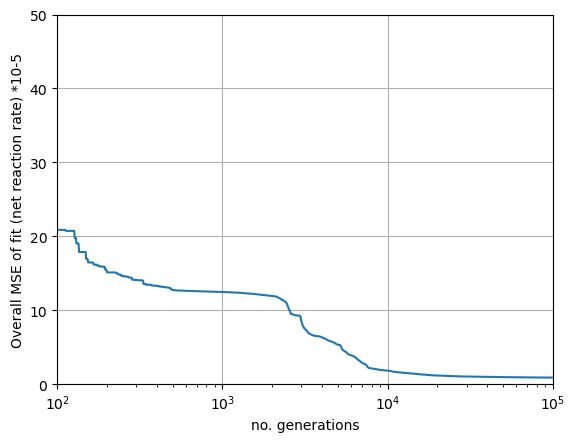

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.619706728003305
1.5390825699882003
0.846189286805482
-4.328313978588714
0.5016901460675424
2.3167735019577595e-05
0.3916841723656033
-11.19269468046011
1.0979283984320454
9.449994544860306
7.522693714787929
7.393843224832472
0.8001939011582715
0.048045528702439416
3.266466349085098
0.008461700201855198
0.12349406469713772
-11.893392432741411
1.882767181973327
1.595776999649236
-10.70993528547439
1.099485667417479
3.723548389562013
0.03609676130403723
3.8040662463920456
4.482870995451758
1.7118301959982252
9.54723722940273
-3.715330909897522
2.426279291927761
5.107639611127631
2.1864096538796716
-4.512573161891012
0.6006191949426029
1.1050983707184547
-1.3010297861959863


In [37]:
res.X

array([-1.16197067e+01,  1.53908257e+00,  8.46189287e-01, -4.32831398e+00,
        5.01690146e-01,  2.31677350e-05,  3.91684172e-01, -1.11926947e+01,
        1.09792840e+00,  9.44999454e+00,  7.52269371e+00,  7.39384322e+00,
        8.00193901e-01,  4.80455287e-02,  3.26646635e+00,  8.46170020e-03,
        1.23494065e-01, -1.18933924e+01,  1.88276718e+00,  1.59577700e+00,
       -1.07099353e+01,  1.09948567e+00,  3.72354839e+00,  3.60967613e-02,
        3.80406625e+00,  4.48287100e+00,  1.71183020e+00,  9.54723723e+00,
       -3.71533091e+00,  2.42627929e+00,  5.10763961e+00,  2.18640965e+00,
       -4.51257316e+00,  6.00619195e-01,  1.10509837e+00, -1.30102979e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.619706728003305
1.6: 1.5390825699882003
0.9: 0.846189286805482
-4.3: -4.328313978588714
0.5: 0.5016901460675424
0.003: 2.3167735019577595e-05
0.4: 0.3916841723656033
-7.9: -11.19269468046011
0.7: 1.0979283984320454
7.2: 9.449994544860306
5.7: 7.522693714787929
5.7: 7.393843224832472
0.8: 0.8001939011582715
0.03: 0.048045528702439416
3.1: 3.266466349085098
6.000000000000001e-09: 0.008461700201855198
0.1: 0.12349406469713772
-12.0: -11.893392432741411
1.9: 1.882767181973327
1.6: 1.595776999649236
-11.6: -10.70993528547439
1.2: 1.099485667417479
4.0: 3.723548389562013
0.01: 0.03609676130403723
4.2: 3.8040662463920456
5.4: 4.482870995451758
2.2: 1.7118301959982252
11.8: 9.54723722940273
-12.0: -3.715330909897522
3.3: 2.426279291927761
1.8: 5.107639611127631
4.2: 2.1864096538796716
-4.0: -4.512573161891012
0.5: 0.6006191949426029
1.0: 1.1050983707184547
coeff fit: 0.8902165509122836
r: 0.9435128779790362


In [43]:
# Use stored solution
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

y_mean = np.mean(logkr)

# average of log kr of 3 seeds
krseed1 = [-1.16197067e+01,  1.53908257e+00,  8.46189287e-01, -4.32831398e+00,
        5.01690146e-01,  2.31677350e-05,  3.91684172e-01, -1.11926947e+01,
        1.09792840e+00,  9.44999454e+00,  7.52269371e+00,  7.39384322e+00,
        8.00193901e-01,  4.80455287e-02,  3.26646635e+00,  8.46170020e-03,
        1.23494065e-01, -1.18933924e+01,  1.88276718e+00,  1.59577700e+00,
       -1.07099353e+01,  1.09948567e+00,  3.72354839e+00,  3.60967613e-02,
        3.80406625e+00,  4.48287100e+00,  1.71183020e+00,  9.54723723e+00,
       -3.71533091e+00,  2.42627929e+00,  5.10763961e+00,  2.18640965e+00,
       -4.51257316e+00,  6.00619195e-01,  1.10509837e+00, -1.30102979e+00]
#np.ndarray.tolist(res.X)
krseed10 = [-1.13471420e+01,  1.49551213e+00,  8.08079244e-01, -4.33392244e+00,
        5.02635722e-01,  1.33029232e-06,  3.92161165e-01, -1.09327671e+01,
        1.06566483e+00,  9.29248464e+00,  7.39187492e+00,  7.27448278e+00,
        8.06367887e-01,  4.86324547e-02,  3.27916197e+00,  8.43355674e-03,
        1.22642254e-01, -1.19999864e+01,  1.90306024e+00,  1.62151449e+00,
       -1.10805458e+01,  1.13987306e+00,  3.81051717e+00,  1.17262365e-02,
        3.98127237e+00,  4.59622074e+00,  1.85445573e+00,  1.01202764e+01,
       -1.14598449e+01,  3.17490120e+00,  1.83677765e+00,  4.01339236e+00,
       -4.05102523e+00,  5.09707986e-01,  1.00736696e+00, -1.30102997e+00]
krseed101 = [-1.12758127e+01,  1.48415151e+00,  7.98785859e-01, -4.26376130e+00,
        4.94150924e-01,  1.19387691e-05,  3.99136828e-01, -5.43281265e+00,
        4.03849826e-01,  5.50113404e+00,  4.24512936e+00,  4.35881298e+00,
        6.57549954e-01,  4.61118224e-02,  3.13768582e+00,  1.09176189e-06,
        2.51735914e-01, -1.17474877e+01,  1.85738077e+00,  1.58435109e+00,
       -1.15389739e+01,  1.19425794e+00,  4.03834352e+00,  2.75369349e-03,
        4.19844068e+00,  4.93905257e+00,  2.01628947e+00,  1.08895772e+01,
       -1.39392207e+00,  2.95489530e+00,  8.31742385e+00,  1.94180109e+00,
       -4.00088699e+00,  5.06495327e-01,  1.05792646e+00, -1.30102990e+00]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

coeff fit: 0.9399794928203448
r: 0.9695253956551859
-11.414220466666668
1.5062487366666666
0.8176847966666667
-4.308665906666666
0.49949226399999996
1.2145598806666666e-05
0.39432738833333336
-9.186091483333334
0.855814352
8.081204406666666
6.3865659966666675
6.34237966
0.7547039139999999
0.047596601933333336
3.22777138
0.0056321162339633335
0.165957411
-11.880288833333333
1.8810693966666667
1.6005475266666667
-11.109818333333335
1.14453889
3.8574696933333334
0.01685889709666667
3.9945931
4.67271477
1.8608584666666665
10.185696943333333
-5.523032626666667
2.852025263333333
5.08728037
2.7138676999999998
-4.188161793333333
0.5389408360000001
1.0567972633333333


In [44]:
meankr

[-11.414220466666668,
 1.5062487366666666,
 0.8176847966666667,
 -4.308665906666666,
 0.49949226399999996,
 1.2145598806666666e-05,
 0.39432738833333336,
 -9.186091483333334,
 0.855814352,
 8.081204406666666,
 6.3865659966666675,
 6.34237966,
 0.7547039139999999,
 0.047596601933333336,
 3.22777138,
 0.0056321162339633335,
 0.165957411,
 -11.880288833333333,
 1.8810693966666667,
 1.6005475266666667,
 -11.109818333333335,
 1.14453889,
 3.8574696933333334,
 0.01685889709666667,
 3.9945931,
 4.67271477,
 1.8608584666666665,
 10.185696943333333,
 -5.523032626666667,
 2.852025263333333,
 5.08728037,
 2.7138676999999998,
 -4.188161793333333,
 0.5389408360000001,
 1.0567972633333333]

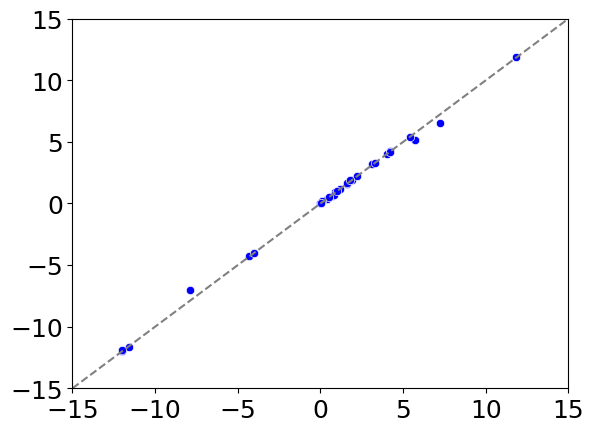

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([-15, 15])
plt.ylim([-15, 15])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()